# Scalable Signature-Based Distribution Regression via Reference Sets

## Numerical Examples - Parameter Estimation

### Andrew Alden, Blanka Horvath, Carmine Ventre

### Table of Contents

- [Initial Setup](#initial-setup)
- [Base Processes](#base-process-setup)
- [Generate Training Data](#gen-train-data)
    - [Data Dictionary](#gen-train-data-dict)
    - [SPEEDRS](#gen-train-data-speedrs)
    - [Kernel-Based Baselines](#gen-train-data-baselines)
        - [RBF Kernel](#gen-train-data-rbf)
        - [Matern Kernel](#gen-train-data-matern)
- [Train Models](#train-models)
    - [Statistical Models](#train-stat-models)
        - [SPEEDRS](#train-stat-models-speedrs)
        - [Kernel-Based Baselines](#train-stat-models-baselines)
            - [RBF Kernel](#train-stat-models-rbf)
            - [Matern Kernel](#train-stat-models-matern)
    - [Train Neural Networks](#train-neural-networks)
        - [SPEEDRS](#train-neural-networks-speedrs)
        - [Baselines](#train-neural-networks-baselines)
            - [RBF Kernel](#train-neural-networks-rbf)
            - [Matern Kernel](#train-neural-networks-matern)
            - [DeepSets](#train-neural-networks-deepsets)
- [Test Models](#test-models)
    - [Generate Test Data](#test-models-gen-data)
    - [SPEEDRS and Kernel-Based Baselines](#test-models-speedrs-kernel)
    - [DeepSets](#test-models-deepsets)
- [Testing Performance under Data Drift](#test-data-drift)
    - [Test 1 - Path Length](#test-data-drift-test1)
    - [Test 2 - Unseen Regimes](#test-data-drift-test2)
        - [(rBergomi, CEV)](#test-data-drift-test2-rbergomi-cev)
        - [(CEV, Heston)](#test-data-drift-test2-cev-heston)
    - [Performance Metrics](#test-data-drift-performance-metrics)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
import warnings
warnings.filterwarnings("ignore", "You are using `torch.load` with `weights_only=False`*.")
warnings.filterwarnings("ignore", message=r"Trying to unpickle estimator Ridge from version .*", category=UserWarning)
warnings.filterwarnings("ignore", message=r"Trying to unpickle estimator StandardScaler from version .*", category=UserWarning)

### Import libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from torch import nn
import torch.cuda
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import iisignature
import random
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor 
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path


from src.utils import save_dataset, load_dataset, save_path_params, load_path_params
from src.plotting_utils import construct_plot, compute_ci

from src.RegressionModel.regression_scaler_model import RegressionModelWithScaler
from src.RegressionModel.regression_model import RegressionModel
from src.RegressionModel.Baseline import bags_to_2D, rbf_mmd_mat, rbf_matern_mmd_mat, construct_pointwise_kernel_features
from src.RegressionModel.deep_sets import DataIterator, DeepSet, Trainer
from src.RegressionModel.train_utils import splice_features, train_linear_models, get_stats, display_linear_model_results, train_models, get_stats_NN 
from src.RegressionModel.test_utils import load_lgbm_model, test_neural_net, test_statistical_model, test_models, get_best_model_NN, get_best_model


from src.StochasticProcesses.rBergomi import r_bergomi_sample_paths_functional_central_limit, conditional_r_bergomi_sample_paths_functional_central_limit
from src.StochasticProcesses.Heston import heston_sample_paths_inv
from src.StochasticProcesses.BlackScholes import GBM_sample_paths
from src.StochasticProcesses.CEV import CEV_sample_paths

In [4]:
import sys

sys.modules['numpy._core'] = np.core
sys.modules['numpy._core.multiarray'] = np.core.multiarray

### Set device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.backends.cudnn.benchmark = True

Device: cuda


### Load pre-trained MMD approximator

In [5]:
i = 1
trunc_level = 3


mmd_approx_input_dimension = 28

mmd_approx_model_param_dict = {
    'input_dimension' : mmd_approx_input_dimension,
    'intermediate_dimensions' : [60, 60, 60],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


mmd_approx_model_mixture = RegressionModelWithScaler(mmd_approx_model_param_dict, None, 
                                         None, None, device, 
                                         scaler_file_name=f'MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl',
                                         num_additional_inputs=mmd_approx_input_dimension)


mmd_approx_model_mixture.load_best_model(
    f"MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_best_model_trunc_{trunc_level}_test_{i+1}_thesis.pth.tar", 
    f"MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl")

In [6]:
xi_0_range = (0.01, 0.2)
nu_range = (0.5, 4.0)
rho_range = (-1, 1)
H_range = (0.025, 0.5)
v0_range = (0.2, 0.8)

vol_of_vol_range = (0.2, 0.8)
speed_range = (0.2, 0.8)
mean_volatility_range = (0.2, 0.8)
r_range = (0.01, 0.2)

sigma_range = (0.2, 0.8)

## Base Processes <a class="anchor" id="base-process-setup"></a>

In [7]:
num_base_rbergomi = 8
num_base_heston = 8
num_base_gbm = 4

# format [v0, mean vol, vol of vol, speed, r, correlation]
base_heston_processes = [np.random.uniform(0.2, 0.8, 4).tolist() + [np.random.uniform(rho_range[0], rho_range[1])] + [np.random.uniform(r_range[0], r_range[1])] for _ in range(num_base_heston)]

# format [v0, H, xi_0, nu, correlation]
base_rbergomi_processes = [[np.random.uniform(v0_range[0], v0_range[1]), np.random.uniform(H_range[0], H_range[1]), np.random.uniform(xi_0_range[0], xi_0_range[1]), np.random.uniform(nu_range[0], nu_range[1]), np.random.uniform(rho_range[0], rho_range[1])] for _ in range(num_base_rbergomi)]

# format [sigma, r]
base_gbm_processes = [[np.random.uniform(sigma_range[0], sigma_range[1]), np.random.uniform(r_range[0], r_range[1])] for _ in range(num_base_gbm)]

In [11]:
num_base_rbergomi = 8
num_base_heston = 8
num_base_gbm = 4

# format [v0, mean vol, vol of vol, speed, r, correlation]
base_heston_processes = [np.random.uniform(v0_range[0], v0_range[1], 4).tolist() + [np.random.uniform(rho_range[0], rho_range[1])] + [np.random.uniform(r_range[0], r_range[1])] for _ in range(num_base_heston)]

# format [v0, H, xi_0, nu, correlation]
base_rbergomi_processes = [[np.random.uniform(v0_range[0], v0_range[1]), np.random.uniform(H_range[0], H_range[1]), np.random.uniform(xi_0_range[0], xi_0_range[1]), np.random.uniform(nu_range[0], nu_range[1]), np.random.uniform(rho_range[0], rho_range[1])] for _ in range(num_base_rbergomi)]

# format [sigma, r]
base_gbm_processes = [[np.random.uniform(sigma_range[0], sigma_range[1]), np.random.uniform(r_range[0], r_range[1])] for _ in range(num_base_gbm)]


S0 = 1.0
T = 1
num_sim = 5000
num_time_steps=14
sigma = 1
sig_level = 3

base_heston_paths = [heston_sample_paths_inv(S0, 
                                             base_heston_processes[i][0], 
                                             base_heston_processes[i][4], 
                                             base_heston_processes[i][5], 
                                             base_heston_processes[i][1], 
                                             base_heston_processes[i][3], 
                                             base_heston_processes[i][2], 
                                             T,
                                             num_sim,
                                             num_time_steps)[0] for i in range(num_base_heston)]

base_rbergomi_paths = [conditional_r_bergomi_sample_paths_functional_central_limit(S0,
                                                                                   base_rbergomi_processes[i][0], 
                                                                                   base_rbergomi_processes[i][1], 
                                                                                   [base_rbergomi_processes[i][2] for _ in range(num_time_steps+1)],
                                                                                   np.sqrt(2*base_rbergomi_processes[i][1]), 
                                                                                   base_rbergomi_processes[i][3], 
                                                                                   base_rbergomi_processes[i][4], 
                                                                                   T, 
                                                                                   num_time_steps,
                                                                                   num_sim)[-1] for i in range(num_base_rbergomi)]

       
base_gbm_paths = [GBM_sample_paths(S0, 
                                   base_gbm_processes[i][1],
                                   base_gbm_processes[i][0], 
                                   T, 
                                   num_sim,
                                   num_time_steps) for i in range(num_base_gbm)]
    
    
base_paths = base_heston_paths + base_rbergomi_paths + base_gbm_paths


base_process_expected_sigs = {}
for k in range(len(base_paths)):
    base_process_expected_sigs[k] = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(np.asarray(base_paths)[k, ...], (1, 0, 2)), 2), sigma)), sig_level), axis=0)

In [12]:
base_models = {
    
    'base_heston_processes' : base_heston_processes,
    'base_rbergomi_processes' : base_rbergomi_processes,
    'base_gbm_processes' : base_gbm_processes,
    'base_heston_paths' : base_heston_paths,
    'base_rbergomi_paths' : base_rbergomi_paths,
    'base_gbm_paths' : base_gbm_paths
    
}

save_path_params(base_models, "MixtureModels/ParamEstimation/Datasets/base_models_parameter_estimation_thesis")

save_path_params(base_process_expected_sigs, "MixtureModels/ParamEstimation/Datasets/base_process_expected_sigs_thesis")

## Generate Training Data <a class="anchor" id="gen-train-data"></a>

Load base process expected signatures

In [29]:
base_process_expected_sigs = load_path_params("MixtureModels/ParamEstimation/Datasets/base_process_expected_sigs_thesis")
base_models = load_path_params("MixtureModels/ParamEstimation/Datasets/base_models_parameter_estimation_thesis")

### Data Dictionary <a class="anchor" id="gen-train-data-dict"></a>

In [13]:
xi_0_list = []
nu_list = []
rho_rbergomi_list = []
H_list = []
v0_rbergomi_list = []

v0_heston_list = []
rho_heston_list = []
mean_vol_list = []
speed_list = []
vol_of_vol_list = []

S0_training = []
K_training = []
B_training = []
r_training = []
T_training = []

alpha_list = []


T = 1
S0 = 1.0

for i in range(500):
    
    p_xi_0 = np.random.uniform(xi_0_range[0], xi_0_range[1])
    p_nu = np.random.uniform(nu_range[0], nu_range[1])
    p_rho_rbergomi = np.random.uniform(rho_range[0], rho_range[1])
    p_H = np.random.uniform(H_range[0], H_range[1])
    p_v0_rbergomi = np.random.uniform(v0_range[0], v0_range[1])
    
    p_v0_heston = np.random.uniform(v0_range[0], v0_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    p_rho_heston = np.random.uniform(rho_range[0], rho_range[1])
    p_mean_vol = np.random.uniform(mean_volatility_range[0], mean_volatility_range[1])
    p_speed = np.random.uniform(speed_range[0], speed_range[1])
    p_vol_of_vol = np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    
    for j in range(7):
        
        
        if j == 0:
            alpha = 1.0
        elif j == 1:
            alpha = 0.0
        else:
            alpha = np.random.uniform(0, 1)
        
        v0_heston_list.append(p_v0_heston)
        rho_heston_list.append(p_rho_heston)
        mean_vol_list.append(p_mean_vol)
        speed_list.append(p_speed)
        vol_of_vol_list.append(p_vol_of_vol)
            
        xi_0_list.append(p_xi_0)
        nu_list.append(p_nu)
        rho_rbergomi_list.append(p_rho_rbergomi)
        H_list.append(p_H)
        v0_rbergomi_list.append(p_v0_rbergomi)

        S0_training.append(S0)
        T_training.append(T)
        r_training.append(r)
        
        alpha_list.append(alpha)
        
        
rbergomi_heston_dict = {
    
    'v0_heston_list' : v0_heston_list,
    'rho_heston_list' : rho_heston_list,
    'mean_vol_list' : mean_vol_list,
    'speed_list' : speed_list,
    'vol_of_vol_list' : vol_of_vol_list,
    'xi_0_list' : xi_0_list,
    'nu_list' : nu_list,
    'rho_rbergomi_list' : rho_rbergomi_list,
    'H_list' : H_list,
    'v0_rbergomi_list' : v0_rbergomi_list,
    'S0_rbergomi' : S0_training,
    'T_rbergomi' : T_training,
    'r_rbergomi' : r_training,
    'alpha_list' : alpha_list
    
}


save_path_params(rbergomi_heston_dict, "MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_dict_thesis")

### SPEEDRS <a class="anchor" id="gen-train-data-speedrs"></a>

In [5]:
rbergomi_heston_dict = load_path_params("MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_dict_thesis")

In [14]:
rbergomi_heston_features = []

T = 1.0

num_sim = 5000
num_time_steps = 14

expected_sigs_rbergomi_heston_mixture = []

sigma = 1
    
for i in tqdm(range(3500)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(rbergomi_heston_dict['S0_rbergomi'][i], 
                                                    rbergomi_heston_dict['v0_rbergomi_list'][i], 
                                                    rbergomi_heston_dict['H_list'][i],
                                                    [rbergomi_heston_dict['xi_0_list'][i] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict['H_list'][i]),
                                                    rbergomi_heston_dict['nu_list'][i],
                                                    rbergomi_heston_dict['rho_rbergomi_list'][i],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(rbergomi_heston_dict['S0_rbergomi'][i],
                                rbergomi_heston_dict['v0_heston_list'][i], 
                                rbergomi_heston_dict['r_rbergomi'][i],
                                rbergomi_heston_dict['rho_heston_list'][i],
                                rbergomi_heston_dict['mean_vol_list'][i], 
                                rbergomi_heston_dict['speed_list'][i],
                                rbergomi_heston_dict['vol_of_vol_list'][i],
                                T, num_sim, num_time_steps)[0]  
    
    
    expected_sigs_alpha = {}

        
    alpha = rbergomi_heston_dict['alpha_list'][i]
    
    new_dist = []
    p = np.add(alpha*p1, (1-alpha)*p2)

    p[:, :, 0] /= rbergomi_heston_dict['S0_rbergomi'][i]


    expected_sigs_rbergomi_heston_mixture.append(np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0))      

100%|██████████| 3500/3500 [01:36<00:00, 36.29it/s]


In [15]:
save_path_params(expected_sigs_rbergomi_heston_mixture, "MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_expected_sigs_thesis")

In [62]:
expected_sigs_rbergomi_heston_mixture = load_path_params("MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_expected_sigs_thesis")

In [18]:
mixture_param_model_features = []

    
for i in tqdm(range(3500)):
    
        
            
    new_dist = []
    for k in range(20):

        new_feature = expected_sigs_rbergomi_heston_mixture[i].tolist() + base_process_expected_sigs[k].tolist()

        mmd_approx_model_mixture.model.eval()
        with torch.no_grad():

            new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())


    mixture_param_model_features.append(new_dist)

100%|██████████| 3500/3500 [00:29<00:00, 116.74it/s]


In [19]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_model_features_thesis", "wb") as fp:   #Pickling
    pickle.dump(mixture_param_model_features, fp)

### Kernel-Based Baseline Features <a class="anchor" id="gen-train-data-baselines"></a>

#### RBF Kernel <a class="anchor" id="gen-train-data-rbf"></a>

In [ ]:
base_models = load_path_params("MixtureModels/ParamEstimation/Datasets/base_models_parameter_estimation_thesis")
rbergomi_heston_dict = load_path_params("MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_dict_thesis")

In [ ]:
rbergomi_heston_rbf_kernel_features = construct_pointwise_kernel_features(base_models,
                                                                          rbergomi_heston_dict,
                                                                          rbf_mmd_mat)

In [ ]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_baseline_model_RBF_features_thesis", "wb") as fp:
    pickle.dump(rbergomi_heston_kernel_rbf_features, fp)

#### Matern Kernel <a class="anchor" id="gen-train-data-matern"></a>

In [ ]:
base_models = load_path_params("MixtureModels/ParamEstimation/Datasets/base_models_parameter_estimation_thesis")
rbergomi_heston_dict = load_path_params("MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_dict_thesis")

In [ ]:
rbergomi_heston_matern_kernel_features = construct_pointwise_kernel_features(base_models,
                                                                          rbergomi_heston_dict,
                                                                          rbf_matern_mmd_mat)

In [ ]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_baseline_model_Matern_features_thesis", "wb") as fp:
    pickle.dump(rbergomi_heston_matern_kernel_features, fp)

# Train Models <a class="anchor" id="train-models"></a>

In [11]:
rbergomi_heston_dict = load_path_params("MixtureModels/ParamEstimation/Datasets/rbergomi_heston_parameter_estimation_dict_thesis")

## Statistical Models <a class="anchor" id="train-stat-models"></a>

In [9]:
param_dict = {'5': [(0, 2), (8, 10), (16, 17)], 
              '10': [(0, 4), (8, 12), (16, 18)],
              '20': [(0, 20)], 
             }

L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]

### SPEEDRS <a class="anchor" id="train-stat-models-speedrs"></a>

In [12]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_model_features_thesis", "rb") as fp:
    mixture_param_model_features = pickle.load(fp)

In [25]:
suffix = '_thesis'
folder = 'ParamEstimation/Models'
for N in [5, 10, 20]:

    print(f'Linear Regression')

    new_features = splice_features(mixture_param_model_features, N)

    for l2 in L2_params:
        model_str = f'linear_reg_parameter_estimation_l2_{l2}'
        train_linear_models(rbergomi_heston_dict['alpha_list'], np.asarray(new_features), N, Ridge(fit_intercept=True, alpha=l2), model_str, suffix=suffix)
    print(f'{"*"*65}')
    print(f'LGBM')
    for l2 in L2_params:
        for lr in lrs:
            model_str = f'lgbm_parameter_estimation_l2_{l2}_lr_{lr}'
            train_linear_models(rbergomi_heston_dict['alpha_list'], np.asarray(new_features), N, 
                                LGBMRegressor(metric='mse', reg_lambda=l2, learning_rate=lr, verbose=0),
                                model_str, suffix=suffix, folder=folder)

Linear Regression
*****************************************************************
LGBM
Linear Regression
*****************************************************************
LGBM
Linear Regression
*****************************************************************
LGBM


In [10]:
suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_l2_{l2}_lr_{lr}'

speedrs_current_best_ridge, speedrs_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                     L2_params, 
                                                                                     model_str1, 
                                                                                     model_str2,
                                                                                     suffix=suffix,
                                                                                     folder=folder)

    Model  N       L2     LR  Train MSE  Train Std  Valid MSE  Valid Std
0   Ridge  5  0.00000    N/A   0.012158   0.000197   0.012022   0.000785
1   Ridge  5  1.00000    N/A   0.012785   0.000191   0.012690   0.000753
2   Ridge  5  0.10000    N/A   0.012065   0.000229   0.012636   0.000941
3   Ridge  5  0.01000    N/A   0.011900   0.000204   0.013067   0.000823
4   Ridge  5  0.00100    N/A   0.012084   0.000180   0.012321   0.000725
5   Ridge  5  0.00001    N/A   0.012201   0.000205   0.011853   0.000822
6    LGBM  5  0.00000    0.1   0.003654   0.000079   0.007800   0.000587
7    LGBM  5  0.00000   0.05   0.004819   0.000089   0.007882   0.000441
8    LGBM  5  0.00000   0.01   0.024270   0.000148   0.026200   0.001225
9    LGBM  5  0.00000  0.005   0.053081   0.000206   0.055793   0.001087
10   LGBM  5  0.00000  0.001   0.108002   0.000486   0.108904   0.002211
11   LGBM  5  1.00000    0.1   0.003733   0.000037   0.008000   0.000160
12   LGBM  5  1.00000   0.05   0.004805   0.000085 

In [16]:
speedrs_current_best_ridge

{5: {'MSE': 0.011853439141823342, 'l2': 1e-05},
 10: {'MSE': 0.010796841911814509, 'l2': 0.01},
 20: {'MSE': 0.009387957403238546, 'l2': 1e-05}}

In [17]:
speedrs_current_best_lgbm

{5: {'MSE': 0.007549544713110161, 'l2': 0.1, 'lr': 0.05},
 10: {'MSE': 0.007271324330883429, 'l2': 0.001, 'lr': 0.05},
 20: {'MSE': 0.006337761127118191, 'l2': 0.01, 'lr': 0.1}}

### Kernel-Based Baselines <a class="anchor" id="train-stat-models-baselines"></a>

#### RBF Kernel <a class="anchor" id="train-stat-models-rbf"></a>

In [19]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_baseline_model_RBF_features_thesis", "rb") as fp:
    rbergomi_heston_kernel_rbf_features = pickle.load(fp)

In [81]:
baseline = True
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]
suffix = '_thesis'
folder = 'ParamEstimation/Models'

for N in [20]:
    print(f'Linear Regression')

    for l2 in L2_params:
        model_str = f'linear_reg_parameter_estimation_rbf_baseline_l2_{l2}'
        train_linear_models(rbergomi_heston_dict['alpha_list'], np.asarray(rbergomi_heston_kernel_rbf_features), N, Ridge(fit_intercept=True, alpha=l2), model_str, baseline=baseline, suffix=suffix)
    print(f'{"*"*65}')
    print(f'LGBM')
    for l2 in L2_params:
        for lr in lrs:
            model_str = f'lgbm_parameter_estimation_rbf_baseline_l2_{l2}_lr_{lr}'
            train_linear_models(rbergomi_heston_dict['alpha_list'], np.asarray(rbergomi_heston_kernel_rbf_features), N, 
                                LGBMRegressor(metric='mse', reg_lambda=l2, learning_rate=lr, verbose=0),
                                model_str, baseline=baseline, suffix=suffix, folder=folder)

Linear Regression
*****************************************************************
LGBM


In [11]:
suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_rbf_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_rbf_baseline_l2_{l2}_lr_{lr}'

rbf_current_best_ridge, rbf_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20])

    Model   N       L2     LR  Train MSE  Train Std  Valid MSE  Valid Std
0   Ridge  20  0.00000    N/A   0.008484   0.000139   0.008947   0.000557
1   Ridge  20  1.00000    N/A   0.016894   0.000178   0.015861   0.000803
2   Ridge  20  0.10000    N/A   0.012680   0.000064   0.012636   0.000330
3   Ridge  20  0.01000    N/A   0.009982   0.000106   0.010449   0.000446
4   Ridge  20  0.00100    N/A   0.009611   0.000165   0.009675   0.000678
5   Ridge  20  0.00001    N/A   0.008874   0.000151   0.008719   0.000619
6    LGBM  20  0.00000    0.1   0.004166   0.000091   0.008904   0.000692
7    LGBM  20  0.00000   0.05   0.005626   0.000058   0.010122   0.000339
8    LGBM  20  0.00000   0.01   0.025838   0.000111   0.027592   0.000925
9    LGBM  20  0.00000  0.005   0.054386   0.000123   0.054592   0.001111
10   LGBM  20  0.00000  0.001   0.108560   0.000768   0.108104   0.003211
11   LGBM  20  1.00000    0.1   0.004095   0.000059   0.010673   0.000670
12   LGBM  20  1.00000   0.05   0.0057

In [22]:
rbf_current_best_ridge

{5: {'MSE': -1, 'l2': -1},
 10: {'MSE': -1, 'l2': -1},
 20: {'MSE': 0.008718923924225113, 'l2': 1e-05}}

In [23]:
rbf_current_best_lgbm

{5: {'MSE': -1, 'l2': -1, 'lr': -1},
 10: {'MSE': -1, 'l2': -1, 'lr': -1},
 20: {'MSE': 0.008903510802616962, 'l2': 0, 'lr': 0.1}}

#### Matern Kernel <a class="anchor" id="train-stat-models-matern"></a>

In [21]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_baseline_model_Matern_features_thesis", "rb") as fp:
    rbergomi_heston_matern_kernel_features = pickle.load(fp)

In [111]:
baseline = True
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]
suffix = '_thesis'
folder = 'ParamEstimation/Models'

for N in [20]:
    print(f'Linear Regression')

    for l2 in L2_params:
        model_str = f'linear_reg_parameter_estimation_matern_baseline_l2_{l2}'
        train_linear_models(rbergomi_heston_dict['alpha_list'], np.asarray(rbergomi_heston_matern_kernel_features), N, Ridge(fit_intercept=True, alpha=l2), model_str, baseline=baseline, suffix=suffix)
    print(f'{"*"*65}')
    print(f'LGBM')
    for l2 in L2_params:
        for lr in lrs:
            model_str = f'lgbm_parameter_estimation_matern_baseline_l2_{l2}_lr_{lr}'
            train_linear_models(rbergomi_heston_dict['alpha_list'], np.asarray(rbergomi_heston_matern_kernel_features), N, 
                                LGBMRegressor(metric='mse', reg_lambda=l2, learning_rate=lr, verbose=0),
                                model_str, baseline=baseline, suffix=suffix, folder=folder)

In [12]:
suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_matern_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_matern_baseline_l2_{l2}_lr_{lr}'

matern_current_best_ridge, matern_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20])

    Model   N       L2     LR  Train MSE  Train Std  Valid MSE  Valid Std
0   Ridge  20  0.00000    N/A   0.008307   0.000119   0.008999   0.000488
1   Ridge  20  1.00000    N/A   0.015034   0.000206   0.014506   0.000975
2   Ridge  20  0.10000    N/A   0.011183   0.000061   0.011255   0.000309
3   Ridge  20  0.01000    N/A   0.010224   0.000105   0.009667   0.000440
4   Ridge  20  0.00100    N/A   0.009557   0.000117   0.009499   0.000481
5   Ridge  20  0.00001    N/A   0.008459   0.000190   0.008645   0.000803
6    LGBM  20  0.00000    0.1   0.003751   0.000044   0.009209   0.000406
7    LGBM  20  0.00000   0.05   0.005226   0.000120   0.009296   0.000679
8    LGBM  20  0.00000   0.01   0.025217   0.000120   0.026570   0.000754
9    LGBM  20  0.00000  0.005   0.053801   0.000084   0.054536   0.001005
10   LGBM  20  0.00000  0.001   0.108722   0.000318   0.106509   0.001386
11   LGBM  20  1.00000    0.1   0.003745   0.000085   0.009645   0.000704
12   LGBM  20  1.00000   0.05   0.0052

In [25]:
matern_current_best_ridge

{5: {'MSE': -1, 'l2': -1},
 10: {'MSE': -1, 'l2': -1},
 20: {'MSE': 0.008644599880325102, 'l2': 1e-05}}

In [26]:
matern_current_best_lgbm

{5: {'MSE': -1, 'l2': -1, 'lr': -1},
 10: {'MSE': -1, 'l2': -1, 'lr': -1},
 20: {'MSE': 0.009077782799036769, 'l2': 0.1, 'lr': 0.05}}

## Train Neural Networks <a class="anchor" id="train-neural-networks"></a>


### SPEEDRS <a class="anchor" id="train-neural-networks-speedrs"></a>

In [ ]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_model_features_thesis", "rb") as fp:
    mixture_param_model_features = pickle.load(fp)

### B = 5

In [58]:
new_mixture_param_model_features_5_base = []
for f in mixture_param_model_features:
    new_mixture_param_model_features_5_base.append(f[:2] + f[8:10] + [f[16]])

training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

input_dimension = 5

model_param_dict = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [15, 15, 15],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}


suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'

train_models(rbergomi_heston_dict['alpha_list'], new_mixture_param_model_features_5_base, training_param_dict, 
             dataset_loader_params, input_dimension, model_param_dict, 5, device, num_runs=5, suffix=suffix, 
             folder=folder, model_desc_string=model_desc_string)

Number of Training Samples: 2788


  1%|          | 2/200 [00:00<00:14, 13.66it/s]

Epoch: 1 	 Training Loss: 0.14123116433620453 	 Validation Loss: 0.08814342319965363 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.06126006320118904 	 Validation Loss: 0.045071132481098175 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.03290066495537758 	 Validation Loss: 0.030245432630181313 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.50it/s]

Epoch: 4 	 Training Loss: 0.02360556088387966 	 Validation Loss: 0.023556102067232132 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.018456848338246346 	 Validation Loss: 0.019171934574842453 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:15, 12.86it/s]

Epoch: 6 	 Training Loss: 0.015130804851651192 	 Validation Loss: 0.016319071874022484 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.01324246171861887 	 Validation Loss: 0.01456837821751833 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:17, 11.18it/s]

Epoch: 8 	 Training Loss: 0.012056431733071804 	 Validation Loss: 0.013387669809162617 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.01132986880838871 	 Validation Loss: 0.012547635473310947 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:16, 11.84it/s]

Epoch: 10 	 Training Loss: 0.01071807462722063 	 Validation Loss: 0.012092932127416134 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:15, 12.43it/s]

Epoch: 11 	 Training Loss: 0.010311179794371128 	 Validation Loss: 0.011467143893241882 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.00998037587851286 	 Validation Loss: 0.011128601618111134 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.009741936810314655 	 Validation Loss: 0.010810061357915401 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:14, 12.74it/s]

Epoch: 14 	 Training Loss: 0.009518620558083057 	 Validation Loss: 0.010588852688670158 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.009392253123223782 	 Validation Loss: 0.01049058511853218 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:14, 13.10it/s]

Epoch: 16 	 Training Loss: 0.009253623895347118 	 Validation Loss: 0.010497866198420525


  9%|▉         | 18/200 [00:01<00:13, 13.23it/s]

Epoch: 17 	 Training Loss: 0.009139093570411205 	 Validation Loss: 0.010208383202552795 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.008991459384560585 	 Validation Loss: 0.010005323216319084 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.008867554366588593 	 Validation Loss: 0.009903495199978352 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.39it/s]

Epoch: 20 	 Training Loss: 0.008797853253781796 	 Validation Loss: 0.009859651327133179 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.008659335784614086 	 Validation Loss: 0.009746946394443512 	 Saving Checkpoint


 11%|█         | 22/200 [00:01<00:13, 13.44it/s]

Epoch: 22 	 Training Loss: 0.00859107356518507 	 Validation Loss: 0.009665239602327347 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:13, 13.46it/s]

Epoch: 23 	 Training Loss: 0.00851734820753336 	 Validation Loss: 0.00963652040809393 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 0.008412801660597324 	 Validation Loss: 0.009518757462501526 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.00836923811584711 	 Validation Loss: 0.009497104212641716 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:02<00:12, 13.49it/s]

Epoch: 26 	 Training Loss: 0.008311337791383266 	 Validation Loss: 0.009429079480469227 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.008241123519837856 	 Validation Loss: 0.009364563971757889 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:13, 12.20it/s]

Epoch: 28 	 Training Loss: 0.008206908591091633 	 Validation Loss: 0.009368455037474632
Epoch: 29 	 Training Loss: 0.008136670105159283 	 Validation Loss: 0.009363393299281597 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.00809108093380928 	 Validation Loss: 0.009330268949270248 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:02<00:13, 12.72it/s]

Epoch: 31 	 Training Loss: 0.007998960092663765 	 Validation Loss: 0.009246370755136013 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.007966236211359501 	 Validation Loss: 0.009279433637857437
Epoch: 33 	 Training Loss: 0.007900994271039963 	 Validation Loss: 0.009217021986842155 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:02<00:12, 13.22it/s]

Epoch: 34 	 Training Loss: 0.007903961464762688 	 Validation Loss: 0.00917468685656786 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.007890901528298855 	 Validation Loss: 0.009145745076239109 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.007796356454491615 	 Validation Loss: 0.009090801700949669 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:02<00:11, 13.56it/s]

Epoch: 37 	 Training Loss: 0.007793223951011896 	 Validation Loss: 0.009107132442295551
Epoch: 38 	 Training Loss: 0.007708501070737839 	 Validation Loss: 0.009125377051532269
Epoch: 39 	 Training Loss: 0.0077045513316988945 	 Validation Loss: 0.009124224074184895


 21%|██        | 42/200 [00:03<00:11, 13.82it/s]

Epoch: 40 	 Training Loss: 0.0076903789304196835 	 Validation Loss: 0.009182297624647617
Epoch: 41 	 Training Loss: 0.007694825064390898 	 Validation Loss: 0.00900428369641304 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.007635427173227072 	 Validation Loss: 0.00901581346988678


 22%|██▏       | 44/200 [00:03<00:11, 13.74it/s]

Epoch: 43 	 Training Loss: 0.007607650477439165 	 Validation Loss: 0.00898735597729683 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.007549886591732502 	 Validation Loss: 0.008936211466789246 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.0074943616054952145 	 Validation Loss: 0.008998652920126915


 24%|██▍       | 48/200 [00:03<00:10, 13.93it/s]

Epoch: 46 	 Training Loss: 0.007502659223973751 	 Validation Loss: 0.008984186686575413
Epoch: 47 	 Training Loss: 0.007457836531102657 	 Validation Loss: 0.008880583569407463 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 0.0075072175823152065 	 Validation Loss: 0.008924142457544804


 25%|██▌       | 50/200 [00:03<00:10, 13.95it/s]

Epoch: 49 	 Training Loss: 0.00748605327680707 	 Validation Loss: 0.008919979445636272
Epoch: 50 	 Training Loss: 0.007419640198349953 	 Validation Loss: 0.008858255110681057 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.007429169490933418 	 Validation Loss: 0.00917216669768095


 27%|██▋       | 54/200 [00:04<00:10, 13.98it/s]

Epoch: 52 	 Training Loss: 0.00744611257687211 	 Validation Loss: 0.008823944255709648 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.007420856039971113 	 Validation Loss: 0.008768289349973202 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 0.007347639184445143 	 Validation Loss: 0.008783143945038319


 28%|██▊       | 56/200 [00:04<00:10, 13.97it/s]

Epoch: 55 	 Training Loss: 0.00730787543579936 	 Validation Loss: 0.008753694593906403 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.007282972801476717 	 Validation Loss: 0.008999945595860481
Epoch: 57 	 Training Loss: 0.007424470037221909 	 Validation Loss: 0.008782112039625645


 30%|███       | 60/200 [00:04<00:10, 13.76it/s]

Epoch: 58 	 Training Loss: 0.007328588981181383 	 Validation Loss: 0.00874948687851429 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 0.007362883538007736 	 Validation Loss: 0.008767507039010525
Epoch: 60 	 Training Loss: 0.007293817587196827 	 Validation Loss: 0.008706539869308472 	 Saving Checkpoint


 31%|███       | 62/200 [00:04<00:10, 13.77it/s]

Epoch: 61 	 Training Loss: 0.007258012890815735 	 Validation Loss: 0.008698851801455021 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.007239642087370157 	 Validation Loss: 0.008729975670576096
Epoch: 63 	 Training Loss: 0.0072661759331822395 	 Validation Loss: 0.009072000160813332


 33%|███▎      | 66/200 [00:04<00:09, 13.91it/s]

Epoch: 64 	 Training Loss: 0.007313283625990152 	 Validation Loss: 0.008691903203725815 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 0.007248843088746071 	 Validation Loss: 0.008667183108627796 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 0.007186672650277615 	 Validation Loss: 0.00867405440658331


 34%|███▍      | 68/200 [00:05<00:09, 13.97it/s]

Epoch: 67 	 Training Loss: 0.007201850414276123 	 Validation Loss: 0.008773889392614365
Epoch: 68 	 Training Loss: 0.007266578264534473 	 Validation Loss: 0.008667102083563805 	 Saving Checkpoint
Epoch: 69 	 Training Loss: 0.007166570983827114 	 Validation Loss: 0.008667229674756527


 36%|███▌      | 72/200 [00:05<00:09, 14.13it/s]

Epoch: 70 	 Training Loss: 0.007161908783018589 	 Validation Loss: 0.008672399446368217
Epoch: 71 	 Training Loss: 0.007315479684621096 	 Validation Loss: 0.00883184839040041
Epoch: 72 	 Training Loss: 0.007275608833879232 	 Validation Loss: 0.008619002997875214 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:05<00:08, 14.18it/s]

Epoch: 73 	 Training Loss: 0.007233808748424053 	 Validation Loss: 0.008628909476101398
Epoch: 74 	 Training Loss: 0.007223385386168957 	 Validation Loss: 0.008627631701529026
Epoch: 75 	 Training Loss: 0.007236728444695473 	 Validation Loss: 0.00861971452832222


 39%|███▉      | 78/200 [00:05<00:08, 13.99it/s]

Epoch: 76 	 Training Loss: 0.007142727728933096 	 Validation Loss: 0.008613637648522854 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.0070795705541968346 	 Validation Loss: 0.008586595766246319 	 Saving Checkpoint
Epoch: 78 	 Training Loss: 0.007087067235261202 	 Validation Loss: 0.008576301857829094 	 Saving Checkpoint


 40%|████      | 80/200 [00:05<00:08, 13.98it/s]

Epoch: 79 	 Training Loss: 0.007112486753612757 	 Validation Loss: 0.008575115352869034 	 Saving Checkpoint
Epoch: 80 	 Training Loss: 0.007078682538121939 	 Validation Loss: 0.008576017804443836
Epoch: 81 	 Training Loss: 0.007085538934916258 	 Validation Loss: 0.008555504493415356 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:06<00:08, 14.04it/s]

Epoch: 82 	 Training Loss: 0.007096697110682726 	 Validation Loss: 0.008700985461473465
Epoch: 83 	 Training Loss: 0.007043425925076008 	 Validation Loss: 0.00860216747969389
Epoch: 84 	 Training Loss: 0.00705298874527216 	 Validation Loss: 0.008616261184215546


 43%|████▎     | 86/200 [00:06<00:08, 14.16it/s]

Epoch: 85 	 Training Loss: 0.007110447157174349 	 Validation Loss: 0.008690050803124905
Epoch: 86 	 Training Loss: 0.00705983629450202 	 Validation Loss: 0.008643076755106449
Epoch: 87 	 Training Loss: 0.007059577386826277 	 Validation Loss: 0.008789070881903172


 45%|████▌     | 90/200 [00:06<00:07, 14.29it/s]

Epoch: 88 	 Training Loss: 0.0070868139155209064 	 Validation Loss: 0.00860812608152628
Epoch: 89 	 Training Loss: 0.007028276566416025 	 Validation Loss: 0.008636881597340107
Epoch: 90 	 Training Loss: 0.007012045942246914 	 Validation Loss: 0.008577399887144566


 46%|████▌     | 92/200 [00:06<00:07, 14.12it/s]

Epoch: 91 	 Training Loss: 0.0070067779161036015 	 Validation Loss: 0.008574637584388256
Epoch: 92 	 Training Loss: 0.007023495156317949 	 Validation Loss: 0.008543561212718487 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.006999418139457703 	 Validation Loss: 0.008514204993844032 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:07<00:07, 13.98it/s]

Epoch: 94 	 Training Loss: 0.007034085690975189 	 Validation Loss: 0.00857627671211958
Epoch: 95 	 Training Loss: 0.007030439097434282 	 Validation Loss: 0.008539251051843166
Epoch: 96 	 Training Loss: 0.0070022051222622395 	 Validation Loss: 0.008513444103300571 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:07<00:07, 14.10it/s]

Epoch: 97 	 Training Loss: 0.007030242122709751 	 Validation Loss: 0.008587428368628025
Epoch: 98 	 Training Loss: 0.007012060843408108 	 Validation Loss: 0.008541116490960121
Epoch: 99 	 Training Loss: 0.0070108212530612946 	 Validation Loss: 0.00853598304092884


 51%|█████     | 102/200 [00:07<00:06, 14.05it/s]

Epoch: 100 	 Training Loss: 0.007052275352180004 	 Validation Loss: 0.008578736335039139
Epoch: 101 	 Training Loss: 0.006958296522498131 	 Validation Loss: 0.008479169569909573 	 Saving Checkpoint
Epoch: 102 	 Training Loss: 0.006963818334043026 	 Validation Loss: 0.008457550778985023 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:07<00:06, 14.15it/s]

Epoch: 103 	 Training Loss: 0.0069821602664887905 	 Validation Loss: 0.008502012118697166
Epoch: 104 	 Training Loss: 0.006981893442571163 	 Validation Loss: 0.00848697405308485
Epoch: 105 	 Training Loss: 0.00697261793538928 	 Validation Loss: 0.008471410721540451


 54%|█████▍    | 108/200 [00:07<00:06, 14.18it/s]

Epoch: 106 	 Training Loss: 0.006959706544876099 	 Validation Loss: 0.008491973392665386
Epoch: 107 	 Training Loss: 0.006960186176002026 	 Validation Loss: 0.008441148325800896 	 Saving Checkpoint
Epoch: 108 	 Training Loss: 0.006970974616706371 	 Validation Loss: 0.008604462258517742


 55%|█████▌    | 110/200 [00:08<00:06, 14.23it/s]

Epoch: 109 	 Training Loss: 0.006964778061956167 	 Validation Loss: 0.008464975282549858
Epoch: 110 	 Training Loss: 0.006958091165870428 	 Validation Loss: 0.008448893204331398
Epoch: 111 	 Training Loss: 0.006943407002836466 	 Validation Loss: 0.008486038073897362


 57%|█████▋    | 114/200 [00:08<00:06, 14.33it/s]

Epoch: 112 	 Training Loss: 0.006940501742064953 	 Validation Loss: 0.008445669896900654
Epoch: 113 	 Training Loss: 0.006965301930904388 	 Validation Loss: 0.008444580249488354
Epoch: 114 	 Training Loss: 0.006999957840889692 	 Validation Loss: 0.008475673384964466


 58%|█████▊    | 116/200 [00:08<00:05, 14.29it/s]

Epoch: 115 	 Training Loss: 0.006948264315724373 	 Validation Loss: 0.00847446545958519
Epoch: 116 	 Training Loss: 0.0069828759878873825 	 Validation Loss: 0.008466066792607307
Epoch: 117 	 Training Loss: 0.0069565679877996445 	 Validation Loss: 0.008466565050184727


 60%|██████    | 120/200 [00:08<00:05, 14.06it/s]

Epoch: 118 	 Training Loss: 0.006934603676199913 	 Validation Loss: 0.008430782705545425 	 Saving Checkpoint
Epoch: 119 	 Training Loss: 0.006926172412931919 	 Validation Loss: 0.008446925319731236
Epoch: 120 	 Training Loss: 0.006927330978214741 	 Validation Loss: 0.008429652079939842 	 Saving Checkpoint


 61%|██████    | 122/200 [00:08<00:05, 14.07it/s]

Epoch: 121 	 Training Loss: 0.006932317279279232 	 Validation Loss: 0.008427073247730732 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.006924060173332691 	 Validation Loss: 0.008434340357780457
Epoch: 123 	 Training Loss: 0.006977515295147896 	 Validation Loss: 0.008637625724077225


 63%|██████▎   | 126/200 [00:09<00:05, 14.21it/s]

Epoch: 124 	 Training Loss: 0.006981675047427416 	 Validation Loss: 0.008470362983644009
Epoch: 125 	 Training Loss: 0.006932940799742937 	 Validation Loss: 0.008467418141663074
Epoch: 126 	 Training Loss: 0.0069375187158584595 	 Validation Loss: 0.008670770563185215


 64%|██████▍   | 128/200 [00:09<00:05, 14.09it/s]

Epoch: 127 	 Training Loss: 0.006916448473930359 	 Validation Loss: 0.008424695581197739 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.006899338215589523 	 Validation Loss: 0.008416077122092247 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.006906156428158283 	 Validation Loss: 0.00839904323220253 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:09<00:05, 13.15it/s]

Epoch: 130 	 Training Loss: 0.006884261500090361 	 Validation Loss: 0.008438555523753166
Epoch: 131 	 Training Loss: 0.006903201807290316 	 Validation Loss: 0.008419030345976353
Epoch: 132 	 Training Loss: 0.006892101839184761 	 Validation Loss: 0.008445833809673786


 67%|██████▋   | 134/200 [00:09<00:05, 12.78it/s]

Epoch: 133 	 Training Loss: 0.006899154279381037 	 Validation Loss: 0.008412697352468967
Epoch: 134 	 Training Loss: 0.006909962277859449 	 Validation Loss: 0.008455097675323486
Epoch: 135 	 Training Loss: 0.006897298153489828 	 Validation Loss: 0.008474885486066341


 69%|██████▉   | 138/200 [00:10<00:04, 13.33it/s]

Epoch: 136 	 Training Loss: 0.006919317878782749 	 Validation Loss: 0.008451947011053562
Epoch: 137 	 Training Loss: 0.006887154188007116 	 Validation Loss: 0.008476218208670616
Epoch: 138 	 Training Loss: 0.006892826873809099 	 Validation Loss: 0.008633952587842941


 70%|███████   | 140/200 [00:10<00:05, 11.91it/s]

Epoch: 139 	 Training Loss: 0.006952174939215183 	 Validation Loss: 0.008615793660283089
Epoch: 140 	 Training Loss: 0.006904020439833403 	 Validation Loss: 0.00840180367231369


 71%|███████   | 142/200 [00:10<00:04, 12.58it/s]

Epoch: 141 	 Training Loss: 0.006872913800179958 	 Validation Loss: 0.008501332253217697
Epoch: 142 	 Training Loss: 0.006898322608321905 	 Validation Loss: 0.008412444032728672
Epoch: 143 	 Training Loss: 0.006886206101626158 	 Validation Loss: 0.008413009345531464


 73%|███████▎  | 146/200 [00:10<00:04, 13.37it/s]

Epoch: 144 	 Training Loss: 0.006885856855660677 	 Validation Loss: 0.008438934572041035
Epoch: 145 	 Training Loss: 0.006876760628074408 	 Validation Loss: 0.008387495763599873 	 Saving Checkpoint
Epoch: 146 	 Training Loss: 0.006887507624924183 	 Validation Loss: 0.008402733132243156


 74%|███████▍  | 148/200 [00:10<00:03, 13.63it/s]

Epoch: 147 	 Training Loss: 0.006928844843059778 	 Validation Loss: 0.008417604491114616
Epoch: 148 	 Training Loss: 0.006892910227179527 	 Validation Loss: 0.008452754467725754
Epoch: 149 	 Training Loss: 0.006865091621875763 	 Validation Loss: 0.008384778164327145 	 Saving Checkpoint


 76%|███████▌  | 152/200 [00:11<00:03, 13.89it/s]

Epoch: 150 	 Training Loss: 0.006860419176518917 	 Validation Loss: 0.008400105871260166
Epoch: 151 	 Training Loss: 0.0068558016791939735 	 Validation Loss: 0.008427020162343979
Epoch: 152 	 Training Loss: 0.006857249420136213 	 Validation Loss: 0.008381512947380543 	 Saving Checkpoint


 77%|███████▋  | 154/200 [00:11<00:03, 13.97it/s]

Epoch: 153 	 Training Loss: 0.0068575190380215645 	 Validation Loss: 0.008377649821341038 	 Saving Checkpoint
Epoch: 154 	 Training Loss: 0.006851674988865852 	 Validation Loss: 0.008432361297309399
Epoch: 155 	 Training Loss: 0.006859340239316225 	 Validation Loss: 0.008391515351831913


 79%|███████▉  | 158/200 [00:11<00:02, 14.05it/s]

Epoch: 156 	 Training Loss: 0.006858776323497295 	 Validation Loss: 0.008370663970708847 	 Saving Checkpoint
Epoch: 157 	 Training Loss: 0.006877957843244076 	 Validation Loss: 0.008375242352485657
Epoch: 158 	 Training Loss: 0.006855902262032032 	 Validation Loss: 0.008380972780287266


 80%|████████  | 160/200 [00:11<00:02, 14.05it/s]

Epoch: 159 	 Training Loss: 0.006837591528892517 	 Validation Loss: 0.008424687199294567
Epoch: 160 	 Training Loss: 0.006854239385575056 	 Validation Loss: 0.008363720029592514 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.006840785965323448 	 Validation Loss: 0.008390970528125763


 82%|████████▏ | 164/200 [00:12<00:02, 14.21it/s]

Epoch: 162 	 Training Loss: 0.006839126348495483 	 Validation Loss: 0.008390307426452637
Epoch: 163 	 Training Loss: 0.0068341949954628944 	 Validation Loss: 0.008373410440981388
Epoch: 164 	 Training Loss: 0.00688304053619504 	 Validation Loss: 0.008504585362970829


 83%|████████▎ | 166/200 [00:12<00:02, 14.28it/s]

Epoch: 165 	 Training Loss: 0.006832887884229422 	 Validation Loss: 0.008377856574952602
Epoch: 166 	 Training Loss: 0.006853686645627022 	 Validation Loss: 0.008385113440454006
Epoch: 167 	 Training Loss: 0.006828353274613619 	 Validation Loss: 0.008484521880745888


 85%|████████▌ | 170/200 [00:12<00:02, 12.97it/s]

Epoch: 168 	 Training Loss: 0.006870762445032597 	 Validation Loss: 0.00837844517081976
Epoch: 169 	 Training Loss: 0.006835127715021372 	 Validation Loss: 0.008378073573112488
Epoch: 170 	 Training Loss: 0.006862589158117771 	 Validation Loss: 0.008369851857423782


 86%|████████▌ | 172/200 [00:12<00:02, 11.20it/s]

Epoch: 171 	 Training Loss: 0.006869746372103691 	 Validation Loss: 0.00836851354688406
Epoch: 172 	 Training Loss: 0.006857572589069605 	 Validation Loss: 0.008340736851096153 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 0.006833837367594242 	 Validation Loss: 0.008386414498090744


 88%|████████▊ | 176/200 [00:13<00:02, 11.72it/s]

Epoch: 174 	 Training Loss: 0.006824597250670195 	 Validation Loss: 0.00838862918317318
Epoch: 175 	 Training Loss: 0.006826741620898247 	 Validation Loss: 0.008384781889617443
Epoch: 176 	 Training Loss: 0.0068133193999528885 	 Validation Loss: 0.008402306586503983


 89%|████████▉ | 178/200 [00:13<00:01, 12.42it/s]

Epoch: 177 	 Training Loss: 0.006828106939792633 	 Validation Loss: 0.008382799103856087
Epoch: 178 	 Training Loss: 0.006821222137659788 	 Validation Loss: 0.008357075974345207
Epoch: 179 	 Training Loss: 0.0068455906584858894 	 Validation Loss: 0.008420281112194061


 91%|█████████ | 182/200 [00:13<00:01, 12.21it/s]

Epoch: 180 	 Training Loss: 0.006816846784204245 	 Validation Loss: 0.0083675067871809
Epoch: 181 	 Training Loss: 0.006813292391598225 	 Validation Loss: 0.00840248167514801
Epoch: 182 	 Training Loss: 0.006813159678131342 	 Validation Loss: 0.008370465599000454


 92%|█████████▏| 184/200 [00:13<00:01, 12.77it/s]

Epoch: 183 	 Training Loss: 0.006826793309301138 	 Validation Loss: 0.008469721302390099
Epoch: 184 	 Training Loss: 0.006840049289166927 	 Validation Loss: 0.008410566486418247
Epoch: 185 	 Training Loss: 0.0068133813329041 	 Validation Loss: 0.008355364203453064


 94%|█████████▍| 188/200 [00:13<00:00, 13.40it/s]

Epoch: 186 	 Training Loss: 0.006807328201830387 	 Validation Loss: 0.008387795649468899
Epoch: 187 	 Training Loss: 0.006810590624809265 	 Validation Loss: 0.008374707773327827
Epoch: 188 	 Training Loss: 0.006806437857449055 	 Validation Loss: 0.008365788497030735


 95%|█████████▌| 190/200 [00:14<00:00, 13.70it/s]

Epoch: 189 	 Training Loss: 0.006829718593508005 	 Validation Loss: 0.00844950508326292
Epoch: 190 	 Training Loss: 0.006811162456870079 	 Validation Loss: 0.008347352035343647
Epoch: 191 	 Training Loss: 0.0068113007582724094 	 Validation Loss: 0.008373855613172054


 97%|█████████▋| 194/200 [00:14<00:00, 14.09it/s]

Epoch: 192 	 Training Loss: 0.006802166346460581 	 Validation Loss: 0.008363042026758194
Epoch: 193 	 Training Loss: 0.00680222362279892 	 Validation Loss: 0.00838023517280817
Epoch: 194 	 Training Loss: 0.006803936790674925 	 Validation Loss: 0.0083764111623168


 98%|█████████▊| 196/200 [00:14<00:00, 14.17it/s]

Epoch: 195 	 Training Loss: 0.006807290483266115 	 Validation Loss: 0.008355836383998394
Epoch: 196 	 Training Loss: 0.006806709337979555 	 Validation Loss: 0.00836929026991129
Epoch: 197 	 Training Loss: 0.006800866220146418 	 Validation Loss: 0.00837815273553133


100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


Epoch: 198 	 Training Loss: 0.006799193099141121 	 Validation Loss: 0.008363722823560238
Epoch: 199 	 Training Loss: 0.00679819006472826 	 Validation Loss: 0.008375110104680061
Epoch: 200 	 Training Loss: 0.0068031372502446175 	 Validation Loss: 0.008339633233845234 	 Saving Checkpoint
Number of Training Samples: 2805


  1%|          | 2/200 [00:00<00:18, 10.43it/s]

Epoch: 1 	 Training Loss: 0.23796512186527252 	 Validation Loss: 0.10993320494890213 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.0802638828754425 	 Validation Loss: 0.04851912707090378 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:20,  9.52it/s]

Epoch: 3 	 Training Loss: 0.0409218966960907 	 Validation Loss: 0.028047185391187668 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.023768514394760132 	 Validation Loss: 0.016288327053189278 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.015333038754761219 	 Validation Loss: 0.012399697676301003 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:19, 10.20it/s]

Epoch: 6 	 Training Loss: 0.012891487218439579 	 Validation Loss: 0.011274795047938824 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:30,  6.21it/s]

Epoch: 7 	 Training Loss: 0.012110724113881588 	 Validation Loss: 0.010795186273753643 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.011732777580618858 	 Validation Loss: 0.010363791137933731 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:31,  6.03it/s]

Epoch: 9 	 Training Loss: 0.011379005387425423 	 Validation Loss: 0.010112127289175987 	 Saving Checkpoint


  6%|▌         | 11/200 [00:01<00:34,  5.48it/s]

Epoch: 10 	 Training Loss: 0.01110390480607748 	 Validation Loss: 0.009941011667251587 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.010902096517384052 	 Validation Loss: 0.009744477458298206 	 Saving Checkpoint


  6%|▋         | 13/200 [00:01<00:25,  7.32it/s]

Epoch: 12 	 Training Loss: 0.010782706551253796 	 Validation Loss: 0.009753855876624584
Epoch: 13 	 Training Loss: 0.01057441160082817 	 Validation Loss: 0.009506609290838242 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.01035108882933855 	 Validation Loss: 0.009332522749900818 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:20,  8.88it/s]

Epoch: 15 	 Training Loss: 0.010219239629805088 	 Validation Loss: 0.009242535568773746 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.01007828302681446 	 Validation Loss: 0.009113925509154797 	 Saving Checkpoint


  9%|▉         | 18/200 [00:02<00:25,  7.07it/s]

Epoch: 17 	 Training Loss: 0.009963429532945156 	 Validation Loss: 0.009001053869724274 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.009829136542975903 	 Validation Loss: 0.0088797090575099 	 Saving Checkpoint


 10%|█         | 21/200 [00:02<00:22,  7.86it/s]

Epoch: 19 	 Training Loss: 0.009676448069512844 	 Validation Loss: 0.008783325552940369 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.009565704502165318 	 Validation Loss: 0.00884302705526352
Epoch: 21 	 Training Loss: 0.009535622783005238 	 Validation Loss: 0.008877100422978401


 12%|█▏        | 23/200 [00:03<00:19,  8.92it/s]

Epoch: 22 	 Training Loss: 0.009412857703864574 	 Validation Loss: 0.008533685468137264 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.009289903566241264 	 Validation Loss: 0.008484097197651863 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:03<00:21,  8.25it/s]

Epoch: 24 	 Training Loss: 0.00924536120146513 	 Validation Loss: 0.008392847143113613 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.009203421883285046 	 Validation Loss: 0.008385228924453259 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:03<00:22,  7.80it/s]

Epoch: 26 	 Training Loss: 0.00908737350255251 	 Validation Loss: 0.008265787735581398 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.009019938297569752 	 Validation Loss: 0.00824324693530798 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:03<00:19,  8.72it/s]

Epoch: 28 	 Training Loss: 0.008987518958747387 	 Validation Loss: 0.008206378668546677 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.008900690823793411 	 Validation Loss: 0.00813257321715355 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:03<00:19,  8.81it/s]

Epoch: 30 	 Training Loss: 0.008840455673635006 	 Validation Loss: 0.008114339783787727 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:04<00:18,  8.86it/s]

Epoch: 31 	 Training Loss: 0.008806869387626648 	 Validation Loss: 0.00830791424959898
Epoch: 32 	 Training Loss: 0.008811543695628643 	 Validation Loss: 0.008182360790669918
Epoch: 33 	 Training Loss: 0.008741442114114761 	 Validation Loss: 0.00801345519721508 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:04<00:16, 10.03it/s]

Epoch: 34 	 Training Loss: 0.008690817281603813 	 Validation Loss: 0.00798341166228056 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008633427321910858 	 Validation Loss: 0.00799928791821003
Epoch: 36 	 Training Loss: 0.008610401302576065 	 Validation Loss: 0.007936202920973301 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.008560243062675 	 Validation Loss: 0.008042280562222004


 19%|█▉        | 38/200 [00:05<00:25,  6.46it/s]

Epoch: 38 	 Training Loss: 0.008532848209142685 	 Validation Loss: 0.007908244617283344 	 Saving Checkpoint


 20%|██        | 41/200 [00:05<00:22,  7.07it/s]

Epoch: 39 	 Training Loss: 0.008513004519045353 	 Validation Loss: 0.007886060513556004 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.008492456749081612 	 Validation Loss: 0.007961446419358253
Epoch: 41 	 Training Loss: 0.008476614952087402 	 Validation Loss: 0.007830015383660793 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:05<00:18,  8.58it/s]

Epoch: 42 	 Training Loss: 0.008424913510680199 	 Validation Loss: 0.007865178398787975
Epoch: 43 	 Training Loss: 0.008436420001089573 	 Validation Loss: 0.007890653796494007
Epoch: 44 	 Training Loss: 0.008353308774530888 	 Validation Loss: 0.007828460074961185 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:05<00:14, 10.91it/s]

Epoch: 45 	 Training Loss: 0.00835484080016613 	 Validation Loss: 0.007943297736346722
Epoch: 46 	 Training Loss: 0.008350926451385021 	 Validation Loss: 0.007852863520383835
Epoch: 47 	 Training Loss: 0.00833268091082573 	 Validation Loss: 0.0077687473967671394 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:06<00:20,  7.47it/s]

Epoch: 48 	 Training Loss: 0.00833821389824152 	 Validation Loss: 0.007767122704535723 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.008273270912468433 	 Validation Loss: 0.007781462278217077
Epoch: 50 	 Training Loss: 0.008314164355397224 	 Validation Loss: 0.007985446602106094


 26%|██▋       | 53/200 [00:06<00:14,  9.88it/s]

Epoch: 51 	 Training Loss: 0.00822222325950861 	 Validation Loss: 0.007735816296190023 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.008256387896835804 	 Validation Loss: 0.007712292019277811 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.008216517977416515 	 Validation Loss: 0.007757994346320629


 28%|██▊       | 55/200 [00:06<00:13, 10.89it/s]

Epoch: 54 	 Training Loss: 0.008169800974428654 	 Validation Loss: 0.007863780483603477
Epoch: 55 	 Training Loss: 0.008231328800320625 	 Validation Loss: 0.007738301530480385
Epoch: 56 	 Training Loss: 0.008166570216417313 	 Validation Loss: 0.00791628472507


 30%|██▉       | 59/200 [00:07<00:11, 12.43it/s]

Epoch: 57 	 Training Loss: 0.008267216384410858 	 Validation Loss: 0.007938309572637081
Epoch: 58 	 Training Loss: 0.008197956718504429 	 Validation Loss: 0.008112447336316109
Epoch: 59 	 Training Loss: 0.008173775859177113 	 Validation Loss: 0.007784278132021427


 30%|███       | 61/200 [00:07<00:10, 12.85it/s]

Epoch: 60 	 Training Loss: 0.008152286522090435 	 Validation Loss: 0.007821477949619293
Epoch: 61 	 Training Loss: 0.008101060055196285 	 Validation Loss: 0.007676470093429089 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.008079622872173786 	 Validation Loss: 0.0076609645038843155 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:07<00:10, 13.33it/s]

Epoch: 63 	 Training Loss: 0.008082044310867786 	 Validation Loss: 0.007872719317674637
Epoch: 64 	 Training Loss: 0.00812532939016819 	 Validation Loss: 0.007754726335406303
Epoch: 65 	 Training Loss: 0.008043604902923107 	 Validation Loss: 0.007693279534578323
Epoch: 66 	 Training Loss: 0.008069481700658798 	 Validation Loss: 0.007645310368388891 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:07<00:13, 10.00it/s]

Epoch: 67 	 Training Loss: 0.008057844825088978 	 Validation Loss: 0.00764137227088213 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 0.008091292344033718 	 Validation Loss: 0.007625166792422533 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:08<00:12,  9.99it/s]

Epoch: 69 	 Training Loss: 0.007995102554559708 	 Validation Loss: 0.007608417887240648 	 Saving Checkpoint
Epoch: 70 	 Training Loss: 0.007999720983207226 	 Validation Loss: 0.0076991417445242405
Epoch: 71 	 Training Loss: 0.007979133166372776 	 Validation Loss: 0.007596197072416544 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:08<00:15,  8.21it/s]

Epoch: 72 	 Training Loss: 0.007976347580552101 	 Validation Loss: 0.007591066882014275 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.008029870688915253 	 Validation Loss: 0.007639248855412006
Epoch: 74 	 Training Loss: 0.007979866117238998 	 Validation Loss: 0.007598222233355045


 38%|███▊      | 75/200 [00:08<00:13,  9.39it/s]

Epoch: 75 	 Training Loss: 0.007935321889817715 	 Validation Loss: 0.007634415291249752
Epoch: 76 	 Training Loss: 0.007947525009512901 	 Validation Loss: 0.0076670460402965546


 40%|███▉      | 79/200 [00:09<00:12, 10.04it/s]

Epoch: 77 	 Training Loss: 0.00797148235142231 	 Validation Loss: 0.007628805004060268
Epoch: 78 	 Training Loss: 0.007948564365506172 	 Validation Loss: 0.007911112159490585
Epoch: 79 	 Training Loss: 0.007993252947926521 	 Validation Loss: 0.0077270446345210075


 40%|████      | 81/200 [00:09<00:10, 10.90it/s]

Epoch: 80 	 Training Loss: 0.00791682954877615 	 Validation Loss: 0.007647583726793528
Epoch: 81 	 Training Loss: 0.007911812514066696 	 Validation Loss: 0.007552203256636858 	 Saving Checkpoint
Epoch: 82 	 Training Loss: 0.007916604168713093 	 Validation Loss: 0.007546094246208668 	 Saving Checkpoint


 42%|████▎     | 85/200 [00:09<00:09, 12.31it/s]

Epoch: 83 	 Training Loss: 0.007896730676293373 	 Validation Loss: 0.007611594162881374
Epoch: 84 	 Training Loss: 0.007933275774121284 	 Validation Loss: 0.007538211066275835 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 0.007883481681346893 	 Validation Loss: 0.0075429147109389305


 44%|████▎     | 87/200 [00:09<00:09, 11.77it/s]

Epoch: 86 	 Training Loss: 0.007884667254984379 	 Validation Loss: 0.0075475964695215225
Epoch: 87 	 Training Loss: 0.00788021832704544 	 Validation Loss: 0.007543114945292473
Epoch: 88 	 Training Loss: 0.007886894047260284 	 Validation Loss: 0.007542671635746956


 46%|████▌     | 91/200 [00:10<00:08, 12.91it/s]

Epoch: 89 	 Training Loss: 0.007850135676562786 	 Validation Loss: 0.007544926833361387
Epoch: 90 	 Training Loss: 0.007843404076993465 	 Validation Loss: 0.007562099490314722
Epoch: 91 	 Training Loss: 0.007906111888587475 	 Validation Loss: 0.0075339400209486485 	 Saving Checkpoint


 46%|████▋     | 93/200 [00:10<00:08, 13.34it/s]

Epoch: 92 	 Training Loss: 0.007947881706058979 	 Validation Loss: 0.007569418754428625
Epoch: 93 	 Training Loss: 0.0079102898016572 	 Validation Loss: 0.007955768145620823
Epoch: 94 	 Training Loss: 0.007893438450992107 	 Validation Loss: 0.007702816277742386


 48%|████▊     | 97/200 [00:10<00:07, 13.84it/s]

Epoch: 95 	 Training Loss: 0.007849241606891155 	 Validation Loss: 0.007574932184070349
Epoch: 96 	 Training Loss: 0.007824446074664593 	 Validation Loss: 0.007751062512397766
Epoch: 97 	 Training Loss: 0.007840395905077457 	 Validation Loss: 0.0075723398476839066


 50%|████▉     | 99/200 [00:10<00:07, 13.87it/s]

Epoch: 98 	 Training Loss: 0.007841542363166809 	 Validation Loss: 0.00760858878493309
Epoch: 99 	 Training Loss: 0.00785039085894823 	 Validation Loss: 0.007530799601227045 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 0.007802744396030903 	 Validation Loss: 0.007492295932024717 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:10<00:07, 13.55it/s]

Epoch: 101 	 Training Loss: 0.0077943881042301655 	 Validation Loss: 0.0075361523777246475
Epoch: 102 	 Training Loss: 0.007852856069803238 	 Validation Loss: 0.007462719455361366 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.007805528584867716 	 Validation Loss: 0.00746556743979454


 52%|█████▎    | 105/200 [00:11<00:06, 13.60it/s]

Epoch: 104 	 Training Loss: 0.007785644847899675 	 Validation Loss: 0.007458079606294632 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 0.007782469037920237 	 Validation Loss: 0.007447422482073307 	 Saving Checkpoint
Epoch: 106 	 Training Loss: 0.007813416421413422 	 Validation Loss: 0.007462560664862394


 55%|█████▍    | 109/200 [00:11<00:06, 13.97it/s]

Epoch: 107 	 Training Loss: 0.007816110737621784 	 Validation Loss: 0.00746739050373435
Epoch: 108 	 Training Loss: 0.007768224459141493 	 Validation Loss: 0.007529771886765957
Epoch: 109 	 Training Loss: 0.007785303518176079 	 Validation Loss: 0.0076345703564584255


 56%|█████▌    | 111/200 [00:11<00:06, 14.01it/s]

Epoch: 110 	 Training Loss: 0.0077668302692472935 	 Validation Loss: 0.0074562085792422295
Epoch: 111 	 Training Loss: 0.0077617475762963295 	 Validation Loss: 0.007442183326929808 	 Saving Checkpoint
Epoch: 112 	 Training Loss: 0.007791223470121622 	 Validation Loss: 0.00742932315915823 	 Saving Checkpoint


 57%|█████▊    | 115/200 [00:11<00:06, 13.76it/s]

Epoch: 113 	 Training Loss: 0.0077505046501755714 	 Validation Loss: 0.0074982596561312675
Epoch: 114 	 Training Loss: 0.00774947227910161 	 Validation Loss: 0.007468700874596834
Epoch: 115 	 Training Loss: 0.007749623619019985 	 Validation Loss: 0.0075225322507321835


 58%|█████▊    | 117/200 [00:11<00:05, 13.98it/s]

Epoch: 116 	 Training Loss: 0.007762761786580086 	 Validation Loss: 0.007446835283190012
Epoch: 117 	 Training Loss: 0.007750872056931257 	 Validation Loss: 0.0074325986206531525
Epoch: 118 	 Training Loss: 0.0077528865076601505 	 Validation Loss: 0.00742369843646884 	 Saving Checkpoint


 60%|██████    | 121/200 [00:12<00:05, 14.09it/s]

Epoch: 119 	 Training Loss: 0.007744530215859413 	 Validation Loss: 0.0074255745857954025
Epoch: 120 	 Training Loss: 0.007740180939435959 	 Validation Loss: 0.007489881478250027
Epoch: 121 	 Training Loss: 0.007759902160614729 	 Validation Loss: 0.007618506904691458


 62%|██████▏   | 123/200 [00:12<00:05, 14.17it/s]

Epoch: 122 	 Training Loss: 0.0077738710679113865 	 Validation Loss: 0.007575188763439655
Epoch: 123 	 Training Loss: 0.0077682617120444775 	 Validation Loss: 0.007515492849051952
Epoch: 124 	 Training Loss: 0.007745901122689247 	 Validation Loss: 0.0073874411173164845 	 Saving Checkpoint


 64%|██████▎   | 127/200 [00:12<00:05, 14.19it/s]

Epoch: 125 	 Training Loss: 0.007718255277723074 	 Validation Loss: 0.00744182663038373
Epoch: 126 	 Training Loss: 0.007719901390373707 	 Validation Loss: 0.007510513998568058
Epoch: 127 	 Training Loss: 0.007731830235570669 	 Validation Loss: 0.007394601125270128


 64%|██████▍   | 129/200 [00:12<00:05, 14.18it/s]

Epoch: 128 	 Training Loss: 0.007730578538030386 	 Validation Loss: 0.007494945544749498
Epoch: 129 	 Training Loss: 0.007734281476587057 	 Validation Loss: 0.007391505409032106
Epoch: 130 	 Training Loss: 0.007707873359322548 	 Validation Loss: 0.00744519243016839


 66%|██████▋   | 133/200 [00:13<00:04, 14.33it/s]

Epoch: 131 	 Training Loss: 0.007693230640143156 	 Validation Loss: 0.007417625747621059
Epoch: 132 	 Training Loss: 0.007699407637119293 	 Validation Loss: 0.007583052851259708
Epoch: 133 	 Training Loss: 0.007703930605202913 	 Validation Loss: 0.007393679115921259


 68%|██████▊   | 135/200 [00:13<00:04, 13.81it/s]

Epoch: 134 	 Training Loss: 0.007685972843319178 	 Validation Loss: 0.007370792329311371 	 Saving Checkpoint
Epoch: 135 	 Training Loss: 0.007692399434745312 	 Validation Loss: 0.007363225799053907 	 Saving Checkpoint
Epoch: 136 	 Training Loss: 0.007705158554017544 	 Validation Loss: 0.007369781844317913


 70%|██████▉   | 139/200 [00:13<00:04, 13.42it/s]

Epoch: 137 	 Training Loss: 0.007756732404232025 	 Validation Loss: 0.007554964628070593
Epoch: 138 	 Training Loss: 0.007683820091187954 	 Validation Loss: 0.007374228909611702
Epoch: 139 	 Training Loss: 0.007691328413784504 	 Validation Loss: 0.007396977860480547


 70%|███████   | 141/200 [00:13<00:04, 13.09it/s]

Epoch: 140 	 Training Loss: 0.007698981091380119 	 Validation Loss: 0.007376619148999453
Epoch: 141 	 Training Loss: 0.007693206891417503 	 Validation Loss: 0.007348739542067051 	 Saving Checkpoint
Epoch: 142 	 Training Loss: 0.007685867603868246 	 Validation Loss: 0.007441410794854164


 72%|███████▎  | 145/200 [00:13<00:04, 12.70it/s]

Epoch: 143 	 Training Loss: 0.007692066952586174 	 Validation Loss: 0.007486948277801275
Epoch: 144 	 Training Loss: 0.0077347601763904095 	 Validation Loss: 0.007446186151355505
Epoch: 145 	 Training Loss: 0.0076934462413191795 	 Validation Loss: 0.007467560935765505


 74%|███████▎  | 147/200 [00:14<00:04, 13.03it/s]

Epoch: 146 	 Training Loss: 0.0076890913769602776 	 Validation Loss: 0.007369254715740681
Epoch: 147 	 Training Loss: 0.007695299573242664 	 Validation Loss: 0.0073231663554906845 	 Saving Checkpoint
Epoch: 148 	 Training Loss: 0.007717649452388287 	 Validation Loss: 0.007338560651987791


 76%|███████▌  | 151/200 [00:14<00:03, 13.26it/s]

Epoch: 149 	 Training Loss: 0.007683943957090378 	 Validation Loss: 0.007342231925576925
Epoch: 150 	 Training Loss: 0.007655391003936529 	 Validation Loss: 0.007361493073403835
Epoch: 151 	 Training Loss: 0.0076729352585971355 	 Validation Loss: 0.00746573694050312


 76%|███████▋  | 153/200 [00:14<00:03, 13.57it/s]

Epoch: 152 	 Training Loss: 0.007671603001654148 	 Validation Loss: 0.007358888629823923
Epoch: 153 	 Training Loss: 0.007650692015886307 	 Validation Loss: 0.007328705862164497
Epoch: 154 	 Training Loss: 0.007636133581399918 	 Validation Loss: 0.0074191647581756115


 78%|███████▊  | 157/200 [00:14<00:03, 14.01it/s]

Epoch: 155 	 Training Loss: 0.007663525640964508 	 Validation Loss: 0.007324188482016325
Epoch: 156 	 Training Loss: 0.0076456330716609955 	 Validation Loss: 0.007362754084169865
Epoch: 157 	 Training Loss: 0.0076464200392365456 	 Validation Loss: 0.007370143197476864


 80%|███████▉  | 159/200 [00:14<00:02, 13.97it/s]

Epoch: 158 	 Training Loss: 0.007643079850822687 	 Validation Loss: 0.007376754656434059
Epoch: 159 	 Training Loss: 0.007627521641552448 	 Validation Loss: 0.007304492872208357 	 Saving Checkpoint
Epoch: 160 	 Training Loss: 0.007639450021088123 	 Validation Loss: 0.007321374025195837


 82%|████████▏ | 163/200 [00:15<00:02, 14.25it/s]

Epoch: 161 	 Training Loss: 0.00765609135851264 	 Validation Loss: 0.007317328359931707
Epoch: 162 	 Training Loss: 0.007637416943907738 	 Validation Loss: 0.007358870469033718
Epoch: 163 	 Training Loss: 0.00764784449711442 	 Validation Loss: 0.0073395222425460815


 82%|████████▎ | 165/200 [00:15<00:02, 14.27it/s]

Epoch: 164 	 Training Loss: 0.007633595261722803 	 Validation Loss: 0.007360404822975397
Epoch: 165 	 Training Loss: 0.007637472823262215 	 Validation Loss: 0.007322385907173157
Epoch: 166 	 Training Loss: 0.007646886166185141 	 Validation Loss: 0.007453082129359245


 84%|████████▍ | 169/200 [00:15<00:02, 13.91it/s]

Epoch: 167 	 Training Loss: 0.007648770697414875 	 Validation Loss: 0.0074103898368775845
Epoch: 168 	 Training Loss: 0.007643489632755518 	 Validation Loss: 0.007308119907975197
Epoch: 169 	 Training Loss: 0.00763217406347394 	 Validation Loss: 0.007296058349311352 	 Saving Checkpoint


 86%|████████▌ | 171/200 [00:15<00:02, 14.09it/s]

Epoch: 170 	 Training Loss: 0.007625262718647718 	 Validation Loss: 0.007297113537788391
Epoch: 171 	 Training Loss: 0.007629137486219406 	 Validation Loss: 0.007308271713554859
Epoch: 172 	 Training Loss: 0.007616438902914524 	 Validation Loss: 0.007371132727712393


 88%|████████▊ | 175/200 [00:16<00:01, 13.92it/s]

Epoch: 173 	 Training Loss: 0.007626613136380911 	 Validation Loss: 0.007284749764949083 	 Saving Checkpoint
Epoch: 174 	 Training Loss: 0.007609426975250244 	 Validation Loss: 0.007282104808837175 	 Saving Checkpoint
Epoch: 175 	 Training Loss: 0.007624383084475994 	 Validation Loss: 0.007379561197012663


 88%|████████▊ | 177/200 [00:16<00:01, 13.91it/s]

Epoch: 176 	 Training Loss: 0.007625199854373932 	 Validation Loss: 0.007298401091247797
Epoch: 177 	 Training Loss: 0.00761165376752615 	 Validation Loss: 0.007278071716427803 	 Saving Checkpoint
Epoch: 178 	 Training Loss: 0.007615359034389257 	 Validation Loss: 0.007381240371614695


 90%|█████████ | 181/200 [00:16<00:01, 14.11it/s]

Epoch: 179 	 Training Loss: 0.007606667932122946 	 Validation Loss: 0.007274416275322437 	 Saving Checkpoint
Epoch: 180 	 Training Loss: 0.007615979295223951 	 Validation Loss: 0.007283966057002544
Epoch: 181 	 Training Loss: 0.007627233397215605 	 Validation Loss: 0.007278503850102425


 92%|█████████▏| 183/200 [00:16<00:01, 14.16it/s]

Epoch: 182 	 Training Loss: 0.007621437776833773 	 Validation Loss: 0.007485792972147465
Epoch: 183 	 Training Loss: 0.007631363812834024 	 Validation Loss: 0.007317500654608011
Epoch: 184 	 Training Loss: 0.007600562646985054 	 Validation Loss: 0.007282906211912632


 94%|█████████▎| 187/200 [00:16<00:00, 14.26it/s]

Epoch: 185 	 Training Loss: 0.00760298129171133 	 Validation Loss: 0.007277938071638346
Epoch: 186 	 Training Loss: 0.007591696921736002 	 Validation Loss: 0.007310386747121811
Epoch: 187 	 Training Loss: 0.007602647878229618 	 Validation Loss: 0.0072755818255245686


 94%|█████████▍| 189/200 [00:17<00:00, 14.20it/s]

Epoch: 188 	 Training Loss: 0.007602234836667776 	 Validation Loss: 0.007286530919373035
Epoch: 189 	 Training Loss: 0.007606171537190676 	 Validation Loss: 0.007271202746778727 	 Saving Checkpoint


 96%|█████████▌| 191/200 [00:17<00:00, 10.30it/s]

Epoch: 190 	 Training Loss: 0.007600317243486643 	 Validation Loss: 0.007322398945689201
Epoch: 191 	 Training Loss: 0.007628592196851969 	 Validation Loss: 0.007262333296239376 	 Saving Checkpoint


 96%|█████████▋| 193/200 [00:17<00:00,  8.85it/s]

Epoch: 192 	 Training Loss: 0.007600910030305386 	 Validation Loss: 0.007321638986468315
Epoch: 193 	 Training Loss: 0.007593936286866665 	 Validation Loss: 0.00728220958262682
Epoch: 194 	 Training Loss: 0.007598381955176592 	 Validation Loss: 0.007266106083989143


 98%|█████████▊| 195/200 [00:18<00:00,  7.94it/s]

Epoch: 195 	 Training Loss: 0.007595936767756939 	 Validation Loss: 0.007279871962964535
Epoch: 196 	 Training Loss: 0.007588687352836132 	 Validation Loss: 0.007305149454623461


 98%|█████████▊| 197/200 [00:18<00:00,  8.28it/s]

Epoch: 197 	 Training Loss: 0.007582796737551689 	 Validation Loss: 0.007265271153301001


100%|█████████▉| 199/200 [00:18<00:00,  6.80it/s]

Epoch: 198 	 Training Loss: 0.0075856526382267475 	 Validation Loss: 0.007299045100808144
Epoch: 199 	 Training Loss: 0.007581251673400402 	 Validation Loss: 0.007275478448718786


100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


Epoch: 200 	 Training Loss: 0.007584631908684969 	 Validation Loss: 0.0072827329859137535
Number of Training Samples: 2756


  1%|          | 2/200 [00:00<00:14, 13.55it/s]

Epoch: 1 	 Training Loss: 2.504688024520874 	 Validation Loss: 1.901235580444336 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 1.2747935056686401 	 Validation Loss: 0.6690642833709717 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.3287820518016815 	 Validation Loss: 0.11595867574214935 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.73it/s]

Epoch: 4 	 Training Loss: 0.07055839896202087 	 Validation Loss: 0.04631369188427925 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.037144843488931656 	 Validation Loss: 0.0316188670694828 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.70it/s]

Epoch: 6 	 Training Loss: 0.026090264320373535 	 Validation Loss: 0.02506340481340885 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:13, 13.73it/s]

Epoch: 7 	 Training Loss: 0.02094382606446743 	 Validation Loss: 0.021681498736143112 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.01809518039226532 	 Validation Loss: 0.0193893164396286 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.016199005767703056 	 Validation Loss: 0.017853856086730957 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:13, 13.57it/s]

Epoch: 10 	 Training Loss: 0.014955870807170868 	 Validation Loss: 0.016697019338607788 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.01394896674901247 	 Validation Loss: 0.015784909948706627 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:13, 13.59it/s]

Epoch: 12 	 Training Loss: 0.013178770430386066 	 Validation Loss: 0.015106593258678913 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:13, 13.54it/s]

Epoch: 13 	 Training Loss: 0.012563640251755714 	 Validation Loss: 0.014476984739303589 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.012047865428030491 	 Validation Loss: 0.014001747593283653 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.011624130420386791 	 Validation Loss: 0.013592865318059921 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:13, 13.58it/s]

Epoch: 16 	 Training Loss: 0.011270596645772457 	 Validation Loss: 0.01324663870036602 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.010987614281475544 	 Validation Loss: 0.012927232310175896 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.62it/s]

Epoch: 18 	 Training Loss: 0.010745622217655182 	 Validation Loss: 0.012696173042058945 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.63it/s]

Epoch: 19 	 Training Loss: 0.010542473755776882 	 Validation Loss: 0.012450633570551872 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.010366258211433887 	 Validation Loss: 0.012271829880774021 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.010218638926744461 	 Validation Loss: 0.012080643326044083 	 Saving Checkpoint


 11%|█         | 22/200 [00:01<00:13, 13.68it/s]

Epoch: 22 	 Training Loss: 0.010081330314278603 	 Validation Loss: 0.011913902126252651 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.00996007863432169 	 Validation Loss: 0.011788907460868359 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:12, 13.68it/s]

Epoch: 24 	 Training Loss: 0.009854794479906559 	 Validation Loss: 0.01166294701397419 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:01<00:12, 13.64it/s]

Epoch: 25 	 Training Loss: 0.009756628423929214 	 Validation Loss: 0.011535422876477242 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.009667893871665001 	 Validation Loss: 0.01143423467874527 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.009578827768564224 	 Validation Loss: 0.011306824162602425 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:02<00:12, 13.59it/s]

Epoch: 28 	 Training Loss: 0.009496517479419708 	 Validation Loss: 0.011220203712582588 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.0094368951395154 	 Validation Loss: 0.011112703010439873 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:12, 13.56it/s]

Epoch: 30 	 Training Loss: 0.00937094260007143 	 Validation Loss: 0.011029587127268314 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:02<00:12, 13.54it/s]

Epoch: 31 	 Training Loss: 0.009305826388299465 	 Validation Loss: 0.010943753644824028 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.00924554280936718 	 Validation Loss: 0.010895072482526302 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.00918639451265335 	 Validation Loss: 0.010799163952469826 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:02<00:12, 13.50it/s]

Epoch: 34 	 Training Loss: 0.00913471169769764 	 Validation Loss: 0.010744224302470684 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.009083149954676628 	 Validation Loss: 0.010653385892510414 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:02<00:12, 13.49it/s]

Epoch: 36 	 Training Loss: 0.009037804789841175 	 Validation Loss: 0.010587804950773716 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:02<00:11, 13.53it/s]

Epoch: 37 	 Training Loss: 0.00898706167936325 	 Validation Loss: 0.010499682277441025 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.00892193429172039 	 Validation Loss: 0.010460469871759415 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.008898766711354256 	 Validation Loss: 0.010362601839005947 	 Saving Checkpoint


 20%|██        | 40/200 [00:02<00:11, 13.64it/s]

Epoch: 40 	 Training Loss: 0.008830845355987549 	 Validation Loss: 0.010369661264121532
Epoch: 41 	 Training Loss: 0.00881362147629261 	 Validation Loss: 0.010239620693027973 	 Saving Checkpoint


 21%|██        | 42/200 [00:03<00:11, 13.77it/s]

Epoch: 42 	 Training Loss: 0.008736420422792435 	 Validation Loss: 0.010252764448523521


 22%|██▏       | 44/200 [00:03<00:11, 13.72it/s]

Epoch: 43 	 Training Loss: 0.008698039688169956 	 Validation Loss: 0.010152313858270645 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.008634798228740692 	 Validation Loss: 0.010092908516526222 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.008592589758336544 	 Validation Loss: 0.010024046525359154 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:03<00:11, 13.62it/s]

Epoch: 46 	 Training Loss: 0.00854476634413004 	 Validation Loss: 0.009997870773077011 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.008521412499248981 	 Validation Loss: 0.009931459091603756 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:03<00:11, 13.64it/s]

Epoch: 48 	 Training Loss: 0.008473836816847324 	 Validation Loss: 0.009893380105495453 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:03<00:10, 13.67it/s]

Epoch: 49 	 Training Loss: 0.008444487117230892 	 Validation Loss: 0.009817156009376049 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.008428302593529224 	 Validation Loss: 0.009805931709706783 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.008385433815419674 	 Validation Loss: 0.009810162708163261


 26%|██▌       | 52/200 [00:03<00:10, 13.76it/s]

Epoch: 52 	 Training Loss: 0.008363915607333183 	 Validation Loss: 0.009738851338624954 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.00834090169519186 	 Validation Loss: 0.009724408388137817 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:03<00:11, 13.25it/s]

Epoch: 54 	 Training Loss: 0.00831183884292841 	 Validation Loss: 0.009685234166681767 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:04<00:10, 13.38it/s]

Epoch: 55 	 Training Loss: 0.008298019878566265 	 Validation Loss: 0.009659694507718086 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.008294854313135147 	 Validation Loss: 0.009631045162677765 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.008265623822808266 	 Validation Loss: 0.009664876386523247


 29%|██▉       | 58/200 [00:04<00:10, 13.47it/s]

Epoch: 58 	 Training Loss: 0.008244906552135944 	 Validation Loss: 0.009584162384271622 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 0.00820714607834816 	 Validation Loss: 0.00958772748708725


 30%|███       | 60/200 [00:04<00:10, 13.31it/s]

Epoch: 60 	 Training Loss: 0.008215511217713356 	 Validation Loss: 0.009522930718958378 	 Saving Checkpoint


 31%|███       | 62/200 [00:04<00:10, 13.13it/s]

Epoch: 61 	 Training Loss: 0.008204116486012936 	 Validation Loss: 0.00956011563539505
Epoch: 62 	 Training Loss: 0.008167394436895847 	 Validation Loss: 0.009480148553848267 	 Saving Checkpoint
Epoch: 63 	 Training Loss: 0.008144375868141651 	 Validation Loss: 0.009449861012399197 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:04<00:10, 13.36it/s]

Epoch: 64 	 Training Loss: 0.00811589416116476 	 Validation Loss: 0.00945515837520361
Epoch: 65 	 Training Loss: 0.00810613576322794 	 Validation Loss: 0.009407025761902332 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:04<00:09, 13.42it/s]

Epoch: 66 	 Training Loss: 0.008097442798316479 	 Validation Loss: 0.009381240233778954 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:05<00:09, 13.58it/s]

Epoch: 67 	 Training Loss: 0.008064542897045612 	 Validation Loss: 0.009354259818792343 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 0.008051960729062557 	 Validation Loss: 0.009358926676213741
Epoch: 69 	 Training Loss: 0.008039567619562149 	 Validation Loss: 0.009337426163256168 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:05<00:09, 13.55it/s]

Epoch: 70 	 Training Loss: 0.008041528053581715 	 Validation Loss: 0.009293664246797562 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.008001090958714485 	 Validation Loss: 0.009316636249423027


 36%|███▌      | 72/200 [00:05<00:09, 13.65it/s]

Epoch: 72 	 Training Loss: 0.008004243485629559 	 Validation Loss: 0.009263644926249981 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:05<00:09, 12.89it/s]

Epoch: 73 	 Training Loss: 0.007969065569341183 	 Validation Loss: 0.00929198693484068
Epoch: 74 	 Training Loss: 0.007968992926180363 	 Validation Loss: 0.00919837225228548 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 0.007936879992485046 	 Validation Loss: 0.009176593273878098 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:05<00:09, 13.01it/s]

Epoch: 76 	 Training Loss: 0.00792357325553894 	 Validation Loss: 0.00914970226585865 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.007901073433458805 	 Validation Loss: 0.009141617454588413 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:05<00:09, 13.29it/s]

Epoch: 78 	 Training Loss: 0.00788890477269888 	 Validation Loss: 0.009151526726782322


 40%|████      | 80/200 [00:05<00:08, 13.45it/s]

Epoch: 79 	 Training Loss: 0.00788130983710289 	 Validation Loss: 0.009117758832871914 	 Saving Checkpoint
Epoch: 80 	 Training Loss: 0.007874516770243645 	 Validation Loss: 0.009103624150156975 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.007891597226262093 	 Validation Loss: 0.009075809270143509 	 Saving Checkpoint


 41%|████      | 82/200 [00:06<00:08, 13.53it/s]

Epoch: 82 	 Training Loss: 0.007882997393608093 	 Validation Loss: 0.00907579343765974 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.007857371121644974 	 Validation Loss: 0.009083525277674198


 42%|████▏     | 84/200 [00:06<00:08, 13.70it/s]

Epoch: 84 	 Training Loss: 0.00783582404255867 	 Validation Loss: 0.00904148630797863 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:06<00:08, 13.70it/s]

Epoch: 85 	 Training Loss: 0.007822356186807156 	 Validation Loss: 0.009041476994752884 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.007809656206518412 	 Validation Loss: 0.009016227908432484 	 Saving Checkpoint
Epoch: 87 	 Training Loss: 0.007810703478753567 	 Validation Loss: 0.008998803794384003 	 Saving Checkpoint


 44%|████▍     | 88/200 [00:06<00:08, 13.65it/s]

Epoch: 88 	 Training Loss: 0.007812557741999626 	 Validation Loss: 0.008991931565105915 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.0078096650540828705 	 Validation Loss: 0.008969328366219997 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:06<00:08, 13.71it/s]

Epoch: 90 	 Training Loss: 0.007803936954587698 	 Validation Loss: 0.009001228958368301


 46%|████▌     | 92/200 [00:06<00:07, 13.75it/s]

Epoch: 91 	 Training Loss: 0.0077879237942397594 	 Validation Loss: 0.008968200534582138 	 Saving Checkpoint
Epoch: 92 	 Training Loss: 0.00776834599673748 	 Validation Loss: 0.00895603559911251 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.00776285957545042 	 Validation Loss: 0.008926261216402054 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:06<00:07, 13.70it/s]

Epoch: 94 	 Training Loss: 0.007755971048027277 	 Validation Loss: 0.008900316432118416 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.007748115807771683 	 Validation Loss: 0.00890454649925232


 48%|████▊     | 96/200 [00:07<00:07, 13.81it/s]

Epoch: 96 	 Training Loss: 0.007739444728940725 	 Validation Loss: 0.008885703049600124 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:07<00:07, 13.92it/s]

Epoch: 97 	 Training Loss: 0.0077196876518428326 	 Validation Loss: 0.008888776414096355
Epoch: 98 	 Training Loss: 0.007713881321251392 	 Validation Loss: 0.008869665674865246 	 Saving Checkpoint
Epoch: 99 	 Training Loss: 0.007711939979344606 	 Validation Loss: 0.008856061846017838 	 Saving Checkpoint


 50%|█████     | 100/200 [00:07<00:07, 13.79it/s]

Epoch: 100 	 Training Loss: 0.007704384624958038 	 Validation Loss: 0.008851862512528896 	 Saving Checkpoint
Epoch: 101 	 Training Loss: 0.007685635704547167 	 Validation Loss: 0.00882942695170641 	 Saving Checkpoint


 51%|█████     | 102/200 [00:07<00:07, 13.77it/s]

Epoch: 102 	 Training Loss: 0.007694486528635025 	 Validation Loss: 0.008809532038867474 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:07<00:06, 13.85it/s]

Epoch: 103 	 Training Loss: 0.007681631948798895 	 Validation Loss: 0.008825288154184818
Epoch: 104 	 Training Loss: 0.0076695154421031475 	 Validation Loss: 0.00879479106515646 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 0.007679778151214123 	 Validation Loss: 0.008795993402600288


 53%|█████▎    | 106/200 [00:07<00:06, 13.81it/s]

Epoch: 106 	 Training Loss: 0.007655165158212185 	 Validation Loss: 0.008791513741016388 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.007655556313693523 	 Validation Loss: 0.00877263955771923 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:07<00:06, 13.82it/s]

Epoch: 108 	 Training Loss: 0.007651592139154673 	 Validation Loss: 0.008773871697485447


 55%|█████▌    | 110/200 [00:08<00:06, 13.87it/s]

Epoch: 109 	 Training Loss: 0.007649856153875589 	 Validation Loss: 0.008749417029321194 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 0.007650098297744989 	 Validation Loss: 0.008757958188652992
Epoch: 111 	 Training Loss: 0.0076328604482114315 	 Validation Loss: 0.008750133216381073


 56%|█████▌    | 112/200 [00:08<00:06, 13.94it/s]

Epoch: 112 	 Training Loss: 0.007620923686772585 	 Validation Loss: 0.008726511150598526 	 Saving Checkpoint
Epoch: 113 	 Training Loss: 0.0076201194897294044 	 Validation Loss: 0.008721336722373962 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:08<00:06, 13.98it/s]

Epoch: 114 	 Training Loss: 0.0076198517344892025 	 Validation Loss: 0.008722096681594849


 58%|█████▊    | 116/200 [00:08<00:06, 13.89it/s]

Epoch: 115 	 Training Loss: 0.0076003121212124825 	 Validation Loss: 0.008700801059603691 	 Saving Checkpoint
Epoch: 116 	 Training Loss: 0.007608507759869099 	 Validation Loss: 0.00869359727948904 	 Saving Checkpoint
Epoch: 117 	 Training Loss: 0.007592339068651199 	 Validation Loss: 0.008681573905050755 	 Saving Checkpoint


 59%|█████▉    | 118/200 [00:08<00:05, 13.83it/s]

Epoch: 118 	 Training Loss: 0.007603236939758062 	 Validation Loss: 0.008680225349962711 	 Saving Checkpoint
Epoch: 119 	 Training Loss: 0.007591275032609701 	 Validation Loss: 0.008676049299538136 	 Saving Checkpoint


 60%|██████    | 120/200 [00:08<00:05, 13.82it/s]

Epoch: 120 	 Training Loss: 0.007581151556223631 	 Validation Loss: 0.008661598898470402 	 Saving Checkpoint


 61%|██████    | 122/200 [00:08<00:05, 13.83it/s]

Epoch: 121 	 Training Loss: 0.007571998052299023 	 Validation Loss: 0.008653084747493267 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.0075649418868124485 	 Validation Loss: 0.008652741089463234 	 Saving Checkpoint
Epoch: 123 	 Training Loss: 0.007569301873445511 	 Validation Loss: 0.008629456162452698 	 Saving Checkpoint


 62%|██████▏   | 124/200 [00:09<00:05, 13.89it/s]

Epoch: 124 	 Training Loss: 0.007563031744211912 	 Validation Loss: 0.008633123710751534
Epoch: 125 	 Training Loss: 0.007548592984676361 	 Validation Loss: 0.008615602739155293 	 Saving Checkpoint


 63%|██████▎   | 126/200 [00:09<00:05, 13.74it/s]

Epoch: 126 	 Training Loss: 0.007551347371190786 	 Validation Loss: 0.008609257638454437 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:09<00:05, 13.72it/s]

Epoch: 127 	 Training Loss: 0.007548135705292225 	 Validation Loss: 0.00860808975994587 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.007539726328104734 	 Validation Loss: 0.008596489205956459 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.007527276407927275 	 Validation Loss: 0.008604895323514938


 65%|██████▌   | 130/200 [00:09<00:05, 13.47it/s]

Epoch: 130 	 Training Loss: 0.007530371658504009 	 Validation Loss: 0.008595705963671207 	 Saving Checkpoint
Epoch: 131 	 Training Loss: 0.007519834209233522 	 Validation Loss: 0.00858014915138483 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:09<00:05, 12.03it/s]

Epoch: 132 	 Training Loss: 0.0075097656808793545 	 Validation Loss: 0.008573421277105808 	 Saving Checkpoint
Epoch: 133 	 Training Loss: 0.007501227781176567 	 Validation Loss: 0.008560321293771267 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:09<00:05, 12.56it/s]

Epoch: 134 	 Training Loss: 0.007500208914279938 	 Validation Loss: 0.008571901358664036


 68%|██████▊   | 136/200 [00:10<00:04, 12.83it/s]

Epoch: 135 	 Training Loss: 0.007494873832911253 	 Validation Loss: 0.008555476553738117 	 Saving Checkpoint
Epoch: 136 	 Training Loss: 0.007498039398342371 	 Validation Loss: 0.00854586623609066 	 Saving Checkpoint
Epoch: 137 	 Training Loss: 0.007489706855267286 	 Validation Loss: 0.008539991453289986 	 Saving Checkpoint


 69%|██████▉   | 138/200 [00:10<00:04, 13.02it/s]

Epoch: 138 	 Training Loss: 0.007479088846594095 	 Validation Loss: 0.008528172969818115 	 Saving Checkpoint
Epoch: 139 	 Training Loss: 0.007481102831661701 	 Validation Loss: 0.008528478443622589


 70%|███████   | 140/200 [00:10<00:04, 13.16it/s]

Epoch: 140 	 Training Loss: 0.007480013184249401 	 Validation Loss: 0.008521083742380142 	 Saving Checkpoint


 71%|███████   | 142/200 [00:10<00:04, 13.29it/s]

Epoch: 141 	 Training Loss: 0.007479260675609112 	 Validation Loss: 0.008515863679349422 	 Saving Checkpoint
Epoch: 142 	 Training Loss: 0.007466428447514772 	 Validation Loss: 0.008499150164425373 	 Saving Checkpoint
Epoch: 143 	 Training Loss: 0.007452867925167084 	 Validation Loss: 0.008509011007845402


 72%|███████▏  | 144/200 [00:10<00:04, 13.48it/s]

Epoch: 144 	 Training Loss: 0.007459170650690794 	 Validation Loss: 0.008483088575303555 	 Saving Checkpoint
Epoch: 145 	 Training Loss: 0.007448842748999596 	 Validation Loss: 0.008504305966198444


 73%|███████▎  | 146/200 [00:10<00:03, 13.70it/s]

Epoch: 146 	 Training Loss: 0.007451299112290144 	 Validation Loss: 0.008497235365211964


 74%|███████▍  | 148/200 [00:10<00:03, 13.70it/s]

Epoch: 147 	 Training Loss: 0.007437499705702066 	 Validation Loss: 0.008472692221403122 	 Saving Checkpoint
Epoch: 148 	 Training Loss: 0.007429294753819704 	 Validation Loss: 0.008467787876725197 	 Saving Checkpoint
Epoch: 149 	 Training Loss: 0.007412556558847427 	 Validation Loss: 0.008460144512355328 	 Saving Checkpoint


 75%|███████▌  | 150/200 [00:11<00:03, 13.70it/s]

Epoch: 150 	 Training Loss: 0.007424769923090935 	 Validation Loss: 0.008451299741864204 	 Saving Checkpoint
Epoch: 151 	 Training Loss: 0.007409434299916029 	 Validation Loss: 0.008458765223622322


 76%|███████▌  | 152/200 [00:11<00:03, 13.83it/s]

Epoch: 152 	 Training Loss: 0.007400083355605602 	 Validation Loss: 0.008433754555881023 	 Saving Checkpoint


 77%|███████▋  | 154/200 [00:11<00:03, 14.03it/s]

Epoch: 153 	 Training Loss: 0.00739561440423131 	 Validation Loss: 0.008441233076155186
Epoch: 154 	 Training Loss: 0.007392544765025377 	 Validation Loss: 0.008444927632808685
Epoch: 155 	 Training Loss: 0.007399377878755331 	 Validation Loss: 0.008439397439360619


 78%|███████▊  | 156/200 [00:11<00:03, 14.04it/s]

Epoch: 156 	 Training Loss: 0.007393072824925184 	 Validation Loss: 0.008421177044510841 	 Saving Checkpoint
Epoch: 157 	 Training Loss: 0.007394121494144201 	 Validation Loss: 0.00842756126075983


 79%|███████▉  | 158/200 [00:11<00:02, 14.02it/s]

Epoch: 158 	 Training Loss: 0.007382425479590893 	 Validation Loss: 0.008414425887167454 	 Saving Checkpoint


 80%|████████  | 160/200 [00:11<00:02, 14.00it/s]

Epoch: 159 	 Training Loss: 0.0073775434866547585 	 Validation Loss: 0.008416177704930305
Epoch: 160 	 Training Loss: 0.007366970647126436 	 Validation Loss: 0.008403727784752846 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.007366183679550886 	 Validation Loss: 0.008400507271289825 	 Saving Checkpoint


 81%|████████  | 162/200 [00:11<00:02, 13.98it/s]

Epoch: 162 	 Training Loss: 0.007362267468124628 	 Validation Loss: 0.008411386981606483
Epoch: 163 	 Training Loss: 0.007367101032286882 	 Validation Loss: 0.008387161418795586 	 Saving Checkpoint


 82%|████████▏ | 164/200 [00:12<00:02, 13.99it/s]

Epoch: 164 	 Training Loss: 0.007350279483944178 	 Validation Loss: 0.008390998467803001


 83%|████████▎ | 166/200 [00:12<00:02, 14.00it/s]

Epoch: 165 	 Training Loss: 0.007352535612881184 	 Validation Loss: 0.008394233882427216
Epoch: 166 	 Training Loss: 0.0073595489375293255 	 Validation Loss: 0.008386734873056412 	 Saving Checkpoint
Epoch: 167 	 Training Loss: 0.007339951116591692 	 Validation Loss: 0.008378124795854092 	 Saving Checkpoint


 84%|████████▍ | 168/200 [00:12<00:02, 13.93it/s]

Epoch: 168 	 Training Loss: 0.007340007461607456 	 Validation Loss: 0.008361546322703362 	 Saving Checkpoint
Epoch: 169 	 Training Loss: 0.0073435865342617035 	 Validation Loss: 0.008359642699360847 	 Saving Checkpoint


 85%|████████▌ | 170/200 [00:12<00:02, 13.39it/s]

Epoch: 170 	 Training Loss: 0.007329685613512993 	 Validation Loss: 0.008354635909199715 	 Saving Checkpoint


 86%|████████▌ | 172/200 [00:12<00:02, 13.55it/s]

Epoch: 171 	 Training Loss: 0.007331708911806345 	 Validation Loss: 0.00836186297237873
Epoch: 172 	 Training Loss: 0.007336490321904421 	 Validation Loss: 0.008351304568350315 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 0.007337064947932959 	 Validation Loss: 0.00835602730512619


 87%|████████▋ | 174/200 [00:12<00:01, 13.72it/s]

Epoch: 174 	 Training Loss: 0.007320818025618792 	 Validation Loss: 0.008352945558726788
Epoch: 175 	 Training Loss: 0.0073262546211481094 	 Validation Loss: 0.008343013003468513 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:12<00:01, 13.74it/s]

Epoch: 176 	 Training Loss: 0.007310742512345314 	 Validation Loss: 0.008332896046340466 	 Saving Checkpoint


 89%|████████▉ | 178/200 [00:13<00:01, 13.81it/s]

Epoch: 177 	 Training Loss: 0.007304446306079626 	 Validation Loss: 0.008339270018041134
Epoch: 178 	 Training Loss: 0.0072995396330952644 	 Validation Loss: 0.008330728858709335 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.007300728466361761 	 Validation Loss: 0.008330218493938446 	 Saving Checkpoint


 90%|█████████ | 180/200 [00:13<00:01, 13.60it/s]

Epoch: 180 	 Training Loss: 0.007299147546291351 	 Validation Loss: 0.008320705965161324 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.007293790578842163 	 Validation Loss: 0.008323335088789463


 91%|█████████ | 182/200 [00:13<00:01, 13.30it/s]

Epoch: 182 	 Training Loss: 0.007295786868780851 	 Validation Loss: 0.008325643837451935


 92%|█████████▏| 184/200 [00:13<00:01, 13.06it/s]

Epoch: 183 	 Training Loss: 0.007294780574738979 	 Validation Loss: 0.008308915421366692 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 0.007289574947208166 	 Validation Loss: 0.008313956670463085
Epoch: 185 	 Training Loss: 0.007284336257725954 	 Validation Loss: 0.008309073746204376


 93%|█████████▎| 186/200 [00:13<00:01, 13.43it/s]

Epoch: 186 	 Training Loss: 0.007284403778612614 	 Validation Loss: 0.008309881202876568
Epoch: 187 	 Training Loss: 0.0072758933529257774 	 Validation Loss: 0.008307913318276405 	 Saving Checkpoint


 94%|█████████▍| 188/200 [00:13<00:00, 13.52it/s]

Epoch: 188 	 Training Loss: 0.007273830473423004 	 Validation Loss: 0.008305266499519348 	 Saving Checkpoint


 95%|█████████▌| 190/200 [00:13<00:00, 13.44it/s]

Epoch: 189 	 Training Loss: 0.007278088480234146 	 Validation Loss: 0.008302805945277214 	 Saving Checkpoint
Epoch: 190 	 Training Loss: 0.00727711571380496 	 Validation Loss: 0.008301300927996635 	 Saving Checkpoint
Epoch: 191 	 Training Loss: 0.007268673274666071 	 Validation Loss: 0.008296418935060501 	 Saving Checkpoint


 96%|█████████▌| 192/200 [00:14<00:00, 13.53it/s]

Epoch: 192 	 Training Loss: 0.0072739035822451115 	 Validation Loss: 0.008281105197966099 	 Saving Checkpoint
Epoch: 193 	 Training Loss: 0.007266639731824398 	 Validation Loss: 0.008285624906420708


 97%|█████████▋| 194/200 [00:14<00:00, 13.81it/s]

Epoch: 194 	 Training Loss: 0.007270538713783026 	 Validation Loss: 0.00830026064068079


 98%|█████████▊| 196/200 [00:14<00:00, 13.98it/s]

Epoch: 195 	 Training Loss: 0.007263544015586376 	 Validation Loss: 0.00828686635941267
Epoch: 196 	 Training Loss: 0.007257883902639151 	 Validation Loss: 0.008290559984743595
Epoch: 197 	 Training Loss: 0.007255116011947393 	 Validation Loss: 0.00828337948769331


 99%|█████████▉| 198/200 [00:14<00:00, 14.10it/s]

Epoch: 198 	 Training Loss: 0.0072553688660264015 	 Validation Loss: 0.008288044482469559
Epoch: 199 	 Training Loss: 0.007253732066601515 	 Validation Loss: 0.00828063115477562 	 Saving Checkpoint


100%|██████████| 200/200 [00:14<00:00, 13.61it/s]


Epoch: 200 	 Training Loss: 0.0072544412687420845 	 Validation Loss: 0.008281988091766834
Number of Training Samples: 2792


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.16278743743896484 	 Validation Loss: 0.07924923300743103 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:31,  6.22it/s]

Epoch: 2 	 Training Loss: 0.0660892054438591 	 Validation Loss: 0.049593791365623474 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.04416406527161598 	 Validation Loss: 0.03743670508265495 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:30,  6.44it/s]

Epoch: 4 	 Training Loss: 0.03505117446184158 	 Validation Loss: 0.03167262673377991 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.030257778242230415 	 Validation Loss: 0.027551155537366867 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:26,  7.23it/s]

Epoch: 6 	 Training Loss: 0.025920215994119644 	 Validation Loss: 0.022666145116090775 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.02066883072257042 	 Validation Loss: 0.017110170796513557 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:25,  7.44it/s]

Epoch: 8 	 Training Loss: 0.015842262655496597 	 Validation Loss: 0.013142844662070274 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.012677622027695179 	 Validation Loss: 0.011398008093237877 	 Saving Checkpoint


  6%|▌         | 12/200 [00:01<00:26,  7.01it/s]

Epoch: 10 	 Training Loss: 0.011541924439370632 	 Validation Loss: 0.010326235555112362 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.010737230069935322 	 Validation Loss: 0.009998071007430553 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.010288823395967484 	 Validation Loss: 0.009432441554963589 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.009961696341633797 	 Validation Loss: 0.009181980974972248 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:29,  6.19it/s]

Epoch: 14 	 Training Loss: 0.00975553784519434 	 Validation Loss: 0.009090750478208065 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.009518454782664776 	 Validation Loss: 0.008893013000488281 	 Saving Checkpoint


  9%|▉         | 18/200 [00:02<00:22,  7.97it/s]

Epoch: 16 	 Training Loss: 0.00936439260840416 	 Validation Loss: 0.008765601553022861 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.009234587661921978 	 Validation Loss: 0.00868756603449583 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.009169256314635277 	 Validation Loss: 0.008626866154372692 	 Saving Checkpoint


 10%|█         | 20/200 [00:02<00:20,  8.58it/s]

Epoch: 19 	 Training Loss: 0.0090066809207201 	 Validation Loss: 0.008558462373912334 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.00895898137241602 	 Validation Loss: 0.008524049073457718 	 Saving Checkpoint


 10%|█         | 21/200 [00:03<00:32,  5.51it/s]

Epoch: 21 	 Training Loss: 0.008909597992897034 	 Validation Loss: 0.008454189635813236 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:03<00:29,  6.02it/s]

Epoch: 22 	 Training Loss: 0.008814038708806038 	 Validation Loss: 0.00843366514891386 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.00875647272914648 	 Validation Loss: 0.008461376652121544


 12%|█▎        | 25/200 [00:03<00:29,  5.91it/s]

Epoch: 24 	 Training Loss: 0.00875506829470396 	 Validation Loss: 0.008406547829508781 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.00872249435633421 	 Validation Loss: 0.008320552296936512 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:04<00:27,  6.30it/s]

Epoch: 26 	 Training Loss: 0.008689239621162415 	 Validation Loss: 0.008294993080198765 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.008586720563471317 	 Validation Loss: 0.008292289450764656 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:04<00:25,  6.75it/s]

Epoch: 28 	 Training Loss: 0.00860101543366909 	 Validation Loss: 0.008231407031416893 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.008549741469323635 	 Validation Loss: 0.008352013304829597


 16%|█▌        | 31/200 [00:04<00:23,  7.07it/s]

Epoch: 30 	 Training Loss: 0.00852313544601202 	 Validation Loss: 0.00828327052295208
Epoch: 31 	 Training Loss: 0.008443497121334076 	 Validation Loss: 0.00814196839928627 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:05<00:22,  7.30it/s]

Epoch: 32 	 Training Loss: 0.008412690833210945 	 Validation Loss: 0.008227686397731304
Epoch: 33 	 Training Loss: 0.00844293087720871 	 Validation Loss: 0.008117789402604103 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:05<00:21,  7.60it/s]

Epoch: 34 	 Training Loss: 0.008382998406887054 	 Validation Loss: 0.00808611698448658 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008333100005984306 	 Validation Loss: 0.008060173131525517 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:05<00:19,  8.40it/s]

Epoch: 36 	 Training Loss: 0.008369735442101955 	 Validation Loss: 0.008132333867251873
Epoch: 37 	 Training Loss: 0.008284968324005604 	 Validation Loss: 0.00805992167443037 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.008258676156401634 	 Validation Loss: 0.007968164049088955 	 Saving Checkpoint


 20%|██        | 40/200 [00:05<00:16,  9.96it/s]

Epoch: 39 	 Training Loss: 0.008256259374320507 	 Validation Loss: 0.008029657416045666
Epoch: 40 	 Training Loss: 0.008220663294196129 	 Validation Loss: 0.007930714637041092 	 Saving Checkpoint
Epoch: 41 	 Training Loss: 0.008198271505534649 	 Validation Loss: 0.00791207142174244 	 Saving Checkpoint


 21%|██        | 42/200 [00:05<00:14, 11.15it/s]

Epoch: 42 	 Training Loss: 0.008196517825126648 	 Validation Loss: 0.007924902252852917
Epoch: 43 	 Training Loss: 0.008173639886081219 	 Validation Loss: 0.007994930259883404


 22%|██▏       | 44/200 [00:06<00:14, 10.50it/s]

Epoch: 44 	 Training Loss: 0.008185462094843388 	 Validation Loss: 0.007871356792747974 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.008127455599606037 	 Validation Loss: 0.007873505353927612


 23%|██▎       | 46/200 [00:06<00:16,  9.50it/s]

Epoch: 46 	 Training Loss: 0.008059093728661537 	 Validation Loss: 0.007936432026326656
Epoch: 47 	 Training Loss: 0.008071418851613998 	 Validation Loss: 0.00796679500490427


 24%|██▍       | 48/200 [00:06<00:15,  9.58it/s]

Epoch: 48 	 Training Loss: 0.008221464231610298 	 Validation Loss: 0.008010845631361008


 25%|██▌       | 50/200 [00:07<00:31,  4.75it/s]

Epoch: 49 	 Training Loss: 0.008024838753044605 	 Validation Loss: 0.007751511875540018 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.008027754724025726 	 Validation Loss: 0.007773876190185547


 26%|██▌       | 51/200 [00:07<00:30,  4.94it/s]

Epoch: 51 	 Training Loss: 0.008009195327758789 	 Validation Loss: 0.007755097001791


 27%|██▋       | 54/200 [00:07<00:21,  6.76it/s]

Epoch: 52 	 Training Loss: 0.00798674114048481 	 Validation Loss: 0.007792441174387932
Epoch: 53 	 Training Loss: 0.008013519458472729 	 Validation Loss: 0.007760841399431229
Epoch: 54 	 Training Loss: 0.007983815856277943 	 Validation Loss: 0.007798588369041681


 28%|██▊       | 56/200 [00:08<00:18,  7.90it/s]

Epoch: 55 	 Training Loss: 0.008004676550626755 	 Validation Loss: 0.007679560221731663 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.00795910507440567 	 Validation Loss: 0.008050496689975262


 29%|██▉       | 58/200 [00:08<00:15,  9.00it/s]

Epoch: 57 	 Training Loss: 0.007986023090779781 	 Validation Loss: 0.007676876150071621 	 Saving Checkpoint
Epoch: 58 	 Training Loss: 0.007915345020592213 	 Validation Loss: 0.007734810002148151
Epoch: 59 	 Training Loss: 0.007967187091708183 	 Validation Loss: 0.007703936658799648


 30%|███       | 60/200 [00:08<00:14,  9.70it/s]

Epoch: 60 	 Training Loss: 0.007953662425279617 	 Validation Loss: 0.0076917321421206
Epoch: 61 	 Training Loss: 0.007880434393882751 	 Validation Loss: 0.007617682218551636 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:09<00:18,  7.43it/s]

Epoch: 62 	 Training Loss: 0.007938066497445107 	 Validation Loss: 0.007689993362873793
Epoch: 63 	 Training Loss: 0.007890034466981888 	 Validation Loss: 0.007717370521277189


 33%|███▎      | 66/200 [00:09<00:17,  7.88it/s]

Epoch: 64 	 Training Loss: 0.007827956229448318 	 Validation Loss: 0.007727127522230148
Epoch: 65 	 Training Loss: 0.007864326238632202 	 Validation Loss: 0.007612846791744232 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 0.007801296655088663 	 Validation Loss: 0.007602131925523281 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:09<00:16,  7.84it/s]

Epoch: 67 	 Training Loss: 0.007841166108846664 	 Validation Loss: 0.00794990174472332


 34%|███▍      | 68/200 [00:09<00:19,  6.90it/s]

Epoch: 68 	 Training Loss: 0.007910452783107758 	 Validation Loss: 0.007575235795229673 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:10<00:20,  6.28it/s]

Epoch: 69 	 Training Loss: 0.007759233936667442 	 Validation Loss: 0.007598232943564653
Epoch: 70 	 Training Loss: 0.007766807451844215 	 Validation Loss: 0.007601585704833269


 36%|███▌      | 71/200 [00:10<00:20,  6.42it/s]

Epoch: 71 	 Training Loss: 0.0077794864773750305 	 Validation Loss: 0.007591698784381151


 36%|███▌      | 72/200 [00:10<00:24,  5.17it/s]

Epoch: 72 	 Training Loss: 0.00776538485661149 	 Validation Loss: 0.007596397306770086
Epoch: 73 	 Training Loss: 0.007748417090624571 	 Validation Loss: 0.007576637901365757


 38%|███▊      | 75/200 [00:10<00:18,  6.82it/s]

Epoch: 74 	 Training Loss: 0.007737098727375269 	 Validation Loss: 0.007586938329041004
Epoch: 75 	 Training Loss: 0.007750048767775297 	 Validation Loss: 0.007561058737337589 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:11<00:19,  6.30it/s]

Epoch: 76 	 Training Loss: 0.007700891699641943 	 Validation Loss: 0.007530702743679285 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.00768144940957427 	 Validation Loss: 0.007580025587230921


 40%|███▉      | 79/200 [00:11<00:20,  5.80it/s]

Epoch: 78 	 Training Loss: 0.0076915789395570755 	 Validation Loss: 0.007682184223085642
Epoch: 79 	 Training Loss: 0.007755483500659466 	 Validation Loss: 0.0075411670841276646


 41%|████      | 82/200 [00:11<00:15,  7.80it/s]

Epoch: 80 	 Training Loss: 0.007703330367803574 	 Validation Loss: 0.00749696372076869 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.0077144913375377655 	 Validation Loss: 0.0075305127538740635
Epoch: 82 	 Training Loss: 0.007646580226719379 	 Validation Loss: 0.007533499039709568


 42%|████▏     | 84/200 [00:12<00:14,  7.97it/s]

Epoch: 83 	 Training Loss: 0.007661703508347273 	 Validation Loss: 0.007492178585380316 	 Saving Checkpoint
Epoch: 84 	 Training Loss: 0.00765883969143033 	 Validation Loss: 0.007536153309047222


 43%|████▎     | 86/200 [00:12<00:14,  8.09it/s]

Epoch: 85 	 Training Loss: 0.007637315895408392 	 Validation Loss: 0.007473095785826445 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.007620507851243019 	 Validation Loss: 0.007592163514345884
Epoch: 87 	 Training Loss: 0.00764625146985054 	 Validation Loss: 0.0074584647081792355 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:12<00:15,  7.17it/s]

Epoch: 88 	 Training Loss: 0.007630587555468082 	 Validation Loss: 0.007546503096818924
Epoch: 89 	 Training Loss: 0.007646753452718258 	 Validation Loss: 0.007459293585270643


 45%|████▌     | 90/200 [00:13<00:15,  6.97it/s]

Epoch: 90 	 Training Loss: 0.007613109890371561 	 Validation Loss: 0.007487942464649677


 46%|████▌     | 92/200 [00:13<00:16,  6.53it/s]

Epoch: 91 	 Training Loss: 0.007598072290420532 	 Validation Loss: 0.007489511743187904
Epoch: 92 	 Training Loss: 0.00758943660184741 	 Validation Loss: 0.007459350861608982


 46%|████▋     | 93/200 [00:13<00:17,  6.27it/s]

Epoch: 93 	 Training Loss: 0.007564934901893139 	 Validation Loss: 0.007464411668479443


 48%|████▊     | 95/200 [00:13<00:17,  6.10it/s]

Epoch: 94 	 Training Loss: 0.007600186858326197 	 Validation Loss: 0.007445374503731728 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.007545356638729572 	 Validation Loss: 0.007444120477885008 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:14<00:16,  6.30it/s]

Epoch: 96 	 Training Loss: 0.007556609343737364 	 Validation Loss: 0.007437089923769236 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.007599934004247189 	 Validation Loss: 0.00741004291921854 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:14<00:12,  8.30it/s]

Epoch: 98 	 Training Loss: 0.007541383616626263 	 Validation Loss: 0.0074422950856387615
Epoch: 99 	 Training Loss: 0.007574980612844229 	 Validation Loss: 0.007396354340016842 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 0.007523111999034882 	 Validation Loss: 0.007417106535285711


 50%|█████     | 101/200 [00:14<00:09,  9.95it/s]

Epoch: 101 	 Training Loss: 0.007520108949393034 	 Validation Loss: 0.007477151695638895
Epoch: 102 	 Training Loss: 0.0075233750976622105 	 Validation Loss: 0.007422099821269512


 52%|█████▏    | 103/200 [00:14<00:09,  9.79it/s]

Epoch: 103 	 Training Loss: 0.0074974470771849155 	 Validation Loss: 0.007399252150207758
Epoch: 104 	 Training Loss: 0.007508757524192333 	 Validation Loss: 0.007427811622619629


 53%|█████▎    | 106/200 [00:15<00:10,  9.34it/s]

Epoch: 105 	 Training Loss: 0.007494692225009203 	 Validation Loss: 0.007413514424115419
Epoch: 106 	 Training Loss: 0.007477758452296257 	 Validation Loss: 0.00738353468477726 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:15<00:12,  7.32it/s]

Epoch: 107 	 Training Loss: 0.007527478504925966 	 Validation Loss: 0.0073878709226846695
Epoch: 108 	 Training Loss: 0.007514533121138811 	 Validation Loss: 0.007433322723954916


 55%|█████▍    | 109/200 [00:15<00:12,  7.51it/s]

Epoch: 109 	 Training Loss: 0.007466002367436886 	 Validation Loss: 0.007401161827147007


 56%|█████▌    | 111/200 [00:16<00:13,  6.65it/s]

Epoch: 110 	 Training Loss: 0.007510473020374775 	 Validation Loss: 0.007400805130600929
Epoch: 111 	 Training Loss: 0.007450631354004145 	 Validation Loss: 0.007383901625871658


 56%|█████▋    | 113/200 [00:16<00:13,  6.65it/s]

Epoch: 112 	 Training Loss: 0.007484328933060169 	 Validation Loss: 0.00736065860837698 	 Saving Checkpoint
Epoch: 113 	 Training Loss: 0.007502130698412657 	 Validation Loss: 0.007378780283033848


 58%|█████▊    | 116/200 [00:16<00:10,  8.32it/s]

Epoch: 114 	 Training Loss: 0.0074669066816568375 	 Validation Loss: 0.007403156720101833
Epoch: 115 	 Training Loss: 0.0074865431524813175 	 Validation Loss: 0.0073516638949513435 	 Saving Checkpoint
Epoch: 116 	 Training Loss: 0.007441102992743254 	 Validation Loss: 0.007402306888252497


 59%|█████▉    | 118/200 [00:16<00:09,  8.81it/s]

Epoch: 117 	 Training Loss: 0.0074365041218698025 	 Validation Loss: 0.007392533589154482
Epoch: 118 	 Training Loss: 0.007441390305757523 	 Validation Loss: 0.007383088115602732


 60%|██████    | 121/200 [00:17<00:08,  8.86it/s]

Epoch: 119 	 Training Loss: 0.007435132283717394 	 Validation Loss: 0.00738435797393322
Epoch: 120 	 Training Loss: 0.007431213743984699 	 Validation Loss: 0.00736553780734539
Epoch: 121 	 Training Loss: 0.007413380779325962 	 Validation Loss: 0.007332058157771826 	 Saving Checkpoint


 62%|██████▏   | 123/200 [00:17<00:10,  7.30it/s]

Epoch: 122 	 Training Loss: 0.007442675530910492 	 Validation Loss: 0.0073681967332959175
Epoch: 123 	 Training Loss: 0.007436896208673716 	 Validation Loss: 0.007333008106797934


 62%|██████▎   | 125/200 [00:17<00:10,  6.93it/s]

Epoch: 124 	 Training Loss: 0.00741864088922739 	 Validation Loss: 0.007560616824775934
Epoch: 125 	 Training Loss: 0.007435047533363104 	 Validation Loss: 0.00736236572265625


 64%|██████▎   | 127/200 [00:18<00:09,  7.58it/s]

Epoch: 126 	 Training Loss: 0.0074090780690312386 	 Validation Loss: 0.007313948590308428 	 Saving Checkpoint
Epoch: 127 	 Training Loss: 0.00740841357037425 	 Validation Loss: 0.007327078375965357
Epoch: 128 	 Training Loss: 0.007405390497297049 	 Validation Loss: 0.00739374291151762


 65%|██████▌   | 130/200 [00:18<00:08,  8.25it/s]

Epoch: 129 	 Training Loss: 0.007395620457828045 	 Validation Loss: 0.0073679303750395775
Epoch: 130 	 Training Loss: 0.007401936687529087 	 Validation Loss: 0.007323361933231354


 66%|██████▌   | 132/200 [00:18<00:11,  6.17it/s]

Epoch: 131 	 Training Loss: 0.007378638722002506 	 Validation Loss: 0.007342676632106304
Epoch: 132 	 Training Loss: 0.007379202637821436 	 Validation Loss: 0.00730601791292429 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:19<00:09,  6.62it/s]

Epoch: 133 	 Training Loss: 0.007414436899125576 	 Validation Loss: 0.007317523006349802
Epoch: 134 	 Training Loss: 0.0073893023654818535 	 Validation Loss: 0.007342665921896696


 68%|██████▊   | 136/200 [00:19<00:10,  5.84it/s]

Epoch: 135 	 Training Loss: 0.007389673963189125 	 Validation Loss: 0.007333450950682163
Epoch: 136 	 Training Loss: 0.007357627619057894 	 Validation Loss: 0.007312878500670195
Epoch: 137 	 Training Loss: 0.007377590052783489 	 Validation Loss: 0.007296255324035883 	 Saving Checkpoint


 70%|██████▉   | 139/200 [00:19<00:07,  7.66it/s]

Epoch: 138 	 Training Loss: 0.007353919558227062 	 Validation Loss: 0.007324820850044489
Epoch: 139 	 Training Loss: 0.007366551086306572 	 Validation Loss: 0.007358464878052473


 70%|███████   | 141/200 [00:20<00:08,  6.84it/s]

Epoch: 140 	 Training Loss: 0.007361871190369129 	 Validation Loss: 0.0072988965548574924
Epoch: 141 	 Training Loss: 0.0073736924678087234 	 Validation Loss: 0.0073211477138102055


 72%|███████▏  | 143/200 [00:20<00:06,  8.32it/s]

Epoch: 142 	 Training Loss: 0.007393691223114729 	 Validation Loss: 0.007369572296738625
Epoch: 143 	 Training Loss: 0.007420922629535198 	 Validation Loss: 0.0075243571773171425
Epoch: 144 	 Training Loss: 0.007379322312772274 	 Validation Loss: 0.007285792846232653 	 Saving Checkpoint


 72%|███████▎  | 145/200 [00:20<00:05,  9.88it/s]

Epoch: 145 	 Training Loss: 0.007342599797993898 	 Validation Loss: 0.0073386309668421745
Epoch: 146 	 Training Loss: 0.007350647822022438 	 Validation Loss: 0.007287316489964724


 74%|███████▎  | 147/200 [00:20<00:06,  8.10it/s]

Epoch: 147 	 Training Loss: 0.007350302767008543 	 Validation Loss: 0.007364457473158836


 74%|███████▍  | 148/200 [00:21<00:08,  6.38it/s]

Epoch: 148 	 Training Loss: 0.0073660290800035 	 Validation Loss: 0.007359965238720179


 75%|███████▌  | 150/200 [00:21<00:08,  5.80it/s]

Epoch: 149 	 Training Loss: 0.0073688700795173645 	 Validation Loss: 0.007371996995061636
Epoch: 150 	 Training Loss: 0.007345397956669331 	 Validation Loss: 0.007289228029549122


 76%|███████▌  | 151/200 [00:21<00:09,  5.32it/s]

Epoch: 151 	 Training Loss: 0.007314055226743221 	 Validation Loss: 0.007273792754858732 	 Saving Checkpoint
Epoch: 152 	 Training Loss: 0.0073194378055632114 	 Validation Loss: 0.00732437102124095


 76%|███████▋  | 153/200 [00:21<00:07,  6.61it/s]

Epoch: 153 	 Training Loss: 0.007307862397283316 	 Validation Loss: 0.007269139401614666 	 Saving Checkpoint
Epoch: 154 	 Training Loss: 0.007308517582714558 	 Validation Loss: 0.007272899616509676


 78%|███████▊  | 155/200 [00:22<00:06,  6.49it/s]

Epoch: 155 	 Training Loss: 0.007301729172468185 	 Validation Loss: 0.0072743273340165615
Epoch: 156 	 Training Loss: 0.007307912223041058 	 Validation Loss: 0.0072547863237559795 	 Saving Checkpoint


 78%|███████▊  | 157/200 [00:22<00:06,  6.98it/s]

Epoch: 157 	 Training Loss: 0.007333839777857065 	 Validation Loss: 0.007300383411347866
Epoch: 158 	 Training Loss: 0.007312512490898371 	 Validation Loss: 0.007275206968188286


 80%|███████▉  | 159/200 [00:22<00:05,  6.99it/s]

Epoch: 159 	 Training Loss: 0.007299613207578659 	 Validation Loss: 0.007260379381477833


 80%|████████  | 160/200 [00:23<00:06,  5.80it/s]

Epoch: 160 	 Training Loss: 0.0073068575002253056 	 Validation Loss: 0.007367009297013283
Epoch: 161 	 Training Loss: 0.007360535208135843 	 Validation Loss: 0.0072470493614673615 	 Saving Checkpoint


 81%|████████  | 162/200 [00:23<00:05,  6.65it/s]

Epoch: 162 	 Training Loss: 0.0074027045629918575 	 Validation Loss: 0.0072900643572211266


 82%|████████▏ | 164/200 [00:23<00:05,  6.06it/s]

Epoch: 163 	 Training Loss: 0.0073289936408400536 	 Validation Loss: 0.007261167746037245
Epoch: 164 	 Training Loss: 0.007277058437466621 	 Validation Loss: 0.007262988947331905


 83%|████████▎ | 166/200 [00:24<00:05,  6.34it/s]

Epoch: 165 	 Training Loss: 0.007277658209204674 	 Validation Loss: 0.007266795728355646
Epoch: 166 	 Training Loss: 0.00729166017845273 	 Validation Loss: 0.007290997542440891


 84%|████████▍ | 168/200 [00:24<00:04,  6.62it/s]

Epoch: 167 	 Training Loss: 0.0072759902104735374 	 Validation Loss: 0.007246401160955429 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 0.0072946976870298386 	 Validation Loss: 0.007246382534503937 	 Saving Checkpoint


 84%|████████▍ | 169/200 [00:24<00:05,  6.10it/s]

Epoch: 169 	 Training Loss: 0.007290131412446499 	 Validation Loss: 0.007271847687661648


 86%|████████▌ | 171/200 [00:25<00:05,  4.90it/s]

Epoch: 170 	 Training Loss: 0.007280535995960236 	 Validation Loss: 0.007346612401306629
Epoch: 171 	 Training Loss: 0.007297927513718605 	 Validation Loss: 0.007271551061421633


 86%|████████▋ | 173/200 [00:25<00:04,  6.19it/s]

Epoch: 172 	 Training Loss: 0.007282228674739599 	 Validation Loss: 0.007377805188298225
Epoch: 173 	 Training Loss: 0.007298751268535852 	 Validation Loss: 0.007236929144710302 	 Saving Checkpoint
Epoch: 174 	 Training Loss: 0.007272215094417334 	 Validation Loss: 0.007289884611964226


 88%|████████▊ | 176/200 [00:25<00:03,  6.93it/s]

Epoch: 175 	 Training Loss: 0.007282201200723648 	 Validation Loss: 0.007268436253070831
Epoch: 176 	 Training Loss: 0.007264669518917799 	 Validation Loss: 0.007243634667247534


 89%|████████▉ | 178/200 [00:25<00:03,  7.32it/s]

Epoch: 177 	 Training Loss: 0.0072598569095134735 	 Validation Loss: 0.00725138233974576
Epoch: 178 	 Training Loss: 0.007263082079589367 	 Validation Loss: 0.007263666950166225


 90%|█████████ | 181/200 [00:26<00:02,  8.31it/s]

Epoch: 179 	 Training Loss: 0.0072596725076437 	 Validation Loss: 0.007262576837092638
Epoch: 180 	 Training Loss: 0.007255883887410164 	 Validation Loss: 0.007252688519656658
Epoch: 181 	 Training Loss: 0.007248895242810249 	 Validation Loss: 0.007285077124834061


 91%|█████████ | 182/200 [00:26<00:02,  7.97it/s]

Epoch: 182 	 Training Loss: 0.007268765941262245 	 Validation Loss: 0.007251612842082977
Epoch: 183 	 Training Loss: 0.007249859161674976 	 Validation Loss: 0.007251208648085594


 92%|█████████▎| 185/200 [00:26<00:01,  7.60it/s]

Epoch: 184 	 Training Loss: 0.007245535962283611 	 Validation Loss: 0.00723868515342474
Epoch: 185 	 Training Loss: 0.007238512858748436 	 Validation Loss: 0.007260559592396021


 93%|█████████▎| 186/200 [00:26<00:01,  7.94it/s]

Epoch: 186 	 Training Loss: 0.007232756353914738 	 Validation Loss: 0.0072471038438379765


 94%|█████████▍| 188/200 [00:27<00:01,  6.87it/s]

Epoch: 187 	 Training Loss: 0.007237466052174568 	 Validation Loss: 0.007248842157423496
Epoch: 188 	 Training Loss: 0.007237554993480444 	 Validation Loss: 0.007254688069224358


 95%|█████████▌| 190/200 [00:27<00:01,  6.12it/s]

Epoch: 189 	 Training Loss: 0.0072296783328056335 	 Validation Loss: 0.007255100179463625
Epoch: 190 	 Training Loss: 0.007233204785734415 	 Validation Loss: 0.007248923648148775


 96%|█████████▌| 192/200 [00:28<00:01,  5.71it/s]

Epoch: 191 	 Training Loss: 0.0072433254681527615 	 Validation Loss: 0.007257058750838041
Epoch: 192 	 Training Loss: 0.007236818317323923 	 Validation Loss: 0.007261781487613916


 97%|█████████▋| 194/200 [00:28<00:01,  5.64it/s]

Epoch: 193 	 Training Loss: 0.007226595655083656 	 Validation Loss: 0.007241235114634037
Epoch: 194 	 Training Loss: 0.007229330949485302 	 Validation Loss: 0.007249833550304174


 98%|█████████▊| 196/200 [00:28<00:00,  5.17it/s]

Epoch: 195 	 Training Loss: 0.00722844572737813 	 Validation Loss: 0.0072661517187952995
Epoch: 196 	 Training Loss: 0.007234832737594843 	 Validation Loss: 0.007244096137583256


 99%|█████████▉| 198/200 [00:29<00:00,  5.81it/s]

Epoch: 197 	 Training Loss: 0.007222124841064215 	 Validation Loss: 0.0072547136805951595
Epoch: 198 	 Training Loss: 0.007234620861709118 	 Validation Loss: 0.007246757857501507


100%|██████████| 200/200 [00:29<00:00,  6.80it/s]


Epoch: 199 	 Training Loss: 0.007231893017888069 	 Validation Loss: 0.007235924247652292 	 Saving Checkpoint
Epoch: 200 	 Training Loss: 0.007217933423817158 	 Validation Loss: 0.007241781335324049
Number of Training Samples: 2803


  1%|          | 2/200 [00:00<00:16, 12.10it/s]

Epoch: 1 	 Training Loss: 0.4781862795352936 	 Validation Loss: 0.2760750949382782 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.2060047686100006 	 Validation Loss: 0.13155819475650787 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:18, 10.44it/s]

Epoch: 3 	 Training Loss: 0.10616625100374222 	 Validation Loss: 0.07466427981853485 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.06356708705425262 	 Validation Loss: 0.04601138085126877 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.04329480603337288 	 Validation Loss: 0.0345035120844841 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:15, 12.39it/s]

Epoch: 6 	 Training Loss: 0.03241178020834923 	 Validation Loss: 0.02560640498995781 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.023352207615971565 	 Validation Loss: 0.017877953127026558 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.0164946336299181 	 Validation Loss: 0.013457228429615498 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:14, 12.78it/s]

Epoch: 9 	 Training Loss: 0.013067794032394886 	 Validation Loss: 0.011866816319525242 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.011726822704076767 	 Validation Loss: 0.01101365964859724 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.011100439354777336 	 Validation Loss: 0.010649080388247967 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:14, 13.16it/s]

Epoch: 12 	 Training Loss: 0.010651481337845325 	 Validation Loss: 0.010203473269939423 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.010311427526175976 	 Validation Loss: 0.009782831184566021 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.01001859363168478 	 Validation Loss: 0.00951120350509882 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:14, 13.09it/s]

Epoch: 15 	 Training Loss: 0.009773182682693005 	 Validation Loss: 0.00927774515002966 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.009610543958842754 	 Validation Loss: 0.009160119108855724 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.009473290294408798 	 Validation Loss: 0.009015477262437344 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.38it/s]

Epoch: 18 	 Training Loss: 0.009327293373644352 	 Validation Loss: 0.008895782753825188 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.00921582616865635 	 Validation Loss: 0.008809246122837067 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.009126666001975536 	 Validation Loss: 0.008697547018527985 	 Saving Checkpoint


 11%|█         | 22/200 [00:01<00:13, 13.46it/s]

Epoch: 21 	 Training Loss: 0.009056051261723042 	 Validation Loss: 0.00858492124825716 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 0.008961685001850128 	 Validation Loss: 0.008462642319500446 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.008888490498065948 	 Validation Loss: 0.008414880372583866 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:01<00:12, 13.60it/s]

Epoch: 24 	 Training Loss: 0.008806024678051472 	 Validation Loss: 0.00831974670290947 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.008731544949114323 	 Validation Loss: 0.008291342295706272 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.008683423511683941 	 Validation Loss: 0.008194060064852238 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:02<00:12, 13.83it/s]

Epoch: 27 	 Training Loss: 0.008628594689071178 	 Validation Loss: 0.008324525319039822
Epoch: 28 	 Training Loss: 0.008649601601064205 	 Validation Loss: 0.008304405026137829
Epoch: 29 	 Training Loss: 0.008673150092363358 	 Validation Loss: 0.008007651194930077 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:02<00:12, 13.91it/s]

Epoch: 30 	 Training Loss: 0.008555017411708832 	 Validation Loss: 0.008117012679576874
Epoch: 31 	 Training Loss: 0.0084908502176404 	 Validation Loss: 0.007878796197474003 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.008388355374336243 	 Validation Loss: 0.007938222028315067


 17%|█▋        | 34/200 [00:02<00:15, 10.67it/s]

Epoch: 33 	 Training Loss: 0.00836371909826994 	 Validation Loss: 0.007800225634127855 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.008332254365086555 	 Validation Loss: 0.007784517947584391 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008274628780782223 	 Validation Loss: 0.007781859487295151 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:03<00:13, 11.72it/s]

Epoch: 36 	 Training Loss: 0.008236984722316265 	 Validation Loss: 0.0076898536644876 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.008216958492994308 	 Validation Loss: 0.007661329582333565 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.00821752566844225 	 Validation Loss: 0.007624814286828041 	 Saving Checkpoint


 20%|██        | 40/200 [00:03<00:12, 12.36it/s]

Epoch: 39 	 Training Loss: 0.008197236806154251 	 Validation Loss: 0.007533825933933258 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.00819549709558487 	 Validation Loss: 0.0075854528695344925
Epoch: 41 	 Training Loss: 0.008148787543177605 	 Validation Loss: 0.00763486884534359


 22%|██▏       | 44/200 [00:03<00:11, 13.17it/s]

Epoch: 42 	 Training Loss: 0.00810063537210226 	 Validation Loss: 0.007520551327615976 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.00806150957942009 	 Validation Loss: 0.007486035581678152 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.008018904365599155 	 Validation Loss: 0.007541586644947529


 23%|██▎       | 46/200 [00:03<00:11, 13.25it/s]

Epoch: 45 	 Training Loss: 0.008035833016037941 	 Validation Loss: 0.007457648869603872 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 0.007965966127812862 	 Validation Loss: 0.007447620388120413 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.007955458015203476 	 Validation Loss: 0.0074093700386583805 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:03<00:11, 13.48it/s]

Epoch: 48 	 Training Loss: 0.007939541712403297 	 Validation Loss: 0.007408951409161091 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.007939337752759457 	 Validation Loss: 0.007389731705188751 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.007980665192008018 	 Validation Loss: 0.0074685560539364815


 26%|██▌       | 52/200 [00:04<00:11, 13.18it/s]

Epoch: 51 	 Training Loss: 0.007894190959632397 	 Validation Loss: 0.007386414334177971 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.007888900116086006 	 Validation Loss: 0.007346556056290865 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.00787652749568224 	 Validation Loss: 0.007437517400830984


 28%|██▊       | 56/200 [00:04<00:10, 13.37it/s]

Epoch: 54 	 Training Loss: 0.00782574713230133 	 Validation Loss: 0.007296963129192591 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 0.007797750178724527 	 Validation Loss: 0.007245991379022598 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.007800709456205368 	 Validation Loss: 0.007360454183071852


 29%|██▉       | 58/200 [00:04<00:10, 13.52it/s]

Epoch: 57 	 Training Loss: 0.007808076683431864 	 Validation Loss: 0.007397295907139778
Epoch: 58 	 Training Loss: 0.007762452587485313 	 Validation Loss: 0.007222667336463928 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 0.007766762748360634 	 Validation Loss: 0.007244630716741085


 31%|███       | 62/200 [00:04<00:09, 13.95it/s]

Epoch: 60 	 Training Loss: 0.007786908186972141 	 Validation Loss: 0.0072334324941039085
Epoch: 61 	 Training Loss: 0.007748478092253208 	 Validation Loss: 0.007292922120541334
Epoch: 62 	 Training Loss: 0.007765626534819603 	 Validation Loss: 0.00722985016182065


 32%|███▏      | 64/200 [00:04<00:09, 13.96it/s]

Epoch: 63 	 Training Loss: 0.007768359035253525 	 Validation Loss: 0.0072250026278197765
Epoch: 64 	 Training Loss: 0.007703897077590227 	 Validation Loss: 0.007196974474936724 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 0.007684051990509033 	 Validation Loss: 0.0072061000391840935


 34%|███▍      | 68/200 [00:05<00:09, 14.10it/s]

Epoch: 66 	 Training Loss: 0.007723271381109953 	 Validation Loss: 0.007277776021510363
Epoch: 67 	 Training Loss: 0.007733132690191269 	 Validation Loss: 0.007123066112399101 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 0.007700297050178051 	 Validation Loss: 0.007190055679529905


 35%|███▌      | 70/200 [00:05<00:09, 14.03it/s]

Epoch: 69 	 Training Loss: 0.0076806251890957355 	 Validation Loss: 0.007238673511892557
Epoch: 70 	 Training Loss: 0.007699275389313698 	 Validation Loss: 0.007109854370355606 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.007687825243920088 	 Validation Loss: 0.0072112116031348705


 37%|███▋      | 74/200 [00:05<00:09, 13.38it/s]

Epoch: 72 	 Training Loss: 0.0076728505082428455 	 Validation Loss: 0.007076638285070658 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.007634530309587717 	 Validation Loss: 0.007149972952902317
Epoch: 74 	 Training Loss: 0.007614101283252239 	 Validation Loss: 0.007103583309799433


 38%|███▊      | 76/200 [00:05<00:10, 12.25it/s]

Epoch: 75 	 Training Loss: 0.007645326666533947 	 Validation Loss: 0.00711363460868597
Epoch: 76 	 Training Loss: 0.0076230294071137905 	 Validation Loss: 0.007114566396921873
Epoch: 77 	 Training Loss: 0.007560009136795998 	 Validation Loss: 0.007120952010154724


 39%|███▉      | 78/200 [00:06<00:10, 11.54it/s]

Epoch: 78 	 Training Loss: 0.007572439033538103 	 Validation Loss: 0.007080532610416412
Epoch: 79 	 Training Loss: 0.007574313785880804 	 Validation Loss: 0.007081910036504269


 40%|████      | 80/200 [00:06<00:11, 10.31it/s]

Epoch: 80 	 Training Loss: 0.0075653549283742905 	 Validation Loss: 0.007057796232402325 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.00757669098675251 	 Validation Loss: 0.007085518911480904


 42%|████▏     | 83/200 [00:06<00:14,  8.23it/s]

Epoch: 82 	 Training Loss: 0.00756235932931304 	 Validation Loss: 0.007077141664922237
Epoch: 83 	 Training Loss: 0.007569481153041124 	 Validation Loss: 0.007094142958521843


 42%|████▎     | 85/200 [00:06<00:12,  9.53it/s]

Epoch: 84 	 Training Loss: 0.00756157236173749 	 Validation Loss: 0.007058043964207172
Epoch: 85 	 Training Loss: 0.007544484455138445 	 Validation Loss: 0.0070303515531122684 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.007561741396784782 	 Validation Loss: 0.007054417859762907


 44%|████▍     | 89/200 [00:07<00:09, 11.43it/s]

Epoch: 87 	 Training Loss: 0.007582809776067734 	 Validation Loss: 0.007071432191878557
Epoch: 88 	 Training Loss: 0.0075404830276966095 	 Validation Loss: 0.007049295119941235
Epoch: 89 	 Training Loss: 0.0075356438755989075 	 Validation Loss: 0.007029939908534288 	 Saving Checkpoint


 46%|████▌     | 91/200 [00:07<00:08, 12.21it/s]

Epoch: 90 	 Training Loss: 0.007516232784837484 	 Validation Loss: 0.0071060084737837315
Epoch: 91 	 Training Loss: 0.007545518688857555 	 Validation Loss: 0.007059041876345873
Epoch: 92 	 Training Loss: 0.00751910824328661 	 Validation Loss: 0.007025193423032761 	 Saving Checkpoint


 48%|████▊     | 95/200 [00:07<00:07, 13.21it/s]

Epoch: 93 	 Training Loss: 0.007500374224036932 	 Validation Loss: 0.007083826698362827
Epoch: 94 	 Training Loss: 0.007516429293900728 	 Validation Loss: 0.007038466166704893
Epoch: 95 	 Training Loss: 0.007521289866417646 	 Validation Loss: 0.007054350804537535


 48%|████▊     | 97/200 [00:07<00:07, 13.42it/s]

Epoch: 96 	 Training Loss: 0.007512198761105537 	 Validation Loss: 0.006975178141146898 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.0074935960583388805 	 Validation Loss: 0.00698441918939352
Epoch: 98 	 Training Loss: 0.007489042356610298 	 Validation Loss: 0.007041703909635544


 50%|█████     | 101/200 [00:08<00:07, 13.82it/s]

Epoch: 99 	 Training Loss: 0.007544844411313534 	 Validation Loss: 0.00694025494158268 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 0.007510744035243988 	 Validation Loss: 0.006977363023906946
Epoch: 101 	 Training Loss: 0.007467932999134064 	 Validation Loss: 0.00701204314827919


 52%|█████▏    | 103/200 [00:08<00:06, 14.02it/s]

Epoch: 102 	 Training Loss: 0.007476130034774542 	 Validation Loss: 0.006958059035241604
Epoch: 103 	 Training Loss: 0.007467879448086023 	 Validation Loss: 0.006961504928767681
Epoch: 104 	 Training Loss: 0.007473045960068703 	 Validation Loss: 0.006967473309487104


 54%|█████▎    | 107/200 [00:08<00:06, 14.06it/s]

Epoch: 105 	 Training Loss: 0.0074781873263418674 	 Validation Loss: 0.006948141846805811
Epoch: 106 	 Training Loss: 0.007458101026713848 	 Validation Loss: 0.006971834227442741
Epoch: 107 	 Training Loss: 0.007435729261487722 	 Validation Loss: 0.00693464744836092 	 Saving Checkpoint


 55%|█████▍    | 109/200 [00:08<00:06, 14.05it/s]

Epoch: 108 	 Training Loss: 0.007450183853507042 	 Validation Loss: 0.00695665180683136
Epoch: 109 	 Training Loss: 0.007438151631504297 	 Validation Loss: 0.006931085139513016 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 0.0074505265802145 	 Validation Loss: 0.006968222092837095


 56%|█████▋    | 113/200 [00:08<00:06, 14.21it/s]

Epoch: 111 	 Training Loss: 0.007431073114275932 	 Validation Loss: 0.006963700521737337
Epoch: 112 	 Training Loss: 0.007422522641718388 	 Validation Loss: 0.006956004537642002
Epoch: 113 	 Training Loss: 0.007413357030600309 	 Validation Loss: 0.006936208810657263


 57%|█████▊    | 115/200 [00:09<00:06, 13.02it/s]

Epoch: 114 	 Training Loss: 0.007441163528710604 	 Validation Loss: 0.006946328561753035
Epoch: 115 	 Training Loss: 0.007434292230755091 	 Validation Loss: 0.006930815055966377 	 Saving Checkpoint
Epoch: 116 	 Training Loss: 0.007408653385937214 	 Validation Loss: 0.006929632741957903 	 Saving Checkpoint


 60%|█████▉    | 119/200 [00:09<00:05, 13.50it/s]

Epoch: 117 	 Training Loss: 0.007436907384544611 	 Validation Loss: 0.00692768394947052 	 Saving Checkpoint
Epoch: 118 	 Training Loss: 0.00742389215156436 	 Validation Loss: 0.006953041069209576
Epoch: 119 	 Training Loss: 0.007463268004357815 	 Validation Loss: 0.00693028699606657


 60%|██████    | 121/200 [00:09<00:05, 13.53it/s]

Epoch: 120 	 Training Loss: 0.007417428772896528 	 Validation Loss: 0.006912965327501297 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 0.007419318426400423 	 Validation Loss: 0.006920186337083578
Epoch: 122 	 Training Loss: 0.007393381092697382 	 Validation Loss: 0.006952081806957722


 62%|██████▎   | 125/200 [00:09<00:05, 13.95it/s]

Epoch: 123 	 Training Loss: 0.007403574418276548 	 Validation Loss: 0.006929970812052488
Epoch: 124 	 Training Loss: 0.00739440880715847 	 Validation Loss: 0.006943379063159227
Epoch: 125 	 Training Loss: 0.007414311170578003 	 Validation Loss: 0.006932610180228949


 64%|██████▎   | 127/200 [00:09<00:05, 13.95it/s]

Epoch: 126 	 Training Loss: 0.007376296911388636 	 Validation Loss: 0.006918660365045071
Epoch: 127 	 Training Loss: 0.007397828157991171 	 Validation Loss: 0.0068901656195521355 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.007387567311525345 	 Validation Loss: 0.006909236311912537


 66%|██████▌   | 131/200 [00:10<00:04, 14.06it/s]

Epoch: 129 	 Training Loss: 0.007366362493485212 	 Validation Loss: 0.006902982946485281
Epoch: 130 	 Training Loss: 0.007367073092609644 	 Validation Loss: 0.006877918262034655 	 Saving Checkpoint
Epoch: 131 	 Training Loss: 0.0073838504031300545 	 Validation Loss: 0.006929831579327583


 66%|██████▋   | 133/200 [00:10<00:04, 14.04it/s]

Epoch: 132 	 Training Loss: 0.007372484542429447 	 Validation Loss: 0.006905815564095974
Epoch: 133 	 Training Loss: 0.007362758740782738 	 Validation Loss: 0.00687746936455369 	 Saving Checkpoint
Epoch: 134 	 Training Loss: 0.0073491549119353294 	 Validation Loss: 0.006875408813357353 	 Saving Checkpoint


 68%|██████▊   | 137/200 [00:10<00:04, 13.60it/s]

Epoch: 135 	 Training Loss: 0.007360540330410004 	 Validation Loss: 0.006905472371727228
Epoch: 136 	 Training Loss: 0.007365110330283642 	 Validation Loss: 0.0068591260351240635 	 Saving Checkpoint
Epoch: 137 	 Training Loss: 0.007346719037741423 	 Validation Loss: 0.006907706614583731


 70%|██████▉   | 139/200 [00:10<00:04, 13.80it/s]

Epoch: 138 	 Training Loss: 0.007338742259889841 	 Validation Loss: 0.006880417000502348
Epoch: 139 	 Training Loss: 0.0073304143734276295 	 Validation Loss: 0.006930395029485226
Epoch: 140 	 Training Loss: 0.007333582267165184 	 Validation Loss: 0.006877760868519545


 72%|███████▏  | 143/200 [00:11<00:04, 14.14it/s]

Epoch: 141 	 Training Loss: 0.007368778344243765 	 Validation Loss: 0.006908698007464409
Epoch: 142 	 Training Loss: 0.007337208837270737 	 Validation Loss: 0.006875596474856138
Epoch: 143 	 Training Loss: 0.007329622749239206 	 Validation Loss: 0.006915913429111242


 72%|███████▎  | 145/200 [00:11<00:04, 12.73it/s]

Epoch: 144 	 Training Loss: 0.007342573255300522 	 Validation Loss: 0.006925878580659628
Epoch: 145 	 Training Loss: 0.007329488173127174 	 Validation Loss: 0.006874538958072662


 74%|███████▎  | 147/200 [00:11<00:04, 11.81it/s]

Epoch: 146 	 Training Loss: 0.007321853190660477 	 Validation Loss: 0.006930673494935036
Epoch: 147 	 Training Loss: 0.007342272903770208 	 Validation Loss: 0.006870780140161514
Epoch: 148 	 Training Loss: 0.007367067504674196 	 Validation Loss: 0.006902135908603668


 76%|███████▌  | 151/200 [00:11<00:04, 11.32it/s]

Epoch: 149 	 Training Loss: 0.007384298834949732 	 Validation Loss: 0.006915687583386898
Epoch: 150 	 Training Loss: 0.007343763019889593 	 Validation Loss: 0.00691277114674449
Epoch: 151 	 Training Loss: 0.007342841476202011 	 Validation Loss: 0.006876190192997456


 76%|███████▋  | 153/200 [00:11<00:03, 12.03it/s]

Epoch: 152 	 Training Loss: 0.007308849599212408 	 Validation Loss: 0.006870429962873459
Epoch: 153 	 Training Loss: 0.007302119862288237 	 Validation Loss: 0.0068574328906834126 	 Saving Checkpoint
Epoch: 154 	 Training Loss: 0.0073217055760324 	 Validation Loss: 0.006870264187455177


 78%|███████▊  | 157/200 [00:12<00:03, 12.38it/s]

Epoch: 155 	 Training Loss: 0.007313149981200695 	 Validation Loss: 0.0068606906570494175
Epoch: 156 	 Training Loss: 0.007309386506676674 	 Validation Loss: 0.006847535725682974 	 Saving Checkpoint
Epoch: 157 	 Training Loss: 0.007291810587048531 	 Validation Loss: 0.006842066068202257 	 Saving Checkpoint


 80%|███████▉  | 159/200 [00:12<00:03, 11.31it/s]

Epoch: 158 	 Training Loss: 0.007290054112672806 	 Validation Loss: 0.006879189517349005
Epoch: 159 	 Training Loss: 0.007308741100132465 	 Validation Loss: 0.006870271172374487


 80%|████████  | 161/200 [00:12<00:03, 11.55it/s]

Epoch: 160 	 Training Loss: 0.007319922558963299 	 Validation Loss: 0.006861947942525148
Epoch: 161 	 Training Loss: 0.007319549098610878 	 Validation Loss: 0.006862834561616182
Epoch: 162 	 Training Loss: 0.007303990423679352 	 Validation Loss: 0.006852193735539913


 82%|████████▎ | 165/200 [00:12<00:02, 12.69it/s]

Epoch: 163 	 Training Loss: 0.0073083434253931046 	 Validation Loss: 0.006853005848824978
Epoch: 164 	 Training Loss: 0.007300692144781351 	 Validation Loss: 0.006864471361041069
Epoch: 165 	 Training Loss: 0.007285244297236204 	 Validation Loss: 0.0068484339863061905


 84%|████████▎ | 167/200 [00:13<00:02, 12.96it/s]

Epoch: 166 	 Training Loss: 0.007278501987457275 	 Validation Loss: 0.006839069537818432 	 Saving Checkpoint
Epoch: 167 	 Training Loss: 0.007288183085620403 	 Validation Loss: 0.006873826030641794
Epoch: 168 	 Training Loss: 0.007289805915206671 	 Validation Loss: 0.006812653969973326 	 Saving Checkpoint


 86%|████████▌ | 171/200 [00:13<00:02, 12.09it/s]

Epoch: 169 	 Training Loss: 0.007273561786860228 	 Validation Loss: 0.006852085702121258
Epoch: 170 	 Training Loss: 0.007284160703420639 	 Validation Loss: 0.006830219645053148
Epoch: 171 	 Training Loss: 0.007305477280169725 	 Validation Loss: 0.006854013539850712


 86%|████████▋ | 173/200 [00:13<00:02, 11.18it/s]

Epoch: 172 	 Training Loss: 0.007282244507223368 	 Validation Loss: 0.006881392560899258
Epoch: 173 	 Training Loss: 0.007305709179490805 	 Validation Loss: 0.006843097507953644
Epoch: 174 	 Training Loss: 0.00727267237380147 	 Validation Loss: 0.006835569627583027


 88%|████████▊ | 177/200 [00:13<00:01, 12.65it/s]

Epoch: 175 	 Training Loss: 0.007266365457326174 	 Validation Loss: 0.006843986455351114
Epoch: 176 	 Training Loss: 0.0072670443914830685 	 Validation Loss: 0.006828789599239826
Epoch: 177 	 Training Loss: 0.007269275840371847 	 Validation Loss: 0.006834219675511122


 90%|████████▉ | 179/200 [00:14<00:01, 12.96it/s]

Epoch: 178 	 Training Loss: 0.0072610750794410706 	 Validation Loss: 0.00682575860992074
Epoch: 179 	 Training Loss: 0.007254343945533037 	 Validation Loss: 0.006838859524577856
Epoch: 180 	 Training Loss: 0.007276054937392473 	 Validation Loss: 0.00680828932672739 	 Saving Checkpoint


 92%|█████████▏| 183/200 [00:14<00:01, 13.41it/s]

Epoch: 181 	 Training Loss: 0.00723934406414628 	 Validation Loss: 0.006841789465397596
Epoch: 182 	 Training Loss: 0.007264536805450916 	 Validation Loss: 0.0068597206845879555
Epoch: 183 	 Training Loss: 0.007275402080267668 	 Validation Loss: 0.006800791248679161 	 Saving Checkpoint


 92%|█████████▎| 185/200 [00:14<00:01, 13.63it/s]

Epoch: 184 	 Training Loss: 0.007259516976773739 	 Validation Loss: 0.006851790007203817
Epoch: 185 	 Training Loss: 0.007253750693053007 	 Validation Loss: 0.006834420375525951
Epoch: 186 	 Training Loss: 0.007244593929499388 	 Validation Loss: 0.006824999116361141


 94%|█████████▍| 189/200 [00:14<00:00, 14.04it/s]

Epoch: 187 	 Training Loss: 0.0072353375144302845 	 Validation Loss: 0.006821544840931892
Epoch: 188 	 Training Loss: 0.007252925541251898 	 Validation Loss: 0.0068168300203979015
Epoch: 189 	 Training Loss: 0.007237340789288282 	 Validation Loss: 0.006827335339039564


 96%|█████████▌| 191/200 [00:14<00:00, 14.08it/s]

Epoch: 190 	 Training Loss: 0.007237286306917667 	 Validation Loss: 0.006819115020334721
Epoch: 191 	 Training Loss: 0.007250345777720213 	 Validation Loss: 0.006822763942182064
Epoch: 192 	 Training Loss: 0.0072429850697517395 	 Validation Loss: 0.0068214163184165955


 98%|█████████▊| 195/200 [00:15<00:00, 14.23it/s]

Epoch: 193 	 Training Loss: 0.007238076068460941 	 Validation Loss: 0.006829739548265934
Epoch: 194 	 Training Loss: 0.007237546145915985 	 Validation Loss: 0.0068113114684820175
Epoch: 195 	 Training Loss: 0.007238125894218683 	 Validation Loss: 0.006825363729149103


 98%|█████████▊| 197/200 [00:15<00:00, 14.27it/s]

Epoch: 196 	 Training Loss: 0.007232993841171265 	 Validation Loss: 0.006807105615735054
Epoch: 197 	 Training Loss: 0.00723159359768033 	 Validation Loss: 0.006810028105974197
Epoch: 198 	 Training Loss: 0.007230605464428663 	 Validation Loss: 0.006815995089709759


100%|██████████| 200/200 [00:15<00:00, 12.88it/s]

Epoch: 199 	 Training Loss: 0.007225398439913988 	 Validation Loss: 0.0068060108460485935
Epoch: 200 	 Training Loss: 0.007231513038277626 	 Validation Loss: 0.006817761808633804


Epoch: 87 	 Training Loss: 0.010167556814849377 	 Validation Loss: 0.009416284039616585
Epoch: 88 	 Training Loss: 0.01011702511459589 	 Validation Loss: 0.009409265592694283 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.010161234997212887 	 Validation Loss: 0.00941693689674139
Epoch: 90 	 Training Loss: 0.01012471318244934 	 Validation Loss: 0.00940755195915699 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.010115030221641064 	 Validation Loss: 0.00938454456627369 	 Saving Checkpoint
Epoch: 92 	 Training Loss: 0.010110986419022083 	 Validation Loss: 0.009397060610353947
Epoch: 93 	 Training Loss: 0.010147610679268837 	 Validation Loss: 0.009498411789536476
Epoch: 94 	 Training Loss: 0.01013222336769104 	 Validation Loss: 0.009372847154736519 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.010142446495592594 	 Validation Loss: 0.009391200728714466
Epoch: 96 	 Training Loss: 0.010107443667948246 	 Validation Loss: 0.00953076221048832
Epoch: 97 	 Training Loss: 0.010122306644916534

Epoch: 174 	 Training Loss: 0.009912415407598019 	 Validation Loss: 0.009284021332859993
Epoch: 175 	 Training Loss: 0.009919049218297005 	 Validation Loss: 0.009240696206688881
Epoch: 176 	 Training Loss: 0.009906258434057236 	 Validation Loss: 0.009233048185706139 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 0.009905816987156868 	 Validation Loss: 0.00923404935747385
Epoch: 178 	 Training Loss: 0.009912095963954926 	 Validation Loss: 0.009241442196071148
Epoch: 179 	 Training Loss: 0.009907655417919159 	 Validation Loss: 0.009243810549378395
Epoch: 180 	 Training Loss: 0.009900448843836784 	 Validation Loss: 0.009232533164322376 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.009902187623083591 	 Validation Loss: 0.009234168566763401
Epoch: 182 	 Training Loss: 0.009903725236654282 	 Validation Loss: 0.009223883971571922 	 Saving Checkpoint
Epoch: 183 	 Training Loss: 0.009902896359562874 	 Validation Loss: 0.009250083938241005
Epoch: 184 	 Training Loss: 0.009900852106511593 	 

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.26297998428344727 	 Validation Loss: 0.2063586264848709 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.14477434754371643 	 Validation Loss: 0.08208521455526352 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.03807874396443367 	 Validation Loss: 0.024387355893850327 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.019398121163249016 	 Validation Loss: 0.016881197690963745 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.014171531423926353 	 Validation Loss: 0.013603678904473782 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.012455882504582405 	 Validation Loss: 0.01257396675646305 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.011858440935611725 	 Validation Loss: 0.012088439427316189 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.011440936475992203 	 Validation Loss: 0.011711631901562214 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.011189182288944721 	 Validation Loss: 0.011336642317473888 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.010977514088153

Epoch: 87 	 Training Loss: 0.009522872045636177 	 Validation Loss: 0.009815572760999203
Epoch: 88 	 Training Loss: 0.009524530731141567 	 Validation Loss: 0.009815961122512817
Epoch: 89 	 Training Loss: 0.009509595111012459 	 Validation Loss: 0.009804819710552692
Epoch: 90 	 Training Loss: 0.009508168324828148 	 Validation Loss: 0.009865331463515759
Epoch: 91 	 Training Loss: 0.009508617222309113 	 Validation Loss: 0.00980330165475607
Epoch: 92 	 Training Loss: 0.00951833464205265 	 Validation Loss: 0.00982003752142191
Epoch: 93 	 Training Loss: 0.00949646346271038 	 Validation Loss: 0.009772123768925667 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.009508456103503704 	 Validation Loss: 0.009771278128027916 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.00948419515043497 	 Validation Loss: 0.009768408723175526 	 Saving Checkpoint
Epoch: 96 	 Training Loss: 0.009483077563345432 	 Validation Loss: 0.009751830250024796 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.0095029836520552

Epoch: 176 	 Training Loss: 0.009275930002331734 	 Validation Loss: 0.009622217155992985
Epoch: 177 	 Training Loss: 0.009267196990549564 	 Validation Loss: 0.009751349687576294
Epoch: 178 	 Training Loss: 0.009269262664020061 	 Validation Loss: 0.009623561054468155
Epoch: 179 	 Training Loss: 0.00926498044282198 	 Validation Loss: 0.009663335978984833
Epoch: 180 	 Training Loss: 0.009274407289922237 	 Validation Loss: 0.009603484533727169 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.009264570660889149 	 Validation Loss: 0.009621638804674149
Epoch: 182 	 Training Loss: 0.009268956258893013 	 Validation Loss: 0.009644377045333385
Epoch: 183 	 Training Loss: 0.009264308959245682 	 Validation Loss: 0.009607859887182713
Epoch: 184 	 Training Loss: 0.009270865470170975 	 Validation Loss: 0.009697266854345798
Epoch: 185 	 Training Loss: 0.00925852544605732 	 Validation Loss: 0.009603498503565788
Epoch: 186 	 Training Loss: 0.009249226190149784 	 Validation Loss: 0.009634790942072868
Epo

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.23547084629535675 	 Validation Loss: 0.12372581660747528 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.05498263239860535 	 Validation Loss: 0.025209102779626846 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.021710148081183434 	 Validation Loss: 0.018547318875789642 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.016415540128946304 	 Validation Loss: 0.01399177871644497 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.012970778159797192 	 Validation Loss: 0.011606806889176369 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.01160990446805954 	 Validation Loss: 0.01099364459514618 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.011210343800485134 	 Validation Loss: 0.01067980658262968 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.011035420000553131 	 Validation Loss: 0.01049785502254963 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.010928686708211899 	 Validation Loss: 0.010427732951939106 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.0108197787776589

Epoch: 84 	 Training Loss: 0.00943237729370594 	 Validation Loss: 0.009185978211462498
Epoch: 85 	 Training Loss: 0.009410388767719269 	 Validation Loss: 0.009153720922768116 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.009407485835254192 	 Validation Loss: 0.009189615026116371
Epoch: 87 	 Training Loss: 0.009432828985154629 	 Validation Loss: 0.009175161831080914
Epoch: 88 	 Training Loss: 0.009390801191329956 	 Validation Loss: 0.009147434495389462 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.009414693340659142 	 Validation Loss: 0.009176772087812424
Epoch: 90 	 Training Loss: 0.009400990791618824 	 Validation Loss: 0.009140228852629662 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.009383350610733032 	 Validation Loss: 0.009213399142026901
Epoch: 92 	 Training Loss: 0.00937307346612215 	 Validation Loss: 0.009137396700680256 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.009371373802423477 	 Validation Loss: 0.009169522672891617
Epoch: 94 	 Training Loss: 0.0094010587781

Epoch: 170 	 Training Loss: 0.009161180816590786 	 Validation Loss: 0.008951391093432903
Epoch: 171 	 Training Loss: 0.009158316999673843 	 Validation Loss: 0.00893440656363964 	 Saving Checkpoint
Epoch: 172 	 Training Loss: 0.009149473160505295 	 Validation Loss: 0.008944171480834484
Epoch: 173 	 Training Loss: 0.009161711670458317 	 Validation Loss: 0.008936131373047829
Epoch: 174 	 Training Loss: 0.009147565811872482 	 Validation Loss: 0.008945425041019917
Epoch: 175 	 Training Loss: 0.009158259257674217 	 Validation Loss: 0.009067906998097897
Epoch: 176 	 Training Loss: 0.009150671772658825 	 Validation Loss: 0.008930446580052376 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 0.009141889400780201 	 Validation Loss: 0.00892620999366045 	 Saving Checkpoint
Epoch: 178 	 Training Loss: 0.009143725037574768 	 Validation Loss: 0.008965604938566685
Epoch: 179 	 Training Loss: 0.009144721552729607 	 Validation Loss: 0.008938977494835854
Epoch: 180 	 Training Loss: 0.009138369932770729 	 V

In [59]:
N = 5
suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'
_, _, _, _ = get_stats_NN(N, device=device, num_runs=5, baseline=False, baseline_str=None, 
                          suffix=suffix, folder=folder, model_desc_string=model_desc_string)

5: Train Mean: 0.007238551322370767, Train Std: 0.0002620496381768523
5: Valid Mean: 0.0075838626362383366, Valid Std: 0.0006155190657286904


### B = 10

In [56]:
new_mixture_param_model_features_10_base = []
for f in mixture_param_model_features:
    new_mixture_param_model_features_10_base.append(f[:4] + f[8:12] + f[16:18])

training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

input_dimension = 10

model_param_dict = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}


suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'

train_models(rbergomi_heston_dict['alpha_list'], new_mixture_param_model_features_10_base, training_param_dict, 
             dataset_loader_params, input_dimension,  
             model_param_dict, 10, device, num_runs=5, suffix=suffix, folder=folder,
             model_desc_string=model_desc_string)

Number of Training Samples: 2805


  1%|          | 2/200 [00:00<00:15, 12.77it/s]

Epoch: 1 	 Training Loss: 0.14014305174350739 	 Validation Loss: 0.03945934772491455 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.027548419311642647 	 Validation Loss: 0.018648089841008186 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.016076089814305305 	 Validation Loss: 0.013921271078288555 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:16, 12.07it/s]

Epoch: 4 	 Training Loss: 0.012867792509496212 	 Validation Loss: 0.011757916770875454 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.01139738131314516 	 Validation Loss: 0.010517234914004803 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:15, 12.66it/s]

Epoch: 6 	 Training Loss: 0.01050520408898592 	 Validation Loss: 0.009763234294950962 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 12.92it/s]

Epoch: 7 	 Training Loss: 0.009916989132761955 	 Validation Loss: 0.009159553796052933 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.009521336294710636 	 Validation Loss: 0.008817018009722233 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.009177898988127708 	 Validation Loss: 0.008492495864629745 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:14, 13.12it/s]

Epoch: 10 	 Training Loss: 0.008949773386120796 	 Validation Loss: 0.008282375521957874 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.008756249211728573 	 Validation Loss: 0.008086689747869968 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:14, 13.05it/s]

Epoch: 12 	 Training Loss: 0.008633770979940891 	 Validation Loss: 0.007954469881951809 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:15, 12.33it/s]

Epoch: 13 	 Training Loss: 0.008474222384393215 	 Validation Loss: 0.007786288391798735 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.008303121663630009 	 Validation Loss: 0.007614525500684977 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.00820822361856699 	 Validation Loss: 0.007557307835668325 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:15, 11.78it/s]

Epoch: 16 	 Training Loss: 0.008112733252346516 	 Validation Loss: 0.007417947519570589 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.007992979139089584 	 Validation Loss: 0.00731936190277338 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:15, 11.47it/s]

Epoch: 18 	 Training Loss: 0.007942233234643936 	 Validation Loss: 0.0073188720270991325 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:15, 11.76it/s]

Epoch: 19 	 Training Loss: 0.007879835553467274 	 Validation Loss: 0.007176581770181656 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.007845205254852772 	 Validation Loss: 0.0071229757741093636 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.007757596671581268 	 Validation Loss: 0.007140372414141893


 11%|█         | 22/200 [00:01<00:14, 12.28it/s]

Epoch: 22 	 Training Loss: 0.007700532674789429 	 Validation Loss: 0.007019388023763895 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.007642626762390137 	 Validation Loss: 0.007124189753085375


 12%|█▏        | 24/200 [00:01<00:13, 12.81it/s]

Epoch: 24 	 Training Loss: 0.007640432100743055 	 Validation Loss: 0.007111584767699242


 13%|█▎        | 26/200 [00:02<00:13, 13.05it/s]

Epoch: 25 	 Training Loss: 0.0075324359349906445 	 Validation Loss: 0.006879416760057211 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.007507693953812122 	 Validation Loss: 0.006981451530009508
Epoch: 27 	 Training Loss: 0.007487287744879723 	 Validation Loss: 0.006816352251917124 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:02<00:13, 13.20it/s]

Epoch: 28 	 Training Loss: 0.007385040167719126 	 Validation Loss: 0.006769473198801279 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.0073372540064156055 	 Validation Loss: 0.006735358387231827 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:02<00:14, 11.81it/s]

Epoch: 30 	 Training Loss: 0.0074042328633368015 	 Validation Loss: 0.006674523465335369 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.0073386915028095245 	 Validation Loss: 0.006693996489048004
Epoch: 32 	 Training Loss: 0.0073232995346188545 	 Validation Loss: 0.006718216929584742


 17%|█▋        | 34/200 [00:02<00:13, 12.37it/s]

Epoch: 33 	 Training Loss: 0.0072676073759794235 	 Validation Loss: 0.0065628532320261 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.007217234466224909 	 Validation Loss: 0.006726963445544243
Epoch: 35 	 Training Loss: 0.007203441113233566 	 Validation Loss: 0.00654660863801837 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:03<00:12, 13.18it/s]

Epoch: 36 	 Training Loss: 0.007224054541438818 	 Validation Loss: 0.006640804465860128
Epoch: 37 	 Training Loss: 0.007197728380560875 	 Validation Loss: 0.006912039127200842
Epoch: 38 	 Training Loss: 0.007112303748726845 	 Validation Loss: 0.006501361262053251 	 Saving Checkpoint


 20%|██        | 40/200 [00:03<00:12, 13.29it/s]

Epoch: 39 	 Training Loss: 0.007126649376004934 	 Validation Loss: 0.006455720402300358 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.007152191363275051 	 Validation Loss: 0.006650845520198345
Epoch: 41 	 Training Loss: 0.0070475987158715725 	 Validation Loss: 0.0067773316986858845


 22%|██▏       | 44/200 [00:03<00:11, 13.60it/s]

Epoch: 42 	 Training Loss: 0.007112152874469757 	 Validation Loss: 0.006351741962134838 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.0071052061393857 	 Validation Loss: 0.006477233953773975
Epoch: 44 	 Training Loss: 0.0069589316844940186 	 Validation Loss: 0.006390570197254419


 23%|██▎       | 46/200 [00:03<00:11, 13.67it/s]

Epoch: 45 	 Training Loss: 0.00689025828614831 	 Validation Loss: 0.006338249891996384 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 0.006993350572884083 	 Validation Loss: 0.006485774181783199
Epoch: 47 	 Training Loss: 0.006969589274376631 	 Validation Loss: 0.006337842904031277 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:03<00:10, 13.93it/s]

Epoch: 48 	 Training Loss: 0.006967088207602501 	 Validation Loss: 0.006409614812582731
Epoch: 49 	 Training Loss: 0.006889290641993284 	 Validation Loss: 0.006496135611087084
Epoch: 50 	 Training Loss: 0.006927788723260164 	 Validation Loss: 0.006519861053675413


 26%|██▌       | 52/200 [00:04<00:10, 13.71it/s]

Epoch: 51 	 Training Loss: 0.0068758223205804825 	 Validation Loss: 0.006331162992864847 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.006956762168556452 	 Validation Loss: 0.006322247441858053 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.0068026999942958355 	 Validation Loss: 0.006197748240083456 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:04<00:11, 12.85it/s]

Epoch: 54 	 Training Loss: 0.006774219684302807 	 Validation Loss: 0.006428131368011236
Epoch: 55 	 Training Loss: 0.0067811934277415276 	 Validation Loss: 0.006292261648923159
Epoch: 56 	 Training Loss: 0.006763681769371033 	 Validation Loss: 0.006210889667272568


 29%|██▉       | 58/200 [00:04<00:11, 12.23it/s]

Epoch: 57 	 Training Loss: 0.006750292610377073 	 Validation Loss: 0.00621870718896389
Epoch: 58 	 Training Loss: 0.00676051527261734 	 Validation Loss: 0.006288063246756792
Epoch: 59 	 Training Loss: 0.0066788773983716965 	 Validation Loss: 0.006139875389635563 	 Saving Checkpoint


 31%|███       | 62/200 [00:04<00:10, 13.15it/s]

Epoch: 60 	 Training Loss: 0.00664831418544054 	 Validation Loss: 0.006345492321997881
Epoch: 61 	 Training Loss: 0.006675705313682556 	 Validation Loss: 0.006274386774748564
Epoch: 62 	 Training Loss: 0.006721665151417255 	 Validation Loss: 0.006468289997428656


 32%|███▏      | 64/200 [00:04<00:10, 13.41it/s]

Epoch: 63 	 Training Loss: 0.006736292038112879 	 Validation Loss: 0.006590633187443018
Epoch: 64 	 Training Loss: 0.0070105791091918945 	 Validation Loss: 0.0074313641525805
Epoch: 65 	 Training Loss: 0.006777253467589617 	 Validation Loss: 0.006135182920843363 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:05<00:10, 13.04it/s]

Epoch: 66 	 Training Loss: 0.006595869082957506 	 Validation Loss: 0.006132560782134533 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 0.00671409023925662 	 Validation Loss: 0.006364287808537483
Epoch: 68 	 Training Loss: 0.006691417656838894 	 Validation Loss: 0.006133001763373613


 35%|███▌      | 70/200 [00:05<00:09, 13.26it/s]

Epoch: 69 	 Training Loss: 0.006550260819494724 	 Validation Loss: 0.006280963309109211
Epoch: 70 	 Training Loss: 0.006578986532986164 	 Validation Loss: 0.006068093702197075 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.006672372110188007 	 Validation Loss: 0.006080294493585825


 37%|███▋      | 74/200 [00:05<00:09, 13.68it/s]

Epoch: 72 	 Training Loss: 0.006602189503610134 	 Validation Loss: 0.006091552786529064
Epoch: 73 	 Training Loss: 0.006562078837305307 	 Validation Loss: 0.006176549941301346
Epoch: 74 	 Training Loss: 0.006526139099150896 	 Validation Loss: 0.006005230825394392 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:05<00:09, 13.77it/s]

Epoch: 75 	 Training Loss: 0.006479529198259115 	 Validation Loss: 0.006156534422188997
Epoch: 76 	 Training Loss: 0.0064584482461214066 	 Validation Loss: 0.006111656781286001
Epoch: 77 	 Training Loss: 0.006457620300352573 	 Validation Loss: 0.006001824978739023 	 Saving Checkpoint


 40%|████      | 80/200 [00:06<00:08, 13.94it/s]

Epoch: 78 	 Training Loss: 0.006481121759861708 	 Validation Loss: 0.006185836158692837
Epoch: 79 	 Training Loss: 0.006464147474616766 	 Validation Loss: 0.006102534476667643
Epoch: 80 	 Training Loss: 0.006421973928809166 	 Validation Loss: 0.006015153136104345


 41%|████      | 82/200 [00:06<00:08, 13.15it/s]

Epoch: 81 	 Training Loss: 0.0064395093359053135 	 Validation Loss: 0.006034271325916052
Epoch: 82 	 Training Loss: 0.006390455644577742 	 Validation Loss: 0.006137095857411623
Epoch: 83 	 Training Loss: 0.006376431789249182 	 Validation Loss: 0.006175837013870478


 43%|████▎     | 86/200 [00:06<00:08, 13.54it/s]

Epoch: 84 	 Training Loss: 0.006394330877810717 	 Validation Loss: 0.006334594916552305
Epoch: 85 	 Training Loss: 0.006411254871636629 	 Validation Loss: 0.00599778862670064 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.0064144739881157875 	 Validation Loss: 0.006013859063386917


 44%|████▍     | 88/200 [00:06<00:08, 13.66it/s]

Epoch: 87 	 Training Loss: 0.006368809845298529 	 Validation Loss: 0.0060375831089913845
Epoch: 88 	 Training Loss: 0.0063594067469239235 	 Validation Loss: 0.006044411566108465
Epoch: 89 	 Training Loss: 0.006304728798568249 	 Validation Loss: 0.005969360936433077 	 Saving Checkpoint


 46%|████▌     | 92/200 [00:07<00:07, 13.74it/s]

Epoch: 90 	 Training Loss: 0.0064096832647919655 	 Validation Loss: 0.006106146145612001
Epoch: 91 	 Training Loss: 0.00635090097784996 	 Validation Loss: 0.006105660926550627
Epoch: 92 	 Training Loss: 0.006351693067699671 	 Validation Loss: 0.005967089906334877 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:07<00:07, 13.80it/s]

Epoch: 93 	 Training Loss: 0.006292995065450668 	 Validation Loss: 0.006080105900764465
Epoch: 94 	 Training Loss: 0.0062599387019872665 	 Validation Loss: 0.005932899657636881 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.006291195284575224 	 Validation Loss: 0.00596335856243968


 49%|████▉     | 98/200 [00:07<00:07, 13.92it/s]

Epoch: 96 	 Training Loss: 0.006270893849432468 	 Validation Loss: 0.00613941578194499
Epoch: 97 	 Training Loss: 0.0063430010341107845 	 Validation Loss: 0.005969338584691286
Epoch: 98 	 Training Loss: 0.006320856977254152 	 Validation Loss: 0.005922118667513132 	 Saving Checkpoint


 50%|█████     | 100/200 [00:07<00:07, 14.02it/s]

Epoch: 99 	 Training Loss: 0.006325527094304562 	 Validation Loss: 0.006066976580768824
Epoch: 100 	 Training Loss: 0.006250463891774416 	 Validation Loss: 0.0061616431921720505
Epoch: 101 	 Training Loss: 0.006286097690463066 	 Validation Loss: 0.005913982633501291 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:07<00:06, 13.91it/s]

Epoch: 102 	 Training Loss: 0.006219849456101656 	 Validation Loss: 0.005976150743663311
Epoch: 103 	 Training Loss: 0.006204309873282909 	 Validation Loss: 0.005894994363188744 	 Saving Checkpoint
Epoch: 104 	 Training Loss: 0.006192008499056101 	 Validation Loss: 0.00598545977845788


 53%|█████▎    | 106/200 [00:08<00:06, 14.00it/s]

Epoch: 105 	 Training Loss: 0.006177160423249006 	 Validation Loss: 0.005902787204831839
Epoch: 106 	 Training Loss: 0.006198924966156483 	 Validation Loss: 0.005895691458135843
Epoch: 107 	 Training Loss: 0.0061838640831410885 	 Validation Loss: 0.005906425882130861


 55%|█████▌    | 110/200 [00:08<00:06, 14.03it/s]

Epoch: 108 	 Training Loss: 0.006214125547558069 	 Validation Loss: 0.005967969540506601
Epoch: 109 	 Training Loss: 0.006236613728106022 	 Validation Loss: 0.0058558909222483635 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 0.006131898146122694 	 Validation Loss: 0.005984034389257431


 56%|█████▌    | 112/200 [00:08<00:06, 14.06it/s]

Epoch: 111 	 Training Loss: 0.006227570120245218 	 Validation Loss: 0.0058741020038723946
Epoch: 112 	 Training Loss: 0.006250087171792984 	 Validation Loss: 0.005905536003410816
Epoch: 113 	 Training Loss: 0.006145666819065809 	 Validation Loss: 0.0059302500449121


 58%|█████▊    | 116/200 [00:08<00:05, 14.10it/s]

Epoch: 114 	 Training Loss: 0.006192230153828859 	 Validation Loss: 0.006048252340406179
Epoch: 115 	 Training Loss: 0.006143392529338598 	 Validation Loss: 0.0058900052681565285
Epoch: 116 	 Training Loss: 0.006150706205517054 	 Validation Loss: 0.005858811549842358


 59%|█████▉    | 118/200 [00:08<00:05, 14.16it/s]

Epoch: 117 	 Training Loss: 0.0060851844027638435 	 Validation Loss: 0.005882536992430687
Epoch: 118 	 Training Loss: 0.006153950002044439 	 Validation Loss: 0.005979443900287151
Epoch: 119 	 Training Loss: 0.006132537964731455 	 Validation Loss: 0.0058003561571240425 	 Saving Checkpoint


 61%|██████    | 122/200 [00:09<00:05, 14.20it/s]

Epoch: 120 	 Training Loss: 0.006098736543208361 	 Validation Loss: 0.0059319352731108665
Epoch: 121 	 Training Loss: 0.006077995989471674 	 Validation Loss: 0.005855778232216835
Epoch: 122 	 Training Loss: 0.006074609700590372 	 Validation Loss: 0.005892752204090357


 62%|██████▏   | 124/200 [00:09<00:05, 14.23it/s]

Epoch: 123 	 Training Loss: 0.006098546087741852 	 Validation Loss: 0.005828875117003918
Epoch: 124 	 Training Loss: 0.006040419917553663 	 Validation Loss: 0.005924849305301905
Epoch: 125 	 Training Loss: 0.006027658004313707 	 Validation Loss: 0.005880672950297594


 64%|██████▍   | 128/200 [00:09<00:05, 14.26it/s]

Epoch: 126 	 Training Loss: 0.006015209946781397 	 Validation Loss: 0.006007980555295944
Epoch: 127 	 Training Loss: 0.006037323269993067 	 Validation Loss: 0.005867576692253351
Epoch: 128 	 Training Loss: 0.006176243536174297 	 Validation Loss: 0.0061037722043693066


 65%|██████▌   | 130/200 [00:09<00:04, 14.20it/s]

Epoch: 129 	 Training Loss: 0.006037235260009766 	 Validation Loss: 0.005835340823978186
Epoch: 130 	 Training Loss: 0.006023211870342493 	 Validation Loss: 0.0060318829491734505
Epoch: 131 	 Training Loss: 0.00603446876630187 	 Validation Loss: 0.005809648893773556


 67%|██████▋   | 134/200 [00:10<00:04, 14.29it/s]

Epoch: 132 	 Training Loss: 0.005999388638883829 	 Validation Loss: 0.005805500783026218
Epoch: 133 	 Training Loss: 0.006001659203320742 	 Validation Loss: 0.005807884968817234
Epoch: 134 	 Training Loss: 0.006008316297084093 	 Validation Loss: 0.0058052754029631615


 68%|██████▊   | 136/200 [00:10<00:04, 14.18it/s]

Epoch: 135 	 Training Loss: 0.005974636413156986 	 Validation Loss: 0.005931887309998274
Epoch: 136 	 Training Loss: 0.005981053691357374 	 Validation Loss: 0.005779237486422062 	 Saving Checkpoint
Epoch: 137 	 Training Loss: 0.005970448721200228 	 Validation Loss: 0.005822787526994944


 70%|███████   | 140/200 [00:10<00:04, 13.99it/s]

Epoch: 138 	 Training Loss: 0.006063675973564386 	 Validation Loss: 0.0062393443658947945
Epoch: 139 	 Training Loss: 0.006038082297891378 	 Validation Loss: 0.005773087497800589 	 Saving Checkpoint
Epoch: 140 	 Training Loss: 0.005969812162220478 	 Validation Loss: 0.0057985358871519566


 71%|███████   | 142/200 [00:10<00:04, 13.88it/s]

Epoch: 141 	 Training Loss: 0.0059745474718511105 	 Validation Loss: 0.005806970410048962
Epoch: 142 	 Training Loss: 0.005984049756079912 	 Validation Loss: 0.005758375860750675 	 Saving Checkpoint
Epoch: 143 	 Training Loss: 0.00597015954554081 	 Validation Loss: 0.005852464586496353


 73%|███████▎  | 146/200 [00:10<00:03, 14.04it/s]

Epoch: 144 	 Training Loss: 0.0059741707518696785 	 Validation Loss: 0.005802562925964594
Epoch: 145 	 Training Loss: 0.005918366834521294 	 Validation Loss: 0.0058211167342960835
Epoch: 146 	 Training Loss: 0.005936524830758572 	 Validation Loss: 0.005787952337414026


 74%|███████▍  | 148/200 [00:11<00:03, 14.02it/s]

Epoch: 147 	 Training Loss: 0.005951541010290384 	 Validation Loss: 0.005836759228259325
Epoch: 148 	 Training Loss: 0.0059555405750870705 	 Validation Loss: 0.005753589794039726 	 Saving Checkpoint
Epoch: 149 	 Training Loss: 0.005950349848717451 	 Validation Loss: 0.0057517606765031815 	 Saving Checkpoint


 76%|███████▌  | 152/200 [00:11<00:03, 14.07it/s]

Epoch: 150 	 Training Loss: 0.0059696524403989315 	 Validation Loss: 0.0058675711043179035
Epoch: 151 	 Training Loss: 0.005913476925343275 	 Validation Loss: 0.005756869446486235
Epoch: 152 	 Training Loss: 0.005932745523750782 	 Validation Loss: 0.005761303473263979


 77%|███████▋  | 154/200 [00:11<00:03, 14.07it/s]

Epoch: 153 	 Training Loss: 0.005927728023380041 	 Validation Loss: 0.005780115723609924
Epoch: 154 	 Training Loss: 0.005960471462458372 	 Validation Loss: 0.0058387769386172295
Epoch: 155 	 Training Loss: 0.005913774948567152 	 Validation Loss: 0.00584790762513876


 79%|███████▉  | 158/200 [00:11<00:02, 14.18it/s]

Epoch: 156 	 Training Loss: 0.005936699919402599 	 Validation Loss: 0.005874184425920248
Epoch: 157 	 Training Loss: 0.005907608661800623 	 Validation Loss: 0.005776204168796539
Epoch: 158 	 Training Loss: 0.005872414913028479 	 Validation Loss: 0.005852977279573679
Epoch: 159 	 Training Loss: 0.005884374026209116 	 Validation Loss: 0.005759518593549728


 81%|████████  | 162/200 [00:12<00:04,  9.41it/s]

Epoch: 160 	 Training Loss: 0.005919607821851969 	 Validation Loss: 0.0057523492723703384
Epoch: 161 	 Training Loss: 0.005952649284154177 	 Validation Loss: 0.005808182060718536
Epoch: 162 	 Training Loss: 0.0058844732120633125 	 Validation Loss: 0.0058532096445560455


 82%|████████▏ | 164/200 [00:12<00:03, 10.39it/s]

Epoch: 163 	 Training Loss: 0.005967811681330204 	 Validation Loss: 0.005766758229583502
Epoch: 164 	 Training Loss: 0.005884177982807159 	 Validation Loss: 0.005744723603129387 	 Saving Checkpoint
Epoch: 165 	 Training Loss: 0.005856567528098822 	 Validation Loss: 0.005858080927282572


 84%|████████▍ | 168/200 [00:12<00:02, 11.97it/s]

Epoch: 166 	 Training Loss: 0.005931742489337921 	 Validation Loss: 0.005727298092097044 	 Saving Checkpoint
Epoch: 167 	 Training Loss: 0.0058740004897117615 	 Validation Loss: 0.0059613496996462345
Epoch: 168 	 Training Loss: 0.005871086847037077 	 Validation Loss: 0.005772986449301243


 85%|████████▌ | 170/200 [00:12<00:02, 12.47it/s]

Epoch: 169 	 Training Loss: 0.005875709466636181 	 Validation Loss: 0.005723854526877403 	 Saving Checkpoint
Epoch: 170 	 Training Loss: 0.005904853343963623 	 Validation Loss: 0.005846929270774126
Epoch: 171 	 Training Loss: 0.005873498972505331 	 Validation Loss: 0.005771315190941095


 87%|████████▋ | 174/200 [00:13<00:01, 13.23it/s]

Epoch: 172 	 Training Loss: 0.005859242286533117 	 Validation Loss: 0.005925158504396677
Epoch: 173 	 Training Loss: 0.005868127103894949 	 Validation Loss: 0.005835953168570995
Epoch: 174 	 Training Loss: 0.005870646331459284 	 Validation Loss: 0.0058217342011630535


 88%|████████▊ | 176/200 [00:13<00:01, 13.48it/s]

Epoch: 175 	 Training Loss: 0.005896997172385454 	 Validation Loss: 0.005787872709333897
Epoch: 176 	 Training Loss: 0.005846687126904726 	 Validation Loss: 0.0058107939548790455
Epoch: 177 	 Training Loss: 0.005816084798425436 	 Validation Loss: 0.005806324537843466


 90%|█████████ | 180/200 [00:13<00:01, 13.69it/s]

Epoch: 178 	 Training Loss: 0.005818065255880356 	 Validation Loss: 0.005836812779307365
Epoch: 179 	 Training Loss: 0.005812778603285551 	 Validation Loss: 0.005740829277783632
Epoch: 180 	 Training Loss: 0.005830287933349609 	 Validation Loss: 0.005709031131118536 	 Saving Checkpoint


 91%|█████████ | 182/200 [00:13<00:01, 13.73it/s]

Epoch: 181 	 Training Loss: 0.005835428833961487 	 Validation Loss: 0.00570662459358573 	 Saving Checkpoint
Epoch: 182 	 Training Loss: 0.005820688791573048 	 Validation Loss: 0.0057579888962209225
Epoch: 183 	 Training Loss: 0.005860871635377407 	 Validation Loss: 0.005714426748454571


 93%|█████████▎| 186/200 [00:14<00:01, 12.85it/s]

Epoch: 184 	 Training Loss: 0.005833777599036694 	 Validation Loss: 0.005800768733024597
Epoch: 185 	 Training Loss: 0.005820391699671745 	 Validation Loss: 0.005727770738303661
Epoch: 186 	 Training Loss: 0.005823416169732809 	 Validation Loss: 0.005729922093451023


 94%|█████████▍| 188/200 [00:14<00:00, 13.24it/s]

Epoch: 187 	 Training Loss: 0.005795720499008894 	 Validation Loss: 0.005736991763114929
Epoch: 188 	 Training Loss: 0.005812969524413347 	 Validation Loss: 0.005707869306206703
Epoch: 189 	 Training Loss: 0.00579317519441247 	 Validation Loss: 0.005776714067906141


 96%|█████████▌| 192/200 [00:14<00:00, 13.66it/s]

Epoch: 190 	 Training Loss: 0.005797265563160181 	 Validation Loss: 0.005698142107576132 	 Saving Checkpoint
Epoch: 191 	 Training Loss: 0.005789579823613167 	 Validation Loss: 0.005821562837809324
Epoch: 192 	 Training Loss: 0.0058484612964093685 	 Validation Loss: 0.0057241651229560375


 97%|█████████▋| 194/200 [00:14<00:00, 12.12it/s]

Epoch: 193 	 Training Loss: 0.005794118624180555 	 Validation Loss: 0.005689570680260658 	 Saving Checkpoint
Epoch: 194 	 Training Loss: 0.005801847204566002 	 Validation Loss: 0.005707234609872103
Epoch: 195 	 Training Loss: 0.005788465030491352 	 Validation Loss: 0.005775007884949446


 99%|█████████▉| 198/200 [00:15<00:00, 12.97it/s]

Epoch: 196 	 Training Loss: 0.005791180767118931 	 Validation Loss: 0.005784507375210524
Epoch: 197 	 Training Loss: 0.005795673001557589 	 Validation Loss: 0.005748490337282419
Epoch: 198 	 Training Loss: 0.005793301854282618 	 Validation Loss: 0.005797970108687878


100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


Epoch: 199 	 Training Loss: 0.005803863983601332 	 Validation Loss: 0.005961657036095858
Epoch: 200 	 Training Loss: 0.005787584464997053 	 Validation Loss: 0.0057486603036522865
Number of Training Samples: 2824


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.09216171503067017 	 Validation Loss: 0.030058855190873146 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:15, 13.14it/s]

Epoch: 2 	 Training Loss: 0.020658444613218307 	 Validation Loss: 0.01445444580167532 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.011941345408558846 	 Validation Loss: 0.010743221268057823 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.22it/s]

Epoch: 4 	 Training Loss: 0.010117760859429836 	 Validation Loss: 0.010319344699382782 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.16it/s]

Epoch: 5 	 Training Loss: 0.009606629610061646 	 Validation Loss: 0.009989527054131031 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.00926453247666359 	 Validation Loss: 0.009830647148191929 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.009050625376403332 	 Validation Loss: 0.009554320946335793 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.11it/s]

Epoch: 8 	 Training Loss: 0.008793286979198456 	 Validation Loss: 0.009412312880158424 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.008590051904320717 	 Validation Loss: 0.00918339379131794 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:14, 13.05it/s]

Epoch: 10 	 Training Loss: 0.008280702866613865 	 Validation Loss: 0.008901170454919338 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:14, 13.00it/s]

Epoch: 11 	 Training Loss: 0.00822249986231327 	 Validation Loss: 0.008734957315027714 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.007986743934452534 	 Validation Loss: 0.008587352000176907 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.00791094172745943 	 Validation Loss: 0.00855761207640171 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:14, 13.09it/s]

Epoch: 14 	 Training Loss: 0.0078213419765234 	 Validation Loss: 0.008392402902245522 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.00770527683198452 	 Validation Loss: 0.008290321566164494 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:14, 13.06it/s]

Epoch: 16 	 Training Loss: 0.007612110581248999 	 Validation Loss: 0.00821890402585268 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.13it/s]

Epoch: 17 	 Training Loss: 0.007577260956168175 	 Validation Loss: 0.008170324377715588 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.0074785626493394375 	 Validation Loss: 0.008240403607487679
Epoch: 19 	 Training Loss: 0.007337185088545084 	 Validation Loss: 0.008151637390255928 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.09it/s]

Epoch: 20 	 Training Loss: 0.007308893837034702 	 Validation Loss: 0.00796025712043047 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.007208053953945637 	 Validation Loss: 0.008020796813070774


 11%|█         | 22/200 [00:01<00:13, 13.19it/s]

Epoch: 22 	 Training Loss: 0.007172822020947933 	 Validation Loss: 0.00793035514652729 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:13, 13.31it/s]

Epoch: 23 	 Training Loss: 0.007337706629186869 	 Validation Loss: 0.007810612674802542 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 0.007011395879089832 	 Validation Loss: 0.007848411798477173
Epoch: 25 	 Training Loss: 0.007058367598801851 	 Validation Loss: 0.007859966717660427


 13%|█▎        | 26/200 [00:01<00:13, 13.35it/s]

Epoch: 26 	 Training Loss: 0.006993026006966829 	 Validation Loss: 0.007777897175401449 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.006927400827407837 	 Validation Loss: 0.00790753960609436


 14%|█▍        | 28/200 [00:02<00:13, 12.50it/s]

Epoch: 28 	 Training Loss: 0.007295551244169474 	 Validation Loss: 0.007715349551290274 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:13, 12.68it/s]

Epoch: 29 	 Training Loss: 0.007080067414790392 	 Validation Loss: 0.0076525225304067135 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.006850913166999817 	 Validation Loss: 0.00757761811837554 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.006925715133547783 	 Validation Loss: 0.007502973545342684 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:02<00:13, 12.79it/s]

Epoch: 32 	 Training Loss: 0.006796549074351788 	 Validation Loss: 0.007406557910144329 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.006906360853463411 	 Validation Loss: 0.007512654177844524


 17%|█▋        | 34/200 [00:02<00:12, 13.07it/s]

Epoch: 34 	 Training Loss: 0.006795127876102924 	 Validation Loss: 0.007622638717293739


 18%|█▊        | 36/200 [00:02<00:12, 13.20it/s]

Epoch: 35 	 Training Loss: 0.006742240861058235 	 Validation Loss: 0.007341432850807905 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.0066445935517549515 	 Validation Loss: 0.0076421210542321205
Epoch: 37 	 Training Loss: 0.0066824438981711864 	 Validation Loss: 0.007438998203724623


 19%|█▉        | 38/200 [00:02<00:12, 13.36it/s]

Epoch: 38 	 Training Loss: 0.006718447897583246 	 Validation Loss: 0.007457171566784382
Epoch: 39 	 Training Loss: 0.006705849431455135 	 Validation Loss: 0.00730117317289114 	 Saving Checkpoint


 20%|██        | 40/200 [00:03<00:11, 13.34it/s]

Epoch: 40 	 Training Loss: 0.006534500513225794 	 Validation Loss: 0.007178658153861761 	 Saving Checkpoint


 21%|██        | 42/200 [00:03<00:11, 13.49it/s]

Epoch: 41 	 Training Loss: 0.0065272534266114235 	 Validation Loss: 0.007306626532226801
Epoch: 42 	 Training Loss: 0.0065589407458901405 	 Validation Loss: 0.007311166264116764
Epoch: 43 	 Training Loss: 0.006611402612179518 	 Validation Loss: 0.00730482954531908


 22%|██▏       | 44/200 [00:03<00:11, 13.51it/s]

Epoch: 44 	 Training Loss: 0.006470843683928251 	 Validation Loss: 0.007127361837774515 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.006679978687316179 	 Validation Loss: 0.007131628692150116


 23%|██▎       | 46/200 [00:03<00:11, 13.60it/s]

Epoch: 46 	 Training Loss: 0.0064696576446294785 	 Validation Loss: 0.007129657082259655


 24%|██▍       | 48/200 [00:03<00:11, 13.55it/s]

Epoch: 47 	 Training Loss: 0.006479825358837843 	 Validation Loss: 0.0070938840508461 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 0.006531768012791872 	 Validation Loss: 0.007136112079024315
Epoch: 49 	 Training Loss: 0.006503433454781771 	 Validation Loss: 0.007141825743019581


 25%|██▌       | 50/200 [00:03<00:11, 13.59it/s]

Epoch: 50 	 Training Loss: 0.006358099170029163 	 Validation Loss: 0.007204941939562559
Epoch: 51 	 Training Loss: 0.006419380195438862 	 Validation Loss: 0.007096963003277779


 26%|██▌       | 52/200 [00:03<00:10, 13.52it/s]

Epoch: 52 	 Training Loss: 0.006433788221329451 	 Validation Loss: 0.007051265332847834 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:04<00:10, 13.39it/s]

Epoch: 53 	 Training Loss: 0.0065331538207829 	 Validation Loss: 0.007029180880635977 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 0.006453406531363726 	 Validation Loss: 0.007012875750660896 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 0.006288863252848387 	 Validation Loss: 0.006907285191118717 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:04<00:10, 13.33it/s]

Epoch: 56 	 Training Loss: 0.006289856042712927 	 Validation Loss: 0.006926028057932854
Epoch: 57 	 Training Loss: 0.006406701635569334 	 Validation Loss: 0.0069409869611263275


 29%|██▉       | 58/200 [00:04<00:10, 13.50it/s]

Epoch: 58 	 Training Loss: 0.006350410636514425 	 Validation Loss: 0.007114300969988108


 30%|███       | 60/200 [00:04<00:10, 13.50it/s]

Epoch: 59 	 Training Loss: 0.00632417481392622 	 Validation Loss: 0.006891439203172922 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 0.006238562986254692 	 Validation Loss: 0.006950038485229015
Epoch: 61 	 Training Loss: 0.006278237793594599 	 Validation Loss: 0.0070588234812021255


 31%|███       | 62/200 [00:04<00:10, 13.48it/s]

Epoch: 62 	 Training Loss: 0.006169487722218037 	 Validation Loss: 0.006866853218525648 	 Saving Checkpoint
Epoch: 63 	 Training Loss: 0.006268822588026524 	 Validation Loss: 0.006908196955919266


 32%|███▏      | 64/200 [00:04<00:10, 13.58it/s]

Epoch: 64 	 Training Loss: 0.006251669488847256 	 Validation Loss: 0.007060034200549126


 33%|███▎      | 66/200 [00:04<00:09, 13.47it/s]

Epoch: 65 	 Training Loss: 0.006205231882631779 	 Validation Loss: 0.006819239817559719 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 0.006215164437890053 	 Validation Loss: 0.006762357894331217 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 0.006149533204734325 	 Validation Loss: 0.006883341819047928


 34%|███▍      | 68/200 [00:05<00:09, 13.54it/s]

Epoch: 68 	 Training Loss: 0.006178540177643299 	 Validation Loss: 0.006906379479914904
Epoch: 69 	 Training Loss: 0.006255945190787315 	 Validation Loss: 0.006969960406422615


 35%|███▌      | 70/200 [00:05<00:09, 13.51it/s]

Epoch: 70 	 Training Loss: 0.006344130728393793 	 Validation Loss: 0.006811439525336027


 36%|███▌      | 72/200 [00:05<00:09, 13.59it/s]

Epoch: 71 	 Training Loss: 0.0060989330522716045 	 Validation Loss: 0.00738304341211915
Epoch: 72 	 Training Loss: 0.0063169170171022415 	 Validation Loss: 0.007268860470503569
Epoch: 73 	 Training Loss: 0.006352636497467756 	 Validation Loss: 0.006645838264375925 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:05<00:09, 13.41it/s]

Epoch: 74 	 Training Loss: 0.006081016268581152 	 Validation Loss: 0.006621122360229492 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 0.00607659388333559 	 Validation Loss: 0.0070448825135827065


 38%|███▊      | 76/200 [00:05<00:09, 13.59it/s]

Epoch: 76 	 Training Loss: 0.006167913321405649 	 Validation Loss: 0.006724023260176182


 39%|███▉      | 78/200 [00:05<00:08, 13.70it/s]

Epoch: 77 	 Training Loss: 0.006119204685091972 	 Validation Loss: 0.006641189102083445
Epoch: 78 	 Training Loss: 0.005987842101603746 	 Validation Loss: 0.006738685537129641
Epoch: 79 	 Training Loss: 0.006030757445842028 	 Validation Loss: 0.006731755565851927


 40%|████      | 80/200 [00:05<00:08, 13.77it/s]

Epoch: 80 	 Training Loss: 0.006038337480276823 	 Validation Loss: 0.0067619686014950275
Epoch: 81 	 Training Loss: 0.00605033477768302 	 Validation Loss: 0.006821059621870518


 41%|████      | 82/200 [00:06<00:08, 13.82it/s]

Epoch: 82 	 Training Loss: 0.0060113538056612015 	 Validation Loss: 0.006661857943981886


 42%|████▏     | 84/200 [00:06<00:08, 13.72it/s]

Epoch: 83 	 Training Loss: 0.006012774538248777 	 Validation Loss: 0.006585555616766214 	 Saving Checkpoint
Epoch: 84 	 Training Loss: 0.0059912786819040775 	 Validation Loss: 0.00665993383154273
Epoch: 85 	 Training Loss: 0.0060193948447704315 	 Validation Loss: 0.006506368517875671 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:06<00:08, 13.65it/s]

Epoch: 86 	 Training Loss: 0.006056196056306362 	 Validation Loss: 0.006628965027630329
Epoch: 87 	 Training Loss: 0.005897055845707655 	 Validation Loss: 0.006519025657325983


 44%|████▍     | 88/200 [00:06<00:08, 13.72it/s]

Epoch: 88 	 Training Loss: 0.005937004927545786 	 Validation Loss: 0.006529608275741339


 45%|████▌     | 90/200 [00:06<00:08, 13.69it/s]

Epoch: 89 	 Training Loss: 0.00595431961119175 	 Validation Loss: 0.006520121358335018
Epoch: 90 	 Training Loss: 0.005915568210184574 	 Validation Loss: 0.006547068245708942
Epoch: 91 	 Training Loss: 0.0059050582349300385 	 Validation Loss: 0.006500166840851307 	 Saving Checkpoint


 46%|████▌     | 92/200 [00:06<00:07, 13.57it/s]

Epoch: 92 	 Training Loss: 0.005901436321437359 	 Validation Loss: 0.00648668734356761 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.006031360477209091 	 Validation Loss: 0.006490860600024462


 47%|████▋     | 94/200 [00:07<00:07, 13.58it/s]

Epoch: 94 	 Training Loss: 0.0058518750593066216 	 Validation Loss: 0.006451836787164211 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:07<00:07, 13.68it/s]

Epoch: 95 	 Training Loss: 0.005879666190594435 	 Validation Loss: 0.006766409147530794
Epoch: 96 	 Training Loss: 0.006027073599398136 	 Validation Loss: 0.006576442159712315
Epoch: 97 	 Training Loss: 0.00581259373575449 	 Validation Loss: 0.0063989171758294106 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:07<00:07, 13.48it/s]

Epoch: 98 	 Training Loss: 0.005831760820001364 	 Validation Loss: 0.006376555655151606 	 Saving Checkpoint
Epoch: 99 	 Training Loss: 0.005855950526893139 	 Validation Loss: 0.006348105147480965 	 Saving Checkpoint


 50%|█████     | 100/200 [00:07<00:07, 13.50it/s]

Epoch: 100 	 Training Loss: 0.005785973276942968 	 Validation Loss: 0.006417573429644108


 51%|█████     | 102/200 [00:07<00:07, 13.49it/s]

Epoch: 101 	 Training Loss: 0.005831549409776926 	 Validation Loss: 0.006371328141540289
Epoch: 102 	 Training Loss: 0.00587604520842433 	 Validation Loss: 0.006327973213046789 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.00585069740191102 	 Validation Loss: 0.006545075215399265


 52%|█████▏    | 104/200 [00:07<00:07, 13.58it/s]

Epoch: 104 	 Training Loss: 0.005945004988461733 	 Validation Loss: 0.006455765571445227
Epoch: 105 	 Training Loss: 0.005838013719767332 	 Validation Loss: 0.00637862691655755


 53%|█████▎    | 106/200 [00:07<00:06, 13.64it/s]

Epoch: 106 	 Training Loss: 0.005780479405075312 	 Validation Loss: 0.006409007590264082


 54%|█████▍    | 108/200 [00:08<00:06, 13.73it/s]

Epoch: 107 	 Training Loss: 0.005829013884067535 	 Validation Loss: 0.006373255979269743
Epoch: 108 	 Training Loss: 0.00586339645087719 	 Validation Loss: 0.006353223230689764
Epoch: 109 	 Training Loss: 0.005726916715502739 	 Validation Loss: 0.006479029078036547


 55%|█████▌    | 110/200 [00:08<00:06, 13.62it/s]

Epoch: 110 	 Training Loss: 0.005778801627457142 	 Validation Loss: 0.006287828087806702 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 0.005743031855672598 	 Validation Loss: 0.006382668390870094


 56%|█████▌    | 112/200 [00:08<00:06, 13.66it/s]

Epoch: 112 	 Training Loss: 0.005872759968042374 	 Validation Loss: 0.006381472107023001


 57%|█████▋    | 114/200 [00:08<00:06, 13.75it/s]

Epoch: 113 	 Training Loss: 0.0057730660773813725 	 Validation Loss: 0.006373336538672447
Epoch: 114 	 Training Loss: 0.005823882296681404 	 Validation Loss: 0.006451175082474947
Epoch: 115 	 Training Loss: 0.0058212061412632465 	 Validation Loss: 0.006343424785882235


 58%|█████▊    | 116/200 [00:08<00:06, 13.80it/s]

Epoch: 116 	 Training Loss: 0.005826979875564575 	 Validation Loss: 0.006346970796585083
Epoch: 117 	 Training Loss: 0.00573441106826067 	 Validation Loss: 0.006304653361439705


 59%|█████▉    | 118/200 [00:08<00:05, 13.87it/s]

Epoch: 118 	 Training Loss: 0.005680377129465342 	 Validation Loss: 0.006325039081275463


 60%|██████    | 120/200 [00:08<00:05, 13.77it/s]

Epoch: 119 	 Training Loss: 0.005739368498325348 	 Validation Loss: 0.0064034489914774895
Epoch: 120 	 Training Loss: 0.005682744551450014 	 Validation Loss: 0.006278831511735916 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 0.00581363495439291 	 Validation Loss: 0.006334668956696987


 61%|██████    | 122/200 [00:09<00:05, 13.73it/s]

Epoch: 122 	 Training Loss: 0.005776884034276009 	 Validation Loss: 0.006261948961764574 	 Saving Checkpoint
Epoch: 123 	 Training Loss: 0.005701983347535133 	 Validation Loss: 0.006286936346441507


 62%|██████▏   | 124/200 [00:09<00:05, 13.82it/s]

Epoch: 124 	 Training Loss: 0.005684704054147005 	 Validation Loss: 0.0062723662704229355


 63%|██████▎   | 126/200 [00:09<00:05, 13.80it/s]

Epoch: 125 	 Training Loss: 0.0056579397059977055 	 Validation Loss: 0.006347625516355038
Epoch: 126 	 Training Loss: 0.005875149741768837 	 Validation Loss: 0.006326583679765463
Epoch: 127 	 Training Loss: 0.0058343010023236275 	 Validation Loss: 0.006336210761219263


 64%|██████▍   | 128/200 [00:09<00:05, 13.68it/s]

Epoch: 128 	 Training Loss: 0.005676316563040018 	 Validation Loss: 0.006240422371774912 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.005617061164230108 	 Validation Loss: 0.006277937442064285


 65%|██████▌   | 130/200 [00:09<00:05, 13.64it/s]

Epoch: 130 	 Training Loss: 0.005643756594508886 	 Validation Loss: 0.006243114825338125
Epoch: 131 	 Training Loss: 0.0057055773213505745 	 Validation Loss: 0.006244749762117863


 66%|██████▌   | 132/200 [00:09<00:05, 11.90it/s]

Epoch: 132 	 Training Loss: 0.0056677646934986115 	 Validation Loss: 0.006264827214181423
Epoch: 133 	 Training Loss: 0.005636319052428007 	 Validation Loss: 0.006209096871316433 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:10<00:05, 12.27it/s]

Epoch: 134 	 Training Loss: 0.005607100203633308 	 Validation Loss: 0.0062345825135707855


 68%|██████▊   | 136/200 [00:10<00:05, 12.59it/s]

Epoch: 135 	 Training Loss: 0.005613036919385195 	 Validation Loss: 0.006182211451232433 	 Saving Checkpoint
Epoch: 136 	 Training Loss: 0.0056409165263175964 	 Validation Loss: 0.00620078481733799
Epoch: 137 	 Training Loss: 0.005655231885612011 	 Validation Loss: 0.006207515485584736


 69%|██████▉   | 138/200 [00:10<00:04, 12.93it/s]

Epoch: 138 	 Training Loss: 0.0055950540117919445 	 Validation Loss: 0.00623894389718771
Epoch: 139 	 Training Loss: 0.005619553383439779 	 Validation Loss: 0.006194026675075293


 70%|███████   | 140/200 [00:10<00:04, 13.08it/s]

Epoch: 140 	 Training Loss: 0.005616975482553244 	 Validation Loss: 0.006182016804814339 	 Saving Checkpoint


 71%|███████   | 142/200 [00:10<00:04, 13.24it/s]

Epoch: 141 	 Training Loss: 0.005637382157146931 	 Validation Loss: 0.00620544096454978
Epoch: 142 	 Training Loss: 0.005606385879218578 	 Validation Loss: 0.006377265322953463
Epoch: 143 	 Training Loss: 0.0056418124586343765 	 Validation Loss: 0.006259066052734852


 72%|███████▏  | 144/200 [00:10<00:04, 13.39it/s]

Epoch: 144 	 Training Loss: 0.005651114042848349 	 Validation Loss: 0.006188574712723494
Epoch: 145 	 Training Loss: 0.005616618320345879 	 Validation Loss: 0.006138812284916639 	 Saving Checkpoint


 73%|███████▎  | 146/200 [00:10<00:04, 13.44it/s]

Epoch: 146 	 Training Loss: 0.005590319167822599 	 Validation Loss: 0.006167898420244455


 74%|███████▍  | 148/200 [00:11<00:03, 13.57it/s]

Epoch: 147 	 Training Loss: 0.005688528064638376 	 Validation Loss: 0.006191806867718697
Epoch: 148 	 Training Loss: 0.005566067062318325 	 Validation Loss: 0.006332171615213156
Epoch: 149 	 Training Loss: 0.005685413721948862 	 Validation Loss: 0.006329038646072149


 75%|███████▌  | 150/200 [00:11<00:03, 13.63it/s]

Epoch: 150 	 Training Loss: 0.00561766792088747 	 Validation Loss: 0.006154121831059456
Epoch: 151 	 Training Loss: 0.0055852062068879604 	 Validation Loss: 0.006123345345258713 	 Saving Checkpoint


 76%|███████▌  | 152/200 [00:11<00:03, 13.57it/s]

Epoch: 152 	 Training Loss: 0.005567712243646383 	 Validation Loss: 0.0062018465250730515


 77%|███████▋  | 154/200 [00:11<00:03, 13.62it/s]

Epoch: 153 	 Training Loss: 0.005597373005002737 	 Validation Loss: 0.006127083674073219
Epoch: 154 	 Training Loss: 0.005540553946048021 	 Validation Loss: 0.006179662421345711
Epoch: 155 	 Training Loss: 0.005576328840106726 	 Validation Loss: 0.006134187802672386


 78%|███████▊  | 156/200 [00:11<00:03, 13.60it/s]

Epoch: 156 	 Training Loss: 0.005567876622080803 	 Validation Loss: 0.006196006666868925
Epoch: 157 	 Training Loss: 0.005551578477025032 	 Validation Loss: 0.006259314715862274


 79%|███████▉  | 158/200 [00:11<00:03, 13.70it/s]

Epoch: 158 	 Training Loss: 0.005579530261456966 	 Validation Loss: 0.006178300362080336


 80%|████████  | 160/200 [00:11<00:02, 13.51it/s]

Epoch: 159 	 Training Loss: 0.0055639296770095825 	 Validation Loss: 0.006117439828813076 	 Saving Checkpoint
Epoch: 160 	 Training Loss: 0.0055192941799759865 	 Validation Loss: 0.006116343662142754 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.005525965243577957 	 Validation Loss: 0.006166842766106129


 81%|████████  | 162/200 [00:12<00:02, 13.61it/s]

Epoch: 162 	 Training Loss: 0.005523744039237499 	 Validation Loss: 0.006288773845881224
Epoch: 163 	 Training Loss: 0.005562816746532917 	 Validation Loss: 0.006118914112448692


 82%|████████▏ | 164/200 [00:12<00:02, 13.58it/s]

Epoch: 164 	 Training Loss: 0.005529627203941345 	 Validation Loss: 0.006115181837230921 	 Saving Checkpoint


 83%|████████▎ | 166/200 [00:12<00:02, 13.46it/s]

Epoch: 165 	 Training Loss: 0.005636587738990784 	 Validation Loss: 0.006097027566283941 	 Saving Checkpoint
Epoch: 166 	 Training Loss: 0.005536310840398073 	 Validation Loss: 0.006168602500110865
Epoch: 167 	 Training Loss: 0.005538193508982658 	 Validation Loss: 0.006190881133079529


 84%|████████▍ | 168/200 [00:12<00:02, 13.56it/s]

Epoch: 168 	 Training Loss: 0.0056566172279417515 	 Validation Loss: 0.006135714240372181
Epoch: 169 	 Training Loss: 0.005641349125653505 	 Validation Loss: 0.006431497633457184


 85%|████████▌ | 170/200 [00:12<00:02, 13.59it/s]

Epoch: 170 	 Training Loss: 0.005591829307377338 	 Validation Loss: 0.006127741187810898


 86%|████████▌ | 172/200 [00:12<00:02, 13.68it/s]

Epoch: 171 	 Training Loss: 0.0055778417736291885 	 Validation Loss: 0.006099600810557604
Epoch: 172 	 Training Loss: 0.005515904165804386 	 Validation Loss: 0.0061007034964859486
Epoch: 173 	 Training Loss: 0.005488935392349958 	 Validation Loss: 0.006168122868984938


 87%|████████▋ | 174/200 [00:12<00:02, 12.74it/s]

Epoch: 174 	 Training Loss: 0.005561689380556345 	 Validation Loss: 0.006094581447541714 	 Saving Checkpoint
Epoch: 175 	 Training Loss: 0.00553072290495038 	 Validation Loss: 0.00609310157597065 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:13<00:01, 12.97it/s]

Epoch: 176 	 Training Loss: 0.0055012814700603485 	 Validation Loss: 0.006165449507534504


 89%|████████▉ | 178/200 [00:13<00:01, 13.24it/s]

Epoch: 177 	 Training Loss: 0.005496199242770672 	 Validation Loss: 0.00627889996394515
Epoch: 178 	 Training Loss: 0.005535253323614597 	 Validation Loss: 0.006203785538673401
Epoch: 179 	 Training Loss: 0.005515743978321552 	 Validation Loss: 0.006160475313663483


 90%|█████████ | 180/200 [00:13<00:01, 13.41it/s]

Epoch: 180 	 Training Loss: 0.005541069433093071 	 Validation Loss: 0.006113156676292419
Epoch: 181 	 Training Loss: 0.005520883947610855 	 Validation Loss: 0.006087798625230789 	 Saving Checkpoint


 91%|█████████ | 182/200 [00:13<00:01, 13.37it/s]

Epoch: 182 	 Training Loss: 0.005466497037559748 	 Validation Loss: 0.006078007631003857 	 Saving Checkpoint


 92%|█████████▏| 184/200 [00:13<00:01, 13.52it/s]

Epoch: 183 	 Training Loss: 0.005515251774340868 	 Validation Loss: 0.006082163657993078
Epoch: 184 	 Training Loss: 0.005469304043799639 	 Validation Loss: 0.006090013310313225
Epoch: 185 	 Training Loss: 0.0054571242071688175 	 Validation Loss: 0.006082321982830763


 93%|█████████▎| 186/200 [00:13<00:01, 13.63it/s]

Epoch: 186 	 Training Loss: 0.005456167738884687 	 Validation Loss: 0.006081043742597103
Epoch: 187 	 Training Loss: 0.005470699165016413 	 Validation Loss: 0.006053952965885401 	 Saving Checkpoint


 94%|█████████▍| 188/200 [00:14<00:00, 13.59it/s]

Epoch: 188 	 Training Loss: 0.005451649893075228 	 Validation Loss: 0.006078281905502081


 95%|█████████▌| 190/200 [00:14<00:00, 13.69it/s]

Epoch: 189 	 Training Loss: 0.005451622884720564 	 Validation Loss: 0.0060560014098882675
Epoch: 190 	 Training Loss: 0.005436562933027744 	 Validation Loss: 0.006092475261539221
Epoch: 191 	 Training Loss: 0.005457032937556505 	 Validation Loss: 0.006100070662796497


 96%|█████████▌| 192/200 [00:14<00:00, 13.76it/s]

Epoch: 192 	 Training Loss: 0.005440630484372377 	 Validation Loss: 0.006154017988592386
Epoch: 193 	 Training Loss: 0.005487772170454264 	 Validation Loss: 0.006131678819656372


 97%|█████████▋| 194/200 [00:14<00:00, 13.81it/s]

Epoch: 194 	 Training Loss: 0.0054720486514270306 	 Validation Loss: 0.006078363861888647


 98%|█████████▊| 196/200 [00:14<00:00, 13.69it/s]

Epoch: 195 	 Training Loss: 0.005455359350889921 	 Validation Loss: 0.006051737815141678 	 Saving Checkpoint
Epoch: 196 	 Training Loss: 0.005437150597572327 	 Validation Loss: 0.0060624126344919205
Epoch: 197 	 Training Loss: 0.005435165949165821 	 Validation Loss: 0.00602880259975791 	 Saving Checkpoint


 99%|█████████▉| 198/200 [00:14<00:00, 13.65it/s]

Epoch: 198 	 Training Loss: 0.005428322125226259 	 Validation Loss: 0.006035727448761463
Epoch: 199 	 Training Loss: 0.005424565635621548 	 Validation Loss: 0.006047732662409544


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Epoch: 200 	 Training Loss: 0.005451772827655077 	 Validation Loss: 0.006079943384975195
Number of Training Samples: 2801


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.10988559573888779 	 Validation Loss: 0.03991897776722908 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:30,  6.49it/s]

Epoch: 2 	 Training Loss: 0.02445693500339985 	 Validation Loss: 0.01687321439385414 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:26,  7.28it/s]

Epoch: 3 	 Training Loss: 0.015105683356523514 	 Validation Loss: 0.01301947794854641 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.013308262452483177 	 Validation Loss: 0.011944374069571495 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.012183807790279388 	 Validation Loss: 0.011226016096770763 	 Saving Checkpoint


  4%|▎         | 7/200 [00:00<00:21,  9.15it/s]

Epoch: 6 	 Training Loss: 0.011345322243869305 	 Validation Loss: 0.010701731778681278 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.010769346728920937 	 Validation Loss: 0.010278839617967606 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.010324006900191307 	 Validation Loss: 0.00994379073381424 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:18, 10.45it/s]

Epoch: 9 	 Training Loss: 0.009982258081436157 	 Validation Loss: 0.009655710309743881 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.00967568252235651 	 Validation Loss: 0.009509793482720852 	 Saving Checkpoint


  6%|▌         | 11/200 [00:01<00:19,  9.61it/s]

Epoch: 11 	 Training Loss: 0.009452912956476212 	 Validation Loss: 0.009351084008812904 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.009257381781935692 	 Validation Loss: 0.009225082583725452 	 Saving Checkpoint


  6%|▋         | 13/200 [00:01<00:20,  8.96it/s]

Epoch: 13 	 Training Loss: 0.009066236205399036 	 Validation Loss: 0.009131666272878647 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.008918240666389465 	 Validation Loss: 0.00915216002613306


  8%|▊         | 15/200 [00:01<00:21,  8.72it/s]

Epoch: 15 	 Training Loss: 0.00888914242386818 	 Validation Loss: 0.00891164317727089 	 Saving Checkpoint


  8%|▊         | 16/200 [00:02<00:26,  7.07it/s]

Epoch: 16 	 Training Loss: 0.00867172610014677 	 Validation Loss: 0.00877603143453598 	 Saving Checkpoint


  8%|▊         | 17/200 [00:02<00:28,  6.44it/s]

Epoch: 17 	 Training Loss: 0.008649014867842197 	 Validation Loss: 0.008612860925495625 	 Saving Checkpoint


  9%|▉         | 18/200 [00:02<00:34,  5.25it/s]

Epoch: 18 	 Training Loss: 0.008456490933895111 	 Validation Loss: 0.008503732271492481 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.008411488495767117 	 Validation Loss: 0.008590730838477612


 10%|█         | 20/200 [00:02<00:28,  6.31it/s]

Epoch: 20 	 Training Loss: 0.008404441177845001 	 Validation Loss: 0.008400354534387589 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.008210178464651108 	 Validation Loss: 0.008511433377861977


 11%|█         | 22/200 [00:03<00:28,  6.18it/s]

Epoch: 22 	 Training Loss: 0.008150041103363037 	 Validation Loss: 0.008318126201629639 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:03<00:32,  5.41it/s]

Epoch: 23 	 Training Loss: 0.008074953220784664 	 Validation Loss: 0.008175411261618137 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 0.008015964180231094 	 Validation Loss: 0.00820289645344019
Epoch: 25 	 Training Loss: 0.007962328381836414 	 Validation Loss: 0.008145608007907867 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:04<00:22,  7.49it/s]

Epoch: 26 	 Training Loss: 0.00794398132711649 	 Validation Loss: 0.008112690411508083 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.007881851866841316 	 Validation Loss: 0.007993143051862717 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.007811288349330425 	 Validation Loss: 0.008048668503761292
Epoch: 29 	 Training Loss: 0.007693044375628233 	 Validation Loss: 0.00798268336802721 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:04<00:21,  7.72it/s]

Epoch: 30 	 Training Loss: 0.007693198509514332 	 Validation Loss: 0.0078837675973773 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.007628246210515499 	 Validation Loss: 0.007987878285348415
Epoch: 32 	 Training Loss: 0.007547490764409304 	 Validation Loss: 0.007770680356770754 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:04<00:18,  9.07it/s]

Epoch: 33 	 Training Loss: 0.0074880002066493034 	 Validation Loss: 0.008289541117846966
Epoch: 34 	 Training Loss: 0.007669029291719198 	 Validation Loss: 0.00783576350659132
Epoch: 35 	 Training Loss: 0.007481510750949383 	 Validation Loss: 0.007702203467488289 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:04<00:16,  9.69it/s]

Epoch: 36 	 Training Loss: 0.007400305010378361 	 Validation Loss: 0.0077302902936935425
Epoch: 37 	 Training Loss: 0.007400205358862877 	 Validation Loss: 0.007576362695544958 	 Saving Checkpoint


 20%|██        | 40/200 [00:05<00:15, 10.43it/s]

Epoch: 38 	 Training Loss: 0.007390603423118591 	 Validation Loss: 0.00802030973136425
Epoch: 39 	 Training Loss: 0.007312662899494171 	 Validation Loss: 0.007723489310592413
Epoch: 40 	 Training Loss: 0.007433055900037289 	 Validation Loss: 0.007700997870415449


 21%|██        | 42/200 [00:05<00:15, 10.10it/s]

Epoch: 41 	 Training Loss: 0.007262589875608683 	 Validation Loss: 0.007562556304037571 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.007196431048214436 	 Validation Loss: 0.0075088911689817905 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:05<00:14, 11.10it/s]

Epoch: 43 	 Training Loss: 0.0071587893180549145 	 Validation Loss: 0.007526119705289602
Epoch: 44 	 Training Loss: 0.007228169124573469 	 Validation Loss: 0.00771320890635252
Epoch: 45 	 Training Loss: 0.00716308131814003 	 Validation Loss: 0.007462833076715469 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:05<00:14, 10.39it/s]

Epoch: 46 	 Training Loss: 0.007021249271929264 	 Validation Loss: 0.007406649179756641 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.0070762853138148785 	 Validation Loss: 0.007631529122591019


 25%|██▌       | 50/200 [00:06<00:14, 10.38it/s]

Epoch: 48 	 Training Loss: 0.007120441645383835 	 Validation Loss: 0.007402463816106319 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.007010973524302244 	 Validation Loss: 0.007508378475904465
Epoch: 50 	 Training Loss: 0.007109301630407572 	 Validation Loss: 0.007736389059573412


 26%|██▌       | 52/200 [00:06<00:14,  9.87it/s]

Epoch: 51 	 Training Loss: 0.007201578933745623 	 Validation Loss: 0.00745136383920908
Epoch: 52 	 Training Loss: 0.007170060649514198 	 Validation Loss: 0.007619831245392561


 27%|██▋       | 54/200 [00:06<00:16,  8.70it/s]

Epoch: 53 	 Training Loss: 0.0069299619644880295 	 Validation Loss: 0.007643398363143206
Epoch: 54 	 Training Loss: 0.006990371271967888 	 Validation Loss: 0.007325529586523771 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 0.006972187198698521 	 Validation Loss: 0.007641850970685482


 28%|██▊       | 56/200 [00:07<00:16,  8.72it/s]

Epoch: 56 	 Training Loss: 0.007093413732945919 	 Validation Loss: 0.007604087702929974


 30%|██▉       | 59/200 [00:07<00:16,  8.70it/s]

Epoch: 57 	 Training Loss: 0.007093853782862425 	 Validation Loss: 0.007426218595355749
Epoch: 58 	 Training Loss: 0.006905242335051298 	 Validation Loss: 0.007423777598887682
Epoch: 59 	 Training Loss: 0.006825295742601156 	 Validation Loss: 0.007268533576279879 	 Saving Checkpoint


 30%|███       | 61/200 [00:07<00:16,  8.21it/s]

Epoch: 60 	 Training Loss: 0.00681568868458271 	 Validation Loss: 0.0072888946160674095
Epoch: 61 	 Training Loss: 0.006734049413353205 	 Validation Loss: 0.007244848180562258 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:07<00:14,  9.50it/s]

Epoch: 62 	 Training Loss: 0.00672749150544405 	 Validation Loss: 0.007259289734065533
Epoch: 63 	 Training Loss: 0.006731793284416199 	 Validation Loss: 0.007345725782215595
Epoch: 64 	 Training Loss: 0.006738156080245972 	 Validation Loss: 0.0074975802563130856


 34%|███▎      | 67/200 [00:08<00:11, 11.46it/s]

Epoch: 65 	 Training Loss: 0.006827664095908403 	 Validation Loss: 0.007300729863345623
Epoch: 66 	 Training Loss: 0.006714336108416319 	 Validation Loss: 0.007226987741887569 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 0.006663890555500984 	 Validation Loss: 0.007459903135895729


 34%|███▍      | 69/200 [00:08<00:10, 12.13it/s]

Epoch: 68 	 Training Loss: 0.006700941361486912 	 Validation Loss: 0.007285998202860355
Epoch: 69 	 Training Loss: 0.0066102901473641396 	 Validation Loss: 0.007171784993261099 	 Saving Checkpoint
Epoch: 70 	 Training Loss: 0.0066098109818995 	 Validation Loss: 0.007555379997938871


 36%|███▋      | 73/200 [00:08<00:09, 13.10it/s]

Epoch: 71 	 Training Loss: 0.006688407156616449 	 Validation Loss: 0.007119921036064625 	 Saving Checkpoint
Epoch: 72 	 Training Loss: 0.00661084707826376 	 Validation Loss: 0.00713120773434639
Epoch: 73 	 Training Loss: 0.006533361505717039 	 Validation Loss: 0.007160521112382412


 38%|███▊      | 75/200 [00:08<00:09, 13.43it/s]

Epoch: 74 	 Training Loss: 0.00651019299402833 	 Validation Loss: 0.007132497150450945
Epoch: 75 	 Training Loss: 0.006638902239501476 	 Validation Loss: 0.007389924023300409
Epoch: 76 	 Training Loss: 0.0065370784141123295 	 Validation Loss: 0.007174061145633459


 40%|███▉      | 79/200 [00:08<00:08, 13.80it/s]

Epoch: 77 	 Training Loss: 0.006441063713282347 	 Validation Loss: 0.0070769572630524635 	 Saving Checkpoint
Epoch: 78 	 Training Loss: 0.006420161109417677 	 Validation Loss: 0.007115645334124565
Epoch: 79 	 Training Loss: 0.006572341546416283 	 Validation Loss: 0.007118472829461098


 40%|████      | 81/200 [00:09<00:08, 13.77it/s]

Epoch: 80 	 Training Loss: 0.006464480422437191 	 Validation Loss: 0.007162753492593765
Epoch: 81 	 Training Loss: 0.006403149105608463 	 Validation Loss: 0.007068804930895567 	 Saving Checkpoint
Epoch: 82 	 Training Loss: 0.006405281368643045 	 Validation Loss: 0.0071868011727929115


 42%|████▏     | 83/200 [00:09<00:11,  9.81it/s]

Epoch: 83 	 Training Loss: 0.00652331905439496 	 Validation Loss: 0.007025843020528555 	 Saving Checkpoint


 42%|████▎     | 85/200 [00:09<00:17,  6.75it/s]

Epoch: 84 	 Training Loss: 0.006392363458871841 	 Validation Loss: 0.007017041556537151 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 0.006402753293514252 	 Validation Loss: 0.006991924252361059 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.006297290790826082 	 Validation Loss: 0.0070060789585113525


 44%|████▍     | 89/200 [00:10<00:12,  8.78it/s]

Epoch: 87 	 Training Loss: 0.006324459332972765 	 Validation Loss: 0.006965855602174997 	 Saving Checkpoint
Epoch: 88 	 Training Loss: 0.006342889741063118 	 Validation Loss: 0.007081568241119385
Epoch: 89 	 Training Loss: 0.0062881289049983025 	 Validation Loss: 0.007141987793147564


 46%|████▌     | 91/200 [00:10<00:10,  9.92it/s]

Epoch: 90 	 Training Loss: 0.00638966541737318 	 Validation Loss: 0.0071346694603562355
Epoch: 91 	 Training Loss: 0.006352176424115896 	 Validation Loss: 0.007076135370880365
Epoch: 92 	 Training Loss: 0.006436064839363098 	 Validation Loss: 0.007004094775766134


 48%|████▊     | 95/200 [00:10<00:08, 11.73it/s]

Epoch: 93 	 Training Loss: 0.006320561282336712 	 Validation Loss: 0.006971549242734909
Epoch: 94 	 Training Loss: 0.006328978575766087 	 Validation Loss: 0.007039470132440329
Epoch: 95 	 Training Loss: 0.006220878567546606 	 Validation Loss: 0.006927290000021458 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:10<00:09, 11.19it/s]

Epoch: 96 	 Training Loss: 0.006134619005024433 	 Validation Loss: 0.00690189516171813 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.0061364504508674145 	 Validation Loss: 0.00702405022457242
Epoch: 98 	 Training Loss: 0.006211136933416128 	 Validation Loss: 0.007016587536782026


 50%|█████     | 101/200 [00:11<00:07, 12.46it/s]

Epoch: 99 	 Training Loss: 0.006154270377010107 	 Validation Loss: 0.006822183728218079 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 0.006113114301115274 	 Validation Loss: 0.006832163780927658
Epoch: 101 	 Training Loss: 0.006089369300752878 	 Validation Loss: 0.006804151460528374 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:11<00:07, 12.91it/s]

Epoch: 102 	 Training Loss: 0.006103117018938065 	 Validation Loss: 0.006845102179795504
Epoch: 103 	 Training Loss: 0.006082028616219759 	 Validation Loss: 0.006813282612711191


 52%|█████▎    | 105/200 [00:11<00:08, 11.21it/s]

Epoch: 104 	 Training Loss: 0.006068800576031208 	 Validation Loss: 0.006794063374400139 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 0.006112950388342142 	 Validation Loss: 0.0068078297190368176
Epoch: 106 	 Training Loss: 0.006018852815032005 	 Validation Loss: 0.0068635293282568455


 55%|█████▍    | 109/200 [00:11<00:07, 12.61it/s]

Epoch: 107 	 Training Loss: 0.006148635409772396 	 Validation Loss: 0.006773619446903467 	 Saving Checkpoint
Epoch: 108 	 Training Loss: 0.0060198018327355385 	 Validation Loss: 0.006854139268398285
Epoch: 109 	 Training Loss: 0.006027380935847759 	 Validation Loss: 0.006784115917980671


 56%|█████▌    | 111/200 [00:11<00:06, 13.01it/s]

Epoch: 110 	 Training Loss: 0.006057961378246546 	 Validation Loss: 0.0067561836913228035 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 0.0060829101130366325 	 Validation Loss: 0.006788444239646196
Epoch: 112 	 Training Loss: 0.006122986786067486 	 Validation Loss: 0.007234436925500631


 57%|█████▊    | 115/200 [00:12<00:07, 12.05it/s]

Epoch: 113 	 Training Loss: 0.0061830864287912846 	 Validation Loss: 0.006892414763569832
Epoch: 114 	 Training Loss: 0.006048673763871193 	 Validation Loss: 0.006833938881754875
Epoch: 115 	 Training Loss: 0.006115409079939127 	 Validation Loss: 0.0071401228196918964


 58%|█████▊    | 117/200 [00:12<00:07, 11.32it/s]

Epoch: 116 	 Training Loss: 0.0061928401701152325 	 Validation Loss: 0.006874853279441595
Epoch: 117 	 Training Loss: 0.006018511019647121 	 Validation Loss: 0.006694533862173557 	 Saving Checkpoint


 60%|█████▉    | 119/200 [00:12<00:08,  9.61it/s]

Epoch: 118 	 Training Loss: 0.005962391383945942 	 Validation Loss: 0.0067356545478105545
Epoch: 119 	 Training Loss: 0.005982413422316313 	 Validation Loss: 0.006782084237784147
Epoch: 120 	 Training Loss: 0.005935150198638439 	 Validation Loss: 0.006731153465807438


 62%|██████▏   | 123/200 [00:13<00:08,  9.42it/s]

Epoch: 121 	 Training Loss: 0.0059423730708658695 	 Validation Loss: 0.006750480737537146
Epoch: 122 	 Training Loss: 0.0059519545175135136 	 Validation Loss: 0.006723248399794102
Epoch: 123 	 Training Loss: 0.0059194364584982395 	 Validation Loss: 0.006677925121039152 	 Saving Checkpoint


 62%|██████▎   | 125/200 [00:13<00:07, 10.45it/s]

Epoch: 124 	 Training Loss: 0.00595502695068717 	 Validation Loss: 0.006768887862563133
Epoch: 125 	 Training Loss: 0.006027008406817913 	 Validation Loss: 0.0069367247633636
Epoch: 126 	 Training Loss: 0.0059198420494794846 	 Validation Loss: 0.00659508490934968 	 Saving Checkpoint


 64%|██████▍   | 129/200 [00:13<00:06, 11.13it/s]

Epoch: 127 	 Training Loss: 0.0058624353259801865 	 Validation Loss: 0.006579490844160318 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.005821920465677977 	 Validation Loss: 0.006600487977266312
Epoch: 129 	 Training Loss: 0.0058503542095422745 	 Validation Loss: 0.0066595422104001045


 66%|██████▌   | 131/200 [00:13<00:05, 11.92it/s]

Epoch: 130 	 Training Loss: 0.005856821313500404 	 Validation Loss: 0.006767048500478268
Epoch: 131 	 Training Loss: 0.005859460681676865 	 Validation Loss: 0.006654464174062014
Epoch: 132 	 Training Loss: 0.005814884789288044 	 Validation Loss: 0.006650851108133793


 68%|██████▊   | 135/200 [00:14<00:05, 12.92it/s]

Epoch: 133 	 Training Loss: 0.005843901541084051 	 Validation Loss: 0.006607285235077143
Epoch: 134 	 Training Loss: 0.005838916637003422 	 Validation Loss: 0.006601317320019007
Epoch: 135 	 Training Loss: 0.005784779321402311 	 Validation Loss: 0.006524730008095503 	 Saving Checkpoint


 68%|██████▊   | 137/200 [00:14<00:04, 13.21it/s]

Epoch: 136 	 Training Loss: 0.005783466622233391 	 Validation Loss: 0.006601663772016764
Epoch: 137 	 Training Loss: 0.005798194091767073 	 Validation Loss: 0.006551824510097504
Epoch: 138 	 Training Loss: 0.005814582109451294 	 Validation Loss: 0.006584849674254656


 70%|███████   | 141/200 [00:14<00:04, 13.62it/s]

Epoch: 139 	 Training Loss: 0.005821256432682276 	 Validation Loss: 0.006553704850375652
Epoch: 140 	 Training Loss: 0.005783787928521633 	 Validation Loss: 0.0065171197056770325 	 Saving Checkpoint
Epoch: 141 	 Training Loss: 0.0058711133897304535 	 Validation Loss: 0.006627894937992096


 72%|███████▏  | 143/200 [00:14<00:04, 13.81it/s]

Epoch: 142 	 Training Loss: 0.0057984949089586735 	 Validation Loss: 0.006583499256521463
Epoch: 143 	 Training Loss: 0.005725746043026447 	 Validation Loss: 0.006551545578986406
Epoch: 144 	 Training Loss: 0.00581449456512928 	 Validation Loss: 0.006496252026408911 	 Saving Checkpoint


 74%|███████▎  | 147/200 [00:15<00:03, 14.01it/s]

Epoch: 145 	 Training Loss: 0.005802533123642206 	 Validation Loss: 0.006530337501317263
Epoch: 146 	 Training Loss: 0.005725291091948748 	 Validation Loss: 0.0065087503753602505
Epoch: 147 	 Training Loss: 0.005764909088611603 	 Validation Loss: 0.006677163299173117


 74%|███████▍  | 149/200 [00:15<00:03, 14.08it/s]

Epoch: 148 	 Training Loss: 0.005830355454236269 	 Validation Loss: 0.006548240315169096
Epoch: 149 	 Training Loss: 0.005751488730311394 	 Validation Loss: 0.006516874302178621
Epoch: 150 	 Training Loss: 0.005761587992310524 	 Validation Loss: 0.006662283092737198


 76%|███████▋  | 153/200 [00:15<00:03, 14.06it/s]

Epoch: 151 	 Training Loss: 0.005771120078861713 	 Validation Loss: 0.006489044986665249 	 Saving Checkpoint
Epoch: 152 	 Training Loss: 0.00565663818269968 	 Validation Loss: 0.006481843534857035 	 Saving Checkpoint
Epoch: 153 	 Training Loss: 0.005689631681889296 	 Validation Loss: 0.006569262128323317


 78%|███████▊  | 155/200 [00:15<00:03, 14.16it/s]

Epoch: 154 	 Training Loss: 0.005678776651620865 	 Validation Loss: 0.006570135243237019
Epoch: 155 	 Training Loss: 0.0056950063444674015 	 Validation Loss: 0.006501005496829748
Epoch: 156 	 Training Loss: 0.0056857154704630375 	 Validation Loss: 0.006480622570961714 	 Saving Checkpoint


 80%|███████▉  | 159/200 [00:15<00:02, 14.16it/s]

Epoch: 157 	 Training Loss: 0.005679350811988115 	 Validation Loss: 0.006534980610013008
Epoch: 158 	 Training Loss: 0.005670447368174791 	 Validation Loss: 0.006511203944683075
Epoch: 159 	 Training Loss: 0.005761023610830307 	 Validation Loss: 0.006500850897282362


 80%|████████  | 161/200 [00:16<00:02, 14.21it/s]

Epoch: 160 	 Training Loss: 0.0056848241947591305 	 Validation Loss: 0.006504918448626995
Epoch: 161 	 Training Loss: 0.005710936617106199 	 Validation Loss: 0.006626404821872711
Epoch: 162 	 Training Loss: 0.0057288226671516895 	 Validation Loss: 0.006675989367067814


 82%|████████▏ | 163/200 [00:16<00:02, 14.07it/s]

Epoch: 163 	 Training Loss: 0.005688265431672335 	 Validation Loss: 0.006422809790819883 	 Saving Checkpoint
Epoch: 164 	 Training Loss: 0.005640987306833267 	 Validation Loss: 0.006498473230749369


 84%|████████▎ | 167/200 [00:16<00:02, 12.80it/s]

Epoch: 165 	 Training Loss: 0.005627859383821487 	 Validation Loss: 0.006414404138922691 	 Saving Checkpoint
Epoch: 166 	 Training Loss: 0.0056165424175560474 	 Validation Loss: 0.006431106943637133
Epoch: 167 	 Training Loss: 0.005621930118650198 	 Validation Loss: 0.006464184727519751


 84%|████████▍ | 169/200 [00:16<00:02, 13.19it/s]

Epoch: 168 	 Training Loss: 0.005661307368427515 	 Validation Loss: 0.006482292432337999
Epoch: 169 	 Training Loss: 0.005689800251275301 	 Validation Loss: 0.006431424058973789
Epoch: 170 	 Training Loss: 0.005684218369424343 	 Validation Loss: 0.006425992585718632


 86%|████████▋ | 173/200 [00:16<00:01, 13.61it/s]

Epoch: 171 	 Training Loss: 0.005699842236936092 	 Validation Loss: 0.006570490077137947
Epoch: 172 	 Training Loss: 0.005657197907567024 	 Validation Loss: 0.006497710943222046
Epoch: 173 	 Training Loss: 0.005622800439596176 	 Validation Loss: 0.006407164968550205 	 Saving Checkpoint


 88%|████████▊ | 175/200 [00:17<00:01, 13.83it/s]

Epoch: 174 	 Training Loss: 0.00560781778767705 	 Validation Loss: 0.00649121031165123
Epoch: 175 	 Training Loss: 0.005603875499218702 	 Validation Loss: 0.006441911216825247
Epoch: 176 	 Training Loss: 0.005663207266479731 	 Validation Loss: 0.006472748704254627


 90%|████████▉ | 179/200 [00:17<00:01, 14.08it/s]

Epoch: 177 	 Training Loss: 0.005597785580903292 	 Validation Loss: 0.006442494690418243
Epoch: 178 	 Training Loss: 0.005593799985945225 	 Validation Loss: 0.006437222473323345
Epoch: 179 	 Training Loss: 0.0055677625350654125 	 Validation Loss: 0.006459058728069067


 90%|█████████ | 181/200 [00:17<00:01, 13.99it/s]

Epoch: 180 	 Training Loss: 0.0055814459919929504 	 Validation Loss: 0.0063908700831234455 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.005572656635195017 	 Validation Loss: 0.006406901404261589
Epoch: 182 	 Training Loss: 0.005587328225374222 	 Validation Loss: 0.006388744805008173 	 Saving Checkpoint


 92%|█████████▎| 185/200 [00:17<00:01, 13.98it/s]

Epoch: 183 	 Training Loss: 0.00558245787397027 	 Validation Loss: 0.006392499431967735
Epoch: 184 	 Training Loss: 0.00556879211217165 	 Validation Loss: 0.006387642584741116 	 Saving Checkpoint
Epoch: 185 	 Training Loss: 0.005619545932859182 	 Validation Loss: 0.0064198896288871765


 94%|█████████▎| 187/200 [00:17<00:00, 14.07it/s]

Epoch: 186 	 Training Loss: 0.005557862110435963 	 Validation Loss: 0.0063969106413424015
Epoch: 187 	 Training Loss: 0.005561516620218754 	 Validation Loss: 0.006396097131073475
Epoch: 188 	 Training Loss: 0.005617775022983551 	 Validation Loss: 0.00651432853192091


 96%|█████████▌| 191/200 [00:18<00:00, 14.15it/s]

Epoch: 189 	 Training Loss: 0.005581632722169161 	 Validation Loss: 0.006386878434568644 	 Saving Checkpoint
Epoch: 190 	 Training Loss: 0.005543348845094442 	 Validation Loss: 0.006391122937202454
Epoch: 191 	 Training Loss: 0.005528411362320185 	 Validation Loss: 0.006391080562025309


 96%|█████████▋| 193/200 [00:18<00:00, 14.03it/s]

Epoch: 192 	 Training Loss: 0.0055282237008214 	 Validation Loss: 0.006373746786266565 	 Saving Checkpoint
Epoch: 193 	 Training Loss: 0.005546984262764454 	 Validation Loss: 0.006395629141479731
Epoch: 194 	 Training Loss: 0.005568187218159437 	 Validation Loss: 0.006419090554118156


 98%|█████████▊| 197/200 [00:18<00:00, 14.16it/s]

Epoch: 195 	 Training Loss: 0.005542808212339878 	 Validation Loss: 0.0066850618459284306
Epoch: 196 	 Training Loss: 0.005567816086113453 	 Validation Loss: 0.006405136547982693
Epoch: 197 	 Training Loss: 0.005559504963457584 	 Validation Loss: 0.006409418769180775


100%|██████████| 200/200 [00:18<00:00, 10.59it/s]


Epoch: 198 	 Training Loss: 0.0055215745232999325 	 Validation Loss: 0.00638914667069912
Epoch: 199 	 Training Loss: 0.0055199358612298965 	 Validation Loss: 0.006412964779883623
Epoch: 200 	 Training Loss: 0.0055630020797252655 	 Validation Loss: 0.006411186419427395
Number of Training Samples: 2810


  1%|          | 2/200 [00:00<00:14, 13.40it/s]

Epoch: 1 	 Training Loss: 0.14082154631614685 	 Validation Loss: 0.038337744772434235 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.026268430054187775 	 Validation Loss: 0.018364446237683296 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.013661294244229794 	 Validation Loss: 0.014655012637376785 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.56it/s]

Epoch: 4 	 Training Loss: 0.011765427887439728 	 Validation Loss: 0.013466253876686096 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.01086136233061552 	 Validation Loss: 0.012820743024349213 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.010422094725072384 	 Validation Loss: 0.012283864431083202 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.54it/s]

Epoch: 7 	 Training Loss: 0.010066851042211056 	 Validation Loss: 0.011706048622727394 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.009599607437849045 	 Validation Loss: 0.011401454918086529 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.009367143735289574 	 Validation Loss: 0.01113830041140318 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:13, 13.52it/s]

Epoch: 10 	 Training Loss: 0.009066215716302395 	 Validation Loss: 0.010713174007833004 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.008768032304942608 	 Validation Loss: 0.010471080429852009 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.008627199567854404 	 Validation Loss: 0.010229217819869518 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:13, 13.52it/s]

Epoch: 13 	 Training Loss: 0.008424925617873669 	 Validation Loss: 0.009984678588807583 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.00822087749838829 	 Validation Loss: 0.009713289327919483 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.008102968335151672 	 Validation Loss: 0.009800969623029232


  9%|▉         | 18/200 [00:01<00:13, 13.65it/s]

Epoch: 16 	 Training Loss: 0.008017148822546005 	 Validation Loss: 0.009542516432702541 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.007758683059364557 	 Validation Loss: 0.009279867634177208 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.007660617586225271 	 Validation Loss: 0.009253738448023796 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.51it/s]

Epoch: 19 	 Training Loss: 0.007560401689261198 	 Validation Loss: 0.009065051563084126 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.007438289001584053 	 Validation Loss: 0.008933598175644875 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.007359003648161888 	 Validation Loss: 0.008830761536955833 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:12, 13.70it/s]

Epoch: 22 	 Training Loss: 0.007330731488764286 	 Validation Loss: 0.008739973418414593 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.007237621117383242 	 Validation Loss: 0.008753464557230473
Epoch: 24 	 Training Loss: 0.007152053993195295 	 Validation Loss: 0.008627197705209255 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:01<00:12, 13.80it/s]

Epoch: 25 	 Training Loss: 0.007105308119207621 	 Validation Loss: 0.008691945113241673
Epoch: 26 	 Training Loss: 0.00697579700499773 	 Validation Loss: 0.008528593927621841 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.006952365394681692 	 Validation Loss: 0.008479008451104164 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:12, 13.88it/s]

Epoch: 28 	 Training Loss: 0.0068399980664253235 	 Validation Loss: 0.008445659652352333 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.006845064461231232 	 Validation Loss: 0.008866255171597004
Epoch: 30 	 Training Loss: 0.006724719423800707 	 Validation Loss: 0.008506645448505878


 16%|█▌        | 32/200 [00:02<00:12, 13.95it/s]

Epoch: 31 	 Training Loss: 0.006650528404861689 	 Validation Loss: 0.008465499617159367
Epoch: 32 	 Training Loss: 0.006591408513486385 	 Validation Loss: 0.008352406322956085 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.006554554216563702 	 Validation Loss: 0.008277242071926594 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:02<00:11, 13.97it/s]

Epoch: 34 	 Training Loss: 0.006501961499452591 	 Validation Loss: 0.00829083938151598
Epoch: 35 	 Training Loss: 0.006492942105978727 	 Validation Loss: 0.008445044979453087
Epoch: 36 	 Training Loss: 0.006473373156040907 	 Validation Loss: 0.008238323964178562 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:02<00:11, 13.96it/s]

Epoch: 37 	 Training Loss: 0.006471594795584679 	 Validation Loss: 0.008386162109673023
Epoch: 38 	 Training Loss: 0.006435686722397804 	 Validation Loss: 0.008125967346131802 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.006363766733556986 	 Validation Loss: 0.008022869937121868 	 Saving Checkpoint


 21%|██        | 42/200 [00:03<00:11, 13.96it/s]

Epoch: 40 	 Training Loss: 0.006277621258050203 	 Validation Loss: 0.007916411384940147 	 Saving Checkpoint
Epoch: 41 	 Training Loss: 0.00627174461260438 	 Validation Loss: 0.00795680657029152
Epoch: 42 	 Training Loss: 0.0062867882661521435 	 Validation Loss: 0.00804175715893507


 22%|██▏       | 44/200 [00:03<00:11, 13.87it/s]

Epoch: 43 	 Training Loss: 0.006256020162254572 	 Validation Loss: 0.00782257504761219 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.0062024095095694065 	 Validation Loss: 0.008097119629383087
Epoch: 45 	 Training Loss: 0.006131262984126806 	 Validation Loss: 0.007740018889307976 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:03<00:10, 13.96it/s]

Epoch: 46 	 Training Loss: 0.006254334002733231 	 Validation Loss: 0.007975981570780277
Epoch: 47 	 Training Loss: 0.006245661526918411 	 Validation Loss: 0.008334789425134659
Epoch: 48 	 Training Loss: 0.006249058526009321 	 Validation Loss: 0.00779332872480154


 25%|██▌       | 50/200 [00:03<00:10, 14.00it/s]

Epoch: 49 	 Training Loss: 0.006111828610301018 	 Validation Loss: 0.007831888273358345
Epoch: 50 	 Training Loss: 0.006079618353396654 	 Validation Loss: 0.007728616241365671 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.006002123933285475 	 Validation Loss: 0.0076553612016141415 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:03<00:11, 13.23it/s]

Epoch: 52 	 Training Loss: 0.005985398311167955 	 Validation Loss: 0.00767914904281497
Epoch: 53 	 Training Loss: 0.005976242478936911 	 Validation Loss: 0.007752010133117437
Epoch: 54 	 Training Loss: 0.006034303922206163 	 Validation Loss: 0.007646042853593826 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:04<00:10, 13.56it/s]

Epoch: 55 	 Training Loss: 0.0060078781098127365 	 Validation Loss: 0.007661821320652962
Epoch: 56 	 Training Loss: 0.0059752073138952255 	 Validation Loss: 0.00784967839717865
Epoch: 57 	 Training Loss: 0.00593531783670187 	 Validation Loss: 0.007554900366812944 	 Saving Checkpoint


 30%|███       | 60/200 [00:04<00:10, 13.61it/s]

Epoch: 58 	 Training Loss: 0.005869152024388313 	 Validation Loss: 0.007769480347633362
Epoch: 59 	 Training Loss: 0.005900880787521601 	 Validation Loss: 0.007539961487054825 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 0.005828751716762781 	 Validation Loss: 0.007495261263102293 	 Saving Checkpoint


 31%|███       | 62/200 [00:04<00:09, 13.83it/s]

Epoch: 61 	 Training Loss: 0.005907630082219839 	 Validation Loss: 0.007524129934608936
Epoch: 62 	 Training Loss: 0.00591129157692194 	 Validation Loss: 0.007584853563457727
Epoch: 63 	 Training Loss: 0.005836338270455599 	 Validation Loss: 0.007545565254986286


 33%|███▎      | 66/200 [00:04<00:09, 13.95it/s]

Epoch: 64 	 Training Loss: 0.00583135150372982 	 Validation Loss: 0.0075013646855950356
Epoch: 65 	 Training Loss: 0.005966472905129194 	 Validation Loss: 0.007471786346286535 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 0.005791344679892063 	 Validation Loss: 0.007523905951529741


 34%|███▍      | 68/200 [00:04<00:09, 13.89it/s]

Epoch: 67 	 Training Loss: 0.005810731556266546 	 Validation Loss: 0.007588285952806473
Epoch: 68 	 Training Loss: 0.00576065806671977 	 Validation Loss: 0.0074294195510447025 	 Saving Checkpoint
Epoch: 69 	 Training Loss: 0.005787782371044159 	 Validation Loss: 0.007544730789959431


 36%|███▌      | 72/200 [00:05<00:09, 14.12it/s]

Epoch: 70 	 Training Loss: 0.005736008286476135 	 Validation Loss: 0.00744505925104022
Epoch: 71 	 Training Loss: 0.005794364959001541 	 Validation Loss: 0.007621861528605223
Epoch: 72 	 Training Loss: 0.0058361622504889965 	 Validation Loss: 0.007439199835062027


 37%|███▋      | 74/200 [00:05<00:09, 13.95it/s]

Epoch: 73 	 Training Loss: 0.005811034236103296 	 Validation Loss: 0.007417375221848488 	 Saving Checkpoint
Epoch: 74 	 Training Loss: 0.005687739234417677 	 Validation Loss: 0.007383787538856268 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 0.005687299184501171 	 Validation Loss: 0.007483880501240492


 39%|███▉      | 78/200 [00:05<00:08, 14.16it/s]

Epoch: 76 	 Training Loss: 0.005657772533595562 	 Validation Loss: 0.007398549001663923
Epoch: 77 	 Training Loss: 0.005731911398470402 	 Validation Loss: 0.007424093782901764
Epoch: 78 	 Training Loss: 0.0057140919379889965 	 Validation Loss: 0.007595735602080822


 40%|████      | 80/200 [00:05<00:08, 14.15it/s]

Epoch: 79 	 Training Loss: 0.0057375687174499035 	 Validation Loss: 0.007388369645923376
Epoch: 80 	 Training Loss: 0.0056727128103375435 	 Validation Loss: 0.007335972506552935 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.00560774328187108 	 Validation Loss: 0.007370895706117153


 42%|████▏     | 84/200 [00:06<00:08, 14.02it/s]

Epoch: 82 	 Training Loss: 0.005608550738543272 	 Validation Loss: 0.007333923131227493 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.005622582975775003 	 Validation Loss: 0.007415199652314186
Epoch: 84 	 Training Loss: 0.005593213252723217 	 Validation Loss: 0.007299310062080622 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:06<00:08, 14.11it/s]

Epoch: 85 	 Training Loss: 0.005654006730765104 	 Validation Loss: 0.007428088691085577
Epoch: 86 	 Training Loss: 0.0057002948597073555 	 Validation Loss: 0.007457899395376444
Epoch: 87 	 Training Loss: 0.005631742533296347 	 Validation Loss: 0.007598223630338907


 45%|████▌     | 90/200 [00:06<00:07, 14.14it/s]

Epoch: 88 	 Training Loss: 0.0055484590120613575 	 Validation Loss: 0.007291767746210098 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.005565799307078123 	 Validation Loss: 0.007314177695661783
Epoch: 90 	 Training Loss: 0.00562702352181077 	 Validation Loss: 0.007299581076949835


 46%|████▌     | 92/200 [00:06<00:07, 13.92it/s]

Epoch: 91 	 Training Loss: 0.005630516447126865 	 Validation Loss: 0.00729035958647728 	 Saving Checkpoint
Epoch: 92 	 Training Loss: 0.005545637104660273 	 Validation Loss: 0.007261148188263178 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.005521772429347038 	 Validation Loss: 0.007224753499031067 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:06<00:07, 14.00it/s]

Epoch: 94 	 Training Loss: 0.00554692605510354 	 Validation Loss: 0.007233165204524994
Epoch: 95 	 Training Loss: 0.005526385270059109 	 Validation Loss: 0.007242333143949509
Epoch: 96 	 Training Loss: 0.005553000140935183 	 Validation Loss: 0.007288118824362755


 49%|████▉     | 98/200 [00:07<00:07, 13.99it/s]

Epoch: 97 	 Training Loss: 0.00562102347612381 	 Validation Loss: 0.007440049666911364
Epoch: 98 	 Training Loss: 0.005560058634728193 	 Validation Loss: 0.007240251637995243
Epoch: 99 	 Training Loss: 0.005662775598466396 	 Validation Loss: 0.007814302109181881


 51%|█████     | 102/200 [00:07<00:06, 14.08it/s]

Epoch: 100 	 Training Loss: 0.005655065644532442 	 Validation Loss: 0.007659503258764744
Epoch: 101 	 Training Loss: 0.00553443469107151 	 Validation Loss: 0.007156555540859699 	 Saving Checkpoint
Epoch: 102 	 Training Loss: 0.0054285540245473385 	 Validation Loss: 0.007230789866298437


 52%|█████▏    | 104/200 [00:07<00:06, 14.02it/s]

Epoch: 103 	 Training Loss: 0.005466132890433073 	 Validation Loss: 0.007156314328312874 	 Saving Checkpoint
Epoch: 104 	 Training Loss: 0.005431537050753832 	 Validation Loss: 0.007217863574624062
Epoch: 105 	 Training Loss: 0.0054311868734657764 	 Validation Loss: 0.007204155437648296


 54%|█████▍    | 108/200 [00:07<00:06, 14.04it/s]

Epoch: 106 	 Training Loss: 0.00543099595233798 	 Validation Loss: 0.0071856374852359295
Epoch: 107 	 Training Loss: 0.0054471599869430065 	 Validation Loss: 0.007230525370687246
Epoch: 108 	 Training Loss: 0.005484346766024828 	 Validation Loss: 0.0071181729435920715 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:07<00:06, 14.13it/s]

Epoch: 109 	 Training Loss: 0.005431990139186382 	 Validation Loss: 0.007136764004826546
Epoch: 110 	 Training Loss: 0.005397467408329248 	 Validation Loss: 0.007119376678019762
Epoch: 111 	 Training Loss: 0.005409232806414366 	 Validation Loss: 0.0071456553414464


 57%|█████▋    | 114/200 [00:08<00:06, 14.24it/s]

Epoch: 112 	 Training Loss: 0.005410557612776756 	 Validation Loss: 0.007155263796448708
Epoch: 113 	 Training Loss: 0.005409864708781242 	 Validation Loss: 0.007127080578356981
Epoch: 114 	 Training Loss: 0.005368287209421396 	 Validation Loss: 0.0071382829919457436


 58%|█████▊    | 116/200 [00:08<00:05, 14.16it/s]

Epoch: 115 	 Training Loss: 0.005382037255913019 	 Validation Loss: 0.007166879251599312
Epoch: 116 	 Training Loss: 0.0053719268180429935 	 Validation Loss: 0.007106308359652758 	 Saving Checkpoint
Epoch: 117 	 Training Loss: 0.005481116473674774 	 Validation Loss: 0.007158438675105572


 59%|█████▉    | 118/200 [00:08<00:06, 13.46it/s]

Epoch: 118 	 Training Loss: 0.00538750970736146 	 Validation Loss: 0.007273838855326176
Epoch: 119 	 Training Loss: 0.005366756580770016 	 Validation Loss: 0.00727063650265336


 61%|██████    | 122/200 [00:08<00:06, 11.42it/s]

Epoch: 120 	 Training Loss: 0.0053910426795482635 	 Validation Loss: 0.0070987241342663765 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 0.005359646864235401 	 Validation Loss: 0.007118320558220148
Epoch: 122 	 Training Loss: 0.005369273480027914 	 Validation Loss: 0.0070821987465023994 	 Saving Checkpoint


 62%|██████▏   | 124/200 [00:09<00:06, 12.18it/s]

Epoch: 123 	 Training Loss: 0.005351797677576542 	 Validation Loss: 0.007085246965289116
Epoch: 124 	 Training Loss: 0.005405042786151171 	 Validation Loss: 0.007696583401411772
Epoch: 125 	 Training Loss: 0.005404688883572817 	 Validation Loss: 0.00708456477150321


 64%|██████▍   | 128/200 [00:09<00:05, 13.08it/s]

Epoch: 126 	 Training Loss: 0.005326487589627504 	 Validation Loss: 0.007059447001665831 	 Saving Checkpoint
Epoch: 127 	 Training Loss: 0.005353616550564766 	 Validation Loss: 0.007222695741802454
Epoch: 128 	 Training Loss: 0.0053254286758601665 	 Validation Loss: 0.007123321294784546


 65%|██████▌   | 130/200 [00:09<00:05, 13.42it/s]

Epoch: 129 	 Training Loss: 0.005316784605383873 	 Validation Loss: 0.007063188124448061
Epoch: 130 	 Training Loss: 0.005276200361549854 	 Validation Loss: 0.007060423027724028
Epoch: 131 	 Training Loss: 0.005276138428598642 	 Validation Loss: 0.007030647713690996 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:09<00:04, 13.82it/s]

Epoch: 132 	 Training Loss: 0.005287668202072382 	 Validation Loss: 0.007258694153279066
Epoch: 133 	 Training Loss: 0.005306124221533537 	 Validation Loss: 0.0070635126903653145
Epoch: 134 	 Training Loss: 0.005287047475576401 	 Validation Loss: 0.007061220705509186


 68%|██████▊   | 136/200 [00:09<00:04, 13.99it/s]

Epoch: 135 	 Training Loss: 0.005254296585917473 	 Validation Loss: 0.007075603120028973
Epoch: 136 	 Training Loss: 0.005315982736647129 	 Validation Loss: 0.007160053122788668
Epoch: 137 	 Training Loss: 0.0052542733028531075 	 Validation Loss: 0.007034508511424065


 70%|███████   | 140/200 [00:10<00:04, 14.08it/s]

Epoch: 138 	 Training Loss: 0.005262562073767185 	 Validation Loss: 0.007120925933122635
Epoch: 139 	 Training Loss: 0.005252045579254627 	 Validation Loss: 0.007027761545032263 	 Saving Checkpoint
Epoch: 140 	 Training Loss: 0.005256348755210638 	 Validation Loss: 0.007078548427671194


 71%|███████   | 142/200 [00:10<00:04, 14.18it/s]

Epoch: 141 	 Training Loss: 0.00526822917163372 	 Validation Loss: 0.007186350878328085
Epoch: 142 	 Training Loss: 0.005433476530015469 	 Validation Loss: 0.007515220437198877
Epoch: 143 	 Training Loss: 0.005369795951992273 	 Validation Loss: 0.007043130230158567


 73%|███████▎  | 146/200 [00:10<00:03, 14.04it/s]

Epoch: 144 	 Training Loss: 0.005256147123873234 	 Validation Loss: 0.007043368648737669
Epoch: 145 	 Training Loss: 0.0052541508339345455 	 Validation Loss: 0.0070246076211333275 	 Saving Checkpoint
Epoch: 146 	 Training Loss: 0.005251939874142408 	 Validation Loss: 0.007002261467278004 	 Saving Checkpoint


 74%|███████▍  | 148/200 [00:10<00:03, 14.13it/s]

Epoch: 147 	 Training Loss: 0.0052081625908613205 	 Validation Loss: 0.00704450998455286
Epoch: 148 	 Training Loss: 0.005245031788945198 	 Validation Loss: 0.007048786152154207
Epoch: 149 	 Training Loss: 0.005316098220646381 	 Validation Loss: 0.007545757573097944


 76%|███████▌  | 152/200 [00:11<00:03, 14.13it/s]

Epoch: 150 	 Training Loss: 0.005308113060891628 	 Validation Loss: 0.006994981784373522 	 Saving Checkpoint
Epoch: 151 	 Training Loss: 0.005204665940254927 	 Validation Loss: 0.00701564596965909
Epoch: 152 	 Training Loss: 0.005200489889830351 	 Validation Loss: 0.007046747952699661


 77%|███████▋  | 154/200 [00:11<00:03, 14.16it/s]

Epoch: 153 	 Training Loss: 0.005220817867666483 	 Validation Loss: 0.0070283422246575356
Epoch: 154 	 Training Loss: 0.005198254715651274 	 Validation Loss: 0.00701708672568202
Epoch: 155 	 Training Loss: 0.005237383767962456 	 Validation Loss: 0.007092093117535114


 79%|███████▉  | 158/200 [00:11<00:03, 13.91it/s]

Epoch: 156 	 Training Loss: 0.0052341194823384285 	 Validation Loss: 0.00700894370675087
Epoch: 157 	 Training Loss: 0.0052168844267725945 	 Validation Loss: 0.007018805481493473
Epoch: 158 	 Training Loss: 0.005189197137951851 	 Validation Loss: 0.006968337576836348 	 Saving Checkpoint


 80%|████████  | 160/200 [00:11<00:02, 13.97it/s]

Epoch: 159 	 Training Loss: 0.005193153861910105 	 Validation Loss: 0.007001521997153759
Epoch: 160 	 Training Loss: 0.0052529629319906235 	 Validation Loss: 0.0071810027584433556
Epoch: 161 	 Training Loss: 0.005184256937354803 	 Validation Loss: 0.007203244604170322


 82%|████████▏ | 164/200 [00:12<00:03, 11.85it/s]

Epoch: 162 	 Training Loss: 0.005242366809397936 	 Validation Loss: 0.006962396204471588 	 Saving Checkpoint
Epoch: 163 	 Training Loss: 0.0051835402846336365 	 Validation Loss: 0.007019964512437582
Epoch: 164 	 Training Loss: 0.0051742675714194775 	 Validation Loss: 0.006975787691771984


 83%|████████▎ | 166/200 [00:12<00:02, 12.51it/s]

Epoch: 165 	 Training Loss: 0.005199457053095102 	 Validation Loss: 0.006974930875003338
Epoch: 166 	 Training Loss: 0.005193624179810286 	 Validation Loss: 0.007012334186583757
Epoch: 167 	 Training Loss: 0.005185069516301155 	 Validation Loss: 0.007234854158014059


 85%|████████▌ | 170/200 [00:12<00:02, 13.28it/s]

Epoch: 168 	 Training Loss: 0.005187547765672207 	 Validation Loss: 0.007011560257524252
Epoch: 169 	 Training Loss: 0.005170685239136219 	 Validation Loss: 0.006957794539630413 	 Saving Checkpoint
Epoch: 170 	 Training Loss: 0.005158763378858566 	 Validation Loss: 0.007069032173603773


 86%|████████▌ | 172/200 [00:12<00:02, 13.61it/s]

Epoch: 171 	 Training Loss: 0.00517771253362298 	 Validation Loss: 0.006967882160097361
Epoch: 172 	 Training Loss: 0.00517243379727006 	 Validation Loss: 0.007071558386087418
Epoch: 173 	 Training Loss: 0.005148630123585463 	 Validation Loss: 0.006934142671525478 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:12<00:01, 13.42it/s]

Epoch: 174 	 Training Loss: 0.0051377518102526665 	 Validation Loss: 0.0071145654655992985
Epoch: 175 	 Training Loss: 0.005137584172189236 	 Validation Loss: 0.0071121384389698505
Epoch: 176 	 Training Loss: 0.005167785566300154 	 Validation Loss: 0.007109207101166248


 89%|████████▉ | 178/200 [00:13<00:01, 12.65it/s]

Epoch: 177 	 Training Loss: 0.005146850366145372 	 Validation Loss: 0.0069748410023748875
Epoch: 178 	 Training Loss: 0.005135190207511187 	 Validation Loss: 0.00702524883672595
Epoch: 179 	 Training Loss: 0.0051370118744671345 	 Validation Loss: 0.006975295953452587


 91%|█████████ | 182/200 [00:13<00:01, 13.36it/s]

Epoch: 180 	 Training Loss: 0.005121977999806404 	 Validation Loss: 0.006964871659874916
Epoch: 181 	 Training Loss: 0.005127608776092529 	 Validation Loss: 0.006929768715053797 	 Saving Checkpoint
Epoch: 182 	 Training Loss: 0.0051284837536513805 	 Validation Loss: 0.006986341904848814


 92%|█████████▏| 184/200 [00:13<00:01, 13.65it/s]

Epoch: 183 	 Training Loss: 0.005145522300153971 	 Validation Loss: 0.007090549450367689
Epoch: 184 	 Training Loss: 0.0051181502640247345 	 Validation Loss: 0.006948082707822323
Epoch: 185 	 Training Loss: 0.005124409683048725 	 Validation Loss: 0.006943752523511648


 94%|█████████▍| 188/200 [00:13<00:00, 13.99it/s]

Epoch: 186 	 Training Loss: 0.005145454313606024 	 Validation Loss: 0.007087932899594307
Epoch: 187 	 Training Loss: 0.005126469768583775 	 Validation Loss: 0.006985436659306288
Epoch: 188 	 Training Loss: 0.005115781910717487 	 Validation Loss: 0.006945292931050062


 95%|█████████▌| 190/200 [00:13<00:00, 14.05it/s]

Epoch: 189 	 Training Loss: 0.005101383663713932 	 Validation Loss: 0.006958979181945324
Epoch: 190 	 Training Loss: 0.005098691675812006 	 Validation Loss: 0.0069719054736196995
Epoch: 191 	 Training Loss: 0.005115747917443514 	 Validation Loss: 0.006943269167095423


 97%|█████████▋| 194/200 [00:14<00:00, 14.14it/s]

Epoch: 192 	 Training Loss: 0.005120330955833197 	 Validation Loss: 0.006963195279240608
Epoch: 193 	 Training Loss: 0.00507753062993288 	 Validation Loss: 0.006976907607167959
Epoch: 194 	 Training Loss: 0.005081400740891695 	 Validation Loss: 0.006946994457393885


 98%|█████████▊| 196/200 [00:14<00:00, 14.16it/s]

Epoch: 195 	 Training Loss: 0.00508824223652482 	 Validation Loss: 0.00697147473692894
Epoch: 196 	 Training Loss: 0.005092892330139875 	 Validation Loss: 0.006967298220843077
Epoch: 197 	 Training Loss: 0.005078788846731186 	 Validation Loss: 0.006956700701266527


100%|██████████| 200/200 [00:14<00:00, 13.67it/s]


Epoch: 198 	 Training Loss: 0.005075713153928518 	 Validation Loss: 0.007056246977299452
Epoch: 199 	 Training Loss: 0.005066812504082918 	 Validation Loss: 0.006927706301212311 	 Saving Checkpoint
Epoch: 200 	 Training Loss: 0.005068727768957615 	 Validation Loss: 0.006939005572348833
Number of Training Samples: 2796


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.06542207300662994 	 Validation Loss: 0.021247856318950653 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:09,  2.85it/s]

Epoch: 2 	 Training Loss: 0.018408890813589096 	 Validation Loss: 0.01596246287226677 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:59,  3.32it/s]

Epoch: 3 	 Training Loss: 0.012658045627176762 	 Validation Loss: 0.012634053826332092 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:30,  2.17it/s]

Epoch: 4 	 Training Loss: 0.010859259404242039 	 Validation Loss: 0.011424712836742401 	 Saving Checkpoint


  4%|▎         | 7/200 [00:02<00:49,  3.92it/s]

Epoch: 5 	 Training Loss: 0.009998283348977566 	 Validation Loss: 0.010967910289764404 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.009573770686984062 	 Validation Loss: 0.010354255326092243 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.009187879040837288 	 Validation Loss: 0.010044625028967857 	 Saving Checkpoint


  5%|▌         | 10/200 [00:02<00:32,  5.87it/s]

Epoch: 8 	 Training Loss: 0.008954400196671486 	 Validation Loss: 0.009837773628532887 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.008727782405912876 	 Validation Loss: 0.009615936316549778 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.008585824631154537 	 Validation Loss: 0.009542128071188927 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:31,  6.01it/s]

Epoch: 11 	 Training Loss: 0.008478831499814987 	 Validation Loss: 0.009270030073821545 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.00833446066826582 	 Validation Loss: 0.009539296850562096


  7%|▋         | 14/200 [00:03<00:28,  6.53it/s]

Epoch: 13 	 Training Loss: 0.008272114209830761 	 Validation Loss: 0.009215940721333027 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.008221092633903027 	 Validation Loss: 0.008990266360342503 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:23,  7.96it/s]

Epoch: 15 	 Training Loss: 0.007944053038954735 	 Validation Loss: 0.008946560323238373 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.007842069491744041 	 Validation Loss: 0.008724001236259937 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.007761932443827391 	 Validation Loss: 0.008739542216062546


  9%|▉         | 18/200 [00:03<00:19,  9.35it/s]

Epoch: 18 	 Training Loss: 0.007659127935767174 	 Validation Loss: 0.008581218309700489 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.007595063652843237 	 Validation Loss: 0.008464008569717407 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:19,  9.16it/s]

Epoch: 20 	 Training Loss: 0.0075273714028298855 	 Validation Loss: 0.008531603030860424


 10%|█         | 21/200 [00:03<00:29,  6.17it/s]

Epoch: 21 	 Training Loss: 0.007522632367908955 	 Validation Loss: 0.008282190188765526 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:25,  6.79it/s]

Epoch: 22 	 Training Loss: 0.007423724513500929 	 Validation Loss: 0.008272863924503326 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.0073108491487801075 	 Validation Loss: 0.00831348542124033
Epoch: 24 	 Training Loss: 0.007182876579463482 	 Validation Loss: 0.008042757399380207 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:04<00:21,  8.17it/s]

Epoch: 25 	 Training Loss: 0.007260376587510109 	 Validation Loss: 0.0081047797575593
Epoch: 26 	 Training Loss: 0.007063602562993765 	 Validation Loss: 0.00799807533621788 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:04<00:18,  9.34it/s]

Epoch: 27 	 Training Loss: 0.006982252933084965 	 Validation Loss: 0.007932242937386036 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.006978209596127272 	 Validation Loss: 0.00798778235912323
Epoch: 29 	 Training Loss: 0.006936392746865749 	 Validation Loss: 0.007713191211223602 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:05<00:16, 10.24it/s]

Epoch: 30 	 Training Loss: 0.0069254254922270775 	 Validation Loss: 0.00770815834403038 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.006855342537164688 	 Validation Loss: 0.007664069067686796 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.0067227305844426155 	 Validation Loss: 0.0076055703684687614 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:05<00:15, 10.83it/s]

Epoch: 33 	 Training Loss: 0.006768432911485434 	 Validation Loss: 0.007401179522275925 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.006746184546500444 	 Validation Loss: 0.007867529056966305
Epoch: 35 	 Training Loss: 0.006681967061012983 	 Validation Loss: 0.007431675214320421


 18%|█▊        | 37/200 [00:05<00:14, 11.52it/s]

Epoch: 36 	 Training Loss: 0.0065805260092020035 	 Validation Loss: 0.007398312445729971 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.0066289398819208145 	 Validation Loss: 0.007347323931753635 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.006458506919443607 	 Validation Loss: 0.007164483889937401 	 Saving Checkpoint


 20%|██        | 41/200 [00:05<00:12, 12.42it/s]

Epoch: 39 	 Training Loss: 0.006456173490732908 	 Validation Loss: 0.007038413546979427 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.006372640375047922 	 Validation Loss: 0.007405861746519804
Epoch: 41 	 Training Loss: 0.006364826578646898 	 Validation Loss: 0.007016077172011137 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:05<00:12, 12.88it/s]

Epoch: 42 	 Training Loss: 0.006314546801149845 	 Validation Loss: 0.007163499016314745
Epoch: 43 	 Training Loss: 0.006223402917385101 	 Validation Loss: 0.006880410946905613 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.006176987662911415 	 Validation Loss: 0.006949966307729483


 24%|██▎       | 47/200 [00:06<00:11, 13.08it/s]

Epoch: 45 	 Training Loss: 0.006124780513346195 	 Validation Loss: 0.006789879407733679 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 0.006124916952103376 	 Validation Loss: 0.00717688724398613
Epoch: 47 	 Training Loss: 0.006046182010322809 	 Validation Loss: 0.007274110335856676


 24%|██▍       | 49/200 [00:06<00:11, 13.33it/s]

Epoch: 48 	 Training Loss: 0.006151894107460976 	 Validation Loss: 0.006723473314195871 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.006083236075937748 	 Validation Loss: 0.006746790371835232
Epoch: 50 	 Training Loss: 0.006002907175570726 	 Validation Loss: 0.0067669181153178215


 26%|██▋       | 53/200 [00:06<00:11, 12.43it/s]

Epoch: 51 	 Training Loss: 0.0058856080286204815 	 Validation Loss: 0.006707166787236929 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.005944634787738323 	 Validation Loss: 0.0066942996345460415 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.005814742296934128 	 Validation Loss: 0.006536771077662706 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:06<00:11, 12.31it/s]

Epoch: 54 	 Training Loss: 0.005885913036763668 	 Validation Loss: 0.0065778386779129505
Epoch: 55 	 Training Loss: 0.0058944798074662685 	 Validation Loss: 0.006482520140707493 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.005800135433673859 	 Validation Loss: 0.006555115804076195


 30%|██▉       | 59/200 [00:07<00:10, 13.26it/s]

Epoch: 57 	 Training Loss: 0.005768593866378069 	 Validation Loss: 0.006458267569541931 	 Saving Checkpoint
Epoch: 58 	 Training Loss: 0.005900952033698559 	 Validation Loss: 0.0065368302166461945
Epoch: 59 	 Training Loss: 0.0057607232592999935 	 Validation Loss: 0.006485642399638891


 30%|███       | 61/200 [00:07<00:10, 13.47it/s]

Epoch: 60 	 Training Loss: 0.0057075778022408485 	 Validation Loss: 0.006469555199146271
Epoch: 61 	 Training Loss: 0.00575760193169117 	 Validation Loss: 0.0064107803627848625 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.005668077617883682 	 Validation Loss: 0.006426834501326084


 32%|███▎      | 65/200 [00:07<00:09, 13.84it/s]

Epoch: 63 	 Training Loss: 0.005701370071619749 	 Validation Loss: 0.0064628953114151955
Epoch: 64 	 Training Loss: 0.005822096485644579 	 Validation Loss: 0.006302556023001671 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 0.005699566565454006 	 Validation Loss: 0.006403025705367327


 34%|███▎      | 67/200 [00:07<00:09, 13.90it/s]

Epoch: 66 	 Training Loss: 0.005630314350128174 	 Validation Loss: 0.006546268705278635
Epoch: 67 	 Training Loss: 0.005619830917567015 	 Validation Loss: 0.006265546195209026 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 0.00564068416133523 	 Validation Loss: 0.006321325898170471


 36%|███▌      | 71/200 [00:08<00:09, 14.08it/s]

Epoch: 69 	 Training Loss: 0.005607069004327059 	 Validation Loss: 0.006310522556304932
Epoch: 70 	 Training Loss: 0.005647557321935892 	 Validation Loss: 0.006392736453562975
Epoch: 71 	 Training Loss: 0.005559543613344431 	 Validation Loss: 0.006445803679525852


 36%|███▋      | 73/200 [00:08<00:09, 14.04it/s]

Epoch: 72 	 Training Loss: 0.005622316151857376 	 Validation Loss: 0.006198186427354813 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.005510392598807812 	 Validation Loss: 0.006394271273165941
Epoch: 74 	 Training Loss: 0.005559906829148531 	 Validation Loss: 0.006322090048342943


 38%|███▊      | 77/200 [00:08<00:08, 14.19it/s]

Epoch: 75 	 Training Loss: 0.0055480292066931725 	 Validation Loss: 0.006436517462134361
Epoch: 76 	 Training Loss: 0.005584363359957933 	 Validation Loss: 0.006496092304587364
Epoch: 77 	 Training Loss: 0.005565251689404249 	 Validation Loss: 0.006401395425200462


 40%|███▉      | 79/200 [00:08<00:08, 14.15it/s]

Epoch: 78 	 Training Loss: 0.005604754202067852 	 Validation Loss: 0.0070763835683465
Epoch: 79 	 Training Loss: 0.005527878180146217 	 Validation Loss: 0.0063789002597332
Epoch: 80 	 Training Loss: 0.005459064617753029 	 Validation Loss: 0.006216274108737707


 42%|████▏     | 83/200 [00:08<00:08, 14.12it/s]

Epoch: 81 	 Training Loss: 0.0054093413054943085 	 Validation Loss: 0.006285007111728191
Epoch: 82 	 Training Loss: 0.005349846091121435 	 Validation Loss: 0.006151714362204075 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.005467596929520369 	 Validation Loss: 0.0061960844323039055


 42%|████▎     | 85/200 [00:09<00:08, 14.10it/s]

Epoch: 84 	 Training Loss: 0.005570426117628813 	 Validation Loss: 0.006074925884604454 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 0.00549896527081728 	 Validation Loss: 0.006099232938140631
Epoch: 86 	 Training Loss: 0.005394737236201763 	 Validation Loss: 0.006464315112680197


 44%|████▍     | 89/200 [00:09<00:07, 14.21it/s]

Epoch: 87 	 Training Loss: 0.005471736658364534 	 Validation Loss: 0.006104856729507446
Epoch: 88 	 Training Loss: 0.005366419441998005 	 Validation Loss: 0.006147535052150488
Epoch: 89 	 Training Loss: 0.00542379030957818 	 Validation Loss: 0.0061750165186822414


 46%|████▌     | 91/200 [00:09<00:07, 14.21it/s]

Epoch: 90 	 Training Loss: 0.005575728602707386 	 Validation Loss: 0.006263329181820154
Epoch: 91 	 Training Loss: 0.005365971475839615 	 Validation Loss: 0.0061787813901901245
Epoch: 92 	 Training Loss: 0.005311187822371721 	 Validation Loss: 0.0060937595553696156


 48%|████▊     | 95/200 [00:09<00:07, 14.23it/s]

Epoch: 93 	 Training Loss: 0.00530307786539197 	 Validation Loss: 0.006042869295924902 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.0054094139486551285 	 Validation Loss: 0.006100951228290796
Epoch: 95 	 Training Loss: 0.005386503413319588 	 Validation Loss: 0.006136428564786911


 48%|████▊     | 97/200 [00:09<00:07, 14.15it/s]

Epoch: 96 	 Training Loss: 0.005316580645740032 	 Validation Loss: 0.006107858847826719
Epoch: 97 	 Training Loss: 0.0052841962315142155 	 Validation Loss: 0.0060487729497253895
Epoch: 98 	 Training Loss: 0.005294514819979668 	 Validation Loss: 0.006003708578646183 	 Saving Checkpoint


 50%|█████     | 101/200 [00:10<00:06, 14.24it/s]

Epoch: 99 	 Training Loss: 0.005255565978586674 	 Validation Loss: 0.006004250142723322
Epoch: 100 	 Training Loss: 0.00523512763902545 	 Validation Loss: 0.006093887146562338
Epoch: 101 	 Training Loss: 0.005328379571437836 	 Validation Loss: 0.00604597432538867


 52%|█████▏    | 103/200 [00:10<00:06, 14.29it/s]

Epoch: 102 	 Training Loss: 0.005194591358304024 	 Validation Loss: 0.006104296073317528
Epoch: 103 	 Training Loss: 0.005223998334258795 	 Validation Loss: 0.006054217461496592
Epoch: 104 	 Training Loss: 0.005228688940405846 	 Validation Loss: 0.006052811164408922


 54%|█████▎    | 107/200 [00:10<00:06, 14.39it/s]

Epoch: 105 	 Training Loss: 0.0052383034490048885 	 Validation Loss: 0.006077329162508249
Epoch: 106 	 Training Loss: 0.0052454713732004166 	 Validation Loss: 0.006280968431383371
Epoch: 107 	 Training Loss: 0.005241042003035545 	 Validation Loss: 0.006033350247889757


 55%|█████▍    | 109/200 [00:10<00:06, 14.41it/s]

Epoch: 108 	 Training Loss: 0.005235966295003891 	 Validation Loss: 0.006066041998565197
Epoch: 109 	 Training Loss: 0.0053132981993258 	 Validation Loss: 0.0061591691337525845
Epoch: 110 	 Training Loss: 0.005192505195736885 	 Validation Loss: 0.0060320510528981686


 56%|█████▋    | 113/200 [00:11<00:06, 14.35it/s]

Epoch: 111 	 Training Loss: 0.005217635538429022 	 Validation Loss: 0.006000818219035864 	 Saving Checkpoint
Epoch: 112 	 Training Loss: 0.00515369139611721 	 Validation Loss: 0.006140400189906359
Epoch: 113 	 Training Loss: 0.005191910080611706 	 Validation Loss: 0.006192980799823999


 57%|█████▊    | 115/200 [00:11<00:05, 14.20it/s]

Epoch: 114 	 Training Loss: 0.005194096360355616 	 Validation Loss: 0.006282119080424309
Epoch: 115 	 Training Loss: 0.005305997561663389 	 Validation Loss: 0.0060941362753510475
Epoch: 116 	 Training Loss: 0.005248187109827995 	 Validation Loss: 0.006307826843112707


 60%|█████▉    | 119/200 [00:11<00:05, 14.34it/s]

Epoch: 117 	 Training Loss: 0.005189026705920696 	 Validation Loss: 0.006015330087393522
Epoch: 118 	 Training Loss: 0.0052110180258750916 	 Validation Loss: 0.006176554597914219
Epoch: 119 	 Training Loss: 0.005172431003302336 	 Validation Loss: 0.006149535998702049


 60%|██████    | 121/200 [00:11<00:05, 14.20it/s]

Epoch: 120 	 Training Loss: 0.0051592616364359856 	 Validation Loss: 0.006123687140643597
Epoch: 121 	 Training Loss: 0.0051522827707231045 	 Validation Loss: 0.005938997026532888 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.005123850889503956 	 Validation Loss: 0.005948727950453758


 62%|██████▎   | 125/200 [00:11<00:05, 13.76it/s]

Epoch: 123 	 Training Loss: 0.005160113796591759 	 Validation Loss: 0.005926501005887985 	 Saving Checkpoint
Epoch: 124 	 Training Loss: 0.005228102672845125 	 Validation Loss: 0.006037572864443064
Epoch: 125 	 Training Loss: 0.0050535984337329865 	 Validation Loss: 0.006140302866697311


 64%|██████▎   | 127/200 [00:12<00:05, 13.92it/s]

Epoch: 126 	 Training Loss: 0.005153972655534744 	 Validation Loss: 0.0059325373731553555
Epoch: 127 	 Training Loss: 0.005107370670884848 	 Validation Loss: 0.0059409490786492825
Epoch: 128 	 Training Loss: 0.005083433818072081 	 Validation Loss: 0.006271106656640768


 66%|██████▌   | 131/200 [00:12<00:04, 13.94it/s]

Epoch: 129 	 Training Loss: 0.005197181832045317 	 Validation Loss: 0.005957752000540495
Epoch: 130 	 Training Loss: 0.005112053360790014 	 Validation Loss: 0.00604500574991107
Epoch: 131 	 Training Loss: 0.005111169535666704 	 Validation Loss: 0.006066903006285429


 66%|██████▋   | 133/200 [00:12<00:04, 14.03it/s]

Epoch: 132 	 Training Loss: 0.0051573170349001884 	 Validation Loss: 0.005992695223540068
Epoch: 133 	 Training Loss: 0.005083766300231218 	 Validation Loss: 0.0059706224128603935
Epoch: 134 	 Training Loss: 0.005160095635801554 	 Validation Loss: 0.006167660001665354


 68%|██████▊   | 137/200 [00:12<00:04, 14.08it/s]

Epoch: 135 	 Training Loss: 0.005083656404167414 	 Validation Loss: 0.0060738869942724705
Epoch: 136 	 Training Loss: 0.005075629334896803 	 Validation Loss: 0.0060005695559084415
Epoch: 137 	 Training Loss: 0.005037795752286911 	 Validation Loss: 0.005894490983337164 	 Saving Checkpoint


 70%|██████▉   | 139/200 [00:12<00:04, 14.18it/s]

Epoch: 138 	 Training Loss: 0.0050605605356395245 	 Validation Loss: 0.006098246667534113
Epoch: 139 	 Training Loss: 0.005089042708277702 	 Validation Loss: 0.00589986564591527
Epoch: 140 	 Training Loss: 0.005034647416323423 	 Validation Loss: 0.006104743108153343


 72%|███████▏  | 143/200 [00:13<00:04, 14.24it/s]

Epoch: 141 	 Training Loss: 0.005086160730570555 	 Validation Loss: 0.006081072147935629
Epoch: 142 	 Training Loss: 0.005218884442001581 	 Validation Loss: 0.0062241568230092525
Epoch: 143 	 Training Loss: 0.005128518678247929 	 Validation Loss: 0.005939994473010302


 72%|███████▎  | 145/200 [00:13<00:03, 14.25it/s]

Epoch: 144 	 Training Loss: 0.005098697263747454 	 Validation Loss: 0.006351685617119074
Epoch: 145 	 Training Loss: 0.005208296701312065 	 Validation Loss: 0.0059101697988808155
Epoch: 146 	 Training Loss: 0.005053712520748377 	 Validation Loss: 0.006144868675619364


 74%|███████▍  | 149/200 [00:13<00:03, 14.36it/s]

Epoch: 147 	 Training Loss: 0.005072863306850195 	 Validation Loss: 0.005951900500804186
Epoch: 148 	 Training Loss: 0.005044000688940287 	 Validation Loss: 0.005922786891460419
Epoch: 149 	 Training Loss: 0.005016610957682133 	 Validation Loss: 0.005992470774799585


 76%|███████▌  | 151/200 [00:13<00:03, 14.17it/s]

Epoch: 150 	 Training Loss: 0.005021647084504366 	 Validation Loss: 0.005952264182269573
Epoch: 151 	 Training Loss: 0.005007679108530283 	 Validation Loss: 0.006030380260199308
Epoch: 152 	 Training Loss: 0.005055723246186972 	 Validation Loss: 0.005918521899729967


 78%|███████▊  | 155/200 [00:13<00:03, 14.13it/s]

Epoch: 153 	 Training Loss: 0.005038531497120857 	 Validation Loss: 0.005920016206800938
Epoch: 154 	 Training Loss: 0.005015271250158548 	 Validation Loss: 0.006074560806155205
Epoch: 155 	 Training Loss: 0.004949041176587343 	 Validation Loss: 0.005884556565433741 	 Saving Checkpoint


 78%|███████▊  | 157/200 [00:14<00:03, 14.21it/s]

Epoch: 156 	 Training Loss: 0.004959517158567905 	 Validation Loss: 0.005921352654695511
Epoch: 157 	 Training Loss: 0.00499859731644392 	 Validation Loss: 0.005937644746154547
Epoch: 158 	 Training Loss: 0.004992888309061527 	 Validation Loss: 0.006039848551154137


 80%|████████  | 161/200 [00:14<00:02, 14.28it/s]

Epoch: 159 	 Training Loss: 0.004946881905198097 	 Validation Loss: 0.005927244666963816
Epoch: 160 	 Training Loss: 0.004938531666994095 	 Validation Loss: 0.0060562994331121445
Epoch: 161 	 Training Loss: 0.005006789695471525 	 Validation Loss: 0.006025558803230524


 82%|████████▏ | 163/200 [00:14<00:02, 14.32it/s]

Epoch: 162 	 Training Loss: 0.0050849043764173985 	 Validation Loss: 0.006016307510435581
Epoch: 163 	 Training Loss: 0.004955240059643984 	 Validation Loss: 0.005926297511905432
Epoch: 164 	 Training Loss: 0.0049885413609445095 	 Validation Loss: 0.005970089230686426


 84%|████████▎ | 167/200 [00:14<00:02, 14.34it/s]

Epoch: 165 	 Training Loss: 0.004952302668243647 	 Validation Loss: 0.005988014861941338
Epoch: 166 	 Training Loss: 0.004946405533701181 	 Validation Loss: 0.006036507431417704
Epoch: 167 	 Training Loss: 0.004971380811184645 	 Validation Loss: 0.005940447095781565


 84%|████████▍ | 169/200 [00:14<00:02, 14.25it/s]

Epoch: 168 	 Training Loss: 0.00497093889862299 	 Validation Loss: 0.005908892955631018
Epoch: 169 	 Training Loss: 0.004952684044837952 	 Validation Loss: 0.005959524307399988
Epoch: 170 	 Training Loss: 0.004971849732100964 	 Validation Loss: 0.005878687836229801 	 Saving Checkpoint


 86%|████████▌ | 171/200 [00:15<00:02, 14.16it/s]

Epoch: 171 	 Training Loss: 0.004954189993441105 	 Validation Loss: 0.006036269478499889


 86%|████████▋ | 173/200 [00:15<00:04,  5.73it/s]

Epoch: 172 	 Training Loss: 0.004950618837028742 	 Validation Loss: 0.005856477655470371 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 0.004941721446812153 	 Validation Loss: 0.006007719784975052
Epoch: 174 	 Training Loss: 0.00490849232301116 	 Validation Loss: 0.005854463204741478 	 Saving Checkpoint


 88%|████████▊ | 177/200 [00:16<00:02,  8.21it/s]

Epoch: 175 	 Training Loss: 0.005015043541789055 	 Validation Loss: 0.006042158231139183
Epoch: 176 	 Training Loss: 0.004928327165544033 	 Validation Loss: 0.005884338635951281
Epoch: 177 	 Training Loss: 0.004909477196633816 	 Validation Loss: 0.005857827607542276


 90%|████████▉ | 179/200 [00:16<00:02,  9.42it/s]

Epoch: 178 	 Training Loss: 0.0048819174990057945 	 Validation Loss: 0.00587603310123086
Epoch: 179 	 Training Loss: 0.004989638924598694 	 Validation Loss: 0.006106207612901926
Epoch: 180 	 Training Loss: 0.004968036897480488 	 Validation Loss: 0.00597661966457963


 92%|█████████▏| 183/200 [00:16<00:01, 11.43it/s]

Epoch: 181 	 Training Loss: 0.004900615196675062 	 Validation Loss: 0.005862183403223753
Epoch: 182 	 Training Loss: 0.004864052403718233 	 Validation Loss: 0.005919367074966431
Epoch: 183 	 Training Loss: 0.004911122843623161 	 Validation Loss: 0.00598231703042984


 92%|█████████▎| 185/200 [00:16<00:01, 12.12it/s]

Epoch: 184 	 Training Loss: 0.0049616387113928795 	 Validation Loss: 0.00608561048284173
Epoch: 185 	 Training Loss: 0.004920432809740305 	 Validation Loss: 0.005856602918356657
Epoch: 186 	 Training Loss: 0.004874203819781542 	 Validation Loss: 0.006007011979818344


 94%|█████████▍| 189/200 [00:17<00:00, 13.20it/s]

Epoch: 187 	 Training Loss: 0.004941929597407579 	 Validation Loss: 0.006054119672626257
Epoch: 188 	 Training Loss: 0.004864746704697609 	 Validation Loss: 0.005910148844122887
Epoch: 189 	 Training Loss: 0.004907475784420967 	 Validation Loss: 0.005867432802915573


 96%|█████████▌| 191/200 [00:17<00:00, 13.52it/s]

Epoch: 190 	 Training Loss: 0.004931851290166378 	 Validation Loss: 0.005904873833060265
Epoch: 191 	 Training Loss: 0.004905967973172665 	 Validation Loss: 0.005879022181034088
Epoch: 192 	 Training Loss: 0.004928427282720804 	 Validation Loss: 0.006251344922930002


 98%|█████████▊| 195/200 [00:17<00:00, 13.95it/s]

Epoch: 193 	 Training Loss: 0.004917557816952467 	 Validation Loss: 0.005934535060077906
Epoch: 194 	 Training Loss: 0.004865606781095266 	 Validation Loss: 0.006039639934897423
Epoch: 195 	 Training Loss: 0.004896972328424454 	 Validation Loss: 0.006034481339156628


 98%|█████████▊| 197/200 [00:17<00:00, 13.94it/s]

Epoch: 196 	 Training Loss: 0.004876670893281698 	 Validation Loss: 0.006091686896979809
Epoch: 197 	 Training Loss: 0.004838387481868267 	 Validation Loss: 0.005843896418809891 	 Saving Checkpoint
Epoch: 198 	 Training Loss: 0.004888264928013086 	 Validation Loss: 0.0058523789048194885


100%|██████████| 200/200 [00:17<00:00, 11.21it/s]

Epoch: 199 	 Training Loss: 0.004898456856608391 	 Validation Loss: 0.005881665740162134
Epoch: 200 	 Training Loss: 0.0048783691599965096 	 Validation Loss: 0.005838850047439337 	 Saving Checkpoint


Epoch: 87 	 Training Loss: 0.007540504448115826 	 Validation Loss: 0.007548520807176828
Epoch: 88 	 Training Loss: 0.007497773040086031 	 Validation Loss: 0.00735750887542963 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.007482629735022783 	 Validation Loss: 0.007349275052547455 	 Saving Checkpoint
Epoch: 90 	 Training Loss: 0.0075356559827923775 	 Validation Loss: 0.007427464704960585
Epoch: 91 	 Training Loss: 0.007525096647441387 	 Validation Loss: 0.007470684591680765
Epoch: 92 	 Training Loss: 0.007512546144425869 	 Validation Loss: 0.007380859460681677
Epoch: 93 	 Training Loss: 0.007496735546737909 	 Validation Loss: 0.0073287575505673885 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.007525554858148098 	 Validation Loss: 0.0074384440667927265
Epoch: 95 	 Training Loss: 0.007469016592949629 	 Validation Loss: 0.007511215750128031
Epoch: 96 	 Training Loss: 0.007459806744009256 	 Validation Loss: 0.007302115671336651 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.007446551

Epoch: 176 	 Training Loss: 0.007177046034485102 	 Validation Loss: 0.007111502345651388 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 0.007173968944698572 	 Validation Loss: 0.007218676619231701
Epoch: 178 	 Training Loss: 0.007169157266616821 	 Validation Loss: 0.007123970426619053
Epoch: 179 	 Training Loss: 0.007171648554503918 	 Validation Loss: 0.007180432789027691
Epoch: 180 	 Training Loss: 0.007170809432864189 	 Validation Loss: 0.007280676160007715
Epoch: 181 	 Training Loss: 0.007178356405347586 	 Validation Loss: 0.007313951384276152
Epoch: 182 	 Training Loss: 0.00716943945735693 	 Validation Loss: 0.007164045702666044
Epoch: 183 	 Training Loss: 0.007172199431806803 	 Validation Loss: 0.00723345996811986
Epoch: 184 	 Training Loss: 0.007176026236265898 	 Validation Loss: 0.007189196068793535
Epoch: 185 	 Training Loss: 0.007163561414927244 	 Validation Loss: 0.0071262470446527
Epoch: 186 	 Training Loss: 0.007163787726312876 	 Validation Loss: 0.0071945348754525185
Epoc

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.3751203119754791
Epoch: 5 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.3751203119754791
Epoch: 10 	 Training Loss: 0.38090789318084717 	 Validation Loss: 0.37512025237083435 	 Saving Ch

Epoch: 82 	 Training Loss: 0.008383204229176044 	 Validation Loss: 0.008540469221770763 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.00836910493671894 	 Validation Loss: 0.008455011993646622 	 Saving Checkpoint
Epoch: 84 	 Training Loss: 0.008336552418768406 	 Validation Loss: 0.008514510467648506
Epoch: 85 	 Training Loss: 0.008283504284918308 	 Validation Loss: 0.008425994776189327 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.008251005783677101 	 Validation Loss: 0.008444215171039104
Epoch: 87 	 Training Loss: 0.008195879869163036 	 Validation Loss: 0.00837117712944746 	 Saving Checkpoint
Epoch: 88 	 Training Loss: 0.00821821577847004 	 Validation Loss: 0.008507508784532547
Epoch: 89 	 Training Loss: 0.00819055549800396 	 Validation Loss: 0.008751168847084045
Epoch: 90 	 Training Loss: 0.008212905377149582 	 Validation Loss: 0.008503024466335773
Epoch: 91 	 Training Loss: 0.008183876052498817 	 Validation Loss: 0.008268541656434536 	 Saving Checkpoint
Epoch: 92 	 Training Los

Epoch: 169 	 Training Loss: 0.007501604035496712 	 Validation Loss: 0.007748774252831936
Epoch: 170 	 Training Loss: 0.007483194582164288 	 Validation Loss: 0.007847893051803112
Epoch: 171 	 Training Loss: 0.007490752264857292 	 Validation Loss: 0.00773648964241147
Epoch: 172 	 Training Loss: 0.007481342181563377 	 Validation Loss: 0.007797239813953638
Epoch: 173 	 Training Loss: 0.0074900053441524506 	 Validation Loss: 0.007735555991530418
Epoch: 174 	 Training Loss: 0.007467078510671854 	 Validation Loss: 0.007728972006589174 	 Saving Checkpoint
Epoch: 175 	 Training Loss: 0.007474410813301802 	 Validation Loss: 0.007747645024210215
Epoch: 176 	 Training Loss: 0.007456175517290831 	 Validation Loss: 0.007802318315953016
Epoch: 177 	 Training Loss: 0.00746175367385149 	 Validation Loss: 0.00772201968356967 	 Saving Checkpoint
Epoch: 178 	 Training Loss: 0.007445003837347031 	 Validation Loss: 0.00777273066341877
Epoch: 179 	 Training Loss: 0.0074642919935286045 	 Validation Loss: 0.00

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.09101319313049316 	 Validation Loss: 0.025264857336878777 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.018099552020430565 	 Validation Loss: 0.013155975379049778 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.01179023552685976 	 Validation Loss: 0.010496238246560097 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.01060827448964119 	 Validation Loss: 0.009809060022234917 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.010326708666980267 	 Validation Loss: 0.009648446924984455 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.01007690466940403 	 Validation Loss: 0.009443935006856918 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.009948951192200184 	 Validation Loss: 0.009436069056391716 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.009766815230250359 	 Validation Loss: 0.00909506157040596 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.00960079487413168 	 Validation Loss: 0.009063995443284512 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.00950559694319

Epoch: 86 	 Training Loss: 0.007337235379964113 	 Validation Loss: 0.007139330729842186
Epoch: 87 	 Training Loss: 0.007259892299771309 	 Validation Loss: 0.007082104682922363
Epoch: 88 	 Training Loss: 0.007250925526022911 	 Validation Loss: 0.007249346934258938
Epoch: 89 	 Training Loss: 0.007276403252035379 	 Validation Loss: 0.007251236587762833
Epoch: 90 	 Training Loss: 0.007241110783070326 	 Validation Loss: 0.007158862892538309
Epoch: 91 	 Training Loss: 0.007276910822838545 	 Validation Loss: 0.007249020505696535
Epoch: 92 	 Training Loss: 0.007254471071064472 	 Validation Loss: 0.007012656424194574 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.007230030372738838 	 Validation Loss: 0.0070531899109482765
Epoch: 94 	 Training Loss: 0.0072667221538722515 	 Validation Loss: 0.007262093015015125
Epoch: 95 	 Training Loss: 0.007278981618583202 	 Validation Loss: 0.007254861760884523
Epoch: 96 	 Training Loss: 0.007220400497317314 	 Validation Loss: 0.007051791064441204
Epoch: 97 

Epoch: 175 	 Training Loss: 0.006909625604748726 	 Validation Loss: 0.0067963977344334126
Epoch: 176 	 Training Loss: 0.006892512086778879 	 Validation Loss: 0.006779874209314585
Epoch: 177 	 Training Loss: 0.00689016142860055 	 Validation Loss: 0.006795444060117006
Epoch: 178 	 Training Loss: 0.00688379630446434 	 Validation Loss: 0.006852088030427694
Epoch: 179 	 Training Loss: 0.006879651453346014 	 Validation Loss: 0.006795598194003105
Epoch: 180 	 Training Loss: 0.006892979145050049 	 Validation Loss: 0.006802978925406933
Epoch: 181 	 Training Loss: 0.0068738884292542934 	 Validation Loss: 0.00679369829595089
Epoch: 182 	 Training Loss: 0.006872688885778189 	 Validation Loss: 0.006897304207086563
Epoch: 183 	 Training Loss: 0.006895479746162891 	 Validation Loss: 0.006826504599303007
Epoch: 184 	 Training Loss: 0.006882010493427515 	 Validation Loss: 0.00680168392136693
Epoch: 185 	 Training Loss: 0.006869723554700613 	 Validation Loss: 0.006811185739934444
Epoch: 186 	 Training L

In [57]:
N = 10
suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'
_, _, _, _ = get_stats_NN(N, device=device, num_runs=5, baseline=False, baseline_str=None, 
                          suffix=suffix, folder=folder, model_desc_string=model_desc_string)

10: Train Mean: 0.005340537987649441, Train Std: 0.0003281589363321971
10: Valid Mean: 0.006171735282987356, Valid Std: 0.00044182029468027486


### B = 20

In [54]:
training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

input_dimension = 20

model_param_dict = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'

train_models(rbergomi_heston_dict['alpha_list'], mixture_param_model_features, training_param_dict, 
             dataset_loader_params, input_dimension,  
             model_param_dict, 20, device, num_runs=5, suffix=suffix, folder=folder,
             model_desc_string=model_desc_string)

Number of Training Samples: 2798


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.056717194616794586 	 Validation Loss: 0.01954439841210842 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:25,  7.76it/s]

Epoch: 2 	 Training Loss: 0.013752900063991547 	 Validation Loss: 0.014150567352771759 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:23,  8.34it/s]

Epoch: 3 	 Training Loss: 0.010536442510783672 	 Validation Loss: 0.012033187784254551 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.009416271932423115 	 Validation Loss: 0.01130307000130415 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:20,  9.52it/s]

Epoch: 5 	 Training Loss: 0.00878134649246931 	 Validation Loss: 0.010741455480456352 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:20,  9.40it/s]

Epoch: 6 	 Training Loss: 0.008340446278452873 	 Validation Loss: 0.010316353291273117 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.008021381683647633 	 Validation Loss: 0.010362024419009686


  4%|▍         | 8/200 [00:00<00:19, 10.02it/s]

Epoch: 8 	 Training Loss: 0.007963759824633598 	 Validation Loss: 0.009777765721082687 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:16, 11.24it/s]

Epoch: 9 	 Training Loss: 0.007659038528800011 	 Validation Loss: 0.00933113507926464 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.007710145320743322 	 Validation Loss: 0.009814667515456676
Epoch: 11 	 Training Loss: 0.0072496021166443825 	 Validation Loss: 0.009230798110365868 	 Saving Checkpoint


  6%|▌         | 12/200 [00:01<00:16, 11.67it/s]

Epoch: 12 	 Training Loss: 0.007087117992341518 	 Validation Loss: 0.008916519582271576 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.0069282082840800285 	 Validation Loss: 0.00915572140365839


  7%|▋         | 14/200 [00:01<00:18, 10.04it/s]

Epoch: 14 	 Training Loss: 0.006876785308122635 	 Validation Loss: 0.008796150796115398 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:17, 10.74it/s]

Epoch: 15 	 Training Loss: 0.006875693332403898 	 Validation Loss: 0.008910051546990871
Epoch: 16 	 Training Loss: 0.006733311805874109 	 Validation Loss: 0.008415891788899899 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.006548117380589247 	 Validation Loss: 0.008354317396879196 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:15, 11.46it/s]

Epoch: 18 	 Training Loss: 0.006443532183766365 	 Validation Loss: 0.008235879242420197 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.006263544782996178 	 Validation Loss: 0.007889889180660248 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:14, 12.15it/s]

Epoch: 20 	 Training Loss: 0.006165199913084507 	 Validation Loss: 0.007945049554109573


 11%|█         | 22/200 [00:01<00:14, 12.66it/s]

Epoch: 21 	 Training Loss: 0.006401405669748783 	 Validation Loss: 0.00768988486379385 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 0.006121394224464893 	 Validation Loss: 0.00794846098870039
Epoch: 23 	 Training Loss: 0.006178578827530146 	 Validation Loss: 0.007822677493095398


 12%|█▏        | 24/200 [00:02<00:13, 13.02it/s]

Epoch: 24 	 Training Loss: 0.006042918190360069 	 Validation Loss: 0.007455941289663315 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.005979280453175306 	 Validation Loss: 0.008584694936871529


 13%|█▎        | 26/200 [00:02<00:12, 13.40it/s]

Epoch: 26 	 Training Loss: 0.00628267228603363 	 Validation Loss: 0.007514625322073698


 14%|█▍        | 28/200 [00:02<00:12, 13.40it/s]

Epoch: 27 	 Training Loss: 0.005993523634970188 	 Validation Loss: 0.007344544865190983 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.005809123627841473 	 Validation Loss: 0.007110613863915205 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.005712913349270821 	 Validation Loss: 0.0071088350377976894 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:12, 13.53it/s]

Epoch: 30 	 Training Loss: 0.005803868640214205 	 Validation Loss: 0.007784044370055199
Epoch: 31 	 Training Loss: 0.00614966731518507 	 Validation Loss: 0.0075513566844165325


 16%|█▌        | 32/200 [00:02<00:12, 13.73it/s]

Epoch: 32 	 Training Loss: 0.005676404107362032 	 Validation Loss: 0.007146797142922878


 17%|█▋        | 34/200 [00:02<00:12, 13.82it/s]

Epoch: 33 	 Training Loss: 0.005554945208132267 	 Validation Loss: 0.006950874347239733 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.005446372088044882 	 Validation Loss: 0.007057272829115391
Epoch: 35 	 Training Loss: 0.005406435579061508 	 Validation Loss: 0.007054797373712063


 18%|█▊        | 36/200 [00:02<00:11, 13.98it/s]

Epoch: 36 	 Training Loss: 0.0056719547137618065 	 Validation Loss: 0.007145893294364214
Epoch: 37 	 Training Loss: 0.00537477433681488 	 Validation Loss: 0.006697253789752722 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:03<00:11, 13.96it/s]

Epoch: 38 	 Training Loss: 0.005277374759316444 	 Validation Loss: 0.006794224493205547


 20%|██        | 40/200 [00:03<00:11, 14.06it/s]

Epoch: 39 	 Training Loss: 0.005380914080888033 	 Validation Loss: 0.00719524035230279
Epoch: 40 	 Training Loss: 0.005507147405296564 	 Validation Loss: 0.006956358440220356
Epoch: 41 	 Training Loss: 0.005531621165573597 	 Validation Loss: 0.0067551047541201115


 21%|██        | 42/200 [00:03<00:11, 14.14it/s]

Epoch: 42 	 Training Loss: 0.005450061988085508 	 Validation Loss: 0.006959386169910431
Epoch: 43 	 Training Loss: 0.005275918170809746 	 Validation Loss: 0.006694965064525604 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:03<00:11, 14.09it/s]

Epoch: 44 	 Training Loss: 0.005247279070317745 	 Validation Loss: 0.006740273907780647


 23%|██▎       | 46/200 [00:03<00:10, 14.20it/s]

Epoch: 45 	 Training Loss: 0.005284360609948635 	 Validation Loss: 0.007386872079223394
Epoch: 46 	 Training Loss: 0.005329281557351351 	 Validation Loss: 0.006769106723368168
Epoch: 47 	 Training Loss: 0.0052200062200427055 	 Validation Loss: 0.006761940196156502


 24%|██▍       | 48/200 [00:03<00:10, 14.05it/s]

Epoch: 48 	 Training Loss: 0.005169332027435303 	 Validation Loss: 0.006596807856112719 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.005380908492952585 	 Validation Loss: 0.006818730384111404


 25%|██▌       | 50/200 [00:03<00:10, 14.12it/s]

Epoch: 50 	 Training Loss: 0.005283880978822708 	 Validation Loss: 0.00664646178483963


 26%|██▌       | 52/200 [00:04<00:10, 14.17it/s]

Epoch: 51 	 Training Loss: 0.0049924482591450214 	 Validation Loss: 0.006600326392799616
Epoch: 52 	 Training Loss: 0.004949054680764675 	 Validation Loss: 0.006813260726630688
Epoch: 53 	 Training Loss: 0.005027116276323795 	 Validation Loss: 0.00641486095264554 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:04<00:10, 14.10it/s]

Epoch: 54 	 Training Loss: 0.005034223198890686 	 Validation Loss: 0.006818173453211784
Epoch: 55 	 Training Loss: 0.005310872104018927 	 Validation Loss: 0.0068587386049330235


 28%|██▊       | 56/200 [00:04<00:10, 14.16it/s]

Epoch: 56 	 Training Loss: 0.004944841377437115 	 Validation Loss: 0.0066077266819775105


 29%|██▉       | 58/200 [00:04<00:09, 14.23it/s]

Epoch: 57 	 Training Loss: 0.004847168456763029 	 Validation Loss: 0.0064198910258710384
Epoch: 58 	 Training Loss: 0.004847575910389423 	 Validation Loss: 0.006463985424488783
Epoch: 59 	 Training Loss: 0.004927442409098148 	 Validation Loss: 0.006452963221818209


 30%|███       | 60/200 [00:04<00:09, 14.25it/s]

Epoch: 60 	 Training Loss: 0.004969709552824497 	 Validation Loss: 0.006631707772612572
Epoch: 61 	 Training Loss: 0.004830624908208847 	 Validation Loss: 0.006274753250181675 	 Saving Checkpoint


 31%|███       | 62/200 [00:04<00:09, 14.14it/s]

Epoch: 62 	 Training Loss: 0.004901163745671511 	 Validation Loss: 0.0063647436909377575


 32%|███▏      | 64/200 [00:04<00:09, 14.20it/s]

Epoch: 63 	 Training Loss: 0.004843330942094326 	 Validation Loss: 0.006420763675123453
Epoch: 64 	 Training Loss: 0.004820247180759907 	 Validation Loss: 0.006585303694009781
Epoch: 65 	 Training Loss: 0.0048613231629133224 	 Validation Loss: 0.006427891086786985


 33%|███▎      | 66/200 [00:05<00:09, 14.19it/s]

Epoch: 66 	 Training Loss: 0.005037406925112009 	 Validation Loss: 0.0063814157620072365
Epoch: 67 	 Training Loss: 0.004889215342700481 	 Validation Loss: 0.00626400439068675 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:05<00:09, 14.09it/s]

Epoch: 68 	 Training Loss: 0.004768642131239176 	 Validation Loss: 0.006453145761042833


 35%|███▌      | 70/200 [00:05<00:09, 14.05it/s]

Epoch: 69 	 Training Loss: 0.004825473763048649 	 Validation Loss: 0.006660230923444033
Epoch: 70 	 Training Loss: 0.004974353592842817 	 Validation Loss: 0.007086069323122501
Epoch: 71 	 Training Loss: 0.00504362303763628 	 Validation Loss: 0.00628648791462183


 36%|███▌      | 72/200 [00:05<00:09, 13.92it/s]

Epoch: 72 	 Training Loss: 0.0049169654957950115 	 Validation Loss: 0.0063909245654940605
Epoch: 73 	 Training Loss: 0.004804875236004591 	 Validation Loss: 0.006298968568444252


 37%|███▋      | 74/200 [00:05<00:09, 13.99it/s]

Epoch: 74 	 Training Loss: 0.004819646943360567 	 Validation Loss: 0.006471903994679451


 38%|███▊      | 76/200 [00:05<00:08, 13.97it/s]

Epoch: 75 	 Training Loss: 0.00484537472948432 	 Validation Loss: 0.006700272671878338
Epoch: 76 	 Training Loss: 0.004757757764309645 	 Validation Loss: 0.006234810221940279 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.004732356406748295 	 Validation Loss: 0.006238869391381741


 39%|███▉      | 78/200 [00:05<00:08, 13.91it/s]

Epoch: 78 	 Training Loss: 0.0046529388055205345 	 Validation Loss: 0.006224675569683313 	 Saving Checkpoint
Epoch: 79 	 Training Loss: 0.004616913385689259 	 Validation Loss: 0.006246375851333141


 40%|████      | 80/200 [00:06<00:08, 14.02it/s]

Epoch: 80 	 Training Loss: 0.004733636509627104 	 Validation Loss: 0.006322632543742657


 41%|████      | 82/200 [00:06<00:08, 14.09it/s]

Epoch: 81 	 Training Loss: 0.004773946013301611 	 Validation Loss: 0.006562422960996628
Epoch: 82 	 Training Loss: 0.004640229046344757 	 Validation Loss: 0.006338060833513737
Epoch: 83 	 Training Loss: 0.004705419763922691 	 Validation Loss: 0.0067048948258161545


 42%|████▏     | 84/200 [00:06<00:08, 14.17it/s]

Epoch: 84 	 Training Loss: 0.004952130373567343 	 Validation Loss: 0.006903184577822685
Epoch: 85 	 Training Loss: 0.0047572944313287735 	 Validation Loss: 0.006365733686834574


 43%|████▎     | 86/200 [00:06<00:08, 14.12it/s]

Epoch: 86 	 Training Loss: 0.0045855287462472916 	 Validation Loss: 0.006218514405190945 	 Saving Checkpoint


 44%|████▍     | 88/200 [00:06<00:07, 14.20it/s]

Epoch: 87 	 Training Loss: 0.004572814796119928 	 Validation Loss: 0.006227515172213316
Epoch: 88 	 Training Loss: 0.004600043874233961 	 Validation Loss: 0.006421143654733896
Epoch: 89 	 Training Loss: 0.004898945800960064 	 Validation Loss: 0.0063860369846224785


 45%|████▌     | 90/200 [00:06<00:07, 14.21it/s]

Epoch: 90 	 Training Loss: 0.004719207528978586 	 Validation Loss: 0.006287481170147657
Epoch: 91 	 Training Loss: 0.0046165199019014835 	 Validation Loss: 0.0062333387322723866


 46%|████▌     | 92/200 [00:06<00:07, 14.24it/s]

Epoch: 92 	 Training Loss: 0.004696857184171677 	 Validation Loss: 0.006430582609027624


 47%|████▋     | 94/200 [00:07<00:07, 14.19it/s]

Epoch: 93 	 Training Loss: 0.0047657787799835205 	 Validation Loss: 0.006723988801240921
Epoch: 94 	 Training Loss: 0.00477233063429594 	 Validation Loss: 0.006522015668451786
Epoch: 95 	 Training Loss: 0.004537780769169331 	 Validation Loss: 0.0061527458019554615 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:07<00:07, 14.06it/s]

Epoch: 96 	 Training Loss: 0.004670226480811834 	 Validation Loss: 0.0067470683716237545
Epoch: 97 	 Training Loss: 0.004783449694514275 	 Validation Loss: 0.006204158067703247


 49%|████▉     | 98/200 [00:07<00:07, 14.00it/s]

Epoch: 98 	 Training Loss: 0.004581728484481573 	 Validation Loss: 0.006106414832174778 	 Saving Checkpoint


 50%|█████     | 100/200 [00:07<00:07, 14.14it/s]

Epoch: 99 	 Training Loss: 0.004498535767197609 	 Validation Loss: 0.006230833940207958
Epoch: 100 	 Training Loss: 0.0044530779123306274 	 Validation Loss: 0.006160180550068617
Epoch: 101 	 Training Loss: 0.004587984643876553 	 Validation Loss: 0.006470659747719765


 51%|█████     | 102/200 [00:07<00:06, 14.07it/s]

Epoch: 102 	 Training Loss: 0.004528532736003399 	 Validation Loss: 0.006161229219287634
Epoch: 103 	 Training Loss: 0.004484294448047876 	 Validation Loss: 0.006321060471236706


 52%|█████▏    | 104/200 [00:07<00:06, 14.14it/s]

Epoch: 104 	 Training Loss: 0.00454574404284358 	 Validation Loss: 0.006147525738924742


 53%|█████▎    | 106/200 [00:07<00:06, 14.21it/s]

Epoch: 105 	 Training Loss: 0.004474232904613018 	 Validation Loss: 0.00621001748368144
Epoch: 106 	 Training Loss: 0.004439782351255417 	 Validation Loss: 0.0061560519970953465
Epoch: 107 	 Training Loss: 0.004410312511026859 	 Validation Loss: 0.006323846057057381


 54%|█████▍    | 108/200 [00:08<00:06, 14.19it/s]

Epoch: 108 	 Training Loss: 0.00443937536329031 	 Validation Loss: 0.006216651760041714
Epoch: 109 	 Training Loss: 0.004415343049913645 	 Validation Loss: 0.006250849459320307


 55%|█████▌    | 110/200 [00:08<00:06, 14.26it/s]

Epoch: 110 	 Training Loss: 0.004609612748026848 	 Validation Loss: 0.006363274995237589


 56%|█████▌    | 112/200 [00:08<00:06, 14.26it/s]

Epoch: 111 	 Training Loss: 0.00457538478076458 	 Validation Loss: 0.006299532484263182
Epoch: 112 	 Training Loss: 0.004502841737121344 	 Validation Loss: 0.006396975368261337
Epoch: 113 	 Training Loss: 0.004433394875377417 	 Validation Loss: 0.006108411587774754


 57%|█████▋    | 114/200 [00:08<00:06, 14.28it/s]

Epoch: 114 	 Training Loss: 0.0044692205265164375 	 Validation Loss: 0.006212108302861452
Epoch: 115 	 Training Loss: 0.004569230135530233 	 Validation Loss: 0.0064594941213727


 58%|█████▊    | 116/200 [00:08<00:05, 14.32it/s]

Epoch: 116 	 Training Loss: 0.004640335217118263 	 Validation Loss: 0.006257213186472654


 59%|█████▉    | 118/200 [00:08<00:05, 14.25it/s]

Epoch: 117 	 Training Loss: 0.004529015626758337 	 Validation Loss: 0.006236460991203785
Epoch: 118 	 Training Loss: 0.004446992184966803 	 Validation Loss: 0.006163004785776138
Epoch: 119 	 Training Loss: 0.0044701844453811646 	 Validation Loss: 0.006174435373395681


 60%|██████    | 120/200 [00:08<00:05, 14.23it/s]

Epoch: 120 	 Training Loss: 0.004370786249637604 	 Validation Loss: 0.006295496132224798
Epoch: 121 	 Training Loss: 0.004442924167960882 	 Validation Loss: 0.006107010412961245


 61%|██████    | 122/200 [00:09<00:05, 14.22it/s]

Epoch: 122 	 Training Loss: 0.004388366360217333 	 Validation Loss: 0.006150553468614817


 62%|██████▏   | 124/200 [00:09<00:05, 14.15it/s]

Epoch: 123 	 Training Loss: 0.004446025472134352 	 Validation Loss: 0.006197079084813595
Epoch: 124 	 Training Loss: 0.004429586231708527 	 Validation Loss: 0.006130439694970846
Epoch: 125 	 Training Loss: 0.004373509436845779 	 Validation Loss: 0.0061028581112623215 	 Saving Checkpoint


 63%|██████▎   | 126/200 [00:09<00:05, 14.07it/s]

Epoch: 126 	 Training Loss: 0.004436556249856949 	 Validation Loss: 0.0061249989084899426
Epoch: 127 	 Training Loss: 0.004337884485721588 	 Validation Loss: 0.006138438358902931


 64%|██████▍   | 128/200 [00:09<00:05, 14.06it/s]

Epoch: 128 	 Training Loss: 0.00433683255687356 	 Validation Loss: 0.006087652873247862 	 Saving Checkpoint


 65%|██████▌   | 130/200 [00:09<00:04, 14.17it/s]

Epoch: 129 	 Training Loss: 0.0043374705128371716 	 Validation Loss: 0.006285769399255514
Epoch: 130 	 Training Loss: 0.004473252221941948 	 Validation Loss: 0.0062095955945551395
Epoch: 131 	 Training Loss: 0.004374731797724962 	 Validation Loss: 0.006331122945994139


 66%|██████▌   | 132/200 [00:09<00:04, 14.22it/s]

Epoch: 132 	 Training Loss: 0.0044182417914271355 	 Validation Loss: 0.006212166510522366
Epoch: 133 	 Training Loss: 0.004337886814028025 	 Validation Loss: 0.006223389413207769


 67%|██████▋   | 134/200 [00:09<00:04, 14.23it/s]

Epoch: 134 	 Training Loss: 0.0043190764263272285 	 Validation Loss: 0.0061589619144797325


 68%|██████▊   | 136/200 [00:10<00:04, 14.26it/s]

Epoch: 135 	 Training Loss: 0.0043253106996417046 	 Validation Loss: 0.006100832484662533
Epoch: 136 	 Training Loss: 0.004333348944783211 	 Validation Loss: 0.006142822559922934
Epoch: 137 	 Training Loss: 0.004331969190388918 	 Validation Loss: 0.006405381951481104


 69%|██████▉   | 138/200 [00:10<00:04, 14.27it/s]

Epoch: 138 	 Training Loss: 0.004443700425326824 	 Validation Loss: 0.0061310045421123505
Epoch: 139 	 Training Loss: 0.004294466692954302 	 Validation Loss: 0.006300418172031641


 70%|███████   | 140/200 [00:10<00:04, 14.12it/s]

Epoch: 140 	 Training Loss: 0.004332875832915306 	 Validation Loss: 0.005976667627692223 	 Saving Checkpoint


 71%|███████   | 142/200 [00:10<00:04, 14.20it/s]

Epoch: 141 	 Training Loss: 0.00438811955973506 	 Validation Loss: 0.006222976371645927
Epoch: 142 	 Training Loss: 0.004318623803555965 	 Validation Loss: 0.006106333341449499
Epoch: 143 	 Training Loss: 0.004349312745034695 	 Validation Loss: 0.006175174377858639


 72%|███████▏  | 144/200 [00:10<00:03, 14.14it/s]

Epoch: 144 	 Training Loss: 0.004372864495962858 	 Validation Loss: 0.006102913990616798
Epoch: 145 	 Training Loss: 0.004343375563621521 	 Validation Loss: 0.006164073944091797


 73%|███████▎  | 146/200 [00:10<00:03, 14.15it/s]

Epoch: 146 	 Training Loss: 0.004278051666915417 	 Validation Loss: 0.006132188253104687


 74%|███████▍  | 148/200 [00:10<00:03, 14.21it/s]

Epoch: 147 	 Training Loss: 0.004322236869484186 	 Validation Loss: 0.006188073195517063
Epoch: 148 	 Training Loss: 0.004356213379651308 	 Validation Loss: 0.006209963001310825
Epoch: 149 	 Training Loss: 0.004309644922614098 	 Validation Loss: 0.006124339532107115


 75%|███████▌  | 150/200 [00:11<00:03, 14.22it/s]

Epoch: 150 	 Training Loss: 0.004332068841904402 	 Validation Loss: 0.006073958706110716
Epoch: 151 	 Training Loss: 0.004218060523271561 	 Validation Loss: 0.006082453299313784


 76%|███████▌  | 152/200 [00:11<00:03, 14.26it/s]

Epoch: 152 	 Training Loss: 0.004213350359350443 	 Validation Loss: 0.006066565401852131


 77%|███████▋  | 154/200 [00:11<00:03, 14.29it/s]

Epoch: 153 	 Training Loss: 0.004270320758223534 	 Validation Loss: 0.0060889385640621185
Epoch: 154 	 Training Loss: 0.004227012395858765 	 Validation Loss: 0.006197212729603052
Epoch: 155 	 Training Loss: 0.004262127913534641 	 Validation Loss: 0.006088666617870331


 78%|███████▊  | 156/200 [00:11<00:03, 14.25it/s]

Epoch: 156 	 Training Loss: 0.004221213515847921 	 Validation Loss: 0.00612711813300848
Epoch: 157 	 Training Loss: 0.004268418066203594 	 Validation Loss: 0.006020732223987579


 79%|███████▉  | 158/200 [00:11<00:03, 12.75it/s]

Epoch: 158 	 Training Loss: 0.0042584980838000774 	 Validation Loss: 0.006122651044279337


 80%|████████  | 160/200 [00:11<00:03, 12.63it/s]

Epoch: 159 	 Training Loss: 0.004251362755894661 	 Validation Loss: 0.006094659678637981
Epoch: 160 	 Training Loss: 0.004272025544196367 	 Validation Loss: 0.006124651990830898
Epoch: 161 	 Training Loss: 0.004290579818189144 	 Validation Loss: 0.0062376935966312885


 81%|████████  | 162/200 [00:11<00:02, 13.02it/s]

Epoch: 162 	 Training Loss: 0.004287176765501499 	 Validation Loss: 0.00614862609654665
Epoch: 163 	 Training Loss: 0.004297505598515272 	 Validation Loss: 0.006141449324786663


 82%|████████▏ | 164/200 [00:12<00:02, 13.36it/s]

Epoch: 164 	 Training Loss: 0.004250702913850546 	 Validation Loss: 0.0060776048339903355


 83%|████████▎ | 166/200 [00:12<00:02, 13.62it/s]

Epoch: 165 	 Training Loss: 0.004219830967485905 	 Validation Loss: 0.006099914200603962
Epoch: 166 	 Training Loss: 0.004214322194457054 	 Validation Loss: 0.006069220136851072
Epoch: 167 	 Training Loss: 0.004250320605933666 	 Validation Loss: 0.00613078847527504


 84%|████████▍ | 168/200 [00:12<00:02, 13.78it/s]

Epoch: 168 	 Training Loss: 0.004239758010953665 	 Validation Loss: 0.00604263786226511
Epoch: 169 	 Training Loss: 0.004187763202935457 	 Validation Loss: 0.0060339937917888165


 85%|████████▌ | 170/200 [00:12<00:02, 13.82it/s]

Epoch: 170 	 Training Loss: 0.004263692535459995 	 Validation Loss: 0.006186917424201965


 86%|████████▌ | 172/200 [00:12<00:02, 13.96it/s]

Epoch: 171 	 Training Loss: 0.004227959085255861 	 Validation Loss: 0.006063707172870636
Epoch: 172 	 Training Loss: 0.004235394764691591 	 Validation Loss: 0.00611098250374198
Epoch: 173 	 Training Loss: 0.0042037698440253735 	 Validation Loss: 0.006022629328072071


 87%|████████▋ | 174/200 [00:12<00:01, 14.06it/s]

Epoch: 174 	 Training Loss: 0.004175134468823671 	 Validation Loss: 0.006027169991284609
Epoch: 175 	 Training Loss: 0.004233461804687977 	 Validation Loss: 0.006035960745066404


 88%|████████▊ | 176/200 [00:12<00:01, 14.14it/s]

Epoch: 176 	 Training Loss: 0.004202341195195913 	 Validation Loss: 0.005996080581098795


 89%|████████▉ | 178/200 [00:13<00:01, 14.20it/s]

Epoch: 177 	 Training Loss: 0.004168336745351553 	 Validation Loss: 0.006079101003706455
Epoch: 178 	 Training Loss: 0.004144460428506136 	 Validation Loss: 0.006028659641742706
Epoch: 179 	 Training Loss: 0.004188042599707842 	 Validation Loss: 0.00605250196531415


 90%|█████████ | 180/200 [00:13<00:01, 14.12it/s]

Epoch: 180 	 Training Loss: 0.004237461369484663 	 Validation Loss: 0.006006609182804823
Epoch: 181 	 Training Loss: 0.004145904444158077 	 Validation Loss: 0.00605960376560688


 91%|█████████ | 182/200 [00:13<00:01, 14.18it/s]

Epoch: 182 	 Training Loss: 0.004151335451751947 	 Validation Loss: 0.0060100555419921875


 92%|█████████▏| 184/200 [00:13<00:01, 14.20it/s]

Epoch: 183 	 Training Loss: 0.004147135186940432 	 Validation Loss: 0.006046988070011139
Epoch: 184 	 Training Loss: 0.004124373663216829 	 Validation Loss: 0.00602008355781436
Epoch: 185 	 Training Loss: 0.004179276991635561 	 Validation Loss: 0.0060529205948114395


 93%|█████████▎| 186/200 [00:13<00:00, 14.08it/s]

Epoch: 186 	 Training Loss: 0.004105389583855867 	 Validation Loss: 0.00597469974309206 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.004132242873311043 	 Validation Loss: 0.006002430804073811


 94%|█████████▍| 188/200 [00:13<00:00, 14.14it/s]

Epoch: 188 	 Training Loss: 0.004101294092833996 	 Validation Loss: 0.006014410872012377


 95%|█████████▌| 190/200 [00:13<00:00, 14.10it/s]

Epoch: 189 	 Training Loss: 0.004099791869521141 	 Validation Loss: 0.005998679436743259
Epoch: 190 	 Training Loss: 0.0041069029830396175 	 Validation Loss: 0.005998354870826006
Epoch: 191 	 Training Loss: 0.0041427006945014 	 Validation Loss: 0.006011896301060915


 96%|█████████▌| 192/200 [00:14<00:00, 14.06it/s]

Epoch: 192 	 Training Loss: 0.00410646665841341 	 Validation Loss: 0.00598530936986208
Epoch: 193 	 Training Loss: 0.004099976271390915 	 Validation Loss: 0.006056704092770815


 97%|█████████▋| 194/200 [00:14<00:00, 14.06it/s]

Epoch: 194 	 Training Loss: 0.004142364487051964 	 Validation Loss: 0.006033918354660273


 98%|█████████▊| 196/200 [00:14<00:00, 14.07it/s]

Epoch: 195 	 Training Loss: 0.00411238893866539 	 Validation Loss: 0.006054629571735859
Epoch: 196 	 Training Loss: 0.004086735658347607 	 Validation Loss: 0.005969969090074301 	 Saving Checkpoint
Epoch: 197 	 Training Loss: 0.004075285512953997 	 Validation Loss: 0.006092685740441084


 99%|█████████▉| 198/200 [00:14<00:00, 14.13it/s]

Epoch: 198 	 Training Loss: 0.0040938640013337135 	 Validation Loss: 0.006051439326256514
Epoch: 199 	 Training Loss: 0.004156824667006731 	 Validation Loss: 0.006016327068209648


100%|██████████| 200/200 [00:14<00:00, 13.65it/s]


Epoch: 200 	 Training Loss: 0.0040946644730865955 	 Validation Loss: 0.005969746503978968 	 Saving Checkpoint
Number of Training Samples: 2790


  1%|          | 2/200 [00:00<00:14, 13.73it/s]

Epoch: 1 	 Training Loss: 0.09529095888137817 	 Validation Loss: 0.017088230699300766 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.013717491179704666 	 Validation Loss: 0.010908462107181549 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.009822508320212364 	 Validation Loss: 0.00921270065009594 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.57it/s]

Epoch: 4 	 Training Loss: 0.008517804555594921 	 Validation Loss: 0.008436940610408783 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.008008640259504318 	 Validation Loss: 0.008167922496795654 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.43it/s]

Epoch: 6 	 Training Loss: 0.007747881580144167 	 Validation Loss: 0.007971828803420067 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.40it/s]

Epoch: 7 	 Training Loss: 0.007630747742950916 	 Validation Loss: 0.007730499841272831 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.0074272616766393185 	 Validation Loss: 0.0076777017675340176 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.0073768747970461845 	 Validation Loss: 0.00776556134223938


  5%|▌         | 10/200 [00:00<00:14, 13.51it/s]

Epoch: 10 	 Training Loss: 0.00733915576711297 	 Validation Loss: 0.00749939912930131 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.007133166305720806 	 Validation Loss: 0.007304602302610874 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:15, 11.76it/s]

Epoch: 12 	 Training Loss: 0.007086161058396101 	 Validation Loss: 0.007227003574371338 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.006906440015882254 	 Validation Loss: 0.007349429652094841
Epoch: 14 	 Training Loss: 0.006774920038878918 	 Validation Loss: 0.007218890357762575 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:15, 12.26it/s]

Epoch: 15 	 Training Loss: 0.006725105922669172 	 Validation Loss: 0.007145747076719999 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.006800790783017874 	 Validation Loss: 0.007018412929028273 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.006935834418982267 	 Validation Loss: 0.007193457800894976


 10%|█         | 20/200 [00:01<00:13, 13.19it/s]

Epoch: 18 	 Training Loss: 0.006719688884913921 	 Validation Loss: 0.006965010892599821 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.006517061963677406 	 Validation Loss: 0.006978549063205719
Epoch: 20 	 Training Loss: 0.0064293136820197105 	 Validation Loss: 0.007026596926152706


 11%|█         | 22/200 [00:01<00:13, 13.40it/s]

Epoch: 21 	 Training Loss: 0.006522061303257942 	 Validation Loss: 0.007096602115780115
Epoch: 22 	 Training Loss: 0.0063751982524991035 	 Validation Loss: 0.006772405002266169 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.0061653354205191135 	 Validation Loss: 0.006857866421341896


 13%|█▎        | 26/200 [00:01<00:12, 13.62it/s]

Epoch: 24 	 Training Loss: 0.0065001570619642735 	 Validation Loss: 0.006695330608636141 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.006136480253189802 	 Validation Loss: 0.0066301035694777966 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.006030711345374584 	 Validation Loss: 0.007140571717172861


 14%|█▍        | 28/200 [00:02<00:12, 13.60it/s]

Epoch: 27 	 Training Loss: 0.006218213587999344 	 Validation Loss: 0.006662743166089058
Epoch: 28 	 Training Loss: 0.0060553178191185 	 Validation Loss: 0.0064257606863975525 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.005935733672231436 	 Validation Loss: 0.006429546978324652


 16%|█▌        | 32/200 [00:02<00:12, 13.83it/s]

Epoch: 30 	 Training Loss: 0.005916418973356485 	 Validation Loss: 0.006460287142544985
Epoch: 31 	 Training Loss: 0.0059037706814706326 	 Validation Loss: 0.006337406113743782 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.006043605040758848 	 Validation Loss: 0.006602357607334852


 17%|█▋        | 34/200 [00:02<00:13, 12.15it/s]

Epoch: 33 	 Training Loss: 0.005787238944321871 	 Validation Loss: 0.006327043753117323 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.005730568431317806 	 Validation Loss: 0.0063002100214362144 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:02<00:13, 11.96it/s]

Epoch: 35 	 Training Loss: 0.005796992685645819 	 Validation Loss: 0.006286991760134697 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.005610913038253784 	 Validation Loss: 0.006052134558558464 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.005618993192911148 	 Validation Loss: 0.006220211740583181


 20%|██        | 40/200 [00:03<00:12, 12.94it/s]

Epoch: 38 	 Training Loss: 0.005776185542345047 	 Validation Loss: 0.006142721511423588
Epoch: 39 	 Training Loss: 0.00557218911126256 	 Validation Loss: 0.006189062725752592
Epoch: 40 	 Training Loss: 0.005638028495013714 	 Validation Loss: 0.006224419921636581


 21%|██        | 42/200 [00:03<00:12, 13.16it/s]

Epoch: 41 	 Training Loss: 0.0054946886375546455 	 Validation Loss: 0.006251192651689053
Epoch: 42 	 Training Loss: 0.005509941838681698 	 Validation Loss: 0.006031847558915615 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.00542434910312295 	 Validation Loss: 0.006025407928973436 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:03<00:11, 13.54it/s]

Epoch: 44 	 Training Loss: 0.005431237164884806 	 Validation Loss: 0.006165831815451384
Epoch: 45 	 Training Loss: 0.005514099728316069 	 Validation Loss: 0.005986024625599384 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 0.005398684646934271 	 Validation Loss: 0.006264402996748686


 24%|██▍       | 48/200 [00:03<00:11, 13.70it/s]

Epoch: 47 	 Training Loss: 0.005587958265095949 	 Validation Loss: 0.00642105657607317
Epoch: 48 	 Training Loss: 0.005717071238905191 	 Validation Loss: 0.00628463551402092
Epoch: 49 	 Training Loss: 0.0056112720631062984 	 Validation Loss: 0.006513629574328661


 26%|██▌       | 52/200 [00:03<00:10, 13.93it/s]

Epoch: 50 	 Training Loss: 0.00543972197920084 	 Validation Loss: 0.005858002696186304 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.0051798089407384396 	 Validation Loss: 0.006136068142950535
Epoch: 52 	 Training Loss: 0.0052244882099330425 	 Validation Loss: 0.00588785856962204


 27%|██▋       | 54/200 [00:04<00:10, 14.05it/s]

Epoch: 53 	 Training Loss: 0.005240966100245714 	 Validation Loss: 0.005884840618818998
Epoch: 54 	 Training Loss: 0.00519043393433094 	 Validation Loss: 0.005965608637779951
Epoch: 55 	 Training Loss: 0.005166028160601854 	 Validation Loss: 0.00598886888474226


 29%|██▉       | 58/200 [00:04<00:10, 14.15it/s]

Epoch: 56 	 Training Loss: 0.005139863584190607 	 Validation Loss: 0.005766643211245537 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.005299095530062914 	 Validation Loss: 0.005842520389705896
Epoch: 58 	 Training Loss: 0.005361123941838741 	 Validation Loss: 0.0057984464801847935


 30%|███       | 60/200 [00:04<00:09, 14.14it/s]

Epoch: 59 	 Training Loss: 0.005098062101751566 	 Validation Loss: 0.006231820676475763
Epoch: 60 	 Training Loss: 0.005253751762211323 	 Validation Loss: 0.005969838704913855
Epoch: 61 	 Training Loss: 0.005214157979935408 	 Validation Loss: 0.005818060599267483


 32%|███▏      | 64/200 [00:04<00:09, 14.26it/s]

Epoch: 62 	 Training Loss: 0.005032243672758341 	 Validation Loss: 0.005774468183517456
Epoch: 63 	 Training Loss: 0.00505302008241415 	 Validation Loss: 0.005971897393465042
Epoch: 64 	 Training Loss: 0.005078893154859543 	 Validation Loss: 0.006259710993617773


 33%|███▎      | 66/200 [00:04<00:09, 14.21it/s]

Epoch: 65 	 Training Loss: 0.005111124366521835 	 Validation Loss: 0.006028482690453529
Epoch: 66 	 Training Loss: 0.005130978766828775 	 Validation Loss: 0.0065934257581830025
Epoch: 67 	 Training Loss: 0.0053163799457252026 	 Validation Loss: 0.006169118918478489


 35%|███▌      | 70/200 [00:05<00:09, 14.20it/s]

Epoch: 68 	 Training Loss: 0.0053337556309998035 	 Validation Loss: 0.005919336806982756
Epoch: 69 	 Training Loss: 0.00503121642395854 	 Validation Loss: 0.005766722839325666
Epoch: 70 	 Training Loss: 0.0049505471251904964 	 Validation Loss: 0.005862099584192038


 36%|███▌      | 72/200 [00:05<00:09, 13.37it/s]

Epoch: 71 	 Training Loss: 0.005154026672244072 	 Validation Loss: 0.006158953532576561
Epoch: 72 	 Training Loss: 0.005217885132879019 	 Validation Loss: 0.006158157717436552
Epoch: 73 	 Training Loss: 0.005077902693301439 	 Validation Loss: 0.005784489680081606


 38%|███▊      | 76/200 [00:05<00:09, 13.73it/s]

Epoch: 74 	 Training Loss: 0.005026376806199551 	 Validation Loss: 0.005715312901884317 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 0.004952727816998959 	 Validation Loss: 0.005854448769241571
Epoch: 76 	 Training Loss: 0.004976913798600435 	 Validation Loss: 0.005738275125622749


 39%|███▉      | 78/200 [00:05<00:08, 13.86it/s]

Epoch: 77 	 Training Loss: 0.004932092037051916 	 Validation Loss: 0.005826153792440891
Epoch: 78 	 Training Loss: 0.005012879613786936 	 Validation Loss: 0.006117539945989847
Epoch: 79 	 Training Loss: 0.005025526508688927 	 Validation Loss: 0.0056306421756744385 	 Saving Checkpoint


 41%|████      | 82/200 [00:06<00:08, 13.98it/s]

Epoch: 80 	 Training Loss: 0.00485957320779562 	 Validation Loss: 0.0058055659756064415
Epoch: 81 	 Training Loss: 0.004882113076746464 	 Validation Loss: 0.005740104243159294
Epoch: 82 	 Training Loss: 0.00482005812227726 	 Validation Loss: 0.005692759994417429


 42%|████▏     | 84/200 [00:06<00:08, 14.07it/s]

Epoch: 83 	 Training Loss: 0.00482976995408535 	 Validation Loss: 0.0058513907715678215
Epoch: 84 	 Training Loss: 0.004758173134177923 	 Validation Loss: 0.005813586991280317
Epoch: 85 	 Training Loss: 0.00488243205472827 	 Validation Loss: 0.006081662140786648


 44%|████▍     | 88/200 [00:06<00:07, 14.14it/s]

Epoch: 86 	 Training Loss: 0.004796761553734541 	 Validation Loss: 0.005643581971526146
Epoch: 87 	 Training Loss: 0.004730640910565853 	 Validation Loss: 0.0056893667206168175
Epoch: 88 	 Training Loss: 0.0047994195483624935 	 Validation Loss: 0.005656162742525339


 45%|████▌     | 90/200 [00:06<00:07, 14.16it/s]

Epoch: 89 	 Training Loss: 0.004843138158321381 	 Validation Loss: 0.0057648965157568455
Epoch: 90 	 Training Loss: 0.004783852957189083 	 Validation Loss: 0.005763055756688118
Epoch: 91 	 Training Loss: 0.004771915264427662 	 Validation Loss: 0.005813744850456715


 47%|████▋     | 94/200 [00:06<00:07, 14.04it/s]

Epoch: 92 	 Training Loss: 0.004763309843838215 	 Validation Loss: 0.005613819230347872 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.004838800523430109 	 Validation Loss: 0.005704900249838829
Epoch: 94 	 Training Loss: 0.004837149288505316 	 Validation Loss: 0.005728222895413637
Epoch: 95 	 Training Loss: 0.004923196043819189 	 Validation Loss: 0.005776898004114628


 49%|████▉     | 98/200 [00:07<00:10,  9.30it/s]

Epoch: 96 	 Training Loss: 0.004693156108260155 	 Validation Loss: 0.005610620602965355 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.004673658404499292 	 Validation Loss: 0.005571751389652491 	 Saving Checkpoint
Epoch: 98 	 Training Loss: 0.004804045893251896 	 Validation Loss: 0.005826903041452169


 50%|█████     | 100/200 [00:07<00:09, 10.41it/s]

Epoch: 99 	 Training Loss: 0.004877496510744095 	 Validation Loss: 0.0055854907259345055
Epoch: 100 	 Training Loss: 0.004745887126773596 	 Validation Loss: 0.005866861902177334
Epoch: 101 	 Training Loss: 0.004656652919948101 	 Validation Loss: 0.005656876135617495


 52%|█████▏    | 104/200 [00:08<00:07, 12.12it/s]

Epoch: 102 	 Training Loss: 0.00464931596070528 	 Validation Loss: 0.00571089331060648
Epoch: 103 	 Training Loss: 0.004620036110281944 	 Validation Loss: 0.005691953469067812
Epoch: 104 	 Training Loss: 0.004693484399467707 	 Validation Loss: 0.00585401663556695


 53%|█████▎    | 106/200 [00:08<00:07, 12.69it/s]

Epoch: 105 	 Training Loss: 0.004671437665820122 	 Validation Loss: 0.005657962989062071
Epoch: 106 	 Training Loss: 0.004666506312787533 	 Validation Loss: 0.006054650526493788
Epoch: 107 	 Training Loss: 0.00472392700612545 	 Validation Loss: 0.0057552349753677845


 55%|█████▌    | 110/200 [00:08<00:06, 13.35it/s]

Epoch: 108 	 Training Loss: 0.00496726343408227 	 Validation Loss: 0.005571627989411354 	 Saving Checkpoint
Epoch: 109 	 Training Loss: 0.004793665371835232 	 Validation Loss: 0.005616998299956322
Epoch: 110 	 Training Loss: 0.004731298424303532 	 Validation Loss: 0.005754848010838032


 56%|█████▌    | 112/200 [00:08<00:06, 13.63it/s]

Epoch: 111 	 Training Loss: 0.0047499630600214005 	 Validation Loss: 0.005679554771631956
Epoch: 112 	 Training Loss: 0.004587589763104916 	 Validation Loss: 0.005611154716461897
Epoch: 113 	 Training Loss: 0.004574156831949949 	 Validation Loss: 0.005813181400299072


 58%|█████▊    | 116/200 [00:08<00:06, 13.95it/s]

Epoch: 114 	 Training Loss: 0.004579818341881037 	 Validation Loss: 0.005661947652697563
Epoch: 115 	 Training Loss: 0.0046043917536735535 	 Validation Loss: 0.0057190884836018085
Epoch: 116 	 Training Loss: 0.004549325909465551 	 Validation Loss: 0.005747788120061159


 59%|█████▉    | 118/200 [00:08<00:05, 14.01it/s]

Epoch: 117 	 Training Loss: 0.004585083574056625 	 Validation Loss: 0.006111535709351301
Epoch: 118 	 Training Loss: 0.004770205821841955 	 Validation Loss: 0.005626215599477291
Epoch: 119 	 Training Loss: 0.00472713727504015 	 Validation Loss: 0.005572526250034571


 61%|██████    | 122/200 [00:09<00:05, 14.06it/s]

Epoch: 120 	 Training Loss: 0.004563534632325172 	 Validation Loss: 0.005522686056792736 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 0.0045940508134663105 	 Validation Loss: 0.005708117503672838
Epoch: 122 	 Training Loss: 0.004524290096014738 	 Validation Loss: 0.005534741096198559


 62%|██████▏   | 124/200 [00:09<00:05, 14.13it/s]

Epoch: 123 	 Training Loss: 0.004627792630344629 	 Validation Loss: 0.005731971934437752
Epoch: 124 	 Training Loss: 0.004612724296748638 	 Validation Loss: 0.00558906514197588
Epoch: 125 	 Training Loss: 0.004546535667032003 	 Validation Loss: 0.0056801652535796165


 64%|██████▍   | 128/200 [00:09<00:05, 14.09it/s]

Epoch: 126 	 Training Loss: 0.004531831480562687 	 Validation Loss: 0.005521347280591726 	 Saving Checkpoint
Epoch: 127 	 Training Loss: 0.004573929123580456 	 Validation Loss: 0.00551994051784277 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.004513860680162907 	 Validation Loss: 0.005586197599768639


 65%|██████▌   | 130/200 [00:09<00:04, 14.15it/s]

Epoch: 129 	 Training Loss: 0.004459212068468332 	 Validation Loss: 0.005618317052721977
Epoch: 130 	 Training Loss: 0.004462874494493008 	 Validation Loss: 0.005596477538347244
Epoch: 131 	 Training Loss: 0.004462449345737696 	 Validation Loss: 0.0055021606385707855 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:10<00:04, 14.19it/s]

Epoch: 132 	 Training Loss: 0.00444422522559762 	 Validation Loss: 0.0055551063269376755
Epoch: 133 	 Training Loss: 0.004408815875649452 	 Validation Loss: 0.005553880240768194
Epoch: 134 	 Training Loss: 0.00448457058519125 	 Validation Loss: 0.0056157843209803104


 68%|██████▊   | 136/200 [00:10<00:04, 14.22it/s]

Epoch: 135 	 Training Loss: 0.0044547985307872295 	 Validation Loss: 0.005576280411332846
Epoch: 136 	 Training Loss: 0.0045631155371665955 	 Validation Loss: 0.005813872441649437
Epoch: 137 	 Training Loss: 0.004508425947278738 	 Validation Loss: 0.005650252103805542


 70%|███████   | 140/200 [00:10<00:04, 14.29it/s]

Epoch: 138 	 Training Loss: 0.004521827679127455 	 Validation Loss: 0.005647639743983746
Epoch: 139 	 Training Loss: 0.004442149307578802 	 Validation Loss: 0.005601503420621157
Epoch: 140 	 Training Loss: 0.004458845127373934 	 Validation Loss: 0.005521326791495085


 71%|███████   | 142/200 [00:10<00:04, 14.34it/s]

Epoch: 141 	 Training Loss: 0.004413274582475424 	 Validation Loss: 0.005650408565998077
Epoch: 142 	 Training Loss: 0.004361005034297705 	 Validation Loss: 0.005626412574201822
Epoch: 143 	 Training Loss: 0.004432381596416235 	 Validation Loss: 0.005535775795578957


 73%|███████▎  | 146/200 [00:10<00:03, 14.38it/s]

Epoch: 144 	 Training Loss: 0.004538614768534899 	 Validation Loss: 0.00565565237775445
Epoch: 145 	 Training Loss: 0.004468280356377363 	 Validation Loss: 0.005563973914831877
Epoch: 146 	 Training Loss: 0.004449884407222271 	 Validation Loss: 0.005621596705168486


 74%|███████▍  | 148/200 [00:11<00:03, 14.32it/s]

Epoch: 147 	 Training Loss: 0.004399529658257961 	 Validation Loss: 0.005574929993599653
Epoch: 148 	 Training Loss: 0.0043848855420947075 	 Validation Loss: 0.005629586521536112
Epoch: 149 	 Training Loss: 0.004540933296084404 	 Validation Loss: 0.0055966125801205635


 76%|███████▌  | 152/200 [00:11<00:03, 14.33it/s]

Epoch: 150 	 Training Loss: 0.004477920010685921 	 Validation Loss: 0.005597840528935194
Epoch: 151 	 Training Loss: 0.004372536204755306 	 Validation Loss: 0.005626285448670387
Epoch: 152 	 Training Loss: 0.004417072515934706 	 Validation Loss: 0.005596091039478779


 77%|███████▋  | 154/200 [00:11<00:03, 14.34it/s]

Epoch: 153 	 Training Loss: 0.004407098516821861 	 Validation Loss: 0.005588724743574858
Epoch: 154 	 Training Loss: 0.004339518956840038 	 Validation Loss: 0.0055410657078027725
Epoch: 155 	 Training Loss: 0.0043391939252614975 	 Validation Loss: 0.005550848785787821


 79%|███████▉  | 158/200 [00:11<00:02, 14.33it/s]

Epoch: 156 	 Training Loss: 0.004325986839830875 	 Validation Loss: 0.005621674936264753
Epoch: 157 	 Training Loss: 0.004332155920565128 	 Validation Loss: 0.005551797803491354
Epoch: 158 	 Training Loss: 0.004346806555986404 	 Validation Loss: 0.005534619092941284


 80%|████████  | 160/200 [00:11<00:02, 14.29it/s]

Epoch: 159 	 Training Loss: 0.004360827151685953 	 Validation Loss: 0.005621718242764473
Epoch: 160 	 Training Loss: 0.004357578232884407 	 Validation Loss: 0.005519034806638956
Epoch: 161 	 Training Loss: 0.0044115218333899975 	 Validation Loss: 0.005699976813048124


 82%|████████▏ | 164/200 [00:12<00:02, 14.32it/s]

Epoch: 162 	 Training Loss: 0.004350552801042795 	 Validation Loss: 0.00576129462569952
Epoch: 163 	 Training Loss: 0.004345837514847517 	 Validation Loss: 0.005645615980029106
Epoch: 164 	 Training Loss: 0.004370004869997501 	 Validation Loss: 0.005721718538552523


 83%|████████▎ | 166/200 [00:12<00:02, 14.29it/s]

Epoch: 165 	 Training Loss: 0.004381400998681784 	 Validation Loss: 0.0056470525451004505
Epoch: 166 	 Training Loss: 0.004371545277535915 	 Validation Loss: 0.005535057745873928
Epoch: 167 	 Training Loss: 0.004338815808296204 	 Validation Loss: 0.005595074035227299


 85%|████████▌ | 170/200 [00:12<00:02, 14.15it/s]

Epoch: 168 	 Training Loss: 0.004337492398917675 	 Validation Loss: 0.00570593262091279
Epoch: 169 	 Training Loss: 0.004390302579849958 	 Validation Loss: 0.005802355706691742
Epoch: 170 	 Training Loss: 0.004380777478218079 	 Validation Loss: 0.00549798971042037 	 Saving Checkpoint


 86%|████████▌ | 172/200 [00:12<00:01, 14.20it/s]

Epoch: 171 	 Training Loss: 0.004338986240327358 	 Validation Loss: 0.005557204596698284
Epoch: 172 	 Training Loss: 0.004274795297533274 	 Validation Loss: 0.0055801765993237495
Epoch: 173 	 Training Loss: 0.004301630426198244 	 Validation Loss: 0.005555874202400446


 88%|████████▊ | 176/200 [00:13<00:01, 14.26it/s]

Epoch: 174 	 Training Loss: 0.004320662468671799 	 Validation Loss: 0.00555700808763504
Epoch: 175 	 Training Loss: 0.00428428640589118 	 Validation Loss: 0.005536170676350594
Epoch: 176 	 Training Loss: 0.004279615357518196 	 Validation Loss: 0.005534391850233078


 89%|████████▉ | 178/200 [00:13<00:01, 14.28it/s]

Epoch: 177 	 Training Loss: 0.0042732032015919685 	 Validation Loss: 0.005556258838623762
Epoch: 178 	 Training Loss: 0.004277600906789303 	 Validation Loss: 0.0055718133226037025
Epoch: 179 	 Training Loss: 0.004235982429236174 	 Validation Loss: 0.005510641261935234


 91%|█████████ | 182/200 [00:13<00:01, 14.32it/s]

Epoch: 180 	 Training Loss: 0.004275676794350147 	 Validation Loss: 0.005554046481847763
Epoch: 181 	 Training Loss: 0.004256555810570717 	 Validation Loss: 0.005540314130485058
Epoch: 182 	 Training Loss: 0.004268235061317682 	 Validation Loss: 0.005517742596566677


 92%|█████████▏| 184/200 [00:13<00:01, 14.35it/s]

Epoch: 183 	 Training Loss: 0.004275286104530096 	 Validation Loss: 0.005529947113245726
Epoch: 184 	 Training Loss: 0.0042538815177977085 	 Validation Loss: 0.00558047741651535
Epoch: 185 	 Training Loss: 0.004271015524864197 	 Validation Loss: 0.005559694953262806


 94%|█████████▍| 188/200 [00:13<00:00, 14.35it/s]

Epoch: 186 	 Training Loss: 0.004223742056638002 	 Validation Loss: 0.005626278463751078
Epoch: 187 	 Training Loss: 0.0042421529069542885 	 Validation Loss: 0.005556532181799412
Epoch: 188 	 Training Loss: 0.004221467766910791 	 Validation Loss: 0.005508964415639639


 95%|█████████▌| 190/200 [00:14<00:00, 14.31it/s]

Epoch: 189 	 Training Loss: 0.004216968547552824 	 Validation Loss: 0.005573160480707884
Epoch: 190 	 Training Loss: 0.0042573134414851665 	 Validation Loss: 0.005506622605025768
Epoch: 191 	 Training Loss: 0.004237838555127382 	 Validation Loss: 0.00568137364462018


 97%|█████████▋| 194/200 [00:14<00:00, 14.38it/s]

Epoch: 192 	 Training Loss: 0.004232299048453569 	 Validation Loss: 0.005521431099623442
Epoch: 193 	 Training Loss: 0.004206618759781122 	 Validation Loss: 0.0055384887382388115
Epoch: 194 	 Training Loss: 0.004201716743409634 	 Validation Loss: 0.00550770154222846


 98%|█████████▊| 196/200 [00:14<00:00, 14.33it/s]

Epoch: 195 	 Training Loss: 0.004205343779176474 	 Validation Loss: 0.00563769368454814
Epoch: 196 	 Training Loss: 0.0042227404192090034 	 Validation Loss: 0.005502040963619947
Epoch: 197 	 Training Loss: 0.004171183332800865 	 Validation Loss: 0.005490290932357311 	 Saving Checkpoint


100%|██████████| 200/200 [00:14<00:00, 13.57it/s]


Epoch: 198 	 Training Loss: 0.004176469054073095 	 Validation Loss: 0.005500083323568106
Epoch: 199 	 Training Loss: 0.004191376734524965 	 Validation Loss: 0.005509851034730673
Epoch: 200 	 Training Loss: 0.004185589961707592 	 Validation Loss: 0.005504065193235874
Number of Training Samples: 2784


  1%|          | 2/200 [00:00<00:14, 13.72it/s]

Epoch: 1 	 Training Loss: 0.04092761129140854 	 Validation Loss: 0.018367011100053787 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.012955942191183567 	 Validation Loss: 0.010113963857293129 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.009647984057664871 	 Validation Loss: 0.009078028611838818 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.57it/s]

Epoch: 4 	 Training Loss: 0.008717339485883713 	 Validation Loss: 0.008760996162891388 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.008264047093689442 	 Validation Loss: 0.008605877868831158 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.008049038238823414 	 Validation Loss: 0.008306073024868965 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.54it/s]

Epoch: 7 	 Training Loss: 0.007691951934248209 	 Validation Loss: 0.00812709890305996 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.007574964314699173 	 Validation Loss: 0.007913601584732533 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.0072532035410404205 	 Validation Loss: 0.007781361695379019 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:13, 13.50it/s]

Epoch: 10 	 Training Loss: 0.0070776245556771755 	 Validation Loss: 0.00769949983805418 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.006940418388694525 	 Validation Loss: 0.0074341739527881145 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.006768529303371906 	 Validation Loss: 0.007379530929028988 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:13, 13.65it/s]

Epoch: 13 	 Training Loss: 0.006641879677772522 	 Validation Loss: 0.00752068217843771
Epoch: 14 	 Training Loss: 0.006562171503901482 	 Validation Loss: 0.007348886225372553 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.006601173430681229 	 Validation Loss: 0.007186494302004576 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.79it/s]

Epoch: 16 	 Training Loss: 0.006398129742592573 	 Validation Loss: 0.007081095594912767 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.006267043296247721 	 Validation Loss: 0.0069757066667079926 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.006298927124589682 	 Validation Loss: 0.006976473610848188


 10%|█         | 20/200 [00:01<00:12, 13.85it/s]

Epoch: 19 	 Training Loss: 0.006152349524199963 	 Validation Loss: 0.00683179497718811 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.006054017227143049 	 Validation Loss: 0.007247899193316698
Epoch: 21 	 Training Loss: 0.0061399308033287525 	 Validation Loss: 0.006851161364465952


 12%|█▏        | 24/200 [00:01<00:12, 13.81it/s]

Epoch: 22 	 Training Loss: 0.006255136337131262 	 Validation Loss: 0.006767296697944403 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.005942264571785927 	 Validation Loss: 0.006905956659466028
Epoch: 24 	 Training Loss: 0.005846384447067976 	 Validation Loss: 0.006628608331084251 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:01<00:12, 13.98it/s]

Epoch: 25 	 Training Loss: 0.005902367644011974 	 Validation Loss: 0.006701803766191006
Epoch: 26 	 Training Loss: 0.006104021333158016 	 Validation Loss: 0.00685038510710001
Epoch: 27 	 Training Loss: 0.0059460606426000595 	 Validation Loss: 0.007374104578047991


 15%|█▌        | 30/200 [00:02<00:12, 14.06it/s]

Epoch: 28 	 Training Loss: 0.005819797515869141 	 Validation Loss: 0.006787130609154701
Epoch: 29 	 Training Loss: 0.005655531771481037 	 Validation Loss: 0.0065131643787026405 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.005797300022095442 	 Validation Loss: 0.006521222181618214


 16%|█▌        | 32/200 [00:02<00:12, 13.97it/s]

Epoch: 31 	 Training Loss: 0.005464686080813408 	 Validation Loss: 0.006496941205114126 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.005520478822290897 	 Validation Loss: 0.006517788395285606
Epoch: 33 	 Training Loss: 0.005555186420679092 	 Validation Loss: 0.006496951449662447


 18%|█▊        | 36/200 [00:02<00:12, 13.07it/s]

Epoch: 34 	 Training Loss: 0.005489186849445105 	 Validation Loss: 0.007184687536209822
Epoch: 35 	 Training Loss: 0.005615591071546078 	 Validation Loss: 0.006783015094697475
Epoch: 36 	 Training Loss: 0.005448775365948677 	 Validation Loss: 0.006537716370075941


 19%|█▉        | 38/200 [00:02<00:13, 12.20it/s]

Epoch: 37 	 Training Loss: 0.005604165140539408 	 Validation Loss: 0.006286094896495342 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.0057030715979635715 	 Validation Loss: 0.006337866187095642
Epoch: 39 	 Training Loss: 0.005374113563448191 	 Validation Loss: 0.006254187785089016 	 Saving Checkpoint


 21%|██        | 42/200 [00:03<00:12, 13.05it/s]

Epoch: 40 	 Training Loss: 0.005224543623626232 	 Validation Loss: 0.006266893353313208
Epoch: 41 	 Training Loss: 0.005289339926093817 	 Validation Loss: 0.006480265408754349
Epoch: 42 	 Training Loss: 0.0054069277830421925 	 Validation Loss: 0.007086689583957195


 22%|██▏       | 44/200 [00:03<00:11, 13.41it/s]

Epoch: 43 	 Training Loss: 0.005296812858432531 	 Validation Loss: 0.006263835355639458
Epoch: 44 	 Training Loss: 0.005319974850863218 	 Validation Loss: 0.006293796934187412
Epoch: 45 	 Training Loss: 0.005138183478266001 	 Validation Loss: 0.006513443775475025


 24%|██▍       | 48/200 [00:03<00:11, 13.77it/s]

Epoch: 46 	 Training Loss: 0.005147365853190422 	 Validation Loss: 0.006170141510665417 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.005143505055457354 	 Validation Loss: 0.006289010867476463
Epoch: 48 	 Training Loss: 0.005119352601468563 	 Validation Loss: 0.006233300548046827


 25%|██▌       | 50/200 [00:03<00:10, 13.86it/s]

Epoch: 49 	 Training Loss: 0.005189139395952225 	 Validation Loss: 0.006304403766989708
Epoch: 50 	 Training Loss: 0.005100604612380266 	 Validation Loss: 0.006497732363641262
Epoch: 51 	 Training Loss: 0.005202731117606163 	 Validation Loss: 0.006117558106780052 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:03<00:10, 13.96it/s]

Epoch: 52 	 Training Loss: 0.005058106034994125 	 Validation Loss: 0.006263349670916796
Epoch: 53 	 Training Loss: 0.004995178896933794 	 Validation Loss: 0.0063661374151706696
Epoch: 54 	 Training Loss: 0.005130019970238209 	 Validation Loss: 0.006280175410211086


 28%|██▊       | 56/200 [00:04<00:10, 14.07it/s]

Epoch: 55 	 Training Loss: 0.005146228242665529 	 Validation Loss: 0.006453253328800201
Epoch: 56 	 Training Loss: 0.004994853399693966 	 Validation Loss: 0.0061928266659379005
Epoch: 57 	 Training Loss: 0.00501161627471447 	 Validation Loss: 0.006121741607785225


 30%|███       | 60/200 [00:04<00:09, 14.09it/s]

Epoch: 58 	 Training Loss: 0.0049377307295799255 	 Validation Loss: 0.006069791968911886 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 0.004876195918768644 	 Validation Loss: 0.0062845684587955475
Epoch: 60 	 Training Loss: 0.005042387638241053 	 Validation Loss: 0.00677173025906086


 31%|███       | 62/200 [00:04<00:09, 14.07it/s]

Epoch: 61 	 Training Loss: 0.0051207938231527805 	 Validation Loss: 0.00608852319419384
Epoch: 62 	 Training Loss: 0.004934938624501228 	 Validation Loss: 0.0063802460208535194
Epoch: 63 	 Training Loss: 0.0049006324261426926 	 Validation Loss: 0.006219686474651098


 33%|███▎      | 66/200 [00:04<00:09, 14.14it/s]

Epoch: 64 	 Training Loss: 0.004919107537716627 	 Validation Loss: 0.00627093343064189
Epoch: 65 	 Training Loss: 0.005014046095311642 	 Validation Loss: 0.006423359736800194
Epoch: 66 	 Training Loss: 0.004926290828734636 	 Validation Loss: 0.006147156469523907


 34%|███▍      | 68/200 [00:04<00:09, 14.18it/s]

Epoch: 67 	 Training Loss: 0.004795222543179989 	 Validation Loss: 0.006300767417997122
Epoch: 68 	 Training Loss: 0.004812861792743206 	 Validation Loss: 0.006082247011363506
Epoch: 69 	 Training Loss: 0.004934715572744608 	 Validation Loss: 0.006203079130500555


 36%|███▌      | 72/200 [00:05<00:09, 14.19it/s]

Epoch: 70 	 Training Loss: 0.005113592837005854 	 Validation Loss: 0.006665603257715702
Epoch: 71 	 Training Loss: 0.005269552115350962 	 Validation Loss: 0.0061724125407636166
Epoch: 72 	 Training Loss: 0.004979732912033796 	 Validation Loss: 0.006206500809639692


 37%|███▋      | 74/200 [00:05<00:08, 14.22it/s]

Epoch: 73 	 Training Loss: 0.0048583801835775375 	 Validation Loss: 0.0061127603985369205
Epoch: 74 	 Training Loss: 0.005037305876612663 	 Validation Loss: 0.00639981497079134
Epoch: 75 	 Training Loss: 0.00503117311745882 	 Validation Loss: 0.007179225329309702


 39%|███▉      | 78/200 [00:05<00:08, 14.19it/s]

Epoch: 76 	 Training Loss: 0.005164285656064749 	 Validation Loss: 0.006137252319604158
Epoch: 77 	 Training Loss: 0.0048446981236338615 	 Validation Loss: 0.006753990426659584
Epoch: 78 	 Training Loss: 0.004923067055642605 	 Validation Loss: 0.006212135311216116


 40%|████      | 80/200 [00:05<00:08, 14.12it/s]

Epoch: 79 	 Training Loss: 0.004795619752258062 	 Validation Loss: 0.006137364078313112
Epoch: 80 	 Training Loss: 0.004778109956532717 	 Validation Loss: 0.006285256240516901
Epoch: 81 	 Training Loss: 0.004850901197642088 	 Validation Loss: 0.0060518584214150906 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:06<00:08, 14.03it/s]

Epoch: 82 	 Training Loss: 0.004709924105554819 	 Validation Loss: 0.00625191442668438
Epoch: 83 	 Training Loss: 0.00479443185031414 	 Validation Loss: 0.006136239506304264
Epoch: 84 	 Training Loss: 0.004692253191024065 	 Validation Loss: 0.006118955556303263


 43%|████▎     | 86/200 [00:06<00:08, 13.92it/s]

Epoch: 85 	 Training Loss: 0.004681217018514872 	 Validation Loss: 0.0060797021724283695
Epoch: 86 	 Training Loss: 0.004682091996073723 	 Validation Loss: 0.006030586082488298 	 Saving Checkpoint
Epoch: 87 	 Training Loss: 0.004778873175382614 	 Validation Loss: 0.006066624540835619


 45%|████▌     | 90/200 [00:06<00:07, 14.01it/s]

Epoch: 88 	 Training Loss: 0.00477047823369503 	 Validation Loss: 0.0060783508233726025
Epoch: 89 	 Training Loss: 0.004681629128754139 	 Validation Loss: 0.006004545837640762 	 Saving Checkpoint
Epoch: 90 	 Training Loss: 0.004720815923064947 	 Validation Loss: 0.006091054994612932


 46%|████▌     | 92/200 [00:06<00:07, 14.01it/s]

Epoch: 91 	 Training Loss: 0.004780841991305351 	 Validation Loss: 0.006246100179851055
Epoch: 92 	 Training Loss: 0.004688912536948919 	 Validation Loss: 0.006094352807849646
Epoch: 93 	 Training Loss: 0.004659459926187992 	 Validation Loss: 0.006083204410970211


 48%|████▊     | 96/200 [00:06<00:07, 14.02it/s]

Epoch: 94 	 Training Loss: 0.004613811615854502 	 Validation Loss: 0.006083647254854441
Epoch: 95 	 Training Loss: 0.004693126305937767 	 Validation Loss: 0.006148006301373243
Epoch: 96 	 Training Loss: 0.004736572969704866 	 Validation Loss: 0.006195130757987499


 49%|████▉     | 98/200 [00:07<00:07, 14.10it/s]

Epoch: 97 	 Training Loss: 0.004729955457150936 	 Validation Loss: 0.006072730291634798
Epoch: 98 	 Training Loss: 0.004636025056242943 	 Validation Loss: 0.006018466781824827
Epoch: 99 	 Training Loss: 0.0047112503089010715 	 Validation Loss: 0.006070147734135389


 51%|█████     | 102/200 [00:07<00:06, 14.21it/s]

Epoch: 100 	 Training Loss: 0.00468464707955718 	 Validation Loss: 0.006095035467296839
Epoch: 101 	 Training Loss: 0.004562524612993002 	 Validation Loss: 0.006132302340120077
Epoch: 102 	 Training Loss: 0.0046485187485814095 	 Validation Loss: 0.0060888114385306835


 52%|█████▏    | 104/200 [00:07<00:06, 14.21it/s]

Epoch: 103 	 Training Loss: 0.004613134544342756 	 Validation Loss: 0.006031487602740526
Epoch: 104 	 Training Loss: 0.004669392015784979 	 Validation Loss: 0.006314392201602459
Epoch: 105 	 Training Loss: 0.004650822840631008 	 Validation Loss: 0.006119864992797375


 54%|█████▍    | 108/200 [00:07<00:06, 14.24it/s]

Epoch: 106 	 Training Loss: 0.004596316255629063 	 Validation Loss: 0.006147309672087431
Epoch: 107 	 Training Loss: 0.0045603495091199875 	 Validation Loss: 0.00612554932013154
Epoch: 108 	 Training Loss: 0.004594505298882723 	 Validation Loss: 0.006087214220315218


 55%|█████▌    | 110/200 [00:07<00:06, 14.26it/s]

Epoch: 109 	 Training Loss: 0.004552099388092756 	 Validation Loss: 0.006026783492416143
Epoch: 110 	 Training Loss: 0.004672592040151358 	 Validation Loss: 0.0063073099590837955
Epoch: 111 	 Training Loss: 0.004566602874547243 	 Validation Loss: 0.006090290378779173


 57%|█████▋    | 114/200 [00:08<00:06, 14.25it/s]

Epoch: 112 	 Training Loss: 0.004666057415306568 	 Validation Loss: 0.00617217319086194
Epoch: 113 	 Training Loss: 0.004611263517290354 	 Validation Loss: 0.006360618397593498
Epoch: 114 	 Training Loss: 0.004805452656000853 	 Validation Loss: 0.006054724100977182


 58%|█████▊    | 116/200 [00:08<00:05, 14.26it/s]

Epoch: 115 	 Training Loss: 0.004587272647768259 	 Validation Loss: 0.006086114328354597
Epoch: 116 	 Training Loss: 0.004595144186168909 	 Validation Loss: 0.006072720978409052
Epoch: 117 	 Training Loss: 0.004627522546797991 	 Validation Loss: 0.006003059446811676 	 Saving Checkpoint


 60%|██████    | 120/200 [00:08<00:05, 14.13it/s]

Epoch: 118 	 Training Loss: 0.004530759993940592 	 Validation Loss: 0.005973336286842823 	 Saving Checkpoint
Epoch: 119 	 Training Loss: 0.004550972953438759 	 Validation Loss: 0.006071768701076508
Epoch: 120 	 Training Loss: 0.004486841149628162 	 Validation Loss: 0.006038272753357887


 61%|██████    | 122/200 [00:08<00:05, 14.04it/s]

Epoch: 121 	 Training Loss: 0.004508302081376314 	 Validation Loss: 0.005973142571747303 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.004494953900575638 	 Validation Loss: 0.006020581815391779
Epoch: 123 	 Training Loss: 0.004567876923829317 	 Validation Loss: 0.006011941470205784


 63%|██████▎   | 126/200 [00:09<00:05, 14.09it/s]

Epoch: 124 	 Training Loss: 0.004524321295320988 	 Validation Loss: 0.0060949004255235195
Epoch: 125 	 Training Loss: 0.004541897680610418 	 Validation Loss: 0.0059356954880058765 	 Saving Checkpoint
Epoch: 126 	 Training Loss: 0.004510687198489904 	 Validation Loss: 0.005976883228868246


 64%|██████▍   | 128/200 [00:09<00:05, 14.07it/s]

Epoch: 127 	 Training Loss: 0.004554972983896732 	 Validation Loss: 0.00610021548345685
Epoch: 128 	 Training Loss: 0.004592390730977058 	 Validation Loss: 0.0059313164092600346 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.004446950741112232 	 Validation Loss: 0.006002034991979599


 66%|██████▌   | 132/200 [00:09<00:04, 14.24it/s]

Epoch: 130 	 Training Loss: 0.004482113290578127 	 Validation Loss: 0.0059474012814462185
Epoch: 131 	 Training Loss: 0.004420059267431498 	 Validation Loss: 0.0059797796420753
Epoch: 132 	 Training Loss: 0.004486460704356432 	 Validation Loss: 0.006394576746970415


 67%|██████▋   | 134/200 [00:09<00:04, 14.15it/s]

Epoch: 133 	 Training Loss: 0.004486778751015663 	 Validation Loss: 0.005904630292207003 	 Saving Checkpoint
Epoch: 134 	 Training Loss: 0.004418809432536364 	 Validation Loss: 0.006211624480783939
Epoch: 135 	 Training Loss: 0.004494992550462484 	 Validation Loss: 0.005988990422338247


 69%|██████▉   | 138/200 [00:09<00:04, 14.17it/s]

Epoch: 136 	 Training Loss: 0.004479756113141775 	 Validation Loss: 0.0060342526994645596
Epoch: 137 	 Training Loss: 0.0044295527040958405 	 Validation Loss: 0.005987141747027636
Epoch: 138 	 Training Loss: 0.004397538956254721 	 Validation Loss: 0.005910704843699932


 70%|███████   | 140/200 [00:10<00:04, 14.19it/s]

Epoch: 139 	 Training Loss: 0.004387108143419027 	 Validation Loss: 0.00596065865829587
Epoch: 140 	 Training Loss: 0.004434441681951284 	 Validation Loss: 0.006065734196454287
Epoch: 141 	 Training Loss: 0.0044993008486926556 	 Validation Loss: 0.0059748427011072636


 72%|███████▏  | 144/200 [00:10<00:03, 14.27it/s]

Epoch: 142 	 Training Loss: 0.004446454346179962 	 Validation Loss: 0.005913575645536184
Epoch: 143 	 Training Loss: 0.004465098492801189 	 Validation Loss: 0.006000919733196497
Epoch: 144 	 Training Loss: 0.004446175415068865 	 Validation Loss: 0.005927814170718193


 73%|███████▎  | 146/200 [00:10<00:03, 14.21it/s]

Epoch: 145 	 Training Loss: 0.004413145128637552 	 Validation Loss: 0.006111510563641787
Epoch: 146 	 Training Loss: 0.0044415839947760105 	 Validation Loss: 0.006010048557072878
Epoch: 147 	 Training Loss: 0.0044086044654250145 	 Validation Loss: 0.006084113847464323


 75%|███████▌  | 150/200 [00:10<00:03, 14.08it/s]

Epoch: 148 	 Training Loss: 0.004477523732930422 	 Validation Loss: 0.006223437376320362
Epoch: 149 	 Training Loss: 0.004488755948841572 	 Validation Loss: 0.005914979614317417
Epoch: 150 	 Training Loss: 0.0043532890267670155 	 Validation Loss: 0.00603819265961647


 76%|███████▌  | 152/200 [00:10<00:03, 14.16it/s]

Epoch: 151 	 Training Loss: 0.004378281068056822 	 Validation Loss: 0.0060356780886650085
Epoch: 152 	 Training Loss: 0.004379333462566137 	 Validation Loss: 0.006007167510688305
Epoch: 153 	 Training Loss: 0.004350402392446995 	 Validation Loss: 0.0058675422333180904 	 Saving Checkpoint


 78%|███████▊  | 156/200 [00:11<00:03, 13.79it/s]

Epoch: 154 	 Training Loss: 0.004325798712670803 	 Validation Loss: 0.005946391727775335
Epoch: 155 	 Training Loss: 0.004316591192036867 	 Validation Loss: 0.005882896948605776
Epoch: 156 	 Training Loss: 0.004332604818046093 	 Validation Loss: 0.00585195841267705 	 Saving Checkpoint


 79%|███████▉  | 158/200 [00:11<00:03, 13.89it/s]

Epoch: 157 	 Training Loss: 0.004349933005869389 	 Validation Loss: 0.005928168073296547
Epoch: 158 	 Training Loss: 0.004402534104883671 	 Validation Loss: 0.005929512437433004
Epoch: 159 	 Training Loss: 0.004347457084804773 	 Validation Loss: 0.005947763565927744


 81%|████████  | 162/200 [00:11<00:02, 13.46it/s]

Epoch: 160 	 Training Loss: 0.004353262949734926 	 Validation Loss: 0.005886289291083813
Epoch: 161 	 Training Loss: 0.004418021067976952 	 Validation Loss: 0.0059280539862811565
Epoch: 162 	 Training Loss: 0.004330561961978674 	 Validation Loss: 0.006054108031094074


 82%|████████▏ | 164/200 [00:11<00:02, 13.73it/s]

Epoch: 163 	 Training Loss: 0.004371397662907839 	 Validation Loss: 0.0062657068483531475
Epoch: 164 	 Training Loss: 0.00439658435061574 	 Validation Loss: 0.005953217390924692
Epoch: 165 	 Training Loss: 0.004348295740783215 	 Validation Loss: 0.00590820936486125


 84%|████████▍ | 168/200 [00:12<00:02, 13.87it/s]

Epoch: 166 	 Training Loss: 0.004324013367295265 	 Validation Loss: 0.006046534515917301
Epoch: 167 	 Training Loss: 0.0043645137920975685 	 Validation Loss: 0.006177382543683052
Epoch: 168 	 Training Loss: 0.004342339932918549 	 Validation Loss: 0.006110995542258024


 85%|████████▌ | 170/200 [00:12<00:02, 13.97it/s]

Epoch: 169 	 Training Loss: 0.004334254655987024 	 Validation Loss: 0.005983848124742508
Epoch: 170 	 Training Loss: 0.004350726492702961 	 Validation Loss: 0.005915709771215916
Epoch: 171 	 Training Loss: 0.004383466672152281 	 Validation Loss: 0.005892819259315729


 87%|████████▋ | 174/200 [00:12<00:01, 14.11it/s]

Epoch: 172 	 Training Loss: 0.004473741166293621 	 Validation Loss: 0.005955849774181843
Epoch: 173 	 Training Loss: 0.00435348367318511 	 Validation Loss: 0.005947886500507593
Epoch: 174 	 Training Loss: 0.004320311360061169 	 Validation Loss: 0.005934948101639748


 88%|████████▊ | 176/200 [00:12<00:01, 14.08it/s]

Epoch: 175 	 Training Loss: 0.004319490399211645 	 Validation Loss: 0.005907507613301277
Epoch: 176 	 Training Loss: 0.004323549102991819 	 Validation Loss: 0.005923686549067497
Epoch: 177 	 Training Loss: 0.0042778002098202705 	 Validation Loss: 0.005989476572722197


 89%|████████▉ | 178/200 [00:12<00:01, 14.07it/s]

Epoch: 178 	 Training Loss: 0.004308632109314203 	 Validation Loss: 0.005955433007329702
Epoch: 179 	 Training Loss: 0.004290531389415264 	 Validation Loss: 0.005926895420998335


 91%|█████████ | 182/200 [00:13<00:01, 12.66it/s]

Epoch: 180 	 Training Loss: 0.0042343721725046635 	 Validation Loss: 0.0058918967843055725
Epoch: 181 	 Training Loss: 0.004249893128871918 	 Validation Loss: 0.0058960579335689545
Epoch: 182 	 Training Loss: 0.00426115095615387 	 Validation Loss: 0.005956573877483606


 92%|█████████▏| 184/200 [00:13<00:01, 13.14it/s]

Epoch: 183 	 Training Loss: 0.004284693393856287 	 Validation Loss: 0.005944391712546349
Epoch: 184 	 Training Loss: 0.004293116275221109 	 Validation Loss: 0.005968913435935974
Epoch: 185 	 Training Loss: 0.004276541993021965 	 Validation Loss: 0.006047386676073074


 94%|█████████▍| 188/200 [00:13<00:00, 13.75it/s]

Epoch: 186 	 Training Loss: 0.004254469182342291 	 Validation Loss: 0.00587857561185956
Epoch: 187 	 Training Loss: 0.004226151388138533 	 Validation Loss: 0.005867066327482462
Epoch: 188 	 Training Loss: 0.004238537047058344 	 Validation Loss: 0.006024692207574844


 95%|█████████▌| 190/200 [00:13<00:00, 13.93it/s]

Epoch: 189 	 Training Loss: 0.0042802877724170685 	 Validation Loss: 0.0058823986910283566
Epoch: 190 	 Training Loss: 0.004213257227092981 	 Validation Loss: 0.005912162363529205
Epoch: 191 	 Training Loss: 0.004208166617900133 	 Validation Loss: 0.0058840676210820675


 97%|█████████▋| 194/200 [00:13<00:00, 14.09it/s]

Epoch: 192 	 Training Loss: 0.004224095027893782 	 Validation Loss: 0.0058854264207184315
Epoch: 193 	 Training Loss: 0.004250407684594393 	 Validation Loss: 0.005896914284676313
Epoch: 194 	 Training Loss: 0.004210086539387703 	 Validation Loss: 0.00591034023091197


 98%|█████████▊| 196/200 [00:14<00:00, 14.11it/s]

Epoch: 195 	 Training Loss: 0.004219899419695139 	 Validation Loss: 0.005934782326221466
Epoch: 196 	 Training Loss: 0.004244644660502672 	 Validation Loss: 0.00593924755230546
Epoch: 197 	 Training Loss: 0.004226322285830975 	 Validation Loss: 0.00599895603954792


100%|██████████| 200/200 [00:14<00:00, 13.91it/s]


Epoch: 198 	 Training Loss: 0.004204043187201023 	 Validation Loss: 0.00590929901227355
Epoch: 199 	 Training Loss: 0.004224125761538744 	 Validation Loss: 0.005869223270565271
Epoch: 200 	 Training Loss: 0.004214920569211245 	 Validation Loss: 0.005973172374069691
Number of Training Samples: 2790


  1%|          | 2/200 [00:00<00:16, 12.01it/s]

Epoch: 1 	 Training Loss: 0.10595273971557617 	 Validation Loss: 0.023848051205277443 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.015918351709842682 	 Validation Loss: 0.012826324440538883 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.011241516098380089 	 Validation Loss: 0.011442119255661964 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.10it/s]

Epoch: 4 	 Training Loss: 0.010004090145230293 	 Validation Loss: 0.010253571905195713 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.009322267957031727 	 Validation Loss: 0.010135318152606487 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.008967090398073196 	 Validation Loss: 0.009832632727921009 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.29it/s]

Epoch: 7 	 Training Loss: 0.008675027638673782 	 Validation Loss: 0.009786611422896385 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.008455888368189335 	 Validation Loss: 0.009295723401010036 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.008170459419488907 	 Validation Loss: 0.009166325442492962 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:14, 13.40it/s]

Epoch: 10 	 Training Loss: 0.007902611047029495 	 Validation Loss: 0.008931554853916168 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.007705283351242542 	 Validation Loss: 0.008728940039873123 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.007651697378605604 	 Validation Loss: 0.008697869256138802 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:13, 13.38it/s]

Epoch: 13 	 Training Loss: 0.00736901443451643 	 Validation Loss: 0.00844991859048605 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.007204203400760889 	 Validation Loss: 0.008257299661636353 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.007161649409681559 	 Validation Loss: 0.008201893419027328 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.46it/s]

Epoch: 16 	 Training Loss: 0.006923215929418802 	 Validation Loss: 0.007851011119782925 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.006784969475120306 	 Validation Loss: 0.007793785072863102 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.006615131162106991 	 Validation Loss: 0.0077213398180902 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.54it/s]

Epoch: 19 	 Training Loss: 0.006561655085533857 	 Validation Loss: 0.007909994572401047
Epoch: 20 	 Training Loss: 0.006645636633038521 	 Validation Loss: 0.007613510359078646 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.006678292062133551 	 Validation Loss: 0.007826203480362892


 12%|█▏        | 24/200 [00:01<00:12, 13.77it/s]

Epoch: 22 	 Training Loss: 0.006392920855432749 	 Validation Loss: 0.007468635682016611 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.006195955444127321 	 Validation Loss: 0.007724879775196314
Epoch: 24 	 Training Loss: 0.0064398786053061485 	 Validation Loss: 0.007636290974915028


 13%|█▎        | 26/200 [00:01<00:12, 13.48it/s]

Epoch: 25 	 Training Loss: 0.006525811739265919 	 Validation Loss: 0.007390331011265516 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.006010222714394331 	 Validation Loss: 0.0071137757040560246 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.005802556406706572 	 Validation Loss: 0.006835633888840675 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:12, 13.75it/s]

Epoch: 28 	 Training Loss: 0.006021098233759403 	 Validation Loss: 0.007012907415628433
Epoch: 29 	 Training Loss: 0.0058510745875537395 	 Validation Loss: 0.0067251599393785 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.0057059526443481445 	 Validation Loss: 0.006768844090402126


 16%|█▌        | 32/200 [00:02<00:12, 13.90it/s]

Epoch: 31 	 Training Loss: 0.005667349323630333 	 Validation Loss: 0.007089865859597921
Epoch: 32 	 Training Loss: 0.005945474375039339 	 Validation Loss: 0.006751331500709057
Epoch: 33 	 Training Loss: 0.0055999900214374065 	 Validation Loss: 0.007063602097332478


 18%|█▊        | 36/200 [00:02<00:11, 13.96it/s]

Epoch: 34 	 Training Loss: 0.005627517122775316 	 Validation Loss: 0.007069216575473547
Epoch: 35 	 Training Loss: 0.005652640014886856 	 Validation Loss: 0.006585815455764532 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.005511653609573841 	 Validation Loss: 0.006787516176700592


 19%|█▉        | 38/200 [00:02<00:11, 13.89it/s]

Epoch: 37 	 Training Loss: 0.005467221140861511 	 Validation Loss: 0.006729270797222853
Epoch: 38 	 Training Loss: 0.005658487323671579 	 Validation Loss: 0.006561699323356152 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.0054842159152030945 	 Validation Loss: 0.006844653747975826


 21%|██        | 42/200 [00:03<00:11, 13.97it/s]

Epoch: 40 	 Training Loss: 0.005537725519388914 	 Validation Loss: 0.006938952952623367
Epoch: 41 	 Training Loss: 0.005717059597373009 	 Validation Loss: 0.0065563335083425045 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.0053759063594043255 	 Validation Loss: 0.006662044208496809


 22%|██▏       | 44/200 [00:03<00:11, 13.93it/s]

Epoch: 43 	 Training Loss: 0.005391946993768215 	 Validation Loss: 0.006480103824287653 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.0053638736717402935 	 Validation Loss: 0.006591223180294037
Epoch: 45 	 Training Loss: 0.005294225178658962 	 Validation Loss: 0.006651939824223518


 24%|██▍       | 48/200 [00:03<00:10, 14.13it/s]

Epoch: 46 	 Training Loss: 0.005342703312635422 	 Validation Loss: 0.006592681631445885
Epoch: 47 	 Training Loss: 0.005393559113144875 	 Validation Loss: 0.0071691349148750305
Epoch: 48 	 Training Loss: 0.0053717633709311485 	 Validation Loss: 0.007015719078481197


 25%|██▌       | 50/200 [00:03<00:10, 13.98it/s]

Epoch: 49 	 Training Loss: 0.005378671456128359 	 Validation Loss: 0.0066510699689388275
Epoch: 50 	 Training Loss: 0.005210708826780319 	 Validation Loss: 0.006303941365331411 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.005311944056302309 	 Validation Loss: 0.006457049399614334


 27%|██▋       | 54/200 [00:03<00:10, 14.11it/s]

Epoch: 52 	 Training Loss: 0.005198312923312187 	 Validation Loss: 0.006951489020138979
Epoch: 53 	 Training Loss: 0.0053559583611786366 	 Validation Loss: 0.0064895907416939735
Epoch: 54 	 Training Loss: 0.005357266869395971 	 Validation Loss: 0.006588614080101252


 28%|██▊       | 56/200 [00:04<00:10, 14.13it/s]

Epoch: 55 	 Training Loss: 0.0053131310269236565 	 Validation Loss: 0.006420745048671961
Epoch: 56 	 Training Loss: 0.005152065772563219 	 Validation Loss: 0.006385624408721924
Epoch: 57 	 Training Loss: 0.0050388360396027565 	 Validation Loss: 0.006297364365309477 	 Saving Checkpoint


 30%|███       | 60/200 [00:04<00:10, 13.93it/s]

Epoch: 58 	 Training Loss: 0.004959141369909048 	 Validation Loss: 0.00628264294937253 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 0.005077197682112455 	 Validation Loss: 0.006498262751847506
Epoch: 60 	 Training Loss: 0.0050839814357459545 	 Validation Loss: 0.0063697583973407745


 31%|███       | 62/200 [00:04<00:10, 13.74it/s]

Epoch: 61 	 Training Loss: 0.004989823326468468 	 Validation Loss: 0.006267317570745945 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.005056039430201054 	 Validation Loss: 0.006182736251503229 	 Saving Checkpoint
Epoch: 63 	 Training Loss: 0.005124844145029783 	 Validation Loss: 0.006364456843584776


 33%|███▎      | 66/200 [00:04<00:09, 14.03it/s]

Epoch: 64 	 Training Loss: 0.00521700456738472 	 Validation Loss: 0.007262933533638716
Epoch: 65 	 Training Loss: 0.005301705561578274 	 Validation Loss: 0.006282898131757975
Epoch: 66 	 Training Loss: 0.005330371204763651 	 Validation Loss: 0.0066639576107263565


 34%|███▍      | 68/200 [00:04<00:09, 13.99it/s]

Epoch: 67 	 Training Loss: 0.005022278521209955 	 Validation Loss: 0.006324254907667637
Epoch: 68 	 Training Loss: 0.005062032490968704 	 Validation Loss: 0.006175992079079151 	 Saving Checkpoint
Epoch: 69 	 Training Loss: 0.004927665926516056 	 Validation Loss: 0.006151300389319658 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:05<00:09, 14.04it/s]

Epoch: 70 	 Training Loss: 0.005010006483644247 	 Validation Loss: 0.006209843326359987
Epoch: 71 	 Training Loss: 0.005089256446808577 	 Validation Loss: 0.006385211367160082
Epoch: 72 	 Training Loss: 0.005036416929215193 	 Validation Loss: 0.006372102536261082


 37%|███▋      | 74/200 [00:05<00:09, 13.58it/s]

Epoch: 73 	 Training Loss: 0.005200844723731279 	 Validation Loss: 0.006507078185677528
Epoch: 74 	 Training Loss: 0.004932558164000511 	 Validation Loss: 0.006464011501520872
Epoch: 75 	 Training Loss: 0.00492501724511385 	 Validation Loss: 0.006085800006985664 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:05<00:09, 13.08it/s]

Epoch: 76 	 Training Loss: 0.005023695062845945 	 Validation Loss: 0.006091560702770948
Epoch: 77 	 Training Loss: 0.004830996505916119 	 Validation Loss: 0.0062892553396523
Epoch: 78 	 Training Loss: 0.0049433927051723 	 Validation Loss: 0.006353454664349556


 40%|████      | 80/200 [00:05<00:09, 13.31it/s]

Epoch: 79 	 Training Loss: 0.005045137833803892 	 Validation Loss: 0.006122169084846973
Epoch: 80 	 Training Loss: 0.004912402015179396 	 Validation Loss: 0.006192754954099655
Epoch: 81 	 Training Loss: 0.004785001277923584 	 Validation Loss: 0.006069502793252468 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:06<00:08, 13.72it/s]

Epoch: 82 	 Training Loss: 0.0048169041983783245 	 Validation Loss: 0.00619417754933238
Epoch: 83 	 Training Loss: 0.004797620698809624 	 Validation Loss: 0.0062467907555401325
Epoch: 84 	 Training Loss: 0.004745751619338989 	 Validation Loss: 0.006121723912656307


 43%|████▎     | 86/200 [00:06<00:08, 13.90it/s]

Epoch: 85 	 Training Loss: 0.004840499255806208 	 Validation Loss: 0.006168051157146692
Epoch: 86 	 Training Loss: 0.004805078264325857 	 Validation Loss: 0.006092079449445009
Epoch: 87 	 Training Loss: 0.004819666966795921 	 Validation Loss: 0.006200105883181095


 45%|████▌     | 90/200 [00:06<00:07, 14.11it/s]

Epoch: 88 	 Training Loss: 0.004736102186143398 	 Validation Loss: 0.006171954330056906
Epoch: 89 	 Training Loss: 0.004818519111722708 	 Validation Loss: 0.006097810342907906
Epoch: 90 	 Training Loss: 0.004760261625051498 	 Validation Loss: 0.006355345714837313


 46%|████▌     | 92/200 [00:06<00:07, 14.02it/s]

Epoch: 91 	 Training Loss: 0.004762293770909309 	 Validation Loss: 0.006380417384207249
Epoch: 92 	 Training Loss: 0.004797426518052816 	 Validation Loss: 0.005948027595877647 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.004713540431112051 	 Validation Loss: 0.006041126325726509


 48%|████▊     | 96/200 [00:06<00:07, 14.01it/s]

Epoch: 94 	 Training Loss: 0.004770899657160044 	 Validation Loss: 0.006580608896911144
Epoch: 95 	 Training Loss: 0.0048142108134925365 	 Validation Loss: 0.006151001900434494
Epoch: 96 	 Training Loss: 0.0047588166780769825 	 Validation Loss: 0.0067101167514920235


 49%|████▉     | 98/200 [00:07<00:07, 14.08it/s]

Epoch: 97 	 Training Loss: 0.004822498187422752 	 Validation Loss: 0.006180139724165201
Epoch: 98 	 Training Loss: 0.004799673333764076 	 Validation Loss: 0.0062079839408397675
Epoch: 99 	 Training Loss: 0.004735467489808798 	 Validation Loss: 0.006221258081495762


 51%|█████     | 102/200 [00:07<00:06, 14.19it/s]

Epoch: 100 	 Training Loss: 0.004704272374510765 	 Validation Loss: 0.005959673319011927
Epoch: 101 	 Training Loss: 0.004698428325355053 	 Validation Loss: 0.006080085877329111
Epoch: 102 	 Training Loss: 0.004684777464717627 	 Validation Loss: 0.006002803333103657


 52%|█████▏    | 104/200 [00:07<00:06, 14.07it/s]

Epoch: 103 	 Training Loss: 0.004622595850378275 	 Validation Loss: 0.005937200505286455 	 Saving Checkpoint
Epoch: 104 	 Training Loss: 0.004598835948854685 	 Validation Loss: 0.006269990466535091
Epoch: 105 	 Training Loss: 0.004749153275042772 	 Validation Loss: 0.00605017738416791


 54%|█████▍    | 108/200 [00:07<00:06, 14.03it/s]

Epoch: 106 	 Training Loss: 0.004692675545811653 	 Validation Loss: 0.0063613103702664375
Epoch: 107 	 Training Loss: 0.004631631076335907 	 Validation Loss: 0.005866690538823605 	 Saving Checkpoint
Epoch: 108 	 Training Loss: 0.004605801776051521 	 Validation Loss: 0.006021386478096247


 55%|█████▌    | 110/200 [00:07<00:06, 14.05it/s]

Epoch: 109 	 Training Loss: 0.004576299339532852 	 Validation Loss: 0.006049466319382191
Epoch: 110 	 Training Loss: 0.0046561346389353275 	 Validation Loss: 0.006445326842367649
Epoch: 111 	 Training Loss: 0.004730669315904379 	 Validation Loss: 0.0062234303914010525


 57%|█████▋    | 114/200 [00:08<00:06, 14.15it/s]

Epoch: 112 	 Training Loss: 0.0047061569057404995 	 Validation Loss: 0.0065779672004282475
Epoch: 113 	 Training Loss: 0.004719831980764866 	 Validation Loss: 0.00615061866119504
Epoch: 114 	 Training Loss: 0.004722513258457184 	 Validation Loss: 0.006077156402170658


 58%|█████▊    | 116/200 [00:08<00:05, 14.19it/s]

Epoch: 115 	 Training Loss: 0.004566835705190897 	 Validation Loss: 0.006165039259940386
Epoch: 116 	 Training Loss: 0.004596242681145668 	 Validation Loss: 0.005975070409476757
Epoch: 117 	 Training Loss: 0.004731313791126013 	 Validation Loss: 0.006403773091733456


 60%|██████    | 120/200 [00:08<00:05, 14.10it/s]

Epoch: 118 	 Training Loss: 0.004692895337939262 	 Validation Loss: 0.006574482657015324
Epoch: 119 	 Training Loss: 0.004715793766081333 	 Validation Loss: 0.006016330793499947
Epoch: 120 	 Training Loss: 0.004644724074751139 	 Validation Loss: 0.00640195282176137


 61%|██████    | 122/200 [00:08<00:06, 12.18it/s]

Epoch: 121 	 Training Loss: 0.004762731958180666 	 Validation Loss: 0.006169825326651335
Epoch: 122 	 Training Loss: 0.004561610519886017 	 Validation Loss: 0.006119019351899624
Epoch: 123 	 Training Loss: 0.004625634290277958 	 Validation Loss: 0.006057227961719036


 63%|██████▎   | 126/200 [00:09<00:05, 13.18it/s]

Epoch: 124 	 Training Loss: 0.004547279793769121 	 Validation Loss: 0.006138765253126621
Epoch: 125 	 Training Loss: 0.004562507849186659 	 Validation Loss: 0.006222567521035671
Epoch: 126 	 Training Loss: 0.004537723958492279 	 Validation Loss: 0.005969798658043146


 64%|██████▍   | 128/200 [00:09<00:05, 13.51it/s]

Epoch: 127 	 Training Loss: 0.004540296271443367 	 Validation Loss: 0.005997390486299992
Epoch: 128 	 Training Loss: 0.0045094797387719154 	 Validation Loss: 0.0059921457432210445
Epoch: 129 	 Training Loss: 0.00455594714730978 	 Validation Loss: 0.0060564554296433926


 66%|██████▌   | 132/200 [00:09<00:04, 13.76it/s]

Epoch: 130 	 Training Loss: 0.0045012193731963634 	 Validation Loss: 0.006093238014727831
Epoch: 131 	 Training Loss: 0.004471420310437679 	 Validation Loss: 0.006127116736024618
Epoch: 132 	 Training Loss: 0.004475463181734085 	 Validation Loss: 0.0058957552537322044


 67%|██████▋   | 134/200 [00:09<00:04, 13.93it/s]

Epoch: 133 	 Training Loss: 0.004533026367425919 	 Validation Loss: 0.006035891827195883
Epoch: 134 	 Training Loss: 0.004523071926087141 	 Validation Loss: 0.005933044943958521
Epoch: 135 	 Training Loss: 0.004508323967456818 	 Validation Loss: 0.006176366936415434


 69%|██████▉   | 138/200 [00:10<00:04, 14.10it/s]

Epoch: 136 	 Training Loss: 0.004493237938731909 	 Validation Loss: 0.00607294961810112
Epoch: 137 	 Training Loss: 0.004460584372282028 	 Validation Loss: 0.006241397466510534
Epoch: 138 	 Training Loss: 0.004463864024728537 	 Validation Loss: 0.006074788514524698


 70%|███████   | 140/200 [00:10<00:04, 14.04it/s]

Epoch: 139 	 Training Loss: 0.0044628013856709 	 Validation Loss: 0.005966360215097666
Epoch: 140 	 Training Loss: 0.004468651954084635 	 Validation Loss: 0.006103860680013895
Epoch: 141 	 Training Loss: 0.0044948444701731205 	 Validation Loss: 0.005918943323194981


 72%|███████▏  | 144/200 [00:10<00:03, 14.19it/s]

Epoch: 142 	 Training Loss: 0.004483556374907494 	 Validation Loss: 0.0059297638945281506
Epoch: 143 	 Training Loss: 0.00452457508072257 	 Validation Loss: 0.006030282471328974
Epoch: 144 	 Training Loss: 0.004520117305219173 	 Validation Loss: 0.006040775682777166


 73%|███████▎  | 146/200 [00:10<00:03, 14.23it/s]

Epoch: 145 	 Training Loss: 0.004468328785151243 	 Validation Loss: 0.006192652974277735
Epoch: 146 	 Training Loss: 0.004533491563051939 	 Validation Loss: 0.0059823826886713505
Epoch: 147 	 Training Loss: 0.004491542931646109 	 Validation Loss: 0.005951330531388521


 75%|███████▌  | 150/200 [00:10<00:03, 14.21it/s]

Epoch: 148 	 Training Loss: 0.004438208416104317 	 Validation Loss: 0.005929528269916773
Epoch: 149 	 Training Loss: 0.00452333502471447 	 Validation Loss: 0.0061446065083146095
Epoch: 150 	 Training Loss: 0.004454290959984064 	 Validation Loss: 0.005878378637135029


 76%|███████▌  | 152/200 [00:11<00:03, 14.22it/s]

Epoch: 151 	 Training Loss: 0.004403294064104557 	 Validation Loss: 0.006236488465219736
Epoch: 152 	 Training Loss: 0.004497314803302288 	 Validation Loss: 0.006297001149505377
Epoch: 153 	 Training Loss: 0.004474284593015909 	 Validation Loss: 0.006248760037124157


 78%|███████▊  | 156/200 [00:11<00:03, 14.26it/s]

Epoch: 154 	 Training Loss: 0.004452718421816826 	 Validation Loss: 0.006038029678165913
Epoch: 155 	 Training Loss: 0.00442166393622756 	 Validation Loss: 0.006046986673027277
Epoch: 156 	 Training Loss: 0.004416323266923428 	 Validation Loss: 0.005929397884756327


 79%|███████▉  | 158/200 [00:11<00:02, 14.26it/s]

Epoch: 157 	 Training Loss: 0.0044404566287994385 	 Validation Loss: 0.005981688387691975
Epoch: 158 	 Training Loss: 0.004362102132290602 	 Validation Loss: 0.006109247449785471
Epoch: 159 	 Training Loss: 0.004393562208861113 	 Validation Loss: 0.005905953235924244


 81%|████████  | 162/200 [00:11<00:02, 14.26it/s]

Epoch: 160 	 Training Loss: 0.004384739324450493 	 Validation Loss: 0.006015539634972811
Epoch: 161 	 Training Loss: 0.004414247814565897 	 Validation Loss: 0.006005894858390093
Epoch: 162 	 Training Loss: 0.004422368016093969 	 Validation Loss: 0.006117684300988913


 82%|████████▏ | 164/200 [00:11<00:02, 14.30it/s]

Epoch: 163 	 Training Loss: 0.004428433254361153 	 Validation Loss: 0.005891117267310619
Epoch: 164 	 Training Loss: 0.004403290338814259 	 Validation Loss: 0.005935794208198786
Epoch: 165 	 Training Loss: 0.004381627310067415 	 Validation Loss: 0.005870429333299398


 84%|████████▍ | 168/200 [00:12<00:02, 14.20it/s]

Epoch: 166 	 Training Loss: 0.004474340938031673 	 Validation Loss: 0.005909591913223267
Epoch: 167 	 Training Loss: 0.004386278335005045 	 Validation Loss: 0.005863903556019068 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 0.004361291881650686 	 Validation Loss: 0.005909997504204512


 85%|████████▌ | 170/200 [00:12<00:02, 14.21it/s]

Epoch: 169 	 Training Loss: 0.004325076937675476 	 Validation Loss: 0.005972819868475199
Epoch: 170 	 Training Loss: 0.004395854659378529 	 Validation Loss: 0.006310759577900171
Epoch: 171 	 Training Loss: 0.004463717807084322 	 Validation Loss: 0.005885510239750147


 87%|████████▋ | 174/200 [00:12<00:01, 14.04it/s]

Epoch: 172 	 Training Loss: 0.0043650963343679905 	 Validation Loss: 0.006026086397469044
Epoch: 173 	 Training Loss: 0.004469661042094231 	 Validation Loss: 0.005838591605424881 	 Saving Checkpoint
Epoch: 174 	 Training Loss: 0.004377760924398899 	 Validation Loss: 0.0059271035715937614


 88%|████████▊ | 176/200 [00:12<00:01, 14.10it/s]

Epoch: 175 	 Training Loss: 0.0043742842972278595 	 Validation Loss: 0.006000685039907694
Epoch: 176 	 Training Loss: 0.00435600196942687 	 Validation Loss: 0.006039608269929886
Epoch: 177 	 Training Loss: 0.004325626417994499 	 Validation Loss: 0.005944439209997654


 90%|█████████ | 180/200 [00:12<00:01, 14.11it/s]

Epoch: 178 	 Training Loss: 0.004365858621895313 	 Validation Loss: 0.005910196341574192
Epoch: 179 	 Training Loss: 0.004312597680836916 	 Validation Loss: 0.005835543852299452 	 Saving Checkpoint
Epoch: 180 	 Training Loss: 0.004291906487196684 	 Validation Loss: 0.006134475581347942


 91%|█████████ | 182/200 [00:13<00:01, 14.16it/s]

Epoch: 181 	 Training Loss: 0.004334823228418827 	 Validation Loss: 0.006071885582059622
Epoch: 182 	 Training Loss: 0.0043618083000183105 	 Validation Loss: 0.005881700199097395
Epoch: 183 	 Training Loss: 0.004316408187150955 	 Validation Loss: 0.006425814237445593


 93%|█████████▎| 186/200 [00:13<00:00, 14.17it/s]

Epoch: 184 	 Training Loss: 0.004417454823851585 	 Validation Loss: 0.005930363666266203
Epoch: 185 	 Training Loss: 0.0043911803513765335 	 Validation Loss: 0.00586627097800374
Epoch: 186 	 Training Loss: 0.004274819511920214 	 Validation Loss: 0.005859571509063244


 94%|█████████▍| 188/200 [00:13<00:00, 13.96it/s]

Epoch: 187 	 Training Loss: 0.004275106359273195 	 Validation Loss: 0.005831236019730568 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.004288623575121164 	 Validation Loss: 0.00595990801230073
Epoch: 189 	 Training Loss: 0.004292714409530163 	 Validation Loss: 0.0059458124451339245


 96%|█████████▌| 192/200 [00:13<00:00, 14.08it/s]

Epoch: 190 	 Training Loss: 0.004299916792660952 	 Validation Loss: 0.005799080245196819 	 Saving Checkpoint
Epoch: 191 	 Training Loss: 0.004283666145056486 	 Validation Loss: 0.005965572316199541
Epoch: 192 	 Training Loss: 0.0042669037356972694 	 Validation Loss: 0.005900597665458918


 97%|█████████▋| 194/200 [00:13<00:00, 14.13it/s]

Epoch: 193 	 Training Loss: 0.004267768934369087 	 Validation Loss: 0.005824306979775429
Epoch: 194 	 Training Loss: 0.004251992795616388 	 Validation Loss: 0.005882257595658302
Epoch: 195 	 Training Loss: 0.0042417352087795734 	 Validation Loss: 0.00592774897813797


 99%|█████████▉| 198/200 [00:14<00:00, 13.32it/s]

Epoch: 196 	 Training Loss: 0.004228597041219473 	 Validation Loss: 0.00592354079708457
Epoch: 197 	 Training Loss: 0.004243169911205769 	 Validation Loss: 0.005838010925799608
Epoch: 198 	 Training Loss: 0.004233356099575758 	 Validation Loss: 0.0058925640769302845


100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


Epoch: 199 	 Training Loss: 0.004262433387339115 	 Validation Loss: 0.0059060282073915005
Epoch: 200 	 Training Loss: 0.0042572421953082085 	 Validation Loss: 0.005826280917972326
Number of Training Samples: 2837


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.05906883254647255 	 Validation Loss: 0.014276710338890553 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:22,  9.00it/s]

Epoch: 2 	 Training Loss: 0.013171887025237083 	 Validation Loss: 0.009430195204913616 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:17, 11.05it/s]

Epoch: 3 	 Training Loss: 0.010017400607466698 	 Validation Loss: 0.008955536410212517 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.009247975423932076 	 Validation Loss: 0.00860447809100151 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.008784261532127857 	 Validation Loss: 0.008274653926491737 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:17, 10.86it/s]

Epoch: 6 	 Training Loss: 0.008463885635137558 	 Validation Loss: 0.007673421874642372 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.008061145432293415 	 Validation Loss: 0.007624661549925804 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:16, 11.61it/s]

Epoch: 8 	 Training Loss: 0.00785331055521965 	 Validation Loss: 0.007462137844413519 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:15, 12.18it/s]

Epoch: 9 	 Training Loss: 0.007894270122051239 	 Validation Loss: 0.0072919451631605625 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.007659550290554762 	 Validation Loss: 0.007514940574765205
Epoch: 11 	 Training Loss: 0.007619963958859444 	 Validation Loss: 0.007083797827363014 	 Saving Checkpoint


  6%|▌         | 12/200 [00:01<00:15, 12.50it/s]

Epoch: 12 	 Training Loss: 0.00733156455680728 	 Validation Loss: 0.006917077116668224 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.007071722764521837 	 Validation Loss: 0.00727658998221159


  7%|▋         | 14/200 [00:01<00:15, 12.26it/s]

Epoch: 14 	 Training Loss: 0.007206798065453768 	 Validation Loss: 0.007250617723912001


  8%|▊         | 16/200 [00:01<00:16, 11.47it/s]

Epoch: 15 	 Training Loss: 0.007297899108380079 	 Validation Loss: 0.006906202528625727 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.0068646883592009544 	 Validation Loss: 0.006777575239539146 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.00666799396276474 	 Validation Loss: 0.006680620368570089 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:15, 12.04it/s]

Epoch: 18 	 Training Loss: 0.006514060311019421 	 Validation Loss: 0.006725900340825319
Epoch: 19 	 Training Loss: 0.0064027090556919575 	 Validation Loss: 0.006428018677979708 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:14, 12.42it/s]

Epoch: 20 	 Training Loss: 0.006271385122090578 	 Validation Loss: 0.006533575244247913


 11%|█         | 22/200 [00:01<00:14, 12.51it/s]

Epoch: 21 	 Training Loss: 0.006294715218245983 	 Validation Loss: 0.006590501870959997
Epoch: 22 	 Training Loss: 0.006248616147786379 	 Validation Loss: 0.006479175761342049
Epoch: 23 	 Training Loss: 0.0061548915691673756 	 Validation Loss: 0.006269444245845079 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:13, 12.77it/s]

Epoch: 24 	 Training Loss: 0.006101109553128481 	 Validation Loss: 0.006586786825209856
Epoch: 25 	 Training Loss: 0.006168230902403593 	 Validation Loss: 0.0067726424895226955


 13%|█▎        | 26/200 [00:02<00:14, 12.01it/s]

Epoch: 26 	 Training Loss: 0.005915230605751276 	 Validation Loss: 0.006151509936898947 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:02<00:14, 11.69it/s]

Epoch: 27 	 Training Loss: 0.005898994393646717 	 Validation Loss: 0.006285480689257383
Epoch: 28 	 Training Loss: 0.005924538243561983 	 Validation Loss: 0.006588161922991276
Epoch: 29 	 Training Loss: 0.006234183441847563 	 Validation Loss: 0.006329006981104612


 15%|█▌        | 30/200 [00:02<00:13, 12.27it/s]

Epoch: 30 	 Training Loss: 0.005857421085238457 	 Validation Loss: 0.0063581280410289764
Epoch: 31 	 Training Loss: 0.00575735280290246 	 Validation Loss: 0.006540306378155947


 16%|█▌        | 32/200 [00:02<00:15, 10.97it/s]

Epoch: 32 	 Training Loss: 0.005688860546797514 	 Validation Loss: 0.006010516546666622 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.005780717357993126 	 Validation Loss: 0.0060945069417357445


 17%|█▋        | 34/200 [00:02<00:14, 11.73it/s]

Epoch: 34 	 Training Loss: 0.005594358313828707 	 Validation Loss: 0.006129300221800804


 18%|█▊        | 36/200 [00:03<00:13, 12.27it/s]

Epoch: 35 	 Training Loss: 0.005721010733395815 	 Validation Loss: 0.006307082250714302
Epoch: 36 	 Training Loss: 0.005770557094365358 	 Validation Loss: 0.006338880397379398
Epoch: 37 	 Training Loss: 0.00589274987578392 	 Validation Loss: 0.006121603772044182


 19%|█▉        | 38/200 [00:03<00:12, 12.72it/s]

Epoch: 38 	 Training Loss: 0.005447214003652334 	 Validation Loss: 0.00614827498793602
Epoch: 39 	 Training Loss: 0.005560216493904591 	 Validation Loss: 0.006250400096178055


 20%|██        | 40/200 [00:03<00:12, 12.73it/s]

Epoch: 40 	 Training Loss: 0.005724102258682251 	 Validation Loss: 0.00661384966224432


 21%|██        | 42/200 [00:03<00:12, 12.90it/s]

Epoch: 41 	 Training Loss: 0.005827798042446375 	 Validation Loss: 0.006770768202841282
Epoch: 42 	 Training Loss: 0.0055556888692080975 	 Validation Loss: 0.005992304999381304 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.005492475815117359 	 Validation Loss: 0.006548671517521143


 22%|██▏       | 44/200 [00:03<00:11, 13.18it/s]

Epoch: 44 	 Training Loss: 0.0054131862707436085 	 Validation Loss: 0.006239568814635277
Epoch: 45 	 Training Loss: 0.005376825109124184 	 Validation Loss: 0.006192442029714584


 23%|██▎       | 46/200 [00:03<00:11, 12.88it/s]

Epoch: 46 	 Training Loss: 0.0053386683575809 	 Validation Loss: 0.006054325494915247


 24%|██▍       | 48/200 [00:03<00:11, 13.16it/s]

Epoch: 47 	 Training Loss: 0.005335540510714054 	 Validation Loss: 0.006148539949208498
Epoch: 48 	 Training Loss: 0.0053956410847604275 	 Validation Loss: 0.006407522596418858
Epoch: 49 	 Training Loss: 0.005306067876517773 	 Validation Loss: 0.006374382879585028


 25%|██▌       | 50/200 [00:04<00:11, 13.35it/s]

Epoch: 50 	 Training Loss: 0.005652975756675005 	 Validation Loss: 0.007676280103623867
Epoch: 51 	 Training Loss: 0.005650419741868973 	 Validation Loss: 0.006219832226634026


 26%|██▌       | 52/200 [00:04<00:11, 12.98it/s]

Epoch: 52 	 Training Loss: 0.005214279051870108 	 Validation Loss: 0.005986671429127455 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:04<00:11, 13.13it/s]

Epoch: 53 	 Training Loss: 0.0050806221552193165 	 Validation Loss: 0.006117502227425575
Epoch: 54 	 Training Loss: 0.005396461579948664 	 Validation Loss: 0.005965490359812975 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 0.005090405698865652 	 Validation Loss: 0.006107658613473177


 28%|██▊       | 56/200 [00:04<00:11, 12.24it/s]

Epoch: 56 	 Training Loss: 0.00514802522957325 	 Validation Loss: 0.0059081558138132095 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.005073262844234705 	 Validation Loss: 0.006060013547539711


 29%|██▉       | 58/200 [00:04<00:12, 11.07it/s]

Epoch: 58 	 Training Loss: 0.005134213250130415 	 Validation Loss: 0.00626892875880003


 30%|███       | 60/200 [00:04<00:12, 11.17it/s]

Epoch: 59 	 Training Loss: 0.005495441611856222 	 Validation Loss: 0.006434749346226454
Epoch: 60 	 Training Loss: 0.005324485711753368 	 Validation Loss: 0.00630682660266757
Epoch: 61 	 Training Loss: 0.005107811652123928 	 Validation Loss: 0.0058830492198467255 	 Saving Checkpoint


 31%|███       | 62/200 [00:05<00:11, 11.75it/s]

Epoch: 62 	 Training Loss: 0.005088775418698788 	 Validation Loss: 0.006271736230701208
Epoch: 63 	 Training Loss: 0.005185381509363651 	 Validation Loss: 0.00587087357416749 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:05<00:11, 12.22it/s]

Epoch: 64 	 Training Loss: 0.005156905855983496 	 Validation Loss: 0.006013110280036926


 33%|███▎      | 66/200 [00:05<00:10, 12.66it/s]

Epoch: 65 	 Training Loss: 0.005145082250237465 	 Validation Loss: 0.006690181326121092
Epoch: 66 	 Training Loss: 0.005397818982601166 	 Validation Loss: 0.0061299847438931465
Epoch: 67 	 Training Loss: 0.00517362030223012 	 Validation Loss: 0.005855673924088478 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:05<00:10, 12.17it/s]

Epoch: 68 	 Training Loss: 0.00502341752871871 	 Validation Loss: 0.005936883855611086
Epoch: 69 	 Training Loss: 0.0052761780098080635 	 Validation Loss: 0.006594051606953144


 35%|███▌      | 70/200 [00:05<00:11, 11.72it/s]

Epoch: 70 	 Training Loss: 0.005155535880476236 	 Validation Loss: 0.006110755261033773
Epoch: 71 	 Training Loss: 0.00508272647857666 	 Validation Loss: 0.006519793998450041


 36%|███▌      | 72/200 [00:06<00:12, 10.30it/s]

Epoch: 72 	 Training Loss: 0.005068894941359758 	 Validation Loss: 0.006219638045877218
Epoch: 73 	 Training Loss: 0.0049778493121266365 	 Validation Loss: 0.005929344799369574


 38%|███▊      | 76/200 [00:06<00:13,  9.39it/s]

Epoch: 74 	 Training Loss: 0.005077245645225048 	 Validation Loss: 0.006297548767179251
Epoch: 75 	 Training Loss: 0.005016923416405916 	 Validation Loss: 0.005910816136747599
Epoch: 76 	 Training Loss: 0.004989034496247768 	 Validation Loss: 0.0058324215933680534 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:06<00:11, 10.34it/s]

Epoch: 77 	 Training Loss: 0.004818522837013006 	 Validation Loss: 0.005911730229854584
Epoch: 78 	 Training Loss: 0.004899526014924049 	 Validation Loss: 0.006198654416948557
Epoch: 79 	 Training Loss: 0.0050245122984051704 	 Validation Loss: 0.005815560929477215 	 Saving Checkpoint


 41%|████      | 82/200 [00:06<00:09, 11.83it/s]

Epoch: 80 	 Training Loss: 0.004864722024649382 	 Validation Loss: 0.0060891518369317055
Epoch: 81 	 Training Loss: 0.004924247972667217 	 Validation Loss: 0.005973873659968376
Epoch: 82 	 Training Loss: 0.004871707409620285 	 Validation Loss: 0.005934879183769226


 42%|████▏     | 84/200 [00:07<00:09, 12.29it/s]

Epoch: 83 	 Training Loss: 0.0049080499447882175 	 Validation Loss: 0.005896927788853645
Epoch: 84 	 Training Loss: 0.004846968222409487 	 Validation Loss: 0.005761762149631977 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 0.004800380673259497 	 Validation Loss: 0.005858195014297962


 44%|████▍     | 88/200 [00:07<00:08, 12.63it/s]

Epoch: 86 	 Training Loss: 0.004747097846120596 	 Validation Loss: 0.005807191599160433
Epoch: 87 	 Training Loss: 0.004792255815118551 	 Validation Loss: 0.006269928999245167
Epoch: 88 	 Training Loss: 0.004861827939748764 	 Validation Loss: 0.005967241711914539


 45%|████▌     | 90/200 [00:07<00:08, 12.97it/s]

Epoch: 89 	 Training Loss: 0.0047652446664869785 	 Validation Loss: 0.005942179821431637
Epoch: 90 	 Training Loss: 0.004868962801992893 	 Validation Loss: 0.005866533610969782
Epoch: 91 	 Training Loss: 0.004840752575546503 	 Validation Loss: 0.0062445420771837234


 47%|████▋     | 94/200 [00:07<00:07, 13.28it/s]

Epoch: 92 	 Training Loss: 0.0048133027739822865 	 Validation Loss: 0.005973104853183031
Epoch: 93 	 Training Loss: 0.004834156017750502 	 Validation Loss: 0.005723640322685242 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.004791561048477888 	 Validation Loss: 0.005981643218547106


 48%|████▊     | 96/200 [00:07<00:07, 13.34it/s]

Epoch: 95 	 Training Loss: 0.004796308930963278 	 Validation Loss: 0.005784050561487675
Epoch: 96 	 Training Loss: 0.004901790991425514 	 Validation Loss: 0.006044858135282993
Epoch: 97 	 Training Loss: 0.004778415430337191 	 Validation Loss: 0.005823025945574045


 50%|█████     | 100/200 [00:08<00:07, 13.19it/s]

Epoch: 98 	 Training Loss: 0.0047275903634727 	 Validation Loss: 0.005742686800658703
Epoch: 99 	 Training Loss: 0.004849875345826149 	 Validation Loss: 0.0058059366419911385
Epoch: 100 	 Training Loss: 0.004729578271508217 	 Validation Loss: 0.005808601155877113


 51%|█████     | 102/200 [00:08<00:07, 12.75it/s]

Epoch: 101 	 Training Loss: 0.004680029582232237 	 Validation Loss: 0.0057191564701497555 	 Saving Checkpoint
Epoch: 102 	 Training Loss: 0.004669958725571632 	 Validation Loss: 0.0058449190109968185
Epoch: 103 	 Training Loss: 0.004661652259528637 	 Validation Loss: 0.006349400617182255


 52%|█████▏    | 104/200 [00:08<00:08, 11.74it/s]

Epoch: 104 	 Training Loss: 0.004772992338985205 	 Validation Loss: 0.006431138142943382
Epoch: 105 	 Training Loss: 0.004910716786980629 	 Validation Loss: 0.005983407609164715


 54%|█████▍    | 108/200 [00:09<00:08, 10.62it/s]

Epoch: 106 	 Training Loss: 0.004593336954712868 	 Validation Loss: 0.005644700955599546 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.004601148888468742 	 Validation Loss: 0.0057494440115988255
Epoch: 108 	 Training Loss: 0.004586856346577406 	 Validation Loss: 0.005714558530598879


 55%|█████▌    | 110/200 [00:09<00:07, 11.42it/s]

Epoch: 109 	 Training Loss: 0.0045843785628676414 	 Validation Loss: 0.005858738906681538
Epoch: 110 	 Training Loss: 0.004836531821638346 	 Validation Loss: 0.006082823965698481
Epoch: 111 	 Training Loss: 0.004709690343588591 	 Validation Loss: 0.006077976431697607


 57%|█████▋    | 114/200 [00:09<00:06, 12.44it/s]

Epoch: 112 	 Training Loss: 0.004604806657880545 	 Validation Loss: 0.005835430230945349
Epoch: 113 	 Training Loss: 0.004580701235681772 	 Validation Loss: 0.005719052627682686
Epoch: 114 	 Training Loss: 0.004619927145540714 	 Validation Loss: 0.005896825343370438


 58%|█████▊    | 116/200 [00:09<00:06, 12.63it/s]

Epoch: 115 	 Training Loss: 0.004660049919039011 	 Validation Loss: 0.0056849271059036255
Epoch: 116 	 Training Loss: 0.004576173145323992 	 Validation Loss: 0.006044419016689062
Epoch: 117 	 Training Loss: 0.0046107531525194645 	 Validation Loss: 0.005912390537559986


 60%|██████    | 120/200 [00:10<00:06, 11.87it/s]

Epoch: 118 	 Training Loss: 0.00470741419121623 	 Validation Loss: 0.005722129251807928
Epoch: 119 	 Training Loss: 0.004713134374469519 	 Validation Loss: 0.00581111665815115
Epoch: 120 	 Training Loss: 0.004590464290231466 	 Validation Loss: 0.005967711564153433


 61%|██████    | 122/200 [00:10<00:07, 10.26it/s]

Epoch: 121 	 Training Loss: 0.004647592082619667 	 Validation Loss: 0.00580213125795126
Epoch: 122 	 Training Loss: 0.004609281197190285 	 Validation Loss: 0.005805572494864464
Epoch: 123 	 Training Loss: 0.004530324600636959 	 Validation Loss: 0.005874912720173597


 63%|██████▎   | 126/200 [00:10<00:06, 11.35it/s]

Epoch: 124 	 Training Loss: 0.004604152869433165 	 Validation Loss: 0.0058815269730985165
Epoch: 125 	 Training Loss: 0.004572543781250715 	 Validation Loss: 0.0057838959619402885
Epoch: 126 	 Training Loss: 0.004575622268021107 	 Validation Loss: 0.0057809301652014256


 64%|██████▍   | 128/200 [00:10<00:06, 11.97it/s]

Epoch: 127 	 Training Loss: 0.004513053223490715 	 Validation Loss: 0.005697236862033606
Epoch: 128 	 Training Loss: 0.004476945847272873 	 Validation Loss: 0.005738656967878342
Epoch: 129 	 Training Loss: 0.004461904987692833 	 Validation Loss: 0.005805842578411102


 66%|██████▌   | 132/200 [00:11<00:05, 12.83it/s]

Epoch: 130 	 Training Loss: 0.004494267515838146 	 Validation Loss: 0.005795739125460386
Epoch: 131 	 Training Loss: 0.0044466350227594376 	 Validation Loss: 0.005708244163542986
Epoch: 132 	 Training Loss: 0.004470365587621927 	 Validation Loss: 0.00571076525375247


 67%|██████▋   | 134/200 [00:11<00:05, 13.00it/s]

Epoch: 133 	 Training Loss: 0.004548786673694849 	 Validation Loss: 0.005643687676638365 	 Saving Checkpoint
Epoch: 134 	 Training Loss: 0.004513366613537073 	 Validation Loss: 0.005738601088523865
Epoch: 135 	 Training Loss: 0.00445393193513155 	 Validation Loss: 0.005747789982706308


 69%|██████▉   | 138/200 [00:11<00:04, 12.55it/s]

Epoch: 136 	 Training Loss: 0.00447770906612277 	 Validation Loss: 0.005649672821164131
Epoch: 137 	 Training Loss: 0.004481174051761627 	 Validation Loss: 0.005632902029901743 	 Saving Checkpoint
Epoch: 138 	 Training Loss: 0.004544562194496393 	 Validation Loss: 0.005679937079548836


 70%|███████   | 140/200 [00:11<00:04, 12.93it/s]

Epoch: 139 	 Training Loss: 0.004483487457036972 	 Validation Loss: 0.00575557304546237
Epoch: 140 	 Training Loss: 0.004534994252026081 	 Validation Loss: 0.005894441157579422
Epoch: 141 	 Training Loss: 0.004519756883382797 	 Validation Loss: 0.005651010666042566


 72%|███████▏  | 144/200 [00:11<00:04, 13.23it/s]

Epoch: 142 	 Training Loss: 0.00444243336096406 	 Validation Loss: 0.0060204253531992435
Epoch: 143 	 Training Loss: 0.0045978301204741 	 Validation Loss: 0.005734851583838463
Epoch: 144 	 Training Loss: 0.0043947151862084866 	 Validation Loss: 0.00569504126906395


 73%|███████▎  | 146/200 [00:12<00:04, 11.19it/s]

Epoch: 145 	 Training Loss: 0.004394763149321079 	 Validation Loss: 0.005710925441235304
Epoch: 146 	 Training Loss: 0.004463742487132549 	 Validation Loss: 0.005582574754953384 	 Saving Checkpoint


 74%|███████▍  | 148/200 [00:12<00:04, 11.85it/s]

Epoch: 147 	 Training Loss: 0.00449391920119524 	 Validation Loss: 0.0056295753456652164
Epoch: 148 	 Training Loss: 0.004403042607009411 	 Validation Loss: 0.005683875642716885
Epoch: 149 	 Training Loss: 0.0043953415006399155 	 Validation Loss: 0.005826028063893318


 76%|███████▌  | 152/200 [00:12<00:03, 12.82it/s]

Epoch: 150 	 Training Loss: 0.004401370882987976 	 Validation Loss: 0.005659948103129864
Epoch: 151 	 Training Loss: 0.0044266595505177975 	 Validation Loss: 0.005729607306420803
Epoch: 152 	 Training Loss: 0.004395189229398966 	 Validation Loss: 0.005585548933595419


 77%|███████▋  | 154/200 [00:12<00:03, 13.11it/s]

Epoch: 153 	 Training Loss: 0.004456821363419294 	 Validation Loss: 0.005752379074692726
Epoch: 154 	 Training Loss: 0.004383991006761789 	 Validation Loss: 0.005753477104008198
Epoch: 155 	 Training Loss: 0.0043654246255755424 	 Validation Loss: 0.005674312822520733


 79%|███████▉  | 158/200 [00:13<00:03, 13.28it/s]

Epoch: 156 	 Training Loss: 0.004374702926725149 	 Validation Loss: 0.005883890204131603
Epoch: 157 	 Training Loss: 0.004378290381282568 	 Validation Loss: 0.005642340052872896
Epoch: 158 	 Training Loss: 0.004368670750409365 	 Validation Loss: 0.0057552270591259


 80%|████████  | 160/200 [00:13<00:02, 13.42it/s]

Epoch: 159 	 Training Loss: 0.004403551109135151 	 Validation Loss: 0.005679906811565161
Epoch: 160 	 Training Loss: 0.0043598683550953865 	 Validation Loss: 0.005647791083902121
Epoch: 161 	 Training Loss: 0.004387056455016136 	 Validation Loss: 0.005613378714770079


 82%|████████▏ | 164/200 [00:13<00:02, 13.66it/s]

Epoch: 162 	 Training Loss: 0.0043335361406207085 	 Validation Loss: 0.005640601273626089
Epoch: 163 	 Training Loss: 0.004346090368926525 	 Validation Loss: 0.005753363482654095
Epoch: 164 	 Training Loss: 0.004309762269258499 	 Validation Loss: 0.005677335429936647


 83%|████████▎ | 166/200 [00:13<00:02, 13.73it/s]

Epoch: 165 	 Training Loss: 0.00432088365778327 	 Validation Loss: 0.00606342451646924
Epoch: 166 	 Training Loss: 0.004469113424420357 	 Validation Loss: 0.005691058002412319
Epoch: 167 	 Training Loss: 0.0044112736359238625 	 Validation Loss: 0.005686423275619745


 85%|████████▌ | 170/200 [00:13<00:02, 13.80it/s]

Epoch: 168 	 Training Loss: 0.004366056993603706 	 Validation Loss: 0.005692846607416868
Epoch: 169 	 Training Loss: 0.004340180195868015 	 Validation Loss: 0.005666741635650396
Epoch: 170 	 Training Loss: 0.0043204003013670444 	 Validation Loss: 0.005623112432658672


 86%|████████▌ | 172/200 [00:14<00:02, 13.81it/s]

Epoch: 171 	 Training Loss: 0.004286260809749365 	 Validation Loss: 0.00568584818392992
Epoch: 172 	 Training Loss: 0.0043164752423763275 	 Validation Loss: 0.005801658611744642
Epoch: 173 	 Training Loss: 0.004318067338317633 	 Validation Loss: 0.005627094767987728


 88%|████████▊ | 176/200 [00:14<00:01, 13.04it/s]

Epoch: 174 	 Training Loss: 0.004343956708908081 	 Validation Loss: 0.005645846016705036
Epoch: 175 	 Training Loss: 0.004299808759242296 	 Validation Loss: 0.005631964188069105
Epoch: 176 	 Training Loss: 0.004294863902032375 	 Validation Loss: 0.0056726764887571335


 89%|████████▉ | 178/200 [00:14<00:01, 11.08it/s]

Epoch: 177 	 Training Loss: 0.004271690268069506 	 Validation Loss: 0.005663775373250246
Epoch: 178 	 Training Loss: 0.004295141436159611 	 Validation Loss: 0.005653274245560169
Epoch: 179 	 Training Loss: 0.004366577137261629 	 Validation Loss: 0.005729572381824255


 90%|█████████ | 180/200 [00:14<00:01, 11.79it/s]

Epoch: 180 	 Training Loss: 0.0043162149377167225 	 Validation Loss: 0.005701678339391947
Epoch: 181 	 Training Loss: 0.004325079265981913 	 Validation Loss: 0.005609823390841484


 92%|█████████▏| 184/200 [00:15<00:01, 11.33it/s]

Epoch: 182 	 Training Loss: 0.004231841769069433 	 Validation Loss: 0.005624301265925169
Epoch: 183 	 Training Loss: 0.004330329596996307 	 Validation Loss: 0.005616413429379463
Epoch: 184 	 Training Loss: 0.00432994682341814 	 Validation Loss: 0.005660882219672203


 93%|█████████▎| 186/200 [00:15<00:01, 11.99it/s]

Epoch: 185 	 Training Loss: 0.004289295524358749 	 Validation Loss: 0.005793072283267975
Epoch: 186 	 Training Loss: 0.004261729307472706 	 Validation Loss: 0.00564328208565712
Epoch: 187 	 Training Loss: 0.004246660973876715 	 Validation Loss: 0.005651221144944429


 95%|█████████▌| 190/200 [00:15<00:00, 12.87it/s]

Epoch: 188 	 Training Loss: 0.004240649286657572 	 Validation Loss: 0.005705410614609718
Epoch: 189 	 Training Loss: 0.004273421596735716 	 Validation Loss: 0.005619069095700979
Epoch: 190 	 Training Loss: 0.004206966143101454 	 Validation Loss: 0.005633339285850525


 96%|█████████▌| 192/200 [00:15<00:00, 12.99it/s]

Epoch: 191 	 Training Loss: 0.0041940477676689625 	 Validation Loss: 0.0056233578361570835
Epoch: 192 	 Training Loss: 0.004247318021953106 	 Validation Loss: 0.005664839409291744
Epoch: 193 	 Training Loss: 0.004214687272906303 	 Validation Loss: 0.005617572460323572


 98%|█████████▊| 196/200 [00:16<00:00, 13.13it/s]

Epoch: 194 	 Training Loss: 0.00424992386251688 	 Validation Loss: 0.005720032379031181
Epoch: 195 	 Training Loss: 0.004262369126081467 	 Validation Loss: 0.00559250870719552
Epoch: 196 	 Training Loss: 0.004226986318826675 	 Validation Loss: 0.005642235279083252


 99%|█████████▉| 198/200 [00:16<00:00, 13.34it/s]

Epoch: 197 	 Training Loss: 0.0042289551347494125 	 Validation Loss: 0.005594565533101559
Epoch: 198 	 Training Loss: 0.004214117769151926 	 Validation Loss: 0.005658495705574751
Epoch: 199 	 Training Loss: 0.004202170763164759 	 Validation Loss: 0.0056902943179011345


100%|██████████| 200/200 [00:16<00:00, 12.23it/s]

Epoch: 200 	 Training Loss: 0.004232512786984444 	 Validation Loss: 0.005622769705951214


Epoch: 88 	 Training Loss: 0.005428417585790157 	 Validation Loss: 0.005881775636225939
Epoch: 89 	 Training Loss: 0.005540346726775169 	 Validation Loss: 0.005913236178457737
Epoch: 90 	 Training Loss: 0.00546799972653389 	 Validation Loss: 0.005698126740753651 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.005399370100349188 	 Validation Loss: 0.005731021519750357
Epoch: 92 	 Training Loss: 0.0054535227827727795 	 Validation Loss: 0.005756979342550039
Epoch: 93 	 Training Loss: 0.005414011422544718 	 Validation Loss: 0.005701647140085697
Epoch: 94 	 Training Loss: 0.005419449415057898 	 Validation Loss: 0.0057412851601839066
Epoch: 95 	 Training Loss: 0.005446138791739941 	 Validation Loss: 0.005719020962715149
Epoch: 96 	 Training Loss: 0.0053924741223454475 	 Validation Loss: 0.005716347601264715
Epoch: 97 	 Training Loss: 0.005367516539990902 	 Validation Loss: 0.005717618390917778
Epoch: 98 	 Training Loss: 0.005371001083403826 	 Validation Loss: 0.005862853955477476
Epoch: 99 

Epoch: 179 	 Training Loss: 0.005188465118408203 	 Validation Loss: 0.005622329656034708
Epoch: 180 	 Training Loss: 0.005197862628847361 	 Validation Loss: 0.005586938466876745 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.00517394719645381 	 Validation Loss: 0.005655842833220959
Epoch: 182 	 Training Loss: 0.0052024791948497295 	 Validation Loss: 0.00560472859069705
Epoch: 183 	 Training Loss: 0.005195422563701868 	 Validation Loss: 0.005596969276666641
Epoch: 184 	 Training Loss: 0.005208941642194986 	 Validation Loss: 0.005628837272524834
Epoch: 185 	 Training Loss: 0.005182747729122639 	 Validation Loss: 0.005624096840620041
Epoch: 186 	 Training Loss: 0.005177022889256477 	 Validation Loss: 0.00558874849230051
Epoch: 187 	 Training Loss: 0.005171800497919321 	 Validation Loss: 0.0055990396067500114
Epoch: 188 	 Training Loss: 0.00516568124294281 	 Validation Loss: 0.005654267035424709
Epoch: 189 	 Training Loss: 0.00519507797434926 	 Validation Loss: 0.005578214302659035 	 Sa

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.09894983470439911 	 Validation Loss: 0.012178962118923664 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.009859135374426842 	 Validation Loss: 0.009029586799442768 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.008898161351680756 	 Validation Loss: 0.008474542759358883 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.008406346663832664 	 Validation Loss: 0.008077224716544151 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.008053627796471119 	 Validation Loss: 0.007736370898783207 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.007756049744784832 	 Validation Loss: 0.007441140245646238 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.007502725347876549 	 Validation Loss: 0.007128814700990915 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.007358068134635687 	 Validation Loss: 0.006992331240326166 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.007249198853969574 	 Validation Loss: 0.0070229703560471535
Epoch: 10 	 Training Loss: 0.007103797048330307 	 Validat

Epoch: 88 	 Training Loss: 0.005528781563043594 	 Validation Loss: 0.005502549931406975 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.0055025797337293625 	 Validation Loss: 0.005513334646821022
Epoch: 90 	 Training Loss: 0.005498453974723816 	 Validation Loss: 0.005525542888790369
Epoch: 91 	 Training Loss: 0.005534481257200241 	 Validation Loss: 0.005675980821251869
Epoch: 92 	 Training Loss: 0.005558744538575411 	 Validation Loss: 0.0058531733229756355
Epoch: 93 	 Training Loss: 0.005542512517422438 	 Validation Loss: 0.005497884936630726 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.005532283801585436 	 Validation Loss: 0.005467626731842756 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.00548436027020216 	 Validation Loss: 0.005658197216689587
Epoch: 96 	 Training Loss: 0.005509896203875542 	 Validation Loss: 0.0055132657289505005
Epoch: 97 	 Training Loss: 0.0055269841104745865 	 Validation Loss: 0.005643323063850403
Epoch: 98 	 Training Loss: 0.005562047939747572 	 Validat

Epoch: 177 	 Training Loss: 0.005295729264616966 	 Validation Loss: 0.005339114461094141
Epoch: 178 	 Training Loss: 0.005300062708556652 	 Validation Loss: 0.005379517562687397
Epoch: 179 	 Training Loss: 0.005272286478430033 	 Validation Loss: 0.005410466343164444
Epoch: 180 	 Training Loss: 0.005276385694742203 	 Validation Loss: 0.00535595091059804
Epoch: 181 	 Training Loss: 0.005312428809702396 	 Validation Loss: 0.005359714850783348
Epoch: 182 	 Training Loss: 0.005281299352645874 	 Validation Loss: 0.005385516211390495
Epoch: 183 	 Training Loss: 0.005272494163364172 	 Validation Loss: 0.0053224763832986355 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 0.005290362052619457 	 Validation Loss: 0.00534565607085824
Epoch: 185 	 Training Loss: 0.005277640651911497 	 Validation Loss: 0.005371275823563337
Epoch: 186 	 Training Loss: 0.005256848409771919 	 Validation Loss: 0.005322619341313839
Epoch: 187 	 Training Loss: 0.005263660103082657 	 Validation Loss: 0.005330984480679035
Ep

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.09123734384775162 	 Validation Loss: 0.013551140204071999 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.010489755310118198 	 Validation Loss: 0.009514191187918186 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.008875110186636448 	 Validation Loss: 0.008781115524470806 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.008320622146129608 	 Validation Loss: 0.008229394443333149 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.00784158892929554 	 Validation Loss: 0.007784055545926094 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.007458519656211138 	 Validation Loss: 0.007472915109246969 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.007154411636292934 	 Validation Loss: 0.007212246768176556 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.007068638224154711 	 Validation Loss: 0.007130569312721491 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.0067513613030314445 	 Validation Loss: 0.00682644871994853 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.0067612822

Epoch: 88 	 Training Loss: 0.00529114156961441 	 Validation Loss: 0.005902745295315981
Epoch: 89 	 Training Loss: 0.005307712592184544 	 Validation Loss: 0.005861364770680666
Epoch: 90 	 Training Loss: 0.005298075266182423 	 Validation Loss: 0.005826195236295462
Epoch: 91 	 Training Loss: 0.005296521820127964 	 Validation Loss: 0.005910422652959824
Epoch: 92 	 Training Loss: 0.005291575565934181 	 Validation Loss: 0.005984173621982336
Epoch: 93 	 Training Loss: 0.005286546424031258 	 Validation Loss: 0.0059381830506026745
Epoch: 94 	 Training Loss: 0.005309086758643389 	 Validation Loss: 0.005800856743007898
Epoch: 95 	 Training Loss: 0.0052547757513821125 	 Validation Loss: 0.005775198340415955
Epoch: 96 	 Training Loss: 0.005269531160593033 	 Validation Loss: 0.0059465994127094746
Epoch: 97 	 Training Loss: 0.005299398209899664 	 Validation Loss: 0.005868177395313978
Epoch: 98 	 Training Loss: 0.005338758695870638 	 Validation Loss: 0.005998176988214254
Epoch: 99 	 Training Loss: 0.0

Epoch: 178 	 Training Loss: 0.005108954384922981 	 Validation Loss: 0.005664138123393059 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.005094138439744711 	 Validation Loss: 0.005671278573572636
Epoch: 180 	 Training Loss: 0.005094368942081928 	 Validation Loss: 0.005694124381989241
Epoch: 181 	 Training Loss: 0.005065376404672861 	 Validation Loss: 0.005683228373527527
Epoch: 182 	 Training Loss: 0.005090276710689068 	 Validation Loss: 0.005717105697840452
Epoch: 183 	 Training Loss: 0.0050956434570252895 	 Validation Loss: 0.0056763687171041965
Epoch: 184 	 Training Loss: 0.005078836344182491 	 Validation Loss: 0.005723514594137669
Epoch: 185 	 Training Loss: 0.0050930483266711235 	 Validation Loss: 0.0057062110863626
Epoch: 186 	 Training Loss: 0.005062934476882219 	 Validation Loss: 0.005666029639542103
Epoch: 187 	 Training Loss: 0.005058678332716227 	 Validation Loss: 0.00568801024928689
Epoch: 188 	 Training Loss: 0.005066873040050268 	 Validation Loss: 0.005670701153576374
E

In [55]:
N = 20
suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'
_, _, _, _ = get_stats_NN(N, device=device, num_runs=5, baseline=False, baseline_str=None, 
                          suffix=suffix, folder=folder, model_desc_string=model_desc_string)

20: Train Mean: 0.004272422380745411, Train Std: 0.00012870778540397305
20: Valid Mean: 0.005738730169832706, Valid Std: 0.0001766000461664366


### Baselines <a class="anchor" id="train-neural-networks-baselines"></a>

#### RBF Kernel <a class="anchor" id="train-neural-networks-rbf"></a>

In [12]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_baseline_model_RBF_features_thesis", "rb") as fp:
    rbergomi_heston_kernel_rbf_features = pickle.load(fp)

In [71]:
rbf_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


rbf_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

rbf_input_dimension = 20

rbf_model_param_dict = {
    'input_dimension' : rbf_input_dimension,
    'intermediate_dimensions' : [50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'

train_models(rbergomi_heston_dict['alpha_list'], rbergomi_heston_kernel_rbf_features, rbf_training_param_dict, 
             rbf_dataset_loader_params, rbf_input_dimension,  
             rbf_model_param_dict, 20, device, num_runs=5, baseline=True, baseline_str='RBF', 
             suffix=suffix, folder=folder, model_desc_string=model_desc_string)

Number of Training Samples: 2764


  1%|          | 2/200 [00:00<00:14, 13.80it/s]

Epoch: 1 	 Training Loss: 0.31052303314208984 	 Validation Loss: 0.07841911911964417 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.04061286523938179 	 Validation Loss: 0.02651747688651085 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:25,  7.62it/s]

Epoch: 3 	 Training Loss: 0.02038213424384594 	 Validation Loss: 0.018304821103811264 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.016353024169802666 	 Validation Loss: 0.01547771506011486 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:31,  6.13it/s]

Epoch: 5 	 Training Loss: 0.014482734724879265 	 Validation Loss: 0.01440650038421154 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:34,  5.68it/s]

Epoch: 6 	 Training Loss: 0.01370407547801733 	 Validation Loss: 0.013881096616387367 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:36,  5.22it/s]

Epoch: 7 	 Training Loss: 0.013349473476409912 	 Validation Loss: 0.0138231897726655 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:40,  4.68it/s]

Epoch: 8 	 Training Loss: 0.01318124309182167 	 Validation Loss: 0.013440717943012714 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.013001294806599617 	 Validation Loss: 0.013163748197257519 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.012690810486674309 	 Validation Loss: 0.013296875171363354


  6%|▌         | 11/200 [00:01<00:36,  5.23it/s]

Epoch: 11 	 Training Loss: 0.012466286309063435 	 Validation Loss: 0.013118264265358448 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:38,  4.91it/s]

Epoch: 12 	 Training Loss: 0.012180698104202747 	 Validation Loss: 0.01251269318163395 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:42,  4.39it/s]

Epoch: 13 	 Training Loss: 0.011729077436029911 	 Validation Loss: 0.012444091029465199 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:41,  4.50it/s]

Epoch: 14 	 Training Loss: 0.0114809675142169 	 Validation Loss: 0.011593036353588104 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:40,  4.54it/s]

Epoch: 15 	 Training Loss: 0.01121518760919571 	 Validation Loss: 0.01141628809273243 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:44,  4.11it/s]

Epoch: 16 	 Training Loss: 0.01102659571915865 	 Validation Loss: 0.011395297944545746 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.01064704917371273 	 Validation Loss: 0.011891430243849754


  9%|▉         | 18/200 [00:03<00:39,  4.59it/s]

Epoch: 18 	 Training Loss: 0.010470724664628506 	 Validation Loss: 0.010924026370048523 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.010334649123251438 	 Validation Loss: 0.01125265471637249


 10%|█         | 21/200 [00:04<00:31,  5.72it/s]

Epoch: 20 	 Training Loss: 0.010237613692879677 	 Validation Loss: 0.010877270251512527 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.010099105536937714 	 Validation Loss: 0.010368061251938343 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.32it/s]

Epoch: 22 	 Training Loss: 0.009934219531714916 	 Validation Loss: 0.010720480233430862
Epoch: 23 	 Training Loss: 0.009974472224712372 	 Validation Loss: 0.010640215128660202


 12%|█▎        | 25/200 [00:04<00:28,  6.17it/s]

Epoch: 24 	 Training Loss: 0.009810378775000572 	 Validation Loss: 0.01028474047780037 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.009708630852401257 	 Validation Loss: 0.010167976841330528 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:04<00:26,  6.60it/s]

Epoch: 26 	 Training Loss: 0.009569577872753143 	 Validation Loss: 0.01008096057921648 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.009660019539296627 	 Validation Loss: 0.010070032440125942 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:27,  6.26it/s]

Epoch: 28 	 Training Loss: 0.009540454484522343 	 Validation Loss: 0.009922051802277565 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:05<00:28,  5.92it/s]

Epoch: 29 	 Training Loss: 0.009581268765032291 	 Validation Loss: 0.009753554128110409 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.009395904839038849 	 Validation Loss: 0.010018348693847656
Epoch: 31 	 Training Loss: 0.00938168354332447 	 Validation Loss: 0.00996357575058937


 16%|█▌        | 32/200 [00:05<00:32,  5.21it/s]

Epoch: 32 	 Training Loss: 0.009281393140554428 	 Validation Loss: 0.009950214065611362


 16%|█▋        | 33/200 [00:06<00:34,  4.78it/s]

Epoch: 33 	 Training Loss: 0.009320821613073349 	 Validation Loss: 0.00997206475585699


 17%|█▋        | 34/200 [00:06<00:36,  4.51it/s]

Epoch: 34 	 Training Loss: 0.009557856246829033 	 Validation Loss: 0.009724973700940609 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:06<00:36,  4.53it/s]

Epoch: 35 	 Training Loss: 0.009214939549565315 	 Validation Loss: 0.009656643494963646 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:28,  5.61it/s]

Epoch: 36 	 Training Loss: 0.009025237523019314 	 Validation Loss: 0.009579392150044441 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.008910784497857094 	 Validation Loss: 0.009659902192652225
Epoch: 38 	 Training Loss: 0.009134846739470959 	 Validation Loss: 0.009727315045893192


 20%|██        | 40/200 [00:07<00:25,  6.20it/s]

Epoch: 39 	 Training Loss: 0.008875289000570774 	 Validation Loss: 0.009794662706553936
Epoch: 40 	 Training Loss: 0.008872046135365963 	 Validation Loss: 0.009855026379227638


 21%|██        | 42/200 [00:07<00:26,  5.97it/s]

Epoch: 41 	 Training Loss: 0.009190442971885204 	 Validation Loss: 0.009300763718783855 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.00907092448323965 	 Validation Loss: 0.010721354745328426


 22%|██▏       | 44/200 [00:08<00:26,  5.95it/s]

Epoch: 43 	 Training Loss: 0.00901554524898529 	 Validation Loss: 0.009605828672647476
Epoch: 44 	 Training Loss: 0.008886451832950115 	 Validation Loss: 0.01095238234847784


 22%|██▎       | 45/200 [00:08<00:27,  5.66it/s]

Epoch: 45 	 Training Loss: 0.008782739751040936 	 Validation Loss: 0.009872008115053177
Epoch: 46 	 Training Loss: 0.008661561645567417 	 Validation Loss: 0.009572537615895271


 24%|██▎       | 47/200 [00:08<00:23,  6.42it/s]

Epoch: 47 	 Training Loss: 0.008614171296358109 	 Validation Loss: 0.009359769523143768


 24%|██▍       | 49/200 [00:09<00:25,  5.88it/s]

Epoch: 48 	 Training Loss: 0.00848148763179779 	 Validation Loss: 0.00893538910895586 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.008555807173252106 	 Validation Loss: 0.009568879380822182


 26%|██▌       | 51/200 [00:09<00:25,  5.86it/s]

Epoch: 50 	 Training Loss: 0.008502854034304619 	 Validation Loss: 0.009027029387652874
Epoch: 51 	 Training Loss: 0.008542327210307121 	 Validation Loss: 0.009187061339616776


 26%|██▌       | 52/200 [00:09<00:29,  5.10it/s]

Epoch: 52 	 Training Loss: 0.008541719987988472 	 Validation Loss: 0.009006815031170845


 26%|██▋       | 53/200 [00:09<00:31,  4.67it/s]

Epoch: 53 	 Training Loss: 0.008410926908254623 	 Validation Loss: 0.009389588609337807
Epoch: 54 	 Training Loss: 0.008395157754421234 	 Validation Loss: 0.00922485999763012


 28%|██▊       | 56/200 [00:10<00:23,  6.02it/s]

Epoch: 55 	 Training Loss: 0.00842642318457365 	 Validation Loss: 0.008825180120766163 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.008233150467276573 	 Validation Loss: 0.0098436763510108


 28%|██▊       | 57/200 [00:10<00:22,  6.34it/s]

Epoch: 57 	 Training Loss: 0.008215614594519138 	 Validation Loss: 0.009031249210238457


 30%|██▉       | 59/200 [00:10<00:22,  6.33it/s]

Epoch: 58 	 Training Loss: 0.008254745043814182 	 Validation Loss: 0.009293308481574059
Epoch: 59 	 Training Loss: 0.008067023009061813 	 Validation Loss: 0.009415787644684315


 30%|███       | 61/200 [00:11<00:20,  6.75it/s]

Epoch: 60 	 Training Loss: 0.00814925879240036 	 Validation Loss: 0.008836531080305576
Epoch: 61 	 Training Loss: 0.008014745078980923 	 Validation Loss: 0.00943449791520834
Epoch: 62 	 Training Loss: 0.008082232438027859 	 Validation Loss: 0.00924929603934288


 32%|███▏      | 64/200 [00:11<00:16,  8.46it/s]

Epoch: 63 	 Training Loss: 0.00796770490705967 	 Validation Loss: 0.009319610893726349
Epoch: 64 	 Training Loss: 0.008121396414935589 	 Validation Loss: 0.008666175417602062 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:11<00:16,  7.96it/s]

Epoch: 65 	 Training Loss: 0.008018161170184612 	 Validation Loss: 0.009115607477724552
Epoch: 66 	 Training Loss: 0.008057549595832825 	 Validation Loss: 0.008795291185379028


 34%|███▍      | 68/200 [00:11<00:18,  7.12it/s]

Epoch: 67 	 Training Loss: 0.007868489250540733 	 Validation Loss: 0.0087584862485528
Epoch: 68 	 Training Loss: 0.007940806448459625 	 Validation Loss: 0.008767290972173214


 35%|███▌      | 70/200 [00:12<00:17,  7.29it/s]

Epoch: 69 	 Training Loss: 0.007823902182281017 	 Validation Loss: 0.008877712301909924
Epoch: 70 	 Training Loss: 0.007837335579097271 	 Validation Loss: 0.009305784478783607


 36%|███▌      | 71/200 [00:12<00:16,  7.72it/s]

Epoch: 71 	 Training Loss: 0.0077445474453270435 	 Validation Loss: 0.008539031259715557 	 Saving Checkpoint
Epoch: 72 	 Training Loss: 0.007660265080630779 	 Validation Loss: 0.008656718768179417


 37%|███▋      | 74/200 [00:12<00:17,  7.24it/s]

Epoch: 73 	 Training Loss: 0.007824305444955826 	 Validation Loss: 0.009446307085454464
Epoch: 74 	 Training Loss: 0.007854384370148182 	 Validation Loss: 0.009507098235189915


 38%|███▊      | 76/200 [00:13<00:19,  6.26it/s]

Epoch: 75 	 Training Loss: 0.007799823768436909 	 Validation Loss: 0.008773062378168106
Epoch: 76 	 Training Loss: 0.0076872818171978 	 Validation Loss: 0.008930112235248089


 38%|███▊      | 77/200 [00:13<00:19,  6.30it/s]

Epoch: 77 	 Training Loss: 0.007668633013963699 	 Validation Loss: 0.00868976954370737


 40%|███▉      | 79/200 [00:13<00:19,  6.13it/s]

Epoch: 78 	 Training Loss: 0.007518577389419079 	 Validation Loss: 0.008734292350709438
Epoch: 79 	 Training Loss: 0.007561601232737303 	 Validation Loss: 0.008397436700761318 	 Saving Checkpoint


 40%|████      | 81/200 [00:13<00:18,  6.49it/s]

Epoch: 80 	 Training Loss: 0.007518180180341005 	 Validation Loss: 0.008551990613341331
Epoch: 81 	 Training Loss: 0.007527788635343313 	 Validation Loss: 0.008552671410143375


 42%|████▏     | 83/200 [00:14<00:16,  7.00it/s]

Epoch: 82 	 Training Loss: 0.007457295432686806 	 Validation Loss: 0.008517901413142681
Epoch: 83 	 Training Loss: 0.007871982641518116 	 Validation Loss: 0.008929680101573467
Epoch: 84 	 Training Loss: 0.008083166554570198 	 Validation Loss: 0.00874187983572483


 43%|████▎     | 86/200 [00:14<00:14,  7.80it/s]

Epoch: 85 	 Training Loss: 0.007475854828953743 	 Validation Loss: 0.008902276866137981
Epoch: 86 	 Training Loss: 0.0075662205927073956 	 Validation Loss: 0.008785577490925789


 44%|████▎     | 87/200 [00:14<00:13,  8.08it/s]

Epoch: 87 	 Training Loss: 0.007421104237437248 	 Validation Loss: 0.008543968200683594
Epoch: 88 	 Training Loss: 0.007472863886505365 	 Validation Loss: 0.008347795344889164 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:14<00:14,  7.44it/s]

Epoch: 89 	 Training Loss: 0.007549851667135954 	 Validation Loss: 0.008544614538550377
Epoch: 90 	 Training Loss: 0.007593152113258839 	 Validation Loss: 0.008854272775352001


 46%|████▌     | 91/200 [00:15<00:15,  7.25it/s]

Epoch: 91 	 Training Loss: 0.007680105976760387 	 Validation Loss: 0.008630655705928802


 46%|████▋     | 93/200 [00:15<00:15,  6.70it/s]

Epoch: 92 	 Training Loss: 0.0077308909967541695 	 Validation Loss: 0.008613343350589275
Epoch: 93 	 Training Loss: 0.007407980505377054 	 Validation Loss: 0.009073418565094471


 48%|████▊     | 95/200 [00:15<00:15,  6.75it/s]

Epoch: 94 	 Training Loss: 0.007478166371583939 	 Validation Loss: 0.008405685424804688
Epoch: 95 	 Training Loss: 0.007121918257325888 	 Validation Loss: 0.008224906399846077 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:15<00:15,  6.88it/s]

Epoch: 96 	 Training Loss: 0.007222047075629234 	 Validation Loss: 0.008320367895066738


 50%|████▉     | 99/200 [00:16<00:14,  6.79it/s]

Epoch: 97 	 Training Loss: 0.007216694764792919 	 Validation Loss: 0.009312192909419537
Epoch: 98 	 Training Loss: 0.0073803928680717945 	 Validation Loss: 0.008520090021193027
Epoch: 99 	 Training Loss: 0.007232202682644129 	 Validation Loss: 0.008701887913048267


 50%|█████     | 101/200 [00:16<00:16,  6.16it/s]

Epoch: 100 	 Training Loss: 0.007205981761217117 	 Validation Loss: 0.0102964723482728
Epoch: 101 	 Training Loss: 0.0074364496394991875 	 Validation Loss: 0.008712702430784702


 51%|█████     | 102/200 [00:16<00:14,  6.83it/s]

Epoch: 102 	 Training Loss: 0.007289479020982981 	 Validation Loss: 0.008278368972241879


 52%|█████▏    | 104/200 [00:17<00:17,  5.37it/s]

Epoch: 103 	 Training Loss: 0.007478237617760897 	 Validation Loss: 0.008376317098736763
Epoch: 104 	 Training Loss: 0.007125487085431814 	 Validation Loss: 0.009138444438576698


 54%|█████▎    | 107/200 [00:17<00:12,  7.38it/s]

Epoch: 105 	 Training Loss: 0.007322042249143124 	 Validation Loss: 0.008597357198596
Epoch: 106 	 Training Loss: 0.007226369809359312 	 Validation Loss: 0.008157326839864254 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.007217876147478819 	 Validation Loss: 0.008235572837293148


 54%|█████▍    | 108/200 [00:17<00:14,  6.43it/s]

Epoch: 108 	 Training Loss: 0.0072357309982180595 	 Validation Loss: 0.00878219772130251


 55%|█████▍    | 109/200 [00:18<00:17,  5.24it/s]

Epoch: 109 	 Training Loss: 0.007048279047012329 	 Validation Loss: 0.00950659904628992
Epoch: 110 	 Training Loss: 0.007153164595365524 	 Validation Loss: 0.008376378566026688


 56%|█████▌    | 112/200 [00:18<00:13,  6.71it/s]

Epoch: 111 	 Training Loss: 0.007166881114244461 	 Validation Loss: 0.008186724968254566
Epoch: 112 	 Training Loss: 0.007034653332084417 	 Validation Loss: 0.008652709424495697


 56%|█████▋    | 113/200 [00:18<00:12,  6.91it/s]

Epoch: 113 	 Training Loss: 0.007103468291461468 	 Validation Loss: 0.008255059830844402


 57%|█████▋    | 114/200 [00:18<00:14,  5.81it/s]

Epoch: 114 	 Training Loss: 0.00708595709875226 	 Validation Loss: 0.008453993126749992


 58%|█████▊    | 116/200 [00:19<00:14,  5.94it/s]

Epoch: 115 	 Training Loss: 0.007246706634759903 	 Validation Loss: 0.008519451133906841
Epoch: 116 	 Training Loss: 0.007207372225821018 	 Validation Loss: 0.008616314269602299


 60%|█████▉    | 119/200 [00:19<00:11,  7.05it/s]

Epoch: 117 	 Training Loss: 0.006919579114764929 	 Validation Loss: 0.008808983489871025
Epoch: 118 	 Training Loss: 0.007009680382907391 	 Validation Loss: 0.008227498270571232
Epoch: 119 	 Training Loss: 0.007038577925413847 	 Validation Loss: 0.008554686792194843


 61%|██████    | 122/200 [00:20<00:09,  8.06it/s]

Epoch: 120 	 Training Loss: 0.00707584572955966 	 Validation Loss: 0.008486869744956493
Epoch: 121 	 Training Loss: 0.007000003010034561 	 Validation Loss: 0.00906218122690916
Epoch: 122 	 Training Loss: 0.0071201017126441 	 Validation Loss: 0.008254887536168098


 62%|██████▏   | 123/200 [00:20<00:09,  7.85it/s]

Epoch: 123 	 Training Loss: 0.0069026825949549675 	 Validation Loss: 0.008571400307118893
Epoch: 124 	 Training Loss: 0.006886166054755449 	 Validation Loss: 0.00831175222992897


 63%|██████▎   | 126/200 [00:20<00:09,  7.53it/s]

Epoch: 125 	 Training Loss: 0.006903543137013912 	 Validation Loss: 0.008191573433578014
Epoch: 126 	 Training Loss: 0.006795777939260006 	 Validation Loss: 0.0088138896971941


 64%|██████▍   | 128/200 [00:20<00:10,  6.86it/s]

Epoch: 127 	 Training Loss: 0.006963126361370087 	 Validation Loss: 0.008882108144462109
Epoch: 128 	 Training Loss: 0.006930835545063019 	 Validation Loss: 0.008352603763341904


 65%|██████▌   | 130/200 [00:21<00:10,  6.44it/s]

Epoch: 129 	 Training Loss: 0.006869546137750149 	 Validation Loss: 0.00828864797949791
Epoch: 130 	 Training Loss: 0.007017957977950573 	 Validation Loss: 0.008136310614645481 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:21<00:11,  6.10it/s]

Epoch: 131 	 Training Loss: 0.0070254188030958176 	 Validation Loss: 0.008413552306592464
Epoch: 132 	 Training Loss: 0.006884163245558739 	 Validation Loss: 0.008284413255751133


 67%|██████▋   | 134/200 [00:22<00:12,  5.30it/s]

Epoch: 133 	 Training Loss: 0.006722122896462679 	 Validation Loss: 0.00827495101839304
Epoch: 134 	 Training Loss: 0.0068399072624742985 	 Validation Loss: 0.00831498485058546


 68%|██████▊   | 136/200 [00:22<00:10,  5.89it/s]

Epoch: 135 	 Training Loss: 0.006812818814069033 	 Validation Loss: 0.00817731861025095
Epoch: 136 	 Training Loss: 0.007075949106365442 	 Validation Loss: 0.008212616667151451


 68%|██████▊   | 137/200 [00:22<00:11,  5.50it/s]

Epoch: 137 	 Training Loss: 0.007078318390995264 	 Validation Loss: 0.008095071651041508 	 Saving Checkpoint


 70%|██████▉   | 139/200 [00:22<00:11,  5.54it/s]

Epoch: 138 	 Training Loss: 0.007134082727134228 	 Validation Loss: 0.008496790193021297
Epoch: 139 	 Training Loss: 0.007356368936598301 	 Validation Loss: 0.00862255971878767


 70%|███████   | 141/200 [00:23<00:09,  6.05it/s]

Epoch: 140 	 Training Loss: 0.007183191832154989 	 Validation Loss: 0.008252264931797981
Epoch: 141 	 Training Loss: 0.007016663905233145 	 Validation Loss: 0.009093912318348885


 72%|███████▏  | 143/200 [00:23<00:09,  6.27it/s]

Epoch: 142 	 Training Loss: 0.00688549131155014 	 Validation Loss: 0.008099955506622791
Epoch: 143 	 Training Loss: 0.0067821042612195015 	 Validation Loss: 0.008553450927138329


 72%|███████▎  | 145/200 [00:23<00:08,  6.48it/s]

Epoch: 144 	 Training Loss: 0.006998412311077118 	 Validation Loss: 0.008326317183673382
Epoch: 145 	 Training Loss: 0.006733034271746874 	 Validation Loss: 0.008254358544945717


 74%|███████▍  | 148/200 [00:24<00:06,  7.59it/s]

Epoch: 146 	 Training Loss: 0.00691938865929842 	 Validation Loss: 0.008211328648030758
Epoch: 147 	 Training Loss: 0.006814280059188604 	 Validation Loss: 0.008214988745748997
Epoch: 148 	 Training Loss: 0.00675303814932704 	 Validation Loss: 0.008367114700376987


 74%|███████▍  | 149/200 [00:24<00:06,  7.74it/s]

Epoch: 149 	 Training Loss: 0.006876412779092789 	 Validation Loss: 0.008741931989789009


 76%|███████▌  | 152/200 [00:24<00:05,  8.09it/s]

Epoch: 150 	 Training Loss: 0.006937833968549967 	 Validation Loss: 0.008389819413423538
Epoch: 151 	 Training Loss: 0.006777747068554163 	 Validation Loss: 0.008028673939406872 	 Saving Checkpoint
Epoch: 152 	 Training Loss: 0.006765410769730806 	 Validation Loss: 0.008377616293728352


 76%|███████▋  | 153/200 [00:24<00:06,  7.44it/s]

Epoch: 153 	 Training Loss: 0.006857960019260645 	 Validation Loss: 0.008108887821435928
Epoch: 154 	 Training Loss: 0.006708445958793163 	 Validation Loss: 0.008619314059615135


 78%|███████▊  | 155/200 [00:25<00:06,  6.73it/s]

Epoch: 155 	 Training Loss: 0.006792248226702213 	 Validation Loss: 0.008138258941471577


 78%|███████▊  | 157/200 [00:25<00:06,  6.19it/s]

Epoch: 156 	 Training Loss: 0.006756957620382309 	 Validation Loss: 0.008274439722299576
Epoch: 157 	 Training Loss: 0.0067089213989675045 	 Validation Loss: 0.00818043202161789


 79%|███████▉  | 158/200 [00:25<00:07,  5.48it/s]

Epoch: 158 	 Training Loss: 0.006752473302185535 	 Validation Loss: 0.008468263782560825


 80%|████████  | 160/200 [00:26<00:08,  4.79it/s]

Epoch: 159 	 Training Loss: 0.006692538503557444 	 Validation Loss: 0.008059355430305004
Epoch: 160 	 Training Loss: 0.006630376912653446 	 Validation Loss: 0.008224595338106155


 81%|████████  | 162/200 [00:26<00:07,  5.35it/s]

Epoch: 161 	 Training Loss: 0.006857042200863361 	 Validation Loss: 0.008853922598063946
Epoch: 162 	 Training Loss: 0.00670859357342124 	 Validation Loss: 0.00833064503967762


 82%|████████▏ | 164/200 [00:26<00:05,  6.85it/s]

Epoch: 163 	 Training Loss: 0.006738406606018543 	 Validation Loss: 0.008515272289514542
Epoch: 164 	 Training Loss: 0.006792011205106974 	 Validation Loss: 0.008011863566935062 	 Saving Checkpoint


 83%|████████▎ | 166/200 [00:27<00:05,  6.58it/s]

Epoch: 165 	 Training Loss: 0.006699803285300732 	 Validation Loss: 0.00810431782156229
Epoch: 166 	 Training Loss: 0.006605419330298901 	 Validation Loss: 0.008287478238344193


 84%|████████▎ | 167/200 [00:27<00:05,  5.91it/s]

Epoch: 167 	 Training Loss: 0.006628029514104128 	 Validation Loss: 0.008112357929348946


 85%|████████▌ | 170/200 [00:27<00:04,  7.07it/s]

Epoch: 168 	 Training Loss: 0.006691611371934414 	 Validation Loss: 0.008389796130359173
Epoch: 169 	 Training Loss: 0.006583844311535358 	 Validation Loss: 0.008230754174292088
Epoch: 170 	 Training Loss: 0.006575540639460087 	 Validation Loss: 0.008183317258954048


 86%|████████▌ | 172/200 [00:28<00:04,  5.89it/s]

Epoch: 171 	 Training Loss: 0.006617551203817129 	 Validation Loss: 0.008710555732250214
Epoch: 172 	 Training Loss: 0.006567347329109907 	 Validation Loss: 0.00829787366092205


 87%|████████▋ | 174/200 [00:28<00:04,  6.24it/s]

Epoch: 173 	 Training Loss: 0.006703474093228579 	 Validation Loss: 0.008686569519340992
Epoch: 174 	 Training Loss: 0.006593966390937567 	 Validation Loss: 0.008223135024309158


 88%|████████▊ | 175/200 [00:28<00:04,  6.19it/s]

Epoch: 175 	 Training Loss: 0.006705484818667173 	 Validation Loss: 0.008273527957499027


 88%|████████▊ | 177/200 [00:29<00:03,  5.81it/s]

Epoch: 176 	 Training Loss: 0.0066036866046488285 	 Validation Loss: 0.008174699731171131
Epoch: 177 	 Training Loss: 0.0065683177672326565 	 Validation Loss: 0.008118350058794022


 90%|████████▉ | 179/200 [00:29<00:03,  5.85it/s]

Epoch: 178 	 Training Loss: 0.006539924070239067 	 Validation Loss: 0.008179038763046265
Epoch: 179 	 Training Loss: 0.006584567483514547 	 Validation Loss: 0.008134924806654453


 90%|█████████ | 180/200 [00:29<00:03,  6.57it/s]

Epoch: 180 	 Training Loss: 0.00651672575622797 	 Validation Loss: 0.008005213923752308 	 Saving Checkpoint


 91%|█████████ | 182/200 [00:30<00:03,  5.42it/s]

Epoch: 181 	 Training Loss: 0.006485780235379934 	 Validation Loss: 0.008028321899473667
Epoch: 182 	 Training Loss: 0.006555471569299698 	 Validation Loss: 0.008851434104144573


 92%|█████████▏| 184/200 [00:30<00:03,  5.30it/s]

Epoch: 183 	 Training Loss: 0.006613525561988354 	 Validation Loss: 0.007985327392816544 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 0.006506102625280619 	 Validation Loss: 0.008410753682255745


 93%|█████████▎| 186/200 [00:30<00:02,  5.74it/s]

Epoch: 185 	 Training Loss: 0.006625058129429817 	 Validation Loss: 0.008407543413341045
Epoch: 186 	 Training Loss: 0.006490769796073437 	 Validation Loss: 0.008232173509895802


 94%|█████████▍| 188/200 [00:31<00:02,  5.84it/s]

Epoch: 187 	 Training Loss: 0.006490287836641073 	 Validation Loss: 0.008089748211205006
Epoch: 188 	 Training Loss: 0.006469980347901583 	 Validation Loss: 0.00883980467915535
Epoch: 189 	 Training Loss: 0.006664857733994722 	 Validation Loss: 0.007995792664587498


 96%|█████████▌| 191/200 [00:31<00:01,  5.31it/s]

Epoch: 190 	 Training Loss: 0.0065851942636072636 	 Validation Loss: 0.008108016103506088
Epoch: 191 	 Training Loss: 0.006518852431327105 	 Validation Loss: 0.00816009845584631


 96%|█████████▋| 193/200 [00:32<00:01,  4.64it/s]

Epoch: 192 	 Training Loss: 0.006509062368422747 	 Validation Loss: 0.008310062810778618
Epoch: 193 	 Training Loss: 0.006498886737972498 	 Validation Loss: 0.008132152259349823


 98%|█████████▊| 195/200 [00:32<00:01,  4.54it/s]

Epoch: 194 	 Training Loss: 0.006576579064130783 	 Validation Loss: 0.008254306390881538
Epoch: 195 	 Training Loss: 0.00659656897187233 	 Validation Loss: 0.008192704990506172


 98%|█████████▊| 197/200 [00:33<00:00,  5.00it/s]

Epoch: 196 	 Training Loss: 0.006493192166090012 	 Validation Loss: 0.008068535476922989
Epoch: 197 	 Training Loss: 0.006418919190764427 	 Validation Loss: 0.008034088648855686


100%|█████████▉| 199/200 [00:33<00:00,  6.31it/s]

Epoch: 198 	 Training Loss: 0.006469044368714094 	 Validation Loss: 0.008183290250599384
Epoch: 199 	 Training Loss: 0.006413570139557123 	 Validation Loss: 0.0080703254789114


100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


Epoch: 200 	 Training Loss: 0.0064687044359743595 	 Validation Loss: 0.008144610561430454
Number of Training Samples: 2783


  1%|          | 2/200 [00:00<00:14, 14.07it/s]

Epoch: 1 	 Training Loss: 0.10563430190086365 	 Validation Loss: 0.027065210044384003 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.02334441803395748 	 Validation Loss: 0.016813844442367554 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.016017112880945206 	 Validation Loss: 0.012951679527759552 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.61it/s]

Epoch: 4 	 Training Loss: 0.013496615923941135 	 Validation Loss: 0.011810063384473324 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.012691305950284004 	 Validation Loss: 0.011212222278118134 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.54it/s]

Epoch: 6 	 Training Loss: 0.012231755070388317 	 Validation Loss: 0.010846278630197048 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.43it/s]

Epoch: 7 	 Training Loss: 0.011871770955622196 	 Validation Loss: 0.01067788153886795 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.011545663699507713 	 Validation Loss: 0.010307052172720432 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.011259433813393116 	 Validation Loss: 0.010192353278398514 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:14, 13.55it/s]

Epoch: 10 	 Training Loss: 0.011038056574761868 	 Validation Loss: 0.010232409462332726
Epoch: 11 	 Training Loss: 0.010780845768749714 	 Validation Loss: 0.009939311072230339 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:13, 13.67it/s]

Epoch: 12 	 Training Loss: 0.010597990825772285 	 Validation Loss: 0.010054100304841995


  7%|▋         | 14/200 [00:01<00:13, 13.50it/s]

Epoch: 13 	 Training Loss: 0.010509648360311985 	 Validation Loss: 0.00969603005796671 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.010333944112062454 	 Validation Loss: 0.009572467766702175 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.010148072615265846 	 Validation Loss: 0.009622796438634396


  8%|▊         | 16/200 [00:01<00:13, 13.63it/s]

Epoch: 16 	 Training Loss: 0.00980974268168211 	 Validation Loss: 0.009367630816996098 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.009797949343919754 	 Validation Loss: 0.009570504538714886


  9%|▉         | 18/200 [00:01<00:13, 13.58it/s]

Epoch: 18 	 Training Loss: 0.009530274197459221 	 Validation Loss: 0.009091952815651894 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.58it/s]

Epoch: 19 	 Training Loss: 0.009611236862838268 	 Validation Loss: 0.008975585922598839 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.00945278536528349 	 Validation Loss: 0.008938067592680454 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.009256222285330296 	 Validation Loss: 0.008884361013770103 	 Saving Checkpoint


 11%|█         | 22/200 [00:01<00:13, 13.66it/s]

Epoch: 22 	 Training Loss: 0.00949943345040083 	 Validation Loss: 0.009588535875082016
Epoch: 23 	 Training Loss: 0.009446654468774796 	 Validation Loss: 0.008633136749267578 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:12, 13.70it/s]

Epoch: 24 	 Training Loss: 0.00921975914388895 	 Validation Loss: 0.008667144924402237


 13%|█▎        | 26/200 [00:01<00:12, 13.60it/s]

Epoch: 25 	 Training Loss: 0.0088438019156456 	 Validation Loss: 0.008548803627490997 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.008881733752787113 	 Validation Loss: 0.008953620679676533
Epoch: 27 	 Training Loss: 0.009192315861582756 	 Validation Loss: 0.008806529454886913


 14%|█▍        | 28/200 [00:02<00:13, 12.88it/s]

Epoch: 28 	 Training Loss: 0.008678529411554337 	 Validation Loss: 0.009018261916935444


 15%|█▌        | 30/200 [00:02<00:18,  9.31it/s]

Epoch: 29 	 Training Loss: 0.008786906488239765 	 Validation Loss: 0.009673486463725567
Epoch: 30 	 Training Loss: 0.00907520204782486 	 Validation Loss: 0.009270984679460526


 16%|█▌        | 32/200 [00:02<00:16, 10.23it/s]

Epoch: 31 	 Training Loss: 0.008982830680906773 	 Validation Loss: 0.009180309250950813
Epoch: 32 	 Training Loss: 0.008828345686197281 	 Validation Loss: 0.008280397392809391 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.008585035800933838 	 Validation Loss: 0.008412441238760948


 17%|█▋        | 34/200 [00:02<00:15, 10.86it/s]

Epoch: 34 	 Training Loss: 0.008722212165594101 	 Validation Loss: 0.008164058439433575 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008292367681860924 	 Validation Loss: 0.00804112758487463 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:02<00:16, 10.10it/s]

Epoch: 36 	 Training Loss: 0.008168024942278862 	 Validation Loss: 0.008026203140616417 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.008328438736498356 	 Validation Loss: 0.00831617135554552


 20%|██        | 40/200 [00:03<00:16,  9.86it/s]

Epoch: 38 	 Training Loss: 0.008115089498460293 	 Validation Loss: 0.00784684531390667 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.008086058311164379 	 Validation Loss: 0.00784461572766304 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.008091403171420097 	 Validation Loss: 0.007898031733930111


 21%|██        | 42/200 [00:03<00:14, 10.86it/s]

Epoch: 41 	 Training Loss: 0.007875418290495872 	 Validation Loss: 0.008250147104263306
Epoch: 42 	 Training Loss: 0.008098938502371311 	 Validation Loss: 0.008362408727407455
Epoch: 43 	 Training Loss: 0.00814888160675764 	 Validation Loss: 0.007806462235748768 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:03<00:12, 12.18it/s]

Epoch: 44 	 Training Loss: 0.00797664187848568 	 Validation Loss: 0.008085424080491066
Epoch: 45 	 Training Loss: 0.007897574454545975 	 Validation Loss: 0.007819375023245811
Epoch: 46 	 Training Loss: 0.007824507541954517 	 Validation Loss: 0.00763223972171545 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:03<00:11, 12.74it/s]

Epoch: 47 	 Training Loss: 0.007784344255924225 	 Validation Loss: 0.007734917104244232
Epoch: 48 	 Training Loss: 0.007786031812429428 	 Validation Loss: 0.007820370607078075
Epoch: 49 	 Training Loss: 0.00788484513759613 	 Validation Loss: 0.00760961277410388 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:04<00:11, 13.38it/s]

Epoch: 50 	 Training Loss: 0.007720372173935175 	 Validation Loss: 0.007770371623337269
Epoch: 51 	 Training Loss: 0.007552879396826029 	 Validation Loss: 0.0076470207422971725
Epoch: 52 	 Training Loss: 0.0077161905355751514 	 Validation Loss: 0.007477136328816414 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:04<00:11, 13.01it/s]

Epoch: 53 	 Training Loss: 0.007450452074408531 	 Validation Loss: 0.007487334311008453
Epoch: 54 	 Training Loss: 0.007497839629650116 	 Validation Loss: 0.007534895557910204
Epoch: 55 	 Training Loss: 0.007442663889378309 	 Validation Loss: 0.0073135835118591785 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:04<00:10, 13.53it/s]

Epoch: 56 	 Training Loss: 0.007702366914600134 	 Validation Loss: 0.0075415619648993015
Epoch: 57 	 Training Loss: 0.0077655683271586895 	 Validation Loss: 0.007384942844510078
Epoch: 58 	 Training Loss: 0.007343163713812828 	 Validation Loss: 0.0075279115699231625


 30%|███       | 60/200 [00:04<00:10, 13.70it/s]

Epoch: 59 	 Training Loss: 0.0075852531008422375 	 Validation Loss: 0.007457522209733725
Epoch: 60 	 Training Loss: 0.0073083434253931046 	 Validation Loss: 0.007852843031287193
Epoch: 61 	 Training Loss: 0.007595458533614874 	 Validation Loss: 0.007704248186200857


 31%|███       | 62/200 [00:05<00:09, 13.81it/s]

Epoch: 62 	 Training Loss: 0.007351025938987732 	 Validation Loss: 0.007856333628296852
Epoch: 63 	 Training Loss: 0.007481961976736784 	 Validation Loss: 0.007524310145527124


 33%|███▎      | 66/200 [00:05<00:11, 11.23it/s]

Epoch: 64 	 Training Loss: 0.007302775513380766 	 Validation Loss: 0.007551399525254965
Epoch: 65 	 Training Loss: 0.007378398906439543 	 Validation Loss: 0.007333801593631506
Epoch: 66 	 Training Loss: 0.007581127807497978 	 Validation Loss: 0.007171500474214554 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:05<00:10, 12.01it/s]

Epoch: 67 	 Training Loss: 0.007312736473977566 	 Validation Loss: 0.007440944202244282
Epoch: 68 	 Training Loss: 0.007719147484749556 	 Validation Loss: 0.007248496636748314
Epoch: 69 	 Training Loss: 0.007198159582912922 	 Validation Loss: 0.007342012133449316


 35%|███▌      | 70/200 [00:05<00:10, 12.23it/s]

Epoch: 70 	 Training Loss: 0.007474921178072691 	 Validation Loss: 0.007599123753607273
Epoch: 71 	 Training Loss: 0.0076119741424918175 	 Validation Loss: 0.00746812904253602


 37%|███▋      | 74/200 [00:06<00:12, 10.05it/s]

Epoch: 72 	 Training Loss: 0.0072510433383286 	 Validation Loss: 0.007316839415580034
Epoch: 73 	 Training Loss: 0.007248710375279188 	 Validation Loss: 0.0073878164403140545
Epoch: 74 	 Training Loss: 0.007285478990525007 	 Validation Loss: 0.007336973212659359


 38%|███▊      | 76/200 [00:06<00:11, 10.95it/s]

Epoch: 75 	 Training Loss: 0.007093861699104309 	 Validation Loss: 0.007232411298900843
Epoch: 76 	 Training Loss: 0.007146882824599743 	 Validation Loss: 0.0071384054608643055 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.007046679500490427 	 Validation Loss: 0.00713239936158061 	 Saving Checkpoint


 40%|████      | 80/200 [00:06<00:09, 12.36it/s]

Epoch: 78 	 Training Loss: 0.0072602517902851105 	 Validation Loss: 0.007649085018783808
Epoch: 79 	 Training Loss: 0.0071531785652041435 	 Validation Loss: 0.007335544563829899
Epoch: 80 	 Training Loss: 0.006967262830585241 	 Validation Loss: 0.007453278172761202


 41%|████      | 82/200 [00:06<00:09, 12.71it/s]

Epoch: 81 	 Training Loss: 0.007175378501415253 	 Validation Loss: 0.007100467104464769 	 Saving Checkpoint
Epoch: 82 	 Training Loss: 0.0069434125907719135 	 Validation Loss: 0.007124731782823801
Epoch: 83 	 Training Loss: 0.00692356051877141 	 Validation Loss: 0.007570844143629074


 43%|████▎     | 86/200 [00:07<00:08, 13.39it/s]

Epoch: 84 	 Training Loss: 0.0069053880870342255 	 Validation Loss: 0.0071817128919065
Epoch: 85 	 Training Loss: 0.0070264204405248165 	 Validation Loss: 0.0071165673434734344
Epoch: 86 	 Training Loss: 0.006981386337429285 	 Validation Loss: 0.007360444404184818


 44%|████▍     | 88/200 [00:07<00:08, 13.44it/s]

Epoch: 87 	 Training Loss: 0.006997002754360437 	 Validation Loss: 0.00702234823256731 	 Saving Checkpoint
Epoch: 88 	 Training Loss: 0.006949994713068008 	 Validation Loss: 0.0072409166023135185
Epoch: 89 	 Training Loss: 0.006898326333612204 	 Validation Loss: 0.006989752873778343 	 Saving Checkpoint


 46%|████▌     | 92/200 [00:07<00:07, 13.75it/s]

Epoch: 90 	 Training Loss: 0.0069424803368747234 	 Validation Loss: 0.007670416962355375
Epoch: 91 	 Training Loss: 0.006924032233655453 	 Validation Loss: 0.007492447271943092
Epoch: 92 	 Training Loss: 0.007095525041222572 	 Validation Loss: 0.007408969569951296


 47%|████▋     | 94/200 [00:07<00:07, 13.92it/s]

Epoch: 93 	 Training Loss: 0.0070291548036038876 	 Validation Loss: 0.007360854186117649
Epoch: 94 	 Training Loss: 0.0072306375950574875 	 Validation Loss: 0.007081875577569008
Epoch: 95 	 Training Loss: 0.007057987619191408 	 Validation Loss: 0.007328500505536795


 48%|████▊     | 96/200 [00:07<00:09, 10.91it/s]

Epoch: 96 	 Training Loss: 0.0071128904819488525 	 Validation Loss: 0.007514921482652426
Epoch: 97 	 Training Loss: 0.006917085964232683 	 Validation Loss: 0.007522196043282747


 49%|████▉     | 98/200 [00:08<00:10,  9.60it/s]

Epoch: 98 	 Training Loss: 0.007279630750417709 	 Validation Loss: 0.00751445023342967
Epoch: 99 	 Training Loss: 0.0070526269264519215 	 Validation Loss: 0.00709816487506032


 51%|█████     | 102/200 [00:08<00:10,  9.31it/s]

Epoch: 100 	 Training Loss: 0.0068326713517308235 	 Validation Loss: 0.006970394868403673 	 Saving Checkpoint
Epoch: 101 	 Training Loss: 0.0067340112291276455 	 Validation Loss: 0.007011795416474342
Epoch: 102 	 Training Loss: 0.006837474647909403 	 Validation Loss: 0.006956134922802448 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:08<00:12,  7.74it/s]

Epoch: 103 	 Training Loss: 0.006785694044083357 	 Validation Loss: 0.00698080426082015
Epoch: 104 	 Training Loss: 0.006767265032976866 	 Validation Loss: 0.0070390463806688786


 53%|█████▎    | 106/200 [00:09<00:10,  9.26it/s]

Epoch: 105 	 Training Loss: 0.006813086569309235 	 Validation Loss: 0.007597238291054964
Epoch: 106 	 Training Loss: 0.0068968855775892735 	 Validation Loss: 0.006922291126102209 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.006811807397753 	 Validation Loss: 0.007109991740435362


 55%|█████▌    | 110/200 [00:09<00:07, 11.51it/s]

Epoch: 108 	 Training Loss: 0.006768689025193453 	 Validation Loss: 0.006858662236481905 	 Saving Checkpoint
Epoch: 109 	 Training Loss: 0.006789767183363438 	 Validation Loss: 0.006861235946416855
Epoch: 110 	 Training Loss: 0.0068479678593575954 	 Validation Loss: 0.006981679238379002


 56%|█████▌    | 112/200 [00:09<00:07, 12.27it/s]

Epoch: 111 	 Training Loss: 0.006707741413265467 	 Validation Loss: 0.007228689268231392
Epoch: 112 	 Training Loss: 0.006837970577180386 	 Validation Loss: 0.00695988442748785
Epoch: 113 	 Training Loss: 0.006686475593596697 	 Validation Loss: 0.007070889696478844


 58%|█████▊    | 116/200 [00:09<00:06, 13.26it/s]

Epoch: 114 	 Training Loss: 0.006671600043773651 	 Validation Loss: 0.006889075972139835
Epoch: 115 	 Training Loss: 0.006703217048197985 	 Validation Loss: 0.007082937750965357
Epoch: 116 	 Training Loss: 0.0068453955464065075 	 Validation Loss: 0.007462183013558388


 59%|█████▉    | 118/200 [00:09<00:06, 13.58it/s]

Epoch: 117 	 Training Loss: 0.0069149937480688095 	 Validation Loss: 0.007328504230827093
Epoch: 118 	 Training Loss: 0.006969265639781952 	 Validation Loss: 0.007807111833244562
Epoch: 119 	 Training Loss: 0.006781527306884527 	 Validation Loss: 0.007413703016936779


 61%|██████    | 122/200 [00:10<00:05, 13.95it/s]

Epoch: 120 	 Training Loss: 0.006805591285228729 	 Validation Loss: 0.006890484597533941
Epoch: 121 	 Training Loss: 0.006907232571393251 	 Validation Loss: 0.007475960534065962
Epoch: 122 	 Training Loss: 0.0067940582521259785 	 Validation Loss: 0.007377275265753269


 62%|██████▏   | 124/200 [00:10<00:05, 14.04it/s]

Epoch: 123 	 Training Loss: 0.006865851581096649 	 Validation Loss: 0.0069397431798279285
Epoch: 124 	 Training Loss: 0.006846936885267496 	 Validation Loss: 0.007205722387880087
Epoch: 125 	 Training Loss: 0.006904180161654949 	 Validation Loss: 0.00704038143157959


 64%|██████▍   | 128/200 [00:10<00:05, 14.06it/s]

Epoch: 126 	 Training Loss: 0.006808278150856495 	 Validation Loss: 0.006937355734407902
Epoch: 127 	 Training Loss: 0.006578921806067228 	 Validation Loss: 0.006897415034472942
Epoch: 128 	 Training Loss: 0.00669830571860075 	 Validation Loss: 0.007006392348557711


 65%|██████▌   | 130/200 [00:10<00:04, 14.10it/s]

Epoch: 129 	 Training Loss: 0.0065468414686620235 	 Validation Loss: 0.006945852655917406
Epoch: 130 	 Training Loss: 0.006671493873000145 	 Validation Loss: 0.006953850854188204
Epoch: 131 	 Training Loss: 0.006628112867474556 	 Validation Loss: 0.0069765737280249596


 67%|██████▋   | 134/200 [00:11<00:04, 14.05it/s]

Epoch: 132 	 Training Loss: 0.006621922366321087 	 Validation Loss: 0.006848082412034273 	 Saving Checkpoint
Epoch: 133 	 Training Loss: 0.006574979517608881 	 Validation Loss: 0.0069343773648142815
Epoch: 134 	 Training Loss: 0.006570187862962484 	 Validation Loss: 0.007077841088175774


 68%|██████▊   | 136/200 [00:11<00:04, 14.00it/s]

Epoch: 135 	 Training Loss: 0.006725733634084463 	 Validation Loss: 0.0069837504997849464
Epoch: 136 	 Training Loss: 0.006569095887243748 	 Validation Loss: 0.006830652244389057 	 Saving Checkpoint
Epoch: 137 	 Training Loss: 0.0065416912548244 	 Validation Loss: 0.006803841330111027 	 Saving Checkpoint


 70%|███████   | 140/200 [00:11<00:04, 14.05it/s]

Epoch: 138 	 Training Loss: 0.00678221182897687 	 Validation Loss: 0.006956498138606548
Epoch: 139 	 Training Loss: 0.006675317417830229 	 Validation Loss: 0.007024433929473162
Epoch: 140 	 Training Loss: 0.006616781000047922 	 Validation Loss: 0.006910193711519241


 71%|███████   | 142/200 [00:11<00:04, 14.12it/s]

Epoch: 141 	 Training Loss: 0.006672346964478493 	 Validation Loss: 0.006866913754492998
Epoch: 142 	 Training Loss: 0.006507267709821463 	 Validation Loss: 0.006810699123889208
Epoch: 143 	 Training Loss: 0.006470093969255686 	 Validation Loss: 0.006768474821001291 	 Saving Checkpoint


 73%|███████▎  | 146/200 [00:11<00:03, 14.10it/s]

Epoch: 144 	 Training Loss: 0.006570499390363693 	 Validation Loss: 0.006798234768211842
Epoch: 145 	 Training Loss: 0.00659005343914032 	 Validation Loss: 0.00690253172069788
Epoch: 146 	 Training Loss: 0.00652038399130106 	 Validation Loss: 0.006881930865347385


 74%|███████▍  | 148/200 [00:12<00:04, 12.24it/s]

Epoch: 147 	 Training Loss: 0.006514457985758781 	 Validation Loss: 0.007089091930538416
Epoch: 148 	 Training Loss: 0.006705152336508036 	 Validation Loss: 0.007207607850432396
Epoch: 149 	 Training Loss: 0.006617703475058079 	 Validation Loss: 0.006908682640641928


 76%|███████▌  | 152/200 [00:12<00:03, 13.14it/s]

Epoch: 150 	 Training Loss: 0.006603478919714689 	 Validation Loss: 0.006894206162542105
Epoch: 151 	 Training Loss: 0.00642793346196413 	 Validation Loss: 0.006799384020268917
Epoch: 152 	 Training Loss: 0.006430360488593578 	 Validation Loss: 0.006911986041814089


 77%|███████▋  | 154/200 [00:12<00:03, 13.43it/s]

Epoch: 153 	 Training Loss: 0.006471347063779831 	 Validation Loss: 0.006796263623982668
Epoch: 154 	 Training Loss: 0.006479791831225157 	 Validation Loss: 0.00682550435885787
Epoch: 155 	 Training Loss: 0.006433109287172556 	 Validation Loss: 0.007164762355387211


 79%|███████▉  | 158/200 [00:12<00:03, 13.37it/s]

Epoch: 156 	 Training Loss: 0.006670588161796331 	 Validation Loss: 0.007024549413472414
Epoch: 157 	 Training Loss: 0.006602649576961994 	 Validation Loss: 0.0068373181857168674
Epoch: 158 	 Training Loss: 0.006622686516493559 	 Validation Loss: 0.006803201977163553


 80%|████████  | 160/200 [00:13<00:02, 13.50it/s]

Epoch: 159 	 Training Loss: 0.006457981653511524 	 Validation Loss: 0.006739144213497639 	 Saving Checkpoint
Epoch: 160 	 Training Loss: 0.006590335629880428 	 Validation Loss: 0.007004753686487675
Epoch: 161 	 Training Loss: 0.006649850867688656 	 Validation Loss: 0.006873592268675566


 82%|████████▏ | 164/200 [00:13<00:02, 13.00it/s]

Epoch: 162 	 Training Loss: 0.006546247284859419 	 Validation Loss: 0.006858048960566521
Epoch: 163 	 Training Loss: 0.006508160848170519 	 Validation Loss: 0.006857553031295538
Epoch: 164 	 Training Loss: 0.006415155716240406 	 Validation Loss: 0.006746306549757719


 83%|████████▎ | 166/200 [00:13<00:02, 13.31it/s]

Epoch: 165 	 Training Loss: 0.006453837268054485 	 Validation Loss: 0.006975209806114435
Epoch: 166 	 Training Loss: 0.006517075467854738 	 Validation Loss: 0.00673541659489274 	 Saving Checkpoint
Epoch: 167 	 Training Loss: 0.0064682550728321075 	 Validation Loss: 0.0067324284464120865 	 Saving Checkpoint


 85%|████████▌ | 170/200 [00:13<00:02, 13.59it/s]

Epoch: 168 	 Training Loss: 0.0064897192642092705 	 Validation Loss: 0.006755936425179243
Epoch: 169 	 Training Loss: 0.006428971420973539 	 Validation Loss: 0.006733388174325228
Epoch: 170 	 Training Loss: 0.006431618705391884 	 Validation Loss: 0.006768344901502132


 86%|████████▌ | 172/200 [00:13<00:02, 13.77it/s]

Epoch: 171 	 Training Loss: 0.006467539817094803 	 Validation Loss: 0.006853821687400341
Epoch: 172 	 Training Loss: 0.006486985832452774 	 Validation Loss: 0.006864066701382399
Epoch: 173 	 Training Loss: 0.006589299533516169 	 Validation Loss: 0.006683604791760445 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:14<00:01, 13.77it/s]

Epoch: 174 	 Training Loss: 0.006733838468790054 	 Validation Loss: 0.007156895007938147
Epoch: 175 	 Training Loss: 0.006466439925134182 	 Validation Loss: 0.006813701242208481
Epoch: 176 	 Training Loss: 0.006412278860807419 	 Validation Loss: 0.0067283995449543


 89%|████████▉ | 178/200 [00:14<00:01, 13.02it/s]

Epoch: 177 	 Training Loss: 0.006520334631204605 	 Validation Loss: 0.006830168422311544
Epoch: 178 	 Training Loss: 0.00639507407322526 	 Validation Loss: 0.006760038435459137
Epoch: 179 	 Training Loss: 0.006393683608621359 	 Validation Loss: 0.006761055905371904


 91%|█████████ | 182/200 [00:14<00:01, 13.61it/s]

Epoch: 180 	 Training Loss: 0.0064156074076890945 	 Validation Loss: 0.006698481272906065
Epoch: 181 	 Training Loss: 0.006363514345139265 	 Validation Loss: 0.0067934817634522915
Epoch: 182 	 Training Loss: 0.006363016087561846 	 Validation Loss: 0.006739166099578142


 92%|█████████▏| 184/200 [00:14<00:01, 13.81it/s]

Epoch: 183 	 Training Loss: 0.006395694334059954 	 Validation Loss: 0.006961233913898468
Epoch: 184 	 Training Loss: 0.0063724033534526825 	 Validation Loss: 0.006737988907843828
Epoch: 185 	 Training Loss: 0.0063584111630916595 	 Validation Loss: 0.006782985292375088


 94%|█████████▍| 188/200 [00:15<00:00, 14.02it/s]

Epoch: 186 	 Training Loss: 0.006340183317661285 	 Validation Loss: 0.006952984724193811
Epoch: 187 	 Training Loss: 0.006431986577808857 	 Validation Loss: 0.0066780345514416695 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.006399013567715883 	 Validation Loss: 0.006789086386561394


 95%|█████████▌| 190/200 [00:15<00:00, 14.12it/s]

Epoch: 189 	 Training Loss: 0.006457924842834473 	 Validation Loss: 0.006994031835347414
Epoch: 190 	 Training Loss: 0.006414151284843683 	 Validation Loss: 0.006730604916810989
Epoch: 191 	 Training Loss: 0.006313988007605076 	 Validation Loss: 0.006743310950696468


 97%|█████████▋| 194/200 [00:15<00:00, 14.18it/s]

Epoch: 192 	 Training Loss: 0.006373988464474678 	 Validation Loss: 0.006760067772120237
Epoch: 193 	 Training Loss: 0.006321297027170658 	 Validation Loss: 0.006883114576339722
Epoch: 194 	 Training Loss: 0.006343930959701538 	 Validation Loss: 0.00683997105807066


 98%|█████████▊| 196/200 [00:15<00:00, 14.07it/s]

Epoch: 195 	 Training Loss: 0.006328130606561899 	 Validation Loss: 0.006673433817923069 	 Saving Checkpoint
Epoch: 196 	 Training Loss: 0.006318232510238886 	 Validation Loss: 0.0068100737407803535
Epoch: 197 	 Training Loss: 0.006305937189608812 	 Validation Loss: 0.006692747585475445


100%|██████████| 200/200 [00:15<00:00, 12.55it/s]


Epoch: 198 	 Training Loss: 0.006303346715867519 	 Validation Loss: 0.006703317631036043
Epoch: 199 	 Training Loss: 0.006317423190921545 	 Validation Loss: 0.006792860571295023
Epoch: 200 	 Training Loss: 0.006322643719613552 	 Validation Loss: 0.006889215670526028
Number of Training Samples: 2790


  1%|          | 2/200 [00:00<00:14, 14.12it/s]

Epoch: 1 	 Training Loss: 0.08560854196548462 	 Validation Loss: 0.02441640943288803 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.01728212833404541 	 Validation Loss: 0.014829098246991634 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.013169425539672375 	 Validation Loss: 0.013754688203334808 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.70it/s]

Epoch: 4 	 Training Loss: 0.012402358464896679 	 Validation Loss: 0.01314032357186079 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.012046764604747295 	 Validation Loss: 0.01249298918992281 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.011655398644506931 	 Validation Loss: 0.012583130039274693


  4%|▍         | 8/200 [00:00<00:14, 13.41it/s]

Epoch: 7 	 Training Loss: 0.01144834328442812 	 Validation Loss: 0.012228076346218586 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.011250751093029976 	 Validation Loss: 0.011986291036009789 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.011090260930359364 	 Validation Loss: 0.011636543087661266 	 Saving Checkpoint


  6%|▌         | 12/200 [00:00<00:14, 13.28it/s]

Epoch: 10 	 Training Loss: 0.01106297131627798 	 Validation Loss: 0.011613573879003525 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.010594858787953854 	 Validation Loss: 0.01140990573912859 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.010382035747170448 	 Validation Loss: 0.011293983086943626 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:13, 13.36it/s]

Epoch: 13 	 Training Loss: 0.010173242539167404 	 Validation Loss: 0.01096301805227995 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.010180470533668995 	 Validation Loss: 0.01089453510940075 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.009965190663933754 	 Validation Loss: 0.010879323817789555 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.46it/s]

Epoch: 16 	 Training Loss: 0.010203753598034382 	 Validation Loss: 0.01099015586078167
Epoch: 17 	 Training Loss: 0.009980970993638039 	 Validation Loss: 0.010801617056131363 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.00978425145149231 	 Validation Loss: 0.010630195960402489 	 Saving Checkpoint


 10%|█         | 20/200 [00:01<00:13, 13.52it/s]

Epoch: 19 	 Training Loss: 0.009620062075555325 	 Validation Loss: 0.01044572051614523 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.009734928607940674 	 Validation Loss: 0.010718061588704586
Epoch: 21 	 Training Loss: 0.009646289981901646 	 Validation Loss: 0.01040720660239458 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:12, 13.66it/s]

Epoch: 22 	 Training Loss: 0.009535052813589573 	 Validation Loss: 0.010743711143732071
Epoch: 23 	 Training Loss: 0.009705876931548119 	 Validation Loss: 0.010289463214576244 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 0.009824704378843307 	 Validation Loss: 0.011002425104379654


 13%|█▎        | 26/200 [00:01<00:12, 13.72it/s]

Epoch: 25 	 Training Loss: 0.009551912546157837 	 Validation Loss: 0.011170760728418827
Epoch: 26 	 Training Loss: 0.009509156458079815 	 Validation Loss: 0.009850003756582737 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.009224510751664639 	 Validation Loss: 0.010111190378665924


 15%|█▌        | 30/200 [00:02<00:12, 14.00it/s]

Epoch: 28 	 Training Loss: 0.00955913495272398 	 Validation Loss: 0.01032991986721754
Epoch: 29 	 Training Loss: 0.009158086031675339 	 Validation Loss: 0.009933573193848133
Epoch: 30 	 Training Loss: 0.008979476988315582 	 Validation Loss: 0.01013744343072176


 16%|█▌        | 32/200 [00:02<00:12, 13.93it/s]

Epoch: 31 	 Training Loss: 0.009464130736887455 	 Validation Loss: 0.010330057702958584
Epoch: 32 	 Training Loss: 0.009117321111261845 	 Validation Loss: 0.009662886150181293 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.009067091159522533 	 Validation Loss: 0.009793054312467575


 18%|█▊        | 36/200 [00:02<00:11, 13.91it/s]

Epoch: 34 	 Training Loss: 0.008956452831625938 	 Validation Loss: 0.009538630023598671 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008813004940748215 	 Validation Loss: 0.010062969289720058
Epoch: 36 	 Training Loss: 0.008952057920396328 	 Validation Loss: 0.009703022427856922


 19%|█▉        | 38/200 [00:02<00:11, 13.84it/s]

Epoch: 37 	 Training Loss: 0.008683823980391026 	 Validation Loss: 0.009732176549732685
Epoch: 38 	 Training Loss: 0.008915926329791546 	 Validation Loss: 0.009527106769382954 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.008767112158238888 	 Validation Loss: 0.009824537672102451


 21%|██        | 42/200 [00:03<00:11, 13.90it/s]

Epoch: 40 	 Training Loss: 0.008759536780416965 	 Validation Loss: 0.009375962428748608 	 Saving Checkpoint
Epoch: 41 	 Training Loss: 0.00894984696060419 	 Validation Loss: 0.009597298689186573
Epoch: 42 	 Training Loss: 0.008597188629209995 	 Validation Loss: 0.00921865925192833 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:03<00:11, 13.98it/s]

Epoch: 43 	 Training Loss: 0.008640862070024014 	 Validation Loss: 0.009495302103459835
Epoch: 44 	 Training Loss: 0.008544299751520157 	 Validation Loss: 0.00927375815808773
Epoch: 45 	 Training Loss: 0.00847465731203556 	 Validation Loss: 0.009229469113051891


 24%|██▍       | 48/200 [00:03<00:10, 13.95it/s]

Epoch: 46 	 Training Loss: 0.0084309047088027 	 Validation Loss: 0.009548038244247437
Epoch: 47 	 Training Loss: 0.008577031083405018 	 Validation Loss: 0.009206447750329971 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 0.009104922413825989 	 Validation Loss: 0.009789281524717808


 25%|██▌       | 50/200 [00:03<00:10, 13.90it/s]

Epoch: 49 	 Training Loss: 0.008701703511178493 	 Validation Loss: 0.009381383657455444
Epoch: 50 	 Training Loss: 0.008533187210559845 	 Validation Loss: 0.00915539264678955 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.00853703636676073 	 Validation Loss: 0.01021561212837696


 27%|██▋       | 54/200 [00:03<00:10, 14.02it/s]

Epoch: 52 	 Training Loss: 0.008437356911599636 	 Validation Loss: 0.009288918226957321
Epoch: 53 	 Training Loss: 0.008315191604197025 	 Validation Loss: 0.010304019786417484
Epoch: 54 	 Training Loss: 0.008329818956553936 	 Validation Loss: 0.009294847957789898


 28%|██▊       | 56/200 [00:04<00:10, 13.84it/s]

Epoch: 55 	 Training Loss: 0.008113320916891098 	 Validation Loss: 0.008838499896228313 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.00810958631336689 	 Validation Loss: 0.009309390559792519
Epoch: 57 	 Training Loss: 0.008818436414003372 	 Validation Loss: 0.009008916094899178


 30%|███       | 60/200 [00:04<00:09, 14.02it/s]

Epoch: 58 	 Training Loss: 0.008308658376336098 	 Validation Loss: 0.009488113224506378
Epoch: 59 	 Training Loss: 0.008201933465898037 	 Validation Loss: 0.009338614530861378
Epoch: 60 	 Training Loss: 0.00799451395869255 	 Validation Loss: 0.008857452310621738


 31%|███       | 62/200 [00:04<00:09, 13.87it/s]

Epoch: 61 	 Training Loss: 0.007863893173635006 	 Validation Loss: 0.008864222094416618
Epoch: 62 	 Training Loss: 0.007982236333191395 	 Validation Loss: 0.008837553672492504 	 Saving Checkpoint
Epoch: 63 	 Training Loss: 0.007951640523970127 	 Validation Loss: 0.008725568652153015 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:04<00:09, 13.82it/s]

Epoch: 64 	 Training Loss: 0.008007917553186417 	 Validation Loss: 0.009288094937801361
Epoch: 65 	 Training Loss: 0.007971429266035557 	 Validation Loss: 0.009260740131139755
Epoch: 66 	 Training Loss: 0.007966771721839905 	 Validation Loss: 0.008608635514974594 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:04<00:09, 13.93it/s]

Epoch: 67 	 Training Loss: 0.00798051431775093 	 Validation Loss: 0.009486082941293716
Epoch: 68 	 Training Loss: 0.008219968527555466 	 Validation Loss: 0.008727647364139557
Epoch: 69 	 Training Loss: 0.007840186357498169 	 Validation Loss: 0.008693283423781395


 36%|███▌      | 72/200 [00:05<00:09, 14.07it/s]

Epoch: 70 	 Training Loss: 0.008146057836711407 	 Validation Loss: 0.008998188190162182
Epoch: 71 	 Training Loss: 0.008133312687277794 	 Validation Loss: 0.009536098688840866
Epoch: 72 	 Training Loss: 0.007829112932085991 	 Validation Loss: 0.008976235054433346


 37%|███▋      | 74/200 [00:05<00:08, 14.01it/s]

Epoch: 73 	 Training Loss: 0.007980747148394585 	 Validation Loss: 0.009618607349693775
Epoch: 74 	 Training Loss: 0.008020170032978058 	 Validation Loss: 0.009370720945298672
Epoch: 75 	 Training Loss: 0.007985902950167656 	 Validation Loss: 0.008676220662891865


 39%|███▉      | 78/200 [00:05<00:08, 13.93it/s]

Epoch: 76 	 Training Loss: 0.007650961633771658 	 Validation Loss: 0.008369927294552326 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.007530757691711187 	 Validation Loss: 0.00853103306144476
Epoch: 78 	 Training Loss: 0.007492370903491974 	 Validation Loss: 0.008385593071579933


 40%|████      | 80/200 [00:05<00:08, 13.89it/s]

Epoch: 79 	 Training Loss: 0.00748929800465703 	 Validation Loss: 0.008421904407441616
Epoch: 80 	 Training Loss: 0.007550204638391733 	 Validation Loss: 0.008358276449143887 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.007518478203564882 	 Validation Loss: 0.00916895642876625


 42%|████▏     | 84/200 [00:06<00:08, 14.11it/s]

Epoch: 82 	 Training Loss: 0.00786555279046297 	 Validation Loss: 0.008394306525588036
Epoch: 83 	 Training Loss: 0.0074578202329576015 	 Validation Loss: 0.00862643588334322
Epoch: 84 	 Training Loss: 0.007491499651223421 	 Validation Loss: 0.009199876338243484


 43%|████▎     | 86/200 [00:06<00:08, 13.99it/s]

Epoch: 85 	 Training Loss: 0.007580329664051533 	 Validation Loss: 0.00836256518959999
Epoch: 86 	 Training Loss: 0.0073861931450665 	 Validation Loss: 0.008281519636511803 	 Saving Checkpoint
Epoch: 87 	 Training Loss: 0.007494468241930008 	 Validation Loss: 0.008320529945194721


 45%|████▌     | 90/200 [00:06<00:07, 14.07it/s]

Epoch: 88 	 Training Loss: 0.007505757734179497 	 Validation Loss: 0.008317465893924236
Epoch: 89 	 Training Loss: 0.007369619328528643 	 Validation Loss: 0.008393910713493824
Epoch: 90 	 Training Loss: 0.0073560187593102455 	 Validation Loss: 0.008667098358273506


 46%|████▌     | 92/200 [00:06<00:07, 14.16it/s]

Epoch: 91 	 Training Loss: 0.007740759290754795 	 Validation Loss: 0.009005185216665268
Epoch: 92 	 Training Loss: 0.007597735151648521 	 Validation Loss: 0.008753680624067783
Epoch: 93 	 Training Loss: 0.007406919728964567 	 Validation Loss: 0.008277039974927902 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:06<00:07, 13.74it/s]

Epoch: 94 	 Training Loss: 0.007276925723999739 	 Validation Loss: 0.008562464267015457
Epoch: 95 	 Training Loss: 0.0073717497289180756 	 Validation Loss: 0.00887804664671421
Epoch: 96 	 Training Loss: 0.00745698856189847 	 Validation Loss: 0.008673730306327343


 49%|████▉     | 98/200 [00:07<00:07, 13.69it/s]

Epoch: 97 	 Training Loss: 0.007616771385073662 	 Validation Loss: 0.008881802670657635
Epoch: 98 	 Training Loss: 0.007302696350961924 	 Validation Loss: 0.008007883094251156 	 Saving Checkpoint
Epoch: 99 	 Training Loss: 0.007250417023897171 	 Validation Loss: 0.008568111807107925


 51%|█████     | 102/200 [00:07<00:07, 13.83it/s]

Epoch: 100 	 Training Loss: 0.007332855369895697 	 Validation Loss: 0.008208000101149082
Epoch: 101 	 Training Loss: 0.007142901420593262 	 Validation Loss: 0.008104545064270496
Epoch: 102 	 Training Loss: 0.007196019869297743 	 Validation Loss: 0.008005838841199875 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:07<00:06, 13.95it/s]

Epoch: 103 	 Training Loss: 0.007450702600181103 	 Validation Loss: 0.008029796183109283
Epoch: 104 	 Training Loss: 0.007468188647180796 	 Validation Loss: 0.00862193014472723
Epoch: 105 	 Training Loss: 0.007115512154996395 	 Validation Loss: 0.008047690615057945


 54%|█████▍    | 108/200 [00:07<00:06, 14.06it/s]

Epoch: 106 	 Training Loss: 0.007218339014798403 	 Validation Loss: 0.00835904199630022
Epoch: 107 	 Training Loss: 0.007299633696675301 	 Validation Loss: 0.008049686439335346
Epoch: 108 	 Training Loss: 0.00709498580545187 	 Validation Loss: 0.008050610311329365


 55%|█████▌    | 110/200 [00:07<00:06, 13.96it/s]

Epoch: 109 	 Training Loss: 0.007135068532079458 	 Validation Loss: 0.008001013658940792 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 0.0070497323758900166 	 Validation Loss: 0.008188079111278057
Epoch: 111 	 Training Loss: 0.007307388819754124 	 Validation Loss: 0.00805581733584404


 57%|█████▋    | 114/200 [00:08<00:06, 14.04it/s]

Epoch: 112 	 Training Loss: 0.0072823865339159966 	 Validation Loss: 0.008521102368831635
Epoch: 113 	 Training Loss: 0.007224114146083593 	 Validation Loss: 0.008019858971238136
Epoch: 114 	 Training Loss: 0.007138366345316172 	 Validation Loss: 0.008010894991457462


 58%|█████▊    | 116/200 [00:08<00:06, 13.96it/s]

Epoch: 115 	 Training Loss: 0.007111791986972094 	 Validation Loss: 0.007846814580261707 	 Saving Checkpoint
Epoch: 116 	 Training Loss: 0.0069711701944470406 	 Validation Loss: 0.007885712198913097
Epoch: 117 	 Training Loss: 0.006989024113863707 	 Validation Loss: 0.007905199192464352


 60%|██████    | 120/200 [00:08<00:05, 14.21it/s]

Epoch: 118 	 Training Loss: 0.00692659430205822 	 Validation Loss: 0.007993137463927269
Epoch: 119 	 Training Loss: 0.007224026136100292 	 Validation Loss: 0.0089332927018404
Epoch: 120 	 Training Loss: 0.007337688934057951 	 Validation Loss: 0.008109193295240402


 61%|██████    | 122/200 [00:08<00:05, 14.27it/s]

Epoch: 121 	 Training Loss: 0.0074145118705928326 	 Validation Loss: 0.007922087796032429
Epoch: 122 	 Training Loss: 0.007159181404858828 	 Validation Loss: 0.008131932467222214
Epoch: 123 	 Training Loss: 0.00705299898982048 	 Validation Loss: 0.008114447817206383


 63%|██████▎   | 126/200 [00:09<00:05, 13.64it/s]

Epoch: 124 	 Training Loss: 0.007144841831177473 	 Validation Loss: 0.007905741222202778
Epoch: 125 	 Training Loss: 0.007101420313119888 	 Validation Loss: 0.008341972716152668
Epoch: 126 	 Training Loss: 0.006947875954210758 	 Validation Loss: 0.008353512734174728


 64%|██████▍   | 128/200 [00:09<00:05, 13.63it/s]

Epoch: 127 	 Training Loss: 0.007028892636299133 	 Validation Loss: 0.0077836234122514725 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.006855739746242762 	 Validation Loss: 0.007891328074038029
Epoch: 129 	 Training Loss: 0.006855885963886976 	 Validation Loss: 0.008055808953940868


 66%|██████▌   | 132/200 [00:09<00:04, 13.87it/s]

Epoch: 130 	 Training Loss: 0.006925202440470457 	 Validation Loss: 0.008049989119172096
Epoch: 131 	 Training Loss: 0.006948766764253378 	 Validation Loss: 0.007953045889735222
Epoch: 132 	 Training Loss: 0.006851354613900185 	 Validation Loss: 0.007780673913657665 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:09<00:04, 13.98it/s]

Epoch: 133 	 Training Loss: 0.006966248620301485 	 Validation Loss: 0.007824091240763664
Epoch: 134 	 Training Loss: 0.006871202029287815 	 Validation Loss: 0.007786499336361885
Epoch: 135 	 Training Loss: 0.0068448130041360855 	 Validation Loss: 0.007846649736166


 69%|██████▉   | 138/200 [00:09<00:04, 13.85it/s]

Epoch: 136 	 Training Loss: 0.006941875908523798 	 Validation Loss: 0.00810436811298132
Epoch: 137 	 Training Loss: 0.007029990665614605 	 Validation Loss: 0.007711943704634905 	 Saving Checkpoint
Epoch: 138 	 Training Loss: 0.006823909468948841 	 Validation Loss: 0.007776577956974506


 70%|███████   | 140/200 [00:10<00:04, 13.97it/s]

Epoch: 139 	 Training Loss: 0.0068498533219099045 	 Validation Loss: 0.007907519116997719
Epoch: 140 	 Training Loss: 0.006948261056095362 	 Validation Loss: 0.008020549081265926
Epoch: 141 	 Training Loss: 0.0069853696040809155 	 Validation Loss: 0.007955722510814667


 72%|███████▏  | 144/200 [00:10<00:03, 14.06it/s]

Epoch: 142 	 Training Loss: 0.0068712676875293255 	 Validation Loss: 0.007731013000011444
Epoch: 143 	 Training Loss: 0.006834899540990591 	 Validation Loss: 0.007910172455012798
Epoch: 144 	 Training Loss: 0.006919597275555134 	 Validation Loss: 0.007684865966439247 	 Saving Checkpoint


 73%|███████▎  | 146/200 [00:10<00:03, 14.09it/s]

Epoch: 145 	 Training Loss: 0.007070593070238829 	 Validation Loss: 0.00783200841397047
Epoch: 146 	 Training Loss: 0.007006620988249779 	 Validation Loss: 0.008367880247533321
Epoch: 147 	 Training Loss: 0.006922530941665173 	 Validation Loss: 0.007974366657435894


 75%|███████▌  | 150/200 [00:10<00:03, 14.18it/s]

Epoch: 148 	 Training Loss: 0.006814199034124613 	 Validation Loss: 0.007711420767009258
Epoch: 149 	 Training Loss: 0.006832904648035765 	 Validation Loss: 0.008497784845530987
Epoch: 150 	 Training Loss: 0.007253521587699652 	 Validation Loss: 0.007973555475473404


 76%|███████▌  | 152/200 [00:10<00:03, 14.18it/s]

Epoch: 151 	 Training Loss: 0.006945237051695585 	 Validation Loss: 0.008380183018743992
Epoch: 152 	 Training Loss: 0.006787077058106661 	 Validation Loss: 0.007785004563629627
Epoch: 153 	 Training Loss: 0.006765931379050016 	 Validation Loss: 0.0077764238230884075


 78%|███████▊  | 156/200 [00:11<00:03, 14.09it/s]

Epoch: 154 	 Training Loss: 0.006853609345853329 	 Validation Loss: 0.0077185239642858505
Epoch: 155 	 Training Loss: 0.006715424824506044 	 Validation Loss: 0.0076835872605443 	 Saving Checkpoint
Epoch: 156 	 Training Loss: 0.006768668536096811 	 Validation Loss: 0.008058866485953331


 79%|███████▉  | 158/200 [00:11<00:02, 14.10it/s]

Epoch: 157 	 Training Loss: 0.006829663645476103 	 Validation Loss: 0.007752901874482632
Epoch: 158 	 Training Loss: 0.006760029122233391 	 Validation Loss: 0.007684173993766308
Epoch: 159 	 Training Loss: 0.00670219911262393 	 Validation Loss: 0.007699138950556517


 81%|████████  | 162/200 [00:11<00:02, 14.11it/s]

Epoch: 160 	 Training Loss: 0.006688115186989307 	 Validation Loss: 0.007541155442595482 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.006658605765551329 	 Validation Loss: 0.008108564652502537
Epoch: 162 	 Training Loss: 0.0068245138972997665 	 Validation Loss: 0.0076310764998197556


 82%|████████▏ | 164/200 [00:11<00:02, 14.17it/s]

Epoch: 163 	 Training Loss: 0.00671539269387722 	 Validation Loss: 0.0077113001607358456
Epoch: 164 	 Training Loss: 0.006721099838614464 	 Validation Loss: 0.007727348245680332
Epoch: 165 	 Training Loss: 0.006724903825670481 	 Validation Loss: 0.007727623451501131


 84%|████████▍ | 168/200 [00:12<00:02, 14.25it/s]

Epoch: 166 	 Training Loss: 0.006678204983472824 	 Validation Loss: 0.007563822437077761
Epoch: 167 	 Training Loss: 0.006603455636650324 	 Validation Loss: 0.007762719411402941
Epoch: 168 	 Training Loss: 0.006719664204865694 	 Validation Loss: 0.0077896444126963615


 85%|████████▌ | 170/200 [00:12<00:02, 14.23it/s]

Epoch: 169 	 Training Loss: 0.006700556725263596 	 Validation Loss: 0.007709107827395201
Epoch: 170 	 Training Loss: 0.0066201635636389256 	 Validation Loss: 0.007580458652228117
Epoch: 171 	 Training Loss: 0.0066907769069075584 	 Validation Loss: 0.007953258231282234


 87%|████████▋ | 174/200 [00:12<00:01, 14.24it/s]

Epoch: 172 	 Training Loss: 0.006724375765770674 	 Validation Loss: 0.007791709620505571
Epoch: 173 	 Training Loss: 0.006624228321015835 	 Validation Loss: 0.007711437065154314
Epoch: 174 	 Training Loss: 0.006636191159486771 	 Validation Loss: 0.008023389615118504


 88%|████████▊ | 176/200 [00:12<00:01, 14.07it/s]

Epoch: 175 	 Training Loss: 0.006629872601479292 	 Validation Loss: 0.0076886615715920925
Epoch: 176 	 Training Loss: 0.006582656409591436 	 Validation Loss: 0.007533298805356026 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 0.006595968268811703 	 Validation Loss: 0.0075026522390544415 	 Saving Checkpoint


 90%|█████████ | 180/200 [00:12<00:01, 13.90it/s]

Epoch: 178 	 Training Loss: 0.006567133124917746 	 Validation Loss: 0.007630619220435619
Epoch: 179 	 Training Loss: 0.006537049077451229 	 Validation Loss: 0.007717253174632788
Epoch: 180 	 Training Loss: 0.006592259276658297 	 Validation Loss: 0.007478228770196438 	 Saving Checkpoint


 91%|█████████ | 182/200 [00:13<00:01, 13.94it/s]

Epoch: 181 	 Training Loss: 0.006558096967637539 	 Validation Loss: 0.007515367120504379
Epoch: 182 	 Training Loss: 0.006546070333570242 	 Validation Loss: 0.007730898912996054
Epoch: 183 	 Training Loss: 0.006597545929253101 	 Validation Loss: 0.007524923887103796


 93%|█████████▎| 186/200 [00:13<00:00, 14.01it/s]

Epoch: 184 	 Training Loss: 0.006625990848988295 	 Validation Loss: 0.007539823651313782
Epoch: 185 	 Training Loss: 0.006691528484225273 	 Validation Loss: 0.00762260053306818
Epoch: 186 	 Training Loss: 0.006584472022950649 	 Validation Loss: 0.0075814672745764256


 94%|█████████▍| 188/200 [00:13<00:00, 13.96it/s]

Epoch: 187 	 Training Loss: 0.006539033725857735 	 Validation Loss: 0.007447139825671911 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.006497538648545742 	 Validation Loss: 0.007531638722866774
Epoch: 189 	 Training Loss: 0.006500140763819218 	 Validation Loss: 0.00759590370580554


 96%|█████████▌| 192/200 [00:13<00:00, 14.10it/s]

Epoch: 190 	 Training Loss: 0.006497322116047144 	 Validation Loss: 0.0076714917086064816
Epoch: 191 	 Training Loss: 0.006656448822468519 	 Validation Loss: 0.007818388752639294
Epoch: 192 	 Training Loss: 0.006612740457057953 	 Validation Loss: 0.007790696807205677


 97%|█████████▋| 194/200 [00:13<00:00, 14.01it/s]

Epoch: 193 	 Training Loss: 0.00650979857891798 	 Validation Loss: 0.007749306038022041
Epoch: 194 	 Training Loss: 0.006579867098480463 	 Validation Loss: 0.007436176296323538 	 Saving Checkpoint
Epoch: 195 	 Training Loss: 0.006559310015290976 	 Validation Loss: 0.007503686472773552


 99%|█████████▉| 198/200 [00:14<00:00, 13.95it/s]

Epoch: 196 	 Training Loss: 0.006483114790171385 	 Validation Loss: 0.0074570076540112495
Epoch: 197 	 Training Loss: 0.00644670007750392 	 Validation Loss: 0.0074150580912828445 	 Saving Checkpoint
Epoch: 198 	 Training Loss: 0.006484759505838156 	 Validation Loss: 0.007509115617722273


100%|██████████| 200/200 [00:14<00:00, 13.93it/s]


Epoch: 199 	 Training Loss: 0.006539875641465187 	 Validation Loss: 0.007599258329719305
Epoch: 200 	 Training Loss: 0.006506927311420441 	 Validation Loss: 0.0074705081060528755
Number of Training Samples: 2804


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.19505281746387482 	 Validation Loss: 0.049641259014606476 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:14, 13.95it/s]

Epoch: 2 	 Training Loss: 0.026675285771489143 	 Validation Loss: 0.016997823491692543 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.01725437492132187 	 Validation Loss: 0.014381280168890953 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.32it/s]

Epoch: 4 	 Training Loss: 0.015415718778967857 	 Validation Loss: 0.013083131983876228 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.37it/s]

Epoch: 5 	 Training Loss: 0.014463074505329132 	 Validation Loss: 0.01238187588751316 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.013916614465415478 	 Validation Loss: 0.012116264551877975 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.01352157536894083 	 Validation Loss: 0.011698856949806213 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.42it/s]

Epoch: 8 	 Training Loss: 0.013220708817243576 	 Validation Loss: 0.011583775281906128 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.013036842457950115 	 Validation Loss: 0.011104888282716274 	 Saving Checkpoint


  5%|▌         | 10/200 [00:00<00:14, 13.52it/s]

Epoch: 10 	 Training Loss: 0.01264374889433384 	 Validation Loss: 0.011250199750065804


  6%|▌         | 12/200 [00:00<00:13, 13.57it/s]

Epoch: 11 	 Training Loss: 0.01242678239941597 	 Validation Loss: 0.010686206631362438 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.012211453169584274 	 Validation Loss: 0.010388520546257496 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.011919882148504257 	 Validation Loss: 0.010073569603264332 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:13, 13.49it/s]

Epoch: 14 	 Training Loss: 0.011755431070923805 	 Validation Loss: 0.010062769055366516 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.01149541325867176 	 Validation Loss: 0.010288623161613941


  8%|▊         | 16/200 [00:01<00:13, 13.57it/s]

Epoch: 16 	 Training Loss: 0.011560785584151745 	 Validation Loss: 0.009779706597328186 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.62it/s]

Epoch: 17 	 Training Loss: 0.011186158284544945 	 Validation Loss: 0.009952152147889137
Epoch: 18 	 Training Loss: 0.011022992432117462 	 Validation Loss: 0.009364346042275429 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.01085110753774643 	 Validation Loss: 0.009726794436573982


 10%|█         | 20/200 [00:01<00:13, 13.64it/s]

Epoch: 20 	 Training Loss: 0.010723786428570747 	 Validation Loss: 0.009162429720163345 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.010896696709096432 	 Validation Loss: 0.009368708357214928


 11%|█         | 22/200 [00:01<00:13, 13.66it/s]

Epoch: 22 	 Training Loss: 0.011117112822830677 	 Validation Loss: 0.009093986824154854 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:12, 13.70it/s]

Epoch: 23 	 Training Loss: 0.010637149214744568 	 Validation Loss: 0.009336214512586594
Epoch: 24 	 Training Loss: 0.010369970463216305 	 Validation Loss: 0.008945738896727562 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.01017327792942524 	 Validation Loss: 0.00899652112275362


 13%|█▎        | 26/200 [00:01<00:12, 13.66it/s]

Epoch: 26 	 Training Loss: 0.010070091113448143 	 Validation Loss: 0.008674542419612408 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.00998616311699152 	 Validation Loss: 0.008714827708899975


 14%|█▍        | 28/200 [00:02<00:12, 13.78it/s]

Epoch: 28 	 Training Loss: 0.00992728304117918 	 Validation Loss: 0.008807219564914703


 15%|█▌        | 30/200 [00:02<00:12, 13.90it/s]

Epoch: 29 	 Training Loss: 0.01028207503259182 	 Validation Loss: 0.009732506237924099
Epoch: 30 	 Training Loss: 0.010270806960761547 	 Validation Loss: 0.00904297735542059
Epoch: 31 	 Training Loss: 0.010053320787847042 	 Validation Loss: 0.008535144850611687 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:02<00:12, 13.86it/s]

Epoch: 32 	 Training Loss: 0.00988534651696682 	 Validation Loss: 0.009252476505935192
Epoch: 33 	 Training Loss: 0.009782982990145683 	 Validation Loss: 0.008489672094583511 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:02<00:12, 13.70it/s]

Epoch: 34 	 Training Loss: 0.009489632211625576 	 Validation Loss: 0.008524272590875626


 18%|█▊        | 36/200 [00:02<00:12, 13.49it/s]

Epoch: 35 	 Training Loss: 0.009498750790953636 	 Validation Loss: 0.008430324494838715 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.009607789106667042 	 Validation Loss: 0.00880876462906599
Epoch: 37 	 Training Loss: 0.009514142759144306 	 Validation Loss: 0.009038208983838558


 19%|█▉        | 38/200 [00:02<00:13, 11.62it/s]

Epoch: 38 	 Training Loss: 0.009525841102004051 	 Validation Loss: 0.008378214202821255 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.00933857262134552 	 Validation Loss: 0.00829230435192585 	 Saving Checkpoint


 20%|██        | 40/200 [00:03<00:14, 10.68it/s]

Epoch: 40 	 Training Loss: 0.009200715459883213 	 Validation Loss: 0.008339859545230865
Epoch: 41 	 Training Loss: 0.00927859265357256 	 Validation Loss: 0.008770125918090343


 21%|██        | 42/200 [00:03<00:14, 11.18it/s]

Epoch: 42 	 Training Loss: 0.009450524114072323 	 Validation Loss: 0.00803576223552227 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:03<00:13, 11.96it/s]

Epoch: 43 	 Training Loss: 0.009451700374484062 	 Validation Loss: 0.008768076077103615
Epoch: 44 	 Training Loss: 0.009215392172336578 	 Validation Loss: 0.008533010259270668
Epoch: 45 	 Training Loss: 0.009204116649925709 	 Validation Loss: 0.008736426942050457


 23%|██▎       | 46/200 [00:03<00:14, 10.59it/s]

Epoch: 46 	 Training Loss: 0.009217629209160805 	 Validation Loss: 0.008414635434746742


 24%|██▍       | 48/200 [00:03<00:13, 11.46it/s]

Epoch: 47 	 Training Loss: 0.00938687939196825 	 Validation Loss: 0.009701487608253956
Epoch: 48 	 Training Loss: 0.00940157100558281 	 Validation Loss: 0.008097255602478981
Epoch: 49 	 Training Loss: 0.008794620633125305 	 Validation Loss: 0.007837299257516861 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:03<00:13, 11.07it/s]

Epoch: 50 	 Training Loss: 0.009058148600161076 	 Validation Loss: 0.008451101370155811


 26%|██▌       | 52/200 [00:04<00:13, 11.05it/s]

Epoch: 51 	 Training Loss: 0.008777394890785217 	 Validation Loss: 0.0077464464120566845 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.009144643321633339 	 Validation Loss: 0.008236018940806389
Epoch: 53 	 Training Loss: 0.009064042940735817 	 Validation Loss: 0.008344477973878384


 27%|██▋       | 54/200 [00:04<00:12, 11.82it/s]

Epoch: 54 	 Training Loss: 0.008569162338972092 	 Validation Loss: 0.007849234156310558
Epoch: 55 	 Training Loss: 0.008545365184545517 	 Validation Loss: 0.007799673825502396


 28%|██▊       | 56/200 [00:04<00:11, 12.35it/s]

Epoch: 56 	 Training Loss: 0.008648824878036976 	 Validation Loss: 0.007647060789167881 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:04<00:11, 12.82it/s]

Epoch: 57 	 Training Loss: 0.008533535525202751 	 Validation Loss: 0.00765961455181241
Epoch: 58 	 Training Loss: 0.008546912111341953 	 Validation Loss: 0.007813404314219952
Epoch: 59 	 Training Loss: 0.008410003036260605 	 Validation Loss: 0.007872162386775017


 30%|███       | 60/200 [00:04<00:10, 13.19it/s]

Epoch: 60 	 Training Loss: 0.008443256840109825 	 Validation Loss: 0.007964369840919971
Epoch: 61 	 Training Loss: 0.00843451265245676 	 Validation Loss: 0.007575356867164373 	 Saving Checkpoint


 31%|███       | 62/200 [00:04<00:10, 13.40it/s]

Epoch: 62 	 Training Loss: 0.008333801291882992 	 Validation Loss: 0.007855222560465336


 32%|███▏      | 64/200 [00:05<00:09, 13.68it/s]

Epoch: 63 	 Training Loss: 0.008233687840402126 	 Validation Loss: 0.007621726952493191
Epoch: 64 	 Training Loss: 0.008362512104213238 	 Validation Loss: 0.008076907135546207
Epoch: 65 	 Training Loss: 0.008425368927419186 	 Validation Loss: 0.007705111522227526


 33%|███▎      | 66/200 [00:05<00:09, 13.84it/s]

Epoch: 66 	 Training Loss: 0.008319763466715813 	 Validation Loss: 0.00782736111432314
Epoch: 67 	 Training Loss: 0.008254819549620152 	 Validation Loss: 0.007723605260252953


 34%|███▍      | 68/200 [00:05<00:09, 13.90it/s]

Epoch: 68 	 Training Loss: 0.008223474025726318 	 Validation Loss: 0.007620697841048241


 35%|███▌      | 70/200 [00:05<00:09, 13.98it/s]

Epoch: 69 	 Training Loss: 0.008283134549856186 	 Validation Loss: 0.007594396360218525
Epoch: 70 	 Training Loss: 0.008486241102218628 	 Validation Loss: 0.007743664085865021
Epoch: 71 	 Training Loss: 0.008234540931880474 	 Validation Loss: 0.007662915624678135


 36%|███▌      | 72/200 [00:05<00:09, 13.92it/s]

Epoch: 72 	 Training Loss: 0.008216735906898975 	 Validation Loss: 0.007568304426968098 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.008050579577684402 	 Validation Loss: 0.0075043863616883755 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:05<00:09, 13.85it/s]

Epoch: 74 	 Training Loss: 0.008197874762117863 	 Validation Loss: 0.007955809123814106


 38%|███▊      | 76/200 [00:05<00:08, 13.81it/s]

Epoch: 75 	 Training Loss: 0.008127548731863499 	 Validation Loss: 0.007871298119425774
Epoch: 76 	 Training Loss: 0.008305543102324009 	 Validation Loss: 0.007319473661482334 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.007838175632059574 	 Validation Loss: 0.00785271730273962


 39%|███▉      | 78/200 [00:06<00:08, 13.88it/s]

Epoch: 78 	 Training Loss: 0.008143764920532703 	 Validation Loss: 0.008232798427343369
Epoch: 79 	 Training Loss: 0.007988804951310158 	 Validation Loss: 0.00735908467322588


 40%|████      | 80/200 [00:06<00:09, 12.49it/s]

Epoch: 80 	 Training Loss: 0.008016541600227356 	 Validation Loss: 0.007278073579072952 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.007825576700270176 	 Validation Loss: 0.0077599999494850636


 41%|████      | 82/200 [00:06<00:10, 11.43it/s]

Epoch: 82 	 Training Loss: 0.00778489513322711 	 Validation Loss: 0.007314704358577728


 42%|████▏     | 84/200 [00:06<00:10, 11.34it/s]

Epoch: 83 	 Training Loss: 0.00790632888674736 	 Validation Loss: 0.00722168106585741 	 Saving Checkpoint
Epoch: 84 	 Training Loss: 0.007812297437340021 	 Validation Loss: 0.007653999608010054
Epoch: 85 	 Training Loss: 0.0076704490929841995 	 Validation Loss: 0.007357625290751457


 43%|████▎     | 86/200 [00:06<00:10, 11.09it/s]

Epoch: 86 	 Training Loss: 0.007749705109745264 	 Validation Loss: 0.0073748305439949036
Epoch: 87 	 Training Loss: 0.007755991071462631 	 Validation Loss: 0.007314781192690134


 44%|████▍     | 88/200 [00:06<00:10, 10.71it/s]

Epoch: 88 	 Training Loss: 0.007666928693652153 	 Validation Loss: 0.007791943848133087
Epoch: 89 	 Training Loss: 0.007922462187707424 	 Validation Loss: 0.0075310771353542805


 46%|████▌     | 92/200 [00:07<00:10, 10.49it/s]

Epoch: 90 	 Training Loss: 0.007668268401175737 	 Validation Loss: 0.007731406018137932
Epoch: 91 	 Training Loss: 0.007909370586276054 	 Validation Loss: 0.00778309628367424
Epoch: 92 	 Training Loss: 0.007647128310054541 	 Validation Loss: 0.007282522972673178


 47%|████▋     | 94/200 [00:07<00:09, 11.23it/s]

Epoch: 93 	 Training Loss: 0.007601291406899691 	 Validation Loss: 0.007133426144719124 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.007576526142656803 	 Validation Loss: 0.007243805099278688
Epoch: 95 	 Training Loss: 0.007627213839441538 	 Validation Loss: 0.0071148076094686985 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:07<00:08, 12.50it/s]

Epoch: 96 	 Training Loss: 0.0075676413252949715 	 Validation Loss: 0.0079168900847435
Epoch: 97 	 Training Loss: 0.00794507097452879 	 Validation Loss: 0.007301586680114269
Epoch: 98 	 Training Loss: 0.007921642623841763 	 Validation Loss: 0.007449868600815535


 50%|█████     | 100/200 [00:07<00:07, 12.98it/s]

Epoch: 99 	 Training Loss: 0.007546433247625828 	 Validation Loss: 0.0074827042408287525
Epoch: 100 	 Training Loss: 0.007749995682388544 	 Validation Loss: 0.007395860739052296
Epoch: 101 	 Training Loss: 0.007761173881590366 	 Validation Loss: 0.0077329217456281185


 52%|█████▏    | 104/200 [00:08<00:07, 13.55it/s]

Epoch: 102 	 Training Loss: 0.007592733483761549 	 Validation Loss: 0.007019669283181429 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.007685647811740637 	 Validation Loss: 0.007664590608328581
Epoch: 104 	 Training Loss: 0.007512420881539583 	 Validation Loss: 0.007021286059170961


 53%|█████▎    | 106/200 [00:08<00:06, 13.75it/s]

Epoch: 105 	 Training Loss: 0.0076678101904690266 	 Validation Loss: 0.007118615787476301
Epoch: 106 	 Training Loss: 0.007447543554008007 	 Validation Loss: 0.007196152117103338
Epoch: 107 	 Training Loss: 0.0074859424494206905 	 Validation Loss: 0.0073172650299966335


 55%|█████▌    | 110/200 [00:08<00:06, 13.90it/s]

Epoch: 108 	 Training Loss: 0.007421185728162527 	 Validation Loss: 0.007138698361814022
Epoch: 109 	 Training Loss: 0.0073501490987837315 	 Validation Loss: 0.007055940106511116
Epoch: 110 	 Training Loss: 0.007460750173777342 	 Validation Loss: 0.007012711372226477 	 Saving Checkpoint


 56%|█████▌    | 112/200 [00:08<00:06, 13.88it/s]

Epoch: 111 	 Training Loss: 0.007416915148496628 	 Validation Loss: 0.007588905282318592
Epoch: 112 	 Training Loss: 0.007454462815076113 	 Validation Loss: 0.007539338897913694
Epoch: 113 	 Training Loss: 0.00758847501128912 	 Validation Loss: 0.0072622764855623245


 58%|█████▊    | 116/200 [00:09<00:05, 14.09it/s]

Epoch: 114 	 Training Loss: 0.007466768845915794 	 Validation Loss: 0.0071549490094184875
Epoch: 115 	 Training Loss: 0.007331102155148983 	 Validation Loss: 0.007172829937189817
Epoch: 116 	 Training Loss: 0.007255878299474716 	 Validation Loss: 0.00722325686365366


 59%|█████▉    | 118/200 [00:09<00:05, 13.99it/s]

Epoch: 117 	 Training Loss: 0.007313471287488937 	 Validation Loss: 0.006874052807688713 	 Saving Checkpoint
Epoch: 118 	 Training Loss: 0.007359993178397417 	 Validation Loss: 0.007147861644625664
Epoch: 119 	 Training Loss: 0.0074487305246293545 	 Validation Loss: 0.006954193580895662


 61%|██████    | 122/200 [00:09<00:05, 13.98it/s]

Epoch: 120 	 Training Loss: 0.007337292656302452 	 Validation Loss: 0.006874046754091978 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 0.007285080384463072 	 Validation Loss: 0.007147018797695637
Epoch: 122 	 Training Loss: 0.007286711595952511 	 Validation Loss: 0.007420686539262533


 62%|██████▏   | 124/200 [00:09<00:05, 14.03it/s]

Epoch: 123 	 Training Loss: 0.007513129618018866 	 Validation Loss: 0.007198682986199856
Epoch: 124 	 Training Loss: 0.007258936297148466 	 Validation Loss: 0.006933337543159723
Epoch: 125 	 Training Loss: 0.007158844266086817 	 Validation Loss: 0.006839291658252478 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:09<00:05, 14.04it/s]

Epoch: 126 	 Training Loss: 0.007100013550370932 	 Validation Loss: 0.007042966317385435
Epoch: 127 	 Training Loss: 0.007121406029909849 	 Validation Loss: 0.007058714982122183
Epoch: 128 	 Training Loss: 0.007202648092061281 	 Validation Loss: 0.007251877803355455


 65%|██████▌   | 130/200 [00:10<00:04, 14.05it/s]

Epoch: 129 	 Training Loss: 0.007221008650958538 	 Validation Loss: 0.006854058708995581
Epoch: 130 	 Training Loss: 0.00716223381459713 	 Validation Loss: 0.00702759250998497
Epoch: 131 	 Training Loss: 0.007111353799700737 	 Validation Loss: 0.0069142538122832775


 67%|██████▋   | 134/200 [00:10<00:04, 13.89it/s]

Epoch: 132 	 Training Loss: 0.007212730124592781 	 Validation Loss: 0.006766419392079115 	 Saving Checkpoint
Epoch: 133 	 Training Loss: 0.007299080491065979 	 Validation Loss: 0.006945752538740635
Epoch: 134 	 Training Loss: 0.007315644063055515 	 Validation Loss: 0.006740424782037735 	 Saving Checkpoint


 68%|██████▊   | 136/200 [00:10<00:04, 13.95it/s]

Epoch: 135 	 Training Loss: 0.00708788400515914 	 Validation Loss: 0.006871524266898632
Epoch: 136 	 Training Loss: 0.007050299551337957 	 Validation Loss: 0.007028193213045597
Epoch: 137 	 Training Loss: 0.00706513924524188 	 Validation Loss: 0.006834070663899183


 70%|███████   | 140/200 [00:10<00:04, 14.10it/s]

Epoch: 138 	 Training Loss: 0.007026499602943659 	 Validation Loss: 0.006909295916557312
Epoch: 139 	 Training Loss: 0.007042568642646074 	 Validation Loss: 0.0069315084256231785
Epoch: 140 	 Training Loss: 0.0071552530862390995 	 Validation Loss: 0.00740940123796463


 71%|███████   | 142/200 [00:10<00:04, 14.02it/s]

Epoch: 141 	 Training Loss: 0.0072151911444962025 	 Validation Loss: 0.0069933123886585236
Epoch: 142 	 Training Loss: 0.007019520737230778 	 Validation Loss: 0.006760372314602137
Epoch: 143 	 Training Loss: 0.0070411027409136295 	 Validation Loss: 0.0067420280538499355


 73%|███████▎  | 146/200 [00:11<00:03, 14.13it/s]

Epoch: 144 	 Training Loss: 0.007012004032731056 	 Validation Loss: 0.006877571810036898
Epoch: 145 	 Training Loss: 0.007026677951216698 	 Validation Loss: 0.006744214799255133
Epoch: 146 	 Training Loss: 0.007184244226664305 	 Validation Loss: 0.007047710940241814


 74%|███████▍  | 148/200 [00:11<00:03, 14.17it/s]

Epoch: 147 	 Training Loss: 0.0070944963954389095 	 Validation Loss: 0.007228410802781582
Epoch: 148 	 Training Loss: 0.007010587956756353 	 Validation Loss: 0.007250807713717222
Epoch: 149 	 Training Loss: 0.00713225407525897 	 Validation Loss: 0.006822100840508938


 76%|███████▌  | 152/200 [00:11<00:03, 14.21it/s]

Epoch: 150 	 Training Loss: 0.00710222078487277 	 Validation Loss: 0.006891556084156036
Epoch: 151 	 Training Loss: 0.006946100853383541 	 Validation Loss: 0.00683668814599514
Epoch: 152 	 Training Loss: 0.006948771886527538 	 Validation Loss: 0.006952570751309395


 77%|███████▋  | 154/200 [00:11<00:03, 14.21it/s]

Epoch: 153 	 Training Loss: 0.007044279016554356 	 Validation Loss: 0.006854638457298279
Epoch: 154 	 Training Loss: 0.006915119010955095 	 Validation Loss: 0.006790082436054945
Epoch: 155 	 Training Loss: 0.006896256003528833 	 Validation Loss: 0.006786960177123547


 79%|███████▉  | 158/200 [00:12<00:02, 14.24it/s]

Epoch: 156 	 Training Loss: 0.006852072663605213 	 Validation Loss: 0.006751246750354767
Epoch: 157 	 Training Loss: 0.006998532917350531 	 Validation Loss: 0.006856571417301893
Epoch: 158 	 Training Loss: 0.006913996301591396 	 Validation Loss: 0.0069299559108912945


 80%|████████  | 160/200 [00:12<00:02, 14.15it/s]

Epoch: 159 	 Training Loss: 0.0072455862537026405 	 Validation Loss: 0.007128553930670023
Epoch: 160 	 Training Loss: 0.007010051980614662 	 Validation Loss: 0.006703609600663185 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.006926275324076414 	 Validation Loss: 0.006795154418796301


 82%|████████▏ | 164/200 [00:12<00:02, 14.21it/s]

Epoch: 162 	 Training Loss: 0.006949939299374819 	 Validation Loss: 0.006771965883672237
Epoch: 163 	 Training Loss: 0.007077537011355162 	 Validation Loss: 0.007073017302900553
Epoch: 164 	 Training Loss: 0.00697391526773572 	 Validation Loss: 0.006625274196267128 	 Saving Checkpoint


 83%|████████▎ | 166/200 [00:12<00:02, 14.21it/s]

Epoch: 165 	 Training Loss: 0.006918608210980892 	 Validation Loss: 0.006766083650290966
Epoch: 166 	 Training Loss: 0.0069352309219539165 	 Validation Loss: 0.006762911565601826
Epoch: 167 	 Training Loss: 0.007035627495497465 	 Validation Loss: 0.007062220014631748


 85%|████████▌ | 170/200 [00:12<00:02, 14.18it/s]

Epoch: 168 	 Training Loss: 0.006921048741787672 	 Validation Loss: 0.006708527449518442
Epoch: 169 	 Training Loss: 0.00685751112177968 	 Validation Loss: 0.00667697936296463
Epoch: 170 	 Training Loss: 0.006953192874789238 	 Validation Loss: 0.006881520617753267


 86%|████████▌ | 172/200 [00:13<00:01, 14.15it/s]

Epoch: 171 	 Training Loss: 0.006989167537540197 	 Validation Loss: 0.006852542050182819
Epoch: 172 	 Training Loss: 0.006975899450480938 	 Validation Loss: 0.006753975059837103
Epoch: 173 	 Training Loss: 0.0067999218590557575 	 Validation Loss: 0.006623172201216221 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:13<00:01, 14.09it/s]

Epoch: 174 	 Training Loss: 0.0070350333116948605 	 Validation Loss: 0.006724202074110508
Epoch: 175 	 Training Loss: 0.006930571049451828 	 Validation Loss: 0.006990544963628054
Epoch: 176 	 Training Loss: 0.006945854984223843 	 Validation Loss: 0.006874035578221083


 89%|████████▉ | 178/200 [00:13<00:01, 14.03it/s]

Epoch: 177 	 Training Loss: 0.0068449778482317924 	 Validation Loss: 0.006983505096286535
Epoch: 178 	 Training Loss: 0.006793024949729443 	 Validation Loss: 0.006608250550925732 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.006801201496273279 	 Validation Loss: 0.00679195998236537


 91%|█████████ | 182/200 [00:13<00:01, 14.14it/s]

Epoch: 180 	 Training Loss: 0.0068391771055758 	 Validation Loss: 0.006682355422526598
Epoch: 181 	 Training Loss: 0.006797797977924347 	 Validation Loss: 0.006628853268921375
Epoch: 182 	 Training Loss: 0.006807474419474602 	 Validation Loss: 0.0067166173830628395


 92%|█████████▏| 184/200 [00:13<00:01, 12.81it/s]

Epoch: 183 	 Training Loss: 0.006937877275049686 	 Validation Loss: 0.006786927580833435
Epoch: 184 	 Training Loss: 0.006791792344301939 	 Validation Loss: 0.006607647053897381 	 Saving Checkpoint
Epoch: 185 	 Training Loss: 0.006811917759478092 	 Validation Loss: 0.006883317604660988


 94%|█████████▍| 188/200 [00:14<00:00, 13.51it/s]

Epoch: 186 	 Training Loss: 0.006795957684516907 	 Validation Loss: 0.006625255104154348
Epoch: 187 	 Training Loss: 0.006790404208004475 	 Validation Loss: 0.006672975141555071
Epoch: 188 	 Training Loss: 0.006806354969739914 	 Validation Loss: 0.0067083463072776794


 95%|█████████▌| 190/200 [00:14<00:00, 13.62it/s]

Epoch: 189 	 Training Loss: 0.00681167421862483 	 Validation Loss: 0.007024670951068401
Epoch: 190 	 Training Loss: 0.006905742455273867 	 Validation Loss: 0.0066950032487511635
Epoch: 191 	 Training Loss: 0.006764622870832682 	 Validation Loss: 0.006619686260819435


 97%|█████████▋| 194/200 [00:14<00:00, 13.98it/s]

Epoch: 192 	 Training Loss: 0.0068457587622106075 	 Validation Loss: 0.00681234011426568
Epoch: 193 	 Training Loss: 0.006772221997380257 	 Validation Loss: 0.0067060417495667934
Epoch: 194 	 Training Loss: 0.006762349512428045 	 Validation Loss: 0.0068448204547166824


 98%|█████████▊| 196/200 [00:14<00:00, 14.07it/s]

Epoch: 195 	 Training Loss: 0.006764175370335579 	 Validation Loss: 0.006718131247907877
Epoch: 196 	 Training Loss: 0.006744725164026022 	 Validation Loss: 0.006731241010129452
Epoch: 197 	 Training Loss: 0.0067294565960764885 	 Validation Loss: 0.006742480210959911


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


Epoch: 198 	 Training Loss: 0.006710647139698267 	 Validation Loss: 0.006713494658470154
Epoch: 199 	 Training Loss: 0.006740519776940346 	 Validation Loss: 0.0066281515173614025
Epoch: 200 	 Training Loss: 0.006725062616169453 	 Validation Loss: 0.0066616288386285305
Number of Training Samples: 2775


  1%|          | 2/200 [00:00<00:14, 14.02it/s]

Epoch: 1 	 Training Loss: 0.032462652772665024 	 Validation Loss: 0.014379404485225677 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.01368019450455904 	 Validation Loss: 0.012433459982275963 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:20,  9.53it/s]

Epoch: 3 	 Training Loss: 0.012080313637852669 	 Validation Loss: 0.011699057184159756 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.011468492448329926 	 Validation Loss: 0.01128479279577732 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.011008444242179394 	 Validation Loss: 0.010981683619320393 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:17, 10.98it/s]

Epoch: 6 	 Training Loss: 0.01083095371723175 	 Validation Loss: 0.010582140646874905 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:29,  6.58it/s]

Epoch: 7 	 Training Loss: 0.0104351956397295 	 Validation Loss: 0.010243911296129227 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.010477856732904911 	 Validation Loss: 0.010121849365532398 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:34,  5.50it/s]

Epoch: 9 	 Training Loss: 0.01008450798690319 	 Validation Loss: 0.010099942795932293 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.010017234832048416 	 Validation Loss: 0.009975912980735302 	 Saving Checkpoint


  6%|▌         | 11/200 [00:01<00:31,  6.03it/s]

Epoch: 11 	 Training Loss: 0.009775918908417225 	 Validation Loss: 0.009737721644341946 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.00958265457302332 	 Validation Loss: 0.009562337771058083 	 Saving Checkpoint


  6%|▋         | 13/200 [00:01<00:26,  7.12it/s]

Epoch: 13 	 Training Loss: 0.009581978432834148 	 Validation Loss: 0.01027775276452303


  7%|▋         | 14/200 [00:02<00:32,  5.72it/s]

Epoch: 14 	 Training Loss: 0.009641752578318119 	 Validation Loss: 0.009784476831555367


  8%|▊         | 16/200 [00:02<00:33,  5.50it/s]

Epoch: 15 	 Training Loss: 0.009426187723875046 	 Validation Loss: 0.009693214669823647
Epoch: 16 	 Training Loss: 0.009434404782950878 	 Validation Loss: 0.009616202674806118
Epoch: 17 	 Training Loss: 0.00928344763815403 	 Validation Loss: 0.009354444220662117 	 Saving Checkpoint


  9%|▉         | 18/200 [00:02<00:30,  6.00it/s]

Epoch: 18 	 Training Loss: 0.009267869405448437 	 Validation Loss: 0.009338672272861004 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.009192399680614471 	 Validation Loss: 0.009613312780857086


 10%|█         | 21/200 [00:03<00:30,  5.93it/s]

Epoch: 20 	 Training Loss: 0.009560682810842991 	 Validation Loss: 0.00909392349421978 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.00895780324935913 	 Validation Loss: 0.009001548402011395 	 Saving Checkpoint


 11%|█         | 22/200 [00:03<00:30,  5.75it/s]

Epoch: 22 	 Training Loss: 0.00884756725281477 	 Validation Loss: 0.009921988472342491


 12%|█▏        | 24/200 [00:03<00:32,  5.36it/s]

Epoch: 23 	 Training Loss: 0.009251508861780167 	 Validation Loss: 0.009637626819312572
Epoch: 24 	 Training Loss: 0.00896125566214323 	 Validation Loss: 0.00965803675353527


 13%|█▎        | 26/200 [00:04<00:24,  7.21it/s]

Epoch: 25 	 Training Loss: 0.00923777837306261 	 Validation Loss: 0.008803723379969597 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.008755778893828392 	 Validation Loss: 0.008587216958403587 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.008617032319307327 	 Validation Loss: 0.008803833276033401


 15%|█▌        | 30/200 [00:04<00:16, 10.11it/s]

Epoch: 28 	 Training Loss: 0.008579687215387821 	 Validation Loss: 0.008781601674854755
Epoch: 29 	 Training Loss: 0.008403332903981209 	 Validation Loss: 0.008571803569793701 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.00834175106137991 	 Validation Loss: 0.008596532046794891


 16%|█▌        | 32/200 [00:04<00:15, 11.10it/s]

Epoch: 31 	 Training Loss: 0.008383218199014664 	 Validation Loss: 0.00849673431366682 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.008344131521880627 	 Validation Loss: 0.00857531651854515


 17%|█▋        | 34/200 [00:04<00:16,  9.88it/s]

Epoch: 33 	 Training Loss: 0.008404731750488281 	 Validation Loss: 0.008680811151862144
Epoch: 34 	 Training Loss: 0.00801410898566246 	 Validation Loss: 0.008230415172874928 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:05<00:22,  7.27it/s]

Epoch: 35 	 Training Loss: 0.008036203682422638 	 Validation Loss: 0.00814715027809143 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.008356498554348946 	 Validation Loss: 0.008676755242049694


 19%|█▉        | 38/200 [00:05<00:27,  5.88it/s]

Epoch: 37 	 Training Loss: 0.008014787919819355 	 Validation Loss: 0.00845950748771429
Epoch: 38 	 Training Loss: 0.007771541364490986 	 Validation Loss: 0.008291260339319706


 20%|█▉        | 39/200 [00:05<00:29,  5.53it/s]

Epoch: 39 	 Training Loss: 0.007722271140664816 	 Validation Loss: 0.009046653285622597


 20%|██        | 40/200 [00:06<00:32,  4.88it/s]

Epoch: 40 	 Training Loss: 0.00765656353905797 	 Validation Loss: 0.00843676459044218


 21%|██        | 42/200 [00:06<00:30,  5.17it/s]

Epoch: 41 	 Training Loss: 0.00777611555531621 	 Validation Loss: 0.008091665804386139 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.008204227313399315 	 Validation Loss: 0.00817208644002676


 22%|██▏       | 43/200 [00:06<00:35,  4.44it/s]

Epoch: 43 	 Training Loss: 0.007888098247349262 	 Validation Loss: 0.008846316486597061


 22%|██▎       | 45/200 [00:07<00:32,  4.84it/s]

Epoch: 44 	 Training Loss: 0.007948853075504303 	 Validation Loss: 0.00828731618821621
Epoch: 45 	 Training Loss: 0.007880385965108871 	 Validation Loss: 0.008363117463886738


 24%|██▎       | 47/200 [00:07<00:28,  5.30it/s]

Epoch: 46 	 Training Loss: 0.00782484095543623 	 Validation Loss: 0.008051402866840363 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.007846938446164131 	 Validation Loss: 0.008476052433252335


 24%|██▍       | 49/200 [00:07<00:23,  6.49it/s]

Epoch: 48 	 Training Loss: 0.0074407788924872875 	 Validation Loss: 0.008277351967990398
Epoch: 49 	 Training Loss: 0.007484803907573223 	 Validation Loss: 0.008563444018363953


 26%|██▌       | 51/200 [00:08<00:18,  8.11it/s]

Epoch: 50 	 Training Loss: 0.007629022933542728 	 Validation Loss: 0.008375948294997215
Epoch: 51 	 Training Loss: 0.007402168121188879 	 Validation Loss: 0.007968351244926453 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:08<00:20,  7.28it/s]

Epoch: 52 	 Training Loss: 0.007193654775619507 	 Validation Loss: 0.007776580285280943 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.007546373642981052 	 Validation Loss: 0.008226066827774048


 28%|██▊       | 55/200 [00:08<00:20,  7.00it/s]

Epoch: 54 	 Training Loss: 0.007845543324947357 	 Validation Loss: 0.00794049259275198
Epoch: 55 	 Training Loss: 0.007409222889691591 	 Validation Loss: 0.008008995093405247


 28%|██▊       | 56/200 [00:08<00:20,  6.96it/s]

Epoch: 56 	 Training Loss: 0.007243241649121046 	 Validation Loss: 0.008618955500423908


 29%|██▉       | 58/200 [00:09<00:32,  4.42it/s]

Epoch: 57 	 Training Loss: 0.007271072827279568 	 Validation Loss: 0.007888448424637318
Epoch: 58 	 Training Loss: 0.007099546957761049 	 Validation Loss: 0.007632596418261528 	 Saving Checkpoint


 30%|███       | 60/200 [00:10<00:38,  3.61it/s]

Epoch: 59 	 Training Loss: 0.007185556925833225 	 Validation Loss: 0.008091703057289124
Epoch: 60 	 Training Loss: 0.007401024457067251 	 Validation Loss: 0.008763350546360016


 30%|███       | 61/200 [00:10<00:36,  3.80it/s]

Epoch: 61 	 Training Loss: 0.007798227947205305 	 Validation Loss: 0.008531940169632435


 31%|███       | 62/200 [00:10<00:35,  3.84it/s]

Epoch: 62 	 Training Loss: 0.007150356192141771 	 Validation Loss: 0.007995719090104103


 32%|███▏      | 64/200 [00:11<00:29,  4.62it/s]

Epoch: 63 	 Training Loss: 0.007130862679332495 	 Validation Loss: 0.007886216975748539
Epoch: 64 	 Training Loss: 0.006976349279284477 	 Validation Loss: 0.008061908185482025


 34%|███▎      | 67/200 [00:11<00:18,  7.13it/s]

Epoch: 65 	 Training Loss: 0.006927606649696827 	 Validation Loss: 0.00786621868610382
Epoch: 66 	 Training Loss: 0.007278912700712681 	 Validation Loss: 0.007853765040636063
Epoch: 67 	 Training Loss: 0.0070168995298445225 	 Validation Loss: 0.007690117694437504


 34%|███▍      | 69/200 [00:11<00:14,  8.88it/s]

Epoch: 68 	 Training Loss: 0.00699842581525445 	 Validation Loss: 0.007694519590586424
Epoch: 69 	 Training Loss: 0.006900121457874775 	 Validation Loss: 0.0076419818215072155
Epoch: 70 	 Training Loss: 0.006981641985476017 	 Validation Loss: 0.007681236602365971


 36%|███▌      | 71/200 [00:11<00:12, 10.27it/s]

Epoch: 71 	 Training Loss: 0.006977780256420374 	 Validation Loss: 0.007757806684821844
Epoch: 72 	 Training Loss: 0.007138288579881191 	 Validation Loss: 0.007910477928817272


 36%|███▋      | 73/200 [00:12<00:21,  5.92it/s]

Epoch: 73 	 Training Loss: 0.00688854418694973 	 Validation Loss: 0.007798410952091217


 38%|███▊      | 75/200 [00:12<00:23,  5.29it/s]

Epoch: 74 	 Training Loss: 0.006845941301435232 	 Validation Loss: 0.007805252447724342
Epoch: 75 	 Training Loss: 0.0067476145923137665 	 Validation Loss: 0.007504560984671116 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:13<00:26,  4.71it/s]

Epoch: 76 	 Training Loss: 0.006618899758905172 	 Validation Loss: 0.008083526045084


 38%|███▊      | 77/200 [00:13<00:27,  4.43it/s]

Epoch: 77 	 Training Loss: 0.007127417717128992 	 Validation Loss: 0.008575727231800556
Epoch: 78 	 Training Loss: 0.006885698530822992 	 Validation Loss: 0.008482489734888077


 40%|███▉      | 79/200 [00:13<00:25,  4.80it/s]

Epoch: 79 	 Training Loss: 0.006937255151569843 	 Validation Loss: 0.007668035104870796


 40%|████      | 80/200 [00:13<00:25,  4.65it/s]

Epoch: 80 	 Training Loss: 0.006734437774866819 	 Validation Loss: 0.007589923217892647
Epoch: 81 	 Training Loss: 0.006585497409105301 	 Validation Loss: 0.0075492518953979015


 41%|████      | 82/200 [00:14<00:20,  5.68it/s]

Epoch: 82 	 Training Loss: 0.006811068393290043 	 Validation Loss: 0.00814831629395485


 42%|████▏     | 83/200 [00:14<00:22,  5.09it/s]

Epoch: 83 	 Training Loss: 0.006661642342805862 	 Validation Loss: 0.0077277785167098045


 42%|████▏     | 84/200 [00:14<00:24,  4.80it/s]

Epoch: 84 	 Training Loss: 0.006952825002372265 	 Validation Loss: 0.00808339286595583


 42%|████▎     | 85/200 [00:15<00:27,  4.12it/s]

Epoch: 85 	 Training Loss: 0.006938773673027754 	 Validation Loss: 0.007495309691876173 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.0067842742428183556 	 Validation Loss: 0.007744282484054565


 44%|████▎     | 87/200 [00:15<00:23,  4.86it/s]

Epoch: 87 	 Training Loss: 0.006530702579766512 	 Validation Loss: 0.007528261747211218


 44%|████▍     | 89/200 [00:15<00:21,  5.28it/s]

Epoch: 88 	 Training Loss: 0.006905537098646164 	 Validation Loss: 0.008589498698711395
Epoch: 89 	 Training Loss: 0.0070541477762162685 	 Validation Loss: 0.008337858133018017


 45%|████▌     | 90/200 [00:15<00:19,  5.63it/s]

Epoch: 90 	 Training Loss: 0.006875140592455864 	 Validation Loss: 0.007719745393842459
Epoch: 91 	 Training Loss: 0.006723168306052685 	 Validation Loss: 0.00846157781779766


 46%|████▌     | 92/200 [00:16<00:15,  6.77it/s]

Epoch: 92 	 Training Loss: 0.006772663909941912 	 Validation Loss: 0.0075203534215688705


 46%|████▋     | 93/200 [00:16<00:17,  6.10it/s]

Epoch: 93 	 Training Loss: 0.00677495589479804 	 Validation Loss: 0.007511400151997805


 47%|████▋     | 94/200 [00:16<00:20,  5.27it/s]

Epoch: 94 	 Training Loss: 0.006530699785798788 	 Validation Loss: 0.007723534945398569


 48%|████▊     | 95/200 [00:16<00:21,  4.97it/s]

Epoch: 95 	 Training Loss: 0.0066896905191242695 	 Validation Loss: 0.007999667897820473


 48%|████▊     | 96/200 [00:17<00:22,  4.54it/s]

Epoch: 96 	 Training Loss: 0.007008283399045467 	 Validation Loss: 0.007452498655766249 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:17<00:21,  4.77it/s]

Epoch: 97 	 Training Loss: 0.00685104401782155 	 Validation Loss: 0.0075676473788917065
Epoch: 98 	 Training Loss: 0.006599011830985546 	 Validation Loss: 0.007424712646752596 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:17<00:29,  3.45it/s]

Epoch: 99 	 Training Loss: 0.006451722234487534 	 Validation Loss: 0.007542662788182497


 50%|█████     | 100/200 [00:18<00:29,  3.45it/s]

Epoch: 100 	 Training Loss: 0.006518238689750433 	 Validation Loss: 0.007651205640286207


 50%|█████     | 101/200 [00:18<00:28,  3.44it/s]

Epoch: 101 	 Training Loss: 0.006477523595094681 	 Validation Loss: 0.007446481846272945


 51%|█████     | 102/200 [00:18<00:26,  3.64it/s]

Epoch: 102 	 Training Loss: 0.006423600483685732 	 Validation Loss: 0.007502397056668997
Epoch: 103 	 Training Loss: 0.0063473801128566265 	 Validation Loss: 0.007625330239534378


 53%|█████▎    | 106/200 [00:19<00:13,  6.81it/s]

Epoch: 104 	 Training Loss: 0.0064529660157859325 	 Validation Loss: 0.007449270226061344
Epoch: 105 	 Training Loss: 0.006373656913638115 	 Validation Loss: 0.0076262615621089935
Epoch: 106 	 Training Loss: 0.006581279449164867 	 Validation Loss: 0.008094041608273983
Epoch: 107 	 Training Loss: 0.006639224477112293 	 Validation Loss: 0.007923855446279049


 54%|█████▍    | 108/200 [00:19<00:15,  5.94it/s]

Epoch: 108 	 Training Loss: 0.0066991145722568035 	 Validation Loss: 0.007544190157204866


 55%|█████▍    | 109/200 [00:19<00:16,  5.45it/s]

Epoch: 109 	 Training Loss: 0.006518990732729435 	 Validation Loss: 0.008105654269456863


 55%|█████▌    | 110/200 [00:19<00:18,  4.96it/s]

Epoch: 110 	 Training Loss: 0.006521530915051699 	 Validation Loss: 0.007397111970931292 	 Saving Checkpoint


 56%|█████▌    | 111/200 [00:20<00:18,  4.88it/s]

Epoch: 111 	 Training Loss: 0.006398627534508705 	 Validation Loss: 0.007362215779721737 	 Saving Checkpoint
Epoch: 112 	 Training Loss: 0.0063854604959487915 	 Validation Loss: 0.007515765260905027


 57%|█████▋    | 114/200 [00:20<00:14,  5.74it/s]

Epoch: 113 	 Training Loss: 0.006414034403860569 	 Validation Loss: 0.007564109284430742
Epoch: 114 	 Training Loss: 0.006362347397953272 	 Validation Loss: 0.007375495508313179


 58%|█████▊    | 116/200 [00:20<00:14,  5.96it/s]

Epoch: 115 	 Training Loss: 0.006270923186093569 	 Validation Loss: 0.00746218953281641
Epoch: 116 	 Training Loss: 0.006387983448803425 	 Validation Loss: 0.00788008514791727


 58%|█████▊    | 117/200 [00:21<00:22,  3.62it/s]

Epoch: 117 	 Training Loss: 0.0064248014241456985 	 Validation Loss: 0.007466498762369156
Epoch: 118 	 Training Loss: 0.006463088560849428 	 Validation Loss: 0.007324733305722475 	 Saving Checkpoint


 60%|█████▉    | 119/200 [00:21<00:18,  4.37it/s]

Epoch: 119 	 Training Loss: 0.006324073299765587 	 Validation Loss: 0.007349597290158272


 60%|██████    | 120/200 [00:22<00:18,  4.22it/s]

Epoch: 120 	 Training Loss: 0.0063616689294576645 	 Validation Loss: 0.007377236615866423
Epoch: 121 	 Training Loss: 0.0063891480676829815 	 Validation Loss: 0.007420992478728294


 62%|██████▏   | 123/200 [00:22<00:14,  5.46it/s]

Epoch: 122 	 Training Loss: 0.006405652035027742 	 Validation Loss: 0.007461968809366226
Epoch: 123 	 Training Loss: 0.006626476999372244 	 Validation Loss: 0.007793341297656298


 62%|██████▎   | 125/200 [00:22<00:13,  5.36it/s]

Epoch: 124 	 Training Loss: 0.006458785850554705 	 Validation Loss: 0.007523124571889639
Epoch: 125 	 Training Loss: 0.006374605931341648 	 Validation Loss: 0.007593869231641293


 64%|██████▎   | 127/200 [00:23<00:15,  4.76it/s]

Epoch: 126 	 Training Loss: 0.006284124217927456 	 Validation Loss: 0.007370396982878447
Epoch: 127 	 Training Loss: 0.0063259173184633255 	 Validation Loss: 0.007539666723459959


 64%|██████▍   | 128/200 [00:23<00:13,  5.29it/s]

Epoch: 128 	 Training Loss: 0.006237734109163284 	 Validation Loss: 0.007456127088516951


 64%|██████▍   | 129/200 [00:24<00:19,  3.61it/s]

Epoch: 129 	 Training Loss: 0.006315875332802534 	 Validation Loss: 0.007372632622718811


 66%|██████▌   | 131/200 [00:24<00:16,  4.09it/s]

Epoch: 130 	 Training Loss: 0.006376880221068859 	 Validation Loss: 0.007608613930642605
Epoch: 131 	 Training Loss: 0.006331741809844971 	 Validation Loss: 0.007395161781460047


 66%|██████▋   | 133/200 [00:24<00:13,  4.83it/s]

Epoch: 132 	 Training Loss: 0.006187738850712776 	 Validation Loss: 0.007779677398502827
Epoch: 133 	 Training Loss: 0.006345976609736681 	 Validation Loss: 0.007394989486783743


 67%|██████▋   | 134/200 [00:25<00:15,  4.34it/s]

Epoch: 134 	 Training Loss: 0.006206586956977844 	 Validation Loss: 0.007256222423166037 	 Saving Checkpoint
Epoch: 135 	 Training Loss: 0.006194529123604298 	 Validation Loss: 0.007365579716861248


 68%|██████▊   | 136/200 [00:25<00:11,  5.39it/s]

Epoch: 136 	 Training Loss: 0.006189718376845121 	 Validation Loss: 0.007325943559408188


 68%|██████▊   | 137/200 [00:25<00:12,  5.13it/s]

Epoch: 137 	 Training Loss: 0.0062551298178732395 	 Validation Loss: 0.0072917696088552475


 70%|██████▉   | 139/200 [00:26<00:14,  4.24it/s]

Epoch: 138 	 Training Loss: 0.006212195381522179 	 Validation Loss: 0.007517199032008648
Epoch: 139 	 Training Loss: 0.0063599650748074055 	 Validation Loss: 0.007989564910531044


 70%|███████   | 140/200 [00:26<00:12,  4.87it/s]

Epoch: 140 	 Training Loss: 0.006296440493315458 	 Validation Loss: 0.007332899607717991
Epoch: 141 	 Training Loss: 0.006234253291040659 	 Validation Loss: 0.007466454524546862


 71%|███████   | 142/200 [00:26<00:13,  4.24it/s]

Epoch: 142 	 Training Loss: 0.00628184899687767 	 Validation Loss: 0.007452755700796843


 72%|███████▏  | 143/200 [00:27<00:17,  3.32it/s]

Epoch: 143 	 Training Loss: 0.006213575601577759 	 Validation Loss: 0.007213233038783073 	 Saving Checkpoint
Epoch: 144 	 Training Loss: 0.006374076008796692 	 Validation Loss: 0.00762740196660161


 72%|███████▎  | 145/200 [00:27<00:14,  3.70it/s]

Epoch: 145 	 Training Loss: 0.006258630193769932 	 Validation Loss: 0.007387334946542978


 73%|███████▎  | 146/200 [00:28<00:15,  3.47it/s]

Epoch: 146 	 Training Loss: 0.006137968972325325 	 Validation Loss: 0.007487105671316385


 74%|███████▎  | 147/200 [00:28<00:14,  3.70it/s]

Epoch: 147 	 Training Loss: 0.006219490896910429 	 Validation Loss: 0.007260672748088837


 74%|███████▍  | 148/200 [00:28<00:13,  3.84it/s]

Epoch: 148 	 Training Loss: 0.006189464591443539 	 Validation Loss: 0.007258775644004345


 74%|███████▍  | 149/200 [00:29<00:16,  3.08it/s]

Epoch: 149 	 Training Loss: 0.0062606455758214 	 Validation Loss: 0.007432411890476942


 75%|███████▌  | 150/200 [00:29<00:18,  2.77it/s]

Epoch: 150 	 Training Loss: 0.0063248975202441216 	 Validation Loss: 0.007704403717070818


 76%|███████▌  | 151/200 [00:29<00:16,  3.03it/s]

Epoch: 151 	 Training Loss: 0.006248043850064278 	 Validation Loss: 0.00782238319516182
Epoch: 152 	 Training Loss: 0.006320934277027845 	 Validation Loss: 0.007318966556340456


 77%|███████▋  | 154/200 [00:30<00:10,  4.55it/s]

Epoch: 153 	 Training Loss: 0.006185694597661495 	 Validation Loss: 0.007338562980294228
Epoch: 154 	 Training Loss: 0.0061563909985125065 	 Validation Loss: 0.007576721254736185


 78%|███████▊  | 155/200 [00:30<00:09,  4.63it/s]

Epoch: 155 	 Training Loss: 0.006146574392914772 	 Validation Loss: 0.007396705914288759


 78%|███████▊  | 157/200 [00:30<00:09,  4.77it/s]

Epoch: 156 	 Training Loss: 0.006176129914820194 	 Validation Loss: 0.0075129130855202675
Epoch: 157 	 Training Loss: 0.0061110323294997215 	 Validation Loss: 0.00729649281129241


 80%|████████  | 160/200 [00:31<00:06,  6.29it/s]

Epoch: 158 	 Training Loss: 0.006120054982602596 	 Validation Loss: 0.0071634757332503796 	 Saving Checkpoint
Epoch: 159 	 Training Loss: 0.006044588051736355 	 Validation Loss: 0.00754607655107975
Epoch: 160 	 Training Loss: 0.006087957415729761 	 Validation Loss: 0.007322798948734999


 80%|████████  | 161/200 [00:31<00:08,  4.72it/s]

Epoch: 161 	 Training Loss: 0.0060765789821743965 	 Validation Loss: 0.007279250305145979


 81%|████████  | 162/200 [00:31<00:08,  4.36it/s]

Epoch: 162 	 Training Loss: 0.006084175780415535 	 Validation Loss: 0.00739159295335412


 82%|████████▎ | 165/200 [00:32<00:06,  5.09it/s]

Epoch: 163 	 Training Loss: 0.006140527781099081 	 Validation Loss: 0.007402798626571894
Epoch: 164 	 Training Loss: 0.006075840909034014 	 Validation Loss: 0.007194877602159977
Epoch: 165 	 Training Loss: 0.006082475185394287 	 Validation Loss: 0.007180275861173868


 84%|████████▎ | 167/200 [00:32<00:06,  5.05it/s]

Epoch: 166 	 Training Loss: 0.006021559704095125 	 Validation Loss: 0.007241738494485617
Epoch: 167 	 Training Loss: 0.006115506403148174 	 Validation Loss: 0.007203578483313322


 84%|████████▍ | 168/200 [00:33<00:06,  4.85it/s]

Epoch: 168 	 Training Loss: 0.006103892344981432 	 Validation Loss: 0.007277174387127161


 84%|████████▍ | 169/200 [00:33<00:07,  4.41it/s]

Epoch: 169 	 Training Loss: 0.006063770968466997 	 Validation Loss: 0.007277031894773245


 85%|████████▌ | 170/200 [00:33<00:06,  4.37it/s]

Epoch: 170 	 Training Loss: 0.006127278320491314 	 Validation Loss: 0.007243913132697344


 86%|████████▌ | 172/200 [00:34<00:06,  4.49it/s]

Epoch: 171 	 Training Loss: 0.006162839941680431 	 Validation Loss: 0.007293864618986845
Epoch: 172 	 Training Loss: 0.006181549280881882 	 Validation Loss: 0.007404761854559183


 88%|████████▊ | 175/200 [00:34<00:03,  7.30it/s]

Epoch: 173 	 Training Loss: 0.006222519092261791 	 Validation Loss: 0.0073104542680084705
Epoch: 174 	 Training Loss: 0.006210751365870237 	 Validation Loss: 0.007472604047507048
Epoch: 175 	 Training Loss: 0.006107328925281763 	 Validation Loss: 0.007702053524553776


 88%|████████▊ | 176/200 [00:34<00:05,  4.75it/s]

Epoch: 176 	 Training Loss: 0.006131055764853954 	 Validation Loss: 0.007261826191097498


 90%|████████▉ | 179/200 [00:35<00:03,  6.16it/s]

Epoch: 177 	 Training Loss: 0.006036396138370037 	 Validation Loss: 0.007282374892383814
Epoch: 178 	 Training Loss: 0.0060422662645578384 	 Validation Loss: 0.007332270499318838
Epoch: 179 	 Training Loss: 0.006049884017556906 	 Validation Loss: 0.007257627323269844


 90%|█████████ | 181/200 [00:35<00:02,  7.54it/s]

Epoch: 180 	 Training Loss: 0.006001934874802828 	 Validation Loss: 0.0071341656148433685 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.006015435326844454 	 Validation Loss: 0.007318953983485699


 91%|█████████ | 182/200 [00:35<00:02,  7.41it/s]

Epoch: 182 	 Training Loss: 0.006044244393706322 	 Validation Loss: 0.007347117643803358


 92%|█████████▏| 183/200 [00:35<00:02,  6.03it/s]

Epoch: 183 	 Training Loss: 0.006097390316426754 	 Validation Loss: 0.007379801943898201


 92%|█████████▎| 185/200 [00:36<00:02,  5.26it/s]

Epoch: 184 	 Training Loss: 0.006135314702987671 	 Validation Loss: 0.007463046815246344
Epoch: 185 	 Training Loss: 0.006020423490554094 	 Validation Loss: 0.007243472151458263


 94%|█████████▍| 188/200 [00:36<00:01,  6.41it/s]

Epoch: 186 	 Training Loss: 0.005991814658045769 	 Validation Loss: 0.007194234523922205
Epoch: 187 	 Training Loss: 0.005991540849208832 	 Validation Loss: 0.007145097944885492
Epoch: 188 	 Training Loss: 0.006037117447704077 	 Validation Loss: 0.007194962352514267


 95%|█████████▌| 190/200 [00:36<00:01,  6.82it/s]

Epoch: 189 	 Training Loss: 0.005966738797724247 	 Validation Loss: 0.0073067983612418175
Epoch: 190 	 Training Loss: 0.006033261306583881 	 Validation Loss: 0.007383516989648342


 96%|█████████▌| 192/200 [00:37<00:01,  5.64it/s]

Epoch: 191 	 Training Loss: 0.006014678161591291 	 Validation Loss: 0.007390450686216354
Epoch: 192 	 Training Loss: 0.006045276764780283 	 Validation Loss: 0.007207381539046764


 97%|█████████▋| 194/200 [00:37<00:01,  5.24it/s]

Epoch: 193 	 Training Loss: 0.006005972158163786 	 Validation Loss: 0.007219481281936169
Epoch: 194 	 Training Loss: 0.005994344130158424 	 Validation Loss: 0.007442423142492771


 98%|█████████▊| 195/200 [00:38<00:01,  4.44it/s]

Epoch: 195 	 Training Loss: 0.005981907248497009 	 Validation Loss: 0.007192753255367279


 98%|█████████▊| 196/200 [00:38<00:01,  2.97it/s]

Epoch: 196 	 Training Loss: 0.005970328580588102 	 Validation Loss: 0.007183677516877651


 99%|█████████▉| 198/200 [00:39<00:00,  3.96it/s]

Epoch: 197 	 Training Loss: 0.005936331581324339 	 Validation Loss: 0.007171646226197481
Epoch: 198 	 Training Loss: 0.005931096151471138 	 Validation Loss: 0.007196234539151192


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]

Epoch: 199 	 Training Loss: 0.005960771813988686 	 Validation Loss: 0.00719160633161664
Epoch: 200 	 Training Loss: 0.005966281518340111 	 Validation Loss: 0.007225495763123035


Epoch: 89 	 Training Loss: 0.006663274951279163 	 Validation Loss: 0.006589410360902548
Epoch: 90 	 Training Loss: 0.006704689934849739 	 Validation Loss: 0.006520214956253767 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.006604946684092283 	 Validation Loss: 0.006995131727308035
Epoch: 92 	 Training Loss: 0.006644872482866049 	 Validation Loss: 0.006551217287778854
Epoch: 93 	 Training Loss: 0.006627494003623724 	 Validation Loss: 0.0065699731931090355
Epoch: 94 	 Training Loss: 0.006659361533820629 	 Validation Loss: 0.006557832472026348
Epoch: 95 	 Training Loss: 0.006656262557953596 	 Validation Loss: 0.00665302062407136
Epoch: 96 	 Training Loss: 0.006622756831347942 	 Validation Loss: 0.006678310688585043
Epoch: 97 	 Training Loss: 0.0066346097737550735 	 Validation Loss: 0.006546756252646446
Epoch: 98 	 Training Loss: 0.006569310091435909 	 Validation Loss: 0.006793213076889515
Epoch: 99 	 Training Loss: 0.006604413967579603 	 Validation Loss: 0.006526869721710682
Epoch: 100 

Epoch: 180 	 Training Loss: 0.006391927134245634 	 Validation Loss: 0.006457469891756773
Epoch: 181 	 Training Loss: 0.0063811433501541615 	 Validation Loss: 0.006364740896970034
Epoch: 182 	 Training Loss: 0.006377630867063999 	 Validation Loss: 0.006365159060806036
Epoch: 183 	 Training Loss: 0.006337733007967472 	 Validation Loss: 0.006391776259988546
Epoch: 184 	 Training Loss: 0.006361512932926416 	 Validation Loss: 0.006400721147656441
Epoch: 185 	 Training Loss: 0.006339081097394228 	 Validation Loss: 0.00634484738111496
Epoch: 186 	 Training Loss: 0.0063549368642270565 	 Validation Loss: 0.006514155771583319
Epoch: 187 	 Training Loss: 0.00634801248088479 	 Validation Loss: 0.006414930801838636
Epoch: 188 	 Training Loss: 0.006339989602565765 	 Validation Loss: 0.006374262273311615
Epoch: 189 	 Training Loss: 0.006345861591398716 	 Validation Loss: 0.006402865052223206
Epoch: 190 	 Training Loss: 0.006337940227240324 	 Validation Loss: 0.006362798158079386
Epoch: 191 	 Training

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.3787766993045807 	 Validation Loss: 0.3834444284439087 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.12075170874595642 	 Validation Loss: 0.019596075639128685 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.016634490340948105 	 Validation Loss: 0.01507892832159996 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.015007084235548973 	 Validation Loss: 0.014221218414604664 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.014194076880812645 	 Validation Loss: 0.01367666944861412 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.013611131347715855 	 Validation Loss: 0.01292369980365038 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.012946072034537792 	 Validation Loss: 0.012783396989107132 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.012269985862076283 	 Validation Loss: 0.011685912497341633 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.011630065739154816 	 Validation Loss: 0.010991028510034084 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.0110074486583471

Epoch: 86 	 Training Loss: 0.006857092492282391 	 Validation Loss: 0.0068036941811442375
Epoch: 87 	 Training Loss: 0.006914285942912102 	 Validation Loss: 0.006747662089765072
Epoch: 88 	 Training Loss: 0.006859160494059324 	 Validation Loss: 0.006782007869333029
Epoch: 89 	 Training Loss: 0.0068041179329156876 	 Validation Loss: 0.006875041406601667
Epoch: 90 	 Training Loss: 0.0067850928753614426 	 Validation Loss: 0.006692096125334501
Epoch: 91 	 Training Loss: 0.006821218878030777 	 Validation Loss: 0.006782819051295519
Epoch: 92 	 Training Loss: 0.0068001835606992245 	 Validation Loss: 0.006730901543051004
Epoch: 93 	 Training Loss: 0.0068070669658482075 	 Validation Loss: 0.006772100925445557
Epoch: 94 	 Training Loss: 0.0068098329938948154 	 Validation Loss: 0.006719065830111504
Epoch: 95 	 Training Loss: 0.006769846193492413 	 Validation Loss: 0.0068512121215462685
Epoch: 96 	 Training Loss: 0.006816046312451363 	 Validation Loss: 0.006666914559900761 	 Saving Checkpoint
Epoch

Epoch: 177 	 Training Loss: 0.006531245075166225 	 Validation Loss: 0.006613817531615496
Epoch: 178 	 Training Loss: 0.006546457763761282 	 Validation Loss: 0.006592736579477787
Epoch: 179 	 Training Loss: 0.006516846362501383 	 Validation Loss: 0.006505691912025213 	 Saving Checkpoint
Epoch: 180 	 Training Loss: 0.006518465932458639 	 Validation Loss: 0.0065354714170098305
Epoch: 181 	 Training Loss: 0.006498464848846197 	 Validation Loss: 0.006525219418108463
Epoch: 182 	 Training Loss: 0.0065230512991547585 	 Validation Loss: 0.006512026768177748
Epoch: 183 	 Training Loss: 0.00652478588744998 	 Validation Loss: 0.006496932823210955 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 0.0065118176862597466 	 Validation Loss: 0.006528337486088276
Epoch: 185 	 Training Loss: 0.006551713682711124 	 Validation Loss: 0.006736986804753542
Epoch: 186 	 Training Loss: 0.00649696309119463 	 Validation Loss: 0.006522685289382935
Epoch: 187 	 Training Loss: 0.00653043994680047 	 Validation Loss: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.09246519953012466 	 Validation Loss: 0.022217776626348495 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.01601271703839302 	 Validation Loss: 0.016019007191061974 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.01374252513051033 	 Validation Loss: 0.01486023049801588 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.012908183969557285 	 Validation Loss: 0.013819504529237747 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.011988578364253044 	 Validation Loss: 0.012761374935507774 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.011196029372513294 	 Validation Loss: 0.011625533923506737 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.010494053363800049 	 Validation Loss: 0.011013370007276535 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.009970098733901978 	 Validation Loss: 0.01066637970507145 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.009751726873219013 	 Validation Loss: 0.010197850875556469 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.0094106476753

Epoch: 87 	 Training Loss: 0.006816388573497534 	 Validation Loss: 0.007107289042323828
Epoch: 88 	 Training Loss: 0.006772059481590986 	 Validation Loss: 0.007117274682968855
Epoch: 89 	 Training Loss: 0.006745555438101292 	 Validation Loss: 0.00707192113623023 	 Saving Checkpoint
Epoch: 90 	 Training Loss: 0.006761071737855673 	 Validation Loss: 0.007068026345223188 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.006730550900101662 	 Validation Loss: 0.0071283793076872826
Epoch: 92 	 Training Loss: 0.00676646688953042 	 Validation Loss: 0.007126332726329565
Epoch: 93 	 Training Loss: 0.006753202993422747 	 Validation Loss: 0.007111509330570698
Epoch: 94 	 Training Loss: 0.006727260071784258 	 Validation Loss: 0.007037586532533169 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.006708397530019283 	 Validation Loss: 0.007039457559585571
Epoch: 96 	 Training Loss: 0.006703556049615145 	 Validation Loss: 0.007025888189673424 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.006748778745

Epoch: 176 	 Training Loss: 0.0064658550545573235 	 Validation Loss: 0.00694427452981472
Epoch: 177 	 Training Loss: 0.006518291775137186 	 Validation Loss: 0.006912296637892723
Epoch: 178 	 Training Loss: 0.006481199059635401 	 Validation Loss: 0.006878148764371872
Epoch: 179 	 Training Loss: 0.006471577566117048 	 Validation Loss: 0.006909881252795458
Epoch: 180 	 Training Loss: 0.006492564454674721 	 Validation Loss: 0.006879500113427639
Epoch: 181 	 Training Loss: 0.006451524328440428 	 Validation Loss: 0.006915513426065445
Epoch: 182 	 Training Loss: 0.006483220029622316 	 Validation Loss: 0.006900149397552013
Epoch: 183 	 Training Loss: 0.006464115343987942 	 Validation Loss: 0.0068417140282690525 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 0.006468018051236868 	 Validation Loss: 0.006903730798512697
Epoch: 185 	 Training Loss: 0.006472371518611908 	 Validation Loss: 0.006859988439828157
Epoch: 186 	 Training Loss: 0.006438656710088253 	 Validation Loss: 0.0068260421976447105

In [72]:
_, _, _, _ = get_stats_NN(20, num_runs=5, baseline=True, baseline_str='RBF',
                          suffix='_thesis', folder='ParamEstimation/Models', 
                          model_desc_string='param_estim')

20: Train Mean: 0.006436416693031788, Train Std: 0.00026768095930396955
20: Valid Mean: 0.007163126394152642, Valid Std: 0.000507676847143101


####  Matern Kernel <a class="anchor" id="train-neural-networks-matern"></a>

In [16]:
with open("MixtureModels/ParamEstimation/Datasets/parameter_estimation_baseline_model_Matern_features_thesis", "rb") as fp:
    rbergomi_heston_matern_kernel_features = pickle.load(fp)

In [69]:
matern_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


matern_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

matern_input_dimension = 20

matern_model_param_dict = {
    'input_dimension' : matern_input_dimension,
    'intermediate_dimensions' : [50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_desc_string = 'param_estim'

train_models(rbergomi_heston_dict['alpha_list'], rbergomi_heston_matern_kernel_features, matern_training_param_dict, 
             matern_dataset_loader_params, matern_input_dimension,  
             matern_model_param_dict, 20, device, num_runs=5, baseline=True, baseline_str='Matern', suffix=suffix, 
             folder=folder, model_desc_string=model_desc_string)

Number of Training Samples: 2802


  1%|          | 2/200 [00:00<00:14, 13.66it/s]

Epoch: 1 	 Training Loss: 0.05975215509533882 	 Validation Loss: 0.022641122341156006 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.015738962218165398 	 Validation Loss: 0.013231291435658932 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.012828592211008072 	 Validation Loss: 0.01185653731226921 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.51it/s]

Epoch: 4 	 Training Loss: 0.012016508728265762 	 Validation Loss: 0.011528526432812214 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.011803541332483292 	 Validation Loss: 0.011303824372589588 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.42it/s]

Epoch: 6 	 Training Loss: 0.01146036759018898 	 Validation Loss: 0.011001828126609325 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.011231793090701103 	 Validation Loss: 0.010906330309808254 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:17, 11.17it/s]

Epoch: 8 	 Training Loss: 0.011138522066175938 	 Validation Loss: 0.010997400619089603


  5%|▌         | 10/200 [00:00<00:15, 12.04it/s]

Epoch: 9 	 Training Loss: 0.01112225092947483 	 Validation Loss: 0.010537175461649895 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.011010052636265755 	 Validation Loss: 0.010575279593467712
Epoch: 11 	 Training Loss: 0.010816073045134544 	 Validation Loss: 0.010895314626395702


  6%|▌         | 12/200 [00:00<00:14, 12.63it/s]

Epoch: 12 	 Training Loss: 0.01065005175769329 	 Validation Loss: 0.010088595561683178 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.01034802570939064 	 Validation Loss: 0.009939266368746758 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:14, 12.60it/s]

Epoch: 14 	 Training Loss: 0.0102052241563797 	 Validation Loss: 0.009819666855037212 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:14, 12.65it/s]

Epoch: 15 	 Training Loss: 0.010166004300117493 	 Validation Loss: 0.010006938129663467
Epoch: 16 	 Training Loss: 0.010464242659509182 	 Validation Loss: 0.010165834799408913
Epoch: 17 	 Training Loss: 0.01018201932311058 	 Validation Loss: 0.009759577922523022 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:14, 12.58it/s]

Epoch: 18 	 Training Loss: 0.009974658489227295 	 Validation Loss: 0.009494312107563019 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.009827813133597374 	 Validation Loss: 0.009643642231822014


 10%|█         | 20/200 [00:01<00:13, 13.04it/s]

Epoch: 20 	 Training Loss: 0.009779276326298714 	 Validation Loss: 0.009670188650488853


 11%|█         | 22/200 [00:01<00:13, 13.43it/s]

Epoch: 21 	 Training Loss: 0.009596895426511765 	 Validation Loss: 0.009498005732893944
Epoch: 22 	 Training Loss: 0.009566002525389194 	 Validation Loss: 0.010046995244920254
Epoch: 23 	 Training Loss: 0.009732543490827084 	 Validation Loss: 0.00991107989102602


 12%|█▏        | 24/200 [00:01<00:13, 13.52it/s]

Epoch: 24 	 Training Loss: 0.009395215660333633 	 Validation Loss: 0.0092787379398942 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.009318109601736069 	 Validation Loss: 0.009334669448435307


 14%|█▍        | 28/200 [00:02<00:15, 11.11it/s]

Epoch: 26 	 Training Loss: 0.009179815649986267 	 Validation Loss: 0.009202422574162483 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.009030837565660477 	 Validation Loss: 0.009198691695928574 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.009044614620506763 	 Validation Loss: 0.009017666801810265 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:16, 10.29it/s]

Epoch: 29 	 Training Loss: 0.008987427689135075 	 Validation Loss: 0.008721305057406425 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.008727428503334522 	 Validation Loss: 0.008729588240385056


 16%|█▌        | 32/200 [00:02<00:22,  7.31it/s]

Epoch: 31 	 Training Loss: 0.008788582868874073 	 Validation Loss: 0.00910337083041668
Epoch: 32 	 Training Loss: 0.00881131086498499 	 Validation Loss: 0.008741873316466808
Epoch: 33 	 Training Loss: 0.008749963715672493 	 Validation Loss: 0.008534854277968407 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:03<00:17,  9.62it/s]

Epoch: 34 	 Training Loss: 0.008787198923528194 	 Validation Loss: 0.008507343009114265 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008811978623270988 	 Validation Loss: 0.008630296215415001
Epoch: 36 	 Training Loss: 0.008409550413489342 	 Validation Loss: 0.008463011123239994 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:03<00:15, 10.68it/s]

Epoch: 37 	 Training Loss: 0.008615512400865555 	 Validation Loss: 0.00862161535769701
Epoch: 38 	 Training Loss: 0.008394206874072552 	 Validation Loss: 0.008493638597428799
Epoch: 39 	 Training Loss: 0.008442667312920094 	 Validation Loss: 0.008428637869656086 	 Saving Checkpoint


 21%|██        | 42/200 [00:03<00:14, 11.27it/s]

Epoch: 40 	 Training Loss: 0.008058883249759674 	 Validation Loss: 0.008884630165994167
Epoch: 41 	 Training Loss: 0.008454539813101292 	 Validation Loss: 0.00863984040915966
Epoch: 42 	 Training Loss: 0.008622080087661743 	 Validation Loss: 0.00879499688744545


 22%|██▏       | 44/200 [00:03<00:13, 11.94it/s]

Epoch: 43 	 Training Loss: 0.008381715044379234 	 Validation Loss: 0.008380906656384468 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.008252802304923534 	 Validation Loss: 0.008806813508272171
Epoch: 45 	 Training Loss: 0.00823485478758812 	 Validation Loss: 0.008720291778445244


 23%|██▎       | 46/200 [00:04<00:12, 12.57it/s]

Epoch: 46 	 Training Loss: 0.008712788112461567 	 Validation Loss: 0.008790984749794006
Epoch: 47 	 Training Loss: 0.008120150305330753 	 Validation Loss: 0.008195294067263603 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:04<00:12, 12.15it/s]

Epoch: 48 	 Training Loss: 0.00795335415750742 	 Validation Loss: 0.008911107666790485
Epoch: 49 	 Training Loss: 0.00820394791662693 	 Validation Loss: 0.008399383164942265
Epoch: 50 	 Training Loss: 0.007948489859700203 	 Validation Loss: 0.008524889126420021


 26%|██▌       | 52/200 [00:04<00:11, 12.67it/s]

Epoch: 51 	 Training Loss: 0.007628698833286762 	 Validation Loss: 0.0079186437651515 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.00766244949772954 	 Validation Loss: 0.008342374116182327
Epoch: 53 	 Training Loss: 0.007653419394046068 	 Validation Loss: 0.008234525099396706


 28%|██▊       | 56/200 [00:04<00:12, 12.00it/s]

Epoch: 54 	 Training Loss: 0.0077174934558570385 	 Validation Loss: 0.008140180259943008
Epoch: 55 	 Training Loss: 0.007515104487538338 	 Validation Loss: 0.008167576976120472
Epoch: 56 	 Training Loss: 0.007612016052007675 	 Validation Loss: 0.007810947019606829 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:05<00:11, 12.30it/s]

Epoch: 57 	 Training Loss: 0.00785638578236103 	 Validation Loss: 0.008753837086260319
Epoch: 58 	 Training Loss: 0.00749139953404665 	 Validation Loss: 0.007894938811659813
Epoch: 59 	 Training Loss: 0.007774359546601772 	 Validation Loss: 0.007786237169057131 	 Saving Checkpoint


 31%|███       | 62/200 [00:05<00:10, 13.09it/s]

Epoch: 60 	 Training Loss: 0.007884527556598186 	 Validation Loss: 0.00841541402041912
Epoch: 61 	 Training Loss: 0.00788741372525692 	 Validation Loss: 0.007806865498423576
Epoch: 62 	 Training Loss: 0.007593930698931217 	 Validation Loss: 0.007889247499406338


 32%|███▏      | 64/200 [00:05<00:10, 13.39it/s]

Epoch: 63 	 Training Loss: 0.007402428891509771 	 Validation Loss: 0.008538489229977131
Epoch: 64 	 Training Loss: 0.007944760844111443 	 Validation Loss: 0.008698156103491783
Epoch: 65 	 Training Loss: 0.007728428114205599 	 Validation Loss: 0.008487329818308353


 34%|███▍      | 68/200 [00:05<00:10, 13.13it/s]

Epoch: 66 	 Training Loss: 0.007824471220374107 	 Validation Loss: 0.008246336132287979
Epoch: 67 	 Training Loss: 0.007989881560206413 	 Validation Loss: 0.00776068028062582 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 0.0076818689703941345 	 Validation Loss: 0.007967472076416016


 35%|███▌      | 70/200 [00:05<00:09, 13.45it/s]

Epoch: 69 	 Training Loss: 0.007623385172337294 	 Validation Loss: 0.007807192858308554
Epoch: 70 	 Training Loss: 0.007559947203844786 	 Validation Loss: 0.008140184916555882
Epoch: 71 	 Training Loss: 0.007492503151297569 	 Validation Loss: 0.008130494505167007


 37%|███▋      | 74/200 [00:06<00:09, 12.70it/s]

Epoch: 72 	 Training Loss: 0.007375702727586031 	 Validation Loss: 0.007709477562457323 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.007344648241996765 	 Validation Loss: 0.007666886784136295 	 Saving Checkpoint
Epoch: 74 	 Training Loss: 0.007904253900051117 	 Validation Loss: 0.008045757189393044


 38%|███▊      | 76/200 [00:06<00:09, 13.05it/s]

Epoch: 75 	 Training Loss: 0.007549564819782972 	 Validation Loss: 0.007750609889626503
Epoch: 76 	 Training Loss: 0.007159493863582611 	 Validation Loss: 0.0075925723649561405 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.007210678420960903 	 Validation Loss: 0.008046167902648449


 40%|████      | 80/200 [00:06<00:08, 13.34it/s]

Epoch: 78 	 Training Loss: 0.007241620682179928 	 Validation Loss: 0.0076964134350419044
Epoch: 79 	 Training Loss: 0.007341520860791206 	 Validation Loss: 0.007624469231814146
Epoch: 80 	 Training Loss: 0.007154551800340414 	 Validation Loss: 0.007708291057497263


 41%|████      | 82/200 [00:06<00:08, 13.47it/s]

Epoch: 81 	 Training Loss: 0.007182646542787552 	 Validation Loss: 0.007483598310500383 	 Saving Checkpoint
Epoch: 82 	 Training Loss: 0.007091217208653688 	 Validation Loss: 0.007736303843557835
Epoch: 83 	 Training Loss: 0.007299485616385937 	 Validation Loss: 0.008529686369001865


 43%|████▎     | 86/200 [00:07<00:08, 13.84it/s]

Epoch: 84 	 Training Loss: 0.007131696213036776 	 Validation Loss: 0.007625899743288755
Epoch: 85 	 Training Loss: 0.007124095223844051 	 Validation Loss: 0.007548885885626078
Epoch: 86 	 Training Loss: 0.007035518996417522 	 Validation Loss: 0.007542642764747143


 44%|████▍     | 88/200 [00:07<00:08, 13.99it/s]

Epoch: 87 	 Training Loss: 0.007045876234769821 	 Validation Loss: 0.007603816222399473
Epoch: 88 	 Training Loss: 0.007234811317175627 	 Validation Loss: 0.007909451611340046
Epoch: 89 	 Training Loss: 0.007627891376614571 	 Validation Loss: 0.00770510733127594


 45%|████▌     | 90/200 [00:07<00:07, 14.06it/s]

Epoch: 90 	 Training Loss: 0.007117394357919693 	 Validation Loss: 0.007500671315938234
Epoch: 91 	 Training Loss: 0.007030879147350788 	 Validation Loss: 0.007521774619817734


 46%|████▌     | 92/200 [00:07<00:11,  9.57it/s]

Epoch: 92 	 Training Loss: 0.007004409562796354 	 Validation Loss: 0.0078054554760456085
Epoch: 93 	 Training Loss: 0.00709626404568553 	 Validation Loss: 0.007718984037637711


 48%|████▊     | 95/200 [00:08<00:12,  8.15it/s]

Epoch: 94 	 Training Loss: 0.007308880798518658 	 Validation Loss: 0.007363580632954836 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.007019068580120802 	 Validation Loss: 0.007429978344589472


 48%|████▊     | 97/200 [00:08<00:12,  8.22it/s]

Epoch: 96 	 Training Loss: 0.007027412299066782 	 Validation Loss: 0.007434006314724684
Epoch: 97 	 Training Loss: 0.007132527884095907 	 Validation Loss: 0.007633451372385025


 50%|████▉     | 99/200 [00:08<00:13,  7.75it/s]

Epoch: 98 	 Training Loss: 0.006858885288238525 	 Validation Loss: 0.007382232695817947
Epoch: 99 	 Training Loss: 0.007196435704827309 	 Validation Loss: 0.007448066025972366


 50%|█████     | 101/200 [00:09<00:13,  7.34it/s]

Epoch: 100 	 Training Loss: 0.006943195592612028 	 Validation Loss: 0.007561115548014641
Epoch: 101 	 Training Loss: 0.006883503869175911 	 Validation Loss: 0.007396249566227198


 51%|█████     | 102/200 [00:09<00:13,  7.31it/s]

Epoch: 102 	 Training Loss: 0.007047545630484819 	 Validation Loss: 0.007598354481160641
Epoch: 103 	 Training Loss: 0.00685800239443779 	 Validation Loss: 0.007735031191259623


 52%|█████▎    | 105/200 [00:09<00:12,  7.51it/s]

Epoch: 104 	 Training Loss: 0.00687192939221859 	 Validation Loss: 0.007517615333199501
Epoch: 105 	 Training Loss: 0.006698157172650099 	 Validation Loss: 0.007513345684856176


 53%|█████▎    | 106/200 [00:09<00:13,  7.07it/s]

Epoch: 106 	 Training Loss: 0.00697042653337121 	 Validation Loss: 0.0077362386509776115


 54%|█████▍    | 108/200 [00:10<00:15,  5.79it/s]

Epoch: 107 	 Training Loss: 0.006830371916294098 	 Validation Loss: 0.007373538799583912
Epoch: 108 	 Training Loss: 0.006813565269112587 	 Validation Loss: 0.007667402271181345


 55%|█████▍    | 109/200 [00:10<00:14,  6.38it/s]

Epoch: 109 	 Training Loss: 0.006854112260043621 	 Validation Loss: 0.007666853256523609
Epoch: 110 	 Training Loss: 0.006789154838770628 	 Validation Loss: 0.007360973861068487 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:10<00:10,  8.54it/s]

Epoch: 111 	 Training Loss: 0.0068077207542955875 	 Validation Loss: 0.007435092702507973
Epoch: 112 	 Training Loss: 0.006752297282218933 	 Validation Loss: 0.007465024013072252
Epoch: 113 	 Training Loss: 0.006678048986941576 	 Validation Loss: 0.007362008094787598


 57%|█████▊    | 115/200 [00:10<00:08,  9.95it/s]

Epoch: 114 	 Training Loss: 0.0066359760239720345 	 Validation Loss: 0.0074953059665858746
Epoch: 115 	 Training Loss: 0.006686405744403601 	 Validation Loss: 0.00740414671599865
Epoch: 116 	 Training Loss: 0.00664787832647562 	 Validation Loss: 0.007487931288778782


 60%|█████▉    | 119/200 [00:11<00:07, 10.80it/s]

Epoch: 117 	 Training Loss: 0.006668317597359419 	 Validation Loss: 0.0075709824450314045
Epoch: 118 	 Training Loss: 0.006703079212456942 	 Validation Loss: 0.007347599603235722 	 Saving Checkpoint
Epoch: 119 	 Training Loss: 0.0067600067704916 	 Validation Loss: 0.008038913831114769


 60%|██████    | 121/200 [00:11<00:06, 11.69it/s]

Epoch: 120 	 Training Loss: 0.006970388349145651 	 Validation Loss: 0.00781913474202156
Epoch: 121 	 Training Loss: 0.006884878501296043 	 Validation Loss: 0.007527835201472044
Epoch: 122 	 Training Loss: 0.006802521180361509 	 Validation Loss: 0.007528148125857115


 62%|██████▎   | 125/200 [00:11<00:05, 12.85it/s]

Epoch: 123 	 Training Loss: 0.006706198211759329 	 Validation Loss: 0.00731087289750576 	 Saving Checkpoint
Epoch: 124 	 Training Loss: 0.006687812972813845 	 Validation Loss: 0.007602415978908539
Epoch: 125 	 Training Loss: 0.006599831860512495 	 Validation Loss: 0.007511732168495655


 64%|██████▎   | 127/200 [00:11<00:06, 11.71it/s]

Epoch: 126 	 Training Loss: 0.006630769465118647 	 Validation Loss: 0.008046281524002552
Epoch: 127 	 Training Loss: 0.006714326795190573 	 Validation Loss: 0.007426090072840452


 64%|██████▍   | 129/200 [00:11<00:05, 12.32it/s]

Epoch: 128 	 Training Loss: 0.0066376482136547565 	 Validation Loss: 0.007224369328469038 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.0065328339114785194 	 Validation Loss: 0.007318992167711258
Epoch: 130 	 Training Loss: 0.006481695920228958 	 Validation Loss: 0.007366540841758251


 66%|██████▋   | 133/200 [00:12<00:05, 13.20it/s]

Epoch: 131 	 Training Loss: 0.006503961980342865 	 Validation Loss: 0.00741547392681241
Epoch: 132 	 Training Loss: 0.006530494894832373 	 Validation Loss: 0.007366951089352369
Epoch: 133 	 Training Loss: 0.006525923032313585 	 Validation Loss: 0.0075992257334291935


 68%|██████▊   | 135/200 [00:12<00:06, 10.83it/s]

Epoch: 134 	 Training Loss: 0.006595776882022619 	 Validation Loss: 0.007488137111067772
Epoch: 135 	 Training Loss: 0.006533035077154636 	 Validation Loss: 0.0073252213187515736
Epoch: 136 	 Training Loss: 0.0065268175676465034 	 Validation Loss: 0.007300347089767456


 70%|██████▉   | 139/200 [00:12<00:05, 11.78it/s]

Epoch: 137 	 Training Loss: 0.006467920728027821 	 Validation Loss: 0.007540001999586821
Epoch: 138 	 Training Loss: 0.0065056802704930305 	 Validation Loss: 0.007664875593036413
Epoch: 139 	 Training Loss: 0.006578638218343258 	 Validation Loss: 0.00765807181596756


 70%|███████   | 141/200 [00:12<00:04, 12.17it/s]

Epoch: 140 	 Training Loss: 0.006615373771637678 	 Validation Loss: 0.007216332945972681 	 Saving Checkpoint
Epoch: 141 	 Training Loss: 0.006510407198220491 	 Validation Loss: 0.007205194793641567 	 Saving Checkpoint
Epoch: 142 	 Training Loss: 0.006510286591947079 	 Validation Loss: 0.007155187893658876 	 Saving Checkpoint


 72%|███████▎  | 145/200 [00:13<00:04, 12.38it/s]

Epoch: 143 	 Training Loss: 0.006460539530962706 	 Validation Loss: 0.007290624547749758
Epoch: 144 	 Training Loss: 0.006443855352699757 	 Validation Loss: 0.007414603605866432
Epoch: 145 	 Training Loss: 0.006412215996533632 	 Validation Loss: 0.0073870508931577206


 74%|███████▎  | 147/200 [00:13<00:04, 10.92it/s]

Epoch: 146 	 Training Loss: 0.0065023405477404594 	 Validation Loss: 0.007200552150607109
Epoch: 147 	 Training Loss: 0.006467209197580814 	 Validation Loss: 0.007487147115170956


 74%|███████▍  | 149/200 [00:13<00:04, 11.75it/s]

Epoch: 148 	 Training Loss: 0.006531702354550362 	 Validation Loss: 0.0073885307647287846
Epoch: 149 	 Training Loss: 0.0064636822789907455 	 Validation Loss: 0.007620377466082573
Epoch: 150 	 Training Loss: 0.00644676061347127 	 Validation Loss: 0.007284663617610931


 76%|███████▌  | 151/200 [00:13<00:04, 11.80it/s]

Epoch: 151 	 Training Loss: 0.006438370328396559 	 Validation Loss: 0.007352396845817566
Epoch: 152 	 Training Loss: 0.006438762415200472 	 Validation Loss: 0.007507895119488239


 78%|███████▊  | 155/200 [00:14<00:03, 11.67it/s]

Epoch: 153 	 Training Loss: 0.006408104673027992 	 Validation Loss: 0.007393343839794397
Epoch: 154 	 Training Loss: 0.0063824281096458435 	 Validation Loss: 0.0072680069133639336
Epoch: 155 	 Training Loss: 0.0063972254283726215 	 Validation Loss: 0.007324592210352421


 78%|███████▊  | 157/200 [00:14<00:03, 12.38it/s]

Epoch: 156 	 Training Loss: 0.006393024232238531 	 Validation Loss: 0.00728621194139123
Epoch: 157 	 Training Loss: 0.0063466718420386314 	 Validation Loss: 0.007284614723175764
Epoch: 158 	 Training Loss: 0.006422414444386959 	 Validation Loss: 0.0072397831827402115


 80%|████████  | 161/200 [00:14<00:02, 13.29it/s]

Epoch: 159 	 Training Loss: 0.0063536628149449825 	 Validation Loss: 0.007515030447393656
Epoch: 160 	 Training Loss: 0.006452176254242659 	 Validation Loss: 0.007182256784290075
Epoch: 161 	 Training Loss: 0.0063331895507872105 	 Validation Loss: 0.0072740050964057446


 82%|████████▏ | 163/200 [00:14<00:02, 13.58it/s]

Epoch: 162 	 Training Loss: 0.006361132021993399 	 Validation Loss: 0.007237780373543501
Epoch: 163 	 Training Loss: 0.006300155073404312 	 Validation Loss: 0.007589078042656183
Epoch: 164 	 Training Loss: 0.006463753059506416 	 Validation Loss: 0.007487248629331589


 82%|████████▎ | 165/200 [00:14<00:02, 12.95it/s]

Epoch: 165 	 Training Loss: 0.006367170717567205 	 Validation Loss: 0.007276289165019989
Epoch: 166 	 Training Loss: 0.006415599957108498 	 Validation Loss: 0.00720839062705636


 84%|████████▎ | 167/200 [00:15<00:02, 11.34it/s]

Epoch: 167 	 Training Loss: 0.0063769021071493626 	 Validation Loss: 0.0072485944256186485
Epoch: 168 	 Training Loss: 0.006379997357726097 	 Validation Loss: 0.007449830882251263


 84%|████████▍ | 169/200 [00:15<00:03,  9.88it/s]

Epoch: 169 	 Training Loss: 0.006367936730384827 	 Validation Loss: 0.00741299195215106
Epoch: 170 	 Training Loss: 0.0064537120051681995 	 Validation Loss: 0.0073209358379244804


 86%|████████▌ | 172/200 [00:15<00:03,  7.71it/s]

Epoch: 171 	 Training Loss: 0.0063052549958229065 	 Validation Loss: 0.007211912423372269
Epoch: 172 	 Training Loss: 0.00636017182841897 	 Validation Loss: 0.007209621835500002


 87%|████████▋ | 174/200 [00:16<00:03,  6.86it/s]

Epoch: 173 	 Training Loss: 0.006468032952398062 	 Validation Loss: 0.0074649592861533165
Epoch: 174 	 Training Loss: 0.006373094394803047 	 Validation Loss: 0.0073275151662528515


 88%|████████▊ | 176/200 [00:16<00:03,  7.28it/s]

Epoch: 175 	 Training Loss: 0.006350393407046795 	 Validation Loss: 0.0071882521733641624
Epoch: 176 	 Training Loss: 0.006309935823082924 	 Validation Loss: 0.007318225689232349


 90%|████████▉ | 179/200 [00:16<00:02,  8.41it/s]

Epoch: 177 	 Training Loss: 0.006268124096095562 	 Validation Loss: 0.007307734806090593
Epoch: 178 	 Training Loss: 0.006231037434190512 	 Validation Loss: 0.007523330859839916
Epoch: 179 	 Training Loss: 0.006304897367954254 	 Validation Loss: 0.007202811539173126


 90%|█████████ | 181/200 [00:16<00:01, 10.00it/s]

Epoch: 180 	 Training Loss: 0.006352442782372236 	 Validation Loss: 0.007248556241393089
Epoch: 181 	 Training Loss: 0.0063578886911273 	 Validation Loss: 0.007364633958786726
Epoch: 182 	 Training Loss: 0.006298077292740345 	 Validation Loss: 0.007231723051518202


 92%|█████████▎| 185/200 [00:17<00:01, 11.25it/s]

Epoch: 183 	 Training Loss: 0.006296733859926462 	 Validation Loss: 0.007455209735780954
Epoch: 184 	 Training Loss: 0.006339030805975199 	 Validation Loss: 0.0074747465550899506
Epoch: 185 	 Training Loss: 0.0062366207130253315 	 Validation Loss: 0.007151419296860695 	 Saving Checkpoint


 94%|█████████▎| 187/200 [00:17<00:01,  9.78it/s]

Epoch: 186 	 Training Loss: 0.0062111541628837585 	 Validation Loss: 0.007213021162897348
Epoch: 187 	 Training Loss: 0.006203121040016413 	 Validation Loss: 0.0071823676116764545
Epoch: 188 	 Training Loss: 0.006217767018824816 	 Validation Loss: 0.007240576669573784


 96%|█████████▌| 191/200 [00:17<00:00, 11.27it/s]

Epoch: 189 	 Training Loss: 0.006245216354727745 	 Validation Loss: 0.007259119302034378
Epoch: 190 	 Training Loss: 0.006208913400769234 	 Validation Loss: 0.007275001145899296
Epoch: 191 	 Training Loss: 0.006224529352039099 	 Validation Loss: 0.007261898368597031


 96%|█████████▋| 193/200 [00:17<00:00, 11.39it/s]

Epoch: 192 	 Training Loss: 0.006257026456296444 	 Validation Loss: 0.007178497966378927
Epoch: 193 	 Training Loss: 0.006187249440699816 	 Validation Loss: 0.007254725322127342
Epoch: 194 	 Training Loss: 0.0062932525761425495 	 Validation Loss: 0.007345729507505894


 98%|█████████▊| 197/200 [00:18<00:00, 12.77it/s]

Epoch: 195 	 Training Loss: 0.0062802755273878574 	 Validation Loss: 0.007340504787862301
Epoch: 196 	 Training Loss: 0.006244120188057423 	 Validation Loss: 0.007220134604722261
Epoch: 197 	 Training Loss: 0.0062436265870928764 	 Validation Loss: 0.007228644099086523


100%|█████████▉| 199/200 [00:18<00:00, 13.25it/s]

Epoch: 198 	 Training Loss: 0.006248949095606804 	 Validation Loss: 0.007168435491621494
Epoch: 199 	 Training Loss: 0.006174774840474129 	 Validation Loss: 0.0071819983422756195


100%|██████████| 200/200 [00:18<00:00, 10.79it/s]


Epoch: 200 	 Training Loss: 0.00618278281763196 	 Validation Loss: 0.007153520826250315
Number of Training Samples: 2804


  1%|          | 2/200 [00:00<00:17, 11.08it/s]

Epoch: 1 	 Training Loss: 0.06850523501634598 	 Validation Loss: 0.025069115683436394 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.01666068471968174 	 Validation Loss: 0.013308086432516575 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:26,  7.40it/s]

Epoch: 3 	 Training Loss: 0.012905814684927464 	 Validation Loss: 0.011212688870728016 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.011787968687713146 	 Validation Loss: 0.011382007971405983
Epoch: 5 	 Training Loss: 0.011522709392011166 	 Validation Loss: 0.010602357797324657 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:23,  8.31it/s]

Epoch: 6 	 Training Loss: 0.010895554907619953 	 Validation Loss: 0.010346651077270508 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.010965559631586075 	 Validation Loss: 0.010189870372414589 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.010675470344722271 	 Validation Loss: 0.010600516572594643


  5%|▌         | 10/200 [00:01<00:19,  9.66it/s]

Epoch: 9 	 Training Loss: 0.010486563667654991 	 Validation Loss: 0.010458608157932758
Epoch: 10 	 Training Loss: 0.010348780080676079 	 Validation Loss: 0.009960374794900417 	 Saving Checkpoint


  6%|▌         | 12/200 [00:01<00:24,  7.54it/s]

Epoch: 11 	 Training Loss: 0.01044879388064146 	 Validation Loss: 0.00986240804195404 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.010067853145301342 	 Validation Loss: 0.009717816486954689 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:27,  6.71it/s]

Epoch: 13 	 Training Loss: 0.009980836883187294 	 Validation Loss: 0.009694053791463375 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.01000299397855997 	 Validation Loss: 0.009629441425204277 	 Saving Checkpoint


  8%|▊         | 17/200 [00:02<00:20,  9.06it/s]

Epoch: 15 	 Training Loss: 0.009864870458841324 	 Validation Loss: 0.009548154659569263 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.00964667834341526 	 Validation Loss: 0.010063301771879196
Epoch: 17 	 Training Loss: 0.009643073193728924 	 Validation Loss: 0.009742655791342258


 10%|▉         | 19/200 [00:02<00:17, 10.36it/s]

Epoch: 18 	 Training Loss: 0.009408203884959221 	 Validation Loss: 0.00968259945511818
Epoch: 19 	 Training Loss: 0.009633306413888931 	 Validation Loss: 0.009150293655693531 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 0.00952665600925684 	 Validation Loss: 0.010219871997833252


 12%|█▏        | 23/200 [00:02<00:14, 12.22it/s]

Epoch: 21 	 Training Loss: 0.009808974340558052 	 Validation Loss: 0.009461618959903717
Epoch: 22 	 Training Loss: 0.00903254933655262 	 Validation Loss: 0.009591829031705856
Epoch: 23 	 Training Loss: 0.008915966376662254 	 Validation Loss: 0.009214869700372219


 12%|█▎        | 25/200 [00:02<00:13, 12.72it/s]

Epoch: 24 	 Training Loss: 0.009092737920582294 	 Validation Loss: 0.009431972168385983
Epoch: 25 	 Training Loss: 0.00886942446231842 	 Validation Loss: 0.009131121449172497 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.008929738774895668 	 Validation Loss: 0.00958792120218277


 14%|█▎        | 27/200 [00:02<00:13, 12.58it/s]

Epoch: 27 	 Training Loss: 0.009340595453977585 	 Validation Loss: 0.009100093506276608 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.009295856580138206 	 Validation Loss: 0.009056692011654377 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:03<00:21,  7.90it/s]

Epoch: 29 	 Training Loss: 0.00868367962539196 	 Validation Loss: 0.008985254913568497 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.008915133774280548 	 Validation Loss: 0.008574197068810463 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:03<00:19,  8.53it/s]

Epoch: 31 	 Training Loss: 0.008501027710735798 	 Validation Loss: 0.008507076650857925 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.00855043064802885 	 Validation Loss: 0.008544200100004673
Epoch: 33 	 Training Loss: 0.008720153011381626 	 Validation Loss: 0.008650822564959526


 18%|█▊        | 35/200 [00:04<00:18,  8.75it/s]

Epoch: 34 	 Training Loss: 0.008740468882024288 	 Validation Loss: 0.008821242488920689
Epoch: 35 	 Training Loss: 0.009077873080968857 	 Validation Loss: 0.008547823876142502
Epoch: 36 	 Training Loss: 0.008449460379779339 	 Validation Loss: 0.009052305482327938


 18%|█▊        | 37/200 [00:04<00:16,  9.86it/s]

Epoch: 37 	 Training Loss: 0.00824102945625782 	 Validation Loss: 0.008281893096864223 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:04<00:19,  8.30it/s]

Epoch: 38 	 Training Loss: 0.008041732013225555 	 Validation Loss: 0.00826266873627901 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.00830119475722313 	 Validation Loss: 0.008230372332036495 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.00811381172388792 	 Validation Loss: 0.008335407823324203


 22%|██▏       | 43/200 [00:04<00:14, 10.53it/s]

Epoch: 41 	 Training Loss: 0.00807393342256546 	 Validation Loss: 0.00851037073880434
Epoch: 42 	 Training Loss: 0.008045438677072525 	 Validation Loss: 0.008413603529334068
Epoch: 43 	 Training Loss: 0.008342431858181953 	 Validation Loss: 0.008577937260270119


 22%|██▎       | 45/200 [00:04<00:13, 11.41it/s]

Epoch: 44 	 Training Loss: 0.008181941695511341 	 Validation Loss: 0.008635872043669224
Epoch: 45 	 Training Loss: 0.008296753279864788 	 Validation Loss: 0.008243182674050331
Epoch: 46 	 Training Loss: 0.008046734146773815 	 Validation Loss: 0.008342446759343147


 24%|██▎       | 47/200 [00:05<00:12, 12.11it/s]

Epoch: 47 	 Training Loss: 0.0077852001413702965 	 Validation Loss: 0.008481444790959358
Epoch: 48 	 Training Loss: 0.00790845975279808 	 Validation Loss: 0.00792356301099062 	 Saving Checkpoint


 26%|██▌       | 51/200 [00:05<00:13, 10.71it/s]

Epoch: 49 	 Training Loss: 0.0076061515137553215 	 Validation Loss: 0.007839670404791832 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.007886616513133049 	 Validation Loss: 0.010080977343022823
Epoch: 51 	 Training Loss: 0.007721711415797472 	 Validation Loss: 0.00789477489888668


 26%|██▋       | 53/200 [00:05<00:12, 11.46it/s]

Epoch: 52 	 Training Loss: 0.007557248696684837 	 Validation Loss: 0.007622504141181707 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.007605971768498421 	 Validation Loss: 0.008207259699702263
Epoch: 54 	 Training Loss: 0.007765408139675856 	 Validation Loss: 0.009327080100774765


 28%|██▊       | 57/200 [00:05<00:11, 12.66it/s]

Epoch: 55 	 Training Loss: 0.008606729097664356 	 Validation Loss: 0.00769687257707119
Epoch: 56 	 Training Loss: 0.007560428697615862 	 Validation Loss: 0.007786153815686703
Epoch: 57 	 Training Loss: 0.007495814934372902 	 Validation Loss: 0.007746635936200619


 30%|██▉       | 59/200 [00:06<00:10, 13.08it/s]

Epoch: 58 	 Training Loss: 0.007233642973005772 	 Validation Loss: 0.008056052960455418
Epoch: 59 	 Training Loss: 0.00726777920499444 	 Validation Loss: 0.007642752956598997
Epoch: 60 	 Training Loss: 0.007122244220227003 	 Validation Loss: 0.007731216959655285


 32%|███▏      | 63/200 [00:06<00:09, 13.70it/s]

Epoch: 61 	 Training Loss: 0.007271702401340008 	 Validation Loss: 0.00783394556492567
Epoch: 62 	 Training Loss: 0.007599448319524527 	 Validation Loss: 0.0077191866002976894
Epoch: 63 	 Training Loss: 0.007194037549197674 	 Validation Loss: 0.007697288412600756


 32%|███▎      | 65/200 [00:06<00:09, 13.84it/s]

Epoch: 64 	 Training Loss: 0.007188241463154554 	 Validation Loss: 0.008048206567764282
Epoch: 65 	 Training Loss: 0.007340867538005114 	 Validation Loss: 0.007960045710206032
Epoch: 66 	 Training Loss: 0.007443745154887438 	 Validation Loss: 0.007549701724201441 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:06<00:09, 13.74it/s]

Epoch: 67 	 Training Loss: 0.007283855229616165 	 Validation Loss: 0.007943255826830864
Epoch: 68 	 Training Loss: 0.007289550732821226 	 Validation Loss: 0.007662913762032986


 34%|███▍      | 69/200 [00:06<00:09, 13.91it/s]

Epoch: 69 	 Training Loss: 0.007333856541663408 	 Validation Loss: 0.007751864846795797


 36%|███▌      | 71/200 [00:06<00:09, 13.80it/s]

Epoch: 70 	 Training Loss: 0.0069939871318638325 	 Validation Loss: 0.007401453796774149 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.0071493834257125854 	 Validation Loss: 0.0077154869213700294
Epoch: 72 	 Training Loss: 0.0072096786461770535 	 Validation Loss: 0.007779932580888271


 36%|███▋      | 73/200 [00:07<00:09, 13.85it/s]

Epoch: 73 	 Training Loss: 0.007201538421213627 	 Validation Loss: 0.008126809261739254
Epoch: 74 	 Training Loss: 0.006997152231633663 	 Validation Loss: 0.007317578420042992 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:07<00:09, 13.85it/s]

Epoch: 75 	 Training Loss: 0.007286908570677042 	 Validation Loss: 0.007927755825221539


 38%|███▊      | 77/200 [00:07<00:08, 13.96it/s]

Epoch: 76 	 Training Loss: 0.0069060660898685455 	 Validation Loss: 0.00754459947347641
Epoch: 77 	 Training Loss: 0.00685940682888031 	 Validation Loss: 0.00742554385215044
Epoch: 78 	 Training Loss: 0.006863313261419535 	 Validation Loss: 0.007579548750072718


 40%|███▉      | 79/200 [00:07<00:08, 14.02it/s]

Epoch: 79 	 Training Loss: 0.006803517695516348 	 Validation Loss: 0.007660082541406155
Epoch: 80 	 Training Loss: 0.00697797816246748 	 Validation Loss: 0.008138354867696762


 40%|████      | 81/200 [00:07<00:08, 14.04it/s]

Epoch: 81 	 Training Loss: 0.0069320835173130035 	 Validation Loss: 0.007822402752935886


 42%|████▏     | 83/200 [00:07<00:08, 14.11it/s]

Epoch: 82 	 Training Loss: 0.006808850448578596 	 Validation Loss: 0.007764333859086037
Epoch: 83 	 Training Loss: 0.0068618240766227245 	 Validation Loss: 0.007399638649076223
Epoch: 84 	 Training Loss: 0.0067605432122945786 	 Validation Loss: 0.007674881722778082


 42%|████▎     | 85/200 [00:07<00:08, 14.10it/s]

Epoch: 85 	 Training Loss: 0.006959937978535891 	 Validation Loss: 0.00782729871571064
Epoch: 86 	 Training Loss: 0.007508361712098122 	 Validation Loss: 0.007494226098060608


 44%|████▎     | 87/200 [00:08<00:08, 14.12it/s]

Epoch: 87 	 Training Loss: 0.006844598334282637 	 Validation Loss: 0.007741874549537897


 44%|████▍     | 89/200 [00:08<00:07, 14.14it/s]

Epoch: 88 	 Training Loss: 0.006924645509570837 	 Validation Loss: 0.007819551043212414
Epoch: 89 	 Training Loss: 0.007102229166775942 	 Validation Loss: 0.007857231423258781
Epoch: 90 	 Training Loss: 0.006896398961544037 	 Validation Loss: 0.007618861738592386


 46%|████▌     | 91/200 [00:08<00:07, 14.12it/s]

Epoch: 91 	 Training Loss: 0.006821788381785154 	 Validation Loss: 0.007719065062701702
Epoch: 92 	 Training Loss: 0.006701346952468157 	 Validation Loss: 0.007564815226942301


 46%|████▋     | 93/200 [00:08<00:07, 14.04it/s]

Epoch: 93 	 Training Loss: 0.006817442364990711 	 Validation Loss: 0.007401386741548777


 48%|████▊     | 95/200 [00:08<00:07, 14.08it/s]

Epoch: 94 	 Training Loss: 0.006955454591661692 	 Validation Loss: 0.007733158767223358
Epoch: 95 	 Training Loss: 0.006785983219742775 	 Validation Loss: 0.0073588197119534016
Epoch: 96 	 Training Loss: 0.00685644568875432 	 Validation Loss: 0.00847293995320797


 48%|████▊     | 97/200 [00:08<00:07, 13.97it/s]

Epoch: 97 	 Training Loss: 0.007148316595703363 	 Validation Loss: 0.007308587431907654 	 Saving Checkpoint
Epoch: 98 	 Training Loss: 0.006795029155910015 	 Validation Loss: 0.00864541158080101


 50%|████▉     | 99/200 [00:08<00:07, 14.09it/s]

Epoch: 99 	 Training Loss: 0.006974218413233757 	 Validation Loss: 0.00736065162345767


 50%|█████     | 101/200 [00:09<00:07, 14.13it/s]

Epoch: 100 	 Training Loss: 0.006810554303228855 	 Validation Loss: 0.0073545994237065315
Epoch: 101 	 Training Loss: 0.006597114261239767 	 Validation Loss: 0.007667382713407278
Epoch: 102 	 Training Loss: 0.006617255974560976 	 Validation Loss: 0.007381955161690712


 52%|█████▏    | 103/200 [00:09<00:06, 14.03it/s]

Epoch: 103 	 Training Loss: 0.0067268256098032 	 Validation Loss: 0.007253068499267101 	 Saving Checkpoint
Epoch: 104 	 Training Loss: 0.006632850039750338 	 Validation Loss: 0.007491457741707563


 52%|█████▎    | 105/200 [00:09<00:06, 14.10it/s]

Epoch: 105 	 Training Loss: 0.006770279724150896 	 Validation Loss: 0.007732197642326355


 54%|█████▎    | 107/200 [00:09<00:06, 13.86it/s]

Epoch: 106 	 Training Loss: 0.006584781222045422 	 Validation Loss: 0.007292559836059809
Epoch: 107 	 Training Loss: 0.006775542162358761 	 Validation Loss: 0.007411862723529339
Epoch: 108 	 Training Loss: 0.006773581728339195 	 Validation Loss: 0.007482495158910751


 55%|█████▍    | 109/200 [00:09<00:06, 13.95it/s]

Epoch: 109 	 Training Loss: 0.0068581197410821915 	 Validation Loss: 0.00735147250816226
Epoch: 110 	 Training Loss: 0.006709672976285219 	 Validation Loss: 0.007486874237656593


 56%|█████▌    | 111/200 [00:09<00:06, 13.86it/s]

Epoch: 111 	 Training Loss: 0.006673607509583235 	 Validation Loss: 0.007166803348809481 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:09<00:06, 13.99it/s]

Epoch: 112 	 Training Loss: 0.00654760142788291 	 Validation Loss: 0.007320599164813757
Epoch: 113 	 Training Loss: 0.006518186070024967 	 Validation Loss: 0.007207267452031374


 57%|█████▊    | 115/200 [00:10<00:07, 12.08it/s]

Epoch: 114 	 Training Loss: 0.006435326300561428 	 Validation Loss: 0.007154844235628843 	 Saving Checkpoint
Epoch: 115 	 Training Loss: 0.006483399774879217 	 Validation Loss: 0.007541756611317396
Epoch: 116 	 Training Loss: 0.006511546205729246 	 Validation Loss: 0.007444701157510281


 60%|█████▉    | 119/200 [00:10<00:06, 13.08it/s]

Epoch: 117 	 Training Loss: 0.006442969664931297 	 Validation Loss: 0.007153247948735952 	 Saving Checkpoint
Epoch: 118 	 Training Loss: 0.006437172647565603 	 Validation Loss: 0.007413429673761129
Epoch: 119 	 Training Loss: 0.0066774156875908375 	 Validation Loss: 0.00734497606754303


 60%|██████    | 121/200 [00:10<00:05, 13.29it/s]

Epoch: 120 	 Training Loss: 0.006598408799618483 	 Validation Loss: 0.007449042983353138
Epoch: 121 	 Training Loss: 0.006430332083255053 	 Validation Loss: 0.007131069432944059 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.006429281085729599 	 Validation Loss: 0.007484581787139177


 62%|██████▎   | 125/200 [00:10<00:05, 13.73it/s]

Epoch: 123 	 Training Loss: 0.006691038142889738 	 Validation Loss: 0.007471158634871244
Epoch: 124 	 Training Loss: 0.006448857486248016 	 Validation Loss: 0.00737776979804039
Epoch: 125 	 Training Loss: 0.0066976710222661495 	 Validation Loss: 0.007291790563613176


 64%|██████▎   | 127/200 [00:10<00:05, 13.90it/s]

Epoch: 126 	 Training Loss: 0.006419172510504723 	 Validation Loss: 0.007255093660205603
Epoch: 127 	 Training Loss: 0.006497769616544247 	 Validation Loss: 0.007393066771328449
Epoch: 128 	 Training Loss: 0.00644696457311511 	 Validation Loss: 0.007334248628467321


 66%|██████▌   | 131/200 [00:11<00:04, 14.10it/s]

Epoch: 129 	 Training Loss: 0.006356463301926851 	 Validation Loss: 0.007403931580483913
Epoch: 130 	 Training Loss: 0.0064122648909688 	 Validation Loss: 0.007493519224226475
Epoch: 131 	 Training Loss: 0.006433228496462107 	 Validation Loss: 0.0072652678936719894


 66%|██████▋   | 133/200 [00:11<00:04, 14.09it/s]

Epoch: 132 	 Training Loss: 0.006387570407241583 	 Validation Loss: 0.007450653240084648
Epoch: 133 	 Training Loss: 0.006461374927312136 	 Validation Loss: 0.007165377959609032
Epoch: 134 	 Training Loss: 0.0064082071185112 	 Validation Loss: 0.007317732088267803


 68%|██████▊   | 137/200 [00:11<00:04, 14.22it/s]

Epoch: 135 	 Training Loss: 0.00645011942833662 	 Validation Loss: 0.007272558752447367
Epoch: 136 	 Training Loss: 0.006573909893631935 	 Validation Loss: 0.0073476373217999935
Epoch: 137 	 Training Loss: 0.006914322730153799 	 Validation Loss: 0.007240335922688246


 70%|██████▉   | 139/200 [00:11<00:04, 14.18it/s]

Epoch: 138 	 Training Loss: 0.0065231421031057835 	 Validation Loss: 0.0071519892662763596
Epoch: 139 	 Training Loss: 0.0063894703052937984 	 Validation Loss: 0.007237662561237812
Epoch: 140 	 Training Loss: 0.006334031466394663 	 Validation Loss: 0.007293516304343939


 72%|███████▏  | 143/200 [00:12<00:04, 14.24it/s]

Epoch: 141 	 Training Loss: 0.00637065339833498 	 Validation Loss: 0.007291282527148724
Epoch: 142 	 Training Loss: 0.006471127271652222 	 Validation Loss: 0.007256499491631985
Epoch: 143 	 Training Loss: 0.006441572215408087 	 Validation Loss: 0.007459592539817095


 72%|███████▎  | 145/200 [00:12<00:03, 14.28it/s]

Epoch: 144 	 Training Loss: 0.006443819496780634 	 Validation Loss: 0.007343826815485954
Epoch: 145 	 Training Loss: 0.006488867104053497 	 Validation Loss: 0.007181394845247269
Epoch: 146 	 Training Loss: 0.006435709539800882 	 Validation Loss: 0.007765697780996561


 74%|███████▍  | 149/200 [00:12<00:04, 11.46it/s]

Epoch: 147 	 Training Loss: 0.006669907830655575 	 Validation Loss: 0.007499821484088898
Epoch: 148 	 Training Loss: 0.0064544049091637135 	 Validation Loss: 0.007315376773476601
Epoch: 149 	 Training Loss: 0.006370320916175842 	 Validation Loss: 0.007361038587987423


 76%|███████▌  | 151/200 [00:12<00:04, 10.58it/s]

Epoch: 150 	 Training Loss: 0.006474860943853855 	 Validation Loss: 0.007420075125992298
Epoch: 151 	 Training Loss: 0.006358462385833263 	 Validation Loss: 0.007102666422724724 	 Saving Checkpoint
Epoch: 152 	 Training Loss: 0.006354328244924545 	 Validation Loss: 0.007215780671685934


 78%|███████▊  | 155/200 [00:13<00:03, 11.73it/s]

Epoch: 153 	 Training Loss: 0.006260232534259558 	 Validation Loss: 0.007165289483964443
Epoch: 154 	 Training Loss: 0.006296213716268539 	 Validation Loss: 0.00720053818076849
Epoch: 155 	 Training Loss: 0.0062493979930877686 	 Validation Loss: 0.007266515865921974


 78%|███████▊  | 157/200 [00:13<00:03, 11.11it/s]

Epoch: 156 	 Training Loss: 0.006406863685697317 	 Validation Loss: 0.007138141896575689
Epoch: 157 	 Training Loss: 0.006194746121764183 	 Validation Loss: 0.0072389026172459126


 80%|███████▉  | 159/200 [00:13<00:03, 10.85it/s]

Epoch: 158 	 Training Loss: 0.006273825652897358 	 Validation Loss: 0.007210421841591597
Epoch: 159 	 Training Loss: 0.006320996209979057 	 Validation Loss: 0.007432023528963327
Epoch: 160 	 Training Loss: 0.006391178350895643 	 Validation Loss: 0.007551421411335468


 82%|████████▏ | 163/200 [00:13<00:03, 12.29it/s]

Epoch: 161 	 Training Loss: 0.00639151269569993 	 Validation Loss: 0.007304439786821604
Epoch: 162 	 Training Loss: 0.006369421724230051 	 Validation Loss: 0.00749480165541172
Epoch: 163 	 Training Loss: 0.006473527755588293 	 Validation Loss: 0.0072434511967003345


 82%|████████▎ | 165/200 [00:14<00:02, 12.77it/s]

Epoch: 164 	 Training Loss: 0.0062847682274878025 	 Validation Loss: 0.00711193447932601
Epoch: 165 	 Training Loss: 0.006236350163817406 	 Validation Loss: 0.0071509405970573425
Epoch: 166 	 Training Loss: 0.006284188944846392 	 Validation Loss: 0.007444747723639011


 84%|████████▍ | 169/200 [00:14<00:02, 13.53it/s]

Epoch: 167 	 Training Loss: 0.006320572458207607 	 Validation Loss: 0.007253403775393963
Epoch: 168 	 Training Loss: 0.006306243594735861 	 Validation Loss: 0.007238704711198807
Epoch: 169 	 Training Loss: 0.006281696259975433 	 Validation Loss: 0.0072379400953650475


 86%|████████▌ | 171/200 [00:14<00:02, 13.62it/s]

Epoch: 170 	 Training Loss: 0.006280849687755108 	 Validation Loss: 0.007294690236449242
Epoch: 171 	 Training Loss: 0.006254644598811865 	 Validation Loss: 0.007158391643315554
Epoch: 172 	 Training Loss: 0.006360495463013649 	 Validation Loss: 0.0070756166242063046 	 Saving Checkpoint


 88%|████████▊ | 175/200 [00:14<00:01, 13.88it/s]

Epoch: 173 	 Training Loss: 0.006268112454563379 	 Validation Loss: 0.007152483332902193
Epoch: 174 	 Training Loss: 0.006262487731873989 	 Validation Loss: 0.007169697433710098
Epoch: 175 	 Training Loss: 0.006233359687030315 	 Validation Loss: 0.0071958815678954124


 88%|████████▊ | 177/200 [00:14<00:01, 14.04it/s]

Epoch: 176 	 Training Loss: 0.006212006323039532 	 Validation Loss: 0.007105814293026924
Epoch: 177 	 Training Loss: 0.006255920045077801 	 Validation Loss: 0.007344437763094902
Epoch: 178 	 Training Loss: 0.006224215961992741 	 Validation Loss: 0.007245401386171579


 90%|█████████ | 181/200 [00:15<00:01, 14.08it/s]

Epoch: 179 	 Training Loss: 0.006260453257709742 	 Validation Loss: 0.007234345655888319
Epoch: 180 	 Training Loss: 0.0062868231907486916 	 Validation Loss: 0.007205908186733723
Epoch: 181 	 Training Loss: 0.006200394593179226 	 Validation Loss: 0.007302515674382448


 92%|█████████▏| 183/200 [00:15<00:01, 14.13it/s]

Epoch: 182 	 Training Loss: 0.006223778706043959 	 Validation Loss: 0.007370955776423216
Epoch: 183 	 Training Loss: 0.006272813305258751 	 Validation Loss: 0.007271699607372284
Epoch: 184 	 Training Loss: 0.006332796066999435 	 Validation Loss: 0.007585800718516111


 94%|█████████▎| 187/200 [00:15<00:00, 14.04it/s]

Epoch: 185 	 Training Loss: 0.0062615224160254 	 Validation Loss: 0.007172888610512018
Epoch: 186 	 Training Loss: 0.006171026732772589 	 Validation Loss: 0.007095571141690016
Epoch: 187 	 Training Loss: 0.006180593278259039 	 Validation Loss: 0.007093457039445639


 94%|█████████▍| 189/200 [00:15<00:00, 14.13it/s]

Epoch: 188 	 Training Loss: 0.006160778924822807 	 Validation Loss: 0.007221412379294634
Epoch: 189 	 Training Loss: 0.006163874641060829 	 Validation Loss: 0.007134939543902874
Epoch: 190 	 Training Loss: 0.006165497004985809 	 Validation Loss: 0.007212083786725998


 96%|█████████▋| 193/200 [00:15<00:00, 14.28it/s]

Epoch: 191 	 Training Loss: 0.006218420807272196 	 Validation Loss: 0.007136204279959202
Epoch: 192 	 Training Loss: 0.006156912073493004 	 Validation Loss: 0.007180755026638508
Epoch: 193 	 Training Loss: 0.006191415712237358 	 Validation Loss: 0.0073821269907057285


 98%|█████████▊| 195/200 [00:16<00:00, 14.31it/s]

Epoch: 194 	 Training Loss: 0.006171598099172115 	 Validation Loss: 0.007124308031052351
Epoch: 195 	 Training Loss: 0.006129594054073095 	 Validation Loss: 0.0071836612187325954
Epoch: 196 	 Training Loss: 0.0061511327512562275 	 Validation Loss: 0.007186094764620066


100%|█████████▉| 199/200 [00:16<00:00, 14.29it/s]

Epoch: 197 	 Training Loss: 0.006151942536234856 	 Validation Loss: 0.007109393831342459
Epoch: 198 	 Training Loss: 0.006154728587716818 	 Validation Loss: 0.00721616530790925
Epoch: 199 	 Training Loss: 0.0061175948940217495 	 Validation Loss: 0.007168798707425594


100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


Epoch: 200 	 Training Loss: 0.006121432408690453 	 Validation Loss: 0.007154962979257107
Number of Training Samples: 2764


  1%|          | 2/200 [00:00<00:14, 14.03it/s]

Epoch: 1 	 Training Loss: 0.11130930483341217 	 Validation Loss: 0.031162576749920845 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.017292505130171776 	 Validation Loss: 0.014028049074113369 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.01176647748798132 	 Validation Loss: 0.012496027164161205 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:27,  7.00it/s]

Epoch: 4 	 Training Loss: 0.010933098383247852 	 Validation Loss: 0.012058153748512268 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.010784998536109924 	 Validation Loss: 0.011878433637320995 	 Saving Checkpoint


  4%|▎         | 7/200 [00:00<00:21,  9.02it/s]

Epoch: 6 	 Training Loss: 0.01061288733035326 	 Validation Loss: 0.011749359779059887 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.010499189607799053 	 Validation Loss: 0.011590570211410522 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.010408960282802582 	 Validation Loss: 0.011494012549519539 	 Saving Checkpoint


  4%|▍         | 9/200 [00:00<00:18, 10.37it/s]

Epoch: 9 	 Training Loss: 0.01032195519655943 	 Validation Loss: 0.011274566873908043 	 Saving Checkpoint


  6%|▌         | 11/200 [00:01<00:25,  7.51it/s]

Epoch: 10 	 Training Loss: 0.010287366807460785 	 Validation Loss: 0.01123401802033186 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.010130866430699825 	 Validation Loss: 0.011077539063990116 	 Saving Checkpoint


  6%|▋         | 13/200 [00:01<00:30,  6.14it/s]

Epoch: 12 	 Training Loss: 0.010048551484942436 	 Validation Loss: 0.011233782395720482
Epoch: 13 	 Training Loss: 0.009861393831670284 	 Validation Loss: 0.010979069396853447 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:30,  6.03it/s]

Epoch: 14 	 Training Loss: 0.00981253944337368 	 Validation Loss: 0.010831531137228012 	 Saving Checkpoint


  8%|▊         | 16/200 [00:02<00:36,  5.06it/s]

Epoch: 15 	 Training Loss: 0.009758041240274906 	 Validation Loss: 0.010799961164593697 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.009612513706088066 	 Validation Loss: 0.010752075351774693 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 0.009604672901332378 	 Validation Loss: 0.010772135108709335


  9%|▉         | 18/200 [00:02<00:34,  5.21it/s]

Epoch: 18 	 Training Loss: 0.009699183516204357 	 Validation Loss: 0.011036882176995277


 10%|▉         | 19/200 [00:03<00:36,  4.91it/s]

Epoch: 19 	 Training Loss: 0.009572172537446022 	 Validation Loss: 0.010522418655455112 	 Saving Checkpoint


 10%|█         | 21/200 [00:03<00:33,  5.42it/s]

Epoch: 20 	 Training Loss: 0.0094181839376688 	 Validation Loss: 0.010447757318615913 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.009255334734916687 	 Validation Loss: 0.010588018223643303


 12%|█▏        | 23/200 [00:03<00:28,  6.16it/s]

Epoch: 22 	 Training Loss: 0.009359503164887428 	 Validation Loss: 0.010274321772158146 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.009228454902768135 	 Validation Loss: 0.010380120947957039


 12%|█▎        | 25/200 [00:03<00:27,  6.47it/s]

Epoch: 24 	 Training Loss: 0.00915430299937725 	 Validation Loss: 0.010623869486153126
Epoch: 25 	 Training Loss: 0.009331590496003628 	 Validation Loss: 0.010635082609951496
Epoch: 26 	 Training Loss: 0.009221800602972507 	 Validation Loss: 0.010007585398852825 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:04<00:17,  9.80it/s]

Epoch: 27 	 Training Loss: 0.008862504735589027 	 Validation Loss: 0.009785545989871025 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.008796324022114277 	 Validation Loss: 0.010140917263925076
Epoch: 29 	 Training Loss: 0.008897656574845314 	 Validation Loss: 0.010023563168942928
Epoch: 30 	 Training Loss: 0.008657698519527912 	 Validation Loss: 0.009773213416337967 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:04<00:25,  6.56it/s]

Epoch: 31 	 Training Loss: 0.008515536785125732 	 Validation Loss: 0.009773006662726402 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:04<00:27,  6.05it/s]

Epoch: 32 	 Training Loss: 0.008644161745905876 	 Validation Loss: 0.00952986627817154 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:05<00:29,  5.59it/s]

Epoch: 33 	 Training Loss: 0.008880874142050743 	 Validation Loss: 0.009691446088254452
Epoch: 34 	 Training Loss: 0.008720332756638527 	 Validation Loss: 0.010451101697981358


 18%|█▊        | 35/200 [00:05<00:39,  4.13it/s]

Epoch: 35 	 Training Loss: 0.008625036105513573 	 Validation Loss: 0.009597999975085258


 18%|█▊        | 36/200 [00:06<00:38,  4.27it/s]

Epoch: 36 	 Training Loss: 0.008395292796194553 	 Validation Loss: 0.009869355708360672


 18%|█▊        | 37/200 [00:06<00:47,  3.41it/s]

Epoch: 37 	 Training Loss: 0.008533921092748642 	 Validation Loss: 0.009572820737957954


 20%|██        | 40/200 [00:06<00:29,  5.51it/s]

Epoch: 38 	 Training Loss: 0.008241642266511917 	 Validation Loss: 0.009527976624667645 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.008316072635352612 	 Validation Loss: 0.009555792436003685
Epoch: 40 	 Training Loss: 0.008307687938213348 	 Validation Loss: 0.009592161513864994


 22%|██▏       | 43/200 [00:07<00:21,  7.44it/s]

Epoch: 41 	 Training Loss: 0.008279712870717049 	 Validation Loss: 0.009280184283852577 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.008421414531767368 	 Validation Loss: 0.009326622821390629
Epoch: 43 	 Training Loss: 0.008066008798778057 	 Validation Loss: 0.008963008411228657 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:07<00:24,  6.44it/s]

Epoch: 44 	 Training Loss: 0.007966761477291584 	 Validation Loss: 0.00900366622954607


 22%|██▎       | 45/200 [00:07<00:39,  3.89it/s]

Epoch: 45 	 Training Loss: 0.008092973381280899 	 Validation Loss: 0.008835126645863056 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:08<00:32,  4.66it/s]

Epoch: 46 	 Training Loss: 0.008280792273581028 	 Validation Loss: 0.009265643544495106
Epoch: 47 	 Training Loss: 0.00830545648932457 	 Validation Loss: 0.00929204747080803


 24%|██▍       | 48/200 [00:08<00:30,  4.97it/s]

Epoch: 48 	 Training Loss: 0.007968993857502937 	 Validation Loss: 0.009395811706781387
Epoch: 49 	 Training Loss: 0.008106447756290436 	 Validation Loss: 0.009269711561501026


 26%|██▌       | 51/200 [00:08<00:26,  5.71it/s]

Epoch: 50 	 Training Loss: 0.008438801392912865 	 Validation Loss: 0.00907971989363432
Epoch: 51 	 Training Loss: 0.007913720794022083 	 Validation Loss: 0.008856208994984627


 26%|██▌       | 52/200 [00:09<00:30,  4.82it/s]

Epoch: 52 	 Training Loss: 0.007821330800652504 	 Validation Loss: 0.008755716495215893 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:09<00:30,  4.77it/s]

Epoch: 53 	 Training Loss: 0.007638243958353996 	 Validation Loss: 0.008755672723054886 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:09<00:29,  4.96it/s]

Epoch: 54 	 Training Loss: 0.0076733059249818325 	 Validation Loss: 0.00905184168368578
Epoch: 55 	 Training Loss: 0.007614808157086372 	 Validation Loss: 0.008830351755023003


 28%|██▊       | 57/200 [00:10<00:30,  4.64it/s]

Epoch: 56 	 Training Loss: 0.007486613467335701 	 Validation Loss: 0.008487164974212646 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.007508174981921911 	 Validation Loss: 0.008692293427884579


 29%|██▉       | 58/200 [00:10<00:35,  4.04it/s]

Epoch: 58 	 Training Loss: 0.007389895152300596 	 Validation Loss: 0.008755626156926155


 30%|███       | 60/200 [00:10<00:30,  4.64it/s]

Epoch: 59 	 Training Loss: 0.007445987313985825 	 Validation Loss: 0.009100736118853092
Epoch: 60 	 Training Loss: 0.0075652399100363255 	 Validation Loss: 0.008714647963643074


 31%|███       | 62/200 [00:11<00:24,  5.67it/s]

Epoch: 61 	 Training Loss: 0.007479327730834484 	 Validation Loss: 0.008936813101172447
Epoch: 62 	 Training Loss: 0.007515838835388422 	 Validation Loss: 0.00858656782656908


 32%|███▏      | 64/200 [00:11<00:20,  6.64it/s]

Epoch: 63 	 Training Loss: 0.007421111688017845 	 Validation Loss: 0.00852520577609539
Epoch: 64 	 Training Loss: 0.007299577351659536 	 Validation Loss: 0.00864240899682045


 32%|███▎      | 65/200 [00:11<00:23,  5.85it/s]

Epoch: 65 	 Training Loss: 0.007505740970373154 	 Validation Loss: 0.008794505149126053


 33%|███▎      | 66/200 [00:11<00:25,  5.32it/s]

Epoch: 66 	 Training Loss: 0.007636744994670153 	 Validation Loss: 0.008540505543351173


 34%|███▎      | 67/200 [00:12<00:26,  5.11it/s]

Epoch: 67 	 Training Loss: 0.0073581477627158165 	 Validation Loss: 0.008266240358352661 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:12<00:25,  5.24it/s]

Epoch: 68 	 Training Loss: 0.007194456644356251 	 Validation Loss: 0.008601241745054722
Epoch: 69 	 Training Loss: 0.0073904190212488174 	 Validation Loss: 0.008921523578464985


 36%|███▌      | 71/200 [00:12<00:25,  5.05it/s]

Epoch: 70 	 Training Loss: 0.007432071957737207 	 Validation Loss: 0.008658310398459435
Epoch: 71 	 Training Loss: 0.007386730518192053 	 Validation Loss: 0.008828232064843178


 36%|███▌      | 72/200 [00:13<00:24,  5.33it/s]

Epoch: 72 	 Training Loss: 0.007452093530446291 	 Validation Loss: 0.008555111475288868


 36%|███▋      | 73/200 [00:13<00:24,  5.10it/s]

Epoch: 73 	 Training Loss: 0.007303252816200256 	 Validation Loss: 0.00840828288346529


 38%|███▊      | 75/200 [00:13<00:24,  5.16it/s]

Epoch: 74 	 Training Loss: 0.007538422476500273 	 Validation Loss: 0.008400035090744495
Epoch: 75 	 Training Loss: 0.007345932070165873 	 Validation Loss: 0.008118120953440666 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:13<00:22,  5.52it/s]

Epoch: 76 	 Training Loss: 0.007239229511469603 	 Validation Loss: 0.008231345564126968


 38%|███▊      | 77/200 [00:14<00:23,  5.13it/s]

Epoch: 77 	 Training Loss: 0.007169138174504042 	 Validation Loss: 0.008339433930814266


 39%|███▉      | 78/200 [00:14<00:25,  4.85it/s]

Epoch: 78 	 Training Loss: 0.007157533895224333 	 Validation Loss: 0.008311714977025986


 40%|████      | 80/200 [00:14<00:22,  5.31it/s]

Epoch: 79 	 Training Loss: 0.0072348956018686295 	 Validation Loss: 0.008871844969689846
Epoch: 80 	 Training Loss: 0.007279214449226856 	 Validation Loss: 0.008259664289653301
Epoch: 81 	 Training Loss: 0.00705339852720499 	 Validation Loss: 0.00849690567702055


 42%|████▏     | 84/200 [00:15<00:12,  9.23it/s]

Epoch: 82 	 Training Loss: 0.0070715369656682014 	 Validation Loss: 0.008246728219091892
Epoch: 83 	 Training Loss: 0.0070147146470844746 	 Validation Loss: 0.008310910314321518
Epoch: 84 	 Training Loss: 0.007051974069327116 	 Validation Loss: 0.008215995505452156


 43%|████▎     | 86/200 [00:15<00:10, 10.59it/s]

Epoch: 85 	 Training Loss: 0.0072219655849039555 	 Validation Loss: 0.008867978118360043
Epoch: 86 	 Training Loss: 0.0069485013373196125 	 Validation Loss: 0.008131669834256172
Epoch: 87 	 Training Loss: 0.006895980332046747 	 Validation Loss: 0.008029318414628506 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:15<00:08, 12.24it/s]

Epoch: 88 	 Training Loss: 0.0069478657096624374 	 Validation Loss: 0.00882844440639019
Epoch: 89 	 Training Loss: 0.007128024008125067 	 Validation Loss: 0.008202624507248402
Epoch: 90 	 Training Loss: 0.0069542741402983665 	 Validation Loss: 0.008279620669782162


 46%|████▌     | 92/200 [00:15<00:08, 12.73it/s]

Epoch: 91 	 Training Loss: 0.007029741536825895 	 Validation Loss: 0.008158362470567226
Epoch: 92 	 Training Loss: 0.00684032216668129 	 Validation Loss: 0.008149380795657635
Epoch: 93 	 Training Loss: 0.006942218169569969 	 Validation Loss: 0.00805816613137722


 47%|████▋     | 94/200 [00:15<00:08, 13.17it/s]

Epoch: 94 	 Training Loss: 0.006796075031161308 	 Validation Loss: 0.008158782497048378


 48%|████▊     | 96/200 [00:16<00:11,  9.18it/s]

Epoch: 95 	 Training Loss: 0.006923526991158724 	 Validation Loss: 0.008520913310348988
Epoch: 96 	 Training Loss: 0.0069449227303266525 	 Validation Loss: 0.008009344339370728 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:16<00:12,  7.94it/s]

Epoch: 97 	 Training Loss: 0.006924409419298172 	 Validation Loss: 0.008217494003474712
Epoch: 98 	 Training Loss: 0.0070226434618234634 	 Validation Loss: 0.00807266216725111


 50%|█████     | 100/200 [00:16<00:14,  6.95it/s]

Epoch: 99 	 Training Loss: 0.007052945904433727 	 Validation Loss: 0.007980282418429852 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 0.007009994704276323 	 Validation Loss: 0.008322142995893955


 50%|█████     | 101/200 [00:16<00:14,  7.00it/s]

Epoch: 101 	 Training Loss: 0.0069101727567613125 	 Validation Loss: 0.008276524022221565


 52%|█████▏    | 103/200 [00:17<00:16,  5.88it/s]

Epoch: 102 	 Training Loss: 0.006763644516468048 	 Validation Loss: 0.007968914695084095 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.006744753569364548 	 Validation Loss: 0.00788854155689478 	 Saving Checkpoint


 52%|█████▎    | 105/200 [00:18<00:23,  3.98it/s]

Epoch: 104 	 Training Loss: 0.0066951001062989235 	 Validation Loss: 0.007991140708327293
Epoch: 105 	 Training Loss: 0.0068056052550673485 	 Validation Loss: 0.007978605106472969


 54%|█████▎    | 107/200 [00:18<00:15,  5.84it/s]

Epoch: 106 	 Training Loss: 0.006856175605207682 	 Validation Loss: 0.007927639409899712
Epoch: 107 	 Training Loss: 0.006796242669224739 	 Validation Loss: 0.007981684990227222
Epoch: 108 	 Training Loss: 0.006716693285852671 	 Validation Loss: 0.007982660084962845


 55%|█████▍    | 109/200 [00:18<00:12,  7.57it/s]

Epoch: 109 	 Training Loss: 0.006903048604726791 	 Validation Loss: 0.007961628027260303
Epoch: 110 	 Training Loss: 0.006753632333129644 	 Validation Loss: 0.007913997396826744


 56%|█████▌    | 112/200 [00:18<00:12,  6.90it/s]

Epoch: 111 	 Training Loss: 0.0070230960845947266 	 Validation Loss: 0.008127978071570396
Epoch: 112 	 Training Loss: 0.006909945514053106 	 Validation Loss: 0.007812009193003178 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:19<00:16,  5.34it/s]

Epoch: 113 	 Training Loss: 0.00700044073164463 	 Validation Loss: 0.008255025371909142
Epoch: 114 	 Training Loss: 0.006659485399723053 	 Validation Loss: 0.007791405078023672 	 Saving Checkpoint


 58%|█████▊    | 116/200 [00:19<00:16,  5.01it/s]

Epoch: 115 	 Training Loss: 0.006776420399546623 	 Validation Loss: 0.007739667315036058 	 Saving Checkpoint
Epoch: 116 	 Training Loss: 0.0066856141202151775 	 Validation Loss: 0.007961583323776722


 58%|█████▊    | 117/200 [00:20<00:17,  4.70it/s]

Epoch: 117 	 Training Loss: 0.0067947437055408955 	 Validation Loss: 0.00819092895835638


 59%|█████▉    | 118/200 [00:20<00:22,  3.63it/s]

Epoch: 118 	 Training Loss: 0.006943012587726116 	 Validation Loss: 0.008012472651898861


 60%|█████▉    | 119/200 [00:21<00:27,  2.92it/s]

Epoch: 119 	 Training Loss: 0.006708668079227209 	 Validation Loss: 0.007753981277346611


 60%|██████    | 121/200 [00:21<00:22,  3.47it/s]

Epoch: 120 	 Training Loss: 0.006667160429060459 	 Validation Loss: 0.007760488428175449
Epoch: 121 	 Training Loss: 0.006631365045905113 	 Validation Loss: 0.007919791154563427


 61%|██████    | 122/200 [00:21<00:21,  3.62it/s]

Epoch: 122 	 Training Loss: 0.006702333688735962 	 Validation Loss: 0.008176488801836967


 62%|██████▏   | 123/200 [00:21<00:19,  3.90it/s]

Epoch: 123 	 Training Loss: 0.007001230027526617 	 Validation Loss: 0.008184017613530159


 62%|██████▎   | 125/200 [00:22<00:17,  4.24it/s]

Epoch: 124 	 Training Loss: 0.0068198759108781815 	 Validation Loss: 0.008471633307635784
Epoch: 125 	 Training Loss: 0.006530927028506994 	 Validation Loss: 0.00772484764456749 	 Saving Checkpoint


 63%|██████▎   | 126/200 [00:22<00:16,  4.60it/s]

Epoch: 126 	 Training Loss: 0.006497797090560198 	 Validation Loss: 0.007919799536466599
Epoch: 127 	 Training Loss: 0.006573542952537537 	 Validation Loss: 0.007974757812917233


 64%|██████▍   | 128/200 [00:23<00:15,  4.57it/s]

Epoch: 128 	 Training Loss: 0.00651725847274065 	 Validation Loss: 0.00784577801823616


 64%|██████▍   | 129/200 [00:23<00:15,  4.57it/s]

Epoch: 129 	 Training Loss: 0.0065312571823596954 	 Validation Loss: 0.00790599174797535


 65%|██████▌   | 130/200 [00:23<00:15,  4.59it/s]

Epoch: 130 	 Training Loss: 0.006524660158902407 	 Validation Loss: 0.007883703336119652


 66%|██████▌   | 131/200 [00:24<00:21,  3.19it/s]

Epoch: 131 	 Training Loss: 0.006662527099251747 	 Validation Loss: 0.008259241469204426


 66%|██████▌   | 132/200 [00:24<00:20,  3.34it/s]

Epoch: 132 	 Training Loss: 0.0066388510167598724 	 Validation Loss: 0.007777311373502016


 67%|██████▋   | 134/200 [00:24<00:16,  3.97it/s]

Epoch: 133 	 Training Loss: 0.006599946413189173 	 Validation Loss: 0.007756370585411787
Epoch: 134 	 Training Loss: 0.006753649562597275 	 Validation Loss: 0.007948370650410652


 68%|██████▊   | 135/200 [00:24<00:14,  4.38it/s]

Epoch: 135 	 Training Loss: 0.006554657127708197 	 Validation Loss: 0.007721022702753544 	 Saving Checkpoint


 68%|██████▊   | 137/200 [00:25<00:13,  4.50it/s]

Epoch: 136 	 Training Loss: 0.006511761341243982 	 Validation Loss: 0.008080233819782734
Epoch: 137 	 Training Loss: 0.006560975685715675 	 Validation Loss: 0.007694972213357687 	 Saving Checkpoint


 69%|██████▉   | 138/200 [00:25<00:11,  5.36it/s]

Epoch: 138 	 Training Loss: 0.006386574357748032 	 Validation Loss: 0.007715665735304356


 70%|██████▉   | 139/200 [00:25<00:12,  5.04it/s]

Epoch: 139 	 Training Loss: 0.006531113293021917 	 Validation Loss: 0.00788505282253027


 70%|███████   | 141/200 [00:26<00:12,  4.92it/s]

Epoch: 140 	 Training Loss: 0.006604009307920933 	 Validation Loss: 0.007879155687987804
Epoch: 141 	 Training Loss: 0.006590390112251043 	 Validation Loss: 0.007800881285220385


 72%|███████▏  | 143/200 [00:26<00:10,  5.26it/s]

Epoch: 142 	 Training Loss: 0.006537219043821096 	 Validation Loss: 0.0077064502984285355
Epoch: 143 	 Training Loss: 0.006500192917883396 	 Validation Loss: 0.007783954031765461


 72%|███████▏  | 144/200 [00:26<00:10,  5.24it/s]

Epoch: 144 	 Training Loss: 0.006488132756203413 	 Validation Loss: 0.007636450231075287 	 Saving Checkpoint


 72%|███████▎  | 145/200 [00:27<00:16,  3.33it/s]

Epoch: 145 	 Training Loss: 0.00662296824157238 	 Validation Loss: 0.008191188797354698


 73%|███████▎  | 146/200 [00:27<00:14,  3.69it/s]

Epoch: 146 	 Training Loss: 0.006632759235799313 	 Validation Loss: 0.00817855168133974


 74%|███████▍  | 148/200 [00:27<00:12,  4.24it/s]

Epoch: 147 	 Training Loss: 0.006596475839614868 	 Validation Loss: 0.007877852767705917
Epoch: 148 	 Training Loss: 0.006480125710368156 	 Validation Loss: 0.00776794133707881


 74%|███████▍  | 149/200 [00:27<00:10,  5.00it/s]

Epoch: 149 	 Training Loss: 0.00645355274900794 	 Validation Loss: 0.007698767818510532


 75%|███████▌  | 150/200 [00:28<00:10,  4.95it/s]

Epoch: 150 	 Training Loss: 0.006519689224660397 	 Validation Loss: 0.007869157940149307


 76%|███████▌  | 152/200 [00:28<00:09,  4.82it/s]

Epoch: 151 	 Training Loss: 0.006519154645502567 	 Validation Loss: 0.007719068787992001
Epoch: 152 	 Training Loss: 0.0063888696022331715 	 Validation Loss: 0.007873003371059895


 76%|███████▋  | 153/200 [00:28<00:09,  4.73it/s]

Epoch: 153 	 Training Loss: 0.006455128081142902 	 Validation Loss: 0.007628069259226322 	 Saving Checkpoint


 78%|███████▊  | 156/200 [00:29<00:06,  6.57it/s]

Epoch: 154 	 Training Loss: 0.0063587985932827 	 Validation Loss: 0.007784165907651186
Epoch: 155 	 Training Loss: 0.006384212523698807 	 Validation Loss: 0.0077408007346093655
Epoch: 156 	 Training Loss: 0.006470622029155493 	 Validation Loss: 0.007627908606082201 	 Saving Checkpoint


 79%|███████▉  | 158/200 [00:29<00:05,  8.37it/s]

Epoch: 157 	 Training Loss: 0.006388577166944742 	 Validation Loss: 0.00769393052905798
Epoch: 158 	 Training Loss: 0.006402066443115473 	 Validation Loss: 0.007938775233924389
Epoch: 159 	 Training Loss: 0.006848570890724659 	 Validation Loss: 0.007757224142551422


 81%|████████  | 162/200 [00:29<00:03, 10.74it/s]

Epoch: 160 	 Training Loss: 0.006505872122943401 	 Validation Loss: 0.0077547673135995865
Epoch: 161 	 Training Loss: 0.006388161797076464 	 Validation Loss: 0.007702016271650791
Epoch: 162 	 Training Loss: 0.006429582368582487 	 Validation Loss: 0.0077557493932545185


 82%|████████▏ | 164/200 [00:29<00:04,  8.87it/s]

Epoch: 163 	 Training Loss: 0.006366970483213663 	 Validation Loss: 0.007833810523152351
Epoch: 164 	 Training Loss: 0.006453063804656267 	 Validation Loss: 0.00772020872682333


 82%|████████▎ | 165/200 [00:30<00:04,  7.31it/s]

Epoch: 165 	 Training Loss: 0.006510063074529171 	 Validation Loss: 0.007675367873162031


 83%|████████▎ | 166/200 [00:30<00:05,  6.31it/s]

Epoch: 166 	 Training Loss: 0.006451384164392948 	 Validation Loss: 0.0077639068476855755


 84%|████████▎ | 167/200 [00:30<00:06,  4.97it/s]

Epoch: 167 	 Training Loss: 0.006407435052096844 	 Validation Loss: 0.00787687860429287


 84%|████████▍ | 168/200 [00:31<00:07,  4.33it/s]

Epoch: 168 	 Training Loss: 0.006428963504731655 	 Validation Loss: 0.007921920157968998


 85%|████████▌ | 170/200 [00:31<00:06,  4.72it/s]

Epoch: 169 	 Training Loss: 0.006396891083568335 	 Validation Loss: 0.007577185053378344 	 Saving Checkpoint
Epoch: 170 	 Training Loss: 0.006356341298669577 	 Validation Loss: 0.007813614793121815


 86%|████████▌ | 172/200 [00:31<00:05,  4.75it/s]

Epoch: 171 	 Training Loss: 0.006480511277914047 	 Validation Loss: 0.007698105648159981
Epoch: 172 	 Training Loss: 0.006503455340862274 	 Validation Loss: 0.007669994607567787
Epoch: 173 	 Training Loss: 0.006383128464221954 	 Validation Loss: 0.007614385336637497


 87%|████████▋ | 174/200 [00:32<00:04,  6.04it/s]

Epoch: 174 	 Training Loss: 0.006312806159257889 	 Validation Loss: 0.007638533599674702


 88%|████████▊ | 175/200 [00:32<00:05,  4.88it/s]

Epoch: 175 	 Training Loss: 0.006340310908854008 	 Validation Loss: 0.007684578187763691


 88%|████████▊ | 176/200 [00:32<00:05,  4.01it/s]

Epoch: 176 	 Training Loss: 0.006333964876830578 	 Validation Loss: 0.007727089338004589


 89%|████████▉ | 178/200 [00:33<00:04,  4.55it/s]

Epoch: 177 	 Training Loss: 0.0063501037657260895 	 Validation Loss: 0.0076305195689201355
Epoch: 178 	 Training Loss: 0.006303719244897366 	 Validation Loss: 0.007663269527256489


 90%|████████▉ | 179/200 [00:33<00:04,  4.92it/s]

Epoch: 179 	 Training Loss: 0.0063034165650606155 	 Validation Loss: 0.00763402134180069


 90%|█████████ | 181/200 [00:34<00:04,  3.87it/s]

Epoch: 180 	 Training Loss: 0.006320158950984478 	 Validation Loss: 0.0077029038220644
Epoch: 181 	 Training Loss: 0.006394615396857262 	 Validation Loss: 0.007876790128648281


 92%|█████████▏| 183/200 [00:34<00:03,  4.54it/s]

Epoch: 182 	 Training Loss: 0.006396001670509577 	 Validation Loss: 0.007658123504370451
Epoch: 183 	 Training Loss: 0.006342585198581219 	 Validation Loss: 0.007673284504562616


 92%|█████████▎| 185/200 [00:34<00:03,  4.96it/s]

Epoch: 184 	 Training Loss: 0.006445324048399925 	 Validation Loss: 0.00781388208270073
Epoch: 185 	 Training Loss: 0.00636876467615366 	 Validation Loss: 0.0075781322084367275


 94%|█████████▎| 187/200 [00:35<00:02,  6.20it/s]

Epoch: 186 	 Training Loss: 0.006307701114565134 	 Validation Loss: 0.00758530106395483
Epoch: 187 	 Training Loss: 0.006236698478460312 	 Validation Loss: 0.007757085841149092


 94%|█████████▍| 188/200 [00:35<00:02,  4.39it/s]

Epoch: 188 	 Training Loss: 0.006256608292460442 	 Validation Loss: 0.007741890847682953


 94%|█████████▍| 189/200 [00:35<00:02,  4.33it/s]

Epoch: 189 	 Training Loss: 0.006233373191207647 	 Validation Loss: 0.007573346141725779 	 Saving Checkpoint


 95%|█████████▌| 190/200 [00:35<00:02,  4.40it/s]

Epoch: 190 	 Training Loss: 0.0062570818699896336 	 Validation Loss: 0.007587872911244631


 96%|█████████▌| 192/200 [00:36<00:01,  4.90it/s]

Epoch: 191 	 Training Loss: 0.006303239613771439 	 Validation Loss: 0.0076882503926754
Epoch: 192 	 Training Loss: 0.006289144977927208 	 Validation Loss: 0.00760529562830925
Epoch: 193 	 Training Loss: 0.006374967750161886 	 Validation Loss: 0.007705687545239925


 97%|█████████▋| 194/200 [00:36<00:01,  5.40it/s]

Epoch: 194 	 Training Loss: 0.006313032004982233 	 Validation Loss: 0.007674036081880331


 98%|█████████▊| 195/200 [00:36<00:01,  4.93it/s]

Epoch: 195 	 Training Loss: 0.006236295681446791 	 Validation Loss: 0.007605808787047863


 99%|█████████▉| 198/200 [00:37<00:00,  6.10it/s]

Epoch: 196 	 Training Loss: 0.006263173650950193 	 Validation Loss: 0.00770792318508029
Epoch: 197 	 Training Loss: 0.006250869948416948 	 Validation Loss: 0.0075998371466994286
Epoch: 198 	 Training Loss: 0.006267532240599394 	 Validation Loss: 0.007506744936108589 	 Saving Checkpoint


100%|█████████▉| 199/200 [00:37<00:00,  5.38it/s]

Epoch: 199 	 Training Loss: 0.006180705036967993 	 Validation Loss: 0.0076752942986786366


100%|██████████| 200/200 [00:37<00:00,  5.28it/s]


Epoch: 200 	 Training Loss: 0.006318754516541958 	 Validation Loss: 0.007612846791744232
Number of Training Samples: 2801


  1%|          | 2/200 [00:00<00:14, 14.04it/s]

Epoch: 1 	 Training Loss: 0.20366710424423218 	 Validation Loss: 0.037491463124752045 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.025410262867808342 	 Validation Loss: 0.01754053682088852 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:22,  8.69it/s]

Epoch: 3 	 Training Loss: 0.01462583802640438 	 Validation Loss: 0.01293136551976204 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.012840459123253822 	 Validation Loss: 0.011975420638918877 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:25,  7.51it/s]

Epoch: 5 	 Training Loss: 0.012233198620378971 	 Validation Loss: 0.011640900745987892 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.011968949809670448 	 Validation Loss: 0.011460233479738235 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:21,  8.99it/s]

Epoch: 7 	 Training Loss: 0.011799239553511143 	 Validation Loss: 0.011234898120164871 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.01169656403362751 	 Validation Loss: 0.01131853275001049
Epoch: 9 	 Training Loss: 0.011547792702913284 	 Validation Loss: 0.011029168963432312 	 Saving Checkpoint


  6%|▌         | 11/200 [00:01<00:24,  7.60it/s]

Epoch: 10 	 Training Loss: 0.01137557439506054 	 Validation Loss: 0.010803977958858013 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 0.011146840639412403 	 Validation Loss: 0.01061586569994688 	 Saving Checkpoint


  6%|▌         | 12/200 [00:01<00:28,  6.50it/s]

Epoch: 12 	 Training Loss: 0.010981488972902298 	 Validation Loss: 0.010364976711571217 	 Saving Checkpoint


  7%|▋         | 14/200 [00:01<00:29,  6.30it/s]

Epoch: 13 	 Training Loss: 0.01085580326616764 	 Validation Loss: 0.010269475169479847 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 0.010675951838493347 	 Validation Loss: 0.010197277180850506 	 Saving Checkpoint


  8%|▊         | 16/200 [00:02<00:30,  5.99it/s]

Epoch: 15 	 Training Loss: 0.010626405477523804 	 Validation Loss: 0.010069454088807106 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 0.010402506217360497 	 Validation Loss: 0.009971018880605698 	 Saving Checkpoint


  8%|▊         | 17/200 [00:02<00:31,  5.89it/s]

Epoch: 17 	 Training Loss: 0.010304698720574379 	 Validation Loss: 0.009938045404851437 	 Saving Checkpoint


 10%|█         | 20/200 [00:02<00:27,  6.60it/s]

Epoch: 18 	 Training Loss: 0.010207566432654858 	 Validation Loss: 0.009703834541141987 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 0.010198238305747509 	 Validation Loss: 0.009802166372537613
Epoch: 20 	 Training Loss: 0.010128124617040157 	 Validation Loss: 0.009658231399953365 	 Saving Checkpoint


 10%|█         | 21/200 [00:03<00:25,  6.98it/s]

Epoch: 21 	 Training Loss: 0.010160261765122414 	 Validation Loss: 0.009459231048822403 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 0.009921718388795853 	 Validation Loss: 0.0094815194606781


 12%|█▏        | 24/200 [00:03<00:23,  7.39it/s]

Epoch: 23 	 Training Loss: 0.009781614877283573 	 Validation Loss: 0.009384702891111374 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 0.010040939785540104 	 Validation Loss: 0.009459316730499268


 13%|█▎        | 26/200 [00:03<00:25,  6.94it/s]

Epoch: 25 	 Training Loss: 0.009647228755056858 	 Validation Loss: 0.009057233110070229 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.009564977139234543 	 Validation Loss: 0.009228143841028214


 14%|█▍        | 29/200 [00:03<00:18,  9.09it/s]

Epoch: 27 	 Training Loss: 0.009592385031282902 	 Validation Loss: 0.009478328749537468
Epoch: 28 	 Training Loss: 0.00947204977273941 	 Validation Loss: 0.009081784635782242
Epoch: 29 	 Training Loss: 0.009316502138972282 	 Validation Loss: 0.008836164139211178 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:04<00:19,  8.59it/s]

Epoch: 30 	 Training Loss: 0.009278243407607079 	 Validation Loss: 0.009304547682404518
Epoch: 31 	 Training Loss: 0.009267560206353664 	 Validation Loss: 0.00884232111275196


 16%|█▋        | 33/200 [00:04<00:22,  7.58it/s]

Epoch: 32 	 Training Loss: 0.009226318448781967 	 Validation Loss: 0.008796903304755688 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.0090733477845788 	 Validation Loss: 0.00869146827608347 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:04<00:21,  7.53it/s]

Epoch: 34 	 Training Loss: 0.00913911871612072 	 Validation Loss: 0.00856210757046938 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.008918102830648422 	 Validation Loss: 0.008506407961249352 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.008739449083805084 	 Validation Loss: 0.00843964796513319 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:05<00:22,  7.24it/s]

Epoch: 37 	 Training Loss: 0.008660972118377686 	 Validation Loss: 0.00840840209275484 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.008704050444066525 	 Validation Loss: 0.008402349427342415 	 Saving Checkpoint


 20%|██        | 40/200 [00:05<00:18,  8.70it/s]

Epoch: 39 	 Training Loss: 0.008663260377943516 	 Validation Loss: 0.009000537917017937
Epoch: 40 	 Training Loss: 0.00878878589719534 	 Validation Loss: 0.008472315967082977
Epoch: 41 	 Training Loss: 0.00849053543061018 	 Validation Loss: 0.008460049517452717


 22%|██▏       | 43/200 [00:05<00:21,  7.44it/s]

Epoch: 42 	 Training Loss: 0.008549829944968224 	 Validation Loss: 0.008834435604512691
Epoch: 43 	 Training Loss: 0.008678936399519444 	 Validation Loss: 0.00828318390995264 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:06<00:21,  7.31it/s]

Epoch: 44 	 Training Loss: 0.008391383104026318 	 Validation Loss: 0.008065651170909405 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.008370325900614262 	 Validation Loss: 0.00803386326879263 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:06<00:20,  7.41it/s]

Epoch: 46 	 Training Loss: 0.008117427118122578 	 Validation Loss: 0.008142000995576382
Epoch: 47 	 Training Loss: 0.008218057453632355 	 Validation Loss: 0.007881568744778633 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:06<00:21,  7.04it/s]

Epoch: 48 	 Training Loss: 0.008344633504748344 	 Validation Loss: 0.009455357678234577
Epoch: 49 	 Training Loss: 0.008491333574056625 	 Validation Loss: 0.008335903286933899


 26%|██▌       | 52/200 [00:07<00:18,  8.16it/s]

Epoch: 50 	 Training Loss: 0.008089694194495678 	 Validation Loss: 0.00803218875080347
Epoch: 51 	 Training Loss: 0.008042287081480026 	 Validation Loss: 0.007660457864403725 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.007879635319113731 	 Validation Loss: 0.007958381436765194


 27%|██▋       | 54/200 [00:07<00:17,  8.56it/s]

Epoch: 53 	 Training Loss: 0.007983344607055187 	 Validation Loss: 0.008051362819969654
Epoch: 54 	 Training Loss: 0.007851746864616871 	 Validation Loss: 0.007804263848811388


 28%|██▊       | 56/200 [00:07<00:18,  7.67it/s]

Epoch: 55 	 Training Loss: 0.007995347492396832 	 Validation Loss: 0.007684615906327963
Epoch: 56 	 Training Loss: 0.008132712915539742 	 Validation Loss: 0.0076018404215574265 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:07<00:18,  7.87it/s]

Epoch: 57 	 Training Loss: 0.007910533808171749 	 Validation Loss: 0.007879287004470825
Epoch: 58 	 Training Loss: 0.007868695072829723 	 Validation Loss: 0.007679095026105642


 30%|██▉       | 59/200 [00:07<00:16,  8.32it/s]

Epoch: 59 	 Training Loss: 0.008085477165877819 	 Validation Loss: 0.00828779861330986


 30%|███       | 60/200 [00:08<00:20,  6.79it/s]

Epoch: 60 	 Training Loss: 0.007807532325387001 	 Validation Loss: 0.007782066706568003
Epoch: 61 	 Training Loss: 0.007812904193997383 	 Validation Loss: 0.007438033819198608 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:08<00:17,  7.80it/s]

Epoch: 62 	 Training Loss: 0.0076572406105697155 	 Validation Loss: 0.007689275778830051
Epoch: 63 	 Training Loss: 0.0076471958309412 	 Validation Loss: 0.0075366864912211895
Epoch: 64 	 Training Loss: 0.007733057253062725 	 Validation Loss: 0.0076874904334545135


 33%|███▎      | 66/200 [00:08<00:15,  8.71it/s]

Epoch: 65 	 Training Loss: 0.00757025508210063 	 Validation Loss: 0.007487533148378134
Epoch: 66 	 Training Loss: 0.007533140480518341 	 Validation Loss: 0.007615784648805857
Epoch: 67 	 Training Loss: 0.007539105601608753 	 Validation Loss: 0.0073817516677081585 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:09<00:14,  8.86it/s]

Epoch: 68 	 Training Loss: 0.007563340477645397 	 Validation Loss: 0.0073595498688519 	 Saving Checkpoint
Epoch: 69 	 Training Loss: 0.007438667118549347 	 Validation Loss: 0.0075148530304431915


 36%|███▌      | 71/200 [00:09<00:14,  8.71it/s]

Epoch: 70 	 Training Loss: 0.007424126844853163 	 Validation Loss: 0.007800251245498657
Epoch: 71 	 Training Loss: 0.00747761270031333 	 Validation Loss: 0.007849819026887417
Epoch: 72 	 Training Loss: 0.007293725851923227 	 Validation Loss: 0.007376762572675943


 36%|███▋      | 73/200 [00:09<00:12, 10.09it/s]

Epoch: 73 	 Training Loss: 0.007569589652121067 	 Validation Loss: 0.00768326036632061
Epoch: 74 	 Training Loss: 0.00741312513127923 	 Validation Loss: 0.007450311444699764


 38%|███▊      | 76/200 [00:09<00:15,  7.75it/s]

Epoch: 75 	 Training Loss: 0.0072107622399926186 	 Validation Loss: 0.007634810637682676
Epoch: 76 	 Training Loss: 0.007262272294610739 	 Validation Loss: 0.007687675300985575


 39%|███▉      | 78/200 [00:10<00:13,  9.21it/s]

Epoch: 77 	 Training Loss: 0.007636436726897955 	 Validation Loss: 0.007436506915837526
Epoch: 78 	 Training Loss: 0.007479643449187279 	 Validation Loss: 0.007331134285777807 	 Saving Checkpoint
Epoch: 79 	 Training Loss: 0.0072481101378798485 	 Validation Loss: 0.007510395720601082


 40%|████      | 81/200 [00:10<00:12,  9.21it/s]

Epoch: 80 	 Training Loss: 0.0071253348141908646 	 Validation Loss: 0.007391239982098341
Epoch: 81 	 Training Loss: 0.007194950710982084 	 Validation Loss: 0.007223294582217932 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:11<00:18,  6.29it/s]

Epoch: 82 	 Training Loss: 0.0071719917468726635 	 Validation Loss: 0.0073005435988307
Epoch: 83 	 Training Loss: 0.007348643150180578 	 Validation Loss: 0.007688180543482304
Epoch: 84 	 Training Loss: 0.007359748240560293 	 Validation Loss: 0.007540434133261442
Epoch: 85 	 Training Loss: 0.007206530310213566 	 Validation Loss: 0.007244661450386047


 43%|████▎     | 86/200 [00:11<00:17,  6.39it/s]

Epoch: 86 	 Training Loss: 0.007082773372530937 	 Validation Loss: 0.007201808970421553 	 Saving Checkpoint
Epoch: 87 	 Training Loss: 0.007005228661000729 	 Validation Loss: 0.007257113698869944


 44%|████▍     | 88/200 [00:11<00:16,  6.91it/s]

Epoch: 88 	 Training Loss: 0.007042490877211094 	 Validation Loss: 0.007428345270454884
Epoch: 89 	 Training Loss: 0.0072928001172840595 	 Validation Loss: 0.007775851991027594


 45%|████▌     | 90/200 [00:11<00:14,  7.63it/s]

Epoch: 90 	 Training Loss: 0.007237505633383989 	 Validation Loss: 0.007434957195073366


 46%|████▌     | 91/200 [00:12<00:16,  6.54it/s]

Epoch: 91 	 Training Loss: 0.007055924739688635 	 Validation Loss: 0.0074084303341805935
Epoch: 92 	 Training Loss: 0.007058331277221441 	 Validation Loss: 0.0072752945125103


 47%|████▋     | 94/200 [00:12<00:14,  7.53it/s]

Epoch: 93 	 Training Loss: 0.0069179171696305275 	 Validation Loss: 0.008242514915764332
Epoch: 94 	 Training Loss: 0.007252181880176067 	 Validation Loss: 0.007819763384759426
Epoch: 95 	 Training Loss: 0.007258940022438765 	 Validation Loss: 0.007349517196416855


 48%|████▊     | 96/200 [00:12<00:12,  8.10it/s]

Epoch: 96 	 Training Loss: 0.007041268050670624 	 Validation Loss: 0.00749842869117856
Epoch: 97 	 Training Loss: 0.00711155915632844 	 Validation Loss: 0.0074087330140173435


 50%|████▉     | 99/200 [00:13<00:12,  8.32it/s]

Epoch: 98 	 Training Loss: 0.0069737364538013935 	 Validation Loss: 0.007276276126503944
Epoch: 99 	 Training Loss: 0.00715935043990612 	 Validation Loss: 0.007443548180162907


 50%|█████     | 100/200 [00:13<00:13,  7.61it/s]

Epoch: 100 	 Training Loss: 0.006930753123015165 	 Validation Loss: 0.007376482710242271
Epoch: 101 	 Training Loss: 0.007019544020295143 	 Validation Loss: 0.007478819694370031


 52%|█████▏    | 103/200 [00:13<00:11,  8.09it/s]

Epoch: 102 	 Training Loss: 0.00713108666241169 	 Validation Loss: 0.007759184576570988
Epoch: 103 	 Training Loss: 0.007263955660164356 	 Validation Loss: 0.00736299017444253


 52%|█████▏    | 104/200 [00:13<00:16,  5.76it/s]

Epoch: 104 	 Training Loss: 0.006909615360200405 	 Validation Loss: 0.007302002049982548
Epoch: 105 	 Training Loss: 0.006865750066936016 	 Validation Loss: 0.007109302561730146 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:14<00:13,  7.01it/s]

Epoch: 106 	 Training Loss: 0.006800207309424877 	 Validation Loss: 0.007678672671318054
Epoch: 107 	 Training Loss: 0.006981822196394205 	 Validation Loss: 0.007240124512463808


 55%|█████▍    | 109/200 [00:14<00:12,  7.14it/s]

Epoch: 108 	 Training Loss: 0.006897804792970419 	 Validation Loss: 0.0075361765921115875
Epoch: 109 	 Training Loss: 0.0070226481184363365 	 Validation Loss: 0.007218670565634966


 55%|█████▌    | 110/200 [00:14<00:13,  6.69it/s]

Epoch: 110 	 Training Loss: 0.0068850149400532246 	 Validation Loss: 0.007160357665270567
Epoch: 111 	 Training Loss: 0.006855825427919626 	 Validation Loss: 0.007124615367501974


 56%|█████▋    | 113/200 [00:15<00:12,  6.91it/s]

Epoch: 112 	 Training Loss: 0.006881126202642918 	 Validation Loss: 0.007622485514730215
Epoch: 113 	 Training Loss: 0.006945269647985697 	 Validation Loss: 0.007199597079306841


 58%|█████▊    | 116/200 [00:15<00:12,  6.98it/s]

Epoch: 114 	 Training Loss: 0.006803627125918865 	 Validation Loss: 0.007483983878046274
Epoch: 115 	 Training Loss: 0.006732338573783636 	 Validation Loss: 0.007713521830737591
Epoch: 116 	 Training Loss: 0.0068943495862185955 	 Validation Loss: 0.00743882916867733


 59%|█████▉    | 118/200 [00:15<00:11,  7.06it/s]

Epoch: 117 	 Training Loss: 0.006910736206918955 	 Validation Loss: 0.0073287575505673885
Epoch: 118 	 Training Loss: 0.0069121383130550385 	 Validation Loss: 0.007125610485672951


 60%|█████▉    | 119/200 [00:16<00:11,  7.23it/s]

Epoch: 119 	 Training Loss: 0.006802678573876619 	 Validation Loss: 0.007220947649329901


 60%|██████    | 121/200 [00:16<00:12,  6.31it/s]

Epoch: 120 	 Training Loss: 0.006887238472700119 	 Validation Loss: 0.0073277922347188
Epoch: 121 	 Training Loss: 0.0067663658410310745 	 Validation Loss: 0.007517300546169281


 62%|██████▏   | 123/200 [00:16<00:11,  6.55it/s]

Epoch: 122 	 Training Loss: 0.006943376734852791 	 Validation Loss: 0.007106466218829155 	 Saving Checkpoint
Epoch: 123 	 Training Loss: 0.006752260494977236 	 Validation Loss: 0.007819065824151039


 62%|██████▎   | 125/200 [00:16<00:09,  7.59it/s]

Epoch: 124 	 Training Loss: 0.006949320901185274 	 Validation Loss: 0.007316825445741415
Epoch: 125 	 Training Loss: 0.006659796927124262 	 Validation Loss: 0.007137390319257975


 63%|██████▎   | 126/200 [00:17<00:09,  7.93it/s]

Epoch: 126 	 Training Loss: 0.006683820858597755 	 Validation Loss: 0.007093414198607206 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:17<00:11,  6.22it/s]

Epoch: 127 	 Training Loss: 0.006627586204558611 	 Validation Loss: 0.007373357191681862
Epoch: 128 	 Training Loss: 0.006839955225586891 	 Validation Loss: 0.007622973993420601


 64%|██████▍   | 129/200 [00:17<00:10,  6.66it/s]

Epoch: 129 	 Training Loss: 0.006855728570371866 	 Validation Loss: 0.007535585202276707


 66%|██████▌   | 131/200 [00:17<00:11,  6.19it/s]

Epoch: 130 	 Training Loss: 0.006708275061100721 	 Validation Loss: 0.007363647688180208
Epoch: 131 	 Training Loss: 0.006756052374839783 	 Validation Loss: 0.007068349048495293 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:18<00:07,  8.96it/s]

Epoch: 132 	 Training Loss: 0.006728955078870058 	 Validation Loss: 0.007225509732961655
Epoch: 133 	 Training Loss: 0.006725671235471964 	 Validation Loss: 0.007204886991530657
Epoch: 134 	 Training Loss: 0.006643335334956646 	 Validation Loss: 0.00716815609484911


 68%|██████▊   | 136/200 [00:18<00:07,  9.14it/s]

Epoch: 135 	 Training Loss: 0.006593839731067419 	 Validation Loss: 0.0071553317829966545
Epoch: 136 	 Training Loss: 0.006577096413820982 	 Validation Loss: 0.007237677462399006


 69%|██████▉   | 138/200 [00:18<00:06,  9.10it/s]

Epoch: 137 	 Training Loss: 0.006637428887188435 	 Validation Loss: 0.00730120437219739
Epoch: 138 	 Training Loss: 0.006746717728674412 	 Validation Loss: 0.007249261252582073


 70%|███████   | 140/200 [00:18<00:06,  9.44it/s]

Epoch: 139 	 Training Loss: 0.006845502182841301 	 Validation Loss: 0.008141973987221718
Epoch: 140 	 Training Loss: 0.00686885928735137 	 Validation Loss: 0.007058840245008469 	 Saving Checkpoint


 70%|███████   | 141/200 [00:19<00:07,  7.53it/s]

Epoch: 141 	 Training Loss: 0.006664618384093046 	 Validation Loss: 0.007155524101108313
Epoch: 142 	 Training Loss: 0.006628920324146748 	 Validation Loss: 0.007135374937206507


 72%|███████▏  | 144/200 [00:19<00:09,  6.22it/s]

Epoch: 143 	 Training Loss: 0.006620317231863737 	 Validation Loss: 0.0071455687284469604
Epoch: 144 	 Training Loss: 0.006643501576036215 	 Validation Loss: 0.007156832609325647


 72%|███████▎  | 145/200 [00:19<00:08,  6.45it/s]

Epoch: 145 	 Training Loss: 0.006758562754839659 	 Validation Loss: 0.007741841021925211


 74%|███████▎  | 147/200 [00:20<00:09,  5.69it/s]

Epoch: 146 	 Training Loss: 0.00669466145336628 	 Validation Loss: 0.007004584651440382 	 Saving Checkpoint
Epoch: 147 	 Training Loss: 0.006676372606307268 	 Validation Loss: 0.007288932800292969


 74%|███████▍  | 148/200 [00:20<00:08,  5.90it/s]

Epoch: 148 	 Training Loss: 0.0067561473697423935 	 Validation Loss: 0.007085190620273352
Epoch: 149 	 Training Loss: 0.006673378404229879 	 Validation Loss: 0.007148853503167629


 76%|███████▌  | 152/200 [00:20<00:06,  7.81it/s]

Epoch: 150 	 Training Loss: 0.006616170052438974 	 Validation Loss: 0.00754122668877244
Epoch: 151 	 Training Loss: 0.00654008612036705 	 Validation Loss: 0.007211071904748678
Epoch: 152 	 Training Loss: 0.00660442840307951 	 Validation Loss: 0.007386407814919949
Epoch: 153 	 Training Loss: 0.0065005081705749035 	 Validation Loss: 0.007315827067941427


 78%|███████▊  | 155/200 [00:21<00:05,  7.67it/s]

Epoch: 154 	 Training Loss: 0.006672446150332689 	 Validation Loss: 0.007075541652739048
Epoch: 155 	 Training Loss: 0.0066307480446994305 	 Validation Loss: 0.007196070626378059


 78%|███████▊  | 157/200 [00:21<00:05,  7.85it/s]

Epoch: 156 	 Training Loss: 0.00672182347625494 	 Validation Loss: 0.007466656621545553
Epoch: 157 	 Training Loss: 0.006760286167263985 	 Validation Loss: 0.00748832244426012


 79%|███████▉  | 158/200 [00:21<00:05,  7.97it/s]

Epoch: 158 	 Training Loss: 0.00663205748423934 	 Validation Loss: 0.007129964884370565


 80%|████████  | 161/200 [00:21<00:04,  7.95it/s]

Epoch: 159 	 Training Loss: 0.0066375345923006535 	 Validation Loss: 0.00705610541626811
Epoch: 160 	 Training Loss: 0.006484783720225096 	 Validation Loss: 0.007166787050664425
Epoch: 161 	 Training Loss: 0.00660715252161026 	 Validation Loss: 0.007322816178202629


 82%|████████▏ | 164/200 [00:22<00:04,  8.37it/s]

Epoch: 162 	 Training Loss: 0.006661995779722929 	 Validation Loss: 0.007125663571059704
Epoch: 163 	 Training Loss: 0.0065446775406599045 	 Validation Loss: 0.007323641330003738
Epoch: 164 	 Training Loss: 0.006531258579343557 	 Validation Loss: 0.007074584253132343


 83%|████████▎ | 166/200 [00:22<00:03,  9.80it/s]

Epoch: 165 	 Training Loss: 0.006516314577311277 	 Validation Loss: 0.007406221237033606
Epoch: 166 	 Training Loss: 0.006455207709223032 	 Validation Loss: 0.007083253003656864
Epoch: 167 	 Training Loss: 0.006460664328187704 	 Validation Loss: 0.007346498779952526


 84%|████████▍ | 168/200 [00:22<00:02, 10.79it/s]

Epoch: 168 	 Training Loss: 0.006510907784104347 	 Validation Loss: 0.007108586840331554
Epoch: 169 	 Training Loss: 0.00667547108605504 	 Validation Loss: 0.007234526332467794


 86%|████████▌ | 172/200 [00:22<00:02, 11.25it/s]

Epoch: 170 	 Training Loss: 0.006646410562098026 	 Validation Loss: 0.007174042984843254
Epoch: 171 	 Training Loss: 0.006502346135675907 	 Validation Loss: 0.007028460502624512
Epoch: 172 	 Training Loss: 0.006523331627249718 	 Validation Loss: 0.007054077927023172


 87%|████████▋ | 174/200 [00:23<00:02, 11.97it/s]

Epoch: 173 	 Training Loss: 0.00651952438056469 	 Validation Loss: 0.007132204249501228
Epoch: 174 	 Training Loss: 0.006448539439588785 	 Validation Loss: 0.007506220601499081


 88%|████████▊ | 176/200 [00:23<00:02, 10.41it/s]

Epoch: 175 	 Training Loss: 0.006490608677268028 	 Validation Loss: 0.007530053146183491
Epoch: 176 	 Training Loss: 0.006532028317451477 	 Validation Loss: 0.007290109060704708
Epoch: 177 	 Training Loss: 0.0064078280702233315 	 Validation Loss: 0.007081827614456415


 89%|████████▉ | 178/200 [00:23<00:02,  8.17it/s]

Epoch: 178 	 Training Loss: 0.006483502220362425 	 Validation Loss: 0.007497505284845829
Epoch: 179 	 Training Loss: 0.006478696130216122 	 Validation Loss: 0.007012944668531418


 90%|█████████ | 181/200 [00:24<00:02,  8.03it/s]

Epoch: 180 	 Training Loss: 0.0065741464495658875 	 Validation Loss: 0.007134835235774517
Epoch: 181 	 Training Loss: 0.006393551826477051 	 Validation Loss: 0.007088934071362019


 91%|█████████ | 182/200 [00:24<00:02,  8.09it/s]

Epoch: 182 	 Training Loss: 0.006409449968487024 	 Validation Loss: 0.0071496195159852505
Epoch: 183 	 Training Loss: 0.006536446046084166 	 Validation Loss: 0.007097751367837191


 92%|█████████▎| 185/200 [00:24<00:01,  8.32it/s]

Epoch: 184 	 Training Loss: 0.006386162713170052 	 Validation Loss: 0.007146501448005438
Epoch: 185 	 Training Loss: 0.0063684373162686825 	 Validation Loss: 0.0070154424756765366


 94%|█████████▎| 187/200 [00:24<00:01,  8.53it/s]

Epoch: 186 	 Training Loss: 0.006430348381400108 	 Validation Loss: 0.007226928602904081
Epoch: 187 	 Training Loss: 0.006386937573552132 	 Validation Loss: 0.007048781495541334
Epoch: 188 	 Training Loss: 0.006345686968415976 	 Validation Loss: 0.007157719694077969


 95%|█████████▌| 190/200 [00:25<00:01,  8.57it/s]

Epoch: 189 	 Training Loss: 0.0064025139436125755 	 Validation Loss: 0.007053605280816555
Epoch: 190 	 Training Loss: 0.006413769908249378 	 Validation Loss: 0.007059628143906593


 96%|█████████▌| 191/200 [00:25<00:01,  6.72it/s]

Epoch: 191 	 Training Loss: 0.006388934329152107 	 Validation Loss: 0.0073100789450109005


 96%|█████████▋| 193/200 [00:25<00:01,  6.05it/s]

Epoch: 192 	 Training Loss: 0.006386027671396732 	 Validation Loss: 0.007196800317615271
Epoch: 193 	 Training Loss: 0.006394769065082073 	 Validation Loss: 0.006995742209255695 	 Saving Checkpoint


 98%|█████████▊| 195/200 [00:25<00:00,  8.03it/s]

Epoch: 194 	 Training Loss: 0.0064827450551092625 	 Validation Loss: 0.007455197162926197
Epoch: 195 	 Training Loss: 0.006387027446180582 	 Validation Loss: 0.007059053052216768


 98%|█████████▊| 197/200 [00:26<00:00,  8.01it/s]

Epoch: 196 	 Training Loss: 0.006313481833785772 	 Validation Loss: 0.007072304841130972
Epoch: 197 	 Training Loss: 0.006303839851170778 	 Validation Loss: 0.007037165109068155
Epoch: 198 	 Training Loss: 0.006311249919235706 	 Validation Loss: 0.007135392166674137


100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


Epoch: 199 	 Training Loss: 0.0063331881538033485 	 Validation Loss: 0.007001848425716162
Epoch: 200 	 Training Loss: 0.006309709511697292 	 Validation Loss: 0.007029873318970203
Number of Training Samples: 2828


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.13765361905097961 	 Validation Loss: 0.022017108276486397 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:14, 13.65it/s]

Epoch: 2 	 Training Loss: 0.020472191274166107 	 Validation Loss: 0.014956051483750343 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.014337096363306046 	 Validation Loss: 0.011810346506536007 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:14, 13.31it/s]

Epoch: 4 	 Training Loss: 0.012735621072351933 	 Validation Loss: 0.011295008473098278 	 Saving Checkpoint


  3%|▎         | 6/200 [00:00<00:14, 13.24it/s]

Epoch: 5 	 Training Loss: 0.012334046885371208 	 Validation Loss: 0.011109840124845505 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.012097583152353764 	 Validation Loss: 0.010787091217935085 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.011822220869362354 	 Validation Loss: 0.010595729574561119 	 Saving Checkpoint


  4%|▍         | 8/200 [00:00<00:14, 13.12it/s]

Epoch: 8 	 Training Loss: 0.011661769822239876 	 Validation Loss: 0.010503517463803291 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.011530432850122452 	 Validation Loss: 0.010879183188080788


  5%|▌         | 10/200 [00:00<00:14, 13.39it/s]

Epoch: 10 	 Training Loss: 0.011510100215673447 	 Validation Loss: 0.010545970872044563


  6%|▌         | 12/200 [00:00<00:14, 13.26it/s]

Epoch: 11 	 Training Loss: 0.011159917339682579 	 Validation Loss: 0.010167180560529232 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 0.011246121488511562 	 Validation Loss: 0.01006090547889471 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 0.01159039419144392 	 Validation Loss: 0.010449698194861412


  7%|▋         | 14/200 [00:01<00:13, 13.34it/s]

Epoch: 14 	 Training Loss: 0.011023988015949726 	 Validation Loss: 0.010036549530923367 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 0.010844951495528221 	 Validation Loss: 0.009979547932744026 	 Saving Checkpoint


  8%|▊         | 16/200 [00:01<00:13, 13.25it/s]

Epoch: 16 	 Training Loss: 0.010707048699259758 	 Validation Loss: 0.009908315725624561 	 Saving Checkpoint


  9%|▉         | 18/200 [00:01<00:13, 13.31it/s]

Epoch: 17 	 Training Loss: 0.010688130743801594 	 Validation Loss: 0.009657041169703007 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 0.010644553229212761 	 Validation Loss: 0.011253251694142818
Epoch: 19 	 Training Loss: 0.011767756193876266 	 Validation Loss: 0.00983713660389185


 10%|█         | 20/200 [00:01<00:13, 13.45it/s]

Epoch: 20 	 Training Loss: 0.01059997733682394 	 Validation Loss: 0.00978525634855032
Epoch: 21 	 Training Loss: 0.01034059189260006 	 Validation Loss: 0.009786068461835384


 11%|█         | 22/200 [00:01<00:13, 13.44it/s]

Epoch: 22 	 Training Loss: 0.010697213001549244 	 Validation Loss: 0.009538116864860058 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:01<00:13, 13.39it/s]

Epoch: 23 	 Training Loss: 0.01025326270610094 	 Validation Loss: 0.009405141696333885 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 0.01013232208788395 	 Validation Loss: 0.009912011213600636
Epoch: 25 	 Training Loss: 0.01027757953852415 	 Validation Loss: 0.009302242659032345 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:01<00:13, 13.29it/s]

Epoch: 26 	 Training Loss: 0.009951256215572357 	 Validation Loss: 0.009273015893995762 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.009958628565073013 	 Validation Loss: 0.00928870402276516


 14%|█▍        | 28/200 [00:02<00:12, 13.31it/s]

Epoch: 28 	 Training Loss: 0.010170205496251583 	 Validation Loss: 0.00908583402633667 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:02<00:12, 13.37it/s]

Epoch: 29 	 Training Loss: 0.009807701222598553 	 Validation Loss: 0.009819122031331062
Epoch: 30 	 Training Loss: 0.009738007560372353 	 Validation Loss: 0.009024454280734062 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.009579028934240341 	 Validation Loss: 0.010180694982409477


 16%|█▌        | 32/200 [00:02<00:12, 13.46it/s]

Epoch: 32 	 Training Loss: 0.009769887663424015 	 Validation Loss: 0.00912522617727518
Epoch: 33 	 Training Loss: 0.009601674042642117 	 Validation Loss: 0.009058707393705845


 17%|█▋        | 34/200 [00:02<00:12, 13.46it/s]

Epoch: 34 	 Training Loss: 0.009370101615786552 	 Validation Loss: 0.008919768035411835 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:02<00:12, 13.48it/s]

Epoch: 35 	 Training Loss: 0.009220912121236324 	 Validation Loss: 0.008973374031484127
Epoch: 36 	 Training Loss: 0.009564213454723358 	 Validation Loss: 0.008734645321965218 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.009255152195692062 	 Validation Loss: 0.008674409240484238 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:02<00:12, 13.37it/s]

Epoch: 38 	 Training Loss: 0.008923879824578762 	 Validation Loss: 0.00858406350016594 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.008928727358579636 	 Validation Loss: 0.008325212635099888 	 Saving Checkpoint


 20%|██        | 40/200 [00:02<00:11, 13.41it/s]

Epoch: 40 	 Training Loss: 0.009201809763908386 	 Validation Loss: 0.008486940525472164


 21%|██        | 42/200 [00:03<00:11, 13.56it/s]

Epoch: 41 	 Training Loss: 0.009724562056362629 	 Validation Loss: 0.008425891399383545
Epoch: 42 	 Training Loss: 0.008838508278131485 	 Validation Loss: 0.008998967707157135
Epoch: 43 	 Training Loss: 0.008588185533881187 	 Validation Loss: 0.00859356950968504


 22%|██▏       | 44/200 [00:03<00:11, 13.54it/s]

Epoch: 44 	 Training Loss: 0.008772133849561214 	 Validation Loss: 0.00795806385576725 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.008594147861003876 	 Validation Loss: 0.008074168115854263


 23%|██▎       | 46/200 [00:03<00:11, 13.52it/s]

Epoch: 46 	 Training Loss: 0.008502254262566566 	 Validation Loss: 0.007911896333098412 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:03<00:11, 13.45it/s]

Epoch: 47 	 Training Loss: 0.008381759747862816 	 Validation Loss: 0.008033646270632744
Epoch: 48 	 Training Loss: 0.008524451404809952 	 Validation Loss: 0.007697230204939842 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.008014034479856491 	 Validation Loss: 0.007904977537691593


 25%|██▌       | 50/200 [00:03<00:11, 13.56it/s]

Epoch: 50 	 Training Loss: 0.008275861851871014 	 Validation Loss: 0.00877793412655592
Epoch: 51 	 Training Loss: 0.008145639672875404 	 Validation Loss: 0.007903128862380981


 26%|██▌       | 52/200 [00:03<00:10, 13.65it/s]

Epoch: 52 	 Training Loss: 0.008038527332246304 	 Validation Loss: 0.007867409847676754


 27%|██▋       | 54/200 [00:04<00:10, 13.60it/s]

Epoch: 53 	 Training Loss: 0.008155486546456814 	 Validation Loss: 0.007594202179461718 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 0.008029425516724586 	 Validation Loss: 0.008005660027265549
Epoch: 55 	 Training Loss: 0.007987694814801216 	 Validation Loss: 0.007578195538371801 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:04<00:10, 13.57it/s]

Epoch: 56 	 Training Loss: 0.007959586568176746 	 Validation Loss: 0.007628276944160461
Epoch: 57 	 Training Loss: 0.007706477772444487 	 Validation Loss: 0.008038225583732128


 29%|██▉       | 58/200 [00:04<00:10, 13.63it/s]

Epoch: 58 	 Training Loss: 0.008497027680277824 	 Validation Loss: 0.008247964084148407


 30%|███       | 60/200 [00:04<00:10, 13.60it/s]

Epoch: 59 	 Training Loss: 0.008181963115930557 	 Validation Loss: 0.008149811066687107
Epoch: 60 	 Training Loss: 0.007867795415222645 	 Validation Loss: 0.007567885331809521 	 Saving Checkpoint
Epoch: 61 	 Training Loss: 0.007710288278758526 	 Validation Loss: 0.007689420133829117


 31%|███       | 62/200 [00:04<00:10, 13.67it/s]

Epoch: 62 	 Training Loss: 0.007674933411180973 	 Validation Loss: 0.007849852554500103
Epoch: 63 	 Training Loss: 0.00781503226608038 	 Validation Loss: 0.0073397401720285416 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:04<00:10, 13.59it/s]

Epoch: 64 	 Training Loss: 0.00765713956207037 	 Validation Loss: 0.008319707587361336


 33%|███▎      | 66/200 [00:04<00:09, 13.41it/s]

Epoch: 65 	 Training Loss: 0.007861940190196037 	 Validation Loss: 0.007679394446313381
Epoch: 66 	 Training Loss: 0.007556351367384195 	 Validation Loss: 0.007203165907412767 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 0.007621705997735262 	 Validation Loss: 0.007456574589014053


 34%|███▍      | 68/200 [00:05<00:09, 13.53it/s]

Epoch: 68 	 Training Loss: 0.007963241077959538 	 Validation Loss: 0.007265422958880663
Epoch: 69 	 Training Loss: 0.007528027519583702 	 Validation Loss: 0.007216413971036673


 35%|███▌      | 70/200 [00:05<00:09, 13.51it/s]

Epoch: 70 	 Training Loss: 0.0074293483048677444 	 Validation Loss: 0.00718665262684226 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:05<00:09, 13.52it/s]

Epoch: 71 	 Training Loss: 0.00767213199287653 	 Validation Loss: 0.007842832244932652
Epoch: 72 	 Training Loss: 0.007681659888476133 	 Validation Loss: 0.0069565605372190475 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.007318546529859304 	 Validation Loss: 0.0071578919887542725


 37%|███▋      | 74/200 [00:05<00:09, 13.61it/s]

Epoch: 74 	 Training Loss: 0.007462484296411276 	 Validation Loss: 0.007200293708592653
Epoch: 75 	 Training Loss: 0.007284156512469053 	 Validation Loss: 0.00747862970456481


 38%|███▊      | 76/200 [00:05<00:09, 13.71it/s]

Epoch: 76 	 Training Loss: 0.0073774587363004684 	 Validation Loss: 0.006988686043769121


 39%|███▉      | 78/200 [00:05<00:08, 13.75it/s]

Epoch: 77 	 Training Loss: 0.007197047583758831 	 Validation Loss: 0.007248259149491787
Epoch: 78 	 Training Loss: 0.007200351916253567 	 Validation Loss: 0.007340578828006983
Epoch: 79 	 Training Loss: 0.007160169538110495 	 Validation Loss: 0.006939077749848366 	 Saving Checkpoint


 40%|████      | 80/200 [00:05<00:08, 13.63it/s]

Epoch: 80 	 Training Loss: 0.007002575788646936 	 Validation Loss: 0.007350386120378971
Epoch: 81 	 Training Loss: 0.007280604913830757 	 Validation Loss: 0.007163618225604296


 41%|████      | 82/200 [00:06<00:08, 13.72it/s]

Epoch: 82 	 Training Loss: 0.007302962709218264 	 Validation Loss: 0.007317245937883854


 42%|████▏     | 84/200 [00:06<00:08, 13.74it/s]

Epoch: 83 	 Training Loss: 0.007269576657563448 	 Validation Loss: 0.008115758188068867
Epoch: 84 	 Training Loss: 0.007408942095935345 	 Validation Loss: 0.007037611212581396
Epoch: 85 	 Training Loss: 0.006998651660978794 	 Validation Loss: 0.006916616577655077 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:06<00:08, 13.62it/s]

Epoch: 86 	 Training Loss: 0.007024663966149092 	 Validation Loss: 0.00694752624258399
Epoch: 87 	 Training Loss: 0.0071084145456552505 	 Validation Loss: 0.007366980891674757


 44%|████▍     | 88/200 [00:06<00:08, 13.57it/s]

Epoch: 88 	 Training Loss: 0.007290921173989773 	 Validation Loss: 0.006859716959297657 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:06<00:08, 13.66it/s]

Epoch: 89 	 Training Loss: 0.0070379734970629215 	 Validation Loss: 0.007691897451877594
Epoch: 90 	 Training Loss: 0.008180703036487103 	 Validation Loss: 0.0071767582558095455
Epoch: 91 	 Training Loss: 0.007006357423961163 	 Validation Loss: 0.007073868066072464


 46%|████▌     | 92/200 [00:06<00:07, 13.72it/s]

Epoch: 92 	 Training Loss: 0.006906857714056969 	 Validation Loss: 0.007141028065234423
Epoch: 93 	 Training Loss: 0.007251719478517771 	 Validation Loss: 0.008096354082226753


 47%|████▋     | 94/200 [00:06<00:07, 13.65it/s]

Epoch: 94 	 Training Loss: 0.007935584522783756 	 Validation Loss: 0.006798683200031519 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:07<00:07, 13.71it/s]

Epoch: 95 	 Training Loss: 0.007047437597066164 	 Validation Loss: 0.007517706137150526
Epoch: 96 	 Training Loss: 0.00739032169803977 	 Validation Loss: 0.00786841381341219
Epoch: 97 	 Training Loss: 0.007510331925004721 	 Validation Loss: 0.006954814773052931


 49%|████▉     | 98/200 [00:07<00:07, 13.74it/s]

Epoch: 98 	 Training Loss: 0.007419634144753218 	 Validation Loss: 0.007247359957545996
Epoch: 99 	 Training Loss: 0.007618436124175787 	 Validation Loss: 0.00682793790474534


 50%|█████     | 100/200 [00:07<00:07, 13.78it/s]

Epoch: 100 	 Training Loss: 0.006988396868109703 	 Validation Loss: 0.006970691028982401


 51%|█████     | 102/200 [00:07<00:07, 13.81it/s]

Epoch: 101 	 Training Loss: 0.006841522641479969 	 Validation Loss: 0.006824202835559845
Epoch: 102 	 Training Loss: 0.006851477548480034 	 Validation Loss: 0.007224463392049074
Epoch: 103 	 Training Loss: 0.007142101414501667 	 Validation Loss: 0.007313324138522148


 52%|█████▏    | 104/200 [00:07<00:07, 13.14it/s]

Epoch: 104 	 Training Loss: 0.006899416912347078 	 Validation Loss: 0.006773778703063726 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 0.006994388997554779 	 Validation Loss: 0.006944623775780201


 53%|█████▎    | 106/200 [00:07<00:07, 13.32it/s]

Epoch: 106 	 Training Loss: 0.007050999905914068 	 Validation Loss: 0.007527356501668692


 54%|█████▍    | 108/200 [00:07<00:06, 13.44it/s]

Epoch: 107 	 Training Loss: 0.007075004279613495 	 Validation Loss: 0.007489877287298441
Epoch: 108 	 Training Loss: 0.007078245282173157 	 Validation Loss: 0.0068584312684834
Epoch: 109 	 Training Loss: 0.0068675559014081955 	 Validation Loss: 0.006705810781568289 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:08<00:06, 13.36it/s]

Epoch: 110 	 Training Loss: 0.007132879924029112 	 Validation Loss: 0.0068635717034339905
Epoch: 111 	 Training Loss: 0.006900218781083822 	 Validation Loss: 0.006796585861593485


 56%|█████▌    | 112/200 [00:08<00:06, 13.32it/s]

Epoch: 112 	 Training Loss: 0.006725738290697336 	 Validation Loss: 0.00669502280652523 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:08<00:06, 13.44it/s]

Epoch: 113 	 Training Loss: 0.0069059706293046474 	 Validation Loss: 0.007086779456585646
Epoch: 114 	 Training Loss: 0.0069773513823747635 	 Validation Loss: 0.00669627683237195
Epoch: 115 	 Training Loss: 0.0068609812296926975 	 Validation Loss: 0.0067285713739693165


 58%|█████▊    | 116/200 [00:08<00:06, 13.53it/s]

Epoch: 116 	 Training Loss: 0.00671535125002265 	 Validation Loss: 0.006781937088817358
Epoch: 117 	 Training Loss: 0.006720892619341612 	 Validation Loss: 0.00674402853474021


 59%|█████▉    | 118/200 [00:08<00:06, 13.59it/s]

Epoch: 118 	 Training Loss: 0.00676900427788496 	 Validation Loss: 0.006777080707252026


 60%|██████    | 120/200 [00:08<00:05, 13.63it/s]

Epoch: 119 	 Training Loss: 0.006739565171301365 	 Validation Loss: 0.00710146501660347
Epoch: 120 	 Training Loss: 0.006937038619071245 	 Validation Loss: 0.007672793231904507
Epoch: 121 	 Training Loss: 0.006792586762458086 	 Validation Loss: 0.007181625347584486


 61%|██████    | 122/200 [00:09<00:05, 13.69it/s]

Epoch: 122 	 Training Loss: 0.006804615259170532 	 Validation Loss: 0.007754618301987648
Epoch: 123 	 Training Loss: 0.0071589332073926926 	 Validation Loss: 0.007007489912211895


 62%|██████▏   | 124/200 [00:09<00:05, 13.63it/s]

Epoch: 124 	 Training Loss: 0.006819566711783409 	 Validation Loss: 0.006668987683951855 	 Saving Checkpoint


 63%|██████▎   | 126/200 [00:09<00:05, 13.54it/s]

Epoch: 125 	 Training Loss: 0.006796932779252529 	 Validation Loss: 0.006667212583124638 	 Saving Checkpoint
Epoch: 126 	 Training Loss: 0.006698662415146828 	 Validation Loss: 0.00741344690322876
Epoch: 127 	 Training Loss: 0.006776731461286545 	 Validation Loss: 0.006701007019728422


 64%|██████▍   | 128/200 [00:09<00:05, 13.56it/s]

Epoch: 128 	 Training Loss: 0.006612360943108797 	 Validation Loss: 0.006691953167319298
Epoch: 129 	 Training Loss: 0.006589479744434357 	 Validation Loss: 0.006708751432597637


 65%|██████▌   | 130/200 [00:09<00:05, 13.50it/s]

Epoch: 130 	 Training Loss: 0.006621807347983122 	 Validation Loss: 0.006654127035290003 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:09<00:05, 13.56it/s]

Epoch: 131 	 Training Loss: 0.006841185037046671 	 Validation Loss: 0.006990062538534403
Epoch: 132 	 Training Loss: 0.0068624988198280334 	 Validation Loss: 0.006738681346178055
Epoch: 133 	 Training Loss: 0.006861061789095402 	 Validation Loss: 0.006710049696266651


 67%|██████▋   | 134/200 [00:09<00:04, 13.61it/s]

Epoch: 134 	 Training Loss: 0.0066841901279985905 	 Validation Loss: 0.006750190164893866
Epoch: 135 	 Training Loss: 0.00659598596394062 	 Validation Loss: 0.00670601986348629


 68%|██████▊   | 136/200 [00:10<00:04, 13.63it/s]

Epoch: 136 	 Training Loss: 0.006605200935155153 	 Validation Loss: 0.006730015855282545


 69%|██████▉   | 138/200 [00:10<00:04, 13.66it/s]

Epoch: 137 	 Training Loss: 0.006732338573783636 	 Validation Loss: 0.006672926712781191
Epoch: 138 	 Training Loss: 0.006691616028547287 	 Validation Loss: 0.007035051938146353
Epoch: 139 	 Training Loss: 0.006676325108855963 	 Validation Loss: 0.0069165960885584354


 70%|███████   | 140/200 [00:10<00:04, 13.53it/s]

Epoch: 140 	 Training Loss: 0.006646336987614632 	 Validation Loss: 0.0066529251635074615 	 Saving Checkpoint
Epoch: 141 	 Training Loss: 0.006860691122710705 	 Validation Loss: 0.006613897625356913 	 Saving Checkpoint


 71%|███████   | 142/200 [00:10<00:04, 13.50it/s]

Epoch: 142 	 Training Loss: 0.0067601860500872135 	 Validation Loss: 0.007491457276046276


 72%|███████▏  | 144/200 [00:10<00:04, 13.59it/s]

Epoch: 143 	 Training Loss: 0.006809225771576166 	 Validation Loss: 0.006680175196379423
Epoch: 144 	 Training Loss: 0.00677763856947422 	 Validation Loss: 0.006714148446917534
Epoch: 145 	 Training Loss: 0.006743121426552534 	 Validation Loss: 0.007179418113082647


 73%|███████▎  | 146/200 [00:10<00:03, 13.62it/s]

Epoch: 146 	 Training Loss: 0.006757937837392092 	 Validation Loss: 0.006730740424245596
Epoch: 147 	 Training Loss: 0.006631593219935894 	 Validation Loss: 0.006694473791867495


 74%|███████▍  | 148/200 [00:10<00:03, 13.47it/s]

Epoch: 148 	 Training Loss: 0.006951104383915663 	 Validation Loss: 0.006591103971004486 	 Saving Checkpoint


 75%|███████▌  | 150/200 [00:11<00:03, 13.56it/s]

Epoch: 149 	 Training Loss: 0.006562172435224056 	 Validation Loss: 0.006803665775805712
Epoch: 150 	 Training Loss: 0.006752307526767254 	 Validation Loss: 0.006924172397702932
Epoch: 151 	 Training Loss: 0.006751780863851309 	 Validation Loss: 0.006678345147520304


 76%|███████▌  | 152/200 [00:11<00:03, 13.41it/s]

Epoch: 152 	 Training Loss: 0.006633021403104067 	 Validation Loss: 0.006555597763508558 	 Saving Checkpoint
Epoch: 153 	 Training Loss: 0.0065105147659778595 	 Validation Loss: 0.00656425254419446


 77%|███████▋  | 154/200 [00:11<00:03, 13.51it/s]

Epoch: 154 	 Training Loss: 0.0065022907219827175 	 Validation Loss: 0.006635033059865236


 78%|███████▊  | 156/200 [00:11<00:03, 13.48it/s]

Epoch: 155 	 Training Loss: 0.006606706418097019 	 Validation Loss: 0.006565955467522144
Epoch: 156 	 Training Loss: 0.006471477448940277 	 Validation Loss: 0.006551767699420452 	 Saving Checkpoint
Epoch: 157 	 Training Loss: 0.006478903349488974 	 Validation Loss: 0.006859788205474615


 79%|███████▉  | 158/200 [00:11<00:03, 13.56it/s]

Epoch: 158 	 Training Loss: 0.006676139775663614 	 Validation Loss: 0.006655856501311064
Epoch: 159 	 Training Loss: 0.006546046119183302 	 Validation Loss: 0.006785595789551735


 80%|████████  | 160/200 [00:11<00:02, 13.61it/s]

Epoch: 160 	 Training Loss: 0.0065515958704054356 	 Validation Loss: 0.006644642911851406


 81%|████████  | 162/200 [00:11<00:02, 13.64it/s]

Epoch: 161 	 Training Loss: 0.0064862738363444805 	 Validation Loss: 0.007259344682097435
Epoch: 162 	 Training Loss: 0.006907514296472073 	 Validation Loss: 0.006814116612076759
Epoch: 163 	 Training Loss: 0.006592247635126114 	 Validation Loss: 0.0068148463033139706


 82%|████████▏ | 164/200 [00:12<00:02, 13.63it/s]

Epoch: 164 	 Training Loss: 0.006532157771289349 	 Validation Loss: 0.006704101338982582
Epoch: 165 	 Training Loss: 0.006835568230599165 	 Validation Loss: 0.0065715741366147995


 83%|████████▎ | 166/200 [00:12<00:02, 13.66it/s]

Epoch: 166 	 Training Loss: 0.006544025149196386 	 Validation Loss: 0.006595089565962553


 84%|████████▍ | 168/200 [00:12<00:02, 13.69it/s]

Epoch: 167 	 Training Loss: 0.006443374324589968 	 Validation Loss: 0.006699537858366966
Epoch: 168 	 Training Loss: 0.006531175225973129 	 Validation Loss: 0.006749055348336697
Epoch: 169 	 Training Loss: 0.006489178631454706 	 Validation Loss: 0.006623797584325075


 85%|████████▌ | 170/200 [00:12<00:02, 13.64it/s]

Epoch: 170 	 Training Loss: 0.00652458518743515 	 Validation Loss: 0.006748273968696594
Epoch: 171 	 Training Loss: 0.006931062322109938 	 Validation Loss: 0.006735552567988634


 86%|████████▌ | 172/200 [00:12<00:02, 13.72it/s]

Epoch: 172 	 Training Loss: 0.006666854023933411 	 Validation Loss: 0.00662091514095664


 87%|████████▋ | 174/200 [00:12<00:01, 13.67it/s]

Epoch: 173 	 Training Loss: 0.0068715340457856655 	 Validation Loss: 0.006684183608740568
Epoch: 174 	 Training Loss: 0.006612262688577175 	 Validation Loss: 0.006502744276076555 	 Saving Checkpoint
Epoch: 175 	 Training Loss: 0.006482436787337065 	 Validation Loss: 0.006587245035916567


 88%|████████▊ | 176/200 [00:12<00:01, 13.65it/s]

Epoch: 176 	 Training Loss: 0.006438542623072863 	 Validation Loss: 0.006520366296172142
Epoch: 177 	 Training Loss: 0.0063813296146690845 	 Validation Loss: 0.00664066057652235


 89%|████████▉ | 178/200 [00:13<00:01, 13.70it/s]

Epoch: 178 	 Training Loss: 0.0065432824194431305 	 Validation Loss: 0.006598834414035082


 90%|█████████ | 180/200 [00:13<00:01, 13.72it/s]

Epoch: 179 	 Training Loss: 0.006443677470088005 	 Validation Loss: 0.006757968571037054
Epoch: 180 	 Training Loss: 0.0064087859354913235 	 Validation Loss: 0.006633365526795387
Epoch: 181 	 Training Loss: 0.0064138672314584255 	 Validation Loss: 0.006670722272247076


 91%|█████████ | 182/200 [00:13<00:01, 13.71it/s]

Epoch: 182 	 Training Loss: 0.006479795090854168 	 Validation Loss: 0.006755379028618336
Epoch: 183 	 Training Loss: 0.006583834532648325 	 Validation Loss: 0.006532254163175821


 92%|█████████▏| 184/200 [00:13<00:01, 13.66it/s]

Epoch: 184 	 Training Loss: 0.00641312450170517 	 Validation Loss: 0.006499771494418383 	 Saving Checkpoint


 93%|█████████▎| 186/200 [00:13<00:01, 13.59it/s]

Epoch: 185 	 Training Loss: 0.006422362755984068 	 Validation Loss: 0.00651821494102478
Epoch: 186 	 Training Loss: 0.006571873091161251 	 Validation Loss: 0.006454586982727051 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.006400371436029673 	 Validation Loss: 0.006533175706863403


 94%|█████████▍| 188/200 [00:13<00:00, 13.65it/s]

Epoch: 188 	 Training Loss: 0.006331233307719231 	 Validation Loss: 0.006525183096528053
Epoch: 189 	 Training Loss: 0.0063960920087993145 	 Validation Loss: 0.006481964141130447


 95%|█████████▌| 190/200 [00:14<00:00, 13.54it/s]

Epoch: 190 	 Training Loss: 0.006391618400812149 	 Validation Loss: 0.006439624819904566 	 Saving Checkpoint


 96%|█████████▌| 192/200 [00:14<00:00, 13.61it/s]

Epoch: 191 	 Training Loss: 0.006395299453288317 	 Validation Loss: 0.006623408757150173
Epoch: 192 	 Training Loss: 0.006388360634446144 	 Validation Loss: 0.0066691553220152855
Epoch: 193 	 Training Loss: 0.00652086827903986 	 Validation Loss: 0.006530601531267166


 97%|█████████▋| 194/200 [00:14<00:00, 13.56it/s]

Epoch: 194 	 Training Loss: 0.006420123390853405 	 Validation Loss: 0.0065473332069814205
Epoch: 195 	 Training Loss: 0.0063569266349077225 	 Validation Loss: 0.006556948181241751


 98%|█████████▊| 196/200 [00:14<00:00, 13.69it/s]

Epoch: 196 	 Training Loss: 0.006379502825438976 	 Validation Loss: 0.006449274253100157


 99%|█████████▉| 198/200 [00:14<00:00, 13.75it/s]

Epoch: 197 	 Training Loss: 0.006352723576128483 	 Validation Loss: 0.006475312635302544
Epoch: 198 	 Training Loss: 0.006351170130074024 	 Validation Loss: 0.006464910227805376
Epoch: 199 	 Training Loss: 0.006324101705104113 	 Validation Loss: 0.006534853484481573


100%|██████████| 200/200 [00:14<00:00, 13.56it/s]

Epoch: 200 	 Training Loss: 0.006369304843246937 	 Validation Loss: 0.0065450528636574745


Epoch: 88 	 Training Loss: 0.006872348953038454 	 Validation Loss: 0.006501454859972 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.006801789626479149 	 Validation Loss: 0.00708745839074254
Epoch: 90 	 Training Loss: 0.006859965622425079 	 Validation Loss: 0.006488289218395948 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.006797182373702526 	 Validation Loss: 0.006555517204105854
Epoch: 92 	 Training Loss: 0.006784314289689064 	 Validation Loss: 0.006627339869737625
Epoch: 93 	 Training Loss: 0.006825142540037632 	 Validation Loss: 0.00653767678886652
Epoch: 94 	 Training Loss: 0.006796021014451981 	 Validation Loss: 0.006609249394387007
Epoch: 95 	 Training Loss: 0.006806742865592241 	 Validation Loss: 0.00665866956114769
Epoch: 96 	 Training Loss: 0.006788190454244614 	 Validation Loss: 0.006536790169775486
Epoch: 97 	 Training Loss: 0.006722891703248024 	 Validation Loss: 0.006610595155507326
Epoch: 98 	 Training Loss: 0.006791171617805958 	 Validation Loss: 0.00645464146509766

Epoch: 178 	 Training Loss: 0.006493295077234507 	 Validation Loss: 0.006293040234595537 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.006498738657683134 	 Validation Loss: 0.006336158141493797
Epoch: 180 	 Training Loss: 0.006495865061879158 	 Validation Loss: 0.006284354720264673 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.006496412213891745 	 Validation Loss: 0.006287758704274893
Epoch: 182 	 Training Loss: 0.006479192990809679 	 Validation Loss: 0.00627382006496191 	 Saving Checkpoint
Epoch: 183 	 Training Loss: 0.0064843930304050446 	 Validation Loss: 0.006334688514471054
Epoch: 184 	 Training Loss: 0.006488385610282421 	 Validation Loss: 0.006276869680732489
Epoch: 185 	 Training Loss: 0.006465789396315813 	 Validation Loss: 0.006288185715675354
Epoch: 186 	 Training Loss: 0.006463257595896721 	 Validation Loss: 0.006296078208833933
Epoch: 187 	 Training Loss: 0.006461767945438623 	 Validation Loss: 0.006282627582550049
Epoch: 188 	 Training Loss: 0.006469556596130133 	

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.08948607742786407 	 Validation Loss: 0.016849325969815254 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.013824675232172012 	 Validation Loss: 0.01257745549082756 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.011824789457023144 	 Validation Loss: 0.011854821816086769 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.011077848263084888 	 Validation Loss: 0.010961729101836681 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.010447803884744644 	 Validation Loss: 0.01021113432943821 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.009797605685889721 	 Validation Loss: 0.009839966893196106 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.009358325973153114 	 Validation Loss: 0.009415170177817345 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.00895934272557497 	 Validation Loss: 0.009153938852250576 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.008720282465219498 	 Validation Loss: 0.009016607888042927 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.008484328165

Epoch: 88 	 Training Loss: 0.0067116874270141125 	 Validation Loss: 0.007062249351292849
Epoch: 89 	 Training Loss: 0.006696023978292942 	 Validation Loss: 0.007340716198086739
Epoch: 90 	 Training Loss: 0.006704798433929682 	 Validation Loss: 0.006974904797971249 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 0.006673339754343033 	 Validation Loss: 0.007031516637653112
Epoch: 92 	 Training Loss: 0.0066591473296284676 	 Validation Loss: 0.007001772522926331
Epoch: 93 	 Training Loss: 0.006650111638009548 	 Validation Loss: 0.007066788617521524
Epoch: 94 	 Training Loss: 0.006757169496268034 	 Validation Loss: 0.007110970094799995
Epoch: 95 	 Training Loss: 0.006690850481390953 	 Validation Loss: 0.0070703718811273575
Epoch: 96 	 Training Loss: 0.006673967465758324 	 Validation Loss: 0.006943488493561745 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 0.006692313589155674 	 Validation Loss: 0.007066934369504452
Epoch: 98 	 Training Loss: 0.006660213693976402 	 Validation Loss: 0.00701236

Epoch: 178 	 Training Loss: 0.006420346442610025 	 Validation Loss: 0.0069756838493049145
Epoch: 179 	 Training Loss: 0.006393825635313988 	 Validation Loss: 0.006783360615372658
Epoch: 180 	 Training Loss: 0.006391910836100578 	 Validation Loss: 0.0067840637639164925
Epoch: 181 	 Training Loss: 0.00638433126732707 	 Validation Loss: 0.0067875380627810955
Epoch: 182 	 Training Loss: 0.0064126490615308285 	 Validation Loss: 0.006800981238484383
Epoch: 183 	 Training Loss: 0.006390267517417669 	 Validation Loss: 0.006765648256987333 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 0.006389460060745478 	 Validation Loss: 0.0068342662416398525
Epoch: 185 	 Training Loss: 0.0063989292830228806 	 Validation Loss: 0.006780065130442381
Epoch: 186 	 Training Loss: 0.006376388482749462 	 Validation Loss: 0.006770913489162922
Epoch: 187 	 Training Loss: 0.006394490599632263 	 Validation Loss: 0.00676107220351696 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.006373666692525148 	 Validation Loss

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.380900502204895 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 0.37946000695228577 	 Validation Loss: 0.38090

Epoch: 85 	 Training Loss: 0.007066092453896999 	 Validation Loss: 0.006797863636165857
Epoch: 86 	 Training Loss: 0.007167639210820198 	 Validation Loss: 0.006740130949765444 	 Saving Checkpoint
Epoch: 87 	 Training Loss: 0.007063881028443575 	 Validation Loss: 0.006750323344022036
Epoch: 88 	 Training Loss: 0.007066496182233095 	 Validation Loss: 0.006743380334228277
Epoch: 89 	 Training Loss: 0.007016313262283802 	 Validation Loss: 0.006917360704392195
Epoch: 90 	 Training Loss: 0.0070251296274363995 	 Validation Loss: 0.006869915407150984
Epoch: 91 	 Training Loss: 0.007019067648798227 	 Validation Loss: 0.0067591252736747265
Epoch: 92 	 Training Loss: 0.007010188419371843 	 Validation Loss: 0.007035322953015566
Epoch: 93 	 Training Loss: 0.0069701820611953735 	 Validation Loss: 0.0069298893213272095
Epoch: 94 	 Training Loss: 0.0070103551261126995 	 Validation Loss: 0.006724061910063028 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.006978227756917477 	 Validation Loss: 0.006780

Epoch: 174 	 Training Loss: 0.0067175584845244884 	 Validation Loss: 0.006494550500065088
Epoch: 175 	 Training Loss: 0.006717889104038477 	 Validation Loss: 0.0066342041827738285
Epoch: 176 	 Training Loss: 0.006697304081171751 	 Validation Loss: 0.006564351264387369
Epoch: 177 	 Training Loss: 0.006684461608529091 	 Validation Loss: 0.006564501207321882
Epoch: 178 	 Training Loss: 0.006703377701342106 	 Validation Loss: 0.006552200298756361
Epoch: 179 	 Training Loss: 0.006700200494378805 	 Validation Loss: 0.006585040595382452
Epoch: 180 	 Training Loss: 0.006682412698864937 	 Validation Loss: 0.006444249767810106 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.006697612814605236 	 Validation Loss: 0.006459989119321108
Epoch: 182 	 Training Loss: 0.0066581894643604755 	 Validation Loss: 0.006442120298743248 	 Saving Checkpoint
Epoch: 183 	 Training Loss: 0.006667939480394125 	 Validation Loss: 0.0064481087028980255
Epoch: 184 	 Training Loss: 0.006655198521912098 	 Validation Loss

In [70]:
_, _, _, _ = get_stats_NN(20, num_runs=5, baseline=True, baseline_str='Matern',
                          suffix='_thesis', folder='ParamEstimation/Models', 
                          model_desc_string='param_estim')

20: Train Mean: 0.0063302071765065195, Train Std: 6.564073425027262e-05
20: Valid Mean: 0.00703382957726717, Valid Std: 0.00034460190868550866


#### DeepSets <a class="anchor" id="train-neural-networks-deepsets"></a>

In [6]:
X = []

T = 1.0

num_sim=2000
num_time_steps=14

    
for i in tqdm(range(3500)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(rbergomi_heston_dict['S0_rbergomi'][i], 
                                                    rbergomi_heston_dict['v0_rbergomi_list'][i], 
                                                    rbergomi_heston_dict['H_list'][i],
                                                    [rbergomi_heston_dict['xi_0_list'][i] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict['H_list'][i]),
                                                    rbergomi_heston_dict['nu_list'][i],
                                                    rbergomi_heston_dict['rho_rbergomi_list'][i],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(rbergomi_heston_dict['S0_rbergomi'][i],
                                rbergomi_heston_dict['v0_heston_list'][i], 
                                rbergomi_heston_dict['r_rbergomi'][i],
                                rbergomi_heston_dict['rho_heston_list'][i],
                                rbergomi_heston_dict['mean_vol_list'][i], 
                                rbergomi_heston_dict['speed_list'][i],
                                rbergomi_heston_dict['vol_of_vol_list'][i],
                                T, num_sim, num_time_steps)[0]  
    
    
        
    alpha = rbergomi_heston_dict['alpha_list'][i]
        
    p = np.add(alpha*p1, (1-alpha)*p2)

    p[:, :, 0] /= rbergomi_heston_dict['S0_rbergomi'][i]
    
    
    X.append(p)
    
XX = np.asarray(X).copy()
XX = XX.transpose((0, 2, 1, 3))
XX = XX.reshape((XX.shape[0], XX.shape[1], XX.shape[2]*XX.shape[3]))

100%|██████████| 3500/3500 [00:29<00:00, 120.25it/s]


In [ ]:
nb_epoch = 500
batch_size = 128

lr = 1e-2


trained_models = []
train_mses = []
valid_mses = []

loss = nn.MSELoss()

for j in range(5):
    
    X_train, X_test, y_train, y_test = train_test_split(XX, rbergomi_heston_dict['alpha_list'], test_size=0.2, random_state=j)
    
    train = DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=False)
    test  = DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = DeepSet
    
    t = Trainer(train.d, model, nb_epoch, lr)
    t.fit(train,test)
    
    
    summ = 0
    counter = 0
    for X, y in train.next_batch():
        summ += loss(y, torch.flatten(t.model(X.to(device=device)).cpu())).item() * X.shape[0]
        counter += X.shape[0]
    train_mses.append(summ/counter)

    summ = 0
    counter = 0
    for X, y in test.next_batch():
        summ += loss(y, torch.flatten(t.model(X.to(device=device)).cpu())).item() * X.shape[0]
        counter += X.shape[0]
    valid_mses.append(summ/counter)
        
    trained_models.append(t)

    print("***************")

In [10]:
for j in range(5):
    torch.save(trained_models[j].model.state_dict(), f'MixtureModels/ParamEstimation/Models/Baseline/DeepSets_{j+1}_thesis')

In [11]:
print(f'Train Mean: {np.mean(train_mses)}, Train Std: {np.std(train_mses)}')
print(f'Valid Mean: {np.mean(valid_mses)}, Valid Std: {np.std(valid_mses)}')

Train Mean: 0.028276509720654715, Train Std: 0.0028775263988299045
Valid Mean: 0.027646459458820456, Valid Std: 0.002708218478956218


## Test Models <a class="anchor" id="test-models"></a>

### Generate Test Dataset <a class="anchor" id="test-models-gen-data"></a>

In [18]:
base_process_expected_sigs = load_path_params("MixtureModels/ParamEstimation/Datasets/base_process_expected_sigs_thesis")

In [101]:
xi_0_list = []
nu_list = []
rho_rbergomi_list = []
H_list = []
v0_rbergomi_list = []

v0_heston_list = []
rho_heston_list = []
mean_vol_list = []
speed_list = []
vol_of_vol_list = []

r_test = []

alpha_list = []

S0_rbergomi = []

for i in range(1000):
    
    p_xi_0 = np.random.uniform(xi_0_range[0], xi_0_range[1])
    p_nu = np.random.uniform(nu_range[0], nu_range[1])
    p_rho_rbergomi = np.random.uniform(rho_range[0], rho_range[1])
    p_H = np.random.uniform(H_range[0], H_range[1])
    p_v0_rbergomi = np.random.uniform(v0_range[0], v0_range[1])
    
    p_v0_heston = np.random.uniform(v0_range[0], v0_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    p_rho_heston = np.random.uniform(rho_range[0], rho_range[1])
    p_mean_vol = np.random.uniform(mean_volatility_range[0], mean_volatility_range[1])
    p_speed = np.random.uniform(speed_range[0], speed_range[1])
    p_vol_of_vol = np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    
    alpha_list.append(np.random.uniform(0, 1))
            
    v0_heston_list.append(p_v0_heston)
    rho_heston_list.append(p_rho_heston)
    mean_vol_list.append(p_mean_vol)
    speed_list.append(p_speed)
    vol_of_vol_list.append(p_vol_of_vol)

    xi_0_list.append(p_xi_0)
    nu_list.append(p_nu)
    rho_rbergomi_list.append(p_rho_rbergomi)
    H_list.append(p_H)
    v0_rbergomi_list.append(p_v0_rbergomi)
    r_test.append(r)
    S0_rbergomi.append(1.0)
        
        
param_estim_dict_test = {

    'S0_rbergomi': S0_rbergomi,
    'v0_heston_list' : v0_heston_list,
    'rho_heston_list' : rho_heston_list,
    'mean_vol_list' : mean_vol_list,
    'speed_list' : speed_list,
    'vol_of_vol_list' : vol_of_vol_list,
    'xi_0_list' : xi_0_list,
    'nu_list' : nu_list,
    'rho_rbergomi_list' : rho_rbergomi_list,
    'H_list' : H_list,
    'v0_rbergomi_list' : v0_rbergomi_list,
    'r_rbergomi' : r_test,
    'alpha_list' : alpha_list
    
}

In [102]:
T = 1.0

num_sim = 5000
num_time_steps = 14

expected_sigs_rbergomi_heston_mixture_testset = []

sigma = 1

S0 = 1.0
    
for i in tqdm(range(1000)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(param_estim_dict_test['S0_rbergomi'][i], 
                                                         param_estim_dict_test['v0_rbergomi_list'][i], 
                                                         param_estim_dict_test['H_list'][i],
                                                         [param_estim_dict_test['xi_0_list'][i] for _ in range(num_time_steps+1)], 
                                                         np.sqrt(2*param_estim_dict_test['H_list'][i]),
                                                         param_estim_dict_test['nu_list'][i],
                                                         param_estim_dict_test['rho_rbergomi_list'][i],
                                                         T,
                                                         num_time_steps,
                                                         num_sim)[-1]

    p2 = heston_sample_paths_inv(param_estim_dict_test['S0_rbergomi'][i],
                                 param_estim_dict_test['v0_heston_list'][i], 
                                 param_estim_dict_test['r_rbergomi'][i],
                                 param_estim_dict_test['rho_heston_list'][i],
                                 param_estim_dict_test['mean_vol_list'][i], 
                                 param_estim_dict_test['speed_list'][i],
                                 param_estim_dict_test['vol_of_vol_list'][i],
                                 T, num_sim, num_time_steps)[0]  

    
    alpha = param_estim_dict_test['alpha_list'][i]
  
    p = np.add(alpha*p1, (1-alpha)*p2)

    p[:, :, 0] /= S0

    expected_sigs_rbergomi_heston_mixture_testset.append(np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0))      

param_estim_model_features_testset = []

    
for i in tqdm(range(1000)):
    
    new_dist = []
    for k in range(20):


        new_feature = expected_sigs_rbergomi_heston_mixture_testset[i].tolist() + base_process_expected_sigs[k].tolist()

        mmd_approx_model_mixture.model.eval()
        with torch.no_grad():

            new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())


    param_estim_model_features_testset.append(new_dist)

100%|██████████| 1000/1000 [00:08<00:00, 116.48it/s]


In [104]:
base_models = load_path_params("MixtureModels/ParamEstimation/Datasets/base_models_parameter_estimation_thesis")


rbf_kernel_features_testset = construct_pointwise_kernel_features(base_models, param_estim_dict_test, rbf_mmd_mat, num_samples=1000)
matern_kernel_features_testset = construct_pointwise_kernel_features(base_models, param_estim_dict_test, rbf_matern_mmd_mat, num_samples=1000)

100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


In [105]:
save_path_params(param_estim_model_features_testset, "MixtureModels/ParamEstimation/Datasets/speedrs_features_testset_thesis")
save_path_params(param_estim_dict_test, "MixtureModels/ParamEstimation/Datasets/param_dict_testset_thesis")
save_path_params(rbf_kernel_features_testset, "MixtureModels/ParamEstimation/Datasets/rbf_features_testset_thesis")
save_path_params(matern_kernel_features_testset, "MixtureModels/ParamEstimation/Datasets/matern_features_testset_thesis")

### SPEEDRS and Kernel-Based Baslines <a class="anchor" id="test-models-speedrs-kernel"></a>

In [6]:
param_estim_model_features_testset = load_path_params("MixtureModels/ParamEstimation/Datasets/speedrs_features_testset_thesis")
param_estim_dict_test = load_path_params("MixtureModels/ParamEstimation/Datasets/param_dict_testset_thesis")
rbf_kernel_features_testset = load_path_params("MixtureModels/ParamEstimation/Datasets/rbf_features_testset_thesis")
matern_kernel_features_testset = load_path_params("MixtureModels/ParamEstimation/Datasets/matern_features_testset_thesis")

In [6]:
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_l2_{l2}_lr_{lr}'

speedrs_current_best_ridge, speedrs_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                     L2_params, 
                                                                                     model_str1, 
                                                                                     model_str2,
                                                                                     suffix=suffix,
                                                                                     folder=folder, 
                                                                                     display=False)

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_rbf_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_rbf_baseline_l2_{l2}_lr_{lr}'

rbf_current_best_ridge, rbf_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20], 
                                                                             display=False)

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_matern_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_matern_baseline_l2_{l2}_lr_{lr}'

matern_current_best_ridge, matern_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                   L2_params, 
                                                                                   model_str1, 
                                                                                   model_str2, 
                                                                                   suffix=suffix, 
                                                                                   folder=folder, 
                                                                                   baseline=True,
                                                                                   N_list=[20], 
                                                                                   display=False)


model_specs_dict = {

    'ModelType': ['SPEEDRS (Ridge)', 'SPEEDRS (Ridge)', 'SPEEDRS (Ridge)',
                  'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)',
                  'SPEEDRS (NN)', 'SPEEDRS (NN)', 'SPEEDRS (NN)',
                  'RBF (Ridge)', 'RBF (LGBM)', 'RBF (NN)',
                  'Matern (Ridge)', 'Matern (LGBM)', 'Matern (NN)'],
    'Baseline': [False, False, False, 
                 False, False, False, 
                 False, False, False,
                 True, True, True, 
                 True, True, True],
    'BaselineType': [None, None, None, 
                     None, None, None, 
                     None, None, None, 
                     'RBF', 'RBF', 'RBF', 
                     'Matern', 'Matern', 'Matern'],
    'N': [5, 10, 20, 
          5, 10, 20,
          5, 10, 20, 
          20, 20, 20,
          20, 20, 20],
    'Architecture': [None, None, None, 
                     None, None, None, 
                     {'input_dimension' : 5, 
                      'intermediate_dimensions' : [15, 15, 15], 
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1, 
                      'output_activation_fn' : None, 
                      'use_input_layer_norm' : False, 
                      'use_output_layer_norm' : True, 
                      'use_residual' : False
                    }, 
                    {'input_dimension' : 10,
                     'intermediate_dimensions' : [30, 30, 30],
                     'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()],
                     'add_layer_norm' : [False, False, False],
                     'output_dimension' : 1,
                     'output_activation_fn' : None,
                     'use_input_layer_norm' : False,
                     'use_output_layer_norm' : True,
                     'use_residual' : False}, 
                     {'input_dimension' : 20,
                      'intermediate_dimensions' : [50, 50, 50],
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1,
                      'output_activation_fn' : None,
                      'use_input_layer_norm' : False,
                      'use_output_layer_norm' : True,
                      'use_residual' : False
                      }, 
                      None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }, 
                     None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }
                    ],
    'BestModelFilename': {'SPEEDRS (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/ParamEstimation/Models/N_{N}/{model_str}_test_{i+1}_base_{N}{suffix}',
                          'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/N_{N}/param_estim_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/RBF_param_estim_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/ParamEstimation/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}', 
                          'Matern (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/Matern_param_estim_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'Matern (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/ParamEstimation/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}'                        
                         }, 
    'ScalarFilename': {'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/N_{N}/param_estim_scaler_test_{i+1}_base_{N}{suffix}.pkl', 
                       'RBF (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/RBF_param_estim_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl',
                       'Matern (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/Matern_param_estim_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl'
                      },
    'ModelStr': {'SPEEDRS (Ridge)': lambda l2: f'linear_reg_parameter_estimation_l2_{l2}', 
                 'SPEEDRS (LGBM)': lambda l2, lr: f'lgbm_parameter_estimation_l2_{l2}_lr_{lr}', 
                 'RBF (Ridge)': lambda l2: f'linear_reg_parameter_estimation_rbf_baseline_l2_{l2}', 
                 'RBF (LGBM)': lambda l2, lr: f'lgbm_parameter_estimation_rbf_baseline_l2_{l2}_lr_{lr}',
                 'Matern (Ridge)': lambda l2: f'linear_reg_parameter_estimation_matern_baseline_l2_{l2}', 
                 'Matern (LGBM)': lambda l2, lr: f'lgbm_parameter_estimation_matern_baseline_l2_{l2}_lr_{lr}' 
                 }, 
    'BestParamComb': {'SPEEDRS (Ridge)': speedrs_current_best_ridge, 
                      'SPEEDRS (LGBM)': speedrs_current_best_lgbm, 
                      'RBF (Ridge)': rbf_current_best_ridge, 
                      'RBF (LGBM)': rbf_current_best_lgbm,
                      'Matern (Ridge)': matern_current_best_ridge, 
                      'Matern (LGBM)': matern_current_best_lgbm
                     }
}

In [8]:
test_results_dict = test_models(param_estim_dict_test['alpha_list'], 
                                param_estim_model_features_testset, 
                                rbf_kernel_features_testset,
                                matern_kernel_features_testset, 
                                model_specs_dict, 
                                device, 
                                suffix='_thesis')

test_results_df = pd.DataFrame(test_results_dict)
print(test_results_df)

100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.16it/s]

          ModelType   N  Baseline BaselineType  Avg Test MSE  Std Test MSE
0   SPEEDRS (Ridge)   5     False         None      0.009954      0.000036
1   SPEEDRS (Ridge)  10     False         None      0.009472      0.000060
2   SPEEDRS (Ridge)  20     False         None      0.008926      0.000055
3    SPEEDRS (LGBM)   5     False         None      0.008005      0.000146
4    SPEEDRS (LGBM)  10     False         None      0.007408      0.000076
5    SPEEDRS (LGBM)  20     False         None      0.006958      0.000179
6      SPEEDRS (NN)   5     False         None      0.007386      0.000074
7      SPEEDRS (NN)  10     False         None      0.005863      0.000157
8      SPEEDRS (NN)  20     False         None      0.005603      0.000183
9       RBF (Ridge)  20      True          RBF      0.007611      0.000025
10       RBF (LGBM)  20      True          RBF      0.010076      0.000174
11         RBF (NN)  20      True          RBF      0.007616      0.000370
12   Matern (Ridge)  20  

### DeepSets <a class="anchor" id="test-models-deepsets"></a>

In [ ]:
X_test = []

T = 1.0

num_sim=2000
num_time_steps=14

    
for i in tqdm(range(1000)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(param_estim_dict_test['S0_rbergomi'][i], 
                                                    param_estim_dict_test['v0_rbergomi_list'][i], 
                                                    param_estim_dict_test['H_list'][i],
                                                    [param_estim_dict_test['xi_0_list'][i] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*param_estim_dict_test['H_list'][i]),
                                                    param_estim_dict_test['nu_list'][i],
                                                    param_estim_dict_test['rho_rbergomi_list'][i],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(param_estim_dict_test['S0_rbergomi'][i],
                                param_estim_dict_test['v0_heston_list'][i], 
                                param_estim_dict_test['r_rbergomi'][i],
                                param_estim_dict_test['rho_heston_list'][i],
                                param_estim_dict_test['mean_vol_list'][i], 
                                param_estim_dict_test['speed_list'][i],
                                param_estim_dict_test['vol_of_vol_list'][i],
                                T, num_sim, num_time_steps)[0]  
    
    
        
    alpha = param_estim_dict_test['alpha_list'][i]
        
    p = np.add(alpha*p1, (1-alpha)*p2)

    p[:, :, 0] /= param_estim_dict_test['S0_rbergomi'][i]
    
    
    X_test.append(p)
    
XX_test = np.asarray(X_test).copy()
XX_test = XX_test.transpose((0, 2, 1, 3))
XX_test = XX_test.reshape((XX_test.shape[0], XX_test.shape[1], XX_test.shape[2]*XX_test.shape[3]))

In [9]:
test_iterator = DataIterator(torch.Tensor(XX_test), torch.Tensor(pricing_model_prices_testset), 1, shuffle=False)
test_mses = []
for j in tqdm(range(5)):
    model = DeepSet(XX_test.shape[-1]).cuda()
    state_dict = torch.load(f'MixtureModels/ParamEstimation/Models/Baseline/DeepSets_{j+1}_thesis', map_location=device)
    model.load_state_dict(state_dict)
    counter = 0
    summ = 0
    for X, y in test_iterator.next_batch():
        summ += (y - model(X.to(device=device)).item())**2
        counter += 1
    test_mses.append(summ/counter)
print(f'Test Mse; Mean: {np.round(np.mean(test_mses), 5)}, Std: {np.round(np.std(test_mses), 5)}')

Test Mse; Mean: 0.023560000583529472, Std: 0.0017500000540167093


## Testing Performance under Data Drift <a class="anchor" id="test-data-drift"></a>

In [ ]:
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_l2_{l2}_lr_{lr}'

speedrs_current_best_ridge, speedrs_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                     L2_params, 
                                                                                     model_str1, 
                                                                                     model_str2,
                                                                                     suffix=suffix,
                                                                                     folder=folder, 
                                                                                     display=False)

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_rbf_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_rbf_baseline_l2_{l2}_lr_{lr}'

rbf_current_best_ridge, rbf_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20], 
                                                                             display=False)

suffix = '_thesis'
folder = 'ParamEstimation/Models'
model_str1 = lambda l2: f'linear_reg_parameter_estimation_matern_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_parameter_estimation_matern_baseline_l2_{l2}_lr_{lr}'

matern_current_best_ridge, matern_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                   L2_params, 
                                                                                   model_str1, 
                                                                                   model_str2, 
                                                                                   suffix=suffix, 
                                                                                   folder=folder, 
                                                                                   baseline=True,
                                                                                   N_list=[20], 
                                                                                   display=False)


model_specs_dict = {

    'ModelType': ['SPEEDRS (Ridge)', 'SPEEDRS (Ridge)', 'SPEEDRS (Ridge)',
                  'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)',
                  'SPEEDRS (NN)', 'SPEEDRS (NN)', 'SPEEDRS (NN)',
                  'RBF (Ridge)', 'RBF (LGBM)', 'RBF (NN)',
                  'Matern (Ridge)', 'Matern (LGBM)', 'Matern (NN)'],
    'Baseline': [False, False, False, 
                 False, False, False, 
                 False, False, False,
                 True, True, True, 
                 True, True, True],
    'BaselineType': [None, None, None, 
                     None, None, None, 
                     None, None, None, 
                     'RBF', 'RBF', 'RBF', 
                     'Matern', 'Matern', 'Matern'],
    'N': [5, 10, 20, 
          5, 10, 20,
          5, 10, 20, 
          20, 20, 20,
          20, 20, 20],
    'Architecture': [None, None, None, 
                     None, None, None, 
                     {'input_dimension' : 5, 
                      'intermediate_dimensions' : [15, 15, 15], 
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1, 
                      'output_activation_fn' : None, 
                      'use_input_layer_norm' : False, 
                      'use_output_layer_norm' : True, 
                      'use_residual' : False
                    }, 
                    {'input_dimension' : 10,
                     'intermediate_dimensions' : [30, 30, 30],
                     'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()],
                     'add_layer_norm' : [False, False, False],
                     'output_dimension' : 1,
                     'output_activation_fn' : None,
                     'use_input_layer_norm' : False,
                     'use_output_layer_norm' : True,
                     'use_residual' : False}, 
                     {'input_dimension' : 20,
                      'intermediate_dimensions' : [50, 50, 50],
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1,
                      'output_activation_fn' : None,
                      'use_input_layer_norm' : False,
                      'use_output_layer_norm' : True,
                      'use_residual' : False
                      }, 
                      None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }, 
                     None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }
                    ],
    'BestModelFilename': {'SPEEDRS (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/ParamEstimation/Models/N_{N}/{model_str}_test_{i+1}_base_{N}{suffix}',
                          'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/N_{N}/param_estim_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/RBF_param_estim_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/ParamEstimation/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}', 
                          'Matern (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/Matern_param_estim_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'Matern (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/ParamEstimation/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}'                        
                         }, 
    'ScalarFilename': {'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/N_{N}/param_estim_scaler_test_{i+1}_base_{N}{suffix}.pkl', 
                       'RBF (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/RBF_param_estim_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl',
                       'Matern (NN)': lambda i, N, suffix: f'MixtureModels/ParamEstimation/Models/Baseline/Matern_param_estim_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl'
                      },
    'ModelStr': {'SPEEDRS (Ridge)': lambda l2: f'linear_reg_parameter_estimation_l2_{l2}', 
                 'SPEEDRS (LGBM)': lambda l2, lr: f'lgbm_parameter_estimation_l2_{l2}_lr_{lr}', 
                 'RBF (Ridge)': lambda l2: f'linear_reg_parameter_estimation_rbf_baseline_l2_{l2}', 
                 'RBF (LGBM)': lambda l2, lr: f'lgbm_parameter_estimation_rbf_baseline_l2_{l2}_lr_{lr}',
                 'Matern (Ridge)': lambda l2: f'linear_reg_parameter_estimation_matern_baseline_l2_{l2}', 
                 'Matern (LGBM)': lambda l2, lr: f'lgbm_parameter_estimation_matern_baseline_l2_{l2}_lr_{lr}' 
                 }, 
    'BestParamComb': {'SPEEDRS (Ridge)': speedrs_current_best_ridge, 
                      'SPEEDRS (LGBM)': speedrs_current_best_lgbm, 
                      'RBF (Ridge)': rbf_current_best_ridge, 
                      'RBF (LGBM)': rbf_current_best_lgbm,
                      'Matern (Ridge)': matern_current_best_ridge, 
                      'Matern (LGBM)': matern_current_best_lgbm
                     }
}

In [7]:
N = 20

base_models = load_path_params("MixtureModels/ParamEstimation/Datasets/base_models_parameter_estimation_thesis")
base_process_expected_sigs = load_path_params("MixtureModels/ParamEstimation/Datasets/base_process_expected_sigs_thesis")

base_processes_list = base_models['base_rbergomi_paths'] + base_models['base_heston_paths'] + base_models['base_gbm_paths']

for i in range(len(base_processes_list)):
    base_processes_list[i] = base_processes_list[i].transpose((1, 0, 2))[:400, ...]

suffix = '_thesis'

speedrs_neuralnet_best_index = get_best_model_NN(N, model_specs_dict['BestModelFilename']['SPEEDRS (NN)'], suffix=suffix, device=device)
architecture = model_specs_dict['Architecture'][8]
mixture_param_model = RegressionModelWithScaler(architecture, None, None, None, device, 
                                          None, architecture['input_dimension'])
mixture_param_model.load_best_model(model_specs_dict['BestModelFilename']['SPEEDRS (NN)'](speedrs_neuralnet_best_index, N, suffix),
                                   model_specs_dict['ScalarFilename']['SPEEDRS (NN)'](speedrs_neuralnet_best_index, N, suffix))

try:
    del model_specs_dict['BestParamComb']['SPEEDRS (Ridge)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['SPEEDRS (Ridge)'](**model_specs_dict['BestParamComb']['SPEEDRS (Ridge)'][N])
speedrs_ridge_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'], suffix=suffix)
linear_reg_speedrs_model = load_path_params(model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'](speedrs_ridge_best_index, N, suffix, model_str))['model']

try: 
    del model_specs_dict['BestParamComb']['SPEEDRS (LGBM)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['SPEEDRS (LGBM)'](**model_specs_dict['BestParamComb']['SPEEDRS (LGBM)'][N])
speedrs_lgbm_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'], suffix=suffix)
lgbm_speedrs_model = load_path_params(model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'](speedrs_lgbm_best_index, N, suffix, model_str))['model']


rbf_neuralnet_best_index = get_best_model_NN(N, model_specs_dict['BestModelFilename']['RBF (NN)'], suffix=suffix, device=device)
architecture = model_specs_dict['Architecture'][8]
rbf_estim_model = RegressionModelWithScaler(architecture, None, None, None, device, 
                                            None, architecture['input_dimension'])
rbf_estim_model.load_best_model(model_specs_dict['BestModelFilename']['RBF (NN)'](rbf_neuralnet_best_index, N, suffix),
                                model_specs_dict['ScalarFilename']['RBF (NN)'](rbf_neuralnet_best_index, N, suffix))

try:
    del model_specs_dict['BestParamComb']['RBF (Ridge)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['RBF (Ridge)'](**model_specs_dict['BestParamComb']['RBF (Ridge)'][N])
rbf_ridge_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['RBF (Baseline)'], suffix=suffix)
rbf_baseline_linear_reg = load_path_params(model_specs_dict['BestModelFilename']['RBF (Baseline)'](rbf_ridge_best_index, N, suffix, model_str))['model']

try: 
    del model_specs_dict['BestParamComb']['RBF (LGBM)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['RBF (LGBM)'](**model_specs_dict['BestParamComb']['RBF (LGBM)'][N])
rbf_lgbm_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['RBF (Baseline)'], suffix=suffix)
rbf_baseline_lgbm = load_path_params(model_specs_dict['BestModelFilename']['RBF (Baseline)'](rbf_lgbm_best_index, N, suffix, model_str))['model']




matern_neuralnet_best_index = get_best_model_NN(N, model_specs_dict['BestModelFilename']['Matern (NN)'], suffix=suffix, device=device)
architecture = model_specs_dict['Architecture'][8]
matern_estim_model = RegressionModelWithScaler(architecture, None, None, None, device, 
                                               None, architecture['input_dimension'])
matern_estim_model.load_best_model(model_specs_dict['BestModelFilename']['Matern (NN)'](matern_neuralnet_best_index, N, suffix),
                                   model_specs_dict['ScalarFilename']['Matern (NN)'](matern_neuralnet_best_index, N, suffix))


try:
    del model_specs_dict['BestParamComb']['Matern (Ridge)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['Matern (Ridge)'](**model_specs_dict['BestParamComb']['Matern (Ridge)'][N])
matern_ridge_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['Matern (Baseline)'], suffix=suffix)
matern_baseline_linear_reg = load_path_params(model_specs_dict['BestModelFilename']['Matern (Baseline)'](matern_ridge_best_index, N, suffix, model_str))['model']

try: 
    del model_specs_dict['BestParamComb']['Matern (LGBM)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['Matern (LGBM)'](**model_specs_dict['BestParamComb']['Matern (LGBM)'][N])
matern_lgbm_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['Matern (Baseline)'], suffix=suffix)
matern_baseline_lgbm = load_path_params(model_specs_dict['BestModelFilename']['Matern (Baseline)'](matern_lgbm_best_index, N, suffix, model_str))['model']

### Test 1 - Path Length <a class="anchor" id="test-data-drift-test1"></a>

In [48]:
num_sim = 5000

prediction_speedrs_global = {}
prediction_matern_global = {}
prediction_rbf_global = {}

C = np.sqrt(2*H)

base_processes_list = base_models['base_rbergomi_paths'] + base_models['base_heston_paths'] + base_models['base_gbm_paths']

for i in range(len(base_processes_list)):
    base_processes_list[i] = base_processes_list[i].transpose((1, 0, 2))[:400, ...]

sigma = 1
sig_level = 3


for num_time_steps in tqdm([9, 14, 24, 39, 49, 74, 99]):
    
    predictions_numtimesteps = defaultdict(list)
    predictions_numtimesteps_linear = defaultdict(list)
    predictions_numtimesteps_lgbm = defaultdict(list)

    predictions_rbf_numtimesteps = defaultdict(list)
    predictions_rbf_numtimesteps_linear = defaultdict(list)
    predictions_rbf_numtimesteps_lgbm = defaultdict(list)

    predictions_matern_numtimesteps = defaultdict(list)
    predictions_matern_numtimesteps_linear = defaultdict(list)
    predictions_matern_numtimesteps_lgbm = defaultdict(list)    

    for q in range(100):

        
        for alpha in np.linspace(0, 1, 10):
        
            p1 = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0]
            p2 = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[-1]

            test_features = []
            new_dist = []

            test_features_rbf = []
            test_features_matern = []


            p = np.add(alpha*p2, (1-alpha)*p1)

            p[:, :, 0] /= S0

            exp_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)

            p = p.transpose((1, 0, 2))[:400, ...]
            pp, max_items, common_T, dim_path = bags_to_2D([p] + base_processes_list)
            size_item=dim_path * common_T

            for k in range(20):

                new_feature = exp_sig.tolist() + base_process_expected_sigs[k].tolist()

                mmd_approx_model_mixture.model.eval()
                with torch.no_grad():

                    new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())

                test_features_rbf.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[k+1].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
                test_features_matern.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[k+1].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])

            test_features.append(new_dist)

            mixture_param_model.model.eval()
            rbf_estim_model.model.eval()
            matern_estim_model.model.eval()
            with torch.no_grad():
                pred = (mixture_param_model.transform(torch.tensor(test_features)).cpu().item())
                rbf_pred = (rbf_estim_model.transform(torch.tensor(test_features_rbf)[None, :]).cpu().item())
                matern_pred = (matern_estim_model.transform(torch.tensor(test_features_matern)[None, :]).cpu().item())
                
            linear_pred = linear_reg_speedrs_model.predict(test_features)[0]
            lgbm_pred = lgbm_speedrs_model.predict(test_features)[0]
            
            rbf_linear_pred = rbf_baseline_linear_reg.predict([test_features_rbf])[0]
            rbf_lgbm_pred = rbf_baseline_lgbm.predict([test_features_rbf])[0]
    
            matern_linear_pred = matern_baseline_linear_reg.predict([test_features_matern])[0]
            matern_lgbm_pred = matern_baseline_lgbm.predict([test_features_matern])[0]
        
            predictions_numtimesteps[alpha].append(pred)
            predictions_numtimesteps_linear[alpha].append(linear_pred)
            predictions_numtimesteps_lgbm[alpha].append(lgbm_pred)
    
            predictions_rbf_numtimesteps[alpha].append(rbf_pred)
            predictions_rbf_numtimesteps_linear[alpha].append(rbf_linear_pred)
            predictions_rbf_numtimesteps_lgbm[alpha].append(rbf_lgbm_pred)
    
            predictions_matern_numtimesteps[alpha].append(matern_pred)
            predictions_matern_numtimesteps_linear[alpha].append(matern_linear_pred)
            predictions_matern_numtimesteps_lgbm[alpha].append(matern_lgbm_pred)
    
    prediction_speedrs_global[num_time_steps] = (predictions_numtimesteps, predictions_numtimesteps_linear, predictions_numtimesteps_lgbm)
    prediction_rbf_global[num_time_steps] = (predictions_rbf_numtimesteps, predictions_rbf_numtimesteps_linear, predictions_rbf_numtimesteps_lgbm)
    prediction_matern_global[num_time_steps] = (predictions_matern_numtimesteps, predictions_matern_numtimesteps_linear, predictions_matern_numtimesteps_lgbm)

100%|██████████| 7/7 [44:20<00:00, 380.01s/it]


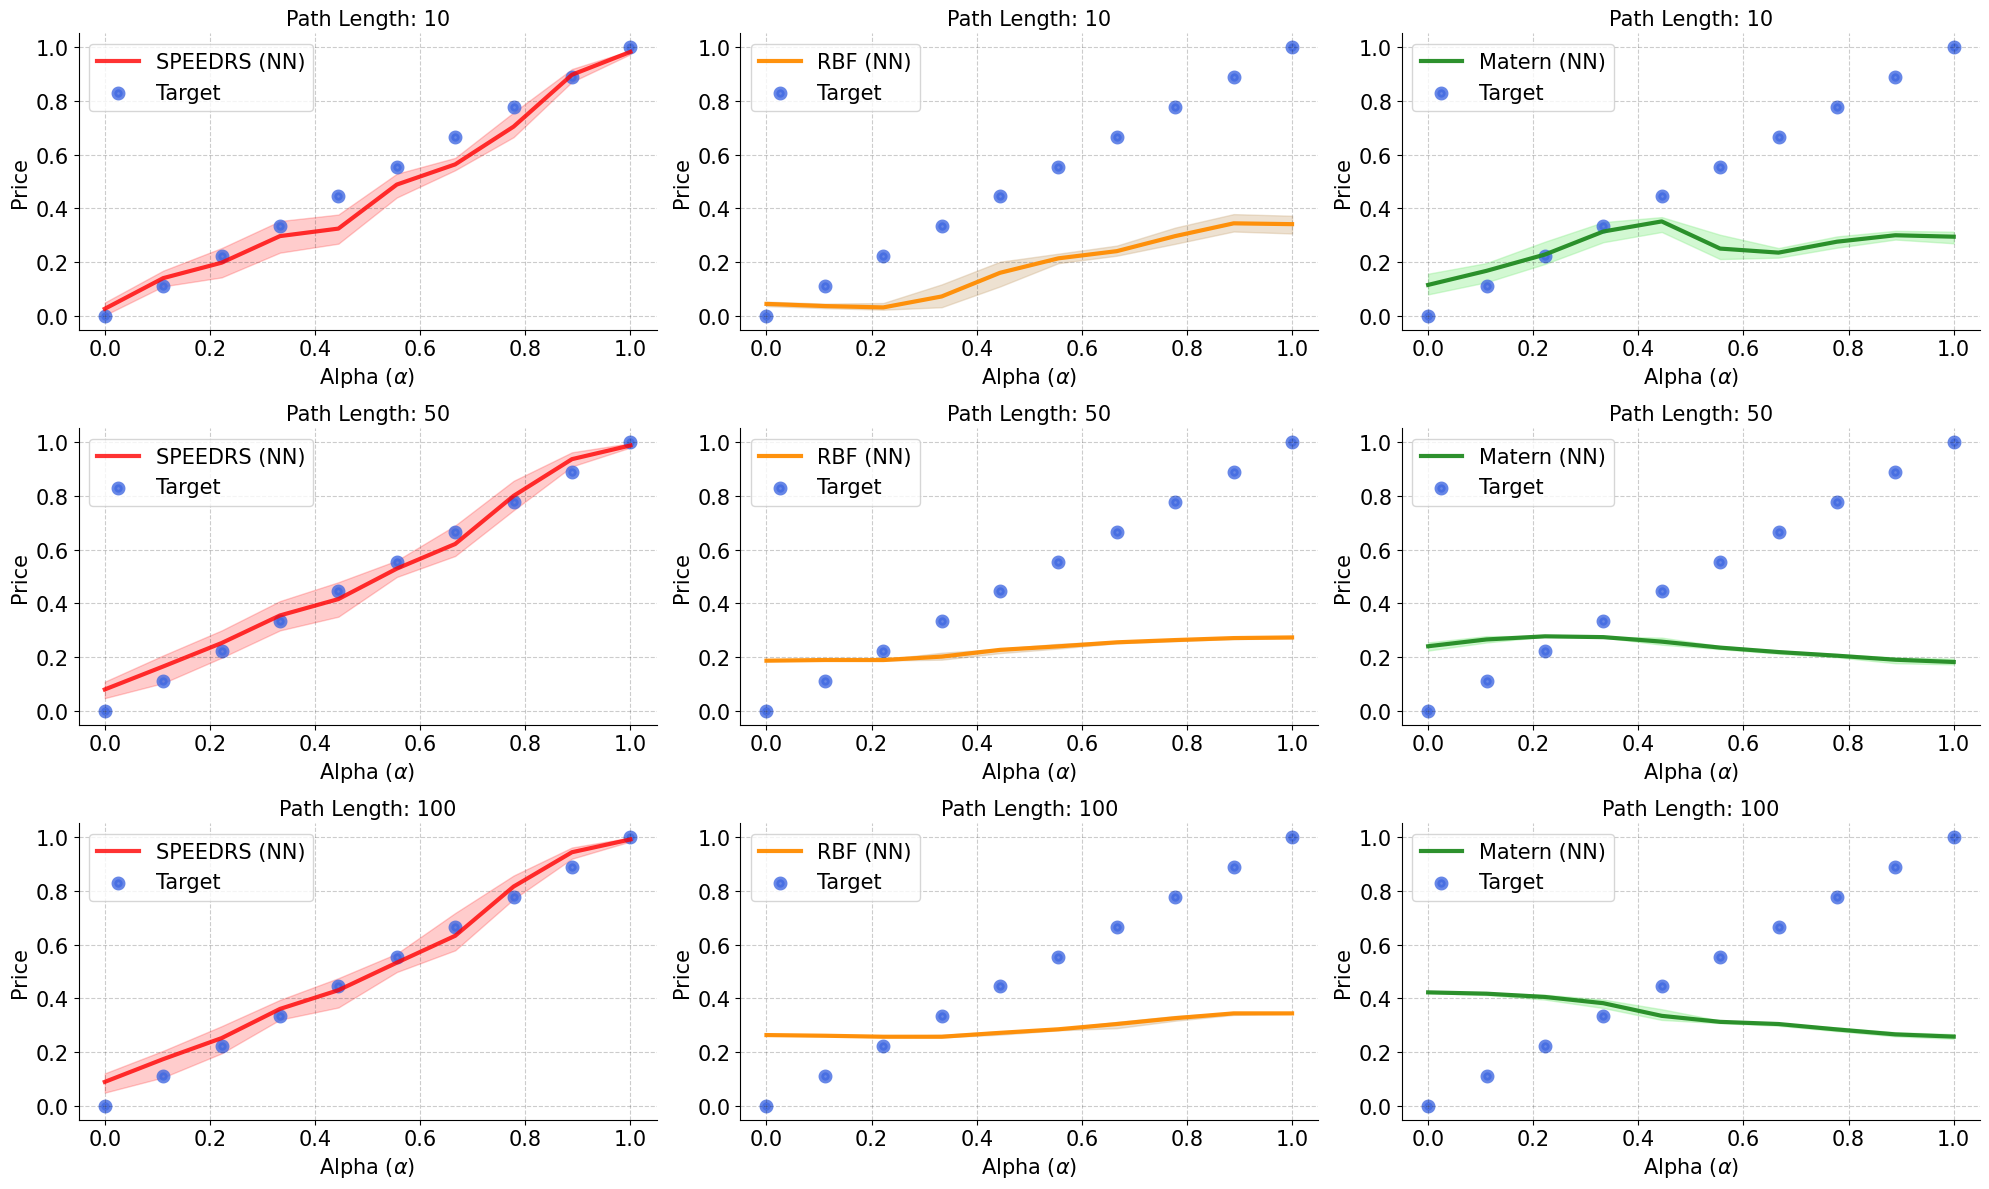

In [21]:
x_range = np.linspace(0, 1, 10)
folder = f'MixtureModels/ParamEstimation/Images/Thesis/TimeSteps'
model = ['NN']
for i in range(1):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
    for j, num_time_steps in enumerate([9, 49, 99]):
        construct_plot(ax[j, 0], x_range, prediction_speedrs_global[num_time_steps][i], x_range, [0.8, 0.2, 0.8], 
                       ['red', 'red', 'royalblue'], f'SPEEDRS ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)',
                       'Price', 'Target', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}')
    
        construct_plot(ax[j, 1], x_range, prediction_rbf_global[num_time_steps][i], x_range, [0.95, 0.4, 0.8], 
                       ['darkorange', 'tan', 'royalblue'], f'RBF ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)', 
                       'Price', 'Target', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}')
    
        construct_plot(ax[j, 2], x_range, prediction_matern_global[num_time_steps][i], x_range, [0.95, 0.4, 0.8], 
                       ['forestgreen', 'lightgreen', 'royalblue'], f'Matern ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)', 
                       'Price', 'Target', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}')
    plt.tight_layout()
#     filename = f'{folder}/numtimesteps_{model[i]}_10_50_100_thesis.svg'
#     file_path = Path(f'{filename}')
#     file_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

### Test 2 - Unseen Regimes <a class="anchor" id="test-data-drift-test2"></a>

#### Mixture between rBergomi and CEV <a class="anchor" id="test-data-drift-test2-rbergomi-cev"></a>

In [19]:
v0_rbergomi = 0.3
H = 0.15
nu = 1.5
corr_rbergomi = 0.4
xi_0 = 0.2
C = np.sqrt(2*H)

sigma_cev = 0.3

sig_level = 3



S0 = 1.0
r = 0.15
T = 1.0


num_sim = 5000
num_time_steps = 14

predictions_cev = defaultdict(list)
predictions_cev_lr = defaultdict(list)
predictions_cev_lgbm = defaultdict(list)


predictions_cev_rbf = defaultdict(list)
predictions_cev_rbf_lr = defaultdict(list)
predictions_cev_rbf_lgbm = defaultdict(list)

predictions_cev_matern = defaultdict(list)
predictions_cev_matern_lr = defaultdict(list)
predictions_cev_matern_lgbm = defaultdict(list)


predictions_cev_subsample = defaultdict(list)
predictions_cev_subsample_lr = defaultdict(list)
predictions_cev_subsample_lgbm = defaultdict(list)

predictions_cev_rbf_subsample = defaultdict(list)
predictions_cev_rbf_subsample_lr = defaultdict(list)
predictions_cev_rbf_subsample_lgbm = defaultdict(list)

predictions_cev_matern_subsample = defaultdict(list)
predictions_cev_matern_subsample_lr = defaultdict(list)
predictions_cev_matern_subsample_lgbm = defaultdict(list)

alpha_fun = lambda x: x


sigma = 1


for q in tqdm(range(100)):
    
    p1 = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[-1]
    p2 = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps)
    
    p1_baseline = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[-1]
    p2_baseline = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps)

    
    num_time_steps_subsample = np.random.randint(low=25, high=50)
    num_used_steps_subsample = 14

    p1_subsample = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps_subsample+1)], C, nu, corr_rbergomi, T, num_time_steps_subsample, num_sim)[-1]
    p2_subsample = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps_subsample)

    
    num_time_steps_subsample_baseline = np.random.randint(low=25, high=50)

    p1_subsample_baseline = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps_subsample_baseline+1)], C, nu, corr_rbergomi, T, num_time_steps_subsample_baseline, num_sim)[-1]
    p2_subsample_baseline = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps_subsample_baseline)
    
    for alpha in np.linspace(0, 1, 20):

        new_dist = []
        new_dist1 = []
        new_dist2 = []
        
        new_dist_subsample = []
        new_dist1_subsample = []
        new_dist2_subsample = []

        p = np.add(alpha_fun(alpha)*p1, (1-alpha_fun(alpha))*p2)

        p[:, :, 0] /= S0
        
        p_subsample = np.add(alpha_fun(alpha)*p1_subsample, (1-alpha_fun(alpha))*p2_subsample)
        
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample)], num_used_steps_subsample)
        p_subsample = p_subsample[list(set(np.sort(random_indices))), :, :]

        
        expec_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)
        expec_sig_subsample = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p_subsample, (1, 0, 2)), 2), sigma)), sig_level), axis=0)

        for k in range(N):
        
            new_feature = expec_sig.tolist() + base_process_expected_sigs[k].tolist()
            new_feature_subsample = expec_sig_subsample.tolist() + base_process_expected_sigs[k].tolist()
    
            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():
                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())
                new_dist_subsample.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature_subsample)).unsqueeze(0).float()).cpu().item())
                
        p_baseline = np.add(alpha_fun(alpha)*p1_baseline, (1-alpha_fun(alpha))*p2_baseline)
        p_baseline[:, :, 0] /= S0
        p_baseline = p_baseline.transpose((1, 0, 2))[:400, ...]
        pp, max_items, common_T, dim_path = bags_to_2D([p_baseline] + base_processes_list)
        size_item = dim_path * common_T
        
        p_baseline_subsample = np.add(alpha_fun(alpha)*p1_subsample_baseline, (1-alpha_fun(alpha))*p2_subsample_baseline)
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample_baseline)], num_used_steps_subsample)
        p_baseline_subsample = p_baseline_subsample[list(set(np.sort(random_indices))), :, :]
        p_baseline_subsample = p_baseline_subsample.transpose((1, 0, 2))[:400, ...]
        pp_subsample, max_items_subsample, common_T_subsample, dim_path_subsample = bags_to_2D([p_baseline_subsample] + base_processes_list)
        size_item_subsapmle = dim_path_subsample * common_T_subsample
            
        
    
        for i in range(1, 21):
            new_dist1.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            new_dist2.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            
            new_dist1_subsample.append(rbf_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])
            new_dist2_subsample.append(rbf_matern_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])




        mixture_param_model.model.eval()
        rbf_estim_model.model.eval()
        matern_estim_model.model.eval()
        with torch.no_grad():
            predictions_cev[alpha].append(mixture_param_model.transform(torch.tensor([new_dist])).cpu().item())
            predictions_cev_lr[alpha].append(linear_reg_speedrs_model.predict([new_dist])[0])
            predictions_cev_lgbm[alpha].append(lgbm_speedrs_model.predict([new_dist])[0])
            
            predictions_cev_rbf[alpha].append((rbf_estim_model.transform(torch.tensor([new_dist1])).cpu().item()))
            predictions_cev_rbf_lr[alpha].append(rbf_baseline_linear_reg.predict([new_dist1])[0])
            predictions_cev_rbf_lgbm[alpha].append(rbf_baseline_lgbm.predict([new_dist1])[0])

            predictions_cev_matern[alpha].append((matern_estim_model.transform(torch.tensor([new_dist2])).cpu().item()))
            predictions_cev_matern_lr[alpha].append(matern_baseline_lgbm.predict([new_dist2])[0])
            predictions_cev_matern_lgbm[alpha].append(matern_baseline_linear_reg.predict([new_dist2])[0])
            
            predictions_cev_subsample[alpha].append(mixture_param_model.transform(torch.tensor([new_dist_subsample])).cpu().item())
            predictions_cev_subsample_lr[alpha].append(linear_reg_speedrs_model.predict([new_dist_subsample])[0])
            predictions_cev_subsample_lgbm[alpha].append(lgbm_speedrs_model.predict([new_dist_subsample])[0])
            
            predictions_cev_rbf_subsample[alpha].append((rbf_estim_model.transform(torch.tensor([new_dist1_subsample])).cpu().item()))
            predictions_cev_rbf_subsample_lr[alpha].append(rbf_baseline_linear_reg.predict([new_dist1_subsample])[0])
            predictions_cev_rbf_subsample_lgbm[alpha].append(rbf_baseline_lgbm.predict([new_dist1_subsample])[0])
            
            predictions_cev_matern_subsample[alpha].append((matern_estim_model.transform(torch.tensor([new_dist2_subsample])).cpu().item()))
            predictions_cev_matern_subsample_lr[alpha].append(matern_baseline_linear_reg.predict([new_dist2_subsample])[0])
            predictions_cev_matern_subsample_lgbm[alpha].append(matern_baseline_lgbm.predict([new_dist2_subsample])[0])

100%|██████████| 100/100 [17:54<00:00, 10.75s/it]


#### No Subsampling

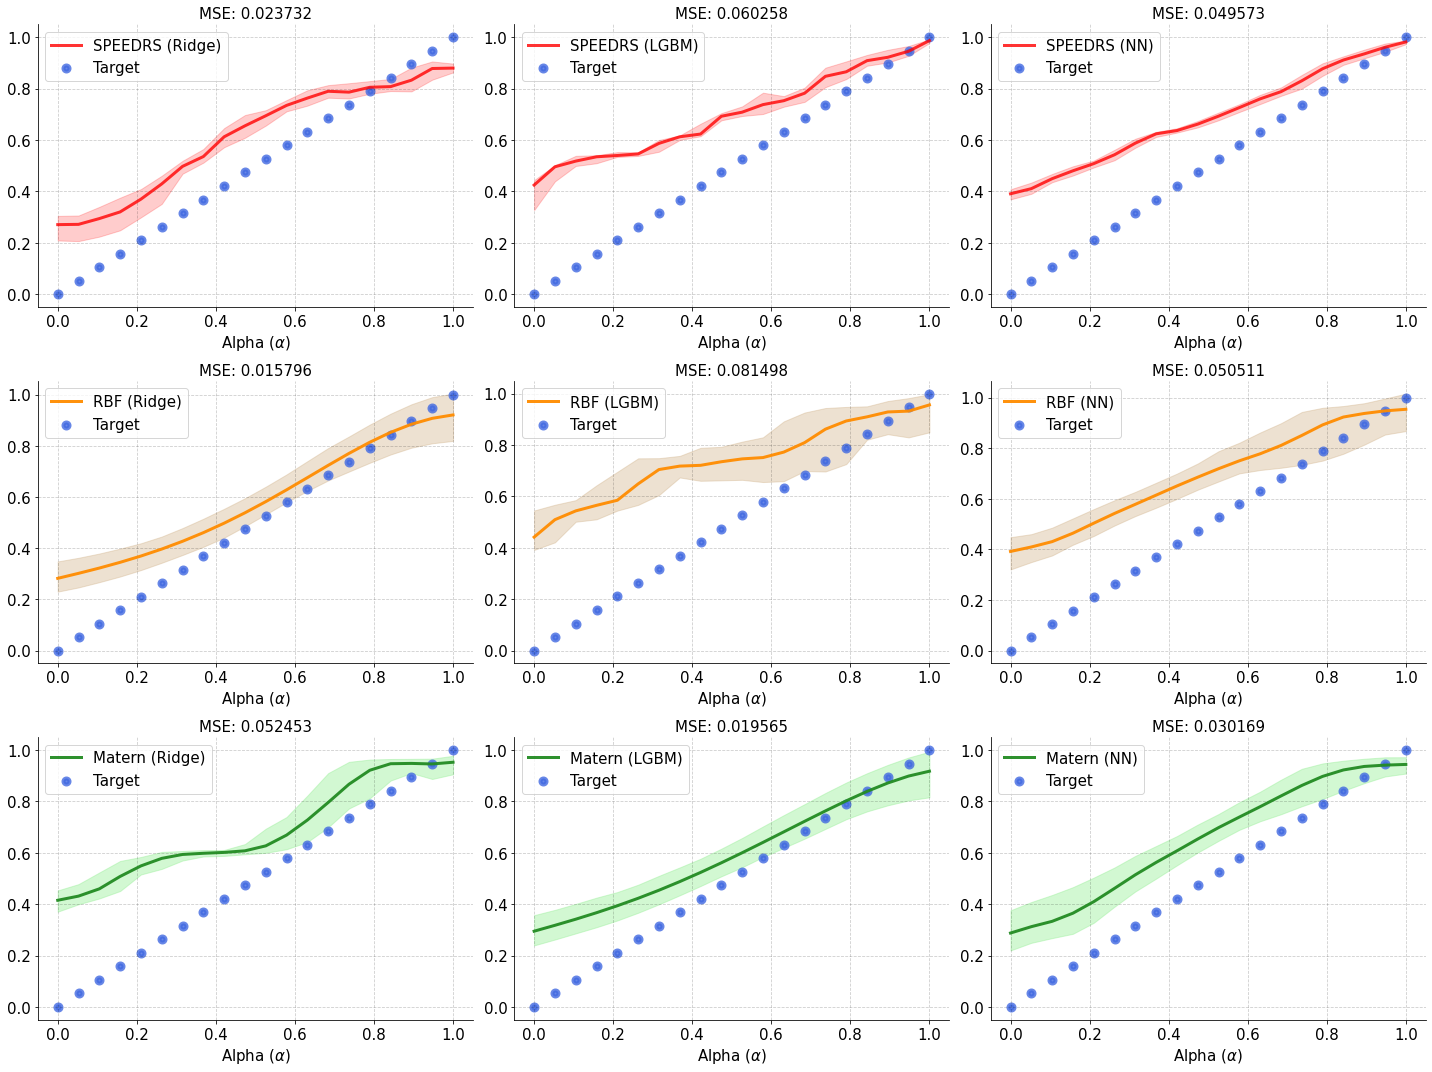

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

x_range = np.linspace(0, 1, 20)
construct_plot(ax[0, 2], x_range, predictions_cev, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[0, 0], x_range, predictions_cev_lr, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[0, 1], x_range, predictions_cev_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')

construct_plot(ax[1, 2], x_range, predictions_cev_rbf, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[1, 0], x_range, predictions_cev_rbf_lr, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[1, 1], x_range, predictions_cev_rbf_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')


construct_plot(ax[2, 2], x_range, predictions_cev_matern, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[2, 0], x_range, predictions_cev_matern_lr, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[2, 1], x_range, predictions_cev_matern_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')


plt.tight_layout()
# filename = 'MixtureModels/ParamEstimation/Images/Thesis/rbergomi_cev/mixture_param_estim_rbergomi_cev1.svg'
# file_path = Path(f'{filename}')
# file_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Subsampling

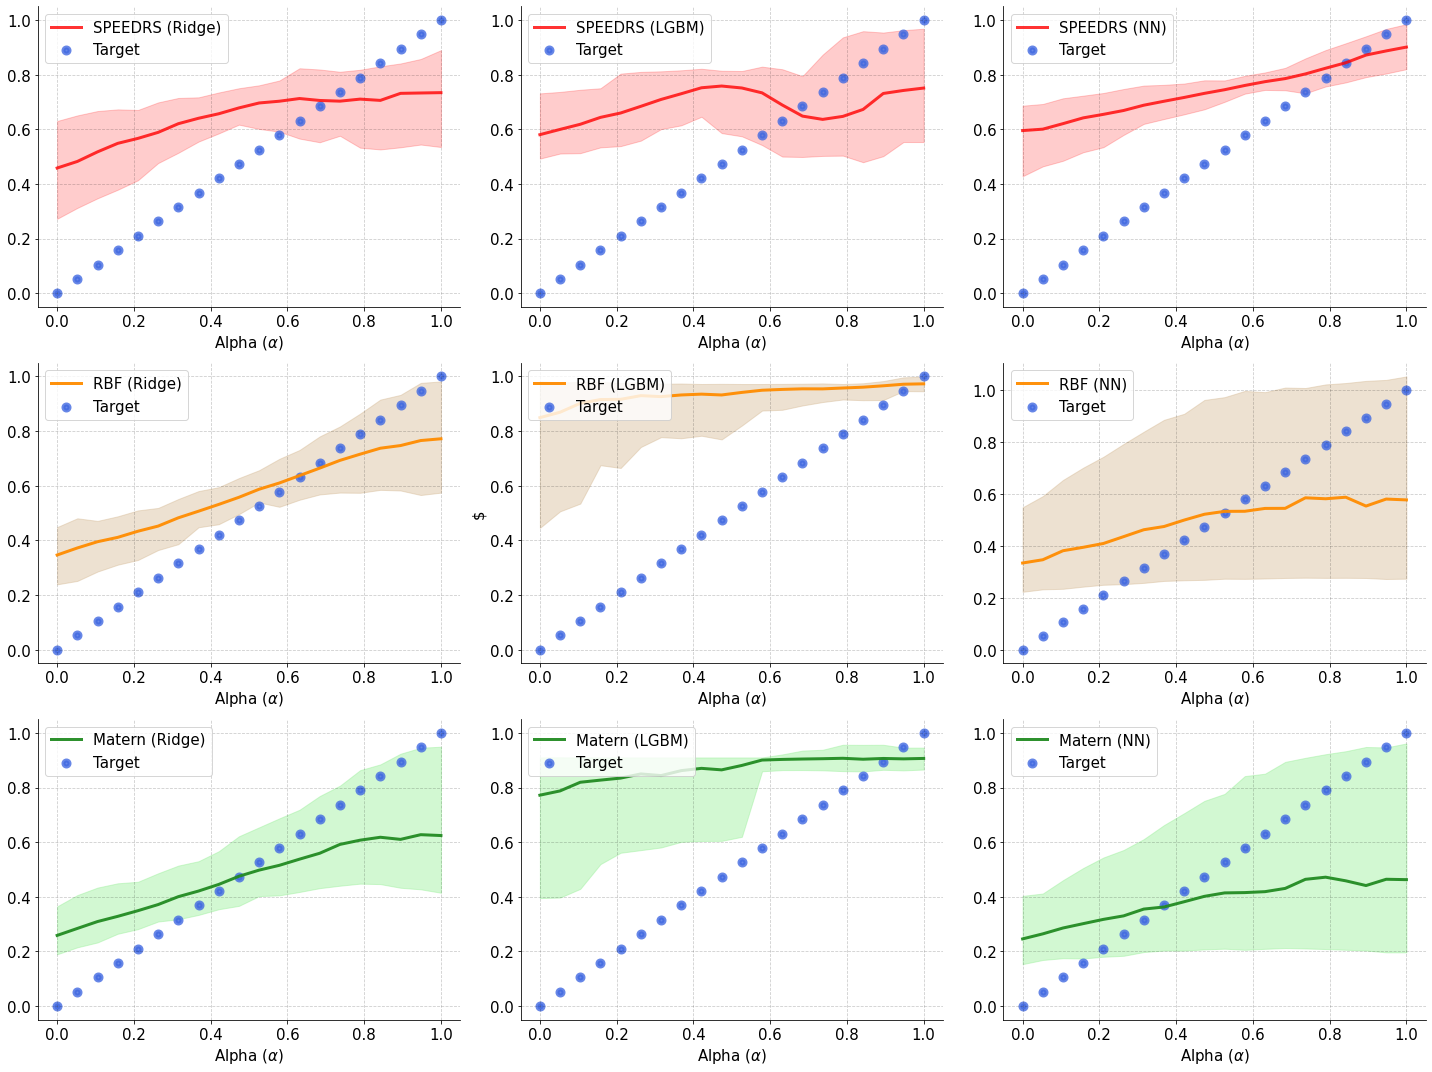

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

x_range = np.linspace(0, 1, 20)
construct_plot(ax[0, 2], x_range, predictions_cev_subsample, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')
construct_plot(ax[0, 0], x_range, predictions_cev_subsample_lr, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')
construct_plot(ax[0, 1], x_range, predictions_cev_subsample_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')

construct_plot(ax[1, 2], x_range, predictions_cev_rbf_subsample, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')
construct_plot(ax[1, 0], x_range, predictions_cev_rbf_subsample_lr, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')
construct_plot(ax[1, 1], x_range, predictions_cev_rbf_subsample_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', r'$', 'Target', title='')


construct_plot(ax[2, 2], x_range, predictions_cev_matern_subsample, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')
construct_plot(ax[2, 0], x_range, predictions_cev_matern_subsample_lr, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')
construct_plot(ax[2, 1], x_range, predictions_cev_matern_subsample_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', r'', 'Target', title='')


plt.tight_layout()
filename = 'MixtureModels/ParamEstimation/Images/Thesis/rbergomi_cev/mixture_param_estim_rbergomi_cev1_subsample.svg'
file_path = Path(f'{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Mixture between CEV and Mean Reverting <a class="anchor" id="test-data-drift-test2-cev-heston"></a>

In [49]:
v0_heston = 0.5
corr_heston = 0.5
mean_vol = 0.5
speed = 0.6
vol_of_vol = 0.65

sigma_cev = 0.3



S0 = 1.0
r = 0.15
T = 1.0


num_sim = 5000
num_time_steps = 14

predictions_cev_2 = defaultdict(list)
predictions_cev_lr_2 = defaultdict(list)
predictions_cev_lgbm_2 = defaultdict(list)


predictions_cev_rbf_2 = defaultdict(list)
predictions_cev_rbf_lr_2 = defaultdict(list)
predictions_cev_rbf_lgbm_2 = defaultdict(list)

predictions_cev_matern_2 = defaultdict(list)
predictions_cev_matern_lr_2 = defaultdict(list)
predictions_cev_matern_lgbm_2 = defaultdict(list)


predictions_cev_subsample_2 = defaultdict(list)
predictions_cev_subsample_lr_2 = defaultdict(list)
predictions_cev_subsample_lgbm_2 = defaultdict(list)

predictions_cev_rbf_subsample_2 = defaultdict(list)
predictions_cev_rbf_subsample_lr_2 = defaultdict(list)
predictions_cev_rbf_subsample_lgbm_2 = defaultdict(list)

predictions_cev_matern_subsample_2 = defaultdict(list)
predictions_cev_matern_subsample_lr_2 = defaultdict(list)
predictions_cev_matern_subsample_lgbm_2 = defaultdict(list)

alpha_fun = lambda x: x


sigma = 1


for q in tqdm(range(100)):
    
    p1 = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps)
    p2 = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0]

    
    p1_baseline = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps)
    p2_basline = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0]

    
    num_time_steps_subsample = np.random.randint(low=25, high=50)
    num_used_steps_subsample = 14

    p1_subsample = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps_subsample)
    p2_subsample = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps_subsample)[0]


    
    num_time_steps_subsample_baseline = np.random.randint(low=25, high=50)

    p1_subsample_baseline = CEV_sample_paths(S0, r, sigma_cev, 0.8, T, num_sim, num_time_steps_subsample_baseline)
    p2_subsample_baseline = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps_subsample_baseline)[0]

    
    for alpha in np.linspace(0, 1, 20):

        new_dist = []
        new_dist1 = []
        new_dist2 = []
        
        new_dist_subsample = []
        new_dist1_subsample = []
        new_dist2_subsample = []

        p = np.add(alpha_fun(alpha)*p1, (1-alpha_fun(alpha))*p2)

        p[:, :, 0] /= S0
        
        p_subsample = np.add(alpha_fun(alpha)*p1_subsample, (1-alpha_fun(alpha))*p2_subsample)
        
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample)], num_used_steps_subsample)
        p_subsample = p_subsample[list(set(np.sort(random_indices))), :, :]

        expec_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)
        expec_sig_subsample = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p_subsample, (1, 0, 2)), 2), sigma)), sig_level), axis=0)

        for k in range(N):
        
            new_feature = expec_sig.tolist() + base_process_expected_sigs[k].tolist()
            new_feature_subsample = expec_sig_subsample.tolist() + base_process_expected_sigs[k].tolist()
    
            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():
                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())
                new_dist_subsample.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature_subsample)).unsqueeze(0).float()).cpu().item())
                
        p_baseline = np.add(alpha_fun(alpha)*p1_baseline, (1-alpha_fun(alpha))*p2_baseline)
        p_baseline[:, :, 0] /= S0
        p_baseline = p_baseline.transpose((1, 0, 2))[:400, ...]
        pp, max_items, common_T, dim_path = bags_to_2D([p_baseline] + base_processes_list)
        size_item = dim_path * common_T
        
        p_baseline_subsample = np.add(alpha_fun(alpha)*p1_subsample_baseline, (1-alpha_fun(alpha))*p2_subsample_baseline)
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample_baseline)], num_used_steps_subsample)
        p_baseline_subsample = p_baseline_subsample[list(set(np.sort(random_indices))), :, :]
        p_baseline_subsample = p_baseline_subsample.transpose((1, 0, 2))[:400, ...]
        pp_subsample, max_items_subsample, common_T_subsample, dim_path_subsample = bags_to_2D([p_baseline_subsample] + base_processes_list)
        size_item_subsapmle = dim_path_subsample * common_T_subsample
            
        
    
        for i in range(1, 21):
            new_dist1.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            new_dist2.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            
            new_dist1_subsample.append(rbf_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])
            new_dist2_subsample.append(rbf_matern_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])




        mixture_param_model.model.eval()
        rbf_estim_model.model.eval()
        matern_estim_model.model.eval()
        with torch.no_grad():
            predictions_cev_2[alpha].append(mixture_param_model.transform(torch.tensor([new_dist])).cpu().item())
            predictions_cev_lr_2[alpha].append(linear_reg_speedrs_model.predict([new_dist])[0])
            predictions_cev_lgbm_2[alpha].append(lgbm_speedrs_model.predict([new_dist])[0])
            
            predictions_cev_rbf_2[alpha].append((rbf_estim_model.transform(torch.tensor([new_dist1])).cpu().item()))
            predictions_cev_rbf_lr_2[alpha].append(rbf_baseline_linear_reg.predict([new_dist1])[0])
            predictions_cev_rbf_lgbm_2[alpha].append(rbf_baseline_lgbm.predict([new_dist1])[0])

            predictions_cev_matern_2[alpha].append((matern_estim_model.transform(torch.tensor([new_dist2])).cpu().item()))
            predictions_cev_matern_lr_2[alpha].append(matern_baseline_lgbm.predict([new_dist2])[0])
            predictions_cev_matern_lgbm_2[alpha].append(matern_baseline_linear_reg.predict([new_dist2])[0])
            
            predictions_cev_subsample_2[alpha].append(mixture_param_model.transform(torch.tensor([new_dist_subsample])).cpu().item())
            predictions_cev_subsample_lr_2[alpha].append(linear_reg_speedrs_model.predict([new_dist_subsample])[0])
            predictions_cev_subsample_lgbm_2[alpha].append(lgbm_speedrs_model.predict([new_dist_subsample])[0])
            
            predictions_cev_rbf_subsample_2[alpha].append((rbf_estim_model.transform(torch.tensor([new_dist1_subsample])).cpu().item()))
            predictions_cev_rbf_subsample_lr_2[alpha].append(rbf_baseline_linear_reg.predict([new_dist1_subsample])[0])
            predictions_cev_rbf_subsample_lgbm_2[alpha].append(rbf_baseline_lgbm.predict([new_dist1_subsample])[0])
            
            predictions_cev_matern_subsample_2[alpha].append((matern_estim_model.transform(torch.tensor([new_dist2_subsample])).cpu().item()))
            predictions_cev_matern_subsample_lr_2[alpha].append(matern_baseline_linear_reg.predict([new_dist2_subsample])[0])
            predictions_cev_matern_subsample_lgbm_2[alpha].append(matern_baseline_lgbm.predict([new_dist2_subsample])[0])

100%|██████████| 100/100 [17:00<00:00, 10.21s/it]


#### No Subsampling

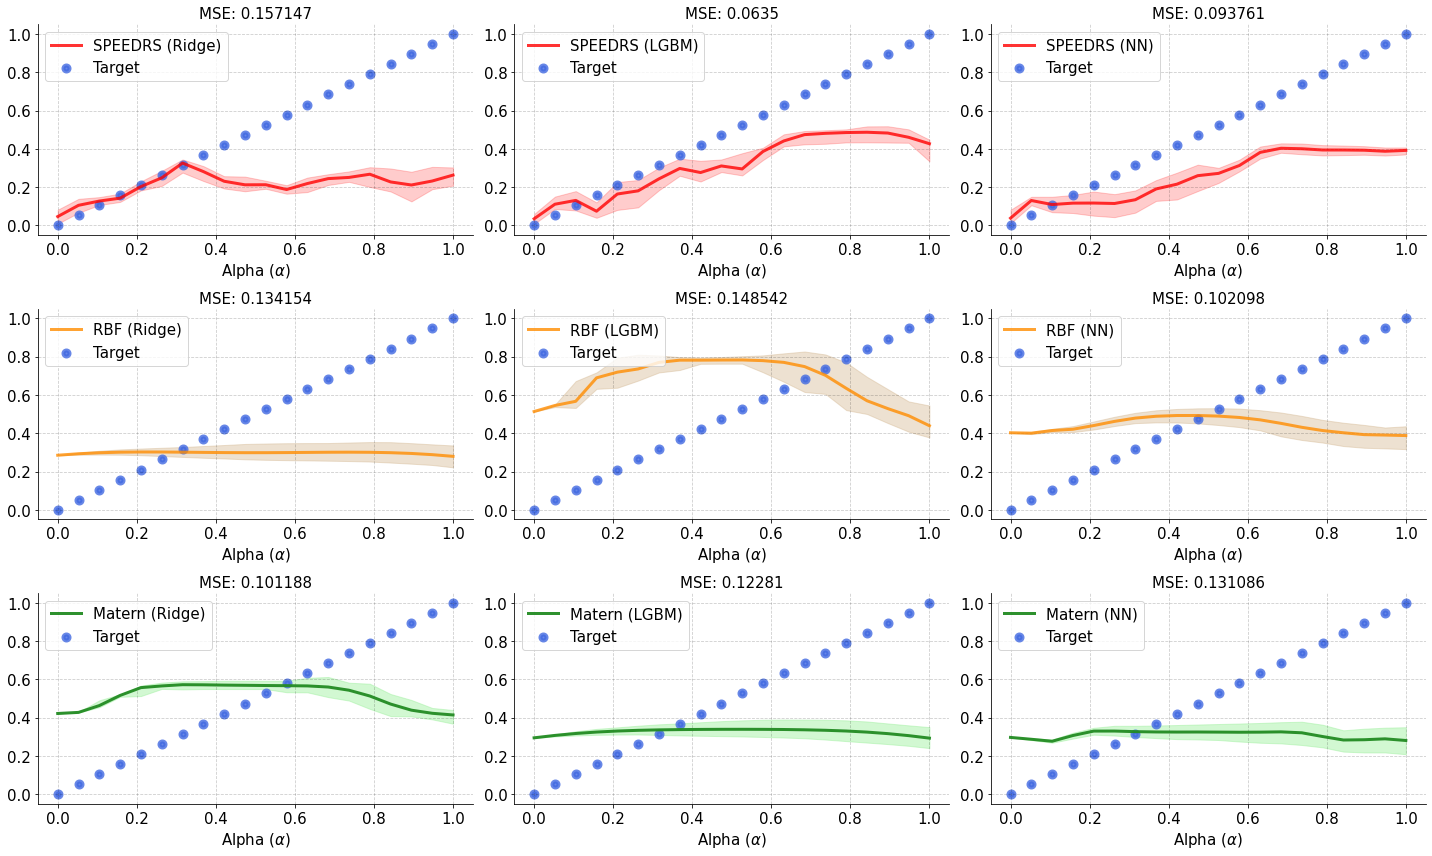

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
x_range = np.linspace(0, 1, 20)


construct_plot(ax[0, 2], x_range, predictions_cev_2, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[0, 0], x_range, predictions_cev_lr_2, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[0, 1], x_range, predictions_cev_lgbm_2, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')

construct_plot(ax[1, 2], x_range, predictions_cev_rbf_2, x_range, [0.8, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[1, 0], x_range, predictions_cev_rbf_lr_2, x_range, [0.8, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[1, 1], x_range, predictions_cev_rbf_lgbm_2, x_range, [0.8, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')


construct_plot(ax[2, 2], x_range, predictions_cev_matern_2, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[2, 0], x_range, predictions_cev_matern_lr_2, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')
construct_plot(ax[2, 1], x_range, predictions_cev_matern_lgbm_2, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target')


plt.tight_layout()
# filename = 'MixtureModels/ParamEstimation/Images/Thesis/heston_cev/mixture_param_estim_heston_cev1.svg'
# file_path = Path(f'{filename}')
# file_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Subsampling

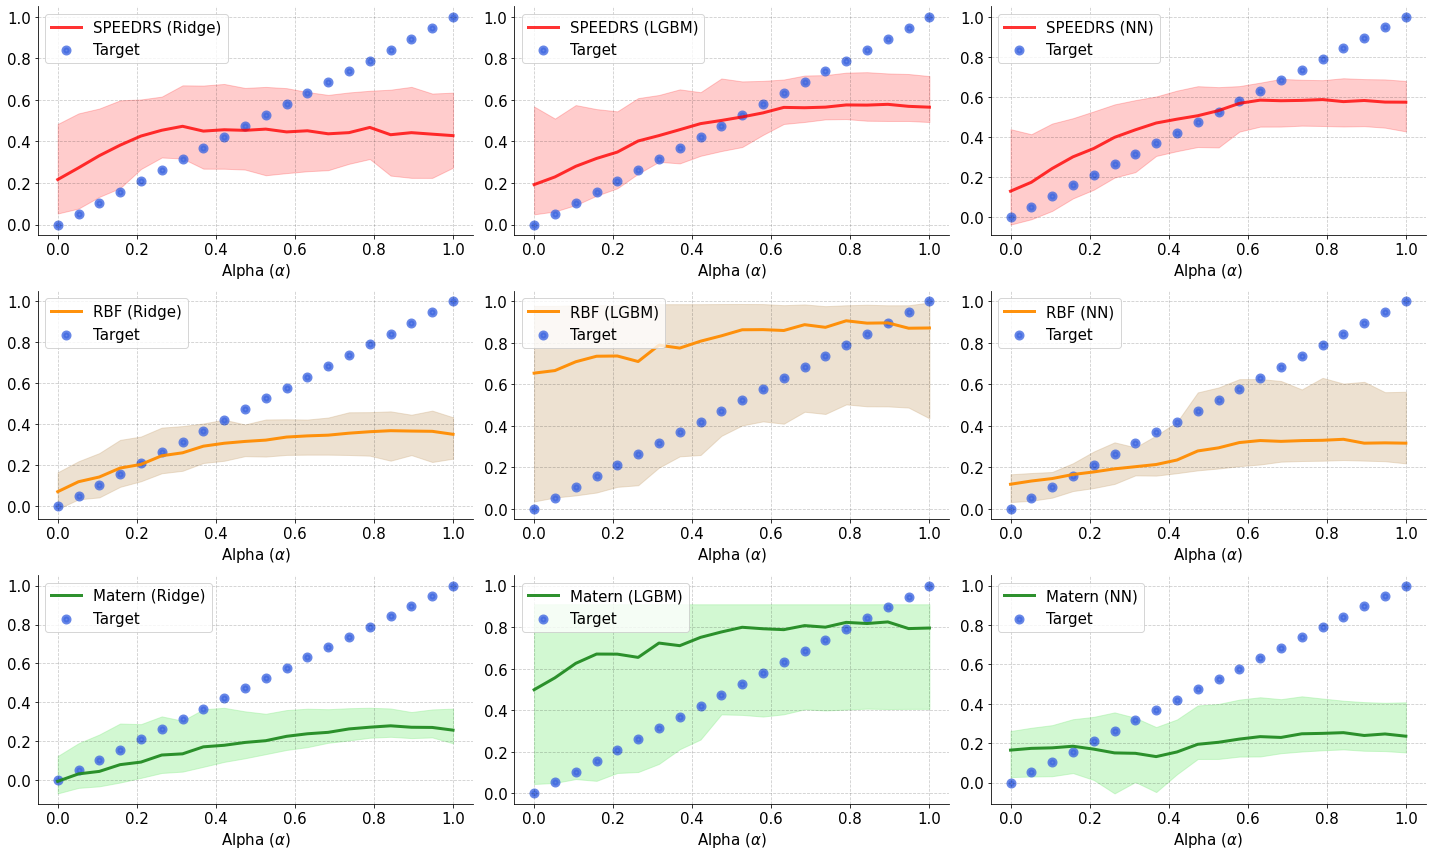

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

x_range = np.linspace(0, 1, 20)
construct_plot(ax[0, 2], x_range, predictions_cev_subsample_2, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')
construct_plot(ax[0, 0], x_range, predictions_cev_subsample_lr_2, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')
construct_plot(ax[0, 1], x_range, predictions_cev_subsample_lgbm_2, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')

construct_plot(ax[1, 2], x_range, predictions_cev_rbf_subsample_2, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')
construct_plot(ax[1, 0], x_range, predictions_cev_rbf_subsample_lr_2, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')
construct_plot(ax[1, 1], x_range, predictions_cev_rbf_subsample_lgbm_2, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')


construct_plot(ax[2, 2], x_range, predictions_cev_matern_subsample_2, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')
construct_plot(ax[2, 0], x_range, predictions_cev_matern_subsample_lr_2, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')
construct_plot(ax[2, 1], x_range, predictions_cev_matern_subsample_lgbm_2, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', '', 'Target', title='')


plt.tight_layout()
filename = 'MixtureModels/ParamEstimation/Images/Thesis/heston_cev/mixture_param_estim_heston_cev1_subsample.svg'
file_path = Path(f'{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Save Test Results

In [ ]:
test_dict = {'(CEV, Heston)': [[alpha_fun(alpha) for alpha in np.linspace(0, 1, 20)], 
                                (predictions_cev, predictions_cev_lr, predictions_cev_lgbm), 
                                (predictions_cev_rbf, predictions_cev_rbf_lr, predictions_cev_rbf_lgbm), 
                                (predictions_cev_matern, predictions_cev_matern_lr, predictions_cev_matern_lgbm)],
            '(CEV, Heston) - Subsample': [[alpha_fun(alpha) for alpha in np.linspace(0, 1, 20)], 
                                            (predictions_cev_subsample, predictions_cev_subsample_lr, predictions_cev_subsample_lgbm), 
                                            (predictions_cev_rbf_subsample, predictions_cev_rbf_subsample_lr, predictions_cev_rbf_subsample_lgbm),
                                            (predictions_cev_matern_subsample, predictions_cev_matern_subsample_lr, predictions_cev_matern_subsample_lgbm)],
            '(rBergomi,CEV)': [[alpha_fun(alpha) for alpha in np.linspace(0, 1, 20)], 
                                (predictions_cev_2, predictions_cev_lr_2, predictions_cev_lgbm_2), 
                                (predictions_cev_rbf_2, predictions_cev_rbf_lr_2, predictions_cev_rbf_lgbm_2), 
                                (predictions_cev_matern_2, predictions_cev_matern_lr_2, predictions_cev_matern_lgbm_2)],
            '(rBergomi, CEV) - Subsample': [[alpha_fun(alpha) for alpha in np.linspace(0, 1, 20)], 
                                            (predictions_cev_subsample_2, predictions_cev_subsample_lr_2, predictions_cev_subsample_lgbm_2), 
                                            (predictions_cev_rbf_subsample_2, predictions_cev_rbf_subsample_lr_2, predictions_cev_rbf_subsample_lgbm_2),
                                            (predictions_cev_matern_subsample_2, predictions_cev_matern_subsample_lr_2, predictions_cev_matern_subsample_lgbm_2)], 
             'TimeSteps': [np.linspace(0, 1, 10), prediction_speedrs_global, prediction_rbf_global, prediction_matern_global] 
}
save_path_params(test_dict, 'MixtureModels/ParamEstimation/Datasets/test_results')

### Performance Metrics <a class="anchor" id="test-data-drift-performance-metrics"></a>

In [6]:
test_dict = load_path_params('MixtureModels/ParamEstimation/Datasets/test_results')

(predictions_cev, predictions_cev_lr, predictions_cev_lgbm) = test_dict['(CEV, Heston)'][1]
(predictions_cev_rbf, predictions_cev_rbf_lr, predictions_cev_rbf_lgbm) = test_dict['(CEV, Heston)'][2]
(predictions_cev_matern, predictions_cev_matern_lr, predictions_cev_matern_lgbm) = test_dict['(CEV, Heston)'][3]

(predictions_cev_subsample, predictions_cev_subsample_lr, predictions_cev_subsample_lgbm) = test_dict['(CEV, Heston) - Subsample'][1]
(predictions_cev_rbf_subsample, predictions_cev_rbf_subsample_lr, predictions_cev_rbf_subsample_lgbm) = test_dict['(CEV, Heston) - Subsample'][2]
(predictions_cev_matern_subsample, predictions_cev_matern_subsample_lr, predictions_cev_matern_subsample_lgbm) = test_dict['(CEV, Heston) - Subsample'][3]

(predictions_cev_2, predictions_cev_lr_2, predictions_cev_lgbm_2) = test_dict['(rBergomi,CEV)'][1]
(predictions_cev_rbf_2, predictions_cev_rbf_lr_2, predictions_cev_rbf_lgbm_2) = test_dict['(rBergomi,CEV)'][2]
(predictions_cev_matern_2, predictions_cev_matern_lr_2, predictions_cev_matern_lgbm_2) = test_dict['(rBergomi,CEV)'][3]

(predictions_cev_subsample_2, predictions_cev_subsample_lr_2, predictions_cev_subsample_lgbm_2) = test_dict['(rBergomi, CEV) - Subsample'][1]
(predictions_cev_rbf_subsample_2, predictions_cev_rbf_subsample_lr_2, predictions_cev_rbf_subsample_lgbm_2) = test_dict['(rBergomi, CEV) - Subsample'][2]
(predictions_cev_matern_subsample_2, predictions_cev_matern_subsample_lr_2, predictions_cev_matern_subsample_lgbm_2) = test_dict['(rBergomi, CEV) - Subsample'][3]

prediction_speedrs_global = test_dict['TimeSteps'][1]
prediction_rbf_global = test_dict['TimeSteps'][2]
prediction_matern_global = test_dict['TimeSteps'][3]

In [29]:
def worst_MSE(preds, x_range, targets=np.linspace(0, 1, 20)):

    furthest = []
    
    for i, key in enumerate(x_range):

        j = np.argmax(np.abs(preds[key] - targets[i]))
        furthest.append(preds[key][j])

    return mean_squared_error(targets, furthest)

### Test 1 - Path Length

In [57]:
timesteps_results = {'SPEEDRS': prediction_speedrs_global, 
                     'RBF': prediction_rbf_global, 
                     'Matern': prediction_matern_global}


x_range = np.linspace(0, 1, 10)
models = ['NN', 'LR', 'LGBM']
for key, value in timesteps_results.items():

    for kk, vv in value.items():
        for i in range(3):
            print(f'{key} {models[i]} {kk+1}')
            pred_vals = [np.nanmean(vv[i][k]) for k in x_range]
            print(f'Avg MSE: {np.round(mean_squared_error(x_range, pred_vals), 5)}')
            print(f'Worst MSE: {np.round(worst_MSE(vv[i], x_range, targets=x_range), 5)}')
            print(f'{"*"*100}')

SPEEDRS NN 10
Avg MSE: 0.00387
Worst MSE: 0.01153
****************************************************************************************************
SPEEDRS LR 10
Avg MSE: 0.00321
Worst MSE: 0.00908
****************************************************************************************************
SPEEDRS LGBM 10
Avg MSE: 0.00413
Worst MSE: 0.01897
****************************************************************************************************
SPEEDRS NN 15
Avg MSE: 0.00211
Worst MSE: 0.01037
****************************************************************************************************
SPEEDRS LR 15
Avg MSE: 0.00318
Worst MSE: 0.0086
****************************************************************************************************
SPEEDRS LGBM 15
Avg MSE: 0.00186
Worst MSE: 0.01308
****************************************************************************************************
SPEEDRS NN 25
Avg MSE: 0.00178
Worst MSE: 0.00954
*****************************************

### Test 2 - Unseen Regimes

#### Mixture between rBergomi and CEV

#### No Subsampling

In [32]:
cev_rbergomi_results_dict = {

    'SPEEDRS (Ridge)': predictions_cev_lr,
    'SPEEDRS (LGBM)': predictions_cev_lgbm, 
    'SPEEDRS (NN)': predictions_cev, 
    'RBF (Ridge)': predictions_cev_rbf_lr, 
    'RBF (LGBM)': predictions_cev_rbf_lgbm, 
    'RBF (NN)': predictions_cev_rbf, 
    'Matern (Ridge)': predictions_cev_matern_lr, 
    'Matern (LGBM)': predictions_cev_matern_lgbm, 
    'Matern (NN)': predictions_cev_matern
}

targets = np.linspace(0, 1, 20)

for key, value in cev_rbergomi_results_dict.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in targets]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in targets]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 5)}')
        print(f'Worst MSE: {np.round(worst_MSE(value, targets), 5)}')
        print(f'{"*"*100}')

SPEEDRS (Ridge)
Avg MSE: 0.02373
Worst MSE: 0.03679
****************************************************************************************************
SPEEDRS (LGBM)
Avg MSE: 0.06026
Worst MSE: 0.07236
****************************************************************************************************
SPEEDRS (NN)
Avg MSE: 0.04957
Worst MSE: 0.05864
****************************************************************************************************
RBF (Ridge)
Avg MSE: 0.0158
Worst MSE: 0.04574
****************************************************************************************************
RBF (LGBM)
Avg MSE: 0.0815
Worst MSE: 0.13747
****************************************************************************************************
RBF (NN)
Avg MSE: 0.05051
Worst MSE: 0.09217
****************************************************************************************************
Matern (Ridge)
Avg MSE: 0.05245
Worst MSE: 0.08103
*****************************************************

#### Subsampling

In [34]:
cev_rbergomi_subsample_results_dict = {

    'SPEEDRS (Ridge)': predictions_cev_subsample_lr,
    'SPEEDRS (LGBM)': predictions_cev_subsample_lgbm, 
    'SPEEDRS (NN)': predictions_cev_subsample, 
    'RBF (Ridge)': predictions_cev_rbf_subsample_lr, 
    'RBF (LGBM)': predictions_cev_rbf_subsample_lgbm, 
    'RBF (NN)': predictions_cev_rbf_subsample, 
    'Matern (Ridge)': predictions_cev_matern_subsample_lr, 
    'Matern (LGBM)': predictions_cev_matern_subsample_lgbm, 
    'Matern (NN)': predictions_cev_matern_subsample
}

targets = np.linspace(0, 1, 20)

for key, value in cev_rbergomi_subsample_results_dict.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in targets]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in targets]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 5)}')
        print(f'Worst MSE: {np.round(worst_MSE(value, targets), 5)}')
        print(f'{"*"*100}')

SPEEDRS (Ridge)
Avg MSE: 0.07183
Worst MSE: 0.17119
****************************************************************************************************
SPEEDRS (LGBM)
Avg MSE: 0.11307
Worst MSE: 0.22485
****************************************************************************************************
SPEEDRS (NN)
Avg MSE: 0.1027
Worst MSE: 0.1532
****************************************************************************************************
RBF (Ridge)
Avg MSE: 0.03265
Worst MSE: 0.09127
****************************************************************************************************
RBF (LGBM)
Avg MSE: 0.26435
Worst MSE: 0.32903
****************************************************************************************************
RBF (NN)
Avg MSE: 0.05153
Worst MSE: 0.3019
****************************************************************************************************
Matern (Ridge)
Avg MSE: 0.03456
Worst MSE: 0.11087
******************************************************

#### Mixture between CEV and Mean Reverting 

#### No Subsampling

In [53]:
cev_heston_results_dict = {

    'SPEEDRS (Ridge)': predictions_cev_lr_2,
    'SPEEDRS (LGBM)': predictions_cev_lgbm_2, 
    'SPEEDRS (NN)': predictions_cev_2, 
    'RBF (Ridge)': predictions_cev_rbf_lr_2, 
    'RBF (LGBM)': predictions_cev_rbf_lgbm_2, 
    'RBF (NN)': predictions_cev_rbf_2, 
    'Matern (Ridge)': predictions_cev_matern_lr_2, 
    'Matern (LGBM)': predictions_cev_matern_lgbm_2, 
    'Matern (NN)': predictions_cev_matern_2
}

targets = np.linspace(0, 1, 20)

for key, value in cev_heston_results_dict.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in targets]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in targets]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 5)}')
        print(f'Worst MSE: {np.round(worst_MSE(value, targets), 5)}')
        print(f'{"*"*100}')

SPEEDRS (Ridge)
Avg MSE: 0.15715
Worst MSE: 0.20002
****************************************************************************************************
SPEEDRS (LGBM)
Avg MSE: 0.0635
Worst MSE: 0.09925
****************************************************************************************************
SPEEDRS (NN)
Avg MSE: 0.09376
Worst MSE: 0.12046
****************************************************************************************************
RBF (Ridge)
Avg MSE: 0.13415
Worst MSE: 0.16868
****************************************************************************************************
RBF (LGBM)
Avg MSE: 0.14854
Worst MSE: 0.19366
****************************************************************************************************
RBF (NN)
Avg MSE: 0.1021
Worst MSE: 0.14136
****************************************************************************************************
Matern (Ridge)
Avg MSE: 0.10119
Worst MSE: 0.12283
*****************************************************

#### Subsampling

In [54]:
cev_heston_subsample_results_dict = {

    'SPEEDRS (Ridge)': predictions_cev_subsample_lr_2,
    'SPEEDRS (LGBM)': predictions_cev_subsample_lgbm_2, 
    'SPEEDRS (NN)': predictions_cev_subsample_2, 
    'RBF (Ridge)': predictions_cev_rbf_subsample_lr_2, 
    'RBF (LGBM)': predictions_cev_rbf_subsample_lgbm_2, 
    'RBF (NN)': predictions_cev_rbf_subsample_2, 
    'Matern (Ridge)': predictions_cev_matern_subsample_lr_2, 
    'Matern (LGBM)': predictions_cev_matern_subsample_lgbm_2, 
    'Matern (NN)': predictions_cev_matern_subsample_2
}

targets = np.linspace(0, 1, 20)

for key, value in cev_heston_subsample_results_dict.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in targets]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in targets]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 5)}')
        print(f'Worst MSE: {np.round(worst_MSE(value, targets), 5)}')
        print(f'{"*"*100}')

SPEEDRS (Ridge)
Avg MSE: 0.07903
Worst MSE: 0.23904
****************************************************************************************************
SPEEDRS (LGBM)
Avg MSE: 0.03942
Worst MSE: 0.14207
****************************************************************************************************
SPEEDRS (NN)
Avg MSE: 0.03519
Worst MSE: 0.12656
****************************************************************************************************
RBF (Ridge)
Avg MSE: 0.09719
Worst MSE: 0.18777
****************************************************************************************************
RBF (LGBM)
Avg MSE: 0.14941
Worst MSE: 0.38644
****************************************************************************************************
RBF (NN)
Avg MSE: 0.11539
Worst MSE: 0.18112
****************************************************************************************************
Matern (Ridge)
Avg MSE: 0.1512
Worst MSE: 0.21457
****************************************************